In [1]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [2]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

from src.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
data_directory = f'../../data/brain_graph/repeated_10_scale_33'
os.listdir(data_directory)

['125525_repeated10_scale33.graphml',
 '197348_repeated10_scale33.graphml',
 '180432_repeated10_scale33.graphml',
 '169444_repeated10_scale33.graphml',
 '713239_repeated10_scale33.graphml',
 '130417_repeated10_scale33.graphml',
 '155231_repeated10_scale33.graphml',
 '303624_repeated10_scale33.graphml',
 '173637_repeated10_scale33.graphml',
 '889579_repeated10_scale33.graphml',
 '112314_repeated10_scale33.graphml',
 '206727_repeated10_scale33.graphml',
 '101006_repeated10_scale33.graphml',
 '877168_repeated10_scale33.graphml',
 '199251_repeated10_scale33.graphml',
 '352132_repeated10_scale33.graphml',
 '113821_repeated10_scale33.graphml',
 '179346_repeated10_scale33.graphml',
 '573249_repeated10_scale33.graphml',
 '695768_repeated10_scale33.graphml',
 '810439_repeated10_scale33.graphml',
 '378756_repeated10_scale33.graphml',
 '749058_repeated10_scale33.graphml',
 '133625_repeated10_scale33.graphml',
 '185341_repeated10_scale33.graphml',
 '191336_repeated10_scale33.graphml',
 '628248_rep

In [5]:
def load_graphml_graph(data_dir, filename):
    """
    Loads a graphml graph from the specified directory and filename.

    Args:
        data_dir (str): The directory where the graphml files are stored.
        filename (str): The filename of the graphml file to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    filepath = os.path.join(data_dir, filename)
    return nx.read_graphml(filepath)

# Get list of graphml files in directory
graphml_files = [f for f in os.listdir(data_directory) if f.endswith('.graphml')]

graphs = []
graph_filepaths = {}
for filename in graphml_files:
    graph = load_graphml_graph(data_directory, filename)
    if graph:
        graphs.append(graph)
        graph_filepaths[graph] = os.path.join(data_directory, filename)
        print(f"Graph {filename} loaded successfully. Edges: {graph.number_of_edges()}, Nodes: {graph.number_of_nodes()}")


Graph 125525_repeated10_scale33.graphml loaded successfully. Edges: 841, Nodes: 83
Graph 197348_repeated10_scale33.graphml loaded successfully. Edges: 903, Nodes: 83
Graph 180432_repeated10_scale33.graphml loaded successfully. Edges: 800, Nodes: 83
Graph 169444_repeated10_scale33.graphml loaded successfully. Edges: 752, Nodes: 83
Graph 713239_repeated10_scale33.graphml loaded successfully. Edges: 525, Nodes: 83
Graph 130417_repeated10_scale33.graphml loaded successfully. Edges: 854, Nodes: 83
Graph 155231_repeated10_scale33.graphml loaded successfully. Edges: 666, Nodes: 83
Graph 303624_repeated10_scale33.graphml loaded successfully. Edges: 758, Nodes: 83
Graph 173637_repeated10_scale33.graphml loaded successfully. Edges: 648, Nodes: 83
Graph 889579_repeated10_scale33.graphml loaded successfully. Edges: 757, Nodes: 83
Graph 112314_repeated10_scale33.graphml loaded successfully. Edges: 667, Nodes: 83
Graph 206727_repeated10_scale33.graphml loaded successfully. Edges: 691, Nodes: 83
Grap

In [7]:
len(graphs)
# sample 100 graphs
graphs = random.sample(graphs, 100)
len(graphs)

100

### Fitting single graph

Loading the different graphs into a networkx graph

In [32]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[1]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
fitter_params = {
    "d": 0,
    "n_iteration": 8000,
    "patience": 10,
    "er_p": 0.05,
    "edge_delta": 50,
    "min_gic_threshold": 0.1,
    "verbose": True
}

# Initialize the fitter with the parameters

lg_fitter = LogitGraphFitter(**fitter_params)
lg_fitter.fit(target_graph)



==================== Processing Graph ====================
Original graph - Nodes: 218, Edges: 1725
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2121
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 196.9655
   🔗 Edges in best graph: 1776 (Real graph edges: 1725)
Fitting successful - GIC: 0.2101, Best iteration: 634
Fitted graph - Nodes: 218, Edges: 1776


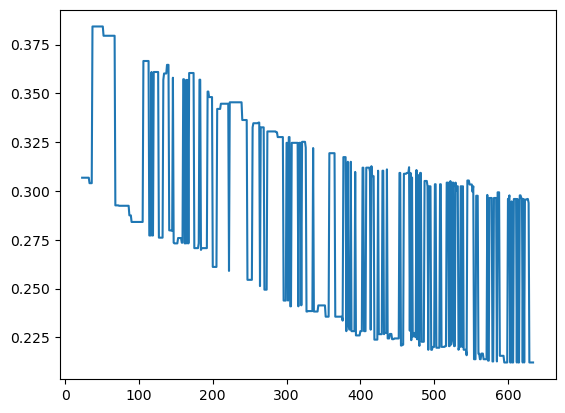

In [33]:
# Log the gic also with the spectrum digg and edges
plt.plot(lg_fitter.metadata['gic_values'])

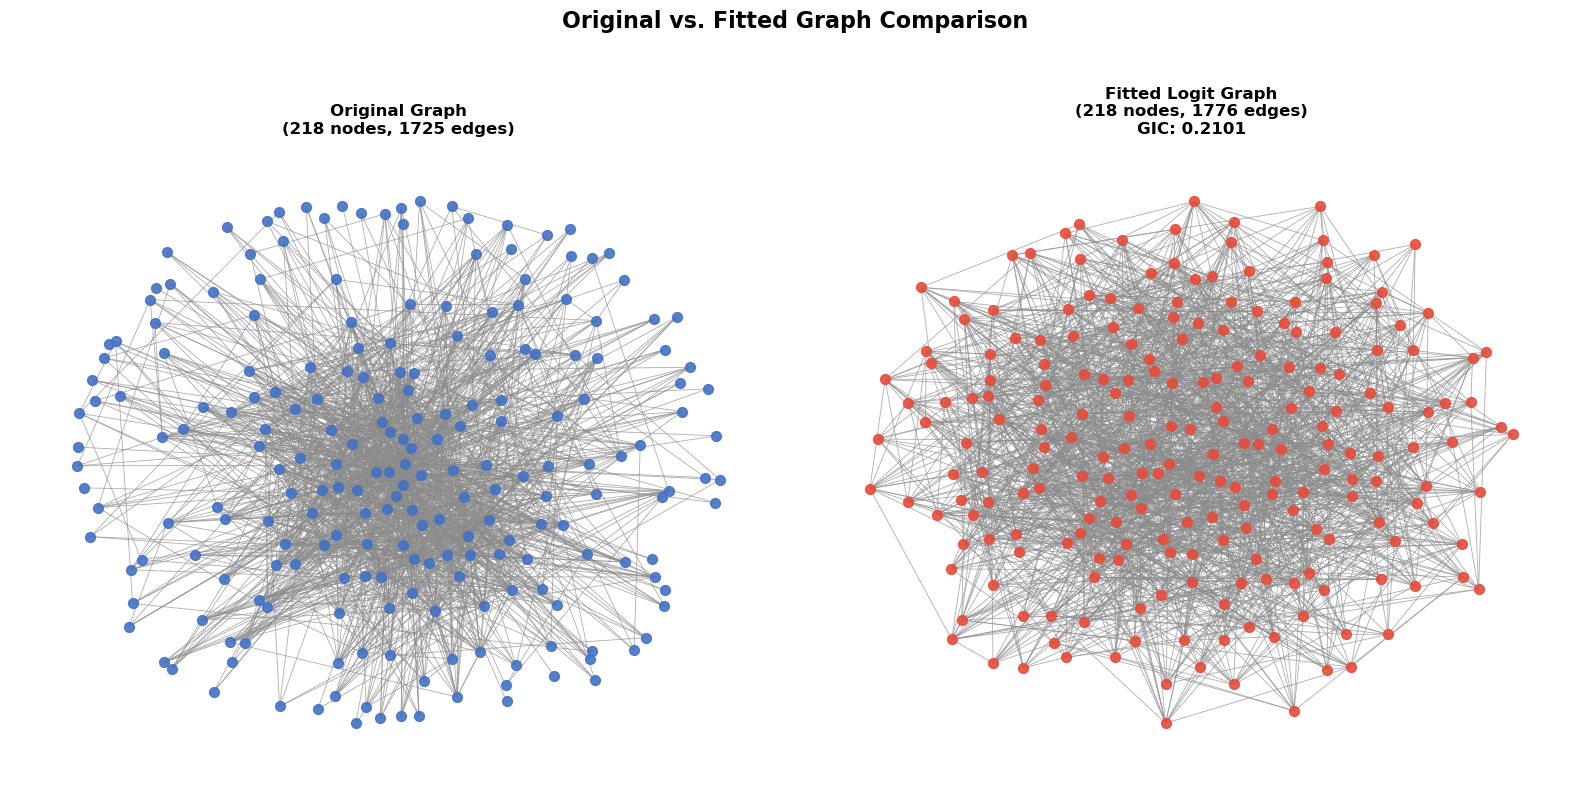

In [34]:
def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    
    # Calculate layout for original graph
    pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Calculate separate layout for fitted graph to avoid position mismatch
        pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if lg_fitter.metadata['fit_success']:
    comparison_figure = compare_graphs_visually(target_graph, lg_fitter.fitted_graph, lg_fitter.metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


In [50]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[2]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



# Initialize the fitter with the parameters

comparator = GraphModelComparator(**sim_params)
comparator.compare(target_graph, target_filepath)



============================== Processing Graph: 96907622.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4346 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.4733 ⏱️  Patience: 0/10 🔗 Edges: 1766 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3615 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.1305 ⏱️  Patience: 0/10 🔗 Edges: 2633 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.6383 ⏱️  Patience: 0/10 🔗 Edges: 3453 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2190 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.5826 ⏱️  Patience: 0/10 🔗 Edges: 4234 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4033
   📈 Results Summary
   🏆 Best iteration found: 4,584
   📊 Best spectrum difference: 348.8605
   🔗 Edges in best graph: 4674 (Real graph edges: 4649)
d=0: GIC=0.2042, sigma=-5.4737
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 566.4874 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5644 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.9589 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.6161 ⏱️  Patience: 0/10 🔗 Edges: 3511 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2135 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.2674 ⏱️  Patience: 0/10 🔗 Edges: 4275 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4069
   📈 Results Summary
   🏆 Best iteration found: 4,528
   📊 Best spectrum difference: 351.4274
   🔗 Edges in best graph: 4660 (Real graph edges: 4649)
d=1: GIC=0.4069, sigma=-6.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4336 (Target: ≤0.1) 📈 Best Spectrum Diff: 569.1227 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5529 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.6666 ⏱️  Patience: 0/10 🔗 Edges: 2689 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2589 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.2305 ⏱️  Patience: 0/10 🔗 Edges: 3486 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2111 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.2727 ⏱️  Patience: 0/10 🔗 Edges: 4277 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4048
   📈 Results Summary
   🏆 Best iteration found: 4,409
   📊 Best spectrum difference: 358.2911
   🔗 Edges in best graph: 4577 (Real graph edges: 4649)
d=2: GIC=0.2048, sigma=-80.5871
Best LG fit found with GIC: 0.2042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2723181008317491
Tes

In [52]:
comparator.summary_df

graph_filename     model  gic_value               param  fit_success  \
0  96907622.edges  Original        NaN                 N/A         True   
1  96907622.edges        LG   0.204187  d=0, sigma=-5.4737         True   
2  96907622.edges        ER   0.272318                 0.2         True   
3  96907622.edges        BA   0.721498                 5.0         True   
4  96907622.edges        WS   1.599264                20.2         True   
5  96907622.edges       GRG   2.135166                 1.0         True   

   nodes  edges   density  avg_clustering  avg_path_length  diameter  \
0    187   4649  0.267322        0.598147         1.749955         4   
1    187   4674  0.268760        0.269265         1.731240         2   
2    187   3385  0.194641        0.196904         1.806107         3   
3    187    910  0.052326        0.129281         2.433673         4   
4    187   4675  0.268817        0.266414         1.731183         2   
5    187  16891  0.971249        0.975021         1.028751         2   

   assortativity  num_components  largest_component_size  
0      -0.223390               2                     183  
1      -0.021158               1                     187  
2      -0.001703               1                     187  
3      -0.115371               1                     187  
4      -0.042454               1                     187  
5      -0.046187               1                     187

### Comparison other models

comparing multiple models

In [ ]:
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



graph_files = []
for id in graphml_files:
    graph_files.append(f'{data_directory}/{id}')


In [13]:
min_nodes = 10  # Exclude graphs with less than 100 nodes
graph_files = sorted([f for f in graph_files if nx.read_graphml(f).number_of_nodes() >= min_nodes], 
                    key=lambda file: nx.read_graphml(file).number_of_nodes())


In [15]:
len(graph_files)

1064

In [17]:

comparators = []
folder_name = 'runs/fitted_graphs_comparison_human_scale33'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    try:
        print(f"Loading graph from: {graph_file}")
        original_graph = nx.read_graphml(graph_file)

        if original_graph.number_of_nodes() <= 100:
            n_iteration = 4000
        elif original_graph.number_of_nodes() > 100 and original_graph.number_of_nodes() <= 300:
            n_iteration = 8000
        elif original_graph.number_of_nodes() > 300 and original_graph.number_of_nodes() <= 500:
            n_iteration = 12000
        elif original_graph.number_of_nodes() > 700:
            n_iteration = 20000
        else:
            pass
        sim_params['lg_params']['max_iterations'] = n_iteration

        # Run the comparison
        comparator = GraphModelComparator(**sim_params)
        comparator.compare(original_graph, graph_file)
    except Exception as e:
        print(f"Error graph from {graph_file}: {e}")
        continue

    comparators.append(comparator)
    import pickle
    graph_name = graph_file.split('/')[-1].split('.')[0]
    with open(f'{folder_name}/comparators_{graph_name}.pkl', 'wb') as f:
        pickle.dump(comparators, f)



Loading graph from: ../../data/brain_graph/repeated_10_scale_33/125525_repeated10_scale33.graphml

============================== Processing Graph: 125525_repeated10_scale33.graphml ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0244
   📈 Results Summary
   🏆 Best iteration found: 849
   📊 Best spectrum difference: 73.8570
   🔗 Edges in best graph: 876 (Real graph edges: 841)
d=0: GIC=1.0300, sigma=-5.2371
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0095
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 69.8947
   🔗 Edges in best graph: 855 (Real graph edges: 841)
d=1: GIC=2.0636, sigma=-5.5429
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9877
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 75.2471
   🔗 Edges in best graph: 843 (Real graph edges: 841)
d=2: GIC=2.0642, sigma=-13.5590
Best LG fit found with GIC: 1.0300

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6608687390350574
Testing the selected model for WS
WS gic: 1.2812442578011483
Testing the selected model for GRG
GRG gic: 3.23371425492945
Testing the selected model for BA
BA gic: 0.8128089203303409
ER fitting - GIC: 0.6609, Param: 0.2000
BA fitting - GIC: 0.8128, Param: 5.0000
WS fitting - GIC: 1.2812, Param: 20.2000
GRG fitting - GIC: 3.2337, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/197348_repeated10_scale33.graphml

============================== Processing Graph: 19734

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1175
   📈 Results Summary
   🏆 Best iteration found: 895
   📊 Best spectrum difference: 42.7642
   🔗 Edges in best graph: 901 (Real graph edges: 903)
d=0: GIC=1.1449, sigma=-4.4406
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0885
   📈 Results Summary
   🏆 Best iteration found: 885
   📊 Best spectrum difference: 43.9737
   🔗 Edges in best graph: 923 (Real graph edges: 903)
d=1: GIC=1.1018, sigma=-4.3845
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0923
   📈 Results Summary
   🏆 Best iteration found: 905
   📊 Best spectrum difference: 44.1452
   🔗 Edges in best graph: 931 (Real graph edges: 903)
d=2: GIC=1.1018, sigma=-5.9511
Best LG fit found with GIC: 1.1018

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3019113716884443
Testing the selected model for WS
WS gic: 1.414701311601869
Testing the selected model for GRG
GRG gic: 3.526151601015322
Testing the selected model for BA
BA gic: 0.497420812200692
ER fitting - GIC: 0.3019, Param: 0.2000
BA fitting - GIC: 0.4974, Param: 5.0000
WS fitting - GIC: 1.4147, Param: 20.1578
GRG fitting - GIC: 3.5262, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/180432_repeated10_scale33.graphml

============================== Processing Graph: 180432_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9358
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 61.2635
   🔗 Edges in best graph: 835 (Real graph edges: 800)
d=0: GIC=0.9323, sigma=-5.1952
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8625
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 59.4150
   🔗 Edges in best graph: 823 (Real graph edges: 800)
d=1: GIC=2.9234, sigma=-5.5442
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8921
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 61.1135
   🔗 Edges in best graph: 839 (Real graph edges: 800)
d=2: GIC=0.8991, sigma=-7.4637
Best LG fit found with GIC: 0.8991

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5685841916201633
Testing the selected model for WS
WS gic: 1.270131098621336
Testing the selected model for GRG
GRG gic: 2.7755816649493195
Testing the selected model for BA
BA gic: 0.838183168833774
ER fitting - GIC: 0.5686, Param: 0.2000
BA fitting - GIC: 0.8382, Param: 5.0000
WS fitting - GIC: 1.2701, Param: 20.1789
GRG fitting - GIC: 2.7756, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/169444_repeated10_scale33.graphml

============================== Processing Graph: 169444

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4490
   📈 Results Summary
   🏆 Best iteration found: 716
   📊 Best spectrum difference: 57.2436
   🔗 Edges in best graph: 780 (Real graph edges: 752)
d=0: GIC=0.8758, sigma=-5.3373
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4936
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 55.5538
   🔗 Edges in best graph: 776 (Real graph edges: 752)
d=1: GIC=2.4915, sigma=-5.4967
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8715
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 58.5112
   🔗 Edges in best graph: 754 (Real graph edges: 752)
d=2: GIC=2.5095, sigma=-7.7897
Best LG fit found with GIC: 0.8758

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49205177522423144
Testing the selected model for WS
WS gic: 1.379906937997452
Testing the selected model for GRG
GRG gic: 2.9685250985077545
Testing the selected model for BA
BA gic: 0.6624311944692971
ER fitting - GIC: 0.4921, Param: 0.2000
BA fitting - GIC: 0.6624, Param: 5.0000
WS fitting - GIC: 1.3799, Param: 20.0311
GRG fitting - GIC: 2.9685, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/713239_repeated10_scale33.graphml

============================== Processing Graph: 7132

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6001
   📈 Results Summary
   🏆 Best iteration found: 437
   📊 Best spectrum difference: 49.5886
   🔗 Edges in best graph: 547 (Real graph edges: 525)
d=0: GIC=0.5987, sigma=-5.8275
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5753
   📈 Results Summary
   🏆 Best iteration found: 429
   📊 Best spectrum difference: 50.1983
   🔗 Edges in best graph: 575 (Real graph edges: 525)
d=1: GIC=0.5799, sigma=-5.7208
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5856
   📈 Results Summary
   🏆 Best iteration found: 422
   📊 Best spectrum difference: 49.4293
   🔗 Edges in best graph: 552 (Real graph edges: 525)
d=2: GIC=0.6245, sigma=-6.3213
Best LG fit found with GIC: 0.5799

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7137885158678626
Testing the selected model for WS
WS gic: 1.0025792975541534
Testing the selected model for GRG
GRG gic: 4.961632833741531
Testing the selected model for BA
BA gic: 1.0189535136954266
ER fitting - GIC: 0.7138, Param: 0.2000
WS fitting - GIC: 1.0026, Param: 20.1367
BA fitting - GIC: 1.0190, Param: 5.0000
GRG fitting - GIC: 4.9616, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130417_repeated10_scale33.graphml

============================== Processing Graph: 13041

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5035
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 66.2227
   🔗 Edges in best graph: 874 (Real graph edges: 854)
d=0: GIC=0.6523, sigma=-5.5853
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4772
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 64.8759
   🔗 Edges in best graph: 854 (Real graph edges: 854)
d=1: GIC=0.6812, sigma=-5.8300
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5175
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 66.1241
   🔗 Edges in best graph: 856 (Real graph edges: 854)
d=2: GIC=2.5239, sigma=-9.1730
Best LG fit found with GIC: 0.6523

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5731103233974615
Testing the selected model for WS
WS gic: 1.4370867269530605
Testing the selected model for GRG
GRG gic: 1.932176269327548
Testing the selected model for BA
BA gic: 0.7994183082153903
ER fitting - GIC: 0.5731, Param: 0.2000
BA fitting - GIC: 0.7994, Param: 5.0000
WS fitting - GIC: 1.4371, Param: 20.0522
GRG fitting - GIC: 1.9322, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/155231_repeated10_scale33.graphml

============================== Processing Graph: 15523

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2115
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 52.7507
   🔗 Edges in best graph: 716 (Real graph edges: 666)
d=0: GIC=0.3477, sigma=-5.4350
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8947
   📈 Results Summary
   🏆 Best iteration found: 601
   📊 Best spectrum difference: 50.9989
   🔗 Edges in best graph: 688 (Real graph edges: 666)
d=1: GIC=2.2169, sigma=-5.5653
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8844
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 50.7110
   🔗 Edges in best graph: 713 (Real graph edges: 666)
d=2: GIC=0.8902, sigma=-6.6222
Best LG fit found with GIC: 0.3477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.40577305309178546
Testing the selected model for WS
WS gic: 1.1890234201321397
Testing the selected model for GRG
GRG gic: 3.650429619115039
Testing the selected model for BA
BA gic: 0.6055232400677826
ER fitting - GIC: 0.4058, Param: 0.2000
BA fitting - GIC: 0.6055, Param: 5.0000
WS fitting - GIC: 1.1890, Param: 20.1789
GRG fitting - GIC: 3.6504, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/303624_repeated10_scale33.graphml

============================== Processing Graph: 3036

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5622
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 58.1481
   🔗 Edges in best graph: 802 (Real graph edges: 758)
d=0: GIC=2.5712, sigma=-5.2126
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7781
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 58.7496
   🔗 Edges in best graph: 809 (Real graph edges: 758)
d=1: GIC=2.5587, sigma=-5.2013
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5622
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 58.0767
   🔗 Edges in best graph: 799 (Real graph edges: 758)
d=2: GIC=0.7935, sigma=-9.1224
Best LG fit found with GIC: 0.7935

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7373288102717067
Testing the selected model for WS
WS gic: 1.2198728265473455
Testing the selected model for GRG
GRG gic: 3.7783208119660907
Testing the selected model for BA
BA gic: 0.9414251350459454
ER fitting - GIC: 0.7373, Param: 0.2000
BA fitting - GIC: 0.9414, Param: 5.0000
WS fitting - GIC: 1.2199, Param: 20.1156
GRG fitting - GIC: 3.7783, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173637_repeated10_scale33.graphml

============================== Processing Graph: 1736

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3599
   📈 Results Summary
   🏆 Best iteration found: 611
   📊 Best spectrum difference: 58.3427
   🔗 Edges in best graph: 694 (Real graph edges: 648)
d=0: GIC=1.3599, sigma=-5.7991
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5989
   📈 Results Summary
   🏆 Best iteration found: 585
   📊 Best spectrum difference: 63.9132
   🔗 Edges in best graph: 676 (Real graph edges: 648)
d=1: GIC=4.6231, sigma=-5.7103
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7967
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 60.0224
   🔗 Edges in best graph: 668 (Real graph edges: 648)
d=2: GIC=0.6082, sigma=-10.7551
Best LG fit found with GIC: 0.6082

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6630547510220284
Testing the selected model for WS
WS gic: 1.1101222676779576
Testing the selected model for GRG
GRG gic: 3.319716530022392
Testing the selected model for BA
BA gic: 0.7758947719585849
ER fitting - GIC: 0.6631, Param: 0.1789
BA fitting - GIC: 0.7759, Param: 5.0000
WS fitting - GIC: 1.1101, Param: 20.1578
GRG fitting - GIC: 3.3197, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/889579_repeated10_scale33.graphml

============================== Processing Graph: 8895

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6602
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 49.5438
   🔗 Edges in best graph: 736 (Real graph edges: 757)
d=0: GIC=0.6893, sigma=-4.8273
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6653
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 51.5484
   🔗 Edges in best graph: 765 (Real graph edges: 757)
d=1: GIC=1.6915, sigma=-4.8647
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6817
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 46.6265
   🔗 Edges in best graph: 767 (Real graph edges: 757)
d=2: GIC=0.6965, sigma=-6.9953
Best LG fit found with GIC: 0.6893

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49599217427970327
Testing the selected model for WS
WS gic: 1.2498591549482347
Testing the selected model for GRG
GRG gic: 4.561203288213423
Testing the selected model for BA
BA gic: 0.7228612202111047
ER fitting - GIC: 0.4960, Param: 0.2000
BA fitting - GIC: 0.7229, Param: 5.0000
WS fitting - GIC: 1.2499, Param: 20.1578
GRG fitting - GIC: 4.5612, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/112314_repeated10_scale33.graphml

============================== Processing Graph: 1123

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3294
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 43.8123
   🔗 Edges in best graph: 680 (Real graph edges: 667)
d=0: GIC=2.0929, sigma=-5.0393
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7699
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 46.9120
   🔗 Edges in best graph: 681 (Real graph edges: 667)
d=1: GIC=2.3360, sigma=-5.1933
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7560
   📈 Results Summary
   🏆 Best iteration found: 588
   📊 Best spectrum difference: 42.0928
   🔗 Edges in best graph: 693 (Real graph edges: 667)
d=2: GIC=2.3329, sigma=-5.8911
Best LG fit found with GIC: 2.0929

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5632055606901387
Testing the selected model for WS
WS gic: 1.2051649453219002
Testing the selected model for GRG
GRG gic: 4.421082675815663
Testing the selected model for BA
BA gic: 0.8276238449863076
ER fitting - GIC: 0.5632, Param: 0.2000
BA fitting - GIC: 0.8276, Param: 5.0000
WS fitting - GIC: 1.2052, Param: 20.2000
GRG fitting - GIC: 4.4211, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/206727_repeated10_scale33.graphml

============================== Processing Graph: 20672

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7398
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 69.9646
   🔗 Edges in best graph: 716 (Real graph edges: 691)
d=0: GIC=2.7553, sigma=-5.7094
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7357
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 70.2443
   🔗 Edges in best graph: 701 (Real graph edges: 691)
d=1: GIC=1.1437, sigma=-5.7605
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1222
   📈 Results Summary
   🏆 Best iteration found: 602
   📊 Best spectrum difference: 66.7434
   🔗 Edges in best graph: 715 (Real graph edges: 691)
d=2: GIC=1.1267, sigma=-14.7219
Best LG fit found with GIC: 1.1267

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6738832525316991
Testing the selected model for WS
WS gic: 1.1901744762430293
Testing the selected model for GRG
GRG gic: 3.9576026658064225
Testing the selected model for BA
BA gic: 2.4112441333254706
ER fitting - GIC: 0.6739, Param: 0.2000
WS fitting - GIC: 1.1902, Param: 20.1156
BA fitting - GIC: 2.4112, Param: 5.0000
GRG fitting - GIC: 3.9576, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/101006_repeated10_scale33.graphml

============================== Processing Graph: 101

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9136
   📈 Results Summary
   🏆 Best iteration found: 855
   📊 Best spectrum difference: 67.0837
   🔗 Edges in best graph: 865 (Real graph edges: 858)
d=0: GIC=2.9533, sigma=-5.3479
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9313
   📈 Results Summary
   🏆 Best iteration found: 836
   📊 Best spectrum difference: 66.4241
   🔗 Edges in best graph: 882 (Real graph edges: 858)
d=1: GIC=0.8838, sigma=-5.6238
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8747
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 69.7957
   🔗 Edges in best graph: 898 (Real graph edges: 858)
d=2: GIC=2.9290, sigma=-13.6977
Best LG fit found with GIC: 0.8838

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6667430487540509
Testing the selected model for WS
WS gic: 1.319604716006942
Testing the selected model for GRG
GRG gic: 2.5034355171972327
Testing the selected model for BA
BA gic: 0.7546544535609606
ER fitting - GIC: 0.6667, Param: 0.2000
BA fitting - GIC: 0.7547, Param: 5.0000
WS fitting - GIC: 1.3196, Param: 20.2000
GRG fitting - GIC: 2.5034, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/877168_repeated10_scale33.graphml

============================== Processing Graph: 8771

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3767
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 53.5342
   🔗 Edges in best graph: 695 (Real graph edges: 704)
d=0: GIC=0.6076, sigma=-5.0930
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3487
   📈 Results Summary
   🏆 Best iteration found: 622
   📊 Best spectrum difference: 53.7766
   🔗 Edges in best graph: 712 (Real graph edges: 704)
d=1: GIC=2.3925, sigma=-5.2628
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5635
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 53.1554
   🔗 Edges in best graph: 723 (Real graph edges: 704)
d=2: GIC=0.5781, sigma=-7.7127
Best LG fit found with GIC: 0.5781

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6185288004212952
Testing the selected model for WS
WS gic: 1.2405974130590836
Testing the selected model for GRG
GRG gic: 3.230633750561963
Testing the selected model for BA
BA gic: 0.9034001383039237
ER fitting - GIC: 0.6185, Param: 0.2000
BA fitting - GIC: 0.9034, Param: 5.0000
WS fitting - GIC: 1.2406, Param: 20.2000
GRG fitting - GIC: 3.2306, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/199251_repeated10_scale33.graphml

============================== Processing Graph: 19925

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5268
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 52.3106
   🔗 Edges in best graph: 687 (Real graph edges: 639)
d=0: GIC=0.5268, sigma=-5.8930
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7030
   📈 Results Summary
   🏆 Best iteration found: 552
   📊 Best spectrum difference: 53.0760
   🔗 Edges in best graph: 664 (Real graph edges: 639)
d=1: GIC=0.5611, sigma=-6.0568
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7351
   📈 Results Summary
   🏆 Best iteration found: 534
   📊 Best spectrum difference: 54.3805
   🔗 Edges in best graph: 650 (Real graph edges: 639)
d=2: GIC=0.5488, sigma=-6.4807
Best LG fit found with GIC: 0.5268

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6297722853965254
Testing the selected model for WS
WS gic: 1.11790437956839
Testing the selected model for GRG
GRG gic: 3.1831119823881773
Testing the selected model for BA
BA gic: 0.6901624119715997
ER fitting - GIC: 0.6298, Param: 0.2000
BA fitting - GIC: 0.6902, Param: 5.0000
WS fitting - GIC: 1.1179, Param: 20.0733
GRG fitting - GIC: 3.1831, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/352132_repeated10_scale33.graphml

============================== Processing Graph: 352132

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7681
   📈 Results Summary
   🏆 Best iteration found: 561
   📊 Best spectrum difference: 53.5225
   🔗 Edges in best graph: 688 (Real graph edges: 695)
d=0: GIC=0.5651, sigma=-5.1094
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7714
   📈 Results Summary
   🏆 Best iteration found: 643
   📊 Best spectrum difference: 53.2098
   🔗 Edges in best graph: 743 (Real graph edges: 695)
d=1: GIC=2.5749, sigma=-5.1877
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7714
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 54.2399
   🔗 Edges in best graph: 738 (Real graph edges: 695)
d=2: GIC=0.7649, sigma=-6.3418
Best LG fit found with GIC: 0.5651

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.585752294558695
Testing the selected model for WS
WS gic: 1.1782416652949117
Testing the selected model for GRG
GRG gic: 4.4026103213298935
Testing the selected model for BA
BA gic: 0.9029114885439653
ER fitting - GIC: 0.5858, Param: 0.2000
BA fitting - GIC: 0.9029, Param: 5.0000
WS fitting - GIC: 1.1782, Param: 20.2000
GRG fitting - GIC: 4.4026, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/113821_repeated10_scale33.graphml

============================== Processing Graph: 11382

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8198 (Target: ≤0.1) 📈 Best Spectrum Diff: 63.1494 ⏱️  Patience: 0/10 🔗 Edges: 990 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8139
   📈 Results Summary
   🏆 Best iteration found: 947
   📊 Best spectrum difference: 63.1494
   🔗 Edges in best graph: 952 (Real graph edges: 950)
d=0: GIC=2.0988, sigma=-5.0806
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0988 (Target: ≤0.1) 📈 Best Spectrum Diff: 63.2011 ⏱️  Patience: 0/10 🔗 Edges: 989 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8001
   📈 Results Summary
   🏆 Best iteration found: 961
   📊 Best spectrum difference: 63.2011
   🔗 Edges in best graph: 963 (Real graph edges: 950)
d=1: GIC=0.8139, sigma=-5.2769
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0850 (Target: ≤0.1) 📈 Best Spectrum Diff: 65.5745 ⏱️  Patience: 0/10 🔗 Edges: 980 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0674
   📈 Results Summary
   🏆 Best iteration found: 936
   📊 Best spectrum difference: 65.5745
   🔗 Edges in best graph: 937 (Real graph edges: 950)
d=2: GIC=0.8315, sigma=-13.2623
Best LG fit found with GIC: 0.8139

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4697684000511355
Testing the selected model for WS
WS gic: 1.3943837991699628
Testing the selected model for GRG
GRG gic: 2.3214885011633637
Testing the selected model for BA
BA gic: 1.9261827503248588
ER fitting - GIC: 0.4698, Param: 0.2000
WS fitting - GIC: 1.3944, Param: 20.1578
BA fitting - GIC: 1.9262, Param: 5.0000
GRG fitting - GIC: 2.3215, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4376
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 69.9662
   🔗 Edges in best graph: 747 (Real graph edges: 746)
d=0: GIC=2.4933, sigma=-5.6028
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0779
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 69.6443
   🔗 Edges in best graph: 788 (Real graph edges: 746)
d=1: GIC=1.0940, sigma=-5.7593
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0667
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 65.7775
   🔗 Edges in best graph: 740 (Real graph edges: 746)
d=2: GIC=2.4834, sigma=-13.7607
Best LG fit found with GIC: 1.0940

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.639569561737579
Testing the selected model for WS
WS gic: 1.2116444119729588
Testing the selected model for GRG
GRG gic: 3.639330422529221
Testing the selected model for BA
BA gic: 0.8351087548824726
ER fitting - GIC: 0.6396, Param: 0.2000
BA fitting - GIC: 0.8351, Param: 5.0000
WS fitting - GIC: 1.2116, Param: 20.1578
GRG fitting - GIC: 3.6393, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/573249_repeated10_scale33.graphml

============================== Processing Graph: 57324

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7086
   📈 Results Summary
   🏆 Best iteration found: 567
   📊 Best spectrum difference: 54.1604
   🔗 Edges in best graph: 700 (Real graph edges: 701)
d=0: GIC=3.7239, sigma=-5.2245
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4347
   📈 Results Summary
   🏆 Best iteration found: 637
   📊 Best spectrum difference: 50.7425
   🔗 Edges in best graph: 722 (Real graph edges: 701)
d=1: GIC=3.2353, sigma=-5.5191
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7367
   📈 Results Summary
   🏆 Best iteration found: 630
   📊 Best spectrum difference: 55.4647
   🔗 Edges in best graph: 721 (Real graph edges: 701)
d=2: GIC=0.9781, sigma=-6.1286
Best LG fit found with GIC: 0.9781

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5986006172237446
Testing the selected model for WS
WS gic: 1.1846442648436835
Testing the selected model for GRG
GRG gic: 3.28966229694067
Testing the selected model for BA
BA gic: 0.6930581261808599
ER fitting - GIC: 0.5986, Param: 0.2000
BA fitting - GIC: 0.6931, Param: 5.0000
WS fitting - GIC: 1.1846, Param: 20.0522
GRG fitting - GIC: 3.2897, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/695768_repeated10_scale33.graphml

============================== Processing Graph: 695768

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1323
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 52.0095
   🔗 Edges in best graph: 796 (Real graph edges: 791)
d=0: GIC=0.8548, sigma=-5.1653
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8139
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 53.3126
   🔗 Edges in best graph: 797 (Real graph edges: 791)
d=1: GIC=2.1252, sigma=-5.3052
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1066
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 55.8823
   🔗 Edges in best graph: 794 (Real graph edges: 791)
d=2: GIC=2.1218, sigma=-6.2960
Best LG fit found with GIC: 0.8548

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4399136863466073
Testing the selected model for WS
WS gic: 1.3705653197474144
Testing the selected model for GRG
GRG gic: 2.9314262059102827
Testing the selected model for BA
BA gic: 0.6491844402841466
ER fitting - GIC: 0.4399, Param: 0.2000
BA fitting - GIC: 0.6492, Param: 5.0000
WS fitting - GIC: 1.3706, Param: 20.1578
GRG fitting - GIC: 2.9314, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/810439_repeated10_scale33.graphml

============================== Processing Graph: 8104

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3078
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 69.9618
   🔗 Edges in best graph: 898 (Real graph edges: 904)
d=0: GIC=2.3261, sigma=-5.2212
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7642
   📈 Results Summary
   🏆 Best iteration found: 903
   📊 Best spectrum difference: 68.3289
   🔗 Edges in best graph: 934 (Real graph edges: 904)
d=1: GIC=2.3282, sigma=-5.5444
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8037
   📈 Results Summary
   🏆 Best iteration found: 877
   📊 Best spectrum difference: 68.3093
   🔗 Edges in best graph: 909 (Real graph edges: 904)
d=2: GIC=2.3239, sigma=-14.0055
Best LG fit found with GIC: 2.3239

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45327052350216324
Testing the selected model for WS
WS gic: 1.343234074461495
Testing the selected model for GRG
GRG gic: 2.6134221388610372
Testing the selected model for BA
BA gic: 0.6717303641129618
ER fitting - GIC: 0.4533, Param: 0.2000
BA fitting - GIC: 0.6717, Param: 5.0000
WS fitting - GIC: 1.3432, Param: 20.0944
GRG fitting - GIC: 2.6134, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/378756_repeated10_scale33.graphml

============================== Processing Graph: 378

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2100
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 55.8274
   🔗 Edges in best graph: 780 (Real graph edges: 768)
d=0: GIC=3.2285, sigma=-5.1241
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8884
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 59.8722
   🔗 Edges in best graph: 794 (Real graph edges: 768)
d=1: GIC=0.9225, sigma=-5.2602
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8808
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 54.5148
   🔗 Edges in best graph: 752 (Real graph edges: 768)
d=2: GIC=0.9375, sigma=-7.8532
Best LG fit found with GIC: 0.9225

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5714026681900652
Testing the selected model for WS
WS gic: 1.2705508090929534
Testing the selected model for GRG
GRG gic: 3.0018934066802414
Testing the selected model for BA
BA gic: 0.7631647402240134
ER fitting - GIC: 0.5714, Param: 0.2000
BA fitting - GIC: 0.7632, Param: 5.0000
WS fitting - GIC: 1.2706, Param: 20.0733
GRG fitting - GIC: 3.0019, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/749058_repeated10_scale33.graphml

============================== Processing Graph: 7490

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5752
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 60.9875
   🔗 Edges in best graph: 868 (Real graph edges: 842)
d=0: GIC=1.0352, sigma=-5.3673
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5916
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 64.2285
   🔗 Edges in best graph: 856 (Real graph edges: 842)
d=1: GIC=1.0656, sigma=-5.4418
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6189
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 63.9888
   🔗 Edges in best graph: 875 (Real graph edges: 842)
d=2: GIC=2.6189, sigma=-11.5275
Best LG fit found with GIC: 1.0352

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7006310227718944
Testing the selected model for WS
WS gic: 1.247424578792602
Testing the selected model for GRG
GRG gic: 3.142176345843276
Testing the selected model for BA
BA gic: 0.90017303410036
ER fitting - GIC: 0.7006, Param: 0.2000
BA fitting - GIC: 0.9002, Param: 5.0000
WS fitting - GIC: 1.2474, Param: 20.1578
GRG fitting - GIC: 3.1422, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/133625_repeated10_scale33.graphml

============================== Processing Graph: 133625_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1482
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 53.6862
   🔗 Edges in best graph: 699 (Real graph edges: 667)
d=0: GIC=2.1636, sigma=-5.5559
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9007
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 57.9047
   🔗 Edges in best graph: 702 (Real graph edges: 667)
d=1: GIC=0.5458, sigma=-5.4945
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1651
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 57.4178
   🔗 Edges in best graph: 718 (Real graph edges: 667)
d=2: GIC=2.1651, sigma=-7.8690
Best LG fit found with GIC: 0.5458

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5962091291889389
Testing the selected model for WS
WS gic: 1.2177830743467262
Testing the selected model for GRG
GRG gic: 4.1587226309979375
Testing the selected model for BA
BA gic: 0.783819169868704
ER fitting - GIC: 0.5962, Param: 0.1789
BA fitting - GIC: 0.7838, Param: 5.0000
WS fitting - GIC: 1.2178, Param: 20.1578
GRG fitting - GIC: 4.1587, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/185341_repeated10_scale33.graphml

============================== Processing Graph: 18534

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8652
   📈 Results Summary
   🏆 Best iteration found: 892
   📊 Best spectrum difference: 67.9286
   🔗 Edges in best graph: 891 (Real graph edges: 847)
d=0: GIC=2.4257, sigma=-5.3599
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8914
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 70.2660
   🔗 Edges in best graph: 860 (Real graph edges: 847)
d=1: GIC=2.4712, sigma=-5.5751
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8968
   📈 Results Summary
   🏆 Best iteration found: 849
   📊 Best spectrum difference: 70.4173
   🔗 Edges in best graph: 885 (Real graph edges: 847)
d=2: GIC=2.4682, sigma=-12.5690
Best LG fit found with GIC: 2.4257

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48137908458362627
Testing the selected model for WS
WS gic: 1.4102752100730391
Testing the selected model for GRG
GRG gic: 2.5970565204310274
Testing the selected model for BA
BA gic: 0.7331667583528001
ER fitting - GIC: 0.4814, Param: 0.2000
BA fitting - GIC: 0.7332, Param: 5.0000
WS fitting - GIC: 1.4103, Param: 20.2000
GRG fitting - GIC: 2.5971, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/191336_repeated10_scale33.graphml

============================== Processing Graph: 19

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3108
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 60.5237
   🔗 Edges in best graph: 804 (Real graph edges: 764)
d=0: GIC=2.3904, sigma=-5.1230
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3490
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 59.3074
   🔗 Edges in best graph: 797 (Real graph edges: 764)
d=1: GIC=1.3490, sigma=-5.3743
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3653
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 61.8022
   🔗 Edges in best graph: 812 (Real graph edges: 764)
d=2: GIC=2.3653, sigma=-9.0928
Best LG fit found with GIC: 1.3490

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3493325203577078
Testing the selected model for WS
WS gic: 1.29339759527792
Testing the selected model for GRG
GRG gic: 3.522508203749016
Testing the selected model for BA
BA gic: 0.5028599080515537
ER fitting - GIC: 0.3493, Param: 0.2000
BA fitting - GIC: 0.5029, Param: 5.0000
WS fitting - GIC: 1.2934, Param: 20.0944
GRG fitting - GIC: 3.5225, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/628248_repeated10_scale33.graphml

============================== Processing Graph: 628248_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8691
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 50.1850
   🔗 Edges in best graph: 724 (Real graph edges: 687)
d=0: GIC=0.8741, sigma=-5.3987
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8371
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 52.0002
   🔗 Edges in best graph: 727 (Real graph edges: 687)
d=1: GIC=2.1881, sigma=-5.8632
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1931
   📈 Results Summary
   🏆 Best iteration found: 637
   📊 Best spectrum difference: 51.2422
   🔗 Edges in best graph: 714 (Real graph edges: 687)
d=2: GIC=0.8893, sigma=-5.6796
Best LG fit found with GIC: 0.8741

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6869964228568846
Testing the selected model for WS
WS gic: 1.3161406143701715
Testing the selected model for GRG
GRG gic: 3.290052185567969
Testing the selected model for BA
BA gic: 0.8982917829197665
ER fitting - GIC: 0.6870, Param: 0.2000
BA fitting - GIC: 0.8983, Param: 5.0000
WS fitting - GIC: 1.3161, Param: 20.1578
GRG fitting - GIC: 3.2901, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/161832_repeated10_scale33.graphml

============================== Processing Graph: 16183

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8712
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 63.4343
   🔗 Edges in best graph: 718 (Real graph edges: 714)
d=0: GIC=0.6187, sigma=-5.4402
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9254
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 58.4660
   🔗 Edges in best graph: 728 (Real graph edges: 714)
d=1: GIC=0.8684, sigma=-5.3148
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9296
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 58.5655
   🔗 Edges in best graph: 764 (Real graph edges: 714)
d=2: GIC=0.8549, sigma=-9.3925
Best LG fit found with GIC: 0.6187

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8199744698878344
Testing the selected model for WS
WS gic: 1.206918203164929
Testing the selected model for GRG
GRG gic: 3.312640956509362
Testing the selected model for BA
BA gic: 0.9638337043528811
ER fitting - GIC: 0.8200, Param: 0.2000
BA fitting - GIC: 0.9638, Param: 5.0000
WS fitting - GIC: 1.2069, Param: 20.1156
GRG fitting - GIC: 3.3126, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153833_repeated10_scale33.graphml

============================== Processing Graph: 153833

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3202
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 58.8495
   🔗 Edges in best graph: 775 (Real graph edges: 767)
d=0: GIC=0.8120, sigma=-5.1440
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7891
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 56.1505
   🔗 Edges in best graph: 770 (Real graph edges: 767)
d=1: GIC=2.3293, sigma=-5.4200
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7767
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 55.3453
   🔗 Edges in best graph: 770 (Real graph edges: 767)
d=2: GIC=0.8063, sigma=-7.3581
Best LG fit found with GIC: 0.8063

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.478796829308653
Testing the selected model for WS
WS gic: 1.314311589463222
Testing the selected model for GRG
GRG gic: 3.51516177776881
Testing the selected model for BA
BA gic: 0.5740050507670239
ER fitting - GIC: 0.4788, Param: 0.2000
BA fitting - GIC: 0.5740, Param: 5.0000
WS fitting - GIC: 1.3143, Param: 20.1367
GRG fitting - GIC: 3.5152, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/139435_repeated10_scale33.graphml

============================== Processing Graph: 139435_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9190
   📈 Results Summary
   🏆 Best iteration found: 859
   📊 Best spectrum difference: 83.6416
   🔗 Edges in best graph: 904 (Real graph edges: 934)
d=0: GIC=2.9190, sigma=-5.5700
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0910
   📈 Results Summary
   🏆 Best iteration found: 951
   📊 Best spectrum difference: 80.5762
   🔗 Edges in best graph: 952 (Real graph edges: 934)
d=1: GIC=2.9201, sigma=-5.6733
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.9501 (Target: ≤0.1) 📈 Best Spectrum Diff: 81.7294 ⏱️  Patience: 0/10 🔗 Edges: 966 (Target: 934)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9234
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 81.7294
   🔗 Edges in best graph: 918 (Real graph edges: 934)
d=2: GIC=2.9501, sigma=-21.3036
Best LG fit found with GIC: 2.9190

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9043661603342745
Testing the selected model for WS
WS gic: 1.3544229180851797
Testing the selected model for GRG
GRG gic: 2.1098470467343367
Testing the selected model for BA
BA gic: 1.0611406988142247
ER fitting - GIC: 0.9044, Param: 0.2000
BA fitting - GIC: 1.0611, Param: 5.0000
WS fitting - GIC: 1.3544, Param: 20.0522
GRG fitting - GIC: 2.1098, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6294
   📈 Results Summary
   🏆 Best iteration found: 860
   📊 Best spectrum difference: 69.7405
   🔗 Edges in best graph: 881 (Real graph edges: 903)
d=0: GIC=2.4718, sigma=-5.3527
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4303
   📈 Results Summary
   🏆 Best iteration found: 899
   📊 Best spectrum difference: 70.8192
   🔗 Edges in best graph: 911 (Real graph edges: 903)
d=1: GIC=2.4892, sigma=-5.6257
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6156
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 70.4618
   🔗 Edges in best graph: 931 (Real graph edges: 903)
d=2: GIC=2.4564, sigma=-11.2921
Best LG fit found with GIC: 2.4564

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.608016651704043
Testing the selected model for WS
WS gic: 1.4737439223517717
Testing the selected model for GRG
GRG gic: 1.6334836769033987
Testing the selected model for BA
BA gic: 0.8232660365267371
ER fitting - GIC: 0.6080, Param: 0.2000
BA fitting - GIC: 0.8233, Param: 5.0000
WS fitting - GIC: 1.4737, Param: 20.2000
GRG fitting - GIC: 1.6335, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/325129_repeated10_scale33.graphml

============================== Processing Graph: 3251

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9091
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 56.1131
   🔗 Edges in best graph: 706 (Real graph edges: 725)
d=0: GIC=0.9433, sigma=-5.2222
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8699
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 54.3108
   🔗 Edges in best graph: 735 (Real graph edges: 725)
d=1: GIC=2.2317, sigma=-5.5284
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1973
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 52.1642
   🔗 Edges in best graph: 721 (Real graph edges: 725)
d=2: GIC=2.2013, sigma=-6.0420
Best LG fit found with GIC: 0.9433

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47933258352332075
Testing the selected model for WS
WS gic: 1.3530418104207593
Testing the selected model for GRG
GRG gic: 2.6528645566437135
Testing the selected model for BA
BA gic: 0.622335165462774
ER fitting - GIC: 0.4793, Param: 0.2000
BA fitting - GIC: 0.6223, Param: 5.0000
WS fitting - GIC: 1.3530, Param: 20.1578
GRG fitting - GIC: 2.6529, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/104820_repeated10_scale33.graphml

============================== Processing Graph: 1048

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3929
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 65.6412
   🔗 Edges in best graph: 838 (Real graph edges: 793)
d=0: GIC=3.3837, sigma=-5.6932
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0177
   📈 Results Summary
   🏆 Best iteration found: 727
   📊 Best spectrum difference: 67.2456
   🔗 Edges in best graph: 807 (Real graph edges: 793)
d=1: GIC=1.0457, sigma=-5.7520
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4013
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 67.0837
   🔗 Edges in best graph: 807 (Real graph edges: 793)
d=2: GIC=1.0269, sigma=-9.2247
Best LG fit found with GIC: 1.0269

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6340009334418606
Testing the selected model for WS
WS gic: 1.3230612042413443
Testing the selected model for GRG
GRG gic: 2.2622349466291585
Testing the selected model for BA
BA gic: 0.8270868971454884
ER fitting - GIC: 0.6340, Param: 0.2000
BA fitting - GIC: 0.8271, Param: 5.0000
WS fitting - GIC: 1.3231, Param: 20.2000
GRG fitting - GIC: 2.2622, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/148941_repeated10_scale33.graphml

============================== Processing Graph: 1489

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9838
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 58.3953
   🔗 Edges in best graph: 791 (Real graph edges: 754)
d=0: GIC=1.7742, sigma=-5.1032
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9869
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 62.8577
   🔗 Edges in best graph: 797 (Real graph edges: 754)
d=1: GIC=0.9816, sigma=-5.1652
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7728
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 62.4126
   🔗 Edges in best graph: 761 (Real graph edges: 754)
d=2: GIC=1.0126, sigma=-13.0129
Best LG fit found with GIC: 0.9816

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.572440719329671
Testing the selected model for WS
WS gic: 1.3200876122601832
Testing the selected model for GRG
GRG gic: 3.8632125903382533
Testing the selected model for BA
BA gic: 1.069458128128241
BA fitting - GIC: 1.0695, Param: 5.0000
WS fitting - GIC: 1.3201, Param: 20.1789
ER fitting - GIC: 1.5724, Param: 0.2000
GRG fitting - GIC: 3.8632, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/735148_repeated10_scale33.graphml

============================== Processing Graph: 73514

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4061
   📈 Results Summary
   🏆 Best iteration found: 971
   📊 Best spectrum difference: 61.9831
   🔗 Edges in best graph: 939 (Real graph edges: 905)
d=0: GIC=2.4249, sigma=-5.3916
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6215
   📈 Results Summary
   🏆 Best iteration found: 909
   📊 Best spectrum difference: 65.3642
   🔗 Edges in best graph: 925 (Real graph edges: 905)
d=1: GIC=0.6313, sigma=-5.6242
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4011
   📈 Results Summary
   🏆 Best iteration found: 915
   📊 Best spectrum difference: 65.4332
   🔗 Edges in best graph: 932 (Real graph edges: 905)
d=2: GIC=2.4100, sigma=-10.1033
Best LG fit found with GIC: 0.6313

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6490761566814107
Testing the selected model for WS
WS gic: 1.3698065094613059
Testing the selected model for GRG
GRG gic: 2.0267551693694914
Testing the selected model for BA
BA gic: 0.7508046824167396
ER fitting - GIC: 0.6491, Param: 0.2000
BA fitting - GIC: 0.7508, Param: 5.0000
WS fitting - GIC: 1.3698, Param: 20.2000
GRG fitting - GIC: 2.0268, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/145834_repeated10_scale33.graphml

============================== Processing Graph: 145

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1243
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 62.1150
   🔗 Edges in best graph: 851 (Real graph edges: 849)
d=0: GIC=0.8005, sigma=-4.9308
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7947
   📈 Results Summary
   🏆 Best iteration found: 819
   📊 Best spectrum difference: 58.1116
   🔗 Edges in best graph: 860 (Real graph edges: 849)
d=1: GIC=2.1267, sigma=-4.9877
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1243
   📈 Results Summary
   🏆 Best iteration found: 858
   📊 Best spectrum difference: 59.6874
   🔗 Edges in best graph: 887 (Real graph edges: 849)
d=2: GIC=2.1292, sigma=-9.3220
Best LG fit found with GIC: 0.8005

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.458309310216823
Testing the selected model for WS
WS gic: 1.3781392741905498
Testing the selected model for GRG
GRG gic: 2.897161713328247
Testing the selected model for BA
BA gic: 0.6513238170417499
ER fitting - GIC: 0.4583, Param: 0.2000
BA fitting - GIC: 0.6513, Param: 5.0000
WS fitting - GIC: 1.3781, Param: 20.0733
GRG fitting - GIC: 2.8972, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/250932_repeated10_scale33.graphml

============================== Processing Graph: 250932

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0577
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 71.6160
   🔗 Edges in best graph: 893 (Real graph edges: 847)
d=0: GIC=3.0577, sigma=-5.3912
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0642
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 67.9012
   🔗 Edges in best graph: 876 (Real graph edges: 847)
d=1: GIC=3.0853, sigma=-5.7217
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9473
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 71.2966
   🔗 Edges in best graph: 853 (Real graph edges: 847)
d=2: GIC=1.0028, sigma=-12.9856
Best LG fit found with GIC: 1.0028

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6756581410483968
Testing the selected model for WS
WS gic: 1.3646199480550911
Testing the selected model for GRG
GRG gic: 1.9812310956595895
Testing the selected model for BA
BA gic: 0.7850731999156993
ER fitting - GIC: 0.6757, Param: 0.2000
BA fitting - GIC: 0.7851, Param: 5.0000
WS fitting - GIC: 1.3646, Param: 20.1789
GRG fitting - GIC: 1.9812, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/257946_repeated10_scale33.graphml

============================== Processing Graph: 257

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8495 (Target: ≤0.1) 📈 Best Spectrum Diff: 77.9895 ⏱️  Patience: 0/10 🔗 Edges: 959 (Target: 917)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8321
   📈 Results Summary
   🏆 Best iteration found: 933
   📊 Best spectrum difference: 77.9895
   🔗 Edges in best graph: 907 (Real graph edges: 917)
d=0: GIC=2.7023, sigma=-5.7044
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6360 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.2739 ⏱️  Patience: 0/10 🔗 Edges: 963 (Target: 917)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8253
   📈 Results Summary
   🏆 Best iteration found: 1,001
   📊 Best spectrum difference: 78.0960
   🔗 Edges in best graph: 965 (Real graph edges: 917)
d=1: GIC=2.6360, sigma=-5.6114
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6830 (Target: ≤0.1) 📈 Best Spectrum Diff: 77.6338 ⏱️  Patience: 0/10 🔗 Edges: 966 (Target: 917)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6781
   📈 Results Summary
   🏆 Best iteration found: 978
   📊 Best spectrum difference: 77.6338
   🔗 Edges in best graph: 949 (Real graph edges: 917)
d=2: GIC=2.6830, sigma=-14.5322
Best LG fit found with GIC: 2.6360

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8128889491702704
Testing the selected model for WS
WS gic: 1.3716212688898988
Testing the selected model for GRG
GRG gic: 2.3731766594386707
Testing the selected model for BA
BA gic: 0.9694534737084174
ER fitting - GIC: 0.8129, Param: 0.1789
BA fitting - GIC: 0.9695, Param: 5.0000
WS fitting - GIC: 1.3716, Param: 20.1789
GRG fitting - GIC: 2.3732, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4146
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 61.7682
   🔗 Edges in best graph: 886 (Real graph edges: 863)
d=0: GIC=3.4291, sigma=-5.2683
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4017
   📈 Results Summary
   🏆 Best iteration found: 867
   📊 Best spectrum difference: 64.7778
   🔗 Edges in best graph: 892 (Real graph edges: 863)
d=1: GIC=0.9192, sigma=-5.5413
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4326
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 68.5357
   🔗 Edges in best graph: 907 (Real graph edges: 863)
d=2: GIC=0.9334, sigma=-8.8831
Best LG fit found with GIC: 0.9192

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6380341598159077
Testing the selected model for WS
WS gic: 1.2941360344878396
Testing the selected model for GRG
GRG gic: 2.4415271893592694
Testing the selected model for BA
BA gic: 0.7941384334482329
ER fitting - GIC: 0.6380, Param: 0.2000
BA fitting - GIC: 0.7941, Param: 5.0000
WS fitting - GIC: 1.2941, Param: 20.1578
GRG fitting - GIC: 2.4415, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/164636_repeated10_scale33.graphml

============================== Processing Graph: 1646

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7979
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 58.5190
   🔗 Edges in best graph: 790 (Real graph edges: 798)
d=0: GIC=2.1221, sigma=-5.0616
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8007
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 56.6593
   🔗 Edges in best graph: 793 (Real graph edges: 798)
d=1: GIC=2.1314, sigma=-5.3672
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0963
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 58.5050
   🔗 Edges in best graph: 830 (Real graph edges: 798)
d=2: GIC=0.7946, sigma=-7.1660
Best LG fit found with GIC: 0.7946

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3917901074105016
Testing the selected model for WS
WS gic: 1.3709619315810413
Testing the selected model for GRG
GRG gic: 3.011795556811471
Testing the selected model for BA
BA gic: 0.5649741278079059
ER fitting - GIC: 0.3918, Param: 0.2000
BA fitting - GIC: 0.5650, Param: 5.0000
WS fitting - GIC: 1.3710, Param: 20.1789
GRG fitting - GIC: 3.0118, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/818859_repeated10_scale33.graphml

============================== Processing Graph: 81885

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0858
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 61.5141
   🔗 Edges in best graph: 810 (Real graph edges: 789)
d=0: GIC=2.0969, sigma=-5.0592
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0946
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 62.3454
   🔗 Edges in best graph: 830 (Real graph edges: 789)
d=1: GIC=2.1046, sigma=-5.2582
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7794
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 60.3913
   🔗 Edges in best graph: 820 (Real graph edges: 789)
d=2: GIC=0.7940, sigma=-9.4432
Best LG fit found with GIC: 0.7940

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4685990277871336
Testing the selected model for WS
WS gic: 1.3680511164874638
Testing the selected model for GRG
GRG gic: 2.737449175693356
Testing the selected model for BA
BA gic: 0.6100692645095678
ER fitting - GIC: 0.4686, Param: 0.2000
BA fitting - GIC: 0.6101, Param: 5.0000
WS fitting - GIC: 1.3681, Param: 20.1578
GRG fitting - GIC: 2.7374, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/156637_repeated10_scale33.graphml

============================== Processing Graph: 15663

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5952
   📈 Results Summary
   🏆 Best iteration found: 533
   📊 Best spectrum difference: 39.3005
   🔗 Edges in best graph: 643 (Real graph edges: 626)
d=0: GIC=2.5814, sigma=-5.0071
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0780
   📈 Results Summary
   🏆 Best iteration found: 552
   📊 Best spectrum difference: 43.9280
   🔗 Edges in best graph: 649 (Real graph edges: 626)
d=1: GIC=2.6157, sigma=-5.0758
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8317
   📈 Results Summary
   🏆 Best iteration found: 584
   📊 Best spectrum difference: 41.4915
   🔗 Edges in best graph: 671 (Real graph edges: 626)
d=2: GIC=2.8471, sigma=-5.7296
Best LG fit found with GIC: 2.5814

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.910129992885673
Testing the selected model for WS
WS gic: 1.175728611033299
Testing the selected model for GRG
GRG gic: 4.238603986212255
Testing the selected model for BA
BA gic: 1.081806586388792
ER fitting - GIC: 0.9101, Param: 0.2000
BA fitting - GIC: 1.0818, Param: 5.0000
WS fitting - GIC: 1.1757, Param: 20.0944
GRG fitting - GIC: 4.2386, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/140319_repeated10_scale33.graphml

============================== Processing Graph: 140319_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5947
   📈 Results Summary
   🏆 Best iteration found: 549
   📊 Best spectrum difference: 49.0159
   🔗 Edges in best graph: 659 (Real graph edges: 623)
d=0: GIC=3.6263, sigma=-5.6222
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6183
   📈 Results Summary
   🏆 Best iteration found: 516
   📊 Best spectrum difference: 50.1293
   🔗 Edges in best graph: 628 (Real graph edges: 623)
d=1: GIC=3.6376, sigma=-5.7949
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0008
   📈 Results Summary
   🏆 Best iteration found: 539
   📊 Best spectrum difference: 50.1497
   🔗 Edges in best graph: 661 (Real graph edges: 623)
d=2: GIC=0.7471, sigma=-6.0023
Best LG fit found with GIC: 0.7471

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9865419276564871
Testing the selected model for WS
WS gic: 1.1505675835778302
Testing the selected model for GRG
GRG gic: 3.721048738983709
Testing the selected model for BA
BA gic: 1.035632968169025
ER fitting - GIC: 0.9865, Param: 0.1789
BA fitting - GIC: 1.0356, Param: 5.0000
WS fitting - GIC: 1.1506, Param: 20.0944
GRG fitting - GIC: 3.7210, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/183034_repeated10_scale33.graphml

============================== Processing Graph: 183034

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8702
   📈 Results Summary
   🏆 Best iteration found: 616
   📊 Best spectrum difference: 58.0098
   🔗 Edges in best graph: 700 (Real graph edges: 687)
d=0: GIC=3.8841, sigma=-5.5528
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4613
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 59.1538
   🔗 Edges in best graph: 735 (Real graph edges: 687)
d=1: GIC=3.8628, sigma=-5.5770
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4788
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 57.4682
   🔗 Edges in best graph: 687 (Real graph edges: 687)
d=2: GIC=3.3488, sigma=-8.6069
Best LG fit found with GIC: 3.3488

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.3871504267105577
Testing the selected model for WS
WS gic: 1.146602610466136
Testing the selected model for GRG
GRG gic: 3.358623163960922
Testing the selected model for BA
BA gic: 1.2792285804900545
WS fitting - GIC: 1.1466, Param: 20.2000
BA fitting - GIC: 1.2792, Param: 5.0000
GRG fitting - GIC: 3.3586, Param: 1.0000
ER fitting - GIC: 3.3872, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/180735_repeated10_scale33.graphml

============================== Processing Graph: 180735

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9578
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 62.0517
   🔗 Edges in best graph: 817 (Real graph edges: 819)
d=0: GIC=2.9578, sigma=-5.0360
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9181
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 63.5392
   🔗 Edges in best graph: 826 (Real graph edges: 819)
d=1: GIC=2.9662, sigma=-5.3891
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9092
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 59.0186
   🔗 Edges in best graph: 829 (Real graph edges: 819)
d=2: GIC=0.9684, sigma=-8.8421
Best LG fit found with GIC: 0.9684

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.569028387216447
Testing the selected model for WS
WS gic: 1.4056896409848878
Testing the selected model for GRG
GRG gic: 2.240455979623958
Testing the selected model for BA
BA gic: 0.8161083325813985
BA fitting - GIC: 0.8161, Param: 5.0000
WS fitting - GIC: 1.4057, Param: 20.2000
GRG fitting - GIC: 2.2405, Param: 1.0000
ER fitting - GIC: 2.5690, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/704238_repeated10_scale33.graphml

============================== Processing Graph: 704238

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2199
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 63.2771
   🔗 Edges in best graph: 868 (Real graph edges: 881)
d=0: GIC=2.2521, sigma=-5.2877
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9331
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 60.9505
   🔗 Edges in best graph: 876 (Real graph edges: 881)
d=1: GIC=0.9635, sigma=-5.5562
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9565
   📈 Results Summary
   🏆 Best iteration found: 851
   📊 Best spectrum difference: 61.5111
   🔗 Edges in best graph: 904 (Real graph edges: 881)
d=2: GIC=2.2973, sigma=-8.7730
Best LG fit found with GIC: 0.9635

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6233967006136788
Testing the selected model for WS
WS gic: 1.5492450056292901
Testing the selected model for GRG
GRG gic: 1.5897484146152416
Testing the selected model for BA
BA gic: 0.7877146139378043
ER fitting - GIC: 0.6234, Param: 0.2000
BA fitting - GIC: 0.7877, Param: 5.0000
WS fitting - GIC: 1.5492, Param: 20.1789
GRG fitting - GIC: 1.5897, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/510225_repeated10_scale33.graphml

============================== Processing Graph: 5102

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8107
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 61.5965
   🔗 Edges in best graph: 781 (Real graph edges: 768)
d=0: GIC=3.8211, sigma=-5.7115
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8012
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 64.7744
   🔗 Edges in best graph: 802 (Real graph edges: 768)
d=1: GIC=1.0320, sigma=-5.8950
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9819
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 61.5570
   🔗 Edges in best graph: 810 (Real graph edges: 768)
d=2: GIC=3.8260, sigma=-9.3651
Best LG fit found with GIC: 1.0320

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.79523429152607
Testing the selected model for WS
WS gic: 1.2621060164987028
Testing the selected model for GRG
GRG gic: 2.7386001334240557
Testing the selected model for BA
BA gic: 0.8071991133837176
ER fitting - GIC: 0.7952, Param: 0.2000
BA fitting - GIC: 0.8072, Param: 5.0000
WS fitting - GIC: 1.2621, Param: 20.1578
GRG fitting - GIC: 2.7386, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/144832_repeated10_scale33.graphml

============================== Processing Graph: 144832

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7083
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 56.7590
   🔗 Edges in best graph: 766 (Real graph edges: 732)
d=0: GIC=2.7171, sigma=-5.2785
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7083
   📈 Results Summary
   🏆 Best iteration found: 650
   📊 Best spectrum difference: 57.7873
   🔗 Edges in best graph: 740 (Real graph edges: 732)
d=1: GIC=0.9080, sigma=-5.6551
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7127
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 58.3581
   🔗 Edges in best graph: 772 (Real graph edges: 732)
d=2: GIC=0.8856, sigma=-7.8396
Best LG fit found with GIC: 0.8856

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5103842294575486
Testing the selected model for WS
WS gic: 1.3239245386560554
Testing the selected model for GRG
GRG gic: 2.986806419205492
Testing the selected model for BA
BA gic: 0.7532302799983797
ER fitting - GIC: 0.5104, Param: 0.1789
BA fitting - GIC: 0.7532, Param: 5.0000
WS fitting - GIC: 1.3239, Param: 20.1367
GRG fitting - GIC: 2.9868, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211215_repeated10_scale33.graphml

============================== Processing Graph: 21121

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8130
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 62.9309
   🔗 Edges in best graph: 786 (Real graph edges: 777)
d=0: GIC=2.3738, sigma=-5.1524
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7701
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 59.0610
   🔗 Edges in best graph: 773 (Real graph edges: 777)
d=1: GIC=0.7975, sigma=-5.2834
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8043
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 62.3784
   🔗 Edges in best graph: 781 (Real graph edges: 777)
d=2: GIC=0.8222, sigma=-10.1945
Best LG fit found with GIC: 0.7975

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.40750399560402195
Testing the selected model for WS
WS gic: 1.3082942495851593
Testing the selected model for GRG
GRG gic: 3.3177971702198263
Testing the selected model for BA
BA gic: 0.5793293297979433
ER fitting - GIC: 0.4075, Param: 0.2000
BA fitting - GIC: 0.5793, Param: 5.0000
WS fitting - GIC: 1.3083, Param: 20.1367
GRG fitting - GIC: 3.3178, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/898176_repeated10_scale33.graphml

============================== Processing Graph: 89

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8276
   📈 Results Summary
   🏆 Best iteration found: 608
   📊 Best spectrum difference: 56.3991
   🔗 Edges in best graph: 707 (Real graph edges: 669)
d=0: GIC=4.2049, sigma=-5.6531
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4441
   📈 Results Summary
   🏆 Best iteration found: 541
   📊 Best spectrum difference: 56.8367
   🔗 Edges in best graph: 660 (Real graph edges: 669)
d=1: GIC=4.2271, sigma=-5.5288
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0970
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 57.0593
   🔗 Edges in best graph: 710 (Real graph edges: 669)
d=2: GIC=4.4789, sigma=-9.7822
Best LG fit found with GIC: 4.2049

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.127766281729388
Testing the selected model for WS
WS gic: 1.1560813306705808
Testing the selected model for GRG
GRG gic: 2.6848971116863565
Testing the selected model for BA
BA gic: 1.0470833293433999
BA fitting - GIC: 1.0471, Param: 5.0000
ER fitting - GIC: 1.1278, Param: 0.2000
WS fitting - GIC: 1.1561, Param: 20.1578
GRG fitting - GIC: 2.6849, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/207426_repeated10_scale33.graphml

============================== Processing Graph: 20742

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2431
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 58.5647
   🔗 Edges in best graph: 831 (Real graph edges: 806)
d=0: GIC=2.2610, sigma=-5.0311
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2671
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 58.5862
   🔗 Edges in best graph: 829 (Real graph edges: 806)
d=1: GIC=0.7576, sigma=-5.0955
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2471
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 59.6042
   🔗 Edges in best graph: 815 (Real graph edges: 806)
d=2: GIC=2.2671, sigma=-7.5178
Best LG fit found with GIC: 0.7576

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6230929760039243
Testing the selected model for WS
WS gic: 1.228496263562355
Testing the selected model for GRG
GRG gic: 3.691802554054807
Testing the selected model for BA
BA gic: 0.8749992157971767
ER fitting - GIC: 0.6231, Param: 0.2000
BA fitting - GIC: 0.8750, Param: 5.0000
WS fitting - GIC: 1.2285, Param: 20.1578
GRG fitting - GIC: 3.6918, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/888678_repeated10_scale33.graphml

============================== Processing Graph: 888678

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9399
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 57.7151
   🔗 Edges in best graph: 763 (Real graph edges: 738)
d=0: GIC=0.9649, sigma=-5.5052
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2237
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 56.4550
   🔗 Edges in best graph: 758 (Real graph edges: 738)
d=1: GIC=3.2343, sigma=-5.7777
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2190
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 57.3009
   🔗 Edges in best graph: 770 (Real graph edges: 738)
d=2: GIC=0.8968, sigma=-5.8683
Best LG fit found with GIC: 0.8968

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6376532970011146
Testing the selected model for WS
WS gic: 1.2503777302361612
Testing the selected model for GRG
GRG gic: 3.304748808951795
Testing the selected model for BA
BA gic: 0.763566545154496
ER fitting - GIC: 0.6377, Param: 0.2000
BA fitting - GIC: 0.7636, Param: 5.0000
WS fitting - GIC: 1.2504, Param: 20.0733
GRG fitting - GIC: 3.3047, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/100307_repeated10_scale33.graphml

============================== Processing Graph: 100307

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7608
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 67.4047
   🔗 Edges in best graph: 853 (Real graph edges: 832)
d=0: GIC=0.9561, sigma=-5.3801
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7759
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 68.1609
   🔗 Edges in best graph: 857 (Real graph edges: 832)
d=1: GIC=2.7685, sigma=-5.5810
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7556
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 64.1441
   🔗 Edges in best graph: 846 (Real graph edges: 832)
d=2: GIC=0.9494, sigma=-11.6702
Best LG fit found with GIC: 0.9494

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5970510630247237
Testing the selected model for WS
WS gic: 1.392528652225002
Testing the selected model for GRG
GRG gic: 2.147741849126492
Testing the selected model for BA
BA gic: 0.8176283080342498
ER fitting - GIC: 0.5971, Param: 0.2000
BA fitting - GIC: 0.8176, Param: 5.0000
WS fitting - GIC: 1.3925, Param: 20.1367
GRG fitting - GIC: 2.1477, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/529953_repeated10_scale33.graphml

============================== Processing Graph: 52995

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1775
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 53.8645
   🔗 Edges in best graph: 723 (Real graph edges: 705)
d=0: GIC=3.1825, sigma=-5.3113
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8864
   📈 Results Summary
   🏆 Best iteration found: 628
   📊 Best spectrum difference: 51.4959
   🔗 Edges in best graph: 709 (Real graph edges: 705)
d=1: GIC=0.9313, sigma=-5.4897
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2014
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 51.6900
   🔗 Edges in best graph: 724 (Real graph edges: 705)
d=2: GIC=0.9141, sigma=-6.4150
Best LG fit found with GIC: 0.9141

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5419887206243262
Testing the selected model for WS
WS gic: 1.2451274843031654
Testing the selected model for GRG
GRG gic: 3.3486398904901886
Testing the selected model for BA
BA gic: 0.6615471174670738
ER fitting - GIC: 0.5420, Param: 0.2000
BA fitting - GIC: 0.6615, Param: 5.0000
WS fitting - GIC: 1.2451, Param: 20.2000
GRG fitting - GIC: 3.3486, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/385450_repeated10_scale33.graphml

============================== Processing Graph: 3854

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6412
   📈 Results Summary
   🏆 Best iteration found: 838
   📊 Best spectrum difference: 53.2594
   🔗 Edges in best graph: 886 (Real graph edges: 837)
d=0: GIC=0.8606, sigma=-5.0748
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6721
   📈 Results Summary
   🏆 Best iteration found: 827
   📊 Best spectrum difference: 56.0683
   🔗 Edges in best graph: 863 (Real graph edges: 837)
d=1: GIC=0.8606, sigma=-5.3010
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8730
   📈 Results Summary
   🏆 Best iteration found: 819
   📊 Best spectrum difference: 56.2593
   🔗 Edges in best graph: 871 (Real graph edges: 837)
d=2: GIC=0.8730, sigma=-7.4322
Best LG fit found with GIC: 0.8606

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5478085603947962
Testing the selected model for WS
WS gic: 1.3954407317968645
Testing the selected model for GRG
GRG gic: 2.3403845580891427
Testing the selected model for BA
BA gic: 0.7620356617451183
ER fitting - GIC: 0.5478, Param: 0.2000
BA fitting - GIC: 0.7620, Param: 5.0000
WS fitting - GIC: 1.3954, Param: 20.2000
GRG fitting - GIC: 2.3404, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/506234_repeated10_scale33.graphml

============================== Processing Graph: 5062

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8330
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 65.6100
   🔗 Edges in best graph: 792 (Real graph edges: 793)
d=0: GIC=2.8737, sigma=-5.2504
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8517
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 58.0891
   🔗 Edges in best graph: 821 (Real graph edges: 793)
d=1: GIC=2.8696, sigma=-5.3960
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8683
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 65.4855
   🔗 Edges in best graph: 819 (Real graph edges: 793)
d=2: GIC=2.8831, sigma=-10.0080
Best LG fit found with GIC: 2.8696

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.4217373713496673
Testing the selected model for WS
WS gic: 1.2421076333804557
Testing the selected model for GRG
GRG gic: 3.244842506363246
Testing the selected model for BA
BA gic: 0.7431758847185059
BA fitting - GIC: 0.7432, Param: 5.0000
WS fitting - GIC: 1.2421, Param: 20.2000
ER fitting - GIC: 2.4217, Param: 0.2000
GRG fitting - GIC: 3.2448, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/381038_repeated10_scale33.graphml

============================== Processing Graph: 3810

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9853
   📈 Results Summary
   🏆 Best iteration found: 443
   📊 Best spectrum difference: 41.6548
   🔗 Edges in best graph: 585 (Real graph edges: 547)
d=0: GIC=4.0391, sigma=-5.3391
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0476
   📈 Results Summary
   🏆 Best iteration found: 413
   📊 Best spectrum difference: 42.2431
   🔗 Edges in best graph: 560 (Real graph edges: 547)
d=1: GIC=4.0723, sigma=-5.2686
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9850
   📈 Results Summary
   🏆 Best iteration found: 444
   📊 Best spectrum difference: 40.6661
   🔗 Edges in best graph: 563 (Real graph edges: 547)
d=2: GIC=1.0232, sigma=-5.8223
Best LG fit found with GIC: 1.0232

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0641103523200053
Testing the selected model for WS
WS gic: 1.0509398434668864
Testing the selected model for GRG
GRG gic: 5.103678880092541
Testing the selected model for BA
BA gic: 1.1981300428490806
WS fitting - GIC: 1.0509, Param: 20.0311
ER fitting - GIC: 1.0641, Param: 0.2000
BA fitting - GIC: 1.1981, Param: 5.0000
GRG fitting - GIC: 5.1037, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/245333_repeated10_scale33.graphml

============================== Processing Graph: 24533

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 3.0364 (Target: ≤0.1) 📈 Best Spectrum Diff: 74.1476 ⏱️  Patience: 0/10 🔗 Edges: 959 (Target: 924)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9648
   📈 Results Summary
   🏆 Best iteration found: 1,000
   📊 Best spectrum difference: 74.0165
   🔗 Edges in best graph: 960 (Real graph edges: 924)
d=0: GIC=3.0364, sigma=-5.5639
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0449
   📈 Results Summary
   🏆 Best iteration found: 910
   📊 Best spectrum difference: 73.7313
   🔗 Edges in best graph: 939 (Real graph edges: 924)
d=1: GIC=3.0912, sigma=-5.8199
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9865
   📈 Results Summary
   🏆 Best iteration found: 923
   📊 Best spectrum difference: 73.9916
   🔗 Edges in best graph: 937 (Real graph edges: 924)
d=2: GIC=0.9925, sigma=-16.4739
Best LG fit found with GIC: 0.9925

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6533068537096965
Testing the selected model for WS
WS gic: 1.5035822137013675
Testing the selected model for GRG
GRG gic: 1.6987306831163091
Testing the selected model for BA
BA gic: 0.8381086857665766
ER fitting - GIC: 0.6533, Param: 0.2000
BA fitting - GIC: 0.8381, Param: 5.0000
WS fitting - GIC: 1.5036, Param: 20.1789
GRG fitting - GIC: 1.6987, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/118730_repeated10_scale33.graphml

============================== Processing Graph: 118

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7867
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 64.8390
   🔗 Edges in best graph: 797 (Real graph edges: 800)
d=0: GIC=2.1592, sigma=-5.2172
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7920
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 63.2896
   🔗 Edges in best graph: 806 (Real graph edges: 800)
d=1: GIC=2.1313, sigma=-5.4784
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1058
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 64.8302
   🔗 Edges in best graph: 835 (Real graph edges: 800)
d=2: GIC=2.1243, sigma=-10.2035
Best LG fit found with GIC: 2.1243

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4553857294403069
Testing the selected model for WS
WS gic: 1.3449309796383582
Testing the selected model for GRG
GRG gic: 3.1508206210069405
Testing the selected model for BA
BA gic: 1.8813282952070671
ER fitting - GIC: 0.4554, Param: 0.2000
WS fitting - GIC: 1.3449, Param: 20.1578
BA fitting - GIC: 1.8813, Param: 5.0000
GRG fitting - GIC: 3.1508, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/203923_repeated10_scale33.graphml

============================== Processing Graph: 203

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7672
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 65.3320
   🔗 Edges in best graph: 840 (Real graph edges: 826)
d=0: GIC=2.5853, sigma=-5.2526
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8010
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 62.4976
   🔗 Edges in best graph: 855 (Real graph edges: 826)
d=1: GIC=0.8010, sigma=-5.5151
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7976
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 62.0855
   🔗 Edges in best graph: 839 (Real graph edges: 826)
d=2: GIC=0.8122, sigma=-8.9743
Best LG fit found with GIC: 0.8010

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47843265493009335
Testing the selected model for WS
WS gic: 1.2605007376712398
Testing the selected model for GRG
GRG gic: 3.1973346199517305
Testing the selected model for BA
BA gic: 0.6605598802289312
ER fitting - GIC: 0.4784, Param: 0.2000
BA fitting - GIC: 0.6606, Param: 5.0000
WS fitting - GIC: 1.2605, Param: 20.1578
GRG fitting - GIC: 3.1973, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/108323_repeated10_scale33.graphml

============================== Processing Graph: 108

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3506
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 67.1749
   🔗 Edges in best graph: 838 (Real graph edges: 801)
d=0: GIC=3.3506, sigma=-5.4587
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9825
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 71.2014
   🔗 Edges in best graph: 814 (Real graph edges: 801)
d=1: GIC=1.0178, sigma=-5.6911
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3470
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 69.3534
   🔗 Edges in best graph: 794 (Real graph edges: 801)
d=2: GIC=1.0373, sigma=-10.8826
Best LG fit found with GIC: 1.0178

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6431007705898422
Testing the selected model for WS
WS gic: 1.3694738013144516
Testing the selected model for GRG
GRG gic: 2.274690501567213
Testing the selected model for BA
BA gic: 0.8768757060861324
ER fitting - GIC: 0.6431, Param: 0.2000
BA fitting - GIC: 0.8769, Param: 5.0000
WS fitting - GIC: 1.3695, Param: 20.1367
GRG fitting - GIC: 2.2747, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/132017_repeated10_scale33.graphml

============================== Processing Graph: 1320

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9211
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 65.6124
   🔗 Edges in best graph: 887 (Real graph edges: 876)
d=0: GIC=3.0226, sigma=-5.5974
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9463
   📈 Results Summary
   🏆 Best iteration found: 889
   📊 Best spectrum difference: 69.8737
   🔗 Edges in best graph: 914 (Real graph edges: 876)
d=1: GIC=3.0361, sigma=-5.8082
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9545
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 67.2488
   🔗 Edges in best graph: 856 (Real graph edges: 876)
d=2: GIC=3.0433, sigma=-11.1857
Best LG fit found with GIC: 3.0226

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5822783806368063
Testing the selected model for WS
WS gic: 1.3443269453892495
Testing the selected model for GRG
GRG gic: 2.1648518456103396
Testing the selected model for BA
BA gic: 0.76506755849356
ER fitting - GIC: 0.5823, Param: 0.2000
BA fitting - GIC: 0.7651, Param: 5.0000
WS fitting - GIC: 1.3443, Param: 20.1367
GRG fitting - GIC: 2.1649, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/168745_repeated10_scale33.graphml

============================== Processing Graph: 16874

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2451
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 68.1395
   🔗 Edges in best graph: 915 (Real graph edges: 912)
d=0: GIC=1.0150, sigma=-4.9597
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2346
   📈 Results Summary
   🏆 Best iteration found: 900
   📊 Best spectrum difference: 63.5063
   🔗 Edges in best graph: 931 (Real graph edges: 912)
d=1: GIC=2.2256, sigma=-4.9147
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9726
   📈 Results Summary
   🏆 Best iteration found: 897
   📊 Best spectrum difference: 68.6864
   🔗 Edges in best graph: 927 (Real graph edges: 912)
d=2: GIC=0.9980, sigma=-14.6306
Best LG fit found with GIC: 0.9980

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8913748492477382
Testing the selected model for WS
WS gic: 1.35538712426131
Testing the selected model for GRG
GRG gic: 2.8702054336687417
Testing the selected model for BA
BA gic: 1.1505794101913893
ER fitting - GIC: 0.8914, Param: 0.2000
BA fitting - GIC: 1.1506, Param: 5.0000
WS fitting - GIC: 1.3554, Param: 20.2000
GRG fitting - GIC: 2.8702, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/124624_repeated10_scale33.graphml

============================== Processing Graph: 12462

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8544
   📈 Results Summary
   🏆 Best iteration found: 885
   📊 Best spectrum difference: 70.0493
   🔗 Edges in best graph: 871 (Real graph edges: 846)
d=0: GIC=0.8986, sigma=-5.4652
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8544
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 68.4493
   🔗 Edges in best graph: 863 (Real graph edges: 846)
d=1: GIC=0.8544, sigma=-5.8819
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4344
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 66.7215
   🔗 Edges in best graph: 887 (Real graph edges: 846)
d=2: GIC=2.4515, sigma=-11.5246
Best LG fit found with GIC: 0.8544

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.438579900095777
Testing the selected model for WS
WS gic: 1.3739389556932888
Testing the selected model for GRG
GRG gic: 2.443776863478159
Testing the selected model for BA
BA gic: 0.7462762767061915
ER fitting - GIC: 0.4386, Param: 0.2000
BA fitting - GIC: 0.7463, Param: 5.0000
WS fitting - GIC: 1.3739, Param: 20.2000
GRG fitting - GIC: 2.4438, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/182032_repeated10_scale33.graphml

============================== Processing Graph: 18203

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4130
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 61.4591
   🔗 Edges in best graph: 796 (Real graph edges: 762)
d=0: GIC=1.0118, sigma=-5.8482
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0051
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 62.2541
   🔗 Edges in best graph: 811 (Real graph edges: 762)
d=1: GIC=3.4079, sigma=-5.9648
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9928
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 64.2893
   🔗 Edges in best graph: 809 (Real graph edges: 762)
d=2: GIC=3.4084, sigma=-6.8935
Best LG fit found with GIC: 1.0118

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6372233110126351
Testing the selected model for WS
WS gic: 1.3232338214982067
Testing the selected model for GRG
GRG gic: 4.92505395885377
Testing the selected model for BA
BA gic: 0.8278968010066898
ER fitting - GIC: 0.6372, Param: 0.2000
BA fitting - GIC: 0.8279, Param: 5.0000
WS fitting - GIC: 1.3232, Param: 20.0311
GRG fitting - GIC: 4.9251, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/392447_repeated10_scale33.graphml

============================== Processing Graph: 392447

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9847
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 62.5804
   🔗 Edges in best graph: 788 (Real graph edges: 772)
d=0: GIC=3.9899, sigma=-5.8312
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9824
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 65.1047
   🔗 Edges in best graph: 787 (Real graph edges: 772)
d=1: GIC=3.9888, sigma=-5.9846
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0256
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 65.5214
   🔗 Edges in best graph: 786 (Real graph edges: 772)
d=2: GIC=4.0544, sigma=-7.7213
Best LG fit found with GIC: 3.9888

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8274683379879934
Testing the selected model for WS
WS gic: 1.2791330834823766
Testing the selected model for GRG
GRG gic: 2.3433132917452086
Testing the selected model for BA
BA gic: 0.847102999097636
ER fitting - GIC: 0.8275, Param: 0.2000
BA fitting - GIC: 0.8471, Param: 5.0000
WS fitting - GIC: 1.2791, Param: 20.1789
GRG fitting - GIC: 2.3433, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/219231_repeated10_scale33.graphml

============================== Processing Graph: 21923

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8376
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 55.3229
   🔗 Edges in best graph: 815 (Real graph edges: 827)
d=0: GIC=0.8776, sigma=-4.9025
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5958
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 55.5534
   🔗 Edges in best graph: 847 (Real graph edges: 827)
d=1: GIC=2.6523, sigma=-5.0993
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5892
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 58.2602
   🔗 Edges in best graph: 838 (Real graph edges: 827)
d=2: GIC=0.8408, sigma=-7.2804
Best LG fit found with GIC: 0.8408

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5421349085656744
Testing the selected model for WS
WS gic: 1.3103020639735317
Testing the selected model for GRG
GRG gic: 2.3367411574288606
Testing the selected model for BA
BA gic: 0.6946327537325029
ER fitting - GIC: 0.5421, Param: 0.2000
BA fitting - GIC: 0.6946, Param: 5.0000
WS fitting - GIC: 1.3103, Param: 20.1578
GRG fitting - GIC: 2.3367, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/297655_repeated10_scale33.graphml

============================== Processing Graph: 2976

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0743
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 77.7338
   🔗 Edges in best graph: 858 (Real graph edges: 858)
d=0: GIC=3.0817, sigma=-6.1808
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8836
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 82.8789
   🔗 Edges in best graph: 865 (Real graph edges: 858)
d=1: GIC=0.9007, sigma=-6.1412
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0743
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 82.9277
   🔗 Edges in best graph: 830 (Real graph edges: 858)
d=2: GIC=3.1029, sigma=-18.4909
Best LG fit found with GIC: 0.9007

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7987264092683386
Testing the selected model for WS
WS gic: 1.300209684344267
Testing the selected model for GRG
GRG gic: 2.3724737305309818
Testing the selected model for BA
BA gic: 1.0404327287754294
ER fitting - GIC: 0.7987, Param: 0.2000
BA fitting - GIC: 1.0404, Param: 5.0000
WS fitting - GIC: 1.3002, Param: 20.0733
GRG fitting - GIC: 2.3725, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/149337_repeated10_scale33.graphml

============================== Processing Graph: 1493

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8559
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 57.9739
   🔗 Edges in best graph: 761 (Real graph edges: 736)
d=0: GIC=0.8559, sigma=-5.4016
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4159
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 55.5343
   🔗 Edges in best graph: 785 (Real graph edges: 736)
d=1: GIC=2.4159, sigma=-5.4734
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4159
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 55.5608
   🔗 Edges in best graph: 787 (Real graph edges: 736)
d=2: GIC=2.4159, sigma=-7.0453
Best LG fit found with GIC: 0.8559

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.42488311721157723
Testing the selected model for WS
WS gic: 1.296101052483842
Testing the selected model for GRG
GRG gic: 2.9656363829420096
Testing the selected model for BA
BA gic: 0.6189056231742257
ER fitting - GIC: 0.4249, Param: 0.2000
BA fitting - GIC: 0.6189, Param: 5.0000
WS fitting - GIC: 1.2961, Param: 20.2000
GRG fitting - GIC: 2.9656, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/645450_repeated10_scale33.graphml

============================== Processing Graph: 6454

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9308
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 63.6989
   🔗 Edges in best graph: 801 (Real graph edges: 778)
d=0: GIC=0.9428, sigma=-5.4221
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2844
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 64.5066
   🔗 Edges in best graph: 820 (Real graph edges: 778)
d=1: GIC=3.3006, sigma=-5.4592
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2509
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 58.5188
   🔗 Edges in best graph: 825 (Real graph edges: 778)
d=2: GIC=0.9287, sigma=-9.1103
Best LG fit found with GIC: 0.9287

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6194339016569022
Testing the selected model for WS
WS gic: 1.3244042890985384
Testing the selected model for GRG
GRG gic: 2.675340274649737
Testing the selected model for BA
BA gic: 0.7968104132800169
ER fitting - GIC: 0.6194, Param: 0.1789
BA fitting - GIC: 0.7968, Param: 5.0000
WS fitting - GIC: 1.3244, Param: 20.1367
GRG fitting - GIC: 2.6753, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/309636_repeated10_scale33.graphml

============================== Processing Graph: 30963

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6802
   📈 Results Summary
   🏆 Best iteration found: 699
   📊 Best spectrum difference: 54.5042
   🔗 Edges in best graph: 763 (Real graph edges: 741)
d=0: GIC=2.7054, sigma=-5.4514
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6976
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 57.4647
   🔗 Edges in best graph: 780 (Real graph edges: 741)
d=1: GIC=0.8468, sigma=-5.6914
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8652
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 57.4143
   🔗 Edges in best graph: 781 (Real graph edges: 741)
d=2: GIC=0.8578, sigma=-7.2383
Best LG fit found with GIC: 0.8468

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5379317135129732
Testing the selected model for WS
WS gic: 1.2569504383113905
Testing the selected model for GRG
GRG gic: 3.3247738871694197
Testing the selected model for BA
BA gic: 0.6560557119148329
ER fitting - GIC: 0.5379, Param: 0.2000
BA fitting - GIC: 0.6561, Param: 5.0000
WS fitting - GIC: 1.2570, Param: 20.1578
GRG fitting - GIC: 3.3248, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130619_repeated10_scale33.graphml

============================== Processing Graph: 1306

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.9414
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 58.0490
   🔗 Edges in best graph: 687 (Real graph edges: 655)
d=0: GIC=4.4318, sigma=-5.7748
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0682
   📈 Results Summary
   🏆 Best iteration found: 563
   📊 Best spectrum difference: 58.4470
   🔗 Edges in best graph: 683 (Real graph edges: 655)
d=1: GIC=0.5809, sigma=-5.8628
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4143
   📈 Results Summary
   🏆 Best iteration found: 578
   📊 Best spectrum difference: 57.8689
   🔗 Edges in best graph: 677 (Real graph edges: 655)
d=2: GIC=0.5823, sigma=-8.2447
Best LG fit found with GIC: 0.5809

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7131713120849178
Testing the selected model for WS
WS gic: 1.0775151646896466
Testing the selected model for GRG
GRG gic: 3.8577577109672054
Testing the selected model for BA
BA gic: 0.9310571372788206
ER fitting - GIC: 0.7132, Param: 0.2000
BA fitting - GIC: 0.9311, Param: 5.0000
WS fitting - GIC: 1.0775, Param: 20.1789
GRG fitting - GIC: 3.8578, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/766563_repeated10_scale33.graphml

============================== Processing Graph: 7665

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0374
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 58.2903
   🔗 Edges in best graph: 798 (Real graph edges: 761)
d=0: GIC=1.0103, sigma=-5.4870
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0187
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 55.6870
   🔗 Edges in best graph: 774 (Real graph edges: 761)
d=1: GIC=0.9720, sigma=-5.8342
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0156
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 53.3948
   🔗 Edges in best graph: 812 (Real graph edges: 761)
d=2: GIC=3.0156, sigma=-5.5270
Best LG fit found with GIC: 0.9720

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5615293880673875
Testing the selected model for WS
WS gic: 1.3773961603602862
Testing the selected model for GRG
GRG gic: 2.138913591630155
Testing the selected model for BA
BA gic: 0.844098638254428
ER fitting - GIC: 0.5615, Param: 0.2000
BA fitting - GIC: 0.8441, Param: 5.0000
WS fitting - GIC: 1.3774, Param: 20.2000
GRG fitting - GIC: 2.1389, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/598568_repeated10_scale33.graphml

============================== Processing Graph: 598568

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8058
   📈 Results Summary
   🏆 Best iteration found: 625
   📊 Best spectrum difference: 55.3468
   🔗 Edges in best graph: 701 (Real graph edges: 676)
d=0: GIC=3.8193, sigma=-5.5402
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3193
   📈 Results Summary
   🏆 Best iteration found: 625
   📊 Best spectrum difference: 55.0404
   🔗 Edges in best graph: 698 (Real graph edges: 676)
d=1: GIC=0.6295, sigma=-5.8002
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1479
   📈 Results Summary
   🏆 Best iteration found: 603
   📊 Best spectrum difference: 55.6943
   🔗 Edges in best graph: 696 (Real graph edges: 676)
d=2: GIC=3.8277, sigma=-6.4177
Best LG fit found with GIC: 0.6295

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.770787143605219
Testing the selected model for WS
WS gic: 1.2404239750183483
Testing the selected model for GRG
GRG gic: 2.4915223784102505
Testing the selected model for BA
BA gic: 1.0718701089092515
ER fitting - GIC: 0.7708, Param: 0.2000
BA fitting - GIC: 1.0719, Param: 5.0000
WS fitting - GIC: 1.2404, Param: 20.0944
GRG fitting - GIC: 2.4915, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/194847_repeated10_scale33.graphml

============================== Processing Graph: 19484

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9583
   📈 Results Summary
   🏆 Best iteration found: 630
   📊 Best spectrum difference: 54.9095
   🔗 Edges in best graph: 712 (Real graph edges: 710)
d=0: GIC=0.9945, sigma=-5.6206
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8811
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 53.7015
   🔗 Edges in best graph: 726 (Real graph edges: 710)
d=1: GIC=0.4671, sigma=-5.8510
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9753
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 53.3876
   🔗 Edges in best graph: 747 (Real graph edges: 710)
d=2: GIC=2.8646, sigma=-6.2225
Best LG fit found with GIC: 0.4671

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5018454478062504
Testing the selected model for WS
WS gic: 1.3220188055991509
Testing the selected model for GRG
GRG gic: 2.8755731716856747
Testing the selected model for BA
BA gic: 0.7971799751353822
ER fitting - GIC: 0.5018, Param: 0.2000
BA fitting - GIC: 0.7972, Param: 5.0000
WS fitting - GIC: 1.3220, Param: 20.0522
GRG fitting - GIC: 2.8756, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/206525_repeated10_scale33.graphml

============================== Processing Graph: 2065

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9443
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 60.0667
   🔗 Edges in best graph: 813 (Real graph edges: 808)
d=0: GIC=2.2658, sigma=-5.4310
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9001
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 62.3664
   🔗 Edges in best graph: 841 (Real graph edges: 808)
d=1: GIC=2.2401, sigma=-5.7995
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2401
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 61.2882
   🔗 Edges in best graph: 846 (Real graph edges: 808)
d=2: GIC=0.9514, sigma=-6.6793
Best LG fit found with GIC: 0.9514

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6091028324977493
Testing the selected model for WS
WS gic: 1.4470884464368832
Testing the selected model for GRG
GRG gic: 1.801143883071329
Testing the selected model for BA
BA gic: 0.745179965975616
ER fitting - GIC: 0.6091, Param: 0.2000
BA fitting - GIC: 0.7452, Param: 5.0000
WS fitting - GIC: 1.4471, Param: 20.2000
GRG fitting - GIC: 1.8011, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/867468_repeated10_scale33.graphml

============================== Processing Graph: 867468

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0620
   📈 Results Summary
   🏆 Best iteration found: 903
   📊 Best spectrum difference: 64.4521
   🔗 Edges in best graph: 898 (Real graph edges: 866)
d=0: GIC=2.0620, sigma=-5.1061
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0696
   📈 Results Summary
   🏆 Best iteration found: 847
   📊 Best spectrum difference: 63.5354
   🔗 Edges in best graph: 884 (Real graph edges: 866)
d=1: GIC=0.7847, sigma=-5.1438
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0327
   📈 Results Summary
   🏆 Best iteration found: 886
   📊 Best spectrum difference: 67.5025
   🔗 Edges in best graph: 912 (Real graph edges: 866)
d=2: GIC=2.0548, sigma=-11.1861
Best LG fit found with GIC: 0.7847

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47341710858345354
Testing the selected model for WS
WS gic: 1.4213964803038828
Testing the selected model for GRG
GRG gic: 2.915202623288483
Testing the selected model for BA
BA gic: 0.6191633125932288
ER fitting - GIC: 0.4734, Param: 0.2000
BA fitting - GIC: 0.6192, Param: 5.0000
WS fitting - GIC: 1.4214, Param: 20.1789
GRG fitting - GIC: 2.9152, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173435_repeated10_scale33.graphml

============================== Processing Graph: 173

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5451
   📈 Results Summary
   🏆 Best iteration found: 551
   📊 Best spectrum difference: 46.6461
   🔗 Edges in best graph: 643 (Real graph edges: 604)
d=0: GIC=3.5462, sigma=-5.5683
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8279
   📈 Results Summary
   🏆 Best iteration found: 470
   📊 Best spectrum difference: 47.5953
   🔗 Edges in best graph: 599 (Real graph edges: 604)
d=1: GIC=0.7506, sigma=-5.8808
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9976
   📈 Results Summary
   🏆 Best iteration found: 538
   📊 Best spectrum difference: 45.4699
   🔗 Edges in best graph: 653 (Real graph edges: 604)
d=2: GIC=3.8386, sigma=-5.5270
Best LG fit found with GIC: 0.7506

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8246810874298829
Testing the selected model for WS
WS gic: 1.1182699884199667
Testing the selected model for GRG
GRG gic: 3.9558952497901823
Testing the selected model for BA
BA gic: 0.9148703136181126
ER fitting - GIC: 0.8247, Param: 0.2000
BA fitting - GIC: 0.9149, Param: 5.0000
WS fitting - GIC: 1.1183, Param: 20.2000
GRG fitting - GIC: 3.9559, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/119833_repeated10_scale33.graphml

============================== Processing Graph: 1198

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0331
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 64.0071
   🔗 Edges in best graph: 772 (Real graph edges: 779)
d=0: GIC=2.0796, sigma=-5.0897
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0618
   📈 Results Summary
   🏆 Best iteration found: 741
   📊 Best spectrum difference: 63.2313
   🔗 Edges in best graph: 822 (Real graph edges: 779)
d=1: GIC=2.0427, sigma=-5.2630
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0331
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 67.5179
   🔗 Edges in best graph: 828 (Real graph edges: 779)
d=2: GIC=2.0331, sigma=-11.8445
Best LG fit found with GIC: 2.0331

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3463192233850869
Testing the selected model for WS
WS gic: 1.3056003017752706
Testing the selected model for GRG
GRG gic: 3.570684050595915
Testing the selected model for BA
BA gic: 0.6228751383628144
ER fitting - GIC: 0.3463, Param: 0.2000
BA fitting - GIC: 0.6229, Param: 5.0000
WS fitting - GIC: 1.3056, Param: 20.0733
GRG fitting - GIC: 3.5707, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/102614_repeated10_scale33.graphml

============================== Processing Graph: 1026

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1893
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 57.0401
   🔗 Edges in best graph: 730 (Real graph edges: 702)
d=0: GIC=2.2166, sigma=-5.3772
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1809
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 56.4866
   🔗 Edges in best graph: 753 (Real graph edges: 702)
d=1: GIC=0.8259, sigma=-5.4916
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1981
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 58.3357
   🔗 Edges in best graph: 742 (Real graph edges: 702)
d=2: GIC=0.8431, sigma=-8.6742
Best LG fit found with GIC: 0.8259

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4245195665940045
Testing the selected model for WS
WS gic: 1.3262102118162902
Testing the selected model for GRG
GRG gic: 3.709614626367406
Testing the selected model for BA
BA gic: 0.6225293794684996
ER fitting - GIC: 0.4245, Param: 0.2000
BA fitting - GIC: 0.6225, Param: 5.0000
WS fitting - GIC: 1.3262, Param: 20.0733
GRG fitting - GIC: 3.7096, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/202820_repeated10_scale33.graphml

============================== Processing Graph: 20282

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7485
   📈 Results Summary
   🏆 Best iteration found: 544
   📊 Best spectrum difference: 54.0498
   🔗 Edges in best graph: 661 (Real graph edges: 621)
d=0: GIC=4.1517, sigma=-5.6037
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1583
   📈 Results Summary
   🏆 Best iteration found: 488
   📊 Best spectrum difference: 55.2623
   🔗 Edges in best graph: 622 (Real graph edges: 621)
d=1: GIC=4.1712, sigma=-5.4238
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4186
   📈 Results Summary
   🏆 Best iteration found: 547
   📊 Best spectrum difference: 58.4746
   🔗 Edges in best graph: 647 (Real graph edges: 621)
d=2: GIC=4.4238, sigma=-8.9541
Best LG fit found with GIC: 4.1517

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7787130667788578
Testing the selected model for WS
WS gic: 1.0025782408665023
Testing the selected model for GRG
GRG gic: 4.176594995331496
Testing the selected model for BA
BA gic: 1.0195607173456689
ER fitting - GIC: 0.7787, Param: 0.2000
WS fitting - GIC: 1.0026, Param: 20.1578
BA fitting - GIC: 1.0196, Param: 5.0000
GRG fitting - GIC: 4.1766, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/300618_repeated10_scale33.graphml

============================== Processing Graph: 30061

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0426
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 70.5344
   🔗 Edges in best graph: 822 (Real graph edges: 821)
d=0: GIC=1.0889, sigma=-5.7131
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0452
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 72.2403
   🔗 Edges in best graph: 860 (Real graph edges: 821)
d=1: GIC=1.0337, sigma=-5.8837
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0180
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 72.7073
   🔗 Edges in best graph: 833 (Real graph edges: 821)
d=2: GIC=4.1290, sigma=-11.3656
Best LG fit found with GIC: 1.0337

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7840952809949735
Testing the selected model for WS
WS gic: 1.2975893563464633
Testing the selected model for GRG
GRG gic: 2.308592810116989
Testing the selected model for BA
BA gic: 0.8744160325327774
ER fitting - GIC: 0.7841, Param: 0.2000
BA fitting - GIC: 0.8744, Param: 5.0000
WS fitting - GIC: 1.2976, Param: 20.2000
GRG fitting - GIC: 2.3086, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/303119_repeated10_scale33.graphml

============================== Processing Graph: 3031

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2117
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 54.5300
   🔗 Edges in best graph: 726 (Real graph edges: 704)
d=0: GIC=1.0803, sigma=-5.7414
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0764
   📈 Results Summary
   🏆 Best iteration found: 649
   📊 Best spectrum difference: 59.9377
   🔗 Edges in best graph: 714 (Real graph edges: 704)
d=1: GIC=1.0764, sigma=-5.8877
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2080
   📈 Results Summary
   🏆 Best iteration found: 629
   📊 Best spectrum difference: 56.6887
   🔗 Edges in best graph: 713 (Real graph edges: 704)
d=2: GIC=4.2293, sigma=-6.8371
Best LG fit found with GIC: 1.0764

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.862515656339954
Testing the selected model for WS
WS gic: 1.2131013495863288
Testing the selected model for GRG
GRG gic: 2.603940577129556
Testing the selected model for BA
BA gic: 0.8608620703281498
BA fitting - GIC: 0.8609, Param: 5.0000
ER fitting - GIC: 0.8625, Param: 0.2000
WS fitting - GIC: 1.2131, Param: 20.1789
GRG fitting - GIC: 2.6039, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/962058_repeated10_scale33.graphml

============================== Processing Graph: 962058

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2566
   📈 Results Summary
   🏆 Best iteration found: 511
   📊 Best spectrum difference: 50.9376
   🔗 Edges in best graph: 633 (Real graph edges: 630)
d=0: GIC=2.2947, sigma=-5.4507
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4146
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 49.7816
   🔗 Edges in best graph: 664 (Real graph edges: 630)
d=1: GIC=0.4146, sigma=-5.6780
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8141
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 50.1693
   🔗 Edges in best graph: 644 (Real graph edges: 630)
d=2: GIC=2.3160, sigma=-6.1206
Best LG fit found with GIC: 0.4146

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5485920352660337
Testing the selected model for WS
WS gic: 1.2172202165121748
Testing the selected model for GRG
GRG gic: 3.6518556831201603
Testing the selected model for BA
BA gic: 0.6395287336596371
ER fitting - GIC: 0.5486, Param: 0.2000
BA fitting - GIC: 0.6395, Param: 5.0000
WS fitting - GIC: 1.2172, Param: 20.2000
GRG fitting - GIC: 3.6519, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/139637_repeated10_scale33.graphml

============================== Processing Graph: 1396

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8283
   📈 Results Summary
   🏆 Best iteration found: 939
   📊 Best spectrum difference: 62.6317
   🔗 Edges in best graph: 931 (Real graph edges: 890)
d=0: GIC=2.1318, sigma=-4.9686
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8414
   📈 Results Summary
   🏆 Best iteration found: 896
   📊 Best spectrum difference: 64.8072
   🔗 Edges in best graph: 920 (Real graph edges: 890)
d=1: GIC=2.1214, sigma=-5.0791
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8469
   📈 Results Summary
   🏆 Best iteration found: 953
   📊 Best spectrum difference: 62.6021
   🔗 Edges in best graph: 928 (Real graph edges: 890)
d=2: GIC=2.1318, sigma=-10.3761
Best LG fit found with GIC: 2.1214

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48147302182830265
Testing the selected model for WS
WS gic: 1.5109559715402803
Testing the selected model for GRG
GRG gic: 3.3005684784533447
Testing the selected model for BA
BA gic: 0.7827158093848293
ER fitting - GIC: 0.4815, Param: 0.2000
BA fitting - GIC: 0.7827, Param: 5.0000
WS fitting - GIC: 1.5110, Param: 20.0733
GRG fitting - GIC: 3.3006, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/865363_repeated10_scale33.graphml

============================== Processing Graph: 86

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8247
   📈 Results Summary
   🏆 Best iteration found: 881
   📊 Best spectrum difference: 66.0765
   🔗 Edges in best graph: 919 (Real graph edges: 902)
d=0: GIC=1.8986, sigma=-5.1245
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8114
   📈 Results Summary
   🏆 Best iteration found: 940
   📊 Best spectrum difference: 66.2314
   🔗 Edges in best graph: 943 (Real graph edges: 902)
d=1: GIC=1.8643, sigma=-5.3736
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8584
   📈 Results Summary
   🏆 Best iteration found: 928
   📊 Best spectrum difference: 67.1790
   🔗 Edges in best graph: 952 (Real graph edges: 902)
d=2: GIC=1.8584, sigma=-12.1869
Best LG fit found with GIC: 1.8584

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4761862669043432
Testing the selected model for WS
WS gic: 1.4952580210732553
Testing the selected model for GRG
GRG gic: 2.3409982209190443
Testing the selected model for BA
BA gic: 0.6754136936731512
ER fitting - GIC: 0.4762, Param: 0.2000
BA fitting - GIC: 0.6754, Param: 5.0000
WS fitting - GIC: 1.4953, Param: 20.1789
GRG fitting - GIC: 2.3410, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/871964_repeated10_scale33.graphml

============================== Processing Graph: 871

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5250
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 56.7283
   🔗 Edges in best graph: 837 (Real graph edges: 816)
d=0: GIC=2.5646, sigma=-4.9485
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8021
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 56.8628
   🔗 Edges in best graph: 851 (Real graph edges: 816)
d=1: GIC=2.5820, sigma=-4.9420
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5780
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 58.7998
   🔗 Edges in best graph: 849 (Real graph edges: 816)
d=2: GIC=0.8198, sigma=-7.2641
Best LG fit found with GIC: 0.8198

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6915713932501255
Testing the selected model for WS
WS gic: 1.3277363978340473
Testing the selected model for GRG
GRG gic: 2.792385731383411
Testing the selected model for BA
BA gic: 0.9739043038503867
ER fitting - GIC: 0.6916, Param: 0.2000
BA fitting - GIC: 0.9739, Param: 5.0000
WS fitting - GIC: 1.3277, Param: 20.0944
GRG fitting - GIC: 2.7924, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/105923_repeated10_scale33.graphml

============================== Processing Graph: 10592

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9363
   📈 Results Summary
   🏆 Best iteration found: 906
   📊 Best spectrum difference: 72.5491
   🔗 Edges in best graph: 931 (Real graph edges: 895)
d=0: GIC=2.5007, sigma=-5.1864
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9363
   📈 Results Summary
   🏆 Best iteration found: 940
   📊 Best spectrum difference: 71.4016
   🔗 Edges in best graph: 921 (Real graph edges: 895)
d=1: GIC=0.9714, sigma=-5.4602
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9504
   📈 Results Summary
   🏆 Best iteration found: 904
   📊 Best spectrum difference: 70.0591
   🔗 Edges in best graph: 930 (Real graph edges: 895)
d=2: GIC=2.5095, sigma=-13.2972
Best LG fit found with GIC: 0.9714

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6313134585557187
Testing the selected model for WS
WS gic: 1.5591264945818886
Testing the selected model for GRG
GRG gic: 1.5908253423070229
Testing the selected model for BA
BA gic: 0.835590456058224
ER fitting - GIC: 0.6313, Param: 0.2000
BA fitting - GIC: 0.8356, Param: 5.0000
WS fitting - GIC: 1.5591, Param: 20.0733
GRG fitting - GIC: 1.5908, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/149842_repeated10_scale33.graphml

============================== Processing Graph: 1498

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0566
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 48.3176
   🔗 Edges in best graph: 762 (Real graph edges: 743)
d=0: GIC=2.3409, sigma=-5.0375
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5717
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 50.3625
   🔗 Edges in best graph: 768 (Real graph edges: 743)
d=1: GIC=0.7893, sigma=-5.2167
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5958
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 47.9627
   🔗 Edges in best graph: 772 (Real graph edges: 743)
d=2: GIC=2.6136, sigma=-6.4083
Best LG fit found with GIC: 0.7893

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6043778950538581
Testing the selected model for WS
WS gic: 1.2136127382765662
Testing the selected model for GRG
GRG gic: 3.4557955818490216
Testing the selected model for BA
BA gic: 0.7919788156721452
ER fitting - GIC: 0.6044, Param: 0.2000
BA fitting - GIC: 0.7920, Param: 5.0000
WS fitting - GIC: 1.2136, Param: 20.1578
GRG fitting - GIC: 3.4558, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/293748_repeated10_scale33.graphml

============================== Processing Graph: 2937

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6016 (Target: ≤0.1) 📈 Best Spectrum Diff: 77.0805 ⏱️  Patience: 0/10 🔗 Edges: 987 (Target: 937)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6738
   📈 Results Summary
   🏆 Best iteration found: 971
   📊 Best spectrum difference: 77.0805
   🔗 Edges in best graph: 966 (Real graph edges: 937)
d=0: GIC=2.6147, sigma=-5.9457
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6675 (Target: ≤0.1) 📈 Best Spectrum Diff: 75.5946 ⏱️  Patience: 0/10 🔗 Edges: 978 (Target: 937)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5882
   📈 Results Summary
   🏆 Best iteration found: 970
   📊 Best spectrum difference: 75.5946
   🔗 Edges in best graph: 953 (Real graph edges: 937)
d=1: GIC=0.6940, sigma=-5.9460
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6160
   📈 Results Summary
   🏆 Best iteration found: 960
   📊 Best spectrum difference: 80.0587
   🔗 Edges in best graph: 965 (Real graph edges: 937)
d=2: GIC=2.6370, sigma=-12.1890
Best LG fit found with GIC: 0.6940

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7206012346925532
Testing the selected model for WS
WS gic: 1.5688934024076377
Testing the selected model for GRG
GRG gic: 1.4400950495637375
Testing the selected model for BA
BA gic: 0.8921180474448687
ER fitting - GIC: 0.7206, Param: 0.2000
BA fitting - GIC: 0.8921, Param: 5.0000
GRG fitting - GIC: 1.4401, Param: 1.0000
WS fitting - GIC: 1.5689, Param: 20.0944

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/178142_repeated10_scale33.graphml

============================== Processing Graph: 178

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8626
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 50.4857
   🔗 Edges in best graph: 667 (Real graph edges: 655)
d=0: GIC=0.5982, sigma=-5.3575
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5952
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 49.6297
   🔗 Edges in best graph: 697 (Real graph edges: 655)
d=1: GIC=0.6017, sigma=-5.2920
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8405
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 49.4016
   🔗 Edges in best graph: 691 (Real graph edges: 655)
d=2: GIC=2.8415, sigma=-6.9101
Best LG fit found with GIC: 0.5982

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6482941400450647
Testing the selected model for WS
WS gic: 1.1280506277392297
Testing the selected model for GRG
GRG gic: 4.27946420360005
Testing the selected model for BA
BA gic: 0.8513771452533712
ER fitting - GIC: 0.6483, Param: 0.2000
BA fitting - GIC: 0.8514, Param: 5.0000
WS fitting - GIC: 1.1281, Param: 20.2000
GRG fitting - GIC: 4.2795, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/414229_repeated10_scale33.graphml

============================== Processing Graph: 414229

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8871
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 53.5826
   🔗 Edges in best graph: 726 (Real graph edges: 711)
d=0: GIC=3.0240, sigma=-5.3653
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0442
   📈 Results Summary
   🏆 Best iteration found: 650
   📊 Best spectrum difference: 55.2658
   🔗 Edges in best graph: 756 (Real graph edges: 711)
d=1: GIC=3.0442, sigma=-5.5177
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0255
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 56.3524
   🔗 Edges in best graph: 736 (Real graph edges: 711)
d=2: GIC=0.9309, sigma=-6.7158
Best LG fit found with GIC: 0.9309

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4641018275333396
Testing the selected model for WS
WS gic: 1.2085626075482665
Testing the selected model for GRG
GRG gic: 3.36664608084533
Testing the selected model for BA
BA gic: 0.7229506547782436
ER fitting - GIC: 0.4641, Param: 0.2000
BA fitting - GIC: 0.7230, Param: 5.0000
WS fitting - GIC: 1.2086, Param: 20.1578
GRG fitting - GIC: 3.3666, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/181636_repeated10_scale33.graphml

============================== Processing Graph: 181636

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.9205 (Target: ≤0.1) 📈 Best Spectrum Diff: 83.9240 ⏱️  Patience: 0/10 🔗 Edges: 975 (Target: 929)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9205
   📈 Results Summary
   🏆 Best iteration found: 975
   📊 Best spectrum difference: 83.9240
   🔗 Edges in best graph: 957 (Real graph edges: 929)
d=0: GIC=1.1330, sigma=-5.6484
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1445
   📈 Results Summary
   🏆 Best iteration found: 955
   📊 Best spectrum difference: 80.0712
   🔗 Edges in best graph: 956 (Real graph edges: 929)
d=1: GIC=2.9461, sigma=-5.9137
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9107
   📈 Results Summary
   🏆 Best iteration found: 964
   📊 Best spectrum difference: 81.8028
   🔗 Edges in best graph: 957 (Real graph edges: 929)
d=2: GIC=2.9367, sigma=-20.2731
Best LG fit found with GIC: 1.1330

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8200206526930067
Testing the selected model for WS
WS gic: 1.4142711953884088
Testing the selected model for GRG
GRG gic: 2.2168366971416886
Testing the selected model for BA
BA gic: 0.9969616257969509
ER fitting - GIC: 0.8200, Param: 0.2000
BA fitting - GIC: 0.9970, Param: 5.0000
WS fitting - GIC: 1.4143, Param: 20.0944
GRG fitting - GIC: 2.2168, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/118528_repeated10_scale33.graphml

============================== Processing Graph: 118

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5436
   📈 Results Summary
   🏆 Best iteration found: 908
   📊 Best spectrum difference: 74.5259
   🔗 Edges in best graph: 923 (Real graph edges: 901)
d=0: GIC=3.5619, sigma=-5.5018
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5436
   📈 Results Summary
   🏆 Best iteration found: 886
   📊 Best spectrum difference: 72.5264
   🔗 Edges in best graph: 909 (Real graph edges: 901)
d=1: GIC=3.5834, sigma=-5.9302
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9775
   📈 Results Summary
   🏆 Best iteration found: 917
   📊 Best spectrum difference: 75.3943
   🔗 Edges in best graph: 933 (Real graph edges: 901)
d=2: GIC=3.5436, sigma=-16.6663
Best LG fit found with GIC: 3.5436

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7193663860782277
Testing the selected model for WS
WS gic: 1.4115340402472878
Testing the selected model for GRG
GRG gic: 4.178048873610271
Testing the selected model for BA
BA gic: 1.0369687491709003
ER fitting - GIC: 0.7194, Param: 0.2000
BA fitting - GIC: 1.0370, Param: 5.0000
WS fitting - GIC: 1.4115, Param: 20.1156
GRG fitting - GIC: 4.1780, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/825553_repeated10_scale33.graphml

============================== Processing Graph: 8255

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1879
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 50.9849
   🔗 Edges in best graph: 680 (Real graph edges: 636)
d=0: GIC=0.3275, sigma=-5.4073
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2164
   📈 Results Summary
   🏆 Best iteration found: 557
   📊 Best spectrum difference: 51.9784
   🔗 Edges in best graph: 640 (Real graph edges: 636)
d=1: GIC=2.1874, sigma=-5.5933
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8764
   📈 Results Summary
   🏆 Best iteration found: 587
   📊 Best spectrum difference: 48.4632
   🔗 Edges in best graph: 672 (Real graph edges: 636)
d=2: GIC=0.8825, sigma=-7.4288
Best LG fit found with GIC: 0.3275

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4291207362713838
Testing the selected model for WS
WS gic: 1.1497505624501252
Testing the selected model for GRG
GRG gic: 4.2334665728275
Testing the selected model for BA
BA gic: 0.602164687188238
ER fitting - GIC: 0.4291, Param: 0.2000
BA fitting - GIC: 0.6022, Param: 5.0000
WS fitting - GIC: 1.1498, Param: 20.1578
GRG fitting - GIC: 4.2335, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/172433_repeated10_scale33.graphml

============================== Processing Graph: 172433_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8754
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 52.0380
   🔗 Edges in best graph: 744 (Real graph edges: 704)
d=0: GIC=0.8599, sigma=-5.1688
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4264
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 53.2798
   🔗 Edges in best graph: 744 (Real graph edges: 704)
d=1: GIC=2.4398, sigma=-5.2745
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4201
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 53.9870
   🔗 Edges in best graph: 712 (Real graph edges: 704)
d=2: GIC=0.5998, sigma=-6.9309
Best LG fit found with GIC: 0.5998

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.677163034119446
Testing the selected model for WS
WS gic: 1.290120754571803
Testing the selected model for GRG
GRG gic: 3.2744755988146896
Testing the selected model for BA
BA gic: 0.9841544889139936
ER fitting - GIC: 0.6772, Param: 0.2000
BA fitting - GIC: 0.9842, Param: 5.0000
WS fitting - GIC: 1.2901, Param: 20.2000
GRG fitting - GIC: 3.2745, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/228434_repeated10_scale33.graphml

============================== Processing Graph: 228434

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9726
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 55.7940
   🔗 Edges in best graph: 715 (Real graph edges: 673)
d=0: GIC=3.8396, sigma=-5.6598
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8855
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 55.5123
   🔗 Edges in best graph: 690 (Real graph edges: 673)
d=1: GIC=1.0161, sigma=-5.5784
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5696
   📈 Results Summary
   🏆 Best iteration found: 626
   📊 Best spectrum difference: 56.7500
   🔗 Edges in best graph: 697 (Real graph edges: 673)
d=2: GIC=3.5934, sigma=-6.6578
Best LG fit found with GIC: 1.0161

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8803186350370644
Testing the selected model for WS
WS gic: 1.2030583804551334
Testing the selected model for GRG
GRG gic: 3.3199198459683847
Testing the selected model for BA
BA gic: 1.0220127609709304
ER fitting - GIC: 0.8803, Param: 0.2000
BA fitting - GIC: 1.0220, Param: 5.0000
WS fitting - GIC: 1.2031, Param: 20.2000
GRG fitting - GIC: 3.3199, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/136732_repeated10_scale33.graphml

============================== Processing Graph: 1367

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8545
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 86.5180
   🔗 Edges in best graph: 864 (Real graph edges: 874)
d=0: GIC=3.2199, sigma=-5.9585
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1837
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 86.0148
   🔗 Edges in best graph: 908 (Real graph edges: 874)
d=1: GIC=3.2144, sigma=-6.2133
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2225
   📈 Results Summary
   🏆 Best iteration found: 855
   📊 Best spectrum difference: 86.6507
   🔗 Edges in best graph: 891 (Real graph edges: 874)
d=2: GIC=0.8863, sigma=-20.0825
Best LG fit found with GIC: 0.8863

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8209501681992868
Testing the selected model for WS
WS gic: 1.2234162813544633
Testing the selected model for GRG
GRG gic: 2.9358637868814563
Testing the selected model for BA
BA gic: 1.1124285723176524
ER fitting - GIC: 0.8210, Param: 0.2000
BA fitting - GIC: 1.1124, Param: 5.0000
WS fitting - GIC: 1.2234, Param: 20.1156
GRG fitting - GIC: 2.9359, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/156435_repeated10_scale33.graphml

============================== Processing Graph: 156

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9090
   📈 Results Summary
   🏆 Best iteration found: 908
   📊 Best spectrum difference: 65.9941
   🔗 Edges in best graph: 922 (Real graph edges: 879)
d=0: GIC=2.9090, sigma=-5.0515
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8723
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 65.5828
   🔗 Edges in best graph: 868 (Real graph edges: 879)
d=1: GIC=2.8997, sigma=-5.3751
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8834
   📈 Results Summary
   🏆 Best iteration found: 899
   📊 Best spectrum difference: 65.0869
   🔗 Edges in best graph: 922 (Real graph edges: 879)
d=2: GIC=0.8723, sigma=-10.3406
Best LG fit found with GIC: 0.8723

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.598105615367605
Testing the selected model for WS
WS gic: 1.3344525600355275
Testing the selected model for GRG
GRG gic: 2.071596651206076
Testing the selected model for BA
BA gic: 0.7370725448705535
ER fitting - GIC: 0.5981, Param: 0.2000
BA fitting - GIC: 0.7371, Param: 5.0000
WS fitting - GIC: 1.3345, Param: 20.2000
GRG fitting - GIC: 2.0716, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/102513_repeated10_scale33.graphml

============================== Processing Graph: 10251

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0785
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 64.1965
   🔗 Edges in best graph: 802 (Real graph edges: 777)
d=0: GIC=2.0860, sigma=-5.1117
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0524
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 66.7735
   🔗 Edges in best graph: 802 (Real graph edges: 777)
d=1: GIC=0.7904, sigma=-5.2809
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0757
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 63.5623
   🔗 Edges in best graph: 817 (Real graph edges: 777)
d=2: GIC=2.0842, sigma=-13.2016
Best LG fit found with GIC: 0.7904

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.367798469955707
Testing the selected model for WS
WS gic: 1.2587180827160358
Testing the selected model for GRG
GRG gic: 3.2612991803324554
Testing the selected model for BA
BA gic: 0.6295281421185039
ER fitting - GIC: 0.3678, Param: 0.2000
BA fitting - GIC: 0.6295, Param: 5.0000
WS fitting - GIC: 1.2587, Param: 20.2000
GRG fitting - GIC: 3.2613, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/816653_repeated10_scale33.graphml

============================== Processing Graph: 8166

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7240
   📈 Results Summary
   🏆 Best iteration found: 579
   📊 Best spectrum difference: 49.0468
   🔗 Edges in best graph: 668 (Real graph edges: 652)
d=0: GIC=2.9527, sigma=-5.6528
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9657
   📈 Results Summary
   🏆 Best iteration found: 587
   📊 Best spectrum difference: 51.5533
   🔗 Edges in best graph: 690 (Real graph edges: 652)
d=1: GIC=0.9762, sigma=-5.7164
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7113
   📈 Results Summary
   🏆 Best iteration found: 529
   📊 Best spectrum difference: 51.1053
   🔗 Edges in best graph: 646 (Real graph edges: 652)
d=2: GIC=0.7607, sigma=-6.0828
Best LG fit found with GIC: 0.7607

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7954263614848917
Testing the selected model for WS
WS gic: 1.273977439079588
Testing the selected model for GRG
GRG gic: 2.9107036312310743
Testing the selected model for BA
BA gic: 1.0949874316280384
ER fitting - GIC: 0.7954, Param: 0.2000
BA fitting - GIC: 1.0950, Param: 5.0000
WS fitting - GIC: 1.2740, Param: 20.1156
GRG fitting - GIC: 2.9107, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/148133_repeated10_scale33.graphml

============================== Processing Graph: 14813

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.4261 (Target: ≤0.1) 📈 Best Spectrum Diff: 72.5391 ⏱️  Patience: 0/10 🔗 Edges: 972 (Target: 939)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1370
   📈 Results Summary
   🏆 Best iteration found: 998
   📊 Best spectrum difference: 72.5391
   🔗 Edges in best graph: 971 (Real graph edges: 939)
d=0: GIC=2.4261, sigma=-5.2068
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.4449 (Target: ≤0.1) 📈 Best Spectrum Diff: 75.6282 ⏱️  Patience: 0/10 🔗 Edges: 988 (Target: 939)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1343
   📈 Results Summary
   🏆 Best iteration found: 990
   📊 Best spectrum difference: 75.6282
   🔗 Edges in best graph: 982 (Real graph edges: 939)
d=1: GIC=2.4449, sigma=-5.4350
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3872
   📈 Results Summary
   🏆 Best iteration found: 963
   📊 Best spectrum difference: 74.1434
   🔗 Edges in best graph: 963 (Real graph edges: 939)
d=2: GIC=1.1389, sigma=-17.6827
Best LG fit found with GIC: 1.1389

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9121000885010218
Testing the selected model for WS
WS gic: 1.4901090494966844
Testing the selected model for GRG
GRG gic: 1.890268833312324
Testing the selected model for BA
BA gic: 1.03447443159924
ER fitting - GIC: 0.9121, Param: 0.2000
BA fitting - GIC: 1.0345, Param: 5.0000
WS fitting - GIC: 1.4901, Param: 20.1789
GRG fitting - GIC: 1.8903, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/751348_repeated10_scale33.graphml

============================== Processing Graph: 751348

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9209
   📈 Results Summary
   🏆 Best iteration found: 526
   📊 Best spectrum difference: 46.9940
   🔗 Edges in best graph: 614 (Real graph edges: 583)
d=0: GIC=3.9443, sigma=-5.8091
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7564
   📈 Results Summary
   🏆 Best iteration found: 472
   📊 Best spectrum difference: 50.0110
   🔗 Edges in best graph: 614 (Real graph edges: 583)
d=1: GIC=0.7621, sigma=-5.8178
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7566
   📈 Results Summary
   🏆 Best iteration found: 480
   📊 Best spectrum difference: 49.4784
   🔗 Edges in best graph: 615 (Real graph edges: 583)
d=2: GIC=0.7919, sigma=-6.0989
Best LG fit found with GIC: 0.7621

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.9098680704665667
Testing the selected model for WS
WS gic: 1.1142463976315107
Testing the selected model for GRG
GRG gic: 3.699569315042337
Testing the selected model for BA
BA gic: 1.09271033231242
BA fitting - GIC: 1.0927, Param: 5.0000
WS fitting - GIC: 1.1142, Param: 20.1156
GRG fitting - GIC: 3.6996, Param: 1.0000
ER fitting - GIC: 3.9099, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/377451_repeated10_scale33.graphml

============================== Processing Graph: 377451_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7154
   📈 Results Summary
   🏆 Best iteration found: 523
   📊 Best spectrum difference: 47.9511
   🔗 Edges in best graph: 642 (Real graph edges: 605)
d=0: GIC=3.1600, sigma=-5.6186
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1508
   📈 Results Summary
   🏆 Best iteration found: 534
   📊 Best spectrum difference: 47.0786
   🔗 Edges in best graph: 631 (Real graph edges: 605)
d=1: GIC=0.7172, sigma=-5.6147
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4620
   📈 Results Summary
   🏆 Best iteration found: 517
   📊 Best spectrum difference: 48.1449
   🔗 Edges in best graph: 633 (Real graph edges: 605)
d=2: GIC=0.7428, sigma=-6.1789
Best LG fit found with GIC: 0.7172

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7998140311312383
Testing the selected model for WS
WS gic: 1.1822439886788343
Testing the selected model for GRG
GRG gic: 3.7468987169860237
Testing the selected model for BA
BA gic: 0.9596255260524954
ER fitting - GIC: 0.7998, Param: 0.2000
BA fitting - GIC: 0.9596, Param: 5.0000
WS fitting - GIC: 1.1822, Param: 20.1578
GRG fitting - GIC: 3.7469, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/943862_repeated10_scale33.graphml

============================== Processing Graph: 9438

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1716
   📈 Results Summary
   🏆 Best iteration found: 587
   📊 Best spectrum difference: 47.5317
   🔗 Edges in best graph: 664 (Real graph edges: 645)
d=0: GIC=3.2007, sigma=-5.2536
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1687
   📈 Results Summary
   🏆 Best iteration found: 588
   📊 Best spectrum difference: 48.9892
   🔗 Edges in best graph: 669 (Real graph edges: 645)
d=1: GIC=0.9142, sigma=-5.3329
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8723
   📈 Results Summary
   🏆 Best iteration found: 537
   📊 Best spectrum difference: 45.0780
   🔗 Edges in best graph: 646 (Real graph edges: 645)
d=2: GIC=0.8908, sigma=-6.4088
Best LG fit found with GIC: 0.8908

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9480425197135303
Testing the selected model for WS
WS gic: 1.1622948792784733
Testing the selected model for GRG
GRG gic: 4.1579818282001675
Testing the selected model for BA
BA gic: 1.158706571016006
ER fitting - GIC: 0.9480, Param: 0.2000
BA fitting - GIC: 1.1587, Param: 5.0000
WS fitting - GIC: 1.1623, Param: 20.1156
GRG fitting - GIC: 4.1580, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/929464_repeated10_scale33.graphml

============================== Processing Graph: 92946

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2897
   📈 Results Summary
   🏆 Best iteration found: 614
   📊 Best spectrum difference: 54.5858
   🔗 Edges in best graph: 731 (Real graph edges: 724)
d=0: GIC=2.3176, sigma=-5.4557
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2593
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 55.1341
   🔗 Edges in best graph: 754 (Real graph edges: 724)
d=1: GIC=0.9139, sigma=-5.6632
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8800
   📈 Results Summary
   🏆 Best iteration found: 639
   📊 Best spectrum difference: 56.5823
   🔗 Edges in best graph: 721 (Real graph edges: 724)
d=2: GIC=0.9496, sigma=-6.2619
Best LG fit found with GIC: 0.9139

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4646294610809523
Testing the selected model for WS
WS gic: 1.3440786478834201
Testing the selected model for GRG
GRG gic: 2.533842466120085
Testing the selected model for BA
BA gic: 0.7341341947715815
ER fitting - GIC: 0.4646, Param: 0.1789
BA fitting - GIC: 0.7341, Param: 5.0000
WS fitting - GIC: 1.3441, Param: 20.1578
GRG fitting - GIC: 2.5338, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/210011_repeated10_scale33.graphml

============================== Processing Graph: 21001

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3732
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 61.0528
   🔗 Edges in best graph: 895 (Real graph edges: 854)
d=0: GIC=2.3821, sigma=-5.0593
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8311
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 60.3811
   🔗 Edges in best graph: 875 (Real graph edges: 854)
d=1: GIC=2.3621, sigma=-5.2484
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3934
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 59.9667
   🔗 Edges in best graph: 858 (Real graph edges: 854)
d=2: GIC=2.3998, sigma=-8.8514
Best LG fit found with GIC: 2.3621

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46639267509039745
Testing the selected model for WS
WS gic: 1.3928877928239705
Testing the selected model for GRG
GRG gic: 2.623788238070948
Testing the selected model for BA
BA gic: 0.763134237264427
ER fitting - GIC: 0.4664, Param: 0.2000
BA fitting - GIC: 0.7631, Param: 5.0000
WS fitting - GIC: 1.3929, Param: 20.1789
GRG fitting - GIC: 2.6238, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/141422_repeated10_scale33.graphml

============================== Processing Graph: 14142

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8451
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 58.4396
   🔗 Edges in best graph: 849 (Real graph edges: 836)
d=0: GIC=2.1303, sigma=-4.9430
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1058
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 61.7067
   🔗 Edges in best graph: 852 (Real graph edges: 836)
d=1: GIC=0.8286, sigma=-4.9286
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8404
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 61.2651
   🔗 Edges in best graph: 837 (Real graph edges: 836)
d=2: GIC=2.1303, sigma=-9.4204
Best LG fit found with GIC: 0.8286

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7553522632059886
Testing the selected model for WS
WS gic: 1.315223474078455
Testing the selected model for GRG
GRG gic: 2.8815090196798234
Testing the selected model for BA
BA gic: 0.9009617334693723
ER fitting - GIC: 0.7554, Param: 0.2000
BA fitting - GIC: 0.9010, Param: 5.0000
WS fitting - GIC: 1.3152, Param: 20.2000
GRG fitting - GIC: 2.8815, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/828862_repeated10_scale33.graphml

============================== Processing Graph: 82886

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8372 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.4978 ⏱️  Patience: 0/10 🔗 Edges: 973 (Target: 1030)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5982
   📈 Results Summary
   🏆 Best iteration found: 1,042
   📊 Best spectrum difference: 77.0275
   🔗 Edges in best graph: 1003 (Real graph edges: 1030)
d=0: GIC=0.8226, sigma=-5.4195
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8436 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.8565 ⏱️  Patience: 0/10 🔗 Edges: 967 (Target: 1030)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6037
   📈 Results Summary
   🏆 Best iteration found: 1,134
   📊 Best spectrum difference: 75.2938
   🔗 Edges in best graph: 1065 (Real graph edges: 1030)
d=1: GIC=0.8063, sigma=-5.6491
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8265 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.5398 ⏱️  Patience: 0/10 🔗 Edges: 1014 (Target: 1030)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7718
   📈 Results Summary
   🏆 Best iteration found: 1,080
   📊 Best spectrum difference: 77.3450
   🔗 Edges in best graph: 1068 (Real graph edges: 1030)
d=2: GIC=0.7862, sigma=-17.7287
Best LG fit found with GIC: 0.7862

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7717485498152775
Testing the selected model for WS
WS gic: 1.6030184215196333
Testing the selected model for GRG
GRG gic: 1.7678901935045026
Testing the selected model for BA
BA gic: 1.0353041322834764
ER fitting - GIC: 0.7717, Param: 0.2000
BA fitting - GIC: 1.0353, Param: 5.0000
WS fitting - GIC: 1.6030, Param: 20.1789
GRG fitting - GIC: 1.7679, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.5853 (Target: ≤0.1) 📈 Best Spectrum Diff: 73.3735 ⏱️  Patience: 0/10 🔗 Edges: 981 (Target: 935)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5609
   📈 Results Summary
   🏆 Best iteration found: 936
   📊 Best spectrum difference: 73.3735
   🔗 Edges in best graph: 933 (Real graph edges: 935)
d=0: GIC=2.6226, sigma=-5.5213
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6138 (Target: ≤0.1) 📈 Best Spectrum Diff: 71.2555 ⏱️  Patience: 0/10 🔗 Edges: 978 (Target: 935)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5730
   📈 Results Summary
   🏆 Best iteration found: 994
   📊 Best spectrum difference: 71.2555
   🔗 Edges in best graph: 976 (Real graph edges: 935)
d=1: GIC=2.6138, sigma=-5.6526
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6009 (Target: ≤0.1) 📈 Best Spectrum Diff: 74.7661 ⏱️  Patience: 0/10 🔗 Edges: 983 (Target: 935)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5644
   📈 Results Summary
   🏆 Best iteration found: 982
   📊 Best spectrum difference: 74.7661
   🔗 Edges in best graph: 970 (Real graph edges: 935)
d=2: GIC=2.6175, sigma=-11.3769
Best LG fit found with GIC: 2.6138

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5108460280088598
Testing the selected model for WS
WS gic: 1.3089323704223579
Testing the selected model for GRG
GRG gic: 2.6296310882317537
Testing the selected model for BA
BA gic: 0.7234503642345302
ER fitting - GIC: 0.5108, Param: 0.2000
BA fitting - GIC: 0.7235, Param: 5.0000
WS fitting - GIC: 1.3089, Param: 20.2000
GRG fitting - GIC: 2.6296, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6563
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 52.8533
   🔗 Edges in best graph: 720 (Real graph edges: 681)
d=0: GIC=2.4010, sigma=-5.1331
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8512
   📈 Results Summary
   🏆 Best iteration found: 571
   📊 Best spectrum difference: 54.5411
   🔗 Edges in best graph: 685 (Real graph edges: 681)
d=1: GIC=2.7095, sigma=-5.1824
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6737
   📈 Results Summary
   🏆 Best iteration found: 639
   📊 Best spectrum difference: 58.9528
   🔗 Edges in best graph: 701 (Real graph edges: 681)
d=2: GIC=0.8743, sigma=-8.8912
Best LG fit found with GIC: 0.8743

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7150737683483667
Testing the selected model for WS
WS gic: 1.1931854013601406
Testing the selected model for GRG
GRG gic: 3.5701982839300284
Testing the selected model for BA
BA gic: 0.9053439474567279
ER fitting - GIC: 0.7151, Param: 0.2000
BA fitting - GIC: 0.9053, Param: 5.0000
WS fitting - GIC: 1.1932, Param: 20.1578
GRG fitting - GIC: 3.5702, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/117930_repeated10_scale33.graphml

============================== Processing Graph: 1179

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7830
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 53.9280
   🔗 Edges in best graph: 759 (Real graph edges: 717)
d=0: GIC=2.0848, sigma=-5.2046
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7830
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 55.7518
   🔗 Edges in best graph: 755 (Real graph edges: 717)
d=1: GIC=2.0928, sigma=-5.3062
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7830
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 55.3404
   🔗 Edges in best graph: 746 (Real graph edges: 717)
d=2: GIC=0.7910, sigma=-7.7116
Best LG fit found with GIC: 0.7910

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6889710034627541
Testing the selected model for WS
WS gic: 1.2911916986392038
Testing the selected model for GRG
GRG gic: 3.827455517709378
Testing the selected model for BA
BA gic: 0.8060657482341504
ER fitting - GIC: 0.6890, Param: 0.1789
BA fitting - GIC: 0.8061, Param: 5.0000
WS fitting - GIC: 1.2912, Param: 20.0733
GRG fitting - GIC: 3.8275, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/160931_repeated10_scale33.graphml

============================== Processing Graph: 16093

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.8562
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 66.9212
   🔗 Edges in best graph: 803 (Real graph edges: 789)
d=0: GIC=4.8845, sigma=-5.8464
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2288
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 70.4627
   🔗 Edges in best graph: 805 (Real graph edges: 789)
d=1: GIC=1.2568, sigma=-6.2810
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2288
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 72.6426
   🔗 Edges in best graph: 831 (Real graph edges: 789)
d=2: GIC=1.2495, sigma=-8.4369
Best LG fit found with GIC: 1.2495

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1373831166818995
Testing the selected model for WS
WS gic: 1.3755137996968276
Testing the selected model for GRG
GRG gic: 1.515999631032995
Testing the selected model for BA
BA gic: 1.1293998600379305
BA fitting - GIC: 1.1294, Param: 5.0000
ER fitting - GIC: 1.1374, Param: 0.2000
WS fitting - GIC: 1.3755, Param: 20.0733
GRG fitting - GIC: 1.5160, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/103515_repeated10_scale33.graphml

============================== Processing Graph: 10351

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0237
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 62.6164
   🔗 Edges in best graph: 779 (Real graph edges: 740)
d=0: GIC=4.1370, sigma=-5.6213
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0189
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 62.1642
   🔗 Edges in best graph: 784 (Real graph edges: 740)
d=1: GIC=1.0624, sigma=-5.7289
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1559
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 58.9545
   🔗 Edges in best graph: 771 (Real graph edges: 740)
d=2: GIC=4.1370, sigma=-8.9708
Best LG fit found with GIC: 1.0624

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7347595198464817
Testing the selected model for WS
WS gic: 1.2233531680146068
Testing the selected model for GRG
GRG gic: 3.0277550501372366
Testing the selected model for BA
BA gic: 0.8951342364153428
ER fitting - GIC: 0.7348, Param: 0.2000
BA fitting - GIC: 0.8951, Param: 5.0000
WS fitting - GIC: 1.2234, Param: 20.1578
GRG fitting - GIC: 3.0278, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/217126_repeated10_scale33.graphml

============================== Processing Graph: 2171

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8180
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 84.9445
   🔗 Edges in best graph: 914 (Real graph edges: 950)
d=0: GIC=0.8678, sigma=-6.0559
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6548
   📈 Results Summary
   🏆 Best iteration found: 923
   📊 Best spectrum difference: 86.8923
   🔗 Edges in best graph: 965 (Real graph edges: 950)
d=1: GIC=2.7024, sigma=-6.1236
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6778 (Target: ≤0.1) 📈 Best Spectrum Diff: 84.3344 ⏱️  Patience: 0/10 🔗 Edges: 974 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8032
   📈 Results Summary
   🏆 Best iteration found: 986
   📊 Best spectrum difference: 84.3344
   🔗 Edges in best graph: 967 (Real graph edges: 950)
d=2: GIC=0.8264, sigma=-18.9393
Best LG fit found with GIC: 0.8264

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8153808807836821
Testing the selected model for WS
WS gic: 1.3657259612060624
Testing the selected model for GRG
GRG gic: 2.2249077753772806
Testing the selected model for BA
BA gic: 0.9968619977461528
ER fitting - GIC: 0.8154, Param: 0.2000
BA fitting - GIC: 0.9969, Param: 5.0000
WS fitting - GIC: 1.3657, Param: 20.0944
GRG fitting - GIC: 2.2249, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2253
   📈 Results Summary
   🏆 Best iteration found: 947
   📊 Best spectrum difference: 63.4097
   🔗 Edges in best graph: 951 (Real graph edges: 923)
d=0: GIC=1.2580, sigma=-5.0974
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2384
   📈 Results Summary
   🏆 Best iteration found: 899
   📊 Best spectrum difference: 60.8521
   🔗 Edges in best graph: 905 (Real graph edges: 923)
d=1: GIC=0.4933, sigma=-5.2169
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4751 (Target: ≤0.1) 📈 Best Spectrum Diff: 59.7763 ⏱️  Patience: 0/10 🔗 Edges: 973 (Target: 923)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2617
   📈 Results Summary
   🏆 Best iteration found: 939
   📊 Best spectrum difference: 59.7763
   🔗 Edges in best graph: 935 (Real graph edges: 923)
d=2: GIC=0.4933, sigma=-8.2901
Best LG fit found with GIC: 0.4933

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4233321598345352
Testing the selected model for WS
WS gic: 1.4935669491420491
Testing the selected model for GRG
GRG gic: 2.3450852283822092
Testing the selected model for BA
BA gic: 0.6391224122601886
ER fitting - GIC: 0.4233, Param: 0.2000
BA fitting - GIC: 0.6391, Param: 5.0000
WS fitting - GIC: 1.4936, Param: 20.0944
GRG fitting - GIC: 2.3451, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0073
   📈 Results Summary
   🏆 Best iteration found: 650
   📊 Best spectrum difference: 53.2046
   🔗 Edges in best graph: 721 (Real graph edges: 687)
d=0: GIC=0.9877, sigma=-5.4682
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9868
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 54.3119
   🔗 Edges in best graph: 729 (Real graph edges: 687)
d=1: GIC=4.0017, sigma=-5.4580
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0037
   📈 Results Summary
   🏆 Best iteration found: 621
   📊 Best spectrum difference: 55.1126
   🔗 Edges in best graph: 720 (Real graph edges: 687)
d=2: GIC=1.0154, sigma=-8.1994
Best LG fit found with GIC: 0.9877

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7449970151172725
Testing the selected model for WS
WS gic: 1.1599788261391604
Testing the selected model for GRG
GRG gic: 3.405377866942818
Testing the selected model for BA
BA gic: 0.7537803606060759
ER fitting - GIC: 0.7450, Param: 0.2000
BA fitting - GIC: 0.7538, Param: 5.0000
WS fitting - GIC: 1.1600, Param: 20.2000
GRG fitting - GIC: 3.4054, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/127327_repeated10_scale33.graphml

============================== Processing Graph: 12732

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8399
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 62.2407
   🔗 Edges in best graph: 828 (Real graph edges: 799)
d=0: GIC=0.8441, sigma=-5.2179
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6143
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 58.9926
   🔗 Edges in best graph: 790 (Real graph edges: 799)
d=1: GIC=0.8624, sigma=-5.3721
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6304
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 57.0574
   🔗 Edges in best graph: 810 (Real graph edges: 799)
d=2: GIC=2.6476, sigma=-8.4456
Best LG fit found with GIC: 0.8441

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.18617344477332
Testing the selected model for WS
WS gic: 1.284937456357505
Testing the selected model for GRG
GRG gic: 3.214414680343654
Testing the selected model for BA
BA gic: 0.6431087820771774
BA fitting - GIC: 0.6431, Param: 5.0000
WS fitting - GIC: 1.2849, Param: 20.2000
ER fitting - GIC: 2.1862, Param: 0.2000
GRG fitting - GIC: 3.2144, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/825654_repeated10_scale33.graphml

============================== Processing Graph: 825654_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.7182 (Target: ≤0.1) 📈 Best Spectrum Diff: 84.9861 ⏱️  Patience: 0/10 🔗 Edges: 949 (Target: 927)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8317
   📈 Results Summary
   🏆 Best iteration found: 949
   📊 Best spectrum difference: 84.9861
   🔗 Edges in best graph: 913 (Real graph edges: 927)
d=0: GIC=0.8757, sigma=-5.9803
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8405 (Target: ≤0.1) 📈 Best Spectrum Diff: 81.0021 ⏱️  Patience: 0/10 🔗 Edges: 976 (Target: 927)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6918
   📈 Results Summary
   🏆 Best iteration found: 935
   📊 Best spectrum difference: 81.0021
   🔗 Edges in best graph: 932 (Real graph edges: 927)
d=1: GIC=2.6918, sigma=-5.9773
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8584
   📈 Results Summary
   🏆 Best iteration found: 939
   📊 Best spectrum difference: 82.6045
   🔗 Edges in best graph: 954 (Real graph edges: 927)
d=2: GIC=0.8584, sigma=-20.5208
Best LG fit found with GIC: 0.8584

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8478091299111238
Testing the selected model for WS
WS gic: 1.331140510423802
Testing the selected model for GRG
GRG gic: 1.9174474398177557
Testing the selected model for BA
BA gic: 1.0781187993856338
ER fitting - GIC: 0.8478, Param: 0.2000
BA fitting - GIC: 1.0781, Param: 5.0000
WS fitting - GIC: 1.3311, Param: 20.2000
GRG fitting - GIC: 1.9174, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/186545_repeated10_scale33.graphml

============================== Processing Graph: 1865

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5989
   📈 Results Summary
   🏆 Best iteration found: 546
   📊 Best spectrum difference: 48.9729
   🔗 Edges in best graph: 656 (Real graph edges: 609)
d=0: GIC=4.2647, sigma=-5.6960
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2933
   📈 Results Summary
   🏆 Best iteration found: 500
   📊 Best spectrum difference: 54.9204
   🔗 Edges in best graph: 615 (Real graph edges: 609)
d=1: GIC=0.6471, sigma=-5.9668
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6241
   📈 Results Summary
   🏆 Best iteration found: 505
   📊 Best spectrum difference: 52.5464
   🔗 Edges in best graph: 624 (Real graph edges: 609)
d=2: GIC=4.2931, sigma=-7.8930
Best LG fit found with GIC: 0.6471

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8694163942543286
Testing the selected model for WS
WS gic: 1.1067279071554934
Testing the selected model for GRG
GRG gic: 3.5127638848513865
Testing the selected model for BA
BA gic: 0.8482136110779949
BA fitting - GIC: 0.8482, Param: 5.0000
ER fitting - GIC: 0.8694, Param: 0.2000
WS fitting - GIC: 1.1067, Param: 20.1156
GRG fitting - GIC: 3.5128, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/108121_repeated10_scale33.graphml

============================== Processing Graph: 1081

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1882
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 66.7888
   🔗 Edges in best graph: 818 (Real graph edges: 780)
d=0: GIC=3.1954, sigma=-5.5003
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1954
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 62.2658
   🔗 Edges in best graph: 810 (Real graph edges: 780)
d=1: GIC=0.8913, sigma=-5.9250
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1954
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 63.2511
   🔗 Edges in best graph: 819 (Real graph edges: 780)
d=2: GIC=3.1954, sigma=-7.3644
Best LG fit found with GIC: 0.8913

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5503883005665189
Testing the selected model for WS
WS gic: 1.2262039806598521
Testing the selected model for GRG
GRG gic: 2.7107631971490993
Testing the selected model for BA
BA gic: 0.7320840426152748
ER fitting - GIC: 0.5504, Param: 0.2000
BA fitting - GIC: 0.7321, Param: 5.0000
WS fitting - GIC: 1.2262, Param: 20.1156
GRG fitting - GIC: 2.7108, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/134324_repeated10_scale33.graphml

============================== Processing Graph: 1343

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0704 (Target: ≤0.1) 📈 Best Spectrum Diff: 77.4922 ⏱️  Patience: 0/10 🔗 Edges: 985 (Target: 955)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0420
   📈 Results Summary
   🏆 Best iteration found: 992
   📊 Best spectrum difference: 77.4922
   🔗 Edges in best graph: 980 (Real graph edges: 955)
d=0: GIC=1.0420, sigma=-5.2797
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0420 (Target: ≤0.1) 📈 Best Spectrum Diff: 76.0649 ⏱️  Patience: 0/10 🔗 Edges: 992 (Target: 955)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0420
   📈 Results Summary
   🏆 Best iteration found: 948
   📊 Best spectrum difference: 76.0649
   🔗 Edges in best graph: 958 (Real graph edges: 955)
d=1: GIC=1.0666, sigma=-5.6219
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5705
   📈 Results Summary
   🏆 Best iteration found: 949
   📊 Best spectrum difference: 78.1383
   🔗 Edges in best graph: 977 (Real graph edges: 955)
d=2: GIC=1.0531, sigma=-19.0987
Best LG fit found with GIC: 1.0420

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7310111875280916
Testing the selected model for WS
WS gic: 1.3570598036898402
Testing the selected model for GRG
GRG gic: 2.313813325959406
Testing the selected model for BA
BA gic: 0.9391064935217641
ER fitting - GIC: 0.7310, Param: 0.2000
BA fitting - GIC: 0.9391, Param: 5.0000
WS fitting - GIC: 1.3571, Param: 20.1367
GRG fitting - GIC: 2.3138, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/172938_repeated10_scale33.graphml

============================== Processing Graph: 1729

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6980
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 57.2815
   🔗 Edges in best graph: 705 (Real graph edges: 704)
d=0: GIC=0.9655, sigma=-5.5197
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6903
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 60.4609
   🔗 Edges in best graph: 750 (Real graph edges: 704)
d=1: GIC=3.6903, sigma=-5.5892
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9158
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 60.1837
   🔗 Edges in best graph: 751 (Real graph edges: 704)
d=2: GIC=3.6904, sigma=-9.3156
Best LG fit found with GIC: 0.9655

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5374949969889735
Testing the selected model for WS
WS gic: 1.1473015656142298
Testing the selected model for GRG
GRG gic: 3.5737509319952405
Testing the selected model for BA
BA gic: 0.7239627754113982
ER fitting - GIC: 0.5375, Param: 0.2000
BA fitting - GIC: 0.7240, Param: 5.0000
WS fitting - GIC: 1.1473, Param: 20.1789
GRG fitting - GIC: 3.5738, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/143325_repeated10_scale33.graphml

============================== Processing Graph: 1433

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7515
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 63.2454
   🔗 Edges in best graph: 784 (Real graph edges: 761)
d=0: GIC=0.9027, sigma=-5.4344
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7468
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 64.9163
   🔗 Edges in best graph: 787 (Real graph edges: 761)
d=1: GIC=0.9026, sigma=-5.5099
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7113
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 66.1393
   🔗 Edges in best graph: 780 (Real graph edges: 761)
d=2: GIC=2.7403, sigma=-10.5217
Best LG fit found with GIC: 0.9026

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5599810463689441
Testing the selected model for WS
WS gic: 1.2945618610705818
Testing the selected model for GRG
GRG gic: 3.076251744761569
Testing the selected model for BA
BA gic: 0.7646031519351335
ER fitting - GIC: 0.5600, Param: 0.2000
BA fitting - GIC: 0.7646, Param: 5.0000
WS fitting - GIC: 1.2946, Param: 20.0311
GRG fitting - GIC: 3.0763, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/969476_repeated10_scale33.graphml

============================== Processing Graph: 9694

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8985
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 49.2700
   🔗 Edges in best graph: 695 (Real graph edges: 690)
d=0: GIC=0.6229, sigma=-5.4569
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8559
   📈 Results Summary
   🏆 Best iteration found: 617
   📊 Best spectrum difference: 51.5527
   🔗 Edges in best graph: 714 (Real graph edges: 690)
d=1: GIC=2.4835, sigma=-5.5840
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8819
   📈 Results Summary
   🏆 Best iteration found: 677
   📊 Best spectrum difference: 50.5984
   🔗 Edges in best graph: 741 (Real graph edges: 690)
d=2: GIC=2.4671, sigma=-6.5325
Best LG fit found with GIC: 0.6229

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7522028154399439
Testing the selected model for WS
WS gic: 1.3119461257920164
Testing the selected model for GRG
GRG gic: 3.266368030828779
Testing the selected model for BA
BA gic: 0.9967996689137677
ER fitting - GIC: 0.7522, Param: 0.2000
BA fitting - GIC: 0.9968, Param: 5.0000
WS fitting - GIC: 1.3119, Param: 20.0733
GRG fitting - GIC: 3.2664, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/182840_repeated10_scale33.graphml

============================== Processing Graph: 18284

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5069
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 61.8545
   🔗 Edges in best graph: 826 (Real graph edges: 792)
d=0: GIC=2.5048, sigma=-5.2474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7319
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 62.1285
   🔗 Edges in best graph: 843 (Real graph edges: 792)
d=1: GIC=0.7191, sigma=-5.1459
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7303
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 65.0994
   🔗 Edges in best graph: 814 (Real graph edges: 792)
d=2: GIC=2.4885, sigma=-9.6591
Best LG fit found with GIC: 0.7191

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7078873523011037
Testing the selected model for WS
WS gic: 1.215291776112421
Testing the selected model for GRG
GRG gic: 3.752918234875607
Testing the selected model for BA
BA gic: 0.8111056804614186
ER fitting - GIC: 0.7079, Param: 0.2000
BA fitting - GIC: 0.8111, Param: 5.0000
WS fitting - GIC: 1.2153, Param: 20.1789
GRG fitting - GIC: 3.7529, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/553344_repeated10_scale33.graphml

============================== Processing Graph: 553344

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1660
   📈 Results Summary
   🏆 Best iteration found: 882
   📊 Best spectrum difference: 65.5821
   🔗 Edges in best graph: 889 (Real graph edges: 842)
d=0: GIC=3.1660, sigma=-5.1343
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1832
   📈 Results Summary
   🏆 Best iteration found: 804
   📊 Best spectrum difference: 63.8720
   🔗 Edges in best graph: 857 (Real graph edges: 842)
d=1: GIC=0.9376, sigma=-5.4421
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9193
   📈 Results Summary
   🏆 Best iteration found: 838
   📊 Best spectrum difference: 63.7988
   🔗 Edges in best graph: 880 (Real graph edges: 842)
d=2: GIC=3.1908, sigma=-9.9363
Best LG fit found with GIC: 0.9376

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6166661840061498
Testing the selected model for WS
WS gic: 1.3072311075820335
Testing the selected model for GRG
GRG gic: 2.45649880309759
Testing the selected model for BA
BA gic: 0.8069685620877162
ER fitting - GIC: 0.6167, Param: 0.2000
BA fitting - GIC: 0.8070, Param: 5.0000
WS fitting - GIC: 1.3072, Param: 20.0522
GRG fitting - GIC: 2.4565, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/901038_repeated10_scale33.graphml

============================== Processing Graph: 901038

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8844
   📈 Results Summary
   🏆 Best iteration found: 567
   📊 Best spectrum difference: 51.7689
   🔗 Edges in best graph: 696 (Real graph edges: 661)
d=0: GIC=0.7793, sigma=-5.3304
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8759
   📈 Results Summary
   🏆 Best iteration found: 559
   📊 Best spectrum difference: 50.8575
   🔗 Edges in best graph: 666 (Real graph edges: 661)
d=1: GIC=1.6409, sigma=-5.3357
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8141
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 52.3544
   🔗 Edges in best graph: 669 (Real graph edges: 661)
d=2: GIC=1.6320, sigma=-7.3570
Best LG fit found with GIC: 0.7793

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6268125947156696
Testing the selected model for WS
WS gic: 1.3130608194235787
Testing the selected model for GRG
GRG gic: 3.9807812261755995
Testing the selected model for BA
BA gic: 0.8079326353505689
ER fitting - GIC: 0.6268, Param: 0.2000
BA fitting - GIC: 0.8079, Param: 5.0000
WS fitting - GIC: 1.3131, Param: 20.1367
GRG fitting - GIC: 3.9808, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/720337_repeated10_scale33.graphml

============================== Processing Graph: 7203

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7906
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 55.6936
   🔗 Edges in best graph: 697 (Real graph edges: 678)
d=0: GIC=2.6392, sigma=-5.1965
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6176
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 54.1104
   🔗 Edges in best graph: 715 (Real graph edges: 678)
d=1: GIC=0.8047, sigma=-5.2374
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8105
   📈 Results Summary
   🏆 Best iteration found: 645
   📊 Best spectrum difference: 55.6980
   🔗 Edges in best graph: 722 (Real graph edges: 678)
d=2: GIC=0.7969, sigma=-8.4376
Best LG fit found with GIC: 0.7969

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7258827970706387
Testing the selected model for WS
WS gic: 1.2172943448713616
Testing the selected model for GRG
GRG gic: 3.8119600501101965
Testing the selected model for BA
BA gic: 0.8764668168247147
ER fitting - GIC: 0.7259, Param: 0.2000
BA fitting - GIC: 0.8765, Param: 5.0000
WS fitting - GIC: 1.2173, Param: 20.1578
GRG fitting - GIC: 3.8120, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/198653_repeated10_scale33.graphml

============================== Processing Graph: 1986

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9106
   📈 Results Summary
   🏆 Best iteration found: 545
   📊 Best spectrum difference: 53.2535
   🔗 Edges in best graph: 644 (Real graph edges: 636)
d=0: GIC=2.9378, sigma=-5.3902
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6161
   📈 Results Summary
   🏆 Best iteration found: 541
   📊 Best spectrum difference: 55.6867
   🔗 Edges in best graph: 654 (Real graph edges: 636)
d=1: GIC=2.9750, sigma=-5.3396
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6058
   📈 Results Summary
   🏆 Best iteration found: 519
   📊 Best spectrum difference: 54.8774
   🔗 Edges in best graph: 636 (Real graph edges: 636)
d=2: GIC=0.6016, sigma=-8.4034
Best LG fit found with GIC: 0.6016

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7187990151544271
Testing the selected model for WS
WS gic: 1.0816506199310354
Testing the selected model for GRG
GRG gic: 4.188936612018868
Testing the selected model for BA
BA gic: 0.8367238601402267
ER fitting - GIC: 0.7188, Param: 0.2000
BA fitting - GIC: 0.8367, Param: 5.0000
WS fitting - GIC: 1.0817, Param: 20.2000
GRG fitting - GIC: 4.1889, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/212217_repeated10_scale33.graphml

============================== Processing Graph: 21221

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0115
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 52.0219
   🔗 Edges in best graph: 722 (Real graph edges: 705)
d=0: GIC=0.9320, sigma=-5.4548
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8954
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 53.8242
   🔗 Edges in best graph: 743 (Real graph edges: 705)
d=1: GIC=0.9070, sigma=-5.5866
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8954
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 54.5669
   🔗 Edges in best graph: 735 (Real graph edges: 705)
d=2: GIC=2.4945, sigma=-6.2602
Best LG fit found with GIC: 0.9070

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5127592352239867
Testing the selected model for WS
WS gic: 1.2804051041064841
Testing the selected model for GRG
GRG gic: 3.419591387329843
Testing the selected model for BA
BA gic: 0.6414808556186531
ER fitting - GIC: 0.5128, Param: 0.2000
BA fitting - GIC: 0.6415, Param: 5.0000
WS fitting - GIC: 1.2804, Param: 20.2000
GRG fitting - GIC: 3.4196, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/371843_repeated10_scale33.graphml

============================== Processing Graph: 37184

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7306
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 55.9953
   🔗 Edges in best graph: 744 (Real graph edges: 713)
d=0: GIC=0.7440, sigma=-5.1679
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7265
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 60.5961
   🔗 Edges in best graph: 761 (Real graph edges: 713)
d=1: GIC=0.7323, sigma=-5.3822
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6939
   📈 Results Summary
   🏆 Best iteration found: 628
   📊 Best spectrum difference: 56.2366
   🔗 Edges in best graph: 726 (Real graph edges: 713)
d=2: GIC=2.2834, sigma=-7.2597
Best LG fit found with GIC: 0.7323

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5529998496723452
Testing the selected model for WS
WS gic: 1.2127800179248545
Testing the selected model for GRG
GRG gic: 4.650167775654251
Testing the selected model for BA
BA gic: 2.276248740042941
ER fitting - GIC: 0.5530, Param: 0.2000
WS fitting - GIC: 1.2128, Param: 20.0522
BA fitting - GIC: 2.2762, Param: 5.0000
GRG fitting - GIC: 4.6502, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/106824_repeated10_scale33.graphml

============================== Processing Graph: 106824

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9668
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 56.7511
   🔗 Edges in best graph: 725 (Real graph edges: 706)
d=0: GIC=1.0116, sigma=-5.5474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5443
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 58.0892
   🔗 Edges in best graph: 741 (Real graph edges: 706)
d=1: GIC=3.5632, sigma=-5.7987
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5112
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 57.2946
   🔗 Edges in best graph: 730 (Real graph edges: 706)
d=2: GIC=3.5156, sigma=-7.4500
Best LG fit found with GIC: 1.0116

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5801011888909158
Testing the selected model for WS
WS gic: 1.1634998267013374
Testing the selected model for GRG
GRG gic: 2.915435829190418
Testing the selected model for BA
BA gic: 0.7516146323874312
ER fitting - GIC: 0.5801, Param: 0.2000
BA fitting - GIC: 0.7516, Param: 5.0000
WS fitting - GIC: 1.1635, Param: 20.1578
GRG fitting - GIC: 2.9154, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/159946_repeated10_scale33.graphml

============================== Processing Graph: 15994

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4226
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 56.4097
   🔗 Edges in best graph: 809 (Real graph edges: 783)
d=0: GIC=0.8654, sigma=-5.3546
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9009
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 57.5741
   🔗 Edges in best graph: 788 (Real graph edges: 783)
d=1: GIC=2.5033, sigma=-5.5563
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8861
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 57.7233
   🔗 Edges in best graph: 805 (Real graph edges: 783)
d=2: GIC=2.4601, sigma=-9.2911
Best LG fit found with GIC: 0.8654

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5457225158998832
Testing the selected model for WS
WS gic: 1.433606011235314
Testing the selected model for GRG
GRG gic: 2.5080556109989836
Testing the selected model for BA
BA gic: 0.6645693618735442
ER fitting - GIC: 0.5457, Param: 0.2000
BA fitting - GIC: 0.6646, Param: 5.0000
WS fitting - GIC: 1.4336, Param: 20.0944
GRG fitting - GIC: 2.5081, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/825048_repeated10_scale33.graphml

============================== Processing Graph: 82504

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9734
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 55.9648
   🔗 Edges in best graph: 676 (Real graph edges: 651)
d=0: GIC=3.4688, sigma=-5.6034
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9808
   📈 Results Summary
   🏆 Best iteration found: 586
   📊 Best spectrum difference: 58.7546
   🔗 Edges in best graph: 685 (Real graph edges: 651)
d=1: GIC=4.0036, sigma=-5.8777
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0522
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 57.0972
   🔗 Edges in best graph: 689 (Real graph edges: 651)
d=2: GIC=0.5210, sigma=-7.3336
Best LG fit found with GIC: 0.5210

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.805671048361828
Testing the selected model for WS
WS gic: 1.2069832823891218
Testing the selected model for GRG
GRG gic: 2.9497875079863354
Testing the selected model for BA
BA gic: 0.8730295567654327
ER fitting - GIC: 0.8057, Param: 0.2000
BA fitting - GIC: 0.8730, Param: 5.0000
WS fitting - GIC: 1.2070, Param: 20.2000
GRG fitting - GIC: 2.9498, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/178748_repeated10_scale33.graphml

============================== Processing Graph: 17874

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0054
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 63.9573
   🔗 Edges in best graph: 819 (Real graph edges: 814)
d=0: GIC=3.5595, sigma=-5.5453
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5352
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 62.2397
   🔗 Edges in best graph: 814 (Real graph edges: 814)
d=1: GIC=1.0128, sigma=-5.7694
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5352
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 60.9652
   🔗 Edges in best graph: 838 (Real graph edges: 814)
d=2: GIC=1.0054, sigma=-6.9191
Best LG fit found with GIC: 1.0054

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7189002744376969
Testing the selected model for WS
WS gic: 1.2858441046292695
Testing the selected model for GRG
GRG gic: 2.2131836687598
Testing the selected model for BA
BA gic: 0.8059444260661243
ER fitting - GIC: 0.7189, Param: 0.2000
BA fitting - GIC: 0.8059, Param: 5.0000
WS fitting - GIC: 1.2858, Param: 20.2000
GRG fitting - GIC: 2.2132, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/692964_repeated10_scale33.graphml

============================== Processing Graph: 692964_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4267
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 52.4113
   🔗 Edges in best graph: 692 (Real graph edges: 654)
d=0: GIC=0.8858, sigma=-5.3230
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4471
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 50.9957
   🔗 Edges in best graph: 670 (Real graph edges: 654)
d=1: GIC=3.2184, sigma=-5.4362
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1853
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 49.1813
   🔗 Edges in best graph: 699 (Real graph edges: 654)
d=2: GIC=0.6526, sigma=-6.1283
Best LG fit found with GIC: 0.6526

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8650934984777203
Testing the selected model for WS
WS gic: 1.1464714909176852
Testing the selected model for GRG
GRG gic: 4.033584196793482
Testing the selected model for BA
BA gic: 0.8886231896153534
ER fitting - GIC: 0.8651, Param: 0.2000
BA fitting - GIC: 0.8886, Param: 5.0000
WS fitting - GIC: 1.1465, Param: 20.0733
GRG fitting - GIC: 4.0336, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/137128_repeated10_scale33.graphml

============================== Processing Graph: 13712

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0511
   📈 Results Summary
   🏆 Best iteration found: 906
   📊 Best spectrum difference: 69.3495
   🔗 Edges in best graph: 905 (Real graph edges: 886)
d=0: GIC=0.5082, sigma=-5.4451
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4868
   📈 Results Summary
   🏆 Best iteration found: 879
   📊 Best spectrum difference: 68.7019
   🔗 Edges in best graph: 893 (Real graph edges: 886)
d=1: GIC=2.0776, sigma=-5.7443
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0454
   📈 Results Summary
   🏆 Best iteration found: 879
   📊 Best spectrum difference: 69.1633
   🔗 Edges in best graph: 896 (Real graph edges: 886)
d=2: GIC=0.4912, sigma=-11.6625
Best LG fit found with GIC: 0.4912

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.422296217438926
Testing the selected model for WS
WS gic: 1.3241605503601177
Testing the selected model for GRG
GRG gic: 3.009432858414355
Testing the selected model for BA
BA gic: 0.6530233906743906
ER fitting - GIC: 0.4223, Param: 0.2000
BA fitting - GIC: 0.6530, Param: 5.0000
WS fitting - GIC: 1.3242, Param: 20.1789
GRG fitting - GIC: 3.0094, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/826454_repeated10_scale33.graphml

============================== Processing Graph: 82645

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9655
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 70.2614
   🔗 Edges in best graph: 847 (Real graph edges: 850)
d=0: GIC=3.7545, sigma=-5.4320
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7678
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 67.8484
   🔗 Edges in best graph: 894 (Real graph edges: 850)
d=1: GIC=1.0052, sigma=-5.8717
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9849
   📈 Results Summary
   🏆 Best iteration found: 881
   📊 Best spectrum difference: 66.2285
   🔗 Edges in best graph: 875 (Real graph edges: 850)
d=2: GIC=3.7259, sigma=-10.8570
Best LG fit found with GIC: 1.0052

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7169173988533737
Testing the selected model for WS
WS gic: 1.2851109936302014
Testing the selected model for GRG
GRG gic: 2.234869287403252
Testing the selected model for BA
BA gic: 1.0142660487917565
ER fitting - GIC: 0.7169, Param: 0.2000
BA fitting - GIC: 1.0143, Param: 5.0000
WS fitting - GIC: 1.2851, Param: 20.1789
GRG fitting - GIC: 2.2349, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/663755_repeated10_scale33.graphml

============================== Processing Graph: 6637

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9029
   📈 Results Summary
   🏆 Best iteration found: 515
   📊 Best spectrum difference: 45.5983
   🔗 Edges in best graph: 615 (Real graph edges: 572)
d=0: GIC=0.8976, sigma=-5.3814
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9276
   📈 Results Summary
   🏆 Best iteration found: 454
   📊 Best spectrum difference: 46.8199
   🔗 Edges in best graph: 584 (Real graph edges: 572)
d=1: GIC=2.8188, sigma=-5.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8108
   📈 Results Summary
   🏆 Best iteration found: 497
   📊 Best spectrum difference: 48.6211
   🔗 Edges in best graph: 604 (Real graph edges: 572)
d=2: GIC=0.9130, sigma=-6.9178
Best LG fit found with GIC: 0.8976

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9965199205027805
Testing the selected model for WS
WS gic: 1.1498386242497602
Testing the selected model for GRG
GRG gic: 4.625428845562212
Testing the selected model for BA
BA gic: 1.253439374341705
ER fitting - GIC: 0.9965, Param: 0.1789
WS fitting - GIC: 1.1498, Param: 20.1578
BA fitting - GIC: 1.2534, Param: 5.0000
GRG fitting - GIC: 4.6254, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153126_repeated10_scale33.graphml

============================== Processing Graph: 153126

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0030
   📈 Results Summary
   🏆 Best iteration found: 499
   📊 Best spectrum difference: 54.8350
   🔗 Edges in best graph: 623 (Real graph edges: 600)
d=0: GIC=3.8901, sigma=-5.6422
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8809
   📈 Results Summary
   🏆 Best iteration found: 531
   📊 Best spectrum difference: 53.0025
   🔗 Edges in best graph: 625 (Real graph edges: 600)
d=1: GIC=0.7336, sigma=-5.5521
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8677
   📈 Results Summary
   🏆 Best iteration found: 518
   📊 Best spectrum difference: 54.2239
   🔗 Edges in best graph: 633 (Real graph edges: 600)
d=2: GIC=3.8657, sigma=-8.4952
Best LG fit found with GIC: 0.7336

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9569357671275831
Testing the selected model for WS
WS gic: 1.0267667003561936
Testing the selected model for GRG
GRG gic: 4.024324373496365
Testing the selected model for BA
BA gic: 0.9897143526321549
ER fitting - GIC: 0.9569, Param: 0.2000
BA fitting - GIC: 0.9897, Param: 5.0000
WS fitting - GIC: 1.0268, Param: 20.1578
GRG fitting - GIC: 4.0243, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/100408_repeated10_scale33.graphml

============================== Processing Graph: 10040

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0255
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 59.0636
   🔗 Edges in best graph: 839 (Real graph edges: 790)
d=0: GIC=1.0255, sigma=-5.3108
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0127
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 64.2423
   🔗 Edges in best graph: 814 (Real graph edges: 790)
d=1: GIC=1.0314, sigma=-5.3893
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0314
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 61.7586
   🔗 Edges in best graph: 805 (Real graph edges: 790)
d=2: GIC=2.0980, sigma=-7.4270
Best LG fit found with GIC: 1.0255

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3465713527787387
Testing the selected model for WS
WS gic: 1.2970179107459456
Testing the selected model for GRG
GRG gic: 3.7797432648138516
Testing the selected model for BA
BA gic: 1.5594041314390772
ER fitting - GIC: 0.3466, Param: 0.2000
WS fitting - GIC: 1.2970, Param: 20.1578
BA fitting - GIC: 1.5594, Param: 5.0000
GRG fitting - GIC: 3.7797, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/668361_repeated10_scale33.graphml

============================== Processing Graph: 6683

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5230
   📈 Results Summary
   🏆 Best iteration found: 549
   📊 Best spectrum difference: 47.0406
   🔗 Edges in best graph: 635 (Real graph edges: 613)
d=0: GIC=2.0960, sigma=-5.2824
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1097
   📈 Results Summary
   🏆 Best iteration found: 544
   📊 Best spectrum difference: 45.0672
   🔗 Edges in best graph: 629 (Real graph edges: 613)
d=1: GIC=2.1525, sigma=-5.2267
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0770
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 47.3582
   🔗 Edges in best graph: 647 (Real graph edges: 613)
d=2: GIC=0.5369, sigma=-6.2110
Best LG fit found with GIC: 0.5369

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5918045083668249
Testing the selected model for WS
WS gic: 1.1555725570100877
Testing the selected model for GRG
GRG gic: 4.7233019067484605
Testing the selected model for BA
BA gic: 0.7404717267216667
ER fitting - GIC: 0.5918, Param: 0.2000
BA fitting - GIC: 0.7405, Param: 5.0000
WS fitting - GIC: 1.1556, Param: 20.1789
GRG fitting - GIC: 4.7233, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/134829_repeated10_scale33.graphml

============================== Processing Graph: 1348

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8353
   📈 Results Summary
   🏆 Best iteration found: 451
   📊 Best spectrum difference: 48.9556
   🔗 Edges in best graph: 599 (Real graph edges: 564)
d=0: GIC=1.0168, sigma=-5.7787
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9767
   📈 Results Summary
   🏆 Best iteration found: 450
   📊 Best spectrum difference: 47.3065
   🔗 Edges in best graph: 573 (Real graph edges: 564)
d=1: GIC=1.0020, sigma=-5.9949
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9526
   📈 Results Summary
   🏆 Best iteration found: 467
   📊 Best spectrum difference: 50.9208
   🔗 Edges in best graph: 597 (Real graph edges: 564)
d=2: GIC=4.8850, sigma=-6.2285
Best LG fit found with GIC: 1.0020

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1120437517018487
Testing the selected model for WS
WS gic: 1.108671485901474
Testing the selected model for GRG
GRG gic: 3.233793113831969
Testing the selected model for BA
BA gic: 1.2142123807947722
WS fitting - GIC: 1.1087, Param: 20.0733
ER fitting - GIC: 1.1120, Param: 0.2000
BA fitting - GIC: 1.2142, Param: 5.0000
GRG fitting - GIC: 3.2338, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/727553_repeated10_scale33.graphml

============================== Processing Graph: 727553

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4626
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 70.3227
   🔗 Edges in best graph: 845 (Real graph edges: 798)
d=0: GIC=3.4791, sigma=-5.5189
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8984
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 67.5051
   🔗 Edges in best graph: 808 (Real graph edges: 798)
d=1: GIC=0.9100, sigma=-5.7231
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9167
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 68.4086
   🔗 Edges in best graph: 820 (Real graph edges: 798)
d=2: GIC=0.9329, sigma=-12.7639
Best LG fit found with GIC: 0.9100

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5249581944346476
Testing the selected model for WS
WS gic: 1.1843178667785232
Testing the selected model for GRG
GRG gic: 3.0247608112709363
Testing the selected model for BA
BA gic: 0.7319636498619999
ER fitting - GIC: 0.5250, Param: 0.2000
BA fitting - GIC: 0.7320, Param: 5.0000
WS fitting - GIC: 1.1843, Param: 20.1156
GRG fitting - GIC: 3.0248, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/376247_repeated10_scale33.graphml

============================== Processing Graph: 376

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8628
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 64.1165
   🔗 Edges in best graph: 727 (Real graph edges: 707)
d=0: GIC=3.2820, sigma=-5.6545
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2326
   📈 Results Summary
   🏆 Best iteration found: 579
   📊 Best spectrum difference: 67.7232
   🔗 Edges in best graph: 683 (Real graph edges: 707)
d=1: GIC=2.7575, sigma=-5.8950
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2234
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 69.1590
   🔗 Edges in best graph: 720 (Real graph edges: 707)
d=2: GIC=3.2434, sigma=-12.9505
Best LG fit found with GIC: 2.7575

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49022885348170464
Testing the selected model for WS
WS gic: 1.108551426673418
Testing the selected model for GRG
GRG gic: 4.29402468967673
Testing the selected model for BA
BA gic: 0.5988402904419726
ER fitting - GIC: 0.4902, Param: 0.2000
BA fitting - GIC: 0.5988, Param: 5.0000
WS fitting - GIC: 1.1086, Param: 20.1367
GRG fitting - GIC: 4.2940, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/894067_repeated10_scale33.graphml

============================== Processing Graph: 89406

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1057
   📈 Results Summary
   🏆 Best iteration found: 558
   📊 Best spectrum difference: 50.7261
   🔗 Edges in best graph: 669 (Real graph edges: 638)
d=0: GIC=3.4598, sigma=-5.6759
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5481
   📈 Results Summary
   🏆 Best iteration found: 552
   📊 Best spectrum difference: 52.2513
   🔗 Edges in best graph: 668 (Real graph edges: 638)
d=1: GIC=0.5326, sigma=-5.9217
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5434
   📈 Results Summary
   🏆 Best iteration found: 562
   📊 Best spectrum difference: 51.1131
   🔗 Edges in best graph: 660 (Real graph edges: 638)
d=2: GIC=3.4275, sigma=-5.3342
Best LG fit found with GIC: 0.5326

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5748604124929738
Testing the selected model for WS
WS gic: 1.1877463814948235
Testing the selected model for GRG
GRG gic: 5.911558155221357
Testing the selected model for BA
BA gic: 0.7733988060146642
ER fitting - GIC: 0.5749, Param: 0.2000
BA fitting - GIC: 0.7734, Param: 5.0000
WS fitting - GIC: 1.1877, Param: 20.1156
GRG fitting - GIC: 5.9116, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/773257_repeated10_scale33.graphml

============================== Processing Graph: 77325

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4493
   📈 Results Summary
   🏆 Best iteration found: 572
   📊 Best spectrum difference: 50.2492
   🔗 Edges in best graph: 660 (Real graph edges: 635)
d=0: GIC=3.2267, sigma=-5.2107
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6458
   📈 Results Summary
   🏆 Best iteration found: 558
   📊 Best spectrum difference: 51.6431
   🔗 Edges in best graph: 652 (Real graph edges: 635)
d=1: GIC=3.2048, sigma=-5.4229
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1664
   📈 Results Summary
   🏆 Best iteration found: 556
   📊 Best spectrum difference: 52.1456
   🔗 Edges in best graph: 669 (Real graph edges: 635)
d=2: GIC=3.1943, sigma=-8.1298
Best LG fit found with GIC: 3.1943

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7510369833801596
Testing the selected model for WS
WS gic: 1.1110663288317901
Testing the selected model for GRG
GRG gic: 6.661346216272486
Testing the selected model for BA
BA gic: 0.9518490485864466
ER fitting - GIC: 0.7510, Param: 0.2000
BA fitting - GIC: 0.9518, Param: 5.0000
WS fitting - GIC: 1.1111, Param: 20.1156
GRG fitting - GIC: 6.6613, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/268850_repeated10_scale33.graphml

============================== Processing Graph: 26885

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0067
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 53.9878
   🔗 Edges in best graph: 793 (Real graph edges: 781)
d=0: GIC=2.8965, sigma=-5.4045
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8826
   📈 Results Summary
   🏆 Best iteration found: 716
   📊 Best spectrum difference: 56.3595
   🔗 Edges in best graph: 781 (Real graph edges: 781)
d=1: GIC=2.9128, sigma=-5.6959
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8826
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 56.7327
   🔗 Edges in best graph: 808 (Real graph edges: 781)
d=2: GIC=2.8826, sigma=-7.1267
Best LG fit found with GIC: 2.8826

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6338848969932416
Testing the selected model for WS
WS gic: 1.3966737959429296
Testing the selected model for GRG
GRG gic: 1.882793309138636
Testing the selected model for BA
BA gic: 0.7660137751006009
ER fitting - GIC: 0.6339, Param: 0.2000
BA fitting - GIC: 0.7660, Param: 5.0000
WS fitting - GIC: 1.3967, Param: 20.1156
GRG fitting - GIC: 1.8828, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/732243_repeated10_scale33.graphml

============================== Processing Graph: 73224

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6160
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 65.0908
   🔗 Edges in best graph: 855 (Real graph edges: 834)
d=0: GIC=0.8819, sigma=-5.0932
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7923
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 64.6882
   🔗 Edges in best graph: 855 (Real graph edges: 834)
d=1: GIC=0.8306, sigma=-5.2895
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8119
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 67.8291
   🔗 Edges in best graph: 855 (Real graph edges: 834)
d=2: GIC=2.5953, sigma=-11.7368
Best LG fit found with GIC: 0.8306

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46513552648801065
Testing the selected model for WS
WS gic: 1.2712546267301077
Testing the selected model for GRG
GRG gic: 3.0243899921473782
Testing the selected model for BA
BA gic: 0.6679493389917428
ER fitting - GIC: 0.4651, Param: 0.2000
BA fitting - GIC: 0.6679, Param: 5.0000
WS fitting - GIC: 1.2713, Param: 20.2000
GRG fitting - GIC: 3.0244, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/199655_repeated10_scale33.graphml

============================== Processing Graph: 19

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4389
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 58.5743
   🔗 Edges in best graph: 778 (Real graph edges: 727)
d=0: GIC=0.8174, sigma=-5.5684
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4295
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 58.9178
   🔗 Edges in best graph: 738 (Real graph edges: 727)
d=1: GIC=2.4729, sigma=-5.7723
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8174
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 58.8114
   🔗 Edges in best graph: 773 (Real graph edges: 727)
d=2: GIC=2.4389, sigma=-8.4603
Best LG fit found with GIC: 0.8174

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4045588941074425
Testing the selected model for WS
WS gic: 1.283843206665404
Testing the selected model for GRG
GRG gic: 3.403235573065433
Testing the selected model for BA
BA gic: 0.600549818239646
ER fitting - GIC: 0.4046, Param: 0.1789
BA fitting - GIC: 0.6005, Param: 5.0000
WS fitting - GIC: 1.2838, Param: 20.2000
GRG fitting - GIC: 3.4032, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/146836_repeated10_scale33.graphml

============================== Processing Graph: 146836_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3273
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 47.5097
   🔗 Edges in best graph: 763 (Real graph edges: 734)
d=0: GIC=0.7887, sigma=-5.0437
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7811
   📈 Results Summary
   🏆 Best iteration found: 637
   📊 Best spectrum difference: 46.4300
   🔗 Edges in best graph: 729 (Real graph edges: 734)
d=1: GIC=0.8096, sigma=-5.2618
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7759
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 48.4492
   🔗 Edges in best graph: 746 (Real graph edges: 734)
d=2: GIC=0.8116, sigma=-5.4603
Best LG fit found with GIC: 0.7887

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6191538710997186
Testing the selected model for WS
WS gic: 1.2650233474267265
Testing the selected model for GRG
GRG gic: 3.7115913197379506
Testing the selected model for BA
BA gic: 0.8776901170074412
ER fitting - GIC: 0.6192, Param: 0.2000
BA fitting - GIC: 0.8777, Param: 5.0000
WS fitting - GIC: 1.2650, Param: 20.2000
GRG fitting - GIC: 3.7116, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/907656_repeated10_scale33.graphml

============================== Processing Graph: 9076

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0021
   📈 Results Summary
   🏆 Best iteration found: 508
   📊 Best spectrum difference: 56.7805
   🔗 Edges in best graph: 629 (Real graph edges: 616)
d=0: GIC=0.7476, sigma=-5.4507
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0121
   📈 Results Summary
   🏆 Best iteration found: 488
   📊 Best spectrum difference: 57.0611
   🔗 Edges in best graph: 625 (Real graph edges: 616)
d=1: GIC=4.0941, sigma=-5.4137
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7640
   📈 Results Summary
   🏆 Best iteration found: 504
   📊 Best spectrum difference: 57.3541
   🔗 Edges in best graph: 619 (Real graph edges: 616)
d=2: GIC=4.1177, sigma=-9.7233
Best LG fit found with GIC: 0.7476

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.886724474180657
Testing the selected model for WS
WS gic: 1.015204936194102
Testing the selected model for GRG
GRG gic: 3.9831443359143504
Testing the selected model for BA
BA gic: 1.078635883941471
ER fitting - GIC: 0.8867, Param: 0.2000
WS fitting - GIC: 1.0152, Param: 20.1789
BA fitting - GIC: 1.0786, Param: 5.0000
GRG fitting - GIC: 3.9831, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/644044_repeated10_scale33.graphml

============================== Processing Graph: 644044_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5686
   📈 Results Summary
   🏆 Best iteration found: 860
   📊 Best spectrum difference: 65.0922
   🔗 Edges in best graph: 877 (Real graph edges: 849)
d=0: GIC=2.6119, sigma=-5.3558
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5735
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 66.3419
   🔗 Edges in best graph: 856 (Real graph edges: 849)
d=1: GIC=0.5477, sigma=-5.7155
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5700
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 65.3143
   🔗 Edges in best graph: 874 (Real graph edges: 849)
d=2: GIC=2.6065, sigma=-10.2514
Best LG fit found with GIC: 0.5477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44352041141098275
Testing the selected model for WS
WS gic: 1.251998949378689
Testing the selected model for GRG
GRG gic: 3.0215031985802776
Testing the selected model for BA
BA gic: 0.7962991945710468
ER fitting - GIC: 0.4435, Param: 0.2000
BA fitting - GIC: 0.7963, Param: 5.0000
WS fitting - GIC: 1.2520, Param: 20.1367
GRG fitting - GIC: 3.0215, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/206323_repeated10_scale33.graphml

============================== Processing Graph: 206

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7553
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 67.6791
   🔗 Edges in best graph: 842 (Real graph edges: 794)
d=0: GIC=2.0831, sigma=-5.4047
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7477
   📈 Results Summary
   🏆 Best iteration found: 713
   📊 Best spectrum difference: 72.9933
   🔗 Edges in best graph: 802 (Real graph edges: 794)
d=1: GIC=0.7682, sigma=-5.5107
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1065
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 71.7840
   🔗 Edges in best graph: 807 (Real graph edges: 794)
d=2: GIC=2.1161, sigma=-12.6460
Best LG fit found with GIC: 0.7682

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.32721102324571916
Testing the selected model for WS
WS gic: 1.307865962174485
Testing the selected model for GRG
GRG gic: 4.978075354980996
Testing the selected model for BA
BA gic: 0.5511176028296977
ER fitting - GIC: 0.3272, Param: 0.2000
BA fitting - GIC: 0.5511, Param: 5.0000
WS fitting - GIC: 1.3079, Param: 20.2000
GRG fitting - GIC: 4.9781, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173233_repeated10_scale33.graphml

============================== Processing Graph: 1732

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6691
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 56.2842
   🔗 Edges in best graph: 839 (Real graph edges: 797)
d=0: GIC=2.6876, sigma=-5.2942
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8410
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 57.0850
   🔗 Edges in best graph: 813 (Real graph edges: 797)
d=1: GIC=0.8694, sigma=-5.6492
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8481
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 60.2064
   🔗 Edges in best graph: 793 (Real graph edges: 797)
d=2: GIC=0.9336, sigma=-7.4296
Best LG fit found with GIC: 0.8694

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5994278174934833
Testing the selected model for WS
WS gic: 1.3495292139286221
Testing the selected model for GRG
GRG gic: 2.6335122499416785
Testing the selected model for BA
BA gic: 0.7879383045443114
ER fitting - GIC: 0.5994, Param: 0.1789
BA fitting - GIC: 0.7879, Param: 5.0000
WS fitting - GIC: 1.3495, Param: 20.1578
GRG fitting - GIC: 2.6335, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/114621_repeated10_scale33.graphml

============================== Processing Graph: 1146

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8733
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 50.8119
   🔗 Edges in best graph: 802 (Real graph edges: 763)
d=0: GIC=0.8853, sigma=-5.1480
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8853
   📈 Results Summary
   🏆 Best iteration found: 713
   📊 Best spectrum difference: 52.0442
   🔗 Edges in best graph: 795 (Real graph edges: 763)
d=1: GIC=0.9384, sigma=-5.3669
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9504
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 49.0426
   🔗 Edges in best graph: 776 (Real graph edges: 763)
d=2: GIC=3.0163, sigma=-5.5590
Best LG fit found with GIC: 0.8853

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.868073791101601
Testing the selected model for WS
WS gic: 1.3206138218839087
Testing the selected model for GRG
GRG gic: 2.730351119191103
Testing the selected model for BA
BA gic: 1.0359794976131642
ER fitting - GIC: 0.8681, Param: 0.2000
BA fitting - GIC: 1.0360, Param: 5.0000
WS fitting - GIC: 1.3206, Param: 20.1578
GRG fitting - GIC: 2.7304, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/792564_repeated10_scale33.graphml

============================== Processing Graph: 792564

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2774
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 53.7338
   🔗 Edges in best graph: 872 (Real graph edges: 836)
d=0: GIC=0.8017, sigma=-4.8780
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3070
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 51.2825
   🔗 Edges in best graph: 860 (Real graph edges: 836)
d=1: GIC=2.3528, sigma=-5.1458
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2943
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 53.6855
   🔗 Edges in best graph: 882 (Real graph edges: 836)
d=2: GIC=0.7964, sigma=-6.5608
Best LG fit found with GIC: 0.7964

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1857412957490654
Testing the selected model for WS
WS gic: 1.3754553637373925
Testing the selected model for GRG
GRG gic: 2.5932293408875924
Testing the selected model for BA
BA gic: 0.9514418489974799
BA fitting - GIC: 0.9514, Param: 5.0000
WS fitting - GIC: 1.3755, Param: 20.0944
ER fitting - GIC: 2.1857, Param: 0.2000
GRG fitting - GIC: 2.5932, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/541640_repeated10_scale33.graphml

============================== Processing Graph: 5416

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8152
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 67.1970
   🔗 Edges in best graph: 846 (Real graph edges: 813)
d=0: GIC=0.8392, sigma=-5.2461
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4200
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 66.4995
   🔗 Edges in best graph: 835 (Real graph edges: 813)
d=1: GIC=2.4389, sigma=-5.3438
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4151
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 64.9251
   🔗 Edges in best graph: 836 (Real graph edges: 813)
d=2: GIC=0.8861, sigma=-11.7472
Best LG fit found with GIC: 0.8392

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5042576174397279
Testing the selected model for WS
WS gic: 1.3776843678387412
Testing the selected model for GRG
GRG gic: 2.7366353935129317
Testing the selected model for BA
BA gic: 0.6443178472535022
ER fitting - GIC: 0.5043, Param: 0.2000
BA fitting - GIC: 0.6443, Param: 5.0000
WS fitting - GIC: 1.3777, Param: 20.0944
GRG fitting - GIC: 2.7366, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130013_repeated10_scale33.graphml

============================== Processing Graph: 130

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3668
   📈 Results Summary
   🏆 Best iteration found: 472
   📊 Best spectrum difference: 39.9300
   🔗 Edges in best graph: 594 (Real graph edges: 617)
d=0: GIC=0.8678, sigma=-5.0658
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8079
   📈 Results Summary
   🏆 Best iteration found: 562
   📊 Best spectrum difference: 43.0072
   🔗 Edges in best graph: 653 (Real graph edges: 617)
d=1: GIC=0.8118, sigma=-5.0123
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4029
   📈 Results Summary
   🏆 Best iteration found: 510
   📊 Best spectrum difference: 39.9096
   🔗 Edges in best graph: 629 (Real graph edges: 617)
d=2: GIC=0.8610, sigma=-5.0752
Best LG fit found with GIC: 0.8118

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.376781338169818
Testing the selected model for WS
WS gic: 1.225943731267962
Testing the selected model for GRG
GRG gic: 4.582176109661752
Testing the selected model for BA
BA gic: 1.069975968161971
BA fitting - GIC: 1.0700, Param: 5.0000
WS fitting - GIC: 1.2259, Param: 20.2000
ER fitting - GIC: 2.3768, Param: 0.2000
GRG fitting - GIC: 4.5822, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/342129_repeated10_scale33.graphml

============================== Processing Graph: 342129_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7834
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 61.2012
   🔗 Edges in best graph: 830 (Real graph edges: 783)
d=0: GIC=2.5575, sigma=-5.1183
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7791
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 60.3377
   🔗 Edges in best graph: 808 (Real graph edges: 783)
d=1: GIC=0.7852, sigma=-5.1817
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5905
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 59.7678
   🔗 Edges in best graph: 804 (Real graph edges: 783)
d=2: GIC=0.8166, sigma=-11.7220
Best LG fit found with GIC: 0.7852

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1531450181151257
Testing the selected model for WS
WS gic: 1.2376146561411294
Testing the selected model for GRG
GRG gic: 3.4833864674435504
Testing the selected model for BA
BA gic: 0.7046449833881913
BA fitting - GIC: 0.7046, Param: 5.0000
WS fitting - GIC: 1.2376, Param: 20.1367
ER fitting - GIC: 2.1531, Param: 0.2000
GRG fitting - GIC: 3.4834, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/155635_repeated10_scale33.graphml

============================== Processing Graph: 155

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3287
   📈 Results Summary
   🏆 Best iteration found: 526
   📊 Best spectrum difference: 47.0100
   🔗 Edges in best graph: 623 (Real graph edges: 599)
d=0: GIC=4.3237, sigma=-5.5562
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3075
   📈 Results Summary
   🏆 Best iteration found: 524
   📊 Best spectrum difference: 50.0976
   🔗 Edges in best graph: 641 (Real graph edges: 599)
d=1: GIC=1.0275, sigma=-5.7882
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0570
   📈 Results Summary
   🏆 Best iteration found: 530
   📊 Best spectrum difference: 48.5778
   🔗 Edges in best graph: 636 (Real graph edges: 599)
d=2: GIC=1.0386, sigma=-5.3309
Best LG fit found with GIC: 1.0275

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.156242149510223
Testing the selected model for WS
WS gic: 0.9852842705301105
Testing the selected model for GRG
GRG gic: 4.067024467136176
Testing the selected model for BA
BA gic: 1.3132913735184792
WS fitting - GIC: 0.9853, Param: 20.1578
ER fitting - GIC: 1.1562, Param: 0.2000
BA fitting - GIC: 1.3133, Param: 5.0000
GRG fitting - GIC: 4.0670, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/128935_repeated10_scale33.graphml

============================== Processing Graph: 128935

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9712
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 60.2752
   🔗 Edges in best graph: 825 (Real graph edges: 829)
d=0: GIC=0.9278, sigma=-5.2078
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8962
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 60.9198
   🔗 Edges in best graph: 875 (Real graph edges: 829)
d=1: GIC=1.9485, sigma=-5.4098
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9453
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 58.7760
   🔗 Edges in best graph: 851 (Real graph edges: 829)
d=2: GIC=0.8985, sigma=-8.2736
Best LG fit found with GIC: 0.8985

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5921113234206632
Testing the selected model for WS
WS gic: 1.5663497427224267
Testing the selected model for GRG
GRG gic: 2.090800560467786
Testing the selected model for BA
BA gic: 0.6946273602109434
ER fitting - GIC: 0.5921, Param: 0.2000
BA fitting - GIC: 0.6946, Param: 5.0000
WS fitting - GIC: 1.5663, Param: 20.0944
GRG fitting - GIC: 2.0908, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/169040_repeated10_scale33.graphml

============================== Processing Graph: 16904

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4127
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 59.5913
   🔗 Edges in best graph: 890 (Real graph edges: 839)
d=0: GIC=2.3934, sigma=-5.1027
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4190
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 60.8376
   🔗 Edges in best graph: 890 (Real graph edges: 839)
d=1: GIC=2.4190, sigma=-5.2579
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3934
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 59.9514
   🔗 Edges in best graph: 859 (Real graph edges: 839)
d=2: GIC=0.8602, sigma=-8.5319
Best LG fit found with GIC: 0.8602

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5041291053779127
Testing the selected model for WS
WS gic: 1.4011901223491032
Testing the selected model for GRG
GRG gic: 2.67907819203706
Testing the selected model for BA
BA gic: 0.6665524641911238
ER fitting - GIC: 0.5041, Param: 0.2000
BA fitting - GIC: 0.6666, Param: 5.0000
WS fitting - GIC: 1.4012, Param: 20.1578
GRG fitting - GIC: 2.6791, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/905147_repeated10_scale33.graphml

============================== Processing Graph: 905147

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5433
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 58.1644
   🔗 Edges in best graph: 814 (Real graph edges: 774)
d=0: GIC=3.5538, sigma=-5.4638
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5452
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 56.7843
   🔗 Edges in best graph: 765 (Real graph edges: 774)
d=1: GIC=3.5712, sigma=-5.7188
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5573
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 58.6983
   🔗 Edges in best graph: 790 (Real graph edges: 774)
d=2: GIC=0.9940, sigma=-7.0204
Best LG fit found with GIC: 0.9940

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6461364408668012
Testing the selected model for WS
WS gic: 1.2265370360100525
Testing the selected model for GRG
GRG gic: 2.564219459240072
Testing the selected model for BA
BA gic: 0.8682684990784264
ER fitting - GIC: 0.6461, Param: 0.2000
BA fitting - GIC: 0.8683, Param: 5.0000
WS fitting - GIC: 1.2265, Param: 20.1578
GRG fitting - GIC: 2.5642, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/270332_repeated10_scale33.graphml

============================== Processing Graph: 27033

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0212
   📈 Results Summary
   🏆 Best iteration found: 741
   📊 Best spectrum difference: 50.4831
   🔗 Edges in best graph: 777 (Real graph edges: 755)
d=0: GIC=0.7711, sigma=-5.0624
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7641
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 49.6800
   🔗 Edges in best graph: 787 (Real graph edges: 755)
d=1: GIC=0.7641, sigma=-5.1973
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7416
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 50.4593
   🔗 Edges in best graph: 780 (Real graph edges: 755)
d=2: GIC=2.0560, sigma=-7.0537
Best LG fit found with GIC: 0.7641

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5820755661111867
Testing the selected model for WS
WS gic: 1.262464779115736
Testing the selected model for GRG
GRG gic: 3.7149699017349347
Testing the selected model for BA
BA gic: 0.8203472007923102
ER fitting - GIC: 0.5821, Param: 0.2000
BA fitting - GIC: 0.8203, Param: 5.0000
WS fitting - GIC: 1.2625, Param: 20.2000
GRG fitting - GIC: 3.7150, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/727654_repeated10_scale33.graphml

============================== Processing Graph: 72765

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1666
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 56.2569
   🔗 Edges in best graph: 836 (Real graph edges: 817)
d=0: GIC=2.1632, sigma=-5.1575
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1270
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 59.1880
   🔗 Edges in best graph: 852 (Real graph edges: 817)
d=1: GIC=0.7993, sigma=-5.5499
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1233
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 59.6891
   🔗 Edges in best graph: 847 (Real graph edges: 817)
d=2: GIC=2.1296, sigma=-6.7011
Best LG fit found with GIC: 0.7993

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5147404119683054
Testing the selected model for WS
WS gic: 1.381605363742152
Testing the selected model for GRG
GRG gic: 2.986527917275069
Testing the selected model for BA
BA gic: 1.9040319663556153
ER fitting - GIC: 0.5147, Param: 0.2000
WS fitting - GIC: 1.3816, Param: 20.2000
BA fitting - GIC: 1.9040, Param: 5.0000
GRG fitting - GIC: 2.9865, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/518746_repeated10_scale33.graphml

============================== Processing Graph: 518746

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5532
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 48.3584
   🔗 Edges in best graph: 651 (Real graph edges: 635)
d=0: GIC=0.5702, sigma=-5.1049
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3410
   📈 Results Summary
   🏆 Best iteration found: 542
   📊 Best spectrum difference: 47.7573
   🔗 Edges in best graph: 644 (Real graph edges: 635)
d=1: GIC=2.3412, sigma=-5.2893
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5401
   📈 Results Summary
   🏆 Best iteration found: 523
   📊 Best spectrum difference: 47.6054
   🔗 Edges in best graph: 655 (Real graph edges: 635)
d=2: GIC=2.3454, sigma=-5.3963
Best LG fit found with GIC: 0.5702

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6190406518589803
Testing the selected model for WS
WS gic: 1.1834163473835073
Testing the selected model for GRG
GRG gic: 4.660180706076224
Testing the selected model for BA
BA gic: 0.7889994517247332
ER fitting - GIC: 0.6190, Param: 0.2000
BA fitting - GIC: 0.7890, Param: 5.0000
WS fitting - GIC: 1.1834, Param: 20.0100
GRG fitting - GIC: 4.6602, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/159441_repeated10_scale33.graphml

============================== Processing Graph: 15944

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7319
   📈 Results Summary
   🏆 Best iteration found: 550
   📊 Best spectrum difference: 50.6834
   🔗 Edges in best graph: 663 (Real graph edges: 638)
d=0: GIC=0.4973, sigma=-5.2257
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4695
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 51.7806
   🔗 Edges in best graph: 681 (Real graph edges: 638)
d=1: GIC=0.4764, sigma=-5.2510
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0317
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 48.2505
   🔗 Edges in best graph: 677 (Real graph edges: 638)
d=2: GIC=2.0414, sigma=-7.9331
Best LG fit found with GIC: 0.4764

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6076400799366474
Testing the selected model for WS
WS gic: 1.1278664744295028
Testing the selected model for GRG
GRG gic: 4.963180421583297
Testing the selected model for BA
BA gic: 0.7570840999351452
ER fitting - GIC: 0.6076, Param: 0.2000
BA fitting - GIC: 0.7571, Param: 5.0000
WS fitting - GIC: 1.1279, Param: 20.1156
GRG fitting - GIC: 4.9632, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/171633_repeated10_scale33.graphml

============================== Processing Graph: 17163

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1964
   📈 Results Summary
   🏆 Best iteration found: 898
   📊 Best spectrum difference: 77.5991
   🔗 Edges in best graph: 904 (Real graph edges: 884)
d=0: GIC=3.3204, sigma=-5.5040
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1649
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 75.5334
   🔗 Edges in best graph: 866 (Real graph edges: 884)
d=1: GIC=3.3153, sigma=-5.7083
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1896
   📈 Results Summary
   🏆 Best iteration found: 816
   📊 Best spectrum difference: 74.8275
   🔗 Edges in best graph: 861 (Real graph edges: 884)
d=2: GIC=1.2358, sigma=-16.0602
Best LG fit found with GIC: 1.2358

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9163922413071952
Testing the selected model for WS
WS gic: 1.3137813387793493
Testing the selected model for GRG
GRG gic: 2.106453696394905
Testing the selected model for BA
BA gic: 1.069418105991449
ER fitting - GIC: 0.9164, Param: 0.2000
BA fitting - GIC: 1.0694, Param: 5.0000
WS fitting - GIC: 1.3138, Param: 20.2000
GRG fitting - GIC: 2.1065, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/116221_repeated10_scale33.graphml

============================== Processing Graph: 11622

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1197
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 60.0491
   🔗 Edges in best graph: 844 (Real graph edges: 851)
d=0: GIC=2.1064, sigma=-5.0868
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8551
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 60.3467
   🔗 Edges in best graph: 841 (Real graph edges: 851)
d=1: GIC=0.8983, sigma=-5.3256
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1674
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 60.2770
   🔗 Edges in best graph: 852 (Real graph edges: 851)
d=2: GIC=2.2000, sigma=-7.3262
Best LG fit found with GIC: 0.8983

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.539769017437594
Testing the selected model for WS
WS gic: 1.4739106485272595
Testing the selected model for GRG
GRG gic: 2.657755053925406
Testing the selected model for BA
BA gic: 0.6519078746952778
ER fitting - GIC: 0.5398, Param: 0.2000
BA fitting - GIC: 0.6519, Param: 5.0000
WS fitting - GIC: 1.4739, Param: 20.2000
GRG fitting - GIC: 2.6578, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/168341_repeated10_scale33.graphml

============================== Processing Graph: 168341

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7526
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 50.9811
   🔗 Edges in best graph: 756 (Real graph edges: 733)
d=0: GIC=2.5346, sigma=-5.1651
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5289
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 51.8245
   🔗 Edges in best graph: 754 (Real graph edges: 733)
d=1: GIC=2.5525, sigma=-4.9610
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5326
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 51.3514
   🔗 Edges in best graph: 738 (Real graph edges: 733)
d=2: GIC=2.5885, sigma=-7.1193
Best LG fit found with GIC: 2.5346

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7056148644200337
Testing the selected model for WS
WS gic: 1.1996555851686845
Testing the selected model for GRG
GRG gic: 3.8013511526452097
Testing the selected model for BA
BA gic: 0.836399593660508
ER fitting - GIC: 0.7056, Param: 0.2000
BA fitting - GIC: 0.8364, Param: 5.0000
WS fitting - GIC: 1.1997, Param: 20.1578
GRG fitting - GIC: 3.8014, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/182436_repeated10_scale33.graphml

============================== Processing Graph: 18243

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5930
   📈 Results Summary
   🏆 Best iteration found: 568
   📊 Best spectrum difference: 55.6155
   🔗 Edges in best graph: 670 (Real graph edges: 669)
d=0: GIC=0.6299, sigma=-5.3131
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4510
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 53.5508
   🔗 Edges in best graph: 715 (Real graph edges: 669)
d=1: GIC=0.8445, sigma=-5.2459
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8518
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 51.5039
   🔗 Edges in best graph: 713 (Real graph edges: 669)
d=2: GIC=0.5857, sigma=-6.8731
Best LG fit found with GIC: 0.5857

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.739212083901338
Testing the selected model for WS
WS gic: 1.2811089000684888
Testing the selected model for GRG
GRG gic: 3.6685456518382824
Testing the selected model for BA
BA gic: 0.8423232363128552
ER fitting - GIC: 0.7392, Param: 0.2000
BA fitting - GIC: 0.8423, Param: 5.0000
WS fitting - GIC: 1.2811, Param: 20.1367
GRG fitting - GIC: 3.6685, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/124220_repeated10_scale33.graphml

============================== Processing Graph: 12422

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2956
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 67.8485
   🔗 Edges in best graph: 911 (Real graph edges: 890)
d=0: GIC=0.7711, sigma=-5.2041
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2732
   📈 Results Summary
   🏆 Best iteration found: 830
   📊 Best spectrum difference: 66.5803
   🔗 Edges in best graph: 885 (Real graph edges: 890)
d=1: GIC=0.7566, sigma=-5.3840
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7400
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 68.9962
   🔗 Edges in best graph: 896 (Real graph edges: 890)
d=2: GIC=0.7711, sigma=-11.3459
Best LG fit found with GIC: 0.7566

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4999128013619173
Testing the selected model for WS
WS gic: 1.3132558928718747
Testing the selected model for GRG
GRG gic: 2.975891284775833
Testing the selected model for BA
BA gic: 0.6446888009703133
ER fitting - GIC: 0.4999, Param: 0.2000
BA fitting - GIC: 0.6447, Param: 5.0000
WS fitting - GIC: 1.3133, Param: 20.1367
GRG fitting - GIC: 2.9759, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/395756_repeated10_scale33.graphml

============================== Processing Graph: 3957

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5971
   📈 Results Summary
   🏆 Best iteration found: 522
   📊 Best spectrum difference: 43.2274
   🔗 Edges in best graph: 579 (Real graph edges: 556)
d=0: GIC=0.6961, sigma=-5.5802
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6058
   📈 Results Summary
   🏆 Best iteration found: 440
   📊 Best spectrum difference: 47.6100
   🔗 Edges in best graph: 599 (Real graph edges: 556)
d=1: GIC=3.6234, sigma=-5.5598
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6960
   📈 Results Summary
   🏆 Best iteration found: 495
   📊 Best spectrum difference: 45.7492
   🔗 Edges in best graph: 603 (Real graph edges: 556)
d=2: GIC=0.6960, sigma=-6.4688
Best LG fit found with GIC: 0.6960

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7895834229914827
Testing the selected model for WS
WS gic: 0.9969839096021509
Testing the selected model for GRG
GRG gic: 4.706356816436777
Testing the selected model for BA
BA gic: 0.9692919000773522
ER fitting - GIC: 0.7896, Param: 0.2000
BA fitting - GIC: 0.9693, Param: 5.0000
WS fitting - GIC: 0.9970, Param: 20.1367
GRG fitting - GIC: 4.7064, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/185442_repeated10_scale33.graphml

============================== Processing Graph: 18544

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7651
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 63.4381
   🔗 Edges in best graph: 799 (Real graph edges: 782)
d=0: GIC=0.9362, sigma=-5.4782
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7651
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 61.7865
   🔗 Edges in best graph: 804 (Real graph edges: 782)
d=1: GIC=0.9275, sigma=-5.6856
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9253
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 65.0016
   🔗 Edges in best graph: 826 (Real graph edges: 782)
d=2: GIC=0.9184, sigma=-8.0021
Best LG fit found with GIC: 0.9184

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5568176848737031
Testing the selected model for WS
WS gic: 1.3955682281037811
Testing the selected model for GRG
GRG gic: 2.39456748062064
Testing the selected model for BA
BA gic: 0.6850293607874354
ER fitting - GIC: 0.5568, Param: 0.2000
BA fitting - GIC: 0.6850, Param: 5.0000
WS fitting - GIC: 1.3956, Param: 20.0944
GRG fitting - GIC: 2.3946, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/196750_repeated10_scale33.graphml

============================== Processing Graph: 196750

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9228
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 63.5929
   🔗 Edges in best graph: 825 (Real graph edges: 812)
d=0: GIC=0.9291, sigma=-5.2893
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9389
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 63.3804
   🔗 Edges in best graph: 836 (Real graph edges: 812)
d=1: GIC=0.9381, sigma=-5.3989
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9473
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 63.3902
   🔗 Edges in best graph: 827 (Real graph edges: 812)
d=2: GIC=0.9420, sigma=-8.4337
Best LG fit found with GIC: 0.9291

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6178087624172723
Testing the selected model for WS
WS gic: 1.3562675975297667
Testing the selected model for GRG
GRG gic: 2.088910571711041
Testing the selected model for BA
BA gic: 0.8696611654282493
ER fitting - GIC: 0.6178, Param: 0.2000
BA fitting - GIC: 0.8697, Param: 5.0000
WS fitting - GIC: 1.3563, Param: 20.1578
GRG fitting - GIC: 2.0889, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/127630_repeated10_scale33.graphml

============================== Processing Graph: 12763

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3245
   📈 Results Summary
   🏆 Best iteration found: 844
   📊 Best spectrum difference: 70.9012
   🔗 Edges in best graph: 864 (Real graph edges: 855)
d=0: GIC=1.0400, sigma=-5.4943
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9761
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 69.1159
   🔗 Edges in best graph: 894 (Real graph edges: 855)
d=1: GIC=3.2983, sigma=-5.6672
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9740
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 73.1218
   🔗 Edges in best graph: 859 (Real graph edges: 855)
d=2: GIC=1.0023, sigma=-12.0650
Best LG fit found with GIC: 1.0023

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6894100496521524
Testing the selected model for WS
WS gic: 1.3830186120075736
Testing the selected model for GRG
GRG gic: 2.1728129224839354
Testing the selected model for BA
BA gic: 0.853867294651838
ER fitting - GIC: 0.6894, Param: 0.2000
BA fitting - GIC: 0.8539, Param: 5.0000
WS fitting - GIC: 1.3830, Param: 20.1367
GRG fitting - GIC: 2.1728, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/993675_repeated10_scale33.graphml

============================== Processing Graph: 9936

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7690
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 57.5013
   🔗 Edges in best graph: 833 (Real graph edges: 806)
d=0: GIC=0.7732, sigma=-4.9201
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2854
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 53.5475
   🔗 Edges in best graph: 835 (Real graph edges: 806)
d=1: GIC=0.7794, sigma=-5.0892
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3112
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 52.5719
   🔗 Edges in best graph: 827 (Real graph edges: 806)
d=2: GIC=2.2872, sigma=-8.3965
Best LG fit found with GIC: 0.7732

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6766047169724079
Testing the selected model for WS
WS gic: 1.2309596713182922
Testing the selected model for GRG
GRG gic: 3.20165539107039
Testing the selected model for BA
BA gic: 0.9417164129787541
ER fitting - GIC: 0.6766, Param: 0.2000
BA fitting - GIC: 0.9417, Param: 5.0000
WS fitting - GIC: 1.2310, Param: 20.1156
GRG fitting - GIC: 3.2017, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/308331_repeated10_scale33.graphml

============================== Processing Graph: 308331

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2135
   📈 Results Summary
   🏆 Best iteration found: 881
   📊 Best spectrum difference: 56.9950
   🔗 Edges in best graph: 869 (Real graph edges: 837)
d=0: GIC=2.2220, sigma=-5.1425
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2135
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 59.3601
   🔗 Edges in best graph: 871 (Real graph edges: 837)
d=1: GIC=0.8807, sigma=-5.1791
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8745
   📈 Results Summary
   🏆 Best iteration found: 841
   📊 Best spectrum difference: 56.9126
   🔗 Edges in best graph: 881 (Real graph edges: 837)
d=2: GIC=2.1625, sigma=-7.2036
Best LG fit found with GIC: 0.8807

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5183815617141414
Testing the selected model for WS
WS gic: 1.4428070699482942
Testing the selected model for GRG
GRG gic: 2.15438686330344
Testing the selected model for BA
BA gic: 1.9889899608116837
ER fitting - GIC: 0.5184, Param: 0.1789
WS fitting - GIC: 1.4428, Param: 20.1789
BA fitting - GIC: 1.9890, Param: 5.0000
GRG fitting - GIC: 2.1544, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/123824_repeated10_scale33.graphml

============================== Processing Graph: 123824

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8720
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 70.2161
   🔗 Edges in best graph: 839 (Real graph edges: 862)
d=0: GIC=0.8974, sigma=-5.3699
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8764
   📈 Results Summary
   🏆 Best iteration found: 873
   📊 Best spectrum difference: 72.1122
   🔗 Edges in best graph: 902 (Real graph edges: 862)
d=1: GIC=2.8764, sigma=-5.5068
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8526
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 71.5650
   🔗 Edges in best graph: 892 (Real graph edges: 862)
d=2: GIC=0.8526, sigma=-11.7453
Best LG fit found with GIC: 0.8526

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6335966672036255
Testing the selected model for WS
WS gic: 1.3040282627426671
Testing the selected model for GRG
GRG gic: 2.6271496563964876
Testing the selected model for BA
BA gic: 0.8233683667400735
ER fitting - GIC: 0.6336, Param: 0.2000
BA fitting - GIC: 0.8234, Param: 5.0000
WS fitting - GIC: 1.3040, Param: 20.1367
GRG fitting - GIC: 2.6271, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/885975_repeated10_scale33.graphml

============================== Processing Graph: 885

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8706
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 63.5212
   🔗 Edges in best graph: 850 (Real graph edges: 817)
d=0: GIC=1.0566, sigma=-5.6857
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8510
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 66.4449
   🔗 Edges in best graph: 833 (Real graph edges: 817)
d=1: GIC=1.0698, sigma=-5.8324
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8958
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 69.2365
   🔗 Edges in best graph: 867 (Real graph edges: 817)
d=2: GIC=1.0549, sigma=-9.3212
Best LG fit found with GIC: 1.0549

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8638424659431766
Testing the selected model for WS
WS gic: 1.3413472969724969
Testing the selected model for GRG
GRG gic: 2.0082961770587024
Testing the selected model for BA
BA gic: 0.8887854355865332
ER fitting - GIC: 0.8638, Param: 0.2000
BA fitting - GIC: 0.8888, Param: 5.0000
WS fitting - GIC: 1.3413, Param: 20.0522
GRG fitting - GIC: 2.0083, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151526_repeated10_scale33.graphml

============================== Processing Graph: 1515

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0941
   📈 Results Summary
   🏆 Best iteration found: 617
   📊 Best spectrum difference: 50.2942
   🔗 Edges in best graph: 715 (Real graph edges: 684)
d=0: GIC=0.8167, sigma=-5.2048
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8302
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 50.9915
   🔗 Edges in best graph: 716 (Real graph edges: 684)
d=1: GIC=0.8526, sigma=-5.2206
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8462
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 52.3918
   🔗 Edges in best graph: 733 (Real graph edges: 684)
d=2: GIC=0.8462, sigma=-6.5569
Best LG fit found with GIC: 0.8167

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7222227830814728
Testing the selected model for WS
WS gic: 1.1864829545439268
Testing the selected model for GRG
GRG gic: 4.048073491702279
Testing the selected model for BA
BA gic: 0.8509221974104686
ER fitting - GIC: 0.7222, Param: 0.2000
BA fitting - GIC: 0.8509, Param: 5.0000
WS fitting - GIC: 1.1865, Param: 20.1578
GRG fitting - GIC: 4.0481, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/135528_repeated10_scale33.graphml

============================== Processing Graph: 13552

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1985
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 65.9771
   🔗 Edges in best graph: 824 (Real graph edges: 800)
d=0: GIC=3.2269, sigma=-5.3111
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2161
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 67.4759
   🔗 Edges in best graph: 850 (Real graph edges: 800)
d=1: GIC=0.9234, sigma=-5.4598
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8952
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 63.5158
   🔗 Edges in best graph: 836 (Real graph edges: 800)
d=2: GIC=3.1879, sigma=-12.2958
Best LG fit found with GIC: 0.9234

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6051315755357549
Testing the selected model for WS
WS gic: 1.2444420461520256
Testing the selected model for GRG
GRG gic: 2.6573171862443123
Testing the selected model for BA
BA gic: 0.8029017495912851
ER fitting - GIC: 0.6051, Param: 0.2000
BA fitting - GIC: 0.8029, Param: 5.0000
WS fitting - GIC: 1.2444, Param: 20.1789
GRG fitting - GIC: 2.6573, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/187345_repeated10_scale33.graphml

============================== Processing Graph: 187

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9627
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 58.0740
   🔗 Edges in best graph: 841 (Real graph edges: 817)
d=0: GIC=3.5313, sigma=-5.5015
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5159
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 64.6439
   🔗 Edges in best graph: 826 (Real graph edges: 817)
d=1: GIC=3.5159, sigma=-5.7937
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9622
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 64.7993
   🔗 Edges in best graph: 846 (Real graph edges: 817)
d=2: GIC=3.5036, sigma=-8.7745
Best LG fit found with GIC: 3.5036

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.660930176748439
Testing the selected model for WS
WS gic: 1.3342376001270415
Testing the selected model for GRG
GRG gic: 2.190439666431765
Testing the selected model for BA
BA gic: 0.8485766554654688
ER fitting - GIC: 0.6609, Param: 0.2000
BA fitting - GIC: 0.8486, Param: 5.0000
WS fitting - GIC: 1.3342, Param: 20.1789
GRG fitting - GIC: 2.1904, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/156233_repeated10_scale33.graphml

============================== Processing Graph: 156233

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9658
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 68.6762
   🔗 Edges in best graph: 848 (Real graph edges: 856)
d=0: GIC=1.0019, sigma=-5.2348
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9161
   📈 Results Summary
   🏆 Best iteration found: 871
   📊 Best spectrum difference: 67.8064
   🔗 Edges in best graph: 893 (Real graph edges: 856)
d=1: GIC=0.9283, sigma=-5.5533
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9392
   📈 Results Summary
   🏆 Best iteration found: 824
   📊 Best spectrum difference: 69.7776
   🔗 Edges in best graph: 861 (Real graph edges: 856)
d=2: GIC=0.9734, sigma=-12.0982
Best LG fit found with GIC: 0.9283

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.743854048927606
Testing the selected model for WS
WS gic: 1.353829500124889
Testing the selected model for GRG
GRG gic: 2.3188686542562214
Testing the selected model for BA
BA gic: 0.7971552484502445
ER fitting - GIC: 0.7439, Param: 0.2000
BA fitting - GIC: 0.7972, Param: 5.0000
WS fitting - GIC: 1.3538, Param: 20.2000
GRG fitting - GIC: 2.3189, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/102008_repeated10_scale33.graphml

============================== Processing Graph: 10200

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3926
   📈 Results Summary
   🏆 Best iteration found: 563
   📊 Best spectrum difference: 57.0408
   🔗 Edges in best graph: 681 (Real graph edges: 686)
d=0: GIC=1.9144, sigma=-5.3306
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4166
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 56.6432
   🔗 Edges in best graph: 706 (Real graph edges: 686)
d=1: GIC=1.1059, sigma=-5.4495
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0961
   📈 Results Summary
   🏆 Best iteration found: 610
   📊 Best spectrum difference: 58.7065
   🔗 Edges in best graph: 680 (Real graph edges: 686)
d=2: GIC=1.9172, sigma=-9.8746
Best LG fit found with GIC: 1.1059

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6604807523584448
Testing the selected model for WS
WS gic: 1.17538471145846
Testing the selected model for GRG
GRG gic: 3.913166635687363
Testing the selected model for BA
BA gic: 0.8071558684115305
ER fitting - GIC: 0.6605, Param: 0.2000
BA fitting - GIC: 0.8072, Param: 5.0000
WS fitting - GIC: 1.1754, Param: 20.1578
GRG fitting - GIC: 3.9132, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/205725_repeated10_scale33.graphml

============================== Processing Graph: 205725_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8175
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 64.6978
   🔗 Edges in best graph: 860 (Real graph edges: 818)
d=0: GIC=2.1216, sigma=-5.4693
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8082
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 64.5840
   🔗 Edges in best graph: 848 (Real graph edges: 818)
d=1: GIC=0.8082, sigma=-5.4842
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1698
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 67.3519
   🔗 Edges in best graph: 837 (Real graph edges: 818)
d=2: GIC=0.8508, sigma=-10.2970
Best LG fit found with GIC: 0.8082

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44767769346038505
Testing the selected model for WS
WS gic: 1.4229818883017542
Testing the selected model for GRG
GRG gic: 2.7641045708931564
Testing the selected model for BA
BA gic: 0.6730546250179285
ER fitting - GIC: 0.4477, Param: 0.2000
BA fitting - GIC: 0.6731, Param: 5.0000
WS fitting - GIC: 1.4230, Param: 20.0944
GRG fitting - GIC: 2.7641, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/122822_repeated10_scale33.graphml

============================== Processing Graph: 12

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8724
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 70.9004
   🔗 Edges in best graph: 846 (Real graph edges: 851)
d=0: GIC=2.4720, sigma=-5.3838
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4478
   📈 Results Summary
   🏆 Best iteration found: 906
   📊 Best spectrum difference: 69.4270
   🔗 Edges in best graph: 901 (Real graph edges: 851)
d=1: GIC=0.8833, sigma=-5.6565
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4520
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 70.0295
   🔗 Edges in best graph: 862 (Real graph edges: 851)
d=2: GIC=2.4792, sigma=-13.1770
Best LG fit found with GIC: 0.8833

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5566192709391148
Testing the selected model for WS
WS gic: 1.426104554595373
Testing the selected model for GRG
GRG gic: 2.184924226749634
Testing the selected model for BA
BA gic: 0.7478925628596567
ER fitting - GIC: 0.5566, Param: 0.2000
BA fitting - GIC: 0.7479, Param: 5.0000
WS fitting - GIC: 1.4261, Param: 20.0944
GRG fitting - GIC: 2.1849, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/210617_repeated10_scale33.graphml

============================== Processing Graph: 21061

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9510
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 65.3672
   🔗 Edges in best graph: 770 (Real graph edges: 759)
d=0: GIC=1.0809, sigma=-5.5194
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9649
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 60.7861
   🔗 Edges in best graph: 771 (Real graph edges: 759)
d=1: GIC=3.9725, sigma=-5.7903
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9988
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 66.6399
   🔗 Edges in best graph: 804 (Real graph edges: 759)
d=2: GIC=3.9671, sigma=-10.2072
Best LG fit found with GIC: 1.0809

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7225527686999959
Testing the selected model for WS
WS gic: 1.316807566374163
Testing the selected model for GRG
GRG gic: 2.1387578816875292
Testing the selected model for BA
BA gic: 0.9731228945273744
ER fitting - GIC: 0.7226, Param: 0.2000
BA fitting - GIC: 0.9731, Param: 5.0000
WS fitting - GIC: 1.3168, Param: 20.1789
GRG fitting - GIC: 2.1388, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/461743_repeated10_scale33.graphml

============================== Processing Graph: 4617

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9499
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 59.8386
   🔗 Edges in best graph: 807 (Real graph edges: 804)
d=0: GIC=3.3065, sigma=-5.6814
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3143
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 61.1749
   🔗 Edges in best graph: 796 (Real graph edges: 804)
d=1: GIC=3.3211, sigma=-5.9795
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9686
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 66.7767
   🔗 Edges in best graph: 804 (Real graph edges: 804)
d=2: GIC=0.9979, sigma=-7.7559
Best LG fit found with GIC: 0.9979

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5805439207755083
Testing the selected model for WS
WS gic: 1.3276530222155412
Testing the selected model for GRG
GRG gic: 2.123901915679949
Testing the selected model for BA
BA gic: 0.7737795465639036
ER fitting - GIC: 0.5805, Param: 0.2000
BA fitting - GIC: 0.7738, Param: 5.0000
WS fitting - GIC: 1.3277, Param: 20.1367
GRG fitting - GIC: 2.1239, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/615744_repeated10_scale33.graphml

============================== Processing Graph: 61574

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7579
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 44.0219
   🔗 Edges in best graph: 642 (Real graph edges: 592)
d=0: GIC=2.7579, sigma=-5.6812
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5808
   📈 Results Summary
   🏆 Best iteration found: 471
   📊 Best spectrum difference: 50.0864
   🔗 Edges in best graph: 592 (Real graph edges: 592)
d=1: GIC=2.7399, sigma=-5.6244
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6036
   📈 Results Summary
   🏆 Best iteration found: 511
   📊 Best spectrum difference: 43.9093
   🔗 Edges in best graph: 626 (Real graph edges: 592)
d=2: GIC=0.6107, sigma=-6.0990
Best LG fit found with GIC: 0.6107

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6513114678745325
Testing the selected model for WS
WS gic: 1.1354793551941529
Testing the selected model for GRG
GRG gic: 6.642029568697561
Testing the selected model for BA
BA gic: 0.8606991180540935
ER fitting - GIC: 0.6513, Param: 0.2000
BA fitting - GIC: 0.8607, Param: 5.0000
WS fitting - GIC: 1.1355, Param: 20.1367
GRG fitting - GIC: 6.6420, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/978578_repeated10_scale33.graphml

============================== Processing Graph: 97857

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0624
   📈 Results Summary
   🏆 Best iteration found: 585
   📊 Best spectrum difference: 58.3983
   🔗 Edges in best graph: 676 (Real graph edges: 679)
d=0: GIC=1.0780, sigma=-5.6551
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0530
   📈 Results Summary
   🏆 Best iteration found: 610
   📊 Best spectrum difference: 55.2973
   🔗 Edges in best graph: 704 (Real graph edges: 679)
d=1: GIC=0.5279, sigma=-5.7388
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4087
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 58.8401
   🔗 Edges in best graph: 720 (Real graph edges: 679)
d=2: GIC=4.4255, sigma=-8.5134
Best LG fit found with GIC: 0.5279

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7246682195261305
Testing the selected model for WS
WS gic: 1.133989896144105
Testing the selected model for GRG
GRG gic: 3.411708645324487
Testing the selected model for BA
BA gic: 0.8884408713167442
ER fitting - GIC: 0.7247, Param: 0.1789
BA fitting - GIC: 0.8884, Param: 5.0000
WS fitting - GIC: 1.1340, Param: 20.0311
GRG fitting - GIC: 3.4117, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/987983_repeated10_scale33.graphml

============================== Processing Graph: 987983

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6017
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 74.0008
   🔗 Edges in best graph: 951 (Real graph edges: 900)
d=0: GIC=2.1867, sigma=-5.7826
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2011
   📈 Results Summary
   🏆 Best iteration found: 914
   📊 Best spectrum difference: 73.5097
   🔗 Edges in best graph: 925 (Real graph edges: 900)
d=1: GIC=2.2071, sigma=-6.0769
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1809
   📈 Results Summary
   🏆 Best iteration found: 912
   📊 Best spectrum difference: 73.1991
   🔗 Edges in best graph: 904 (Real graph edges: 900)
d=2: GIC=0.6217, sigma=-12.2372
Best LG fit found with GIC: 0.6217

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5570736607288057
Testing the selected model for WS
WS gic: 1.478743181184281
Testing the selected model for GRG
GRG gic: 1.8273752227953395
Testing the selected model for BA
BA gic: 0.8750864395068259
ER fitting - GIC: 0.5571, Param: 0.1789
BA fitting - GIC: 0.8751, Param: 5.0000
WS fitting - GIC: 1.4787, Param: 20.0944
GRG fitting - GIC: 1.8274, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/163836_repeated10_scale33.graphml

============================== Processing Graph: 1638

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8070
   📈 Results Summary
   🏆 Best iteration found: 741
   📊 Best spectrum difference: 66.2487
   🔗 Edges in best graph: 779 (Real graph edges: 769)
d=0: GIC=2.1803, sigma=-5.3507
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7919
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 67.5439
   🔗 Edges in best graph: 810 (Real graph edges: 769)
d=1: GIC=0.7919, sigma=-5.3722
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7894
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 66.5369
   🔗 Edges in best graph: 805 (Real graph edges: 769)
d=2: GIC=0.8087, sigma=-13.3066
Best LG fit found with GIC: 0.7919

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.40412457892749964
Testing the selected model for WS
WS gic: 1.3230017099439146
Testing the selected model for GRG
GRG gic: 3.3938735404469416
Testing the selected model for BA
BA gic: 0.5631130084184381
ER fitting - GIC: 0.4041, Param: 0.2000
BA fitting - GIC: 0.5631, Param: 5.0000
WS fitting - GIC: 1.3230, Param: 20.1578
GRG fitting - GIC: 3.3939, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/992673_repeated10_scale33.graphml

============================== Processing Graph: 99

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9248
   📈 Results Summary
   🏆 Best iteration found: 642
   📊 Best spectrum difference: 60.8321
   🔗 Edges in best graph: 753 (Real graph edges: 762)
d=0: GIC=2.7744, sigma=-5.4810
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2434
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 55.9423
   🔗 Edges in best graph: 779 (Real graph edges: 762)
d=1: GIC=0.9500, sigma=-5.6653
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2497
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 55.8370
   🔗 Edges in best graph: 751 (Real graph edges: 762)
d=2: GIC=3.2980, sigma=-7.0950
Best LG fit found with GIC: 0.9500

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6387081816561347
Testing the selected model for WS
WS gic: 1.2155776933670783
Testing the selected model for GRG
GRG gic: 2.9865684030380537
Testing the selected model for BA
BA gic: 0.8182327573094829
ER fitting - GIC: 0.6387, Param: 0.2000
BA fitting - GIC: 0.8182, Param: 5.0000
WS fitting - GIC: 1.2156, Param: 20.2000
GRG fitting - GIC: 2.9866, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/159138_repeated10_scale33.graphml

============================== Processing Graph: 1591

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9814
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 51.8313
   🔗 Edges in best graph: 774 (Real graph edges: 738)
d=0: GIC=0.9185, sigma=-5.2816
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8654
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 56.1849
   🔗 Edges in best graph: 775 (Real graph edges: 738)
d=1: GIC=2.9394, sigma=-5.3489
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9696
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 56.9659
   🔗 Edges in best graph: 756 (Real graph edges: 738)
d=2: GIC=0.9113, sigma=-8.1107
Best LG fit found with GIC: 0.9113

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7583519671642344
Testing the selected model for WS
WS gic: 1.189075055896451
Testing the selected model for GRG
GRG gic: 2.9787856313669585
Testing the selected model for BA
BA gic: 0.9584002934342108
ER fitting - GIC: 0.7584, Param: 0.2000
BA fitting - GIC: 0.9584, Param: 5.0000
WS fitting - GIC: 1.1891, Param: 20.2000
GRG fitting - GIC: 2.9788, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130922_repeated10_scale33.graphml

============================== Processing Graph: 13092

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1265
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 62.4974
   🔗 Edges in best graph: 798 (Real graph edges: 770)
d=0: GIC=3.1645, sigma=-5.7044
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0066
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 61.5680
   🔗 Edges in best graph: 770 (Real graph edges: 770)
d=1: GIC=1.0174, sigma=-6.0432
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1349
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 62.1817
   🔗 Edges in best graph: 793 (Real graph edges: 770)
d=2: GIC=3.1712, sigma=-7.3847
Best LG fit found with GIC: 1.0174

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6032781070575696
Testing the selected model for WS
WS gic: 1.3606048487201858
Testing the selected model for GRG
GRG gic: 2.303573029272358
Testing the selected model for BA
BA gic: 0.8258605065926629
ER fitting - GIC: 0.6033, Param: 0.2000
BA fitting - GIC: 0.8259, Param: 5.0000
WS fitting - GIC: 1.3606, Param: 20.1578
GRG fitting - GIC: 2.3036, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/274542_repeated10_scale33.graphml

============================== Processing Graph: 27454

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2678
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 56.1879
   🔗 Edges in best graph: 773 (Real graph edges: 742)
d=0: GIC=3.2856, sigma=-5.3030
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2804
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 59.3398
   🔗 Edges in best graph: 761 (Real graph edges: 742)
d=1: GIC=3.2768, sigma=-5.7041
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9581
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 58.0045
   🔗 Edges in best graph: 782 (Real graph edges: 742)
d=2: GIC=3.2804, sigma=-8.5166
Best LG fit found with GIC: 3.2768

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5954349192389993
Testing the selected model for WS
WS gic: 1.3249724252282025
Testing the selected model for GRG
GRG gic: 2.6997238431259687
Testing the selected model for BA
BA gic: 0.8705308291921647
ER fitting - GIC: 0.5954, Param: 0.2000
BA fitting - GIC: 0.8705, Param: 5.0000
WS fitting - GIC: 1.3250, Param: 20.1578
GRG fitting - GIC: 2.6997, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/715950_repeated10_scale33.graphml

============================== Processing Graph: 7159

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7540
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 61.4852
   🔗 Edges in best graph: 774 (Real graph edges: 774)
d=0: GIC=2.7845, sigma=-5.3328
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9240
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 62.1747
   🔗 Edges in best graph: 788 (Real graph edges: 774)
d=1: GIC=0.9178, sigma=-5.3750
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7490
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 58.1858
   🔗 Edges in best graph: 813 (Real graph edges: 774)
d=2: GIC=2.7560, sigma=-8.5615
Best LG fit found with GIC: 0.9178

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5838904840387975
Testing the selected model for WS
WS gic: 1.3190191616109075
Testing the selected model for GRG
GRG gic: 2.6965700968008255
Testing the selected model for BA
BA gic: 0.6746255187565813
ER fitting - GIC: 0.5839, Param: 0.2000
BA fitting - GIC: 0.6746, Param: 5.0000
WS fitting - GIC: 1.3190, Param: 20.1789
GRG fitting - GIC: 2.6966, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/181232_repeated10_scale33.graphml

============================== Processing Graph: 1812

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4867
   📈 Results Summary
   🏆 Best iteration found: 514
   📊 Best spectrum difference: 53.4757
   🔗 Edges in best graph: 598 (Real graph edges: 584)
d=0: GIC=0.4789, sigma=-5.8382
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6767
   📈 Results Summary
   🏆 Best iteration found: 483
   📊 Best spectrum difference: 55.0604
   🔗 Edges in best graph: 592 (Real graph edges: 584)
d=1: GIC=0.5001, sigma=-5.7701
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4572
   📈 Results Summary
   🏆 Best iteration found: 517
   📊 Best spectrum difference: 54.3803
   🔗 Edges in best graph: 624 (Real graph edges: 584)
d=2: GIC=3.6416, sigma=-7.9014
Best LG fit found with GIC: 0.4789

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6115405643285352
Testing the selected model for WS
WS gic: 1.0267562225135698
Testing the selected model for GRG
GRG gic: 4.579368290112024
Testing the selected model for BA
BA gic: 0.8599484738418828
ER fitting - GIC: 0.6115, Param: 0.2000
BA fitting - GIC: 0.8599, Param: 5.0000
WS fitting - GIC: 1.0268, Param: 20.0944
GRG fitting - GIC: 4.5794, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/192641_repeated10_scale33.graphml

============================== Processing Graph: 19264

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6127
   📈 Results Summary
   🏆 Best iteration found: 552
   📊 Best spectrum difference: 47.3188
   🔗 Edges in best graph: 643 (Real graph edges: 615)
d=0: GIC=2.6754, sigma=-5.2549
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5863
   📈 Results Summary
   🏆 Best iteration found: 510
   📊 Best spectrum difference: 48.5044
   🔗 Edges in best graph: 622 (Real graph edges: 615)
d=1: GIC=0.5945, sigma=-5.4743
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6327
   📈 Results Summary
   🏆 Best iteration found: 524
   📊 Best spectrum difference: 47.2845
   🔗 Edges in best graph: 664 (Real graph edges: 615)
d=2: GIC=0.5959, sigma=-6.0528
Best LG fit found with GIC: 0.5945

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6169276248022271
Testing the selected model for WS
WS gic: 1.126670929464362
Testing the selected model for GRG
GRG gic: 4.227790349844945
Testing the selected model for BA
BA gic: 0.8183345847219643
ER fitting - GIC: 0.6169, Param: 0.2000
BA fitting - GIC: 0.8183, Param: 5.0000
WS fitting - GIC: 1.1267, Param: 20.2000
GRG fitting - GIC: 4.2278, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/810843_repeated10_scale33.graphml

============================== Processing Graph: 810843

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8821
   📈 Results Summary
   🏆 Best iteration found: 542
   📊 Best spectrum difference: 47.3479
   🔗 Edges in best graph: 634 (Real graph edges: 611)
d=0: GIC=0.7709, sigma=-5.6891
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9003
   📈 Results Summary
   🏆 Best iteration found: 523
   📊 Best spectrum difference: 52.3020
   🔗 Edges in best graph: 633 (Real graph edges: 611)
d=1: GIC=0.8111, sigma=-5.7136
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7519
   📈 Results Summary
   🏆 Best iteration found: 531
   📊 Best spectrum difference: 47.4198
   🔗 Edges in best graph: 640 (Real graph edges: 611)
d=2: GIC=3.9034, sigma=-6.8633
Best LG fit found with GIC: 0.7709

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8862021877639275
Testing the selected model for WS
WS gic: 1.0968171035190366
Testing the selected model for GRG
GRG gic: 3.842662177940099
Testing the selected model for BA
BA gic: 0.9917778698409224
ER fitting - GIC: 0.8862, Param: 0.2000
BA fitting - GIC: 0.9918, Param: 5.0000
WS fitting - GIC: 1.0968, Param: 20.2000
GRG fitting - GIC: 3.8427, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/131217_repeated10_scale33.graphml

============================== Processing Graph: 13121

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2023
   📈 Results Summary
   🏆 Best iteration found: 955
   📊 Best spectrum difference: 74.4722
   🔗 Edges in best graph: 960 (Real graph edges: 937)
d=0: GIC=0.6249, sigma=-5.6458
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2023
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 76.5434
   🔗 Edges in best graph: 945 (Real graph edges: 937)
d=1: GIC=0.6249, sigma=-5.8591
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5935
   📈 Results Summary
   🏆 Best iteration found: 976
   📊 Best spectrum difference: 78.7138
   🔗 Edges in best graph: 988 (Real graph edges: 937)
d=2: GIC=2.1609, sigma=-12.4429
Best LG fit found with GIC: 0.6249

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5839163595796828
Testing the selected model for WS
WS gic: 1.4985688219979953
Testing the selected model for GRG
GRG gic: 1.5837763725429475
Testing the selected model for BA
BA gic: 0.8814970437657976
ER fitting - GIC: 0.5839, Param: 0.2000
BA fitting - GIC: 0.8815, Param: 5.0000
WS fitting - GIC: 1.4986, Param: 20.1789
GRG fitting - GIC: 1.5838, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/154431_repeated10_scale33.graphml

============================== Processing Graph: 154

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8113
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 58.0378
   🔗 Edges in best graph: 721 (Real graph edges: 698)
d=0: GIC=0.6424, sigma=-5.5244
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8380
   📈 Results Summary
   🏆 Best iteration found: 655
   📊 Best spectrum difference: 57.7660
   🔗 Edges in best graph: 734 (Real graph edges: 698)
d=1: GIC=2.8380, sigma=-5.6266
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7970
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 55.9856
   🔗 Edges in best graph: 733 (Real graph edges: 698)
d=2: GIC=2.8164, sigma=-9.5821
Best LG fit found with GIC: 0.6424

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7546075853990397
Testing the selected model for WS
WS gic: 1.2107502371445114
Testing the selected model for GRG
GRG gic: 3.1501627525486575
Testing the selected model for BA
BA gic: 0.9944937610894643
ER fitting - GIC: 0.7546, Param: 0.2000
BA fitting - GIC: 0.9945, Param: 5.0000
WS fitting - GIC: 1.2108, Param: 20.1578
GRG fitting - GIC: 3.1502, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/246133_repeated10_scale33.graphml

============================== Processing Graph: 2461

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8408 (Target: ≤0.1) 📈 Best Spectrum Diff: 82.2675 ⏱️  Patience: 0/10 🔗 Edges: 955 (Target: 924)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8830
   📈 Results Summary
   🏆 Best iteration found: 981
   📊 Best spectrum difference: 82.2675
   🔗 Edges in best graph: 941 (Real graph edges: 924)
d=0: GIC=1.9224, sigma=-5.7939
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.9224 (Target: ≤0.1) 📈 Best Spectrum Diff: 81.7632 ⏱️  Patience: 0/10 🔗 Edges: 975 (Target: 924)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9224
   📈 Results Summary
   🏆 Best iteration found: 916
   📊 Best spectrum difference: 81.7632
   🔗 Edges in best graph: 908 (Real graph edges: 924)
d=1: GIC=1.9417, sigma=-5.9352
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.9150 (Target: ≤0.1) 📈 Best Spectrum Diff: 83.0239 ⏱️  Patience: 0/10 🔗 Edges: 970 (Target: 924)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8334
   📈 Results Summary
   🏆 Best iteration found: 1,003
   📊 Best spectrum difference: 82.9914
   🔗 Edges in best graph: 973 (Real graph edges: 924)
d=2: GIC=0.8334, sigma=-16.2145
Best LG fit found with GIC: 0.8334

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7597711705902757
Testing the selected model for WS
WS gic: 1.4415016698636114
Testing the selected model for GRG
GRG gic: 2.1771153499015474
Testing the selected model for BA
BA gic: 0.8066596360747675
ER fitting - GIC: 0.7598, Param: 0.2000
BA fitting - GIC: 0.8067, Param: 4.5556
WS fitting - GIC: 1.4415, Param: 20.1578
GRG fitting - GIC: 2.1771, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: 

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9412
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 63.6588
   🔗 Edges in best graph: 795 (Real graph edges: 755)
d=0: GIC=3.0525, sigma=-5.4605
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0219
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 64.7985
   🔗 Edges in best graph: 773 (Real graph edges: 755)
d=1: GIC=3.0239, sigma=-5.6212
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0134
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 65.5479
   🔗 Edges in best graph: 783 (Real graph edges: 755)
d=2: GIC=0.9534, sigma=-10.4534
Best LG fit found with GIC: 0.9534

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6628128647777756
Testing the selected model for WS
WS gic: 1.3187053112078704
Testing the selected model for GRG
GRG gic: 4.540637371974131
Testing the selected model for BA
BA gic: 0.8526294557515686
ER fitting - GIC: 0.6628, Param: 0.2000
BA fitting - GIC: 0.8526, Param: 5.0000
WS fitting - GIC: 1.3187, Param: 20.0733
GRG fitting - GIC: 4.5406, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/308129_repeated10_scale33.graphml

============================== Processing Graph: 3081

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7471
   📈 Results Summary
   🏆 Best iteration found: 855
   📊 Best spectrum difference: 62.1360
   🔗 Edges in best graph: 892 (Real graph edges: 843)
d=0: GIC=2.0155, sigma=-5.0089
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7471
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 65.4785
   🔗 Edges in best graph: 887 (Real graph edges: 843)
d=1: GIC=2.0028, sigma=-5.3096
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0208
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 61.8216
   🔗 Edges in best graph: 851 (Real graph edges: 843)
d=2: GIC=2.0373, sigma=-9.4848
Best LG fit found with GIC: 2.0028

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44458202759671506
Testing the selected model for WS
WS gic: 1.322678031975082
Testing the selected model for GRG
GRG gic: 3.4099619023837464
Testing the selected model for BA
BA gic: 0.5697505240092021
ER fitting - GIC: 0.4446, Param: 0.2000
BA fitting - GIC: 0.5698, Param: 5.0000
WS fitting - GIC: 1.3227, Param: 20.1789
GRG fitting - GIC: 3.4100, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/565452_repeated10_scale33.graphml

============================== Processing Graph: 5654

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2532
   📈 Results Summary
   🏆 Best iteration found: 924
   📊 Best spectrum difference: 68.8938
   🔗 Edges in best graph: 894 (Real graph edges: 858)
d=0: GIC=0.8938, sigma=-5.5386
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2603
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 69.1395
   🔗 Edges in best graph: 896 (Real graph edges: 858)
d=1: GIC=2.2603, sigma=-5.7547
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9206
   📈 Results Summary
   🏆 Best iteration found: 855
   📊 Best spectrum difference: 71.9131
   🔗 Edges in best graph: 904 (Real graph edges: 858)
d=2: GIC=2.2756, sigma=-10.8132
Best LG fit found with GIC: 0.8938

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5523024034858007
Testing the selected model for WS
WS gic: 1.4280510660764594
Testing the selected model for GRG
GRG gic: 2.1394476557449043
Testing the selected model for BA
BA gic: 0.7332656737298844
ER fitting - GIC: 0.5523, Param: 0.2000
BA fitting - GIC: 0.7333, Param: 5.0000
WS fitting - GIC: 1.4281, Param: 20.2000
GRG fitting - GIC: 2.1394, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/923755_repeated10_scale33.graphml

============================== Processing Graph: 923

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5655
   📈 Results Summary
   🏆 Best iteration found: 704
   📊 Best spectrum difference: 56.0669
   🔗 Edges in best graph: 733 (Real graph edges: 746)
d=0: GIC=1.2459, sigma=-5.5655
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2044
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 55.9093
   🔗 Edges in best graph: 781 (Real graph edges: 746)
d=1: GIC=4.5640, sigma=-5.6907
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5572
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 57.9155
   🔗 Edges in best graph: 762 (Real graph edges: 746)
d=2: GIC=4.5712, sigma=-6.5712
Best LG fit found with GIC: 1.2459

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.783732978109041
Testing the selected model for WS
WS gic: 1.3577860682806169
Testing the selected model for GRG
GRG gic: 1.8008213628206988
Testing the selected model for BA
BA gic: 1.0222362228962272
ER fitting - GIC: 0.7837, Param: 0.2000
BA fitting - GIC: 1.0222, Param: 5.0000
WS fitting - GIC: 1.3578, Param: 20.1789
GRG fitting - GIC: 1.8008, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/143426_repeated10_scale33.graphml

============================== Processing Graph: 14342

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6405 (Target: ≤0.1) 📈 Best Spectrum Diff: 73.8292 ⏱️  Patience: 0/10 🔗 Edges: 977 (Target: 933)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6405
   📈 Results Summary
   🏆 Best iteration found: 958
   📊 Best spectrum difference: 73.8292
   🔗 Edges in best graph: 946 (Real graph edges: 933)
d=0: GIC=2.6379, sigma=-5.5210
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6697
   📈 Results Summary
   🏆 Best iteration found: 964
   📊 Best spectrum difference: 73.5270
   🔗 Edges in best graph: 961 (Real graph edges: 933)
d=1: GIC=2.6956, sigma=-5.7766
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8369
   📈 Results Summary
   🏆 Best iteration found: 915
   📊 Best spectrum difference: 76.3409
   🔗 Edges in best graph: 937 (Real graph edges: 933)
d=2: GIC=2.6771, sigma=-12.8127
Best LG fit found with GIC: 2.6379

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6465359986714925
Testing the selected model for WS
WS gic: 1.3859113878700744
Testing the selected model for GRG
GRG gic: 2.135866902623561
Testing the selected model for BA
BA gic: 0.760411496048883
ER fitting - GIC: 0.6465, Param: 0.2000
BA fitting - GIC: 0.7604, Param: 5.0000
WS fitting - GIC: 1.3859, Param: 20.2000
GRG fitting - GIC: 2.1359, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/162935_repeated10_scale33.graphml

============================== Processing Graph: 16293

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3269
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 56.7609
   🔗 Edges in best graph: 774 (Real graph edges: 732)
d=0: GIC=2.3269, sigma=-4.9597
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3420
   📈 Results Summary
   🏆 Best iteration found: 670
   📊 Best spectrum difference: 54.0204
   🔗 Edges in best graph: 746 (Real graph edges: 732)
d=1: GIC=0.5474, sigma=-5.3507
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3269
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 55.9798
   🔗 Edges in best graph: 776 (Real graph edges: 732)
d=2: GIC=2.3354, sigma=-7.3552
Best LG fit found with GIC: 0.5474

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6945463550149713
Testing the selected model for WS
WS gic: 1.225428650190474
Testing the selected model for GRG
GRG gic: 3.5291113150320097
Testing the selected model for BA
BA gic: 0.8214174851495707
ER fitting - GIC: 0.6945, Param: 0.2000
BA fitting - GIC: 0.8214, Param: 5.0000
WS fitting - GIC: 1.2254, Param: 20.1789
GRG fitting - GIC: 3.5291, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/139233_repeated10_scale33.graphml

============================== Processing Graph: 13923

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2168
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 72.1266
   🔗 Edges in best graph: 894 (Real graph edges: 862)
d=0: GIC=2.2229, sigma=-5.5121
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2293
   📈 Results Summary
   🏆 Best iteration found: 877
   📊 Best spectrum difference: 71.8135
   🔗 Edges in best graph: 889 (Real graph edges: 862)
d=1: GIC=2.2482, sigma=-5.6651
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8910
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 70.1700
   🔗 Edges in best graph: 867 (Real graph edges: 862)
d=2: GIC=2.2541, sigma=-12.4469
Best LG fit found with GIC: 2.2229

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5424115412670657
Testing the selected model for WS
WS gic: 1.445969388133431
Testing the selected model for GRG
GRG gic: 2.1476616419347887
Testing the selected model for BA
BA gic: 0.777522440018183
ER fitting - GIC: 0.5424, Param: 0.2000
BA fitting - GIC: 0.7775, Param: 5.0000
WS fitting - GIC: 1.4460, Param: 20.1578
GRG fitting - GIC: 2.1477, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/212015_repeated10_scale33.graphml

============================== Processing Graph: 21201

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8685
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 67.5837
   🔗 Edges in best graph: 902 (Real graph edges: 851)
d=0: GIC=2.6957, sigma=-5.5437
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8577
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 66.3068
   🔗 Edges in best graph: 885 (Real graph edges: 851)
d=1: GIC=2.6663, sigma=-5.8449
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8828
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 66.2092
   🔗 Edges in best graph: 841 (Real graph edges: 851)
d=2: GIC=2.7158, sigma=-10.7179
Best LG fit found with GIC: 2.6663

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49002767130570213
Testing the selected model for WS
WS gic: 1.3143286151048372
Testing the selected model for GRG
GRG gic: 2.8028656736639608
Testing the selected model for BA
BA gic: 0.7375873805680145
ER fitting - GIC: 0.4900, Param: 0.2000
BA fitting - GIC: 0.7376, Param: 5.0000
WS fitting - GIC: 1.3143, Param: 20.2000
GRG fitting - GIC: 2.8029, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/198451_repeated10_scale33.graphml

============================== Processing Graph: 19

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9082
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 62.6269
   🔗 Edges in best graph: 818 (Real graph edges: 812)
d=0: GIC=0.9082, sigma=-5.1370
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9750
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 63.8154
   🔗 Edges in best graph: 863 (Real graph edges: 812)
d=1: GIC=2.9546, sigma=-5.2575
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9546
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 63.7481
   🔗 Edges in best graph: 828 (Real graph edges: 812)
d=2: GIC=0.9082, sigma=-11.4338
Best LG fit found with GIC: 0.9082

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5818812295509148
Testing the selected model for WS
WS gic: 1.3611376408731672
Testing the selected model for GRG
GRG gic: 2.6463543117302377
Testing the selected model for BA
BA gic: 0.7757900855459371
ER fitting - GIC: 0.5819, Param: 0.2000
BA fitting - GIC: 0.7758, Param: 5.0000
WS fitting - GIC: 1.3611, Param: 20.0944
GRG fitting - GIC: 2.6464, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/135730_repeated10_scale33.graphml

============================== Processing Graph: 135

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6098
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 62.8934
   🔗 Edges in best graph: 854 (Real graph edges: 856)
d=0: GIC=3.6383, sigma=-5.4548
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6088
   📈 Results Summary
   🏆 Best iteration found: 849
   📊 Best spectrum difference: 67.5665
   🔗 Edges in best graph: 877 (Real graph edges: 856)
d=1: GIC=1.0375, sigma=-5.5612
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6098
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 68.7318
   🔗 Edges in best graph: 868 (Real graph edges: 856)
d=2: GIC=3.6193, sigma=-9.9998
Best LG fit found with GIC: 1.0375

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8264540319305138
Testing the selected model for WS
WS gic: 1.3381729360888874
Testing the selected model for GRG
GRG gic: 1.859822198046171
Testing the selected model for BA
BA gic: 0.9048099707111218
ER fitting - GIC: 0.8265, Param: 0.2000
BA fitting - GIC: 0.9048, Param: 5.0000
WS fitting - GIC: 1.3382, Param: 20.2000
GRG fitting - GIC: 1.8598, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/180129_repeated10_scale33.graphml

============================== Processing Graph: 18012

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0127
   📈 Results Summary
   🏆 Best iteration found: 906
   📊 Best spectrum difference: 64.9211
   🔗 Edges in best graph: 878 (Real graph edges: 844)
d=0: GIC=2.0087, sigma=-5.1397
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0190
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 69.8444
   🔗 Edges in best graph: 880 (Real graph edges: 844)
d=1: GIC=0.7238, sigma=-5.2490
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7147
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 70.2860
   🔗 Edges in best graph: 822 (Real graph edges: 844)
d=2: GIC=2.0160, sigma=-10.7025
Best LG fit found with GIC: 0.7238

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.40140566012639656
Testing the selected model for WS
WS gic: 1.2855007124429303
Testing the selected model for GRG
GRG gic: 3.762735201013313
Testing the selected model for BA
BA gic: 0.5327146908051865
ER fitting - GIC: 0.4014, Param: 0.2000
BA fitting - GIC: 0.5327, Param: 5.0000
WS fitting - GIC: 1.2855, Param: 20.0944
GRG fitting - GIC: 3.7627, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/352738_repeated10_scale33.graphml

============================== Processing Graph: 352

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5242
   📈 Results Summary
   🏆 Best iteration found: 423
   📊 Best spectrum difference: 46.7047
   🔗 Edges in best graph: 534 (Real graph edges: 550)
d=0: GIC=1.1800, sigma=-5.6819
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5221
   📈 Results Summary
   🏆 Best iteration found: 506
   📊 Best spectrum difference: 46.3294
   🔗 Edges in best graph: 587 (Real graph edges: 550)
d=1: GIC=1.1039, sigma=-5.8051
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0837
   📈 Results Summary
   🏆 Best iteration found: 424
   📊 Best spectrum difference: 46.0454
   🔗 Edges in best graph: 559 (Real graph edges: 550)
d=2: GIC=4.5355, sigma=-5.6599
Best LG fit found with GIC: 1.1039

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.242526539241132
Testing the selected model for WS
WS gic: 1.0868105446097063
Testing the selected model for GRG
GRG gic: 4.024595440869337
Testing the selected model for BA
BA gic: 1.4028103934237848
WS fitting - GIC: 1.0868, Param: 20.0522
ER fitting - GIC: 1.2425, Param: 0.1789
BA fitting - GIC: 1.4028, Param: 5.0000
GRG fitting - GIC: 4.0246, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/951457_repeated10_scale33.graphml

============================== Processing Graph: 951457

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4662
   📈 Results Summary
   🏆 Best iteration found: 553
   📊 Best spectrum difference: 52.2192
   🔗 Edges in best graph: 642 (Real graph edges: 602)
d=0: GIC=3.4795, sigma=-5.7251
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4796
   📈 Results Summary
   🏆 Best iteration found: 445
   📊 Best spectrum difference: 53.9386
   🔗 Edges in best graph: 582 (Real graph edges: 602)
d=1: GIC=0.5254, sigma=-5.9388
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4831
   📈 Results Summary
   🏆 Best iteration found: 493
   📊 Best spectrum difference: 51.3373
   🔗 Edges in best graph: 631 (Real graph edges: 602)
d=2: GIC=3.4947, sigma=-6.0450
Best LG fit found with GIC: 0.5254

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5573579041512494
Testing the selected model for WS
WS gic: 1.10830184595055
Testing the selected model for GRG
GRG gic: 3.540820902394702
Testing the selected model for BA
BA gic: 0.8865972733415814
ER fitting - GIC: 0.5574, Param: 0.2000
BA fitting - GIC: 0.8866, Param: 5.0000
WS fitting - GIC: 1.1083, Param: 20.1578
GRG fitting - GIC: 3.5408, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/397154_repeated10_scale33.graphml

============================== Processing Graph: 397154_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9593
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 54.0755
   🔗 Edges in best graph: 760 (Real graph edges: 743)
d=0: GIC=2.8673, sigma=-5.5428
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9758
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 58.7184
   🔗 Edges in best graph: 761 (Real graph edges: 743)
d=1: GIC=0.9634, sigma=-5.7267
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8557
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 56.3980
   🔗 Edges in best graph: 790 (Real graph edges: 743)
d=2: GIC=2.8557, sigma=-6.3452
Best LG fit found with GIC: 0.9634

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6655282963918125
Testing the selected model for WS
WS gic: 1.3509377988306308
Testing the selected model for GRG
GRG gic: 2.447484142101017
Testing the selected model for BA
BA gic: 0.7985020562165484
ER fitting - GIC: 0.6655, Param: 0.2000
BA fitting - GIC: 0.7985, Param: 5.0000
WS fitting - GIC: 1.3509, Param: 20.2000
GRG fitting - GIC: 2.4475, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/904044_repeated10_scale33.graphml

============================== Processing Graph: 90404

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9166
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 57.2986
   🔗 Edges in best graph: 741 (Real graph edges: 705)
d=0: GIC=0.9314, sigma=-5.5578
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8550
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 58.8301
   🔗 Edges in best graph: 724 (Real graph edges: 705)
d=1: GIC=2.3432, sigma=-5.6263
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8806
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 58.3570
   🔗 Edges in best graph: 731 (Real graph edges: 705)
d=2: GIC=2.8856, sigma=-8.0044
Best LG fit found with GIC: 0.9314

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5439920972475282
Testing the selected model for WS
WS gic: 1.2692655578246104
Testing the selected model for GRG
GRG gic: 2.939230257414181
Testing the selected model for BA
BA gic: 0.6680669569387584
ER fitting - GIC: 0.5440, Param: 0.2000
BA fitting - GIC: 0.6681, Param: 5.0000
WS fitting - GIC: 1.2693, Param: 20.1789
GRG fitting - GIC: 2.9392, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/792766_repeated10_scale33.graphml

============================== Processing Graph: 79276

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8985
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 54.5834
   🔗 Edges in best graph: 733 (Real graph edges: 689)
d=0: GIC=3.2087, sigma=-5.4713
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9310
   📈 Results Summary
   🏆 Best iteration found: 622
   📊 Best spectrum difference: 54.6755
   🔗 Edges in best graph: 724 (Real graph edges: 689)
d=1: GIC=3.4797, sigma=-5.5486
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9145
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 50.6038
   🔗 Edges in best graph: 691 (Real graph edges: 689)
d=2: GIC=0.9569, sigma=-6.4934
Best LG fit found with GIC: 0.9569

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8521569279199117
Testing the selected model for WS
WS gic: 1.1593706763026925
Testing the selected model for GRG
GRG gic: 3.2190606707534704
Testing the selected model for BA
BA gic: 1.1022877309296273
ER fitting - GIC: 0.8522, Param: 0.1789
BA fitting - GIC: 1.1023, Param: 5.0000
WS fitting - GIC: 1.1594, Param: 20.2000
GRG fitting - GIC: 3.2191, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/910443_repeated10_scale33.graphml

============================== Processing Graph: 9104

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9026
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 62.5258
   🔗 Edges in best graph: 766 (Real graph edges: 726)
d=0: GIC=1.0422, sigma=-5.5460
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0201
   📈 Results Summary
   🏆 Best iteration found: 699
   📊 Best spectrum difference: 58.0143
   🔗 Edges in best graph: 776 (Real graph edges: 726)
d=1: GIC=3.8981, sigma=-5.6855
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8904
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 57.7248
   🔗 Edges in best graph: 769 (Real graph edges: 726)
d=2: GIC=1.0124, sigma=-7.7224
Best LG fit found with GIC: 1.0124

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.622893018769232
Testing the selected model for WS
WS gic: 1.2168621897343836
Testing the selected model for GRG
GRG gic: 2.8980661228894626
Testing the selected model for BA
BA gic: 0.7751548444118647
ER fitting - GIC: 0.6229, Param: 0.2000
BA fitting - GIC: 0.7752, Param: 5.0000
WS fitting - GIC: 1.2169, Param: 20.1789
GRG fitting - GIC: 2.8981, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/204319_repeated10_scale33.graphml

============================== Processing Graph: 20431

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1993
   📈 Results Summary
   🏆 Best iteration found: 870
   📊 Best spectrum difference: 60.9353
   🔗 Edges in best graph: 854 (Real graph edges: 804)
d=0: GIC=2.1993, sigma=-5.3363
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1993
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 60.0116
   🔗 Edges in best graph: 821 (Real graph edges: 804)
d=1: GIC=2.2153, sigma=-5.5544
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1754
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 64.7553
   🔗 Edges in best graph: 852 (Real graph edges: 804)
d=2: GIC=2.1882, sigma=-7.9702
Best LG fit found with GIC: 2.1882

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.495672551680593
Testing the selected model for WS
WS gic: 1.4547157800973605
Testing the selected model for GRG
GRG gic: 2.343844290194617
Testing the selected model for BA
BA gic: 0.7193358048338024
ER fitting - GIC: 0.4957, Param: 0.2000
BA fitting - GIC: 0.7193, Param: 5.0000
WS fitting - GIC: 1.4547, Param: 20.0944
GRG fitting - GIC: 2.3438, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/131924_repeated10_scale33.graphml

============================== Processing Graph: 131924

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5865
   📈 Results Summary
   🏆 Best iteration found: 468
   📊 Best spectrum difference: 42.8537
   🔗 Edges in best graph: 594 (Real graph edges: 594)
d=0: GIC=2.4900, sigma=-5.4704
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5793
   📈 Results Summary
   🏆 Best iteration found: 498
   📊 Best spectrum difference: 45.2760
   🔗 Edges in best graph: 623 (Real graph edges: 594)
d=1: GIC=2.4694, sigma=-5.3749
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5841
   📈 Results Summary
   🏆 Best iteration found: 466
   📊 Best spectrum difference: 45.2725
   🔗 Edges in best graph: 587 (Real graph edges: 594)
d=2: GIC=2.4969, sigma=-5.7316
Best LG fit found with GIC: 2.4694

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7243618029165205
Testing the selected model for WS
WS gic: 1.1858468954309433
Testing the selected model for GRG
GRG gic: 4.561409039482366
Testing the selected model for BA
BA gic: 0.8726799789687458
ER fitting - GIC: 0.7244, Param: 0.2000
BA fitting - GIC: 0.8727, Param: 5.0000
WS fitting - GIC: 1.1858, Param: 20.1578
GRG fitting - GIC: 4.5614, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/709551_repeated10_scale33.graphml

============================== Processing Graph: 70955

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5046
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 71.0816
   🔗 Edges in best graph: 789 (Real graph edges: 760)
d=0: GIC=2.5046, sigma=-5.7644
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8695
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 73.0293
   🔗 Edges in best graph: 796 (Real graph edges: 760)
d=1: GIC=2.5046, sigma=-5.7943
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8542
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 75.2645
   🔗 Edges in best graph: 774 (Real graph edges: 760)
d=2: GIC=2.5157, sigma=-12.0923
Best LG fit found with GIC: 2.5046

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4833973073003037
Testing the selected model for WS
WS gic: 1.2775671769106987
Testing the selected model for GRG
GRG gic: 3.1526820495681527
Testing the selected model for BA
BA gic: 0.6911017631985934
ER fitting - GIC: 0.4834, Param: 0.2000
BA fitting - GIC: 0.6911, Param: 5.0000
WS fitting - GIC: 1.2776, Param: 20.1789
GRG fitting - GIC: 3.1527, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/644246_repeated10_scale33.graphml

============================== Processing Graph: 644

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5445
   📈 Results Summary
   🏆 Best iteration found: 570
   📊 Best spectrum difference: 53.2085
   🔗 Edges in best graph: 643 (Real graph edges: 649)
d=0: GIC=3.5662, sigma=-5.4542
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5583
   📈 Results Summary
   🏆 Best iteration found: 567
   📊 Best spectrum difference: 50.7715
   🔗 Edges in best graph: 661 (Real graph edges: 649)
d=1: GIC=3.3208, sigma=-5.3897
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2949
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 52.0309
   🔗 Edges in best graph: 679 (Real graph edges: 649)
d=2: GIC=0.6509, sigma=-7.6294
Best LG fit found with GIC: 0.6509

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8747249285380787
Testing the selected model for WS
WS gic: 1.1700056078867136
Testing the selected model for GRG
GRG gic: 3.9766849510137283
Testing the selected model for BA
BA gic: 0.9132169175445665
ER fitting - GIC: 0.8747, Param: 0.2000
BA fitting - GIC: 0.9132, Param: 5.0000
WS fitting - GIC: 1.1700, Param: 20.1578
GRG fitting - GIC: 3.9767, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/971160_repeated10_scale33.graphml

============================== Processing Graph: 9711

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7895
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 50.5758
   🔗 Edges in best graph: 776 (Real graph edges: 725)
d=0: GIC=2.7946, sigma=-5.0053
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7863
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 53.7535
   🔗 Edges in best graph: 737 (Real graph edges: 725)
d=1: GIC=0.7646, sigma=-5.2807
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7859
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 53.6881
   🔗 Edges in best graph: 776 (Real graph edges: 725)
d=2: GIC=2.7755, sigma=-7.1311
Best LG fit found with GIC: 0.7646

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7313723386173079
Testing the selected model for WS
WS gic: 1.149773199422094
Testing the selected model for GRG
GRG gic: 4.353954319823387
Testing the selected model for BA
BA gic: 0.8376145992134563
ER fitting - GIC: 0.7314, Param: 0.2000
BA fitting - GIC: 0.8376, Param: 5.0000
WS fitting - GIC: 1.1498, Param: 20.0944
GRG fitting - GIC: 4.3540, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/522434_repeated10_scale33.graphml

============================== Processing Graph: 522434

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0681
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 64.0344
   🔗 Edges in best graph: 788 (Real graph edges: 765)
d=0: GIC=3.9331, sigma=-5.7319
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9125
   📈 Results Summary
   🏆 Best iteration found: 725
   📊 Best spectrum difference: 64.9687
   🔗 Edges in best graph: 788 (Real graph edges: 765)
d=1: GIC=3.9251, sigma=-5.9370
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0833
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 67.4221
   🔗 Edges in best graph: 805 (Real graph edges: 765)
d=2: GIC=1.0690, sigma=-9.2992
Best LG fit found with GIC: 1.0690

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6484832564055225
Testing the selected model for WS
WS gic: 1.2359844458371985
Testing the selected model for GRG
GRG gic: 2.4088669181601317
Testing the selected model for BA
BA gic: 0.9115053521572113
ER fitting - GIC: 0.6485, Param: 0.2000
BA fitting - GIC: 0.9115, Param: 5.0000
WS fitting - GIC: 1.2360, Param: 20.1578
GRG fitting - GIC: 2.4089, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/465852_repeated10_scale33.graphml

============================== Processing Graph: 4658

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6499
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 58.8760
   🔗 Edges in best graph: 859 (Real graph edges: 852)
d=0: GIC=0.8893, sigma=-5.1570
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6637
   📈 Results Summary
   🏆 Best iteration found: 859
   📊 Best spectrum difference: 57.1226
   🔗 Edges in best graph: 902 (Real graph edges: 852)
d=1: GIC=0.8601, sigma=-5.3441
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6696
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 57.4729
   🔗 Edges in best graph: 856 (Real graph edges: 852)
d=2: GIC=0.8356, sigma=-7.8270
Best LG fit found with GIC: 0.8356

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48943407628241037
Testing the selected model for WS
WS gic: 1.3929990712921876
Testing the selected model for GRG
GRG gic: 2.6397650224447586
Testing the selected model for BA
BA gic: 0.7105056246099009
ER fitting - GIC: 0.4894, Param: 0.2000
BA fitting - GIC: 0.7105, Param: 5.0000
WS fitting - GIC: 1.3930, Param: 20.1367
GRG fitting - GIC: 2.6398, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/749361_repeated10_scale33.graphml

============================== Processing Graph: 749

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3091
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 74.9703
   🔗 Edges in best graph: 903 (Real graph edges: 854)
d=0: GIC=0.6797, sigma=-5.8860
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6617
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 74.8671
   🔗 Edges in best graph: 854 (Real graph edges: 854)
d=1: GIC=0.6717, sigma=-5.9744
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2771
   📈 Results Summary
   🏆 Best iteration found: 838
   📊 Best spectrum difference: 76.3090
   🔗 Edges in best graph: 868 (Real graph edges: 854)
d=2: GIC=0.6847, sigma=-13.1393
Best LG fit found with GIC: 0.6717

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6356986693816546
Testing the selected model for WS
WS gic: 1.2764171442200911
Testing the selected model for GRG
GRG gic: 2.639418732167159
Testing the selected model for BA
BA gic: 0.8128975924437299
ER fitting - GIC: 0.6357, Param: 0.2000
BA fitting - GIC: 0.8129, Param: 5.0000
WS fitting - GIC: 1.2764, Param: 20.1578
GRG fitting - GIC: 2.6394, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/119126_repeated10_scale33.graphml

============================== Processing Graph: 1191

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5092
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 61.6781
   🔗 Edges in best graph: 784 (Real graph edges: 773)
d=0: GIC=0.9544, sigma=-5.5793
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5221
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 60.7657
   🔗 Edges in best graph: 798 (Real graph edges: 773)
d=1: GIC=0.9121, sigma=-5.6449
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8966
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 64.2666
   🔗 Edges in best graph: 814 (Real graph edges: 773)
d=2: GIC=2.5121, sigma=-8.4612
Best LG fit found with GIC: 0.9121

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4289815509943987
Testing the selected model for WS
WS gic: 1.377730472835554
Testing the selected model for GRG
GRG gic: 2.54094122702179
Testing the selected model for BA
BA gic: 0.6820080547953308
ER fitting - GIC: 0.4290, Param: 0.2000
BA fitting - GIC: 0.6820, Param: 5.0000
WS fitting - GIC: 1.3777, Param: 20.1367
GRG fitting - GIC: 2.5409, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/481951_repeated10_scale33.graphml

============================== Processing Graph: 481951_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8645
   📈 Results Summary
   🏆 Best iteration found: 535
   📊 Best spectrum difference: 59.4852
   🔗 Edges in best graph: 628 (Real graph edges: 612)
d=0: GIC=0.9578, sigma=-5.4837
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6351
   📈 Results Summary
   🏆 Best iteration found: 502
   📊 Best spectrum difference: 58.2489
   🔗 Edges in best graph: 615 (Real graph edges: 612)
d=1: GIC=3.6530, sigma=-5.4751
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8833
   📈 Results Summary
   🏆 Best iteration found: 539
   📊 Best spectrum difference: 58.0063
   🔗 Edges in best graph: 633 (Real graph edges: 612)
d=2: GIC=0.7331, sigma=-9.3976
Best LG fit found with GIC: 0.7331

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8221306940191349
Testing the selected model for WS
WS gic: 1.0450569003357435
Testing the selected model for GRG
GRG gic: 4.12049521792447
Testing the selected model for BA
BA gic: 1.0238297313248723
ER fitting - GIC: 0.8221, Param: 0.2000
BA fitting - GIC: 1.0238, Param: 5.0000
WS fitting - GIC: 1.0451, Param: 20.1156
GRG fitting - GIC: 4.1205, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/919966_repeated10_scale33.graphml

============================== Processing Graph: 919966

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8996
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 58.1102
   🔗 Edges in best graph: 780 (Real graph edges: 769)
d=0: GIC=2.7210, sigma=-5.4220
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7119
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 59.9130
   🔗 Edges in best graph: 791 (Real graph edges: 769)
d=1: GIC=2.7089, sigma=-5.7801
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6569
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 60.0614
   🔗 Edges in best graph: 767 (Real graph edges: 769)
d=2: GIC=0.8781, sigma=-6.2910
Best LG fit found with GIC: 0.8781

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5159739957206739
Testing the selected model for WS
WS gic: 1.3445471984878843
Testing the selected model for GRG
GRG gic: 2.7037009283314646
Testing the selected model for BA
BA gic: 0.7374299102539983
ER fitting - GIC: 0.5160, Param: 0.2000
BA fitting - GIC: 0.7374, Param: 5.0000
WS fitting - GIC: 1.3445, Param: 20.0944
GRG fitting - GIC: 2.7037, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/204521_repeated10_scale33.graphml

============================== Processing Graph: 2045

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5615
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 61.7188
   🔗 Edges in best graph: 777 (Real graph edges: 728)
d=0: GIC=0.9462, sigma=-5.4860
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9373
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 67.0608
   🔗 Edges in best graph: 738 (Real graph edges: 728)
d=1: GIC=3.0574, sigma=-5.5738
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9617
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 65.6347
   🔗 Edges in best graph: 770 (Real graph edges: 728)
d=2: GIC=3.5937, sigma=-10.6271
Best LG fit found with GIC: 0.9462

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5240189968177444
Testing the selected model for WS
WS gic: 1.1852054111755588
Testing the selected model for GRG
GRG gic: 3.126529768139868
Testing the selected model for BA
BA gic: 0.7280746962868778
ER fitting - GIC: 0.5240, Param: 0.2000
BA fitting - GIC: 0.7281, Param: 5.0000
WS fitting - GIC: 1.1852, Param: 20.1578
GRG fitting - GIC: 3.1265, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/311320_repeated10_scale33.graphml

============================== Processing Graph: 3113

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7646
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 54.6865
   🔗 Edges in best graph: 779 (Real graph edges: 767)
d=0: GIC=0.7945, sigma=-5.0296
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7594
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 55.1279
   🔗 Edges in best graph: 790 (Real graph edges: 767)
d=1: GIC=2.7670, sigma=-5.1724
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7594
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 58.9868
   🔗 Edges in best graph: 739 (Real graph edges: 767)
d=2: GIC=2.7866, sigma=-7.0892
Best LG fit found with GIC: 0.7945

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4479144040106985
Testing the selected model for WS
WS gic: 1.2029523370101243
Testing the selected model for GRG
GRG gic: 3.704800818506256
Testing the selected model for BA
BA gic: 0.6280818235235133
ER fitting - GIC: 0.4479, Param: 0.2000
BA fitting - GIC: 0.6281, Param: 5.0000
WS fitting - GIC: 1.2030, Param: 20.2000
GRG fitting - GIC: 3.7048, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/192136_repeated10_scale33.graphml

============================== Processing Graph: 19213

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1016
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 63.7648
   🔗 Edges in best graph: 781 (Real graph edges: 760)
d=0: GIC=3.8669, sigma=-5.9372
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8514
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 62.9207
   🔗 Edges in best graph: 796 (Real graph edges: 760)
d=1: GIC=3.8808, sigma=-6.2249
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8514
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 64.8742
   🔗 Edges in best graph: 797 (Real graph edges: 760)
d=2: GIC=1.1451, sigma=-7.6627
Best LG fit found with GIC: 1.1451

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7477056033533119
Testing the selected model for WS
WS gic: 1.3553270480824433
Testing the selected model for GRG
GRG gic: 4.712467034618675
Testing the selected model for BA
BA gic: 1.0682050753802175
ER fitting - GIC: 0.7477, Param: 0.2000
BA fitting - GIC: 1.0682, Param: 5.0000
WS fitting - GIC: 1.3553, Param: 20.2000
GRG fitting - GIC: 4.7125, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/186141_repeated10_scale33.graphml

============================== Processing Graph: 18614

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8856
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 55.3583
   🔗 Edges in best graph: 757 (Real graph edges: 724)
d=0: GIC=3.1902, sigma=-5.5959
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1710
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 57.4280
   🔗 Edges in best graph: 755 (Real graph edges: 724)
d=1: GIC=0.8783, sigma=-5.7711
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1783
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 55.7814
   🔗 Edges in best graph: 753 (Real graph edges: 724)
d=2: GIC=3.1902, sigma=-7.4239
Best LG fit found with GIC: 0.8783

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6229902615233448
Testing the selected model for WS
WS gic: 1.2037402096202052
Testing the selected model for GRG
GRG gic: 3.252194281459259
Testing the selected model for BA
BA gic: 0.7361316196615384
ER fitting - GIC: 0.6230, Param: 0.2000
BA fitting - GIC: 0.7361, Param: 5.0000
WS fitting - GIC: 1.2037, Param: 20.0944
GRG fitting - GIC: 3.2522, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/397760_repeated10_scale33.graphml

============================== Processing Graph: 39776

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0192
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 52.7706
   🔗 Edges in best graph: 773 (Real graph edges: 733)
d=0: GIC=2.0192, sigma=-5.1011
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7567
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 53.3789
   🔗 Edges in best graph: 757 (Real graph edges: 733)
d=1: GIC=2.0657, sigma=-5.2482
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0477
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 51.7261
   🔗 Edges in best graph: 764 (Real graph edges: 733)
d=2: GIC=2.0528, sigma=-6.9039
Best LG fit found with GIC: 2.0192

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6048640772111076
Testing the selected model for WS
WS gic: 1.256972632352641
Testing the selected model for GRG
GRG gic: 3.729314429688979
Testing the selected model for BA
BA gic: 0.8419957354018881
ER fitting - GIC: 0.6049, Param: 0.2000
BA fitting - GIC: 0.8420, Param: 5.0000
WS fitting - GIC: 1.2570, Param: 20.2000
GRG fitting - GIC: 3.7293, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/108525_repeated10_scale33.graphml

============================== Processing Graph: 108525

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9558
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 67.4066
   🔗 Edges in best graph: 781 (Real graph edges: 730)
d=0: GIC=3.3395, sigma=-5.6465
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3506
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 63.1751
   🔗 Edges in best graph: 766 (Real graph edges: 730)
d=1: GIC=3.3604, sigma=-5.7091
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9627
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 64.9176
   🔗 Edges in best graph: 778 (Real graph edges: 730)
d=2: GIC=3.3463, sigma=-12.0990
Best LG fit found with GIC: 3.3395

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6743782770222362
Testing the selected model for WS
WS gic: 1.2593574124010516
Testing the selected model for GRG
GRG gic: 2.861800876268356
Testing the selected model for BA
BA gic: 0.6949201983670376
ER fitting - GIC: 0.6744, Param: 0.2000
BA fitting - GIC: 0.6949, Param: 5.0000
WS fitting - GIC: 1.2594, Param: 20.1156
GRG fitting - GIC: 2.8618, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/569965_repeated10_scale33.graphml

============================== Processing Graph: 5699

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3741
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 57.6313
   🔗 Edges in best graph: 737 (Real graph edges: 716)
d=0: GIC=1.0051, sigma=-5.5884
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0086
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 59.8854
   🔗 Edges in best graph: 741 (Real graph edges: 716)
d=1: GIC=1.0124, sigma=-5.7979
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0215
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 57.2532
   🔗 Edges in best graph: 735 (Real graph edges: 716)
d=2: GIC=3.4052, sigma=-7.2920
Best LG fit found with GIC: 1.0051

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.613012824657251
Testing the selected model for WS
WS gic: 1.3224327144600547
Testing the selected model for GRG
GRG gic: 2.581394913440958
Testing the selected model for BA
BA gic: 0.8892685749750806
ER fitting - GIC: 0.6130, Param: 0.2000
BA fitting - GIC: 0.8893, Param: 5.0000
WS fitting - GIC: 1.3224, Param: 20.0522
GRG fitting - GIC: 2.5814, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/613538_repeated10_scale33.graphml

============================== Processing Graph: 613538

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8486
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 64.5249
   🔗 Edges in best graph: 721 (Real graph edges: 726)
d=0: GIC=1.9397, sigma=-5.4466
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8223
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 59.3280
   🔗 Edges in best graph: 752 (Real graph edges: 726)
d=1: GIC=2.4282, sigma=-5.6982
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8288
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 62.9785
   🔗 Edges in best graph: 745 (Real graph edges: 726)
d=2: GIC=2.4652, sigma=-9.4413
Best LG fit found with GIC: 1.9397

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3960023887147195
Testing the selected model for WS
WS gic: 1.244334899744412
Testing the selected model for GRG
GRG gic: 3.356801444034909
Testing the selected model for BA
BA gic: 0.6374538418889635
ER fitting - GIC: 0.3960, Param: 0.2000
BA fitting - GIC: 0.6375, Param: 5.0000
WS fitting - GIC: 1.2443, Param: 20.1789
GRG fitting - GIC: 3.3568, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/171431_repeated10_scale33.graphml

============================== Processing Graph: 171431

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6424
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 68.4608
   🔗 Edges in best graph: 895 (Real graph edges: 902)
d=0: GIC=0.6036, sigma=-5.6586
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5836
   📈 Results Summary
   🏆 Best iteration found: 916
   📊 Best spectrum difference: 67.1435
   🔗 Edges in best graph: 936 (Real graph edges: 902)
d=1: GIC=0.5836, sigma=-5.9837
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6601
   📈 Results Summary
   🏆 Best iteration found: 895
   📊 Best spectrum difference: 71.0160
   🔗 Edges in best graph: 935 (Real graph edges: 902)
d=2: GIC=2.6601, sigma=-12.2799
Best LG fit found with GIC: 0.5836

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6117866352817024
Testing the selected model for WS
WS gic: 1.3732771908158272
Testing the selected model for GRG
GRG gic: 2.18888301339947
Testing the selected model for BA
BA gic: 0.7515646116742716
ER fitting - GIC: 0.6118, Param: 0.1789
BA fitting - GIC: 0.7516, Param: 5.0000
WS fitting - GIC: 1.3733, Param: 20.2000
GRG fitting - GIC: 2.1889, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/114217_repeated10_scale33.graphml

============================== Processing Graph: 11421

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9410
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 58.3810
   🔗 Edges in best graph: 777 (Real graph edges: 776)
d=0: GIC=2.8124, sigma=-5.7062
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7786
   📈 Results Summary
   🏆 Best iteration found: 704
   📊 Best spectrum difference: 57.6965
   🔗 Edges in best graph: 773 (Real graph edges: 776)
d=1: GIC=2.8520, sigma=-6.0204
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8094
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 60.5366
   🔗 Edges in best graph: 788 (Real graph edges: 776)
d=2: GIC=0.4110, sigma=-5.8987
Best LG fit found with GIC: 0.4110

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5423186411231892
Testing the selected model for WS
WS gic: 1.3306613130814946
Testing the selected model for GRG
GRG gic: 2.8175250960800478
Testing the selected model for BA
BA gic: 0.6922032619051198
ER fitting - GIC: 0.5423, Param: 0.2000
BA fitting - GIC: 0.6922, Param: 5.0000
WS fitting - GIC: 1.3307, Param: 20.0733
GRG fitting - GIC: 2.8175, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/154936_repeated10_scale33.graphml

============================== Processing Graph: 1549

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8876
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 48.9000
   🔗 Edges in best graph: 746 (Real graph edges: 714)
d=0: GIC=0.9049, sigma=-5.3366
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2113
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 54.9329
   🔗 Edges in best graph: 730 (Real graph edges: 714)
d=1: GIC=3.2057, sigma=-5.5619
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8876
   📈 Results Summary
   🏆 Best iteration found: 655
   📊 Best spectrum difference: 57.1529
   🔗 Edges in best graph: 733 (Real graph edges: 714)
d=2: GIC=3.2077, sigma=-7.5506
Best LG fit found with GIC: 0.9049

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7834658124629078
Testing the selected model for WS
WS gic: 1.185581991019793
Testing the selected model for GRG
GRG gic: 3.2154079165723912
Testing the selected model for BA
BA gic: 0.9808158427284168
ER fitting - GIC: 0.7835, Param: 0.2000
BA fitting - GIC: 0.9808, Param: 5.0000
WS fitting - GIC: 1.1856, Param: 20.1367
GRG fitting - GIC: 3.2154, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/289555_repeated10_scale33.graphml

============================== Processing Graph: 28955

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9729
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 59.7989
   🔗 Edges in best graph: 807 (Real graph edges: 782)
d=0: GIC=3.1101, sigma=-5.6113
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0991
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 61.9688
   🔗 Edges in best graph: 806 (Real graph edges: 782)
d=1: GIC=0.9926, sigma=-5.8590
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9992
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 61.0055
   🔗 Edges in best graph: 796 (Real graph edges: 782)
d=2: GIC=3.1414, sigma=-6.8150
Best LG fit found with GIC: 0.9926

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6136544491931892
Testing the selected model for WS
WS gic: 1.3779911391844628
Testing the selected model for GRG
GRG gic: 2.2358432354849924
Testing the selected model for BA
BA gic: 0.7343085433053794
ER fitting - GIC: 0.6137, Param: 0.2000
BA fitting - GIC: 0.7343, Param: 5.0000
WS fitting - GIC: 1.3780, Param: 20.0733
GRG fitting - GIC: 2.2358, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/103111_repeated10_scale33.graphml

============================== Processing Graph: 1031

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2493
   📈 Results Summary
   🏆 Best iteration found: 522
   📊 Best spectrum difference: 44.9084
   🔗 Edges in best graph: 625 (Real graph edges: 594)
d=0: GIC=0.9013, sigma=-5.5236
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2142
   📈 Results Summary
   🏆 Best iteration found: 485
   📊 Best spectrum difference: 47.5565
   🔗 Edges in best graph: 600 (Real graph edges: 594)
d=1: GIC=3.2469, sigma=-5.4565
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1995
   📈 Results Summary
   🏆 Best iteration found: 519
   📊 Best spectrum difference: 47.0058
   🔗 Edges in best graph: 598 (Real graph edges: 594)
d=2: GIC=3.2212, sigma=-6.1158
Best LG fit found with GIC: 0.9013

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0599841738843756
Testing the selected model for WS
WS gic: 1.136881627730571
Testing the selected model for GRG
GRG gic: 4.531965573225032
Testing the selected model for BA
BA gic: 1.2257109678099232
ER fitting - GIC: 1.0600, Param: 0.2000
WS fitting - GIC: 1.1369, Param: 20.1367
BA fitting - GIC: 1.2257, Param: 5.0000
GRG fitting - GIC: 4.5320, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/100610_repeated10_scale33.graphml

============================== Processing Graph: 100610

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8191
   📈 Results Summary
   🏆 Best iteration found: 868
   📊 Best spectrum difference: 64.7935
   🔗 Edges in best graph: 871 (Real graph edges: 837)
d=0: GIC=1.8274, sigma=-5.2840
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8274
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 64.3732
   🔗 Edges in best graph: 877 (Real graph edges: 837)
d=1: GIC=0.5002, sigma=-5.6605
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8369
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 63.5247
   🔗 Edges in best graph: 875 (Real graph edges: 837)
d=2: GIC=1.8369, sigma=-8.8436
Best LG fit found with GIC: 0.5002

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41158333153608145
Testing the selected model for WS
WS gic: 1.362970874110111
Testing the selected model for GRG
GRG gic: 2.8110443699472176
Testing the selected model for BA
BA gic: 0.6417397420354064
ER fitting - GIC: 0.4116, Param: 0.2000
BA fitting - GIC: 0.6417, Param: 5.0000
WS fitting - GIC: 1.3630, Param: 20.0944
GRG fitting - GIC: 2.8110, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/588565_repeated10_scale33.graphml

============================== Processing Graph: 5885

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3978
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 59.5085
   🔗 Edges in best graph: 855 (Real graph edges: 841)
d=0: GIC=2.4044, sigma=-4.9993
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8179
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 57.7921
   🔗 Edges in best graph: 846 (Real graph edges: 841)
d=1: GIC=0.8418, sigma=-5.3405
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8535
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 59.8512
   🔗 Edges in best graph: 857 (Real graph edges: 841)
d=2: GIC=0.8535, sigma=-7.6195
Best LG fit found with GIC: 0.8418

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4559097608377097
Testing the selected model for WS
WS gic: 1.3794909823785777
Testing the selected model for GRG
GRG gic: 2.551461500083022
Testing the selected model for BA
BA gic: 0.763461274559381
ER fitting - GIC: 0.4559, Param: 0.2000
BA fitting - GIC: 0.7635, Param: 5.0000
WS fitting - GIC: 1.3795, Param: 20.0311
GRG fitting - GIC: 2.5515, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151728_repeated10_scale33.graphml

============================== Processing Graph: 151728

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8172
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 46.9684
   🔗 Edges in best graph: 777 (Real graph edges: 765)
d=0: GIC=2.8543, sigma=-4.8042
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3315
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 49.2131
   🔗 Edges in best graph: 800 (Real graph edges: 765)
d=1: GIC=1.3157, sigma=-5.0326
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3078
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 45.2697
   🔗 Edges in best graph: 782 (Real graph edges: 765)
d=2: GIC=1.3115, sigma=-5.4643
Best LG fit found with GIC: 1.3115

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6377280156069808
Testing the selected model for WS
WS gic: 1.2849917111090012
Testing the selected model for GRG
GRG gic: 3.51967652397033
Testing the selected model for BA
BA gic: 0.8302800736380536
ER fitting - GIC: 0.6377, Param: 0.2000
BA fitting - GIC: 0.8303, Param: 5.0000
WS fitting - GIC: 1.2850, Param: 20.1367
GRG fitting - GIC: 3.5197, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/567052_repeated10_scale33.graphml

============================== Processing Graph: 567052

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0665
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 53.6041
   🔗 Edges in best graph: 806 (Real graph edges: 770)
d=0: GIC=2.0648, sigma=-5.1060
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0708
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 56.2098
   🔗 Edges in best graph: 782 (Real graph edges: 770)
d=1: GIC=2.1094, sigma=-5.1903
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0941
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 57.6728
   🔗 Edges in best graph: 785 (Real graph edges: 770)
d=2: GIC=0.7743, sigma=-7.5944
Best LG fit found with GIC: 0.7743

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6377244279059484
Testing the selected model for WS
WS gic: 1.2994503488382914
Testing the selected model for GRG
GRG gic: 3.198851798460364
Testing the selected model for BA
BA gic: 0.8638178564365011
ER fitting - GIC: 0.6377, Param: 0.2000
BA fitting - GIC: 0.8638, Param: 5.0000
WS fitting - GIC: 1.2995, Param: 20.1367
GRG fitting - GIC: 3.1989, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/210415_repeated10_scale33.graphml

============================== Processing Graph: 21041

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3909 (Target: ≤0.1) 📈 Best Spectrum Diff: 84.4873 ⏱️  Patience: 0/10 🔗 Edges: 956 (Target: 922)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3747
   📈 Results Summary
   🏆 Best iteration found: 1,021
   📊 Best spectrum difference: 84.2034
   🔗 Edges in best graph: 971 (Real graph edges: 922)
d=0: GIC=2.3747, sigma=-5.8146
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3594
   📈 Results Summary
   🏆 Best iteration found: 936
   📊 Best spectrum difference: 87.9642
   🔗 Edges in best graph: 962 (Real graph edges: 922)
d=1: GIC=2.3594, sigma=-6.0662
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0695
   📈 Results Summary
   🏆 Best iteration found: 892
   📊 Best spectrum difference: 85.4627
   🔗 Edges in best graph: 925 (Real graph edges: 922)
d=2: GIC=1.0889, sigma=-23.6053
Best LG fit found with GIC: 1.0889

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7469530747222299
Testing the selected model for WS
WS gic: 1.3266244323538934
Testing the selected model for GRG
GRG gic: 2.4105092645417106
Testing the selected model for BA
BA gic: 0.6953408682737182
BA fitting - GIC: 0.6953, Param: 5.0000
ER fitting - GIC: 0.7470, Param: 0.2000
WS fitting - GIC: 1.3266, Param: 20.1789
GRG fitting - GIC: 2.4105, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/756055_repeated10_scale33.graphml

============================== Processing Graph: 756

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3952
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 61.8962
   🔗 Edges in best graph: 845 (Real graph edges: 801)
d=0: GIC=2.4011, sigma=-5.4172
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3861
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 63.9746
   🔗 Edges in best graph: 845 (Real graph edges: 801)
d=1: GIC=0.8484, sigma=-5.5932
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4086
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 63.9245
   🔗 Edges in best graph: 805 (Real graph edges: 801)
d=2: GIC=2.4362, sigma=-11.0191
Best LG fit found with GIC: 0.8484

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4734504344526903
Testing the selected model for WS
WS gic: 1.2701071896679887
Testing the selected model for GRG
GRG gic: 2.9986027849576176
Testing the selected model for BA
BA gic: 0.7321407290152485
ER fitting - GIC: 0.4735, Param: 0.2000
BA fitting - GIC: 0.7321, Param: 5.0000
WS fitting - GIC: 1.2701, Param: 20.2000
GRG fitting - GIC: 2.9986, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/685058_repeated10_scale33.graphml

============================== Processing Graph: 685

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2798
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 51.3983
   🔗 Edges in best graph: 728 (Real graph edges: 692)
d=0: GIC=0.7687, sigma=-5.0900
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7151
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 49.7353
   🔗 Edges in best graph: 718 (Real graph edges: 692)
d=1: GIC=0.7464, sigma=-5.1531
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2849
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 50.2652
   🔗 Edges in best graph: 702 (Real graph edges: 692)
d=2: GIC=2.0447, sigma=-7.1653
Best LG fit found with GIC: 0.7464

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.544951376601878
Testing the selected model for WS
WS gic: 1.1810409914707438
Testing the selected model for GRG
GRG gic: 4.630463754674785
Testing the selected model for BA
BA gic: 0.7763278869013822
ER fitting - GIC: 0.5450, Param: 0.2000
BA fitting - GIC: 0.7763, Param: 5.0000
WS fitting - GIC: 1.1810, Param: 20.1789
GRG fitting - GIC: 4.6305, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/580650_repeated10_scale33.graphml

============================== Processing Graph: 580650

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1643
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 70.6700
   🔗 Edges in best graph: 853 (Real graph edges: 821)
d=0: GIC=4.5239, sigma=-5.7843
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5323
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 70.1084
   🔗 Edges in best graph: 838 (Real graph edges: 821)
d=1: GIC=4.5323, sigma=-5.9902
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5323
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 69.2780
   🔗 Edges in best graph: 864 (Real graph edges: 821)
d=2: GIC=4.5522, sigma=-10.2469
Best LG fit found with GIC: 4.5239

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8303370009000726
Testing the selected model for WS
WS gic: 1.3090932262811228
Testing the selected model for GRG
GRG gic: 1.8704818476501128
Testing the selected model for BA
BA gic: 1.0870955025536309
ER fitting - GIC: 0.8303, Param: 0.2000
BA fitting - GIC: 1.0871, Param: 5.0000
WS fitting - GIC: 1.3091, Param: 20.2000
GRG fitting - GIC: 1.8705, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/654552_repeated10_scale33.graphml

============================== Processing Graph: 654

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1066
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 58.8179
   🔗 Edges in best graph: 782 (Real graph edges: 748)
d=0: GIC=4.0429, sigma=-5.7693
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1353
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 62.4860
   🔗 Edges in best graph: 798 (Real graph edges: 748)
d=1: GIC=1.1353, sigma=-6.1080
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1353
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 63.0784
   🔗 Edges in best graph: 789 (Real graph edges: 748)
d=2: GIC=4.0513, sigma=-8.2653
Best LG fit found with GIC: 1.1353

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8312499285119217
Testing the selected model for WS
WS gic: 1.3388630732071205
Testing the selected model for GRG
GRG gic: 1.688267096934493
Testing the selected model for BA
BA gic: 0.9808972168683836
ER fitting - GIC: 0.8312, Param: 0.2000
BA fitting - GIC: 0.9809, Param: 5.0000
WS fitting - GIC: 1.3389, Param: 20.1578
GRG fitting - GIC: 1.6883, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/671855_repeated10_scale33.graphml

============================== Processing Graph: 67185

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9550
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 53.0050
   🔗 Edges in best graph: 754 (Real graph edges: 718)
d=0: GIC=1.9489, sigma=-5.2926
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5072
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 55.7603
   🔗 Edges in best graph: 713 (Real graph edges: 718)
d=1: GIC=2.5210, sigma=-5.5312
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5081
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 56.3300
   🔗 Edges in best graph: 727 (Real graph edges: 718)
d=2: GIC=1.9667, sigma=-7.3777
Best LG fit found with GIC: 1.9489

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4593867163976013
Testing the selected model for WS
WS gic: 1.2741180406730102
Testing the selected model for GRG
GRG gic: 3.1179652012148265
Testing the selected model for BA
BA gic: 0.6709590370747267
ER fitting - GIC: 0.4594, Param: 0.2000
BA fitting - GIC: 0.6710, Param: 5.0000
WS fitting - GIC: 1.2741, Param: 20.2000
GRG fitting - GIC: 3.1180, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/677968_repeated10_scale33.graphml

============================== Processing Graph: 6779

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7572
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 58.1253
   🔗 Edges in best graph: 874 (Real graph edges: 823)
d=0: GIC=0.7572, sigma=-5.0165
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7885
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 57.4093
   🔗 Edges in best graph: 853 (Real graph edges: 823)
d=1: GIC=1.7913, sigma=-5.1894
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7466
   📈 Results Summary
   🏆 Best iteration found: 764
   📊 Best spectrum difference: 59.6600
   🔗 Edges in best graph: 813 (Real graph edges: 823)
d=2: GIC=0.7692, sigma=-8.0910
Best LG fit found with GIC: 0.7572

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36454245971880256
Testing the selected model for WS
WS gic: 1.38271512975504
Testing the selected model for GRG
GRG gic: 3.4383854427938507
Testing the selected model for BA
BA gic: 0.5710079270982437
ER fitting - GIC: 0.3645, Param: 0.2000
BA fitting - GIC: 0.5710, Param: 5.0000
WS fitting - GIC: 1.3827, Param: 20.1367
GRG fitting - GIC: 3.4384, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/972566_repeated10_scale33.graphml

============================== Processing Graph: 97256

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8459
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 64.2816
   🔗 Edges in best graph: 875 (Real graph edges: 839)
d=0: GIC=2.6505, sigma=-5.2558
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6494
   📈 Results Summary
   🏆 Best iteration found: 844
   📊 Best spectrum difference: 65.0742
   🔗 Edges in best graph: 875 (Real graph edges: 839)
d=1: GIC=2.6494, sigma=-5.3628
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6659
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 64.8007
   🔗 Edges in best graph: 855 (Real graph edges: 839)
d=2: GIC=2.6768, sigma=-10.0310
Best LG fit found with GIC: 2.6494

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5597147945659593
Testing the selected model for WS
WS gic: 1.3456672271972885
Testing the selected model for GRG
GRG gic: 2.398853691174396
Testing the selected model for BA
BA gic: 0.718918402207346
ER fitting - GIC: 0.5597, Param: 0.2000
BA fitting - GIC: 0.7189, Param: 5.0000
WS fitting - GIC: 1.3457, Param: 20.1789
GRG fitting - GIC: 2.3989, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/468050_repeated10_scale33.graphml

============================== Processing Graph: 46805

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3283 (Target: ≤0.1) 📈 Best Spectrum Diff: 74.1540 ⏱️  Patience: 0/10 🔗 Edges: 1010 (Target: 998)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3048
   📈 Results Summary
   🏆 Best iteration found: 1,029
   📊 Best spectrum difference: 73.5979
   🔗 Edges in best graph: 1031 (Real graph edges: 998)
d=0: GIC=2.3121, sigma=-5.3085
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3532 (Target: ≤0.1) 📈 Best Spectrum Diff: 81.9960 ⏱️  Patience: 0/10 🔗 Edges: 994 (Target: 998)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0090
   📈 Results Summary
   🏆 Best iteration found: 1,080
   📊 Best spectrum difference: 80.5892
   🔗 Edges in best graph: 1047 (Real graph edges: 998)
d=1: GIC=2.3095, sigma=-5.6174
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3361 (Target: ≤0.1) 📈 Best Spectrum Diff: 76.9790 ⏱️  Patience: 0/10 🔗 Edges: 977 (Target: 998)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0197
   📈 Results Summary
   🏆 Best iteration found: 994
   📊 Best spectrum difference: 76.9790
   🔗 Edges in best graph: 974 (Real graph edges: 998)
d=2: GIC=2.3361, sigma=-24.2610
Best LG fit found with GIC: 2.3095

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7720187268204035
Testing the selected model for WS
WS gic: 1.4739177578335751
Testing the selected model for GRG
GRG gic: 2.3168062738261637
Testing the selected model for BA
BA gic: 0.9538974114195196
ER fitting - GIC: 0.7720, Param: 0.2000
BA fitting - GIC: 0.9539, Param: 5.0000
WS fitting - GIC: 1.4739, Param: 20.1367
GRG fitting - GIC: 2.3168, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5043
   📈 Results Summary
   🏆 Best iteration found: 652
   📊 Best spectrum difference: 57.9221
   🔗 Edges in best graph: 718 (Real graph edges: 721)
d=0: GIC=0.9145, sigma=-5.4616
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4865
   📈 Results Summary
   🏆 Best iteration found: 650
   📊 Best spectrum difference: 59.0964
   🔗 Edges in best graph: 725 (Real graph edges: 721)
d=1: GIC=0.9033, sigma=-5.6219
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8935
   📈 Results Summary
   🏆 Best iteration found: 642
   📊 Best spectrum difference: 57.5369
   🔗 Edges in best graph: 714 (Real graph edges: 721)
d=2: GIC=2.5273, sigma=-8.0612
Best LG fit found with GIC: 0.9033

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.002163674805844
Testing the selected model for WS
WS gic: 1.3205313011693802
Testing the selected model for GRG
GRG gic: 3.0599168058270476
Testing the selected model for BA
BA gic: 0.5957239542804669
BA fitting - GIC: 0.5957, Param: 5.0000
WS fitting - GIC: 1.3205, Param: 20.1156
ER fitting - GIC: 2.0022, Param: 0.2000
GRG fitting - GIC: 3.0599, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/156031_repeated10_scale33.graphml

============================== Processing Graph: 15603

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5810
   📈 Results Summary
   🏆 Best iteration found: 557
   📊 Best spectrum difference: 53.7217
   🔗 Edges in best graph: 668 (Real graph edges: 634)
d=0: GIC=0.4168, sigma=-5.4263
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4153
   📈 Results Summary
   🏆 Best iteration found: 556
   📊 Best spectrum difference: 55.3459
   🔗 Edges in best graph: 659 (Real graph edges: 634)
d=1: GIC=2.6073, sigma=-5.5468
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3949
   📈 Results Summary
   🏆 Best iteration found: 611
   📊 Best spectrum difference: 52.4102
   🔗 Edges in best graph: 685 (Real graph edges: 634)
d=2: GIC=2.5787, sigma=-8.6531
Best LG fit found with GIC: 0.4168

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6134497019657942
Testing the selected model for WS
WS gic: 1.2177648639660044
Testing the selected model for GRG
GRG gic: 3.454108669507687
Testing the selected model for BA
BA gic: 0.695910017778876
ER fitting - GIC: 0.6134, Param: 0.2000
BA fitting - GIC: 0.6959, Param: 5.0000
WS fitting - GIC: 1.2178, Param: 20.1578
GRG fitting - GIC: 3.4541, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/221319_repeated10_scale33.graphml

============================== Processing Graph: 221319

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3580
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 80.0306
   🔗 Edges in best graph: 906 (Real graph edges: 866)
d=0: GIC=0.7141, sigma=-5.8781
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6610
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 78.0610
   🔗 Edges in best graph: 887 (Real graph edges: 866)
d=1: GIC=3.3701, sigma=-6.0432
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6987
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 74.7082
   🔗 Edges in best graph: 880 (Real graph edges: 866)
d=2: GIC=0.6901, sigma=-12.2368
Best LG fit found with GIC: 0.6901

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7719747712344547
Testing the selected model for WS
WS gic: 1.281687755532398
Testing the selected model for GRG
GRG gic: 2.2502287016478695
Testing the selected model for BA
BA gic: 0.9806123840816708
ER fitting - GIC: 0.7720, Param: 0.2000
BA fitting - GIC: 0.9806, Param: 5.0000
WS fitting - GIC: 1.2817, Param: 20.2000
GRG fitting - GIC: 2.2502, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/112819_repeated10_scale33.graphml

============================== Processing Graph: 1128

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5474
   📈 Results Summary
   🏆 Best iteration found: 929
   📊 Best spectrum difference: 76.8137
   🔗 Edges in best graph: 915 (Real graph edges: 891)
d=0: GIC=0.9784, sigma=-5.6747
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9998
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 76.5616
   🔗 Edges in best graph: 921 (Real graph edges: 891)
d=1: GIC=3.5673, sigma=-5.8996
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5542
   📈 Results Summary
   🏆 Best iteration found: 836
   📊 Best spectrum difference: 76.7630
   🔗 Edges in best graph: 875 (Real graph edges: 891)
d=2: GIC=3.6210, sigma=-14.5381
Best LG fit found with GIC: 0.9784

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6738049617979858
Testing the selected model for WS
WS gic: 1.3642921766002216
Testing the selected model for GRG
GRG gic: 2.128012005896759
Testing the selected model for BA
BA gic: 0.875068068707451
ER fitting - GIC: 0.6738, Param: 0.2000
BA fitting - GIC: 0.8751, Param: 5.0000
WS fitting - GIC: 1.3643, Param: 20.1578
GRG fitting - GIC: 2.1280, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/393247_repeated10_scale33.graphml

============================== Processing Graph: 39324

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7689
   📈 Results Summary
   🏆 Best iteration found: 544
   📊 Best spectrum difference: 51.8120
   🔗 Edges in best graph: 629 (Real graph edges: 624)
d=0: GIC=3.5225, sigma=-5.7900
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7484
   📈 Results Summary
   🏆 Best iteration found: 534
   📊 Best spectrum difference: 51.8108
   🔗 Edges in best graph: 664 (Real graph edges: 624)
d=1: GIC=3.4886, sigma=-5.9531
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5107
   📈 Results Summary
   🏆 Best iteration found: 560
   📊 Best spectrum difference: 49.9075
   🔗 Edges in best graph: 653 (Real graph edges: 624)
d=2: GIC=3.5396, sigma=-6.0001
Best LG fit found with GIC: 3.4886

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7774203757019186
Testing the selected model for WS
WS gic: 1.1804799451810168
Testing the selected model for GRG
GRG gic: 3.3422633485620667
Testing the selected model for BA
BA gic: 1.083513191550479
ER fitting - GIC: 0.7774, Param: 0.2000
BA fitting - GIC: 1.0835, Param: 5.0000
WS fitting - GIC: 1.1805, Param: 20.2000
GRG fitting - GIC: 3.3423, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/568963_repeated10_scale33.graphml

============================== Processing Graph: 56896

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4077
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 71.9261
   🔗 Edges in best graph: 881 (Real graph edges: 860)
d=0: GIC=2.4261, sigma=-5.1035
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8822
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 70.2920
   🔗 Edges in best graph: 886 (Real graph edges: 860)
d=1: GIC=2.4403, sigma=-5.4405
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4064
   📈 Results Summary
   🏆 Best iteration found: 889
   📊 Best spectrum difference: 70.1711
   🔗 Edges in best graph: 908 (Real graph edges: 860)
d=2: GIC=2.4130, sigma=-11.7885
Best LG fit found with GIC: 2.4130

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5201349509630302
Testing the selected model for WS
WS gic: 1.3559936204127645
Testing the selected model for GRG
GRG gic: 2.388819246207019
Testing the selected model for BA
BA gic: 0.7916288587431541
ER fitting - GIC: 0.5201, Param: 0.2000
BA fitting - GIC: 0.7916, Param: 5.0000
WS fitting - GIC: 1.3560, Param: 20.2000
GRG fitting - GIC: 2.3888, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/356948_repeated10_scale33.graphml

============================== Processing Graph: 3569

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5280
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 58.1083
   🔗 Edges in best graph: 760 (Real graph edges: 717)
d=0: GIC=3.5130, sigma=-5.5877
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5131
   📈 Results Summary
   🏆 Best iteration found: 628
   📊 Best spectrum difference: 58.9050
   🔗 Edges in best graph: 724 (Real graph edges: 717)
d=1: GIC=3.5260, sigma=-5.6326
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4959
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 56.8454
   🔗 Edges in best graph: 761 (Real graph edges: 717)
d=2: GIC=3.5076, sigma=-8.5346
Best LG fit found with GIC: 3.5076

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7552460244424732
Testing the selected model for WS
WS gic: 1.3562836248188321
Testing the selected model for GRG
GRG gic: 2.241625405746313
Testing the selected model for BA
BA gic: 0.8418248226069397
ER fitting - GIC: 0.7552, Param: 0.2000
BA fitting - GIC: 0.8418, Param: 5.0000
WS fitting - GIC: 1.3563, Param: 20.1156
GRG fitting - GIC: 2.2416, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/389357_repeated10_scale33.graphml

============================== Processing Graph: 38935

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2529
   📈 Results Summary
   🏆 Best iteration found: 905
   📊 Best spectrum difference: 63.0798
   🔗 Edges in best graph: 908 (Real graph edges: 879)
d=0: GIC=0.9462, sigma=-5.5206
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2252
   📈 Results Summary
   🏆 Best iteration found: 876
   📊 Best spectrum difference: 70.9163
   🔗 Edges in best graph: 898 (Real graph edges: 879)
d=1: GIC=2.2454, sigma=-5.9049
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8884
   📈 Results Summary
   🏆 Best iteration found: 840
   📊 Best spectrum difference: 69.3506
   🔗 Edges in best graph: 886 (Real graph edges: 879)
d=2: GIC=0.9240, sigma=-8.9314
Best LG fit found with GIC: 0.9240

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5742238068255892
Testing the selected model for WS
WS gic: 1.537732313733239
Testing the selected model for GRG
GRG gic: 1.8296094023297806
Testing the selected model for BA
BA gic: 0.7856725955051134
ER fitting - GIC: 0.5742, Param: 0.2000
BA fitting - GIC: 0.7857, Param: 5.0000
WS fitting - GIC: 1.5377, Param: 20.2000
GRG fitting - GIC: 1.8296, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/189450_repeated10_scale33.graphml

============================== Processing Graph: 18945

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6354
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 60.0043
   🔗 Edges in best graph: 759 (Real graph edges: 740)
d=0: GIC=2.6674, sigma=-5.2485
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8245
   📈 Results Summary
   🏆 Best iteration found: 643
   📊 Best spectrum difference: 60.1832
   🔗 Edges in best graph: 738 (Real graph edges: 740)
d=1: GIC=2.6792, sigma=-5.2021
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8064
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 58.7426
   🔗 Edges in best graph: 765 (Real graph edges: 740)
d=2: GIC=2.6336, sigma=-9.8840
Best LG fit found with GIC: 2.6336

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49239466376880636
Testing the selected model for WS
WS gic: 1.2592933163488071
Testing the selected model for GRG
GRG gic: 5.380030063451396
Testing the selected model for BA
BA gic: 0.635721219134554
ER fitting - GIC: 0.4924, Param: 0.2000
BA fitting - GIC: 0.6357, Param: 5.0000
WS fitting - GIC: 1.2593, Param: 20.0733
GRG fitting - GIC: 5.3800, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/475855_repeated10_scale33.graphml

============================== Processing Graph: 47585

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5285
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 62.2436
   🔗 Edges in best graph: 781 (Real graph edges: 752)
d=0: GIC=2.5620, sigma=-5.4838
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8857
   📈 Results Summary
   🏆 Best iteration found: 704
   📊 Best spectrum difference: 61.5960
   🔗 Edges in best graph: 788 (Real graph edges: 752)
d=1: GIC=0.8927, sigma=-5.5987
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5325
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 59.4858
   🔗 Edges in best graph: 792 (Real graph edges: 752)
d=2: GIC=0.9085, sigma=-8.9683
Best LG fit found with GIC: 0.8927

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5658631211040428
Testing the selected model for WS
WS gic: 1.3598996169493867
Testing the selected model for GRG
GRG gic: 2.7370764559672214
Testing the selected model for BA
BA gic: 0.7088231120652433
ER fitting - GIC: 0.5659, Param: 0.1789
BA fitting - GIC: 0.7088, Param: 5.0000
WS fitting - GIC: 1.3599, Param: 20.1578
GRG fitting - GIC: 2.7371, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/152427_repeated10_scale33.graphml

============================== Processing Graph: 1524

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5108
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 61.6165
   🔗 Edges in best graph: 820 (Real graph edges: 773)
d=0: GIC=2.5063, sigma=-5.5071
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5034
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 60.2072
   🔗 Edges in best graph: 795 (Real graph edges: 773)
d=1: GIC=2.5193, sigma=-5.4828
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8813
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 62.1697
   🔗 Edges in best graph: 809 (Real graph edges: 773)
d=2: GIC=2.5156, sigma=-7.8607
Best LG fit found with GIC: 2.5063

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5603958056045434
Testing the selected model for WS
WS gic: 1.3919827389989352
Testing the selected model for GRG
GRG gic: 2.725727034507928
Testing the selected model for BA
BA gic: 0.656991702087626
ER fitting - GIC: 0.5604, Param: 0.2000
BA fitting - GIC: 0.6570, Param: 5.0000
WS fitting - GIC: 1.3920, Param: 20.1156
GRG fitting - GIC: 2.7257, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/206828_repeated10_scale33.graphml

============================== Processing Graph: 206828

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7791
   📈 Results Summary
   🏆 Best iteration found: 903
   📊 Best spectrum difference: 64.3886
   🔗 Edges in best graph: 922 (Real graph edges: 886)
d=0: GIC=2.3036, sigma=-5.0198
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7856
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 64.9395
   🔗 Edges in best graph: 914 (Real graph edges: 886)
d=1: GIC=2.3406, sigma=-5.1074
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2987
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 63.8168
   🔗 Edges in best graph: 911 (Real graph edges: 886)
d=2: GIC=2.2918, sigma=-11.3820
Best LG fit found with GIC: 2.2918

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7022451341264726
Testing the selected model for WS
WS gic: 1.3121665957253148
Testing the selected model for GRG
GRG gic: 2.6388529613637415
Testing the selected model for BA
BA gic: 0.957087643683929
ER fitting - GIC: 0.7022, Param: 0.2000
BA fitting - GIC: 0.9571, Param: 5.0000
WS fitting - GIC: 1.3122, Param: 20.1578
GRG fitting - GIC: 2.6389, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/113922_repeated10_scale33.graphml

============================== Processing Graph: 1139

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2746
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 57.4005
   🔗 Edges in best graph: 706 (Real graph edges: 705)
d=0: GIC=3.3138, sigma=-5.5302
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7731
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 55.8950
   🔗 Edges in best graph: 733 (Real graph edges: 705)
d=1: GIC=3.7901, sigma=-5.6541
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7894
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 55.5228
   🔗 Edges in best graph: 741 (Real graph edges: 705)
d=2: GIC=1.0024, sigma=-6.5722
Best LG fit found with GIC: 1.0024

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5795208744153816
Testing the selected model for WS
WS gic: 1.1940393926797865
Testing the selected model for GRG
GRG gic: 3.0538592075407585
Testing the selected model for BA
BA gic: 0.928041724354057
ER fitting - GIC: 0.5795, Param: 0.2000
BA fitting - GIC: 0.9280, Param: 5.0000
WS fitting - GIC: 1.1940, Param: 20.0311
GRG fitting - GIC: 3.0539, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/616645_repeated10_scale33.graphml

============================== Processing Graph: 61664

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8151
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 50.3138
   🔗 Edges in best graph: 698 (Real graph edges: 675)
d=0: GIC=2.8893, sigma=-5.3170
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8453
   📈 Results Summary
   🏆 Best iteration found: 615
   📊 Best spectrum difference: 50.2145
   🔗 Edges in best graph: 693 (Real graph edges: 675)
d=1: GIC=2.6301, sigma=-5.1099
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7981
   📈 Results Summary
   🏆 Best iteration found: 626
   📊 Best spectrum difference: 51.5400
   🔗 Edges in best graph: 696 (Real graph edges: 675)
d=2: GIC=0.8333, sigma=-7.3138
Best LG fit found with GIC: 0.8333

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6237636620623195
Testing the selected model for WS
WS gic: 1.1209159243752072
Testing the selected model for GRG
GRG gic: 4.439507837264561
Testing the selected model for BA
BA gic: 0.8248160428812745
ER fitting - GIC: 0.6238, Param: 0.2000
BA fitting - GIC: 0.8248, Param: 5.0000
WS fitting - GIC: 1.1209, Param: 20.1789
GRG fitting - GIC: 4.4395, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130518_repeated10_scale33.graphml

============================== Processing Graph: 13051

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6156
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 75.6319
   🔗 Edges in best graph: 904 (Real graph edges: 875)
d=0: GIC=2.2500, sigma=-5.7193
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2495
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 78.2576
   🔗 Edges in best graph: 883 (Real graph edges: 875)
d=1: GIC=0.6635, sigma=-5.8095
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2495
   📈 Results Summary
   🏆 Best iteration found: 946
   📊 Best spectrum difference: 75.5195
   🔗 Edges in best graph: 918 (Real graph edges: 875)
d=2: GIC=0.6359, sigma=-11.5052
Best LG fit found with GIC: 0.6359

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5477088971009622
Testing the selected model for WS
WS gic: 1.5126677622168236
Testing the selected model for GRG
GRG gic: 1.893468389698468
Testing the selected model for BA
BA gic: 0.8076792176048972
ER fitting - GIC: 0.5477, Param: 0.2000
BA fitting - GIC: 0.8077, Param: 5.0000
WS fitting - GIC: 1.5127, Param: 20.1367
GRG fitting - GIC: 1.8935, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/257542_repeated10_scale33.graphml

============================== Processing Graph: 2575

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8875
   📈 Results Summary
   🏆 Best iteration found: 851
   📊 Best spectrum difference: 62.2817
   🔗 Edges in best graph: 877 (Real graph edges: 828)
d=0: GIC=0.8747, sigma=-5.1774
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8920
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 64.5005
   🔗 Edges in best graph: 839 (Real graph edges: 828)
d=1: GIC=2.7455, sigma=-5.3703
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7323
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 63.7014
   🔗 Edges in best graph: 878 (Real graph edges: 828)
d=2: GIC=2.7323, sigma=-9.1322
Best LG fit found with GIC: 0.8747

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6415045086727429
Testing the selected model for WS
WS gic: 1.3732154191758805
Testing the selected model for GRG
GRG gic: 2.4632456774929645
Testing the selected model for BA
BA gic: 0.8322936083199337
ER fitting - GIC: 0.6415, Param: 0.2000
BA fitting - GIC: 0.8323, Param: 5.0000
WS fitting - GIC: 1.3732, Param: 20.0944
GRG fitting - GIC: 2.4632, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/179245_repeated10_scale33.graphml

============================== Processing Graph: 1792

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2858
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 74.9073
   🔗 Edges in best graph: 716 (Real graph edges: 700)
d=0: GIC=0.7905, sigma=-5.8898
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2627
   📈 Results Summary
   🏆 Best iteration found: 610
   📊 Best spectrum difference: 75.9959
   🔗 Edges in best graph: 697 (Real graph edges: 700)
d=1: GIC=4.3251, sigma=-5.9438
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.7910
   📈 Results Summary
   🏆 Best iteration found: 670
   📊 Best spectrum difference: 72.0320
   🔗 Edges in best graph: 750 (Real graph edges: 700)
d=2: GIC=4.7910, sigma=-16.8355
Best LG fit found with GIC: 0.7905

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9600877729983734
Testing the selected model for WS
WS gic: 1.0702253461864923
Testing the selected model for GRG
GRG gic: 3.464286367296441
Testing the selected model for BA
BA gic: 1.2654629709109861
ER fitting - GIC: 0.9601, Param: 0.2000
WS fitting - GIC: 1.0702, Param: 20.1367
BA fitting - GIC: 1.2655, Param: 5.0000
GRG fitting - GIC: 3.4643, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/146331_repeated10_scale33.graphml

============================== Processing Graph: 1463

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3845 (Target: ≤0.1) 📈 Best Spectrum Diff: 83.5021 ⏱️  Patience: 0/10 🔗 Edges: 993 (Target: 959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8147
   📈 Results Summary
   🏆 Best iteration found: 964
   📊 Best spectrum difference: 83.5021
   🔗 Edges in best graph: 967 (Real graph edges: 959)
d=0: GIC=0.8388, sigma=-5.6269
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3898 (Target: ≤0.1) 📈 Best Spectrum Diff: 81.6384 ⏱️  Patience: 0/10 🔗 Edges: 999 (Target: 959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8254
   📈 Results Summary
   🏆 Best iteration found: 986
   📊 Best spectrum difference: 81.6384
   🔗 Edges in best graph: 987 (Real graph edges: 959)
d=1: GIC=2.4032, sigma=-6.0526
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8102 (Target: ≤0.1) 📈 Best Spectrum Diff: 82.9352 ⏱️  Patience: 0/10 🔗 Edges: 1006 (Target: 959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3667
   📈 Results Summary
   🏆 Best iteration found: 965
   📊 Best spectrum difference: 82.9352
   🔗 Edges in best graph: 983 (Real graph edges: 959)
d=2: GIC=2.3796, sigma=-16.1966
Best LG fit found with GIC: 0.8388

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8142507387926541
Testing the selected model for WS
WS gic: 1.4239489345199874
Testing the selected model for GRG
GRG gic: 2.0940945424711934
Testing the selected model for BA
BA gic: 1.02468307737772
ER fitting - GIC: 0.8143, Param: 0.2000
BA fitting - GIC: 1.0247, Param: 5.0000
WS fitting - GIC: 1.4239, Param: 20.1156
GRG fitting - GIC: 2.0941, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0552
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 65.1413
   🔗 Edges in best graph: 858 (Real graph edges: 848)
d=0: GIC=0.7987, sigma=-5.0332
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7585
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 58.7695
   🔗 Edges in best graph: 846 (Real graph edges: 848)
d=1: GIC=2.0394, sigma=-5.2788
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7514
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 62.5279
   🔗 Edges in best graph: 891 (Real graph edges: 848)
d=2: GIC=0.7743, sigma=-11.7432
Best LG fit found with GIC: 0.7743

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44302423171999483
Testing the selected model for WS
WS gic: 1.353770299708764
Testing the selected model for GRG
GRG gic: 2.8538546638321587
Testing the selected model for BA
BA gic: 0.6473827407671378
ER fitting - GIC: 0.4430, Param: 0.2000
BA fitting - GIC: 0.6474, Param: 5.0000
WS fitting - GIC: 1.3538, Param: 20.1789
GRG fitting - GIC: 2.8539, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/167743_repeated10_scale33.graphml

============================== Processing Graph: 167

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4611
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 60.2622
   🔗 Edges in best graph: 877 (Real graph edges: 846)
d=0: GIC=2.5037, sigma=-5.0320
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4632
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 63.7288
   🔗 Edges in best graph: 867 (Real graph edges: 846)
d=1: GIC=2.4962, sigma=-5.2308
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4885
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 58.2221
   🔗 Edges in best graph: 842 (Real graph edges: 846)
d=2: GIC=2.5111, sigma=-10.1002
Best LG fit found with GIC: 2.4962

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5595064810989497
Testing the selected model for WS
WS gic: 1.5011537259390773
Testing the selected model for GRG
GRG gic: 1.8248328680600807
Testing the selected model for BA
BA gic: 0.7900900831453187
ER fitting - GIC: 0.5595, Param: 0.2000
BA fitting - GIC: 0.7901, Param: 5.0000
WS fitting - GIC: 1.5012, Param: 20.0311
GRG fitting - GIC: 1.8248, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173738_repeated10_scale33.graphml

============================== Processing Graph: 173

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4546
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 58.5245
   🔗 Edges in best graph: 738 (Real graph edges: 703)
d=0: GIC=0.8411, sigma=-5.4547
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8265
   📈 Results Summary
   🏆 Best iteration found: 588
   📊 Best spectrum difference: 54.2280
   🔗 Edges in best graph: 701 (Real graph edges: 703)
d=1: GIC=2.4263, sigma=-5.4865
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8078
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 53.9044
   🔗 Edges in best graph: 754 (Real graph edges: 703)
d=2: GIC=2.3929, sigma=-6.6074
Best LG fit found with GIC: 0.8411

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4360457156204394
Testing the selected model for WS
WS gic: 1.287801537969235
Testing the selected model for GRG
GRG gic: 3.5964830083575823
Testing the selected model for BA
BA gic: 0.6006011613988932
ER fitting - GIC: 0.4360, Param: 0.2000
BA fitting - GIC: 0.6006, Param: 5.0000
WS fitting - GIC: 1.2878, Param: 20.1367
GRG fitting - GIC: 3.5965, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/360030_repeated10_scale33.graphml

============================== Processing Graph: 36003

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4278
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 58.7249
   🔗 Edges in best graph: 796 (Real graph edges: 756)
d=0: GIC=2.4342, sigma=-5.3798
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4368
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 58.4465
   🔗 Edges in best graph: 769 (Real graph edges: 756)
d=1: GIC=2.4429, sigma=-5.6465
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8247
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 60.5650
   🔗 Edges in best graph: 765 (Real graph edges: 756)
d=2: GIC=2.4687, sigma=-7.8118
Best LG fit found with GIC: 2.4342

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3851310902487781
Testing the selected model for WS
WS gic: 1.2587089464065295
Testing the selected model for GRG
GRG gic: 3.6574811209636624
Testing the selected model for BA
BA gic: 0.6266745628440243
ER fitting - GIC: 0.3851, Param: 0.2000
BA fitting - GIC: 0.6267, Param: 5.0000
WS fitting - GIC: 1.2587, Param: 20.0733
GRG fitting - GIC: 3.6575, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/199352_repeated10_scale33.graphml

============================== Processing Graph: 1993

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7899
   📈 Results Summary
   🏆 Best iteration found: 669
   📊 Best spectrum difference: 60.0242
   🔗 Edges in best graph: 745 (Real graph edges: 724)
d=0: GIC=1.8016, sigma=-5.3321
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7817
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 58.6027
   🔗 Edges in best graph: 764 (Real graph edges: 724)
d=1: GIC=1.7885, sigma=-5.5716
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7860
   📈 Results Summary
   🏆 Best iteration found: 645
   📊 Best spectrum difference: 60.6122
   🔗 Edges in best graph: 723 (Real graph edges: 724)
d=2: GIC=1.2900, sigma=-9.6875
Best LG fit found with GIC: 1.2900

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.29732084495907096
Testing the selected model for WS
WS gic: 1.2904126623716894
Testing the selected model for GRG
GRG gic: 4.157576137301069
Testing the selected model for BA
BA gic: 0.47111776454471355
ER fitting - GIC: 0.2973, Param: 0.2000
BA fitting - GIC: 0.4711, Param: 5.0000
WS fitting - GIC: 1.2904, Param: 20.1578
GRG fitting - GIC: 4.1576, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/129129_repeated10_scale33.graphml

============================== Processing Graph: 129

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7795
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 58.8326
   🔗 Edges in best graph: 835 (Real graph edges: 819)
d=0: GIC=0.8134, sigma=-4.9970
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7911
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 60.4055
   🔗 Edges in best graph: 850 (Real graph edges: 819)
d=1: GIC=2.3121, sigma=-5.0640
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7720
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 59.1832
   🔗 Edges in best graph: 816 (Real graph edges: 819)
d=2: GIC=2.3329, sigma=-8.7626
Best LG fit found with GIC: 0.8134

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7403750983942714
Testing the selected model for WS
WS gic: 1.3460773568403697
Testing the selected model for GRG
GRG gic: 4.356649923830716
Testing the selected model for BA
BA gic: 0.9034129398473212
ER fitting - GIC: 0.7404, Param: 0.2000
BA fitting - GIC: 0.9034, Param: 5.0000
WS fitting - GIC: 1.3461, Param: 20.1156
GRG fitting - GIC: 4.3566, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/115320_repeated10_scale33.graphml

============================== Processing Graph: 11532

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0840
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 43.7521
   🔗 Edges in best graph: 888 (Real graph edges: 870)
d=0: GIC=0.6110, sigma=-4.2873
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6205
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 42.2001
   🔗 Edges in best graph: 876 (Real graph edges: 870)
d=1: GIC=0.6348, sigma=-4.2900
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0943
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 43.2566
   🔗 Edges in best graph: 889 (Real graph edges: 870)
d=2: GIC=0.6260, sigma=-6.2528
Best LG fit found with GIC: 0.6110

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.26070700769607713
Testing the selected model for WS
WS gic: 1.3964937828865873
Testing the selected model for GRG
GRG gic: 4.027007122910501
Testing the selected model for BA
BA gic: 0.46274409153211316
ER fitting - GIC: 0.2607, Param: 0.2000
BA fitting - GIC: 0.4627, Param: 5.0000
WS fitting - GIC: 1.3965, Param: 20.1789
GRG fitting - GIC: 4.0270, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/899885_repeated10_scale33.graphml

============================== Processing Graph: 899

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7392
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 60.6184
   🔗 Edges in best graph: 796 (Real graph edges: 788)
d=0: GIC=2.7600, sigma=-5.6622
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7564
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 61.0473
   🔗 Edges in best graph: 795 (Real graph edges: 788)
d=1: GIC=0.9138, sigma=-5.6534
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7280
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 64.6458
   🔗 Edges in best graph: 836 (Real graph edges: 788)
d=2: GIC=2.7280, sigma=-6.9783
Best LG fit found with GIC: 0.9138

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5128313386824634
Testing the selected model for WS
WS gic: 1.3601402814455001
Testing the selected model for GRG
GRG gic: 2.8139687274159897
Testing the selected model for BA
BA gic: 0.6993884716647658
ER fitting - GIC: 0.5128, Param: 0.2000
BA fitting - GIC: 0.6994, Param: 5.0000
WS fitting - GIC: 1.3601, Param: 20.2000
GRG fitting - GIC: 2.8140, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/656657_repeated10_scale33.graphml

============================== Processing Graph: 6566

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9067
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 62.6099
   🔗 Edges in best graph: 838 (Real graph edges: 814)
d=0: GIC=1.9507, sigma=-5.2715
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8690
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 62.8949
   🔗 Edges in best graph: 786 (Real graph edges: 814)
d=1: GIC=1.9870, sigma=-5.7115
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9383
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 61.4871
   🔗 Edges in best graph: 854 (Real graph edges: 814)
d=2: GIC=0.8566, sigma=-8.0856
Best LG fit found with GIC: 0.8566

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.458938657649455
Testing the selected model for WS
WS gic: 1.4392745557414297
Testing the selected model for GRG
GRG gic: 2.4502585724287633
Testing the selected model for BA
BA gic: 0.6721155784609616
ER fitting - GIC: 0.4589, Param: 0.2000
BA fitting - GIC: 0.6721, Param: 5.0000
WS fitting - GIC: 1.4393, Param: 20.1789
GRG fitting - GIC: 2.4503, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/366042_repeated10_scale33.graphml

============================== Processing Graph: 36604

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1578
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 66.4325
   🔗 Edges in best graph: 873 (Real graph edges: 839)
d=0: GIC=2.1984, sigma=-5.2113
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8536
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 64.2528
   🔗 Edges in best graph: 847 (Real graph edges: 839)
d=1: GIC=2.1641, sigma=-5.4679
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8387
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 61.6427
   🔗 Edges in best graph: 855 (Real graph edges: 839)
d=2: GIC=0.8576, sigma=-8.9107
Best LG fit found with GIC: 0.8576

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49449879944495345
Testing the selected model for WS
WS gic: 1.3851168726867313
Testing the selected model for GRG
GRG gic: 2.7206092907099233
Testing the selected model for BA
BA gic: 0.6672881001446845
ER fitting - GIC: 0.4945, Param: 0.2000
BA fitting - GIC: 0.6673, Param: 5.0000
WS fitting - GIC: 1.3851, Param: 20.1578
GRG fitting - GIC: 2.7206, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/161731_repeated10_scale33.graphml

============================== Processing Graph: 161

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7941
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 62.8891
   🔗 Edges in best graph: 811 (Real graph edges: 806)
d=0: GIC=2.6556, sigma=-5.0051
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6316
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 62.7127
   🔗 Edges in best graph: 814 (Real graph edges: 806)
d=1: GIC=0.8280, sigma=-5.1710
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7985
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 65.4655
   🔗 Edges in best graph: 813 (Real graph edges: 806)
d=2: GIC=2.6246, sigma=-10.8910
Best LG fit found with GIC: 0.8280

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5384489313216081
Testing the selected model for WS
WS gic: 1.2790861444601163
Testing the selected model for GRG
GRG gic: 3.344869472447231
Testing the selected model for BA
BA gic: 0.7216628038655091
ER fitting - GIC: 0.5384, Param: 0.2000
BA fitting - GIC: 0.7217, Param: 5.0000
WS fitting - GIC: 1.2791, Param: 20.1578
GRG fitting - GIC: 3.3449, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/901442_repeated10_scale33.graphml

============================== Processing Graph: 9014

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7388
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 54.2686
   🔗 Edges in best graph: 726 (Real graph edges: 715)
d=0: GIC=0.9261, sigma=-5.3562
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7466
   📈 Results Summary
   🏆 Best iteration found: 614
   📊 Best spectrum difference: 54.0762
   🔗 Edges in best graph: 719 (Real graph edges: 715)
d=1: GIC=2.7820, sigma=-5.5507
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7765
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 53.3583
   🔗 Edges in best graph: 738 (Real graph edges: 715)
d=2: GIC=0.9575, sigma=-6.7660
Best LG fit found with GIC: 0.9261

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4950873034700223
Testing the selected model for WS
WS gic: 1.2814974385440432
Testing the selected model for GRG
GRG gic: 3.072454134107889
Testing the selected model for BA
BA gic: 0.7459755519050812
ER fitting - GIC: 0.4951, Param: 0.2000
BA fitting - GIC: 0.7460, Param: 5.0000
WS fitting - GIC: 1.2815, Param: 20.0944
GRG fitting - GIC: 3.0725, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/349244_repeated10_scale33.graphml

============================== Processing Graph: 34924

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4795
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 54.3702
   🔗 Edges in best graph: 710 (Real graph edges: 666)
d=0: GIC=3.1002, sigma=-5.5100
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6151
   📈 Results Summary
   🏆 Best iteration found: 604
   📊 Best spectrum difference: 55.0455
   🔗 Edges in best graph: 700 (Real graph edges: 666)
d=1: GIC=3.5947, sigma=-5.6976
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5979
   📈 Results Summary
   🏆 Best iteration found: 551
   📊 Best spectrum difference: 54.2377
   🔗 Edges in best graph: 657 (Real graph edges: 666)
d=2: GIC=0.5002, sigma=-6.7032
Best LG fit found with GIC: 0.5002

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5016352836254079
Testing the selected model for WS
WS gic: 1.1940768463885887
Testing the selected model for GRG
GRG gic: 3.4761020720132167
Testing the selected model for BA
BA gic: 0.8692500638148295
ER fitting - GIC: 0.5016, Param: 0.2000
BA fitting - GIC: 0.8693, Param: 5.0000
WS fitting - GIC: 1.1941, Param: 20.1789
GRG fitting - GIC: 3.4761, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/178243_repeated10_scale33.graphml

============================== Processing Graph: 1782

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8808
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 63.2571
   🔗 Edges in best graph: 838 (Real graph edges: 826)
d=0: GIC=0.8678, sigma=-5.2036
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8425
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 65.5796
   🔗 Edges in best graph: 857 (Real graph edges: 826)
d=1: GIC=0.8737, sigma=-5.4468
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6561
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 64.2306
   🔗 Edges in best graph: 865 (Real graph edges: 826)
d=2: GIC=2.6326, sigma=-11.0525
Best LG fit found with GIC: 0.8678

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49955564736489944
Testing the selected model for WS
WS gic: 1.3559195636927002
Testing the selected model for GRG
GRG gic: 2.6615680936956716
Testing the selected model for BA
BA gic: 0.7448380939109026
ER fitting - GIC: 0.4996, Param: 0.2000
BA fitting - GIC: 0.7448, Param: 5.0000
WS fitting - GIC: 1.3559, Param: 20.1789
GRG fitting - GIC: 2.6616, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/191235_repeated10_scale33.graphml

============================== Processing Graph: 19

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9254
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 60.5994
   🔗 Edges in best graph: 752 (Real graph edges: 733)
d=0: GIC=0.9559, sigma=-5.1916
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0139
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 56.9404
   🔗 Edges in best graph: 727 (Real graph edges: 733)
d=1: GIC=3.0680, sigma=-5.4240
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9274
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 62.2005
   🔗 Edges in best graph: 751 (Real graph edges: 733)
d=2: GIC=0.4196, sigma=-9.4388
Best LG fit found with GIC: 0.4196

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6378478538608834
Testing the selected model for WS
WS gic: 1.3197373896795366
Testing the selected model for GRG
GRG gic: 2.7278683946850983
Testing the selected model for BA
BA gic: 0.6738229167967766
ER fitting - GIC: 0.6378, Param: 0.2000
BA fitting - GIC: 0.6738, Param: 5.0000
WS fitting - GIC: 1.3197, Param: 20.1367
GRG fitting - GIC: 2.7279, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/927359_repeated10_scale33.graphml

============================== Processing Graph: 9273

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4490
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 53.3480
   🔗 Edges in best graph: 855 (Real graph edges: 816)
d=0: GIC=0.6682, sigma=-4.9441
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4490
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 53.9710
   🔗 Edges in best graph: 816 (Real graph edges: 816)
d=1: GIC=1.4490, sigma=-5.1355
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6575
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 56.7092
   🔗 Edges in best graph: 858 (Real graph edges: 816)
d=2: GIC=1.4237, sigma=-8.9256
Best LG fit found with GIC: 0.6682

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5416966473068366
Testing the selected model for WS
WS gic: 1.3490895022766551
Testing the selected model for GRG
GRG gic: 3.912677064938331
Testing the selected model for BA
BA gic: 0.7531585789527762
ER fitting - GIC: 0.5417, Param: 0.2000
BA fitting - GIC: 0.7532, Param: 5.0000
WS fitting - GIC: 1.3491, Param: 20.1578
GRG fitting - GIC: 3.9127, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/886674_repeated10_scale33.graphml

============================== Processing Graph: 88667

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3762
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 52.8945
   🔗 Edges in best graph: 730 (Real graph edges: 690)
d=0: GIC=0.8344, sigma=-5.3559
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1135
   📈 Results Summary
   🏆 Best iteration found: 615
   📊 Best spectrum difference: 54.2953
   🔗 Edges in best graph: 698 (Real graph edges: 690)
d=1: GIC=2.1387, sigma=-5.5935
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8367
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 51.5175
   🔗 Edges in best graph: 721 (Real graph edges: 690)
d=2: GIC=2.3989, sigma=-6.4220
Best LG fit found with GIC: 0.8344

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6434452220284801
Testing the selected model for WS
WS gic: 1.2481009752393275
Testing the selected model for GRG
GRG gic: 3.5791401565694057
Testing the selected model for BA
BA gic: 0.8732867277711047
ER fitting - GIC: 0.6434, Param: 0.2000
BA fitting - GIC: 0.8733, Param: 5.0000
WS fitting - GIC: 1.2481, Param: 20.1578
GRG fitting - GIC: 3.5791, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/255639_repeated10_scale33.graphml

============================== Processing Graph: 2556

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6565
   📈 Results Summary
   🏆 Best iteration found: 948
   📊 Best spectrum difference: 82.5748
   🔗 Edges in best graph: 928 (Real graph edges: 898)
d=0: GIC=0.8294, sigma=-5.9117
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6709
   📈 Results Summary
   🏆 Best iteration found: 980
   📊 Best spectrum difference: 86.8192
   🔗 Edges in best graph: 948 (Real graph edges: 898)
d=1: GIC=0.8195, sigma=-6.3296
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6646
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 86.8821
   🔗 Edges in best graph: 881 (Real graph edges: 898)
d=2: GIC=2.6892, sigma=-28.0404
Best LG fit found with GIC: 0.8195

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7443465703331512
Testing the selected model for WS
WS gic: 1.2833028725824163
Testing the selected model for GRG
GRG gic: 2.522529078739192
Testing the selected model for BA
BA gic: 0.9580951111168954
ER fitting - GIC: 0.7443, Param: 0.2000
BA fitting - GIC: 0.9581, Param: 5.0000
WS fitting - GIC: 1.2833, Param: 20.1156
GRG fitting - GIC: 2.5225, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/333330_repeated10_scale33.graphml

============================== Processing Graph: 3333

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0507
   📈 Results Summary
   🏆 Best iteration found: 896
   📊 Best spectrum difference: 59.2052
   🔗 Edges in best graph: 926 (Real graph edges: 903)
d=0: GIC=2.0865, sigma=-5.0927
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0692
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 58.2992
   🔗 Edges in best graph: 921 (Real graph edges: 903)
d=1: GIC=2.0865, sigma=-5.3632
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0529
   📈 Results Summary
   🏆 Best iteration found: 882
   📊 Best spectrum difference: 63.3467
   🔗 Edges in best graph: 902 (Real graph edges: 903)
d=2: GIC=2.1067, sigma=-8.5290
Best LG fit found with GIC: 2.0865

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5365644575774402
Testing the selected model for WS
WS gic: 1.408409183347382
Testing the selected model for GRG
GRG gic: 2.578769026380267
Testing the selected model for BA
BA gic: 0.669478897551742
ER fitting - GIC: 0.5366, Param: 0.2000
BA fitting - GIC: 0.6695, Param: 5.0000
WS fitting - GIC: 1.4084, Param: 20.1367
GRG fitting - GIC: 2.5788, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/545345_repeated10_scale33.graphml

============================== Processing Graph: 545345_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5924
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 67.7484
   🔗 Edges in best graph: 851 (Real graph edges: 859)
d=0: GIC=1.5799, sigma=-5.3590
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4980
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 71.5943
   🔗 Edges in best graph: 849 (Real graph edges: 859)
d=1: GIC=1.5873, sigma=-5.4816
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5617
   📈 Results Summary
   🏆 Best iteration found: 819
   📊 Best spectrum difference: 66.5030
   🔗 Edges in best graph: 879 (Real graph edges: 859)
d=2: GIC=0.5272, sigma=-10.9773
Best LG fit found with GIC: 0.5272

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4551680456127303
Testing the selected model for WS
WS gic: 1.4578969570910407
Testing the selected model for GRG
GRG gic: 2.375538937726347
Testing the selected model for BA
BA gic: 0.6993540322664
BA fitting - GIC: 0.6994, Param: 5.0000
ER fitting - GIC: 1.4552, Param: 0.2000
WS fitting - GIC: 1.4579, Param: 20.1367
GRG fitting - GIC: 2.3755, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/214019_repeated10_scale33.graphml

============================== Processing Graph: 214019_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9199
   📈 Results Summary
   🏆 Best iteration found: 600
   📊 Best spectrum difference: 60.5082
   🔗 Edges in best graph: 668 (Real graph edges: 660)
d=0: GIC=0.9482, sigma=-5.7418
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0271
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 56.1825
   🔗 Edges in best graph: 679 (Real graph edges: 660)
d=1: GIC=3.0485, sigma=-5.8083
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4097
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 61.0795
   🔗 Edges in best graph: 710 (Real graph edges: 660)
d=2: GIC=3.0326, sigma=-7.9953
Best LG fit found with GIC: 0.9482

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6472251797275989
Testing the selected model for WS
WS gic: 1.119838165954255
Testing the selected model for GRG
GRG gic: 3.787198854772984
Testing the selected model for BA
BA gic: 0.6369164698446017
BA fitting - GIC: 0.6369, Param: 5.0000
ER fitting - GIC: 0.6472, Param: 0.2000
WS fitting - GIC: 1.1198, Param: 20.1367
GRG fitting - GIC: 3.7872, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/163331_repeated10_scale33.graphml

============================== Processing Graph: 163331

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8878
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 58.4833
   🔗 Edges in best graph: 882 (Real graph edges: 859)
d=0: GIC=0.9067, sigma=-5.3405
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6684
   📈 Results Summary
   🏆 Best iteration found: 853
   📊 Best spectrum difference: 64.2720
   🔗 Edges in best graph: 893 (Real graph edges: 859)
d=1: GIC=0.9067, sigma=-5.7144
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6824
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 62.7816
   🔗 Edges in best graph: 859 (Real graph edges: 859)
d=2: GIC=2.6759, sigma=-7.8098
Best LG fit found with GIC: 0.9067

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5856419566779112
Testing the selected model for WS
WS gic: 1.4203833683140317
Testing the selected model for GRG
GRG gic: 2.053254028761061
Testing the selected model for BA
BA gic: 0.7500523735243338
ER fitting - GIC: 0.5856, Param: 0.2000
BA fitting - GIC: 0.7501, Param: 5.0000
WS fitting - GIC: 1.4204, Param: 20.0944
GRG fitting - GIC: 2.0533, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/105216_repeated10_scale33.graphml

============================== Processing Graph: 10521

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6663
   📈 Results Summary
   🏆 Best iteration found: 868
   📊 Best spectrum difference: 31.4930
   🔗 Edges in best graph: 887 (Real graph edges: 874)
d=0: GIC=0.6701, sigma=-4.2533
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1293
   📈 Results Summary
   🏆 Best iteration found: 874
   📊 Best spectrum difference: 34.7842
   🔗 Edges in best graph: 882 (Real graph edges: 874)
d=1: GIC=0.6703, sigma=-4.3505
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1385
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 33.4481
   🔗 Edges in best graph: 892 (Real graph edges: 874)
d=2: GIC=0.7019, sigma=-3.5746
Best LG fit found with GIC: 0.6701

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.34409615232600116
Testing the selected model for WS
WS gic: 1.4791895764756962
Testing the selected model for GRG
GRG gic: 3.423020839765379
Testing the selected model for BA
BA gic: 0.5542852821093569
ER fitting - GIC: 0.3441, Param: 0.2000
BA fitting - GIC: 0.5543, Param: 5.0000
WS fitting - GIC: 1.4792, Param: 20.0733
GRG fitting - GIC: 3.4230, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/257845_repeated10_scale33.graphml

============================== Processing Graph: 2578

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2039
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 61.6523
   🔗 Edges in best graph: 801 (Real graph edges: 802)
d=0: GIC=0.9360, sigma=-5.4525
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2207
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 64.2612
   🔗 Edges in best graph: 805 (Real graph edges: 802)
d=1: GIC=3.2253, sigma=-5.7620
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9360
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 62.9799
   🔗 Edges in best graph: 829 (Real graph edges: 802)
d=2: GIC=0.9493, sigma=-10.0381
Best LG fit found with GIC: 0.9360

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6065953937588305
Testing the selected model for WS
WS gic: 1.2828381324155482
Testing the selected model for GRG
GRG gic: 2.702843189747797
Testing the selected model for BA
BA gic: 0.7366632537798838
ER fitting - GIC: 0.6066, Param: 0.2000
BA fitting - GIC: 0.7367, Param: 5.0000
WS fitting - GIC: 1.2828, Param: 20.1578
GRG fitting - GIC: 2.7028, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/462139_repeated10_scale33.graphml

============================== Processing Graph: 4621

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9649
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 71.2462
   🔗 Edges in best graph: 900 (Real graph edges: 849)
d=0: GIC=0.9146, sigma=-5.4049
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9513
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 69.4739
   🔗 Edges in best graph: 883 (Real graph edges: 849)
d=1: GIC=0.9484, sigma=-5.5878
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9513
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 65.4964
   🔗 Edges in best graph: 876 (Real graph edges: 849)
d=2: GIC=2.9787, sigma=-10.7270
Best LG fit found with GIC: 0.9146

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5572593557454802
Testing the selected model for WS
WS gic: 1.38500235099725
Testing the selected model for GRG
GRG gic: 2.077897206698479
Testing the selected model for BA
BA gic: 0.7951281144276701
ER fitting - GIC: 0.5573, Param: 0.2000
BA fitting - GIC: 0.7951, Param: 5.0000
WS fitting - GIC: 1.3850, Param: 20.1156
GRG fitting - GIC: 2.0779, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/164939_repeated10_scale33.graphml

============================== Processing Graph: 164939

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0625
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 65.7288
   🔗 Edges in best graph: 852 (Real graph edges: 842)
d=0: GIC=0.7787, sigma=-5.2055
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0625
   📈 Results Summary
   🏆 Best iteration found: 804
   📊 Best spectrum difference: 66.3621
   🔗 Edges in best graph: 878 (Real graph edges: 842)
d=1: GIC=2.0830, sigma=-5.3576
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0722
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 62.4410
   🔗 Edges in best graph: 875 (Real graph edges: 842)
d=2: GIC=0.7608, sigma=-10.9532
Best LG fit found with GIC: 0.7608

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6721525243962685
Testing the selected model for WS
WS gic: 1.3516566765909295
Testing the selected model for GRG
GRG gic: 2.990655563880842
Testing the selected model for BA
BA gic: 0.6442584991956639
BA fitting - GIC: 0.6443, Param: 5.0000
WS fitting - GIC: 1.3517, Param: 20.1789
ER fitting - GIC: 1.6722, Param: 0.2000
GRG fitting - GIC: 2.9907, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/321323_repeated10_scale33.graphml

============================== Processing Graph: 3213

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3984
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 49.2466
   🔗 Edges in best graph: 651 (Real graph edges: 603)
d=0: GIC=2.7985, sigma=-5.5056
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8337
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 56.1593
   🔗 Edges in best graph: 638 (Real graph edges: 603)
d=1: GIC=0.4322, sigma=-5.6501
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8301
   📈 Results Summary
   🏆 Best iteration found: 483
   📊 Best spectrum difference: 53.9773
   🔗 Edges in best graph: 596 (Real graph edges: 603)
d=2: GIC=2.8249, sigma=-7.9533
Best LG fit found with GIC: 0.4322

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5222594134318164
Testing the selected model for WS
WS gic: 1.1591393446398093
Testing the selected model for GRG
GRG gic: 4.172316700939582
Testing the selected model for BA
BA gic: 0.7011438236756273
ER fitting - GIC: 0.5223, Param: 0.1789
BA fitting - GIC: 0.7011, Param: 5.0000
WS fitting - GIC: 1.1591, Param: 20.0311
GRG fitting - GIC: 4.1723, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/120111_repeated10_scale33.graphml

============================== Processing Graph: 12011

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9143
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 62.5500
   🔗 Edges in best graph: 839 (Real graph edges: 799)
d=0: GIC=2.9143, sigma=-5.2551
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9370
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 63.9274
   🔗 Edges in best graph: 811 (Real graph edges: 799)
d=1: GIC=0.8936, sigma=-5.5707
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9106
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 68.4899
   🔗 Edges in best graph: 831 (Real graph edges: 799)
d=2: GIC=0.9017, sigma=-9.4078
Best LG fit found with GIC: 0.8936

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5668007736746682
Testing the selected model for WS
WS gic: 1.3099911613077964
Testing the selected model for GRG
GRG gic: 2.752482863737602
Testing the selected model for BA
BA gic: 0.7403193352881687
ER fitting - GIC: 0.5668, Param: 0.2000
BA fitting - GIC: 0.7403, Param: 5.0000
WS fitting - GIC: 1.3100, Param: 20.1789
GRG fitting - GIC: 2.7525, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/138837_repeated10_scale33.graphml

============================== Processing Graph: 13883

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8932
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 57.0254
   🔗 Edges in best graph: 817 (Real graph edges: 804)
d=0: GIC=0.9337, sigma=-5.1558
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6739
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 57.4898
   🔗 Edges in best graph: 822 (Real graph edges: 804)
d=1: GIC=2.6806, sigma=-5.4223
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6607
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 60.0474
   🔗 Edges in best graph: 844 (Real graph edges: 804)
d=2: GIC=2.6739, sigma=-7.5854
Best LG fit found with GIC: 0.9337

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4993136330280673
Testing the selected model for WS
WS gic: 1.3097492484600206
Testing the selected model for GRG
GRG gic: 2.627348476669116
Testing the selected model for BA
BA gic: 0.6959548361313281
ER fitting - GIC: 0.4993, Param: 0.2000
BA fitting - GIC: 0.6960, Param: 5.0000
WS fitting - GIC: 1.3097, Param: 20.1578
GRG fitting - GIC: 2.6273, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/513736_repeated10_scale33.graphml

============================== Processing Graph: 51373

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3894
   📈 Results Summary
   🏆 Best iteration found: 899
   📊 Best spectrum difference: 61.9371
   🔗 Edges in best graph: 922 (Real graph edges: 878)
d=0: GIC=2.3894, sigma=-5.1294
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8366
   📈 Results Summary
   🏆 Best iteration found: 921
   📊 Best spectrum difference: 66.0222
   🔗 Edges in best graph: 916 (Real graph edges: 878)
d=1: GIC=0.8796, sigma=-5.6558
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8132
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 65.3178
   🔗 Edges in best graph: 910 (Real graph edges: 878)
d=2: GIC=0.8569, sigma=-8.3825
Best LG fit found with GIC: 0.8569

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.0690594481401856
Testing the selected model for WS
WS gic: 1.4406248503569172
Testing the selected model for GRG
GRG gic: 3.9106843837763847
Testing the selected model for BA
BA gic: 0.7306199609312877
BA fitting - GIC: 0.7306, Param: 5.0000
WS fitting - GIC: 1.4406, Param: 20.2000
ER fitting - GIC: 2.0691, Param: 0.2000
GRG fitting - GIC: 3.9107, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/583858_repeated10_scale33.graphml

============================== Processing Graph: 5838

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6176
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 65.2233
   🔗 Edges in best graph: 839 (Real graph edges: 807)
d=0: GIC=2.7259, sigma=-5.6835
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6849
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 67.4806
   🔗 Edges in best graph: 817 (Real graph edges: 807)
d=1: GIC=0.6058, sigma=-5.8029
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5823
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 68.1262
   🔗 Edges in best graph: 810 (Real graph edges: 807)
d=2: GIC=0.6132, sigma=-10.9679
Best LG fit found with GIC: 0.6058

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5039182983847975
Testing the selected model for WS
WS gic: 1.326051645189882
Testing the selected model for GRG
GRG gic: 2.7513854385960483
Testing the selected model for BA
BA gic: 0.7394263119836431
ER fitting - GIC: 0.5039, Param: 0.2000
BA fitting - GIC: 0.7394, Param: 5.0000
WS fitting - GIC: 1.3261, Param: 20.1578
GRG fitting - GIC: 2.7514, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151021_repeated10_scale33.graphml

============================== Processing Graph: 1510

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4746
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 54.5278
   🔗 Edges in best graph: 726 (Real graph edges: 703)
d=0: GIC=1.0392, sigma=-5.9527
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0540
   📈 Results Summary
   🏆 Best iteration found: 649
   📊 Best spectrum difference: 60.5391
   🔗 Edges in best graph: 731 (Real graph edges: 703)
d=1: GIC=3.4878, sigma=-6.2229
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4915
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 56.8969
   🔗 Edges in best graph: 725 (Real graph edges: 703)
d=2: GIC=3.4813, sigma=-6.7009
Best LG fit found with GIC: 1.0392

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.98989876109563
Testing the selected model for WS
WS gic: 1.2565931392152931
Testing the selected model for GRG
GRG gic: 2.7328338769594414
Testing the selected model for BA
BA gic: 0.8243282032245263
BA fitting - GIC: 0.8243, Param: 5.0000
WS fitting - GIC: 1.2566, Param: 20.0733
GRG fitting - GIC: 2.7328, Param: 1.0000
ER fitting - GIC: 2.9899, Param: 0.1789

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/510326_repeated10_scale33.graphml

============================== Processing Graph: 510326

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0710
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 67.2408
   🔗 Edges in best graph: 860 (Real graph edges: 827)
d=0: GIC=1.0655, sigma=-5.8525
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4160
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 71.8565
   🔗 Edges in best graph: 866 (Real graph edges: 827)
d=1: GIC=1.0811, sigma=-5.9870
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4154
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 69.6540
   🔗 Edges in best graph: 846 (Real graph edges: 827)
d=2: GIC=4.4448, sigma=-10.5944
Best LG fit found with GIC: 1.0655

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7502536457049591
Testing the selected model for WS
WS gic: 1.2285936495985579
Testing the selected model for GRG
GRG gic: 2.4486200704916383
Testing the selected model for BA
BA gic: 0.9926512336542155
ER fitting - GIC: 0.7503, Param: 0.2000
BA fitting - GIC: 0.9927, Param: 5.0000
WS fitting - GIC: 1.2286, Param: 20.1367
GRG fitting - GIC: 2.4486, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/481042_repeated10_scale33.graphml

============================== Processing Graph: 481

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4743
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 69.9983
   🔗 Edges in best graph: 934 (Real graph edges: 910)
d=0: GIC=2.5054, sigma=-5.4582
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9044
   📈 Results Summary
   🏆 Best iteration found: 871
   📊 Best spectrum difference: 71.4448
   🔗 Edges in best graph: 910 (Real graph edges: 910)
d=1: GIC=0.9119, sigma=-5.6491
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8678
   📈 Results Summary
   🏆 Best iteration found: 945
   📊 Best spectrum difference: 74.1009
   🔗 Edges in best graph: 951 (Real graph edges: 910)
d=2: GIC=2.4706, sigma=-12.9809
Best LG fit found with GIC: 0.9119

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5464295656581444
Testing the selected model for WS
WS gic: 1.4180906320535884
Testing the selected model for GRG
GRG gic: 3.442942275960461
Testing the selected model for BA
BA gic: 0.877028391367304
ER fitting - GIC: 0.5464, Param: 0.2000
BA fitting - GIC: 0.8770, Param: 5.0000
WS fitting - GIC: 1.4181, Param: 20.0733
GRG fitting - GIC: 3.4429, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/788876_repeated10_scale33.graphml

============================== Processing Graph: 78887

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7156
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 68.4590
   🔗 Edges in best graph: 854 (Real graph edges: 818)
d=0: GIC=2.7320, sigma=-5.4909
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7047
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 71.2273
   🔗 Edges in best graph: 813 (Real graph edges: 818)
d=1: GIC=0.8806, sigma=-5.5042
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8477
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 68.8308
   🔗 Edges in best graph: 832 (Real graph edges: 818)
d=2: GIC=2.7291, sigma=-11.8361
Best LG fit found with GIC: 0.8806

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5148113024895599
Testing the selected model for WS
WS gic: 1.3075749419032558
Testing the selected model for GRG
GRG gic: 2.771789344828745
Testing the selected model for BA
BA gic: 0.7768945572013661
ER fitting - GIC: 0.5148, Param: 0.2000
BA fitting - GIC: 0.7769, Param: 5.0000
WS fitting - GIC: 1.3076, Param: 20.1789
GRG fitting - GIC: 2.7718, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/180836_repeated10_scale33.graphml

============================== Processing Graph: 1808

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1364
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 71.5186
   🔗 Edges in best graph: 857 (Real graph edges: 845)
d=0: GIC=2.1564, sigma=-5.4863
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8391
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 73.1317
   🔗 Edges in best graph: 875 (Real graph edges: 845)
d=1: GIC=0.8605, sigma=-5.5943
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1520
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 68.4953
   🔗 Edges in best graph: 891 (Real graph edges: 845)
d=2: GIC=2.1520, sigma=-11.5122
Best LG fit found with GIC: 0.8605

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4342618552812022
Testing the selected model for WS
WS gic: 1.3962346691337124
Testing the selected model for GRG
GRG gic: 2.96120400513752
Testing the selected model for BA
BA gic: 0.7074181594586425
ER fitting - GIC: 0.4343, Param: 0.2000
BA fitting - GIC: 0.7074, Param: 5.0000
WS fitting - GIC: 1.3962, Param: 20.2000
GRG fitting - GIC: 2.9612, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/144731_repeated10_scale33.graphml

============================== Processing Graph: 14473

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0358
   📈 Results Summary
   🏆 Best iteration found: 615
   📊 Best spectrum difference: 53.8407
   🔗 Edges in best graph: 691 (Real graph edges: 644)
d=0: GIC=3.0358, sigma=-5.4292
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4936
   📈 Results Summary
   🏆 Best iteration found: 584
   📊 Best spectrum difference: 56.8358
   🔗 Edges in best graph: 685 (Real graph edges: 644)
d=1: GIC=0.4741, sigma=-5.4973
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0749
   📈 Results Summary
   🏆 Best iteration found: 610
   📊 Best spectrum difference: 56.1719
   🔗 Edges in best graph: 679 (Real graph edges: 644)
d=2: GIC=3.0970, sigma=-8.7582
Best LG fit found with GIC: 0.4741

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6863501453727521
Testing the selected model for WS
WS gic: 1.2177537724513268
Testing the selected model for GRG
GRG gic: 3.1026170821742776
Testing the selected model for BA
BA gic: 0.7933072077750795
ER fitting - GIC: 0.6864, Param: 0.2000
BA fitting - GIC: 0.7933, Param: 5.0000
WS fitting - GIC: 1.2178, Param: 20.0733
GRG fitting - GIC: 3.1026, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/147030_repeated10_scale33.graphml

============================== Processing Graph: 1470

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7408
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 45.3061
   🔗 Edges in best graph: 717 (Real graph edges: 688)
d=0: GIC=2.0280, sigma=-4.9529
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7629
   📈 Results Summary
   🏆 Best iteration found: 629
   📊 Best spectrum difference: 48.5736
   🔗 Edges in best graph: 722 (Real graph edges: 688)
d=1: GIC=0.7857, sigma=-4.9677
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0416
   📈 Results Summary
   🏆 Best iteration found: 625
   📊 Best spectrum difference: 45.9327
   🔗 Edges in best graph: 717 (Real graph edges: 688)
d=2: GIC=2.0425, sigma=-5.6142
Best LG fit found with GIC: 0.7857

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8860040226049217
Testing the selected model for WS
WS gic: 1.232806411812379
Testing the selected model for GRG
GRG gic: 4.6362888739703845
Testing the selected model for BA
BA gic: 1.0998184946877454
ER fitting - GIC: 0.8860, Param: 0.2000
BA fitting - GIC: 1.0998, Param: 5.0000
WS fitting - GIC: 1.2328, Param: 20.0733
GRG fitting - GIC: 4.6363, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/195647_repeated10_scale33.graphml

============================== Processing Graph: 19564

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5640
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 65.2379
   🔗 Edges in best graph: 832 (Real graph edges: 782)
d=0: GIC=3.5842, sigma=-5.5755
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5724
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 66.2371
   🔗 Edges in best graph: 816 (Real graph edges: 782)
d=1: GIC=1.4822, sigma=-5.7222
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4681
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 67.1242
   🔗 Edges in best graph: 789 (Real graph edges: 782)
d=2: GIC=3.5981, sigma=-9.8919
Best LG fit found with GIC: 1.4822

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5873399346493182
Testing the selected model for WS
WS gic: 1.281305253524211
Testing the selected model for GRG
GRG gic: 2.6334556610155753
Testing the selected model for BA
BA gic: 0.6785962688045661
ER fitting - GIC: 0.5873, Param: 0.2000
BA fitting - GIC: 0.6786, Param: 5.0000
WS fitting - GIC: 1.2813, Param: 20.0733
GRG fitting - GIC: 2.6335, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/103818_repeated10_scale33.graphml

============================== Processing Graph: 10381

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9395
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 64.4713
   🔗 Edges in best graph: 919 (Real graph edges: 913)
d=0: GIC=3.2239, sigma=-5.1812
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2173
   📈 Results Summary
   🏆 Best iteration found: 970
   📊 Best spectrum difference: 66.2760
   🔗 Edges in best graph: 962 (Real graph edges: 913)
d=1: GIC=3.2173, sigma=-5.4823
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2112
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 67.2984
   🔗 Edges in best graph: 932 (Real graph edges: 913)
d=2: GIC=0.9733, sigma=-10.7171
Best LG fit found with GIC: 0.9733

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6927643252086046
Testing the selected model for WS
WS gic: 1.4145396232254615
Testing the selected model for GRG
GRG gic: 1.856612664584183
Testing the selected model for BA
BA gic: 0.8296909082833717
ER fitting - GIC: 0.6928, Param: 0.1789
BA fitting - GIC: 0.8297, Param: 5.0000
WS fitting - GIC: 1.4145, Param: 20.2000
GRG fitting - GIC: 1.8566, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/132118_repeated10_scale33.graphml

============================== Processing Graph: 1321

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7971
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 69.4017
   🔗 Edges in best graph: 848 (Real graph edges: 848)
d=0: GIC=2.3940, sigma=-5.3104
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3493
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 72.9534
   🔗 Edges in best graph: 877 (Real graph edges: 848)
d=1: GIC=2.3650, sigma=-5.5612
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3650
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 72.3817
   🔗 Edges in best graph: 843 (Real graph edges: 848)
d=2: GIC=2.3958, sigma=-13.1023
Best LG fit found with GIC: 2.3650

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.548550997020768
Testing the selected model for WS
WS gic: 1.38388428729349
Testing the selected model for GRG
GRG gic: 2.449505293409969
Testing the selected model for BA
BA gic: 0.6979677336738797
ER fitting - GIC: 0.5486, Param: 0.2000
BA fitting - GIC: 0.6980, Param: 5.0000
WS fitting - GIC: 1.3839, Param: 20.1367
GRG fitting - GIC: 2.4495, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/680452_repeated10_scale33.graphml

============================== Processing Graph: 680452_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0119
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 57.5120
   🔗 Edges in best graph: 708 (Real graph edges: 721)
d=0: GIC=1.0546, sigma=-5.5779
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0518
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 59.3438
   🔗 Edges in best graph: 736 (Real graph edges: 721)
d=1: GIC=1.0485, sigma=-5.7068
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0091
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 60.8623
   🔗 Edges in best graph: 761 (Real graph edges: 721)
d=2: GIC=1.0276, sigma=-8.4189
Best LG fit found with GIC: 1.0276

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7959527270347948
Testing the selected model for WS
WS gic: 1.1828862591906757
Testing the selected model for GRG
GRG gic: 2.9928444977839908
Testing the selected model for BA
BA gic: 0.9707245353467397
ER fitting - GIC: 0.7960, Param: 0.2000
BA fitting - GIC: 0.9707, Param: 5.0000
WS fitting - GIC: 1.1829, Param: 20.1367
GRG fitting - GIC: 2.9928, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/871762_repeated10_scale33.graphml

============================== Processing Graph: 8717

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0454
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 64.4431
   🔗 Edges in best graph: 733 (Real graph edges: 718)
d=0: GIC=4.1543, sigma=-5.8679
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0307
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 62.2063
   🔗 Edges in best graph: 760 (Real graph edges: 718)
d=1: GIC=1.0213, sigma=-6.2560
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0307
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 64.1787
   🔗 Edges in best graph: 738 (Real graph edges: 718)
d=2: GIC=4.1310, sigma=-7.3589
Best LG fit found with GIC: 1.0213

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6994573690236443
Testing the selected model for WS
WS gic: 1.1645654480903853
Testing the selected model for GRG
GRG gic: 2.8935735861853464
Testing the selected model for BA
BA gic: 0.7849935616761865
ER fitting - GIC: 0.6995, Param: 0.2000
BA fitting - GIC: 0.7850, Param: 5.0000
WS fitting - GIC: 1.1646, Param: 20.1578
GRG fitting - GIC: 2.8936, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/280941_repeated10_scale33.graphml

============================== Processing Graph: 2809

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0195
   📈 Results Summary
   🏆 Best iteration found: 621
   📊 Best spectrum difference: 57.0760
   🔗 Edges in best graph: 734 (Real graph edges: 726)
d=0: GIC=0.5104, sigma=-5.3535
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5821
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 58.2851
   🔗 Edges in best graph: 747 (Real graph edges: 726)
d=1: GIC=3.5905, sigma=-5.7334
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0126
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 59.6686
   🔗 Edges in best graph: 740 (Real graph edges: 726)
d=2: GIC=3.5981, sigma=-7.5307
Best LG fit found with GIC: 0.5104

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7624749947951724
Testing the selected model for WS
WS gic: 1.2883092926001194
Testing the selected model for GRG
GRG gic: 2.5154113397041433
Testing the selected model for BA
BA gic: 0.9413962008403932
ER fitting - GIC: 0.7625, Param: 0.2000
BA fitting - GIC: 0.9414, Param: 5.0000
WS fitting - GIC: 1.2883, Param: 20.0733
GRG fitting - GIC: 2.5154, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211316_repeated10_scale33.graphml

============================== Processing Graph: 2113

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5431
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 64.2652
   🔗 Edges in best graph: 791 (Real graph edges: 750)
d=0: GIC=4.5381, sigma=-5.8978
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1397
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 65.3926
   🔗 Edges in best graph: 761 (Real graph edges: 750)
d=1: GIC=4.5700, sigma=-5.9119
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5126
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 65.1288
   🔗 Edges in best graph: 792 (Real graph edges: 750)
d=2: GIC=4.5224, sigma=-8.9378
Best LG fit found with GIC: 4.5224

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9540224909701314
Testing the selected model for WS
WS gic: 1.24331132002833
Testing the selected model for GRG
GRG gic: 2.655624130271823
Testing the selected model for BA
BA gic: 0.9976330244068694
ER fitting - GIC: 0.9540, Param: 0.2000
BA fitting - GIC: 0.9976, Param: 5.0000
WS fitting - GIC: 1.2433, Param: 20.2000
GRG fitting - GIC: 2.6556, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/140925_repeated10_scale33.graphml

============================== Processing Graph: 140925_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8716
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 63.0013
   🔗 Edges in best graph: 693 (Real graph edges: 642)
d=0: GIC=0.5484, sigma=-5.8637
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8763
   📈 Results Summary
   🏆 Best iteration found: 518
   📊 Best spectrum difference: 62.7720
   🔗 Edges in best graph: 637 (Real graph edges: 642)
d=1: GIC=3.9021, sigma=-5.9192
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4480
   📈 Results Summary
   🏆 Best iteration found: 564
   📊 Best spectrum difference: 63.1816
   🔗 Edges in best graph: 674 (Real graph edges: 642)
d=2: GIC=4.4481, sigma=-9.4553
Best LG fit found with GIC: 0.5484

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.831472857445863
Testing the selected model for WS
WS gic: 1.1480974048946535
Testing the selected model for GRG
GRG gic: 3.166896602363719
Testing the selected model for BA
BA gic: 1.0039985604053083
ER fitting - GIC: 0.8315, Param: 0.2000
BA fitting - GIC: 1.0040, Param: 5.0000
WS fitting - GIC: 1.1481, Param: 20.1578
GRG fitting - GIC: 3.1669, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/540436_repeated10_scale33.graphml

============================== Processing Graph: 540436

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8345
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 64.4956
   🔗 Edges in best graph: 821 (Real graph edges: 824)
d=0: GIC=0.9104, sigma=-5.3522
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8540
   📈 Results Summary
   🏆 Best iteration found: 853
   📊 Best spectrum difference: 67.7381
   🔗 Edges in best graph: 871 (Real graph edges: 824)
d=1: GIC=0.8540, sigma=-5.4770
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9236
   📈 Results Summary
   🏆 Best iteration found: 727
   📊 Best spectrum difference: 64.7909
   🔗 Edges in best graph: 820 (Real graph edges: 824)
d=2: GIC=0.9104, sigma=-8.4966
Best LG fit found with GIC: 0.8540

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5242704262762274
Testing the selected model for WS
WS gic: 1.347224817161827
Testing the selected model for GRG
GRG gic: 2.7414303483386204
Testing the selected model for BA
BA gic: 2.7241290438534174
ER fitting - GIC: 0.5243, Param: 0.2000
WS fitting - GIC: 1.3472, Param: 20.0733
BA fitting - GIC: 2.7241, Param: 5.0000
GRG fitting - GIC: 2.7414, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/186848_repeated10_scale33.graphml

============================== Processing Graph: 18684

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9581
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 62.0800
   🔗 Edges in best graph: 770 (Real graph edges: 737)
d=0: GIC=3.5757, sigma=-5.5732
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5557
   📈 Results Summary
   🏆 Best iteration found: 713
   📊 Best spectrum difference: 60.7522
   🔗 Edges in best graph: 776 (Real graph edges: 737)
d=1: GIC=0.9448, sigma=-5.4468
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9721
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 62.9192
   🔗 Edges in best graph: 777 (Real graph edges: 737)
d=2: GIC=0.9721, sigma=-8.1909
Best LG fit found with GIC: 0.9448

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8601913581727956
Testing the selected model for WS
WS gic: 1.2349815353877756
Testing the selected model for GRG
GRG gic: 3.070266525024622
Testing the selected model for BA
BA gic: 1.0475789141369667
ER fitting - GIC: 0.8602, Param: 0.2000
BA fitting - GIC: 1.0476, Param: 5.0000
WS fitting - GIC: 1.2350, Param: 20.1367
GRG fitting - GIC: 3.0703, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/201414_repeated10_scale33.graphml

============================== Processing Graph: 20141

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9413
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 60.7913
   🔗 Edges in best graph: 739 (Real graph edges: 716)
d=0: GIC=0.9832, sigma=-5.8386
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3566
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 61.9828
   🔗 Edges in best graph: 726 (Real graph edges: 716)
d=1: GIC=0.9872, sigma=-5.9448
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9561
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 61.8700
   🔗 Edges in best graph: 712 (Real graph edges: 716)
d=2: GIC=2.8228, sigma=-8.8557
Best LG fit found with GIC: 0.9832

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5416306674873395
Testing the selected model for WS
WS gic: 1.2211086845645756
Testing the selected model for GRG
GRG gic: 3.1618761325926616
Testing the selected model for BA
BA gic: 0.674917492861111
ER fitting - GIC: 0.5416, Param: 0.2000
BA fitting - GIC: 0.6749, Param: 5.0000
WS fitting - GIC: 1.2211, Param: 20.1789
GRG fitting - GIC: 3.1619, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/558960_repeated10_scale33.graphml

============================== Processing Graph: 55896

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8296
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 55.7363
   🔗 Edges in best graph: 763 (Real graph edges: 721)
d=0: GIC=0.8296, sigma=-5.2526
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5883
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 54.6653
   🔗 Edges in best graph: 753 (Real graph edges: 721)
d=1: GIC=0.8111, sigma=-5.5004
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6037
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 55.8208
   🔗 Edges in best graph: 768 (Real graph edges: 721)
d=2: GIC=0.8001, sigma=-7.6218
Best LG fit found with GIC: 0.8001

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.38507186905710955
Testing the selected model for WS
WS gic: 1.131989306540926
Testing the selected model for GRG
GRG gic: 3.8474858421815683
Testing the selected model for BA
BA gic: 0.6010294740092363
ER fitting - GIC: 0.3851, Param: 0.2000
BA fitting - GIC: 0.6010, Param: 5.0000
WS fitting - GIC: 1.1320, Param: 20.2000
GRG fitting - GIC: 3.8475, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/116726_repeated10_scale33.graphml

============================== Processing Graph: 1167

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4675
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 58.3104
   🔗 Edges in best graph: 827 (Real graph edges: 810)
d=0: GIC=0.8953, sigma=-5.4912
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4633
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 57.9028
   🔗 Edges in best graph: 825 (Real graph edges: 810)
d=1: GIC=0.9079, sigma=-5.7186
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4765
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 60.3852
   🔗 Edges in best graph: 836 (Real graph edges: 810)
d=2: GIC=0.8914, sigma=-7.3726
Best LG fit found with GIC: 0.8914

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5257707263789874
Testing the selected model for WS
WS gic: 1.4035783557071224
Testing the selected model for GRG
GRG gic: 2.4795600769872785
Testing the selected model for BA
BA gic: 0.7045562416307919
ER fitting - GIC: 0.5258, Param: 0.2000
BA fitting - GIC: 0.7046, Param: 5.0000
WS fitting - GIC: 1.4036, Param: 20.1578
GRG fitting - GIC: 2.4796, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/162026_repeated10_scale33.graphml

============================== Processing Graph: 1620

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6826
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 65.0370
   🔗 Edges in best graph: 847 (Real graph edges: 885)
d=0: GIC=0.9049, sigma=-5.2204
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6483
   📈 Results Summary
   🏆 Best iteration found: 858
   📊 Best spectrum difference: 65.1188
   🔗 Edges in best graph: 935 (Real graph edges: 885)
d=1: GIC=2.6539, sigma=-5.4302
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6771
   📈 Results Summary
   🏆 Best iteration found: 900
   📊 Best spectrum difference: 65.5612
   🔗 Edges in best graph: 935 (Real graph edges: 885)
d=2: GIC=2.6771, sigma=-10.6749
Best LG fit found with GIC: 0.9049

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5596076885940187
Testing the selected model for WS
WS gic: 1.373166440767896
Testing the selected model for GRG
GRG gic: 2.1472966661190807
Testing the selected model for BA
BA gic: 0.7628783045243919
ER fitting - GIC: 0.5596, Param: 0.2000
BA fitting - GIC: 0.7629, Param: 5.0000
WS fitting - GIC: 1.3732, Param: 20.1789
GRG fitting - GIC: 2.1473, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/585256_repeated10_scale33.graphml

============================== Processing Graph: 5852

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1315
   📈 Results Summary
   🏆 Best iteration found: 410
   📊 Best spectrum difference: 42.0122
   🔗 Edges in best graph: 527 (Real graph edges: 489)
d=0: GIC=1.1167, sigma=-5.6014
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.6004
   📈 Results Summary
   🏆 Best iteration found: 346
   📊 Best spectrum difference: 40.2202
   🔗 Edges in best graph: 496 (Real graph edges: 489)
d=1: GIC=4.6461, sigma=-5.8024
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1798
   📈 Results Summary
   🏆 Best iteration found: 370
   📊 Best spectrum difference: 40.8415
   🔗 Edges in best graph: 509 (Real graph edges: 489)
d=2: GIC=1.1985, sigma=-5.5163
Best LG fit found with GIC: 1.1167

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.122175140044248
Testing the selected model for WS
WS gic: 0.9772995725999033
Testing the selected model for GRG
GRG gic: 8.176668375949621
Testing the selected model for BA
BA gic: 1.330727953930193
WS fitting - GIC: 0.9773, Param: 20.2000
ER fitting - GIC: 1.1222, Param: 0.2000
BA fitting - GIC: 1.3307, Param: 5.0000
GRG fitting - GIC: 8.1767, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/804646_repeated10_scale33.graphml

============================== Processing Graph: 804646_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6653
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 71.1008
   🔗 Edges in best graph: 841 (Real graph edges: 830)
d=0: GIC=0.8382, sigma=-5.4680
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8258
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 69.7310
   🔗 Edges in best graph: 877 (Real graph edges: 830)
d=1: GIC=2.6530, sigma=-5.5779
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8464
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 68.3864
   🔗 Edges in best graph: 849 (Real graph edges: 830)
d=2: GIC=2.6653, sigma=-12.1943
Best LG fit found with GIC: 0.8382

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47405481238164693
Testing the selected model for WS
WS gic: 1.2921434463915125
Testing the selected model for GRG
GRG gic: 3.124632260488726
Testing the selected model for BA
BA gic: 0.682125030351909
ER fitting - GIC: 0.4741, Param: 0.2000
BA fitting - GIC: 0.6821, Param: 5.0000
WS fitting - GIC: 1.2921, Param: 20.1789
GRG fitting - GIC: 3.1246, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/188751_repeated10_scale33.graphml

============================== Processing Graph: 1887

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2933
   📈 Results Summary
   🏆 Best iteration found: 707
   📊 Best spectrum difference: 54.5757
   🔗 Edges in best graph: 779 (Real graph edges: 754)
d=0: GIC=1.2854, sigma=-4.9092
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7657
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 56.0132
   🔗 Edges in best graph: 800 (Real graph edges: 754)
d=1: GIC=0.7516, sigma=-5.1492
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2620
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 54.6848
   🔗 Edges in best graph: 787 (Real graph edges: 754)
d=2: GIC=1.2753, sigma=-7.5603
Best LG fit found with GIC: 0.7516

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3284054210966287
Testing the selected model for WS
WS gic: 1.3399366697062742
Testing the selected model for GRG
GRG gic: 3.7851400125774077
Testing the selected model for BA
BA gic: 0.5207063135463257
ER fitting - GIC: 0.3284, Param: 0.2000
BA fitting - GIC: 0.5207, Param: 5.0000
WS fitting - GIC: 1.3399, Param: 20.1789
GRG fitting - GIC: 3.7851, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/361941_repeated10_scale33.graphml

============================== Processing Graph: 3619

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1728
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 45.6521
   🔗 Edges in best graph: 759 (Real graph edges: 718)
d=0: GIC=0.8409, sigma=-5.2871
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8706
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 51.5778
   🔗 Edges in best graph: 763 (Real graph edges: 718)
d=1: GIC=2.1931, sigma=-5.3945
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2085
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 51.6289
   🔗 Edges in best graph: 742 (Real graph edges: 718)
d=2: GIC=2.1931, sigma=-6.2520
Best LG fit found with GIC: 0.8409

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6716542475136522
Testing the selected model for WS
WS gic: 1.3059485012073528
Testing the selected model for GRG
GRG gic: 2.6556870840710456
Testing the selected model for BA
BA gic: 0.877629861911983
ER fitting - GIC: 0.6717, Param: 0.2000
BA fitting - GIC: 0.8776, Param: 5.0000
WS fitting - GIC: 1.3059, Param: 20.0944
GRG fitting - GIC: 2.6557, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/395251_repeated10_scale33.graphml

============================== Processing Graph: 39525

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1684
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 55.7581
   🔗 Edges in best graph: 743 (Real graph edges: 708)
d=0: GIC=0.8944, sigma=-5.2654
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2006
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 58.9213
   🔗 Edges in best graph: 740 (Real graph edges: 708)
d=1: GIC=0.9000, sigma=-5.4814
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1524
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 58.7097
   🔗 Edges in best graph: 751 (Real graph edges: 708)
d=2: GIC=3.1596, sigma=-9.0409
Best LG fit found with GIC: 0.8944

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5302213896697869
Testing the selected model for WS
WS gic: 1.1919372619076696
Testing the selected model for GRG
GRG gic: 3.2459987570924285
Testing the selected model for BA
BA gic: 0.677979981127437
ER fitting - GIC: 0.5302, Param: 0.2000
BA fitting - GIC: 0.6780, Param: 5.0000
WS fitting - GIC: 1.1919, Param: 20.1367
GRG fitting - GIC: 3.2460, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/706040_repeated10_scale33.graphml

============================== Processing Graph: 70604

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9403
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 74.4907
   🔗 Edges in best graph: 774 (Real graph edges: 791)
d=0: GIC=4.0042, sigma=-5.7331
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9487
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 77.0405
   🔗 Edges in best graph: 841 (Real graph edges: 791)
d=1: GIC=1.2987, sigma=-5.9284
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2775
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 75.9008
   🔗 Edges in best graph: 806 (Real graph edges: 791)
d=2: GIC=3.9669, sigma=-13.0109
Best LG fit found with GIC: 1.2987

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9252407918019592
Testing the selected model for WS
WS gic: 1.2351094021667586
Testing the selected model for GRG
GRG gic: 2.701878616987967
Testing the selected model for BA
BA gic: 1.105222281325858
ER fitting - GIC: 0.9252, Param: 0.2000
BA fitting - GIC: 1.1052, Param: 5.0000
WS fitting - GIC: 1.2351, Param: 20.1578
GRG fitting - GIC: 2.7019, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/353740_repeated10_scale33.graphml

============================== Processing Graph: 35374

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7542
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 47.2037
   🔗 Edges in best graph: 670 (Real graph edges: 655)
d=0: GIC=1.7700, sigma=-4.9224
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7770
   📈 Results Summary
   🏆 Best iteration found: 630
   📊 Best spectrum difference: 46.2802
   🔗 Edges in best graph: 706 (Real graph edges: 655)
d=1: GIC=1.7770, sigma=-4.8930
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7452
   📈 Results Summary
   🏆 Best iteration found: 567
   📊 Best spectrum difference: 47.4277
   🔗 Edges in best graph: 682 (Real graph edges: 655)
d=2: GIC=1.7823, sigma=-7.4139
Best LG fit found with GIC: 1.7700

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7832946102727714
Testing the selected model for WS
WS gic: 1.2777969851110123
Testing the selected model for GRG
GRG gic: 4.9077489267900525
Testing the selected model for BA
BA gic: 1.0610871474515573
ER fitting - GIC: 0.7833, Param: 0.2000
BA fitting - GIC: 1.0611, Param: 5.0000
WS fitting - GIC: 1.2778, Param: 20.1789
GRG fitting - GIC: 4.9077, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211720_repeated10_scale33.graphml

============================== Processing Graph: 2117

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5955
   📈 Results Summary
   🏆 Best iteration found: 523
   📊 Best spectrum difference: 49.9025
   🔗 Edges in best graph: 600 (Real graph edges: 597)
d=0: GIC=2.7274, sigma=-5.5631
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7054
   📈 Results Summary
   🏆 Best iteration found: 530
   📊 Best spectrum difference: 51.5526
   🔗 Edges in best graph: 625 (Real graph edges: 597)
d=1: GIC=0.5697, sigma=-5.3620
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6984
   📈 Results Summary
   🏆 Best iteration found: 509
   📊 Best spectrum difference: 53.7187
   🔗 Edges in best graph: 637 (Real graph edges: 597)
d=2: GIC=0.5811, sigma=-8.3822
Best LG fit found with GIC: 0.5697

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7063006083626131
Testing the selected model for WS
WS gic: 1.0246399133678623
Testing the selected model for GRG
GRG gic: 5.418924137043717
Testing the selected model for BA
BA gic: 0.8469591129089882
ER fitting - GIC: 0.7063, Param: 0.2000
BA fitting - GIC: 0.8470, Param: 5.0000
WS fitting - GIC: 1.0246, Param: 20.1578
GRG fitting - GIC: 5.4189, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/169949_repeated10_scale33.graphml

============================== Processing Graph: 16994

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7218
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 51.4721
   🔗 Edges in best graph: 677 (Real graph edges: 657)
d=0: GIC=3.5498, sigma=-5.3678
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9422
   📈 Results Summary
   🏆 Best iteration found: 610
   📊 Best spectrum difference: 53.8808
   🔗 Edges in best graph: 693 (Real graph edges: 657)
d=1: GIC=3.8216, sigma=-5.6851
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8216
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 53.0341
   🔗 Edges in best graph: 657 (Real graph edges: 657)
d=2: GIC=0.7477, sigma=-6.1951
Best LG fit found with GIC: 0.7477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8477182551449101
Testing the selected model for WS
WS gic: 1.114814172313578
Testing the selected model for GRG
GRG gic: 3.9477075882239556
Testing the selected model for BA
BA gic: 3.757956238327992
ER fitting - GIC: 0.8477, Param: 0.2000
WS fitting - GIC: 1.1148, Param: 20.2000
BA fitting - GIC: 3.7580, Param: 5.0000
GRG fitting - GIC: 3.9477, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/877269_repeated10_scale33.graphml

============================== Processing Graph: 877269

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.7197 (Target: ≤0.1) 📈 Best Spectrum Diff: 83.4374 ⏱️  Patience: 0/10 🔗 Edges: 956 (Target: 946)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8625
   📈 Results Summary
   🏆 Best iteration found: 966
   📊 Best spectrum difference: 83.4374
   🔗 Edges in best graph: 935 (Real graph edges: 946)
d=0: GIC=2.7584, sigma=-6.0139
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.7398 (Target: ≤0.1) 📈 Best Spectrum Diff: 82.0210 ⏱️  Patience: 0/10 🔗 Edges: 990 (Target: 946)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7398
   📈 Results Summary
   🏆 Best iteration found: 924
   📊 Best spectrum difference: 82.0210
   🔗 Edges in best graph: 934 (Real graph edges: 946)
d=1: GIC=2.7523, sigma=-6.2565
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7319
   📈 Results Summary
   🏆 Best iteration found: 972
   📊 Best spectrum difference: 84.5954
   🔗 Edges in best graph: 984 (Real graph edges: 946)
d=2: GIC=0.8880, sigma=-15.1136
Best LG fit found with GIC: 0.8880

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8088720264122391
Testing the selected model for WS
WS gic: 1.4102908254424529
Testing the selected model for GRG
GRG gic: 3.7024175650062974
Testing the selected model for BA
BA gic: 1.058325917673614
ER fitting - GIC: 0.8089, Param: 0.2000
BA fitting - GIC: 1.0583, Param: 5.0000
WS fitting - GIC: 1.4103, Param: 20.1156
GRG fitting - GIC: 3.7024, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/199150_repeated10_scale33.graphml

============================== Processing Graph: 1991

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6024
   📈 Results Summary
   🏆 Best iteration found: 566
   📊 Best spectrum difference: 50.5516
   🔗 Edges in best graph: 669 (Real graph edges: 646)
d=0: GIC=2.4536, sigma=-5.2194
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5853
   📈 Results Summary
   🏆 Best iteration found: 549
   📊 Best spectrum difference: 50.9938
   🔗 Edges in best graph: 666 (Real graph edges: 646)
d=1: GIC=2.4407, sigma=-5.1549
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8682
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 49.9277
   🔗 Edges in best graph: 672 (Real graph edges: 646)
d=2: GIC=0.8755, sigma=-7.6890
Best LG fit found with GIC: 0.8755

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6859343739812193
Testing the selected model for WS
WS gic: 1.1908684530487197
Testing the selected model for GRG
GRG gic: 3.874374613790443
Testing the selected model for BA
BA gic: 0.8672711454599871
ER fitting - GIC: 0.6859, Param: 0.2000
BA fitting - GIC: 0.8673, Param: 5.0000
WS fitting - GIC: 1.1909, Param: 20.1789
GRG fitting - GIC: 3.8744, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/163129_repeated10_scale33.graphml

============================== Processing Graph: 16312

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7602
   📈 Results Summary
   🏆 Best iteration found: 637
   📊 Best spectrum difference: 61.1793
   🔗 Edges in best graph: 701 (Real graph edges: 673)
d=0: GIC=0.3718, sigma=-5.6474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7488
   📈 Results Summary
   🏆 Best iteration found: 616
   📊 Best spectrum difference: 64.3909
   🔗 Edges in best graph: 710 (Real graph edges: 673)
d=1: GIC=2.7646, sigma=-5.7484
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8091
   📈 Results Summary
   🏆 Best iteration found: 603
   📊 Best spectrum difference: 63.5815
   🔗 Edges in best graph: 694 (Real graph edges: 673)
d=2: GIC=2.2461, sigma=-12.7205
Best LG fit found with GIC: 0.3718

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44192090085865765
Testing the selected model for WS
WS gic: 1.2059997166621192
Testing the selected model for GRG
GRG gic: 3.682047179153295
Testing the selected model for BA
BA gic: 0.6145009717342126
ER fitting - GIC: 0.4419, Param: 0.2000
BA fitting - GIC: 0.6145, Param: 5.0000
WS fitting - GIC: 1.2060, Param: 20.2000
GRG fitting - GIC: 3.6820, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/336841_repeated10_scale33.graphml

============================== Processing Graph: 336

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3340
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 63.2021
   🔗 Edges in best graph: 811 (Real graph edges: 783)
d=0: GIC=3.3775, sigma=-5.5956
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3540
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 64.1722
   🔗 Edges in best graph: 833 (Real graph edges: 783)
d=1: GIC=0.9703, sigma=-5.6377
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3853
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 62.3690
   🔗 Edges in best graph: 834 (Real graph edges: 783)
d=2: GIC=0.9882, sigma=-7.8640
Best LG fit found with GIC: 0.9703

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.589474689516655
Testing the selected model for WS
WS gic: 1.2923583924005966
Testing the selected model for GRG
GRG gic: 2.591584316670489
Testing the selected model for BA
BA gic: 0.7708840678598495
ER fitting - GIC: 0.5895, Param: 0.2000
BA fitting - GIC: 0.7709, Param: 5.0000
WS fitting - GIC: 1.2924, Param: 20.0944
GRG fitting - GIC: 2.5916, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/141826_repeated10_scale33.graphml

============================== Processing Graph: 141826

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9445
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 51.2469
   🔗 Edges in best graph: 706 (Real graph edges: 703)
d=0: GIC=0.9573, sigma=-5.5038
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9689
   📈 Results Summary
   🏆 Best iteration found: 589
   📊 Best spectrum difference: 53.7338
   🔗 Edges in best graph: 699 (Real graph edges: 703)
d=1: GIC=3.5815, sigma=-5.7086
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9445
   📈 Results Summary
   🏆 Best iteration found: 584
   📊 Best spectrum difference: 58.0182
   🔗 Edges in best graph: 720 (Real graph edges: 703)
d=2: GIC=3.5603, sigma=-5.7206
Best LG fit found with GIC: 0.9573

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5367798861889557
Testing the selected model for WS
WS gic: 1.2279436384088684
Testing the selected model for GRG
GRG gic: 5.611840081415647
Testing the selected model for BA
BA gic: 0.7806198720698123
ER fitting - GIC: 0.5368, Param: 0.2000
BA fitting - GIC: 0.7806, Param: 5.0000
WS fitting - GIC: 1.2279, Param: 20.0100
GRG fitting - GIC: 5.6118, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/870861_repeated10_scale33.graphml

============================== Processing Graph: 87086

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9318
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 66.0637
   🔗 Edges in best graph: 886 (Real graph edges: 837)
d=0: GIC=2.9947, sigma=-5.2414
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9120
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 66.4334
   🔗 Edges in best graph: 832 (Real graph edges: 837)
d=1: GIC=0.9442, sigma=-5.4156
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9990
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 66.7746
   🔗 Edges in best graph: 852 (Real graph edges: 837)
d=2: GIC=0.9578, sigma=-11.0384
Best LG fit found with GIC: 0.9442

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5873882830556824
Testing the selected model for WS
WS gic: 1.3782087334540094
Testing the selected model for GRG
GRG gic: 2.1510839719843724
Testing the selected model for BA
BA gic: 0.7826106535876421
ER fitting - GIC: 0.5874, Param: 0.2000
BA fitting - GIC: 0.7826, Param: 5.0000
WS fitting - GIC: 1.3782, Param: 20.1789
GRG fitting - GIC: 2.1511, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/145632_repeated10_scale33.graphml

============================== Processing Graph: 145

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6809
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 59.4147
   🔗 Edges in best graph: 769 (Real graph edges: 722)
d=0: GIC=0.6809, sigma=-5.0484
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9410
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 59.5849
   🔗 Edges in best graph: 741 (Real graph edges: 722)
d=1: GIC=0.6923, sigma=-5.0767
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9231
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 60.4457
   🔗 Edges in best graph: 743 (Real graph edges: 722)
d=2: GIC=0.6887, sigma=-10.8346
Best LG fit found with GIC: 0.6809

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5236378021979995
Testing the selected model for WS
WS gic: 1.18138695399349
Testing the selected model for GRG
GRG gic: 4.878612444368767
Testing the selected model for BA
BA gic: 0.7758214690318721
ER fitting - GIC: 0.5236, Param: 0.1789
BA fitting - GIC: 0.7758, Param: 5.0000
WS fitting - GIC: 1.1814, Param: 20.0944
GRG fitting - GIC: 4.8786, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/869472_repeated10_scale33.graphml

============================== Processing Graph: 869472

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9338
   📈 Results Summary
   🏆 Best iteration found: 905
   📊 Best spectrum difference: 64.8129
   🔗 Edges in best graph: 898 (Real graph edges: 850)
d=0: GIC=2.4989, sigma=-5.3335
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9338
   📈 Results Summary
   🏆 Best iteration found: 836
   📊 Best spectrum difference: 66.8125
   🔗 Edges in best graph: 869 (Real graph edges: 850)
d=1: GIC=2.5423, sigma=-5.8175
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5212
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 66.7982
   🔗 Edges in best graph: 885 (Real graph edges: 850)
d=2: GIC=2.4989, sigma=-11.0452
Best LG fit found with GIC: 2.4989

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1212484443062753
Testing the selected model for WS
WS gic: 1.415886910609384
Testing the selected model for GRG
GRG gic: 2.0973304021139487
Testing the selected model for BA
BA gic: 0.8685823670690542
BA fitting - GIC: 0.8686, Param: 5.0000
WS fitting - GIC: 1.4159, Param: 20.1789
GRG fitting - GIC: 2.0973, Param: 1.0000
ER fitting - GIC: 2.1212, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/190031_repeated10_scale33.graphml

============================== Processing Graph: 1900

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3906
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 36.5893
   🔗 Edges in best graph: 839 (Real graph edges: 853)
d=0: GIC=1.4186, sigma=-4.3740
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6707
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 39.0526
   🔗 Edges in best graph: 869 (Real graph edges: 853)
d=1: GIC=1.4022, sigma=-4.2573
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6483
   📈 Results Summary
   🏆 Best iteration found: 853
   📊 Best spectrum difference: 34.3661
   🔗 Edges in best graph: 872 (Real graph edges: 853)
d=2: GIC=0.6630, sigma=-5.4407
Best LG fit found with GIC: 0.6630

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5468906508694181
Testing the selected model for WS
WS gic: 1.409595546038761
Testing the selected model for GRG
GRG gic: 3.459320649607153
Testing the selected model for BA
BA gic: 0.7804257057344209
ER fitting - GIC: 0.5469, Param: 0.2000
BA fitting - GIC: 0.7804, Param: 5.0000
WS fitting - GIC: 1.4096, Param: 20.0733
GRG fitting - GIC: 3.4593, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/760551_repeated10_scale33.graphml

============================== Processing Graph: 760551

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.8287
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 78.2389
   🔗 Edges in best graph: 767 (Real graph edges: 768)
d=0: GIC=4.8471, sigma=-6.4229
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1126
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 81.9636
   🔗 Edges in best graph: 774 (Real graph edges: 768)
d=1: GIC=1.1326, sigma=-6.4119
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1313
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 80.1794
   🔗 Edges in best graph: 762 (Real graph edges: 768)
d=2: GIC=4.8865, sigma=-17.2053
Best LG fit found with GIC: 1.1326

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2168355155555892
Testing the selected model for WS
WS gic: 1.0998281718752365
Testing the selected model for GRG
GRG gic: 2.509588691695989
Testing the selected model for BA
BA gic: 1.0267849367803903
BA fitting - GIC: 1.0268, Param: 4.7778
WS fitting - GIC: 1.0998, Param: 20.2000
ER fitting - GIC: 1.2168, Param: 0.2000
GRG fitting - GIC: 2.5096, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/189652_repeated10_scale33.graphml

============================== Processing Graph: 1896

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5563
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 63.9494
   🔗 Edges in best graph: 742 (Real graph edges: 723)
d=0: GIC=0.9575, sigma=-5.8399
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9484
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 63.4656
   🔗 Edges in best graph: 757 (Real graph edges: 723)
d=1: GIC=3.5690, sigma=-5.8881
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5696
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 61.7744
   🔗 Edges in best graph: 751 (Real graph edges: 723)
d=2: GIC=3.5861, sigma=-9.1264
Best LG fit found with GIC: 0.9575

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6845189328676347
Testing the selected model for WS
WS gic: 1.179260937094019
Testing the selected model for GRG
GRG gic: 3.081642300936293
Testing the selected model for BA
BA gic: 0.8457554375593757
ER fitting - GIC: 0.6845, Param: 0.2000
BA fitting - GIC: 0.8458, Param: 5.0000
WS fitting - GIC: 1.1793, Param: 20.2000
GRG fitting - GIC: 3.0816, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/861456_repeated10_scale33.graphml

============================== Processing Graph: 861456

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8970
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 62.5337
   🔗 Edges in best graph: 856 (Real graph edges: 813)
d=0: GIC=0.9179, sigma=-5.2327
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7215
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 59.9263
   🔗 Edges in best graph: 834 (Real graph edges: 813)
d=1: GIC=0.9456, sigma=-5.4935
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9321
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 61.7603
   🔗 Edges in best graph: 820 (Real graph edges: 813)
d=2: GIC=0.9527, sigma=-7.5592
Best LG fit found with GIC: 0.9179

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5620786094112039
Testing the selected model for WS
WS gic: 1.4090692937361469
Testing the selected model for GRG
GRG gic: 2.106852484232146
Testing the selected model for BA
BA gic: 0.7713479389901695
ER fitting - GIC: 0.5621, Param: 0.2000
BA fitting - GIC: 0.7713, Param: 5.0000
WS fitting - GIC: 1.4091, Param: 20.1578
GRG fitting - GIC: 2.1069, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173536_repeated10_scale33.graphml

============================== Processing Graph: 17353

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8597
   📈 Results Summary
   🏆 Best iteration found: 906
   📊 Best spectrum difference: 67.7629
   🔗 Edges in best graph: 902 (Real graph edges: 862)
d=0: GIC=2.4761, sigma=-5.3371
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8879
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 66.5807
   🔗 Edges in best graph: 897 (Real graph edges: 862)
d=1: GIC=0.8770, sigma=-5.6046
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4844
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 61.9165
   🔗 Edges in best graph: 850 (Real graph edges: 862)
d=2: GIC=2.5185, sigma=-10.6736
Best LG fit found with GIC: 0.8770

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5354228938993298
Testing the selected model for WS
WS gic: 1.3935560539463616
Testing the selected model for GRG
GRG gic: 2.4832689239702592
Testing the selected model for BA
BA gic: 0.8033406706132363
ER fitting - GIC: 0.5354, Param: 0.2000
BA fitting - GIC: 0.8033, Param: 5.0000
WS fitting - GIC: 1.3936, Param: 20.1156
GRG fitting - GIC: 2.4833, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/392750_repeated10_scale33.graphml

============================== Processing Graph: 392

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9121
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 63.3799
   🔗 Edges in best graph: 850 (Real graph edges: 807)
d=0: GIC=0.8755, sigma=-5.2638
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8944
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 62.3861
   🔗 Edges in best graph: 846 (Real graph edges: 807)
d=1: GIC=0.8578, sigma=-5.5648
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8622
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 64.4355
   🔗 Edges in best graph: 835 (Real graph edges: 807)
d=2: GIC=0.8755, sigma=-9.1635
Best LG fit found with GIC: 0.8578

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.629034227252496
Testing the selected model for WS
WS gic: 1.2893352515258947
Testing the selected model for GRG
GRG gic: 3.0162839853260777
Testing the selected model for BA
BA gic: 0.7011010275682961
ER fitting - GIC: 0.6290, Param: 0.2000
BA fitting - GIC: 0.7011, Param: 5.0000
WS fitting - GIC: 1.2893, Param: 20.2000
GRG fitting - GIC: 3.0163, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/579867_repeated10_scale33.graphml

============================== Processing Graph: 57986

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0148
   📈 Results Summary
   🏆 Best iteration found: 670
   📊 Best spectrum difference: 58.7228
   🔗 Edges in best graph: 740 (Real graph edges: 690)
d=0: GIC=0.8973, sigma=-5.5439
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9001
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 54.8860
   🔗 Edges in best graph: 735 (Real graph edges: 690)
d=1: GIC=3.0059, sigma=-5.4644
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8952
   📈 Results Summary
   🏆 Best iteration found: 655
   📊 Best spectrum difference: 57.3165
   🔗 Edges in best graph: 734 (Real graph edges: 690)
d=2: GIC=3.0127, sigma=-8.6016
Best LG fit found with GIC: 0.8973

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6881027456404647
Testing the selected model for WS
WS gic: 1.240762361386109
Testing the selected model for GRG
GRG gic: 3.3636221663974153
Testing the selected model for BA
BA gic: 1.0360438052431813
ER fitting - GIC: 0.6881, Param: 0.2000
BA fitting - GIC: 1.0360, Param: 5.0000
WS fitting - GIC: 1.2408, Param: 20.0311
GRG fitting - GIC: 3.3636, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/231928_repeated10_scale33.graphml

============================== Processing Graph: 23192

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9992
   📈 Results Summary
   🏆 Best iteration found: 858
   📊 Best spectrum difference: 67.0090
   🔗 Edges in best graph: 830 (Real graph edges: 807)
d=0: GIC=2.5729, sigma=-5.2426
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0396
   📈 Results Summary
   🏆 Best iteration found: 816
   📊 Best spectrum difference: 70.8266
   🔗 Edges in best graph: 843 (Real graph edges: 807)
d=1: GIC=2.5839, sigma=-5.3815
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0396
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 66.0749
   🔗 Edges in best graph: 846 (Real graph edges: 807)
d=2: GIC=2.5824, sigma=-15.8523
Best LG fit found with GIC: 2.5729

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6495738281844727
Testing the selected model for WS
WS gic: 1.197068445764134
Testing the selected model for GRG
GRG gic: 3.5202494866900134
Testing the selected model for BA
BA gic: 0.8611271127368914
ER fitting - GIC: 0.6496, Param: 0.2000
BA fitting - GIC: 0.8611, Param: 5.0000
WS fitting - GIC: 1.1971, Param: 20.0944
GRG fitting - GIC: 3.5202, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/361234_repeated10_scale33.graphml

============================== Processing Graph: 3612

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8374
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 66.5674
   🔗 Edges in best graph: 892 (Real graph edges: 890)
d=0: GIC=2.3803, sigma=-5.0006
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3444
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 61.3609
   🔗 Edges in best graph: 863 (Real graph edges: 890)
d=1: GIC=0.8648, sigma=-5.2554
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3444
   📈 Results Summary
   🏆 Best iteration found: 920
   📊 Best spectrum difference: 63.1824
   🔗 Edges in best graph: 940 (Real graph edges: 890)
d=2: GIC=2.3279, sigma=-8.9443
Best LG fit found with GIC: 0.8648

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6019443668933189
Testing the selected model for WS
WS gic: 1.4192873669481072
Testing the selected model for GRG
GRG gic: 2.0777191808682627
Testing the selected model for BA
BA gic: 0.7305025995283297
ER fitting - GIC: 0.6019, Param: 0.1789
BA fitting - GIC: 0.7305, Param: 5.0000
WS fitting - GIC: 1.4193, Param: 20.1578
GRG fitting - GIC: 2.0777, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/683256_repeated10_scale33.graphml

============================== Processing Graph: 6832

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2597
   📈 Results Summary
   🏆 Best iteration found: 862
   📊 Best spectrum difference: 61.7755
   🔗 Edges in best graph: 882 (Real graph edges: 859)
d=0: GIC=2.2665, sigma=-4.9149
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7645
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 57.3603
   🔗 Edges in best graph: 895 (Real graph edges: 859)
d=1: GIC=0.7700, sigma=-5.0324
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2753
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 62.2456
   🔗 Edges in best graph: 876 (Real graph edges: 859)
d=2: GIC=2.3056, sigma=-10.9435
Best LG fit found with GIC: 0.7700

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41057434555045474
Testing the selected model for WS
WS gic: 1.328663505796138
Testing the selected model for GRG
GRG gic: 4.622234888931155
Testing the selected model for BA
BA gic: 0.630812003436793
ER fitting - GIC: 0.4106, Param: 0.2000
BA fitting - GIC: 0.6308, Param: 5.0000
WS fitting - GIC: 1.3287, Param: 20.2000
GRG fitting - GIC: 4.6222, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/105620_repeated10_scale33.graphml

============================== Processing Graph: 10562

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7931
   📈 Results Summary
   🏆 Best iteration found: 458
   📊 Best spectrum difference: 45.9675
   🔗 Edges in best graph: 580 (Real graph edges: 567)
d=0: GIC=0.8181, sigma=-5.3907
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3917
   📈 Results Summary
   🏆 Best iteration found: 495
   📊 Best spectrum difference: 50.5631
   🔗 Edges in best graph: 602 (Real graph edges: 567)
d=1: GIC=2.3995, sigma=-5.1575
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3733
   📈 Results Summary
   🏆 Best iteration found: 498
   📊 Best spectrum difference: 50.9293
   🔗 Edges in best graph: 618 (Real graph edges: 567)
d=2: GIC=0.7946, sigma=-7.4229
Best LG fit found with GIC: 0.7946

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7628202448488373
Testing the selected model for WS
WS gic: 1.0964612279372346
Testing the selected model for GRG
GRG gic: 5.678605564302195
Testing the selected model for BA
BA gic: 0.9917176899954507
ER fitting - GIC: 0.7628, Param: 0.2000
BA fitting - GIC: 0.9917, Param: 5.0000
WS fitting - GIC: 1.0965, Param: 20.2000
GRG fitting - GIC: 5.6786, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/149741_repeated10_scale33.graphml

============================== Processing Graph: 14974

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0674
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 40.9167
   🔗 Edges in best graph: 677 (Real graph edges: 659)
d=0: GIC=0.8072, sigma=-5.1434
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0447
   📈 Results Summary
   🏆 Best iteration found: 588
   📊 Best spectrum difference: 43.0978
   🔗 Edges in best graph: 663 (Real graph edges: 659)
d=1: GIC=1.7939, sigma=-5.0630
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7671
   📈 Results Summary
   🏆 Best iteration found: 547
   📊 Best spectrum difference: 44.2629
   🔗 Edges in best graph: 656 (Real graph edges: 659)
d=2: GIC=1.8224, sigma=-6.0736
Best LG fit found with GIC: 0.8072

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5135917054782111
Testing the selected model for WS
WS gic: 1.1935637844512887
Testing the selected model for GRG
GRG gic: 5.772645776026429
Testing the selected model for BA
BA gic: 0.7109539739057297
ER fitting - GIC: 0.5136, Param: 0.2000
BA fitting - GIC: 0.7110, Param: 5.0000
WS fitting - GIC: 1.1936, Param: 20.1578
GRG fitting - GIC: 5.7726, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/512835_repeated10_scale33.graphml

============================== Processing Graph: 51283

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3246
   📈 Results Summary
   🏆 Best iteration found: 857
   📊 Best spectrum difference: 69.9224
   🔗 Edges in best graph: 892 (Real graph edges: 865)
d=0: GIC=2.3510, sigma=-5.3331
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3510
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 70.0042
   🔗 Edges in best graph: 864 (Real graph edges: 865)
d=1: GIC=0.8702, sigma=-5.5211
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3429
   📈 Results Summary
   🏆 Best iteration found: 879
   📊 Best spectrum difference: 71.4898
   🔗 Edges in best graph: 905 (Real graph edges: 865)
d=2: GIC=0.8308, sigma=-11.9833
Best LG fit found with GIC: 0.8308

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5148517720598554
Testing the selected model for WS
WS gic: 1.3870806467666599
Testing the selected model for GRG
GRG gic: 2.3424874064527907
Testing the selected model for BA
BA gic: 0.7389253227107588
ER fitting - GIC: 0.5149, Param: 0.2000
BA fitting - GIC: 0.7389, Param: 5.0000
WS fitting - GIC: 1.3871, Param: 20.2000
GRG fitting - GIC: 2.3425, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/480141_repeated10_scale33.graphml

============================== Processing Graph: 480

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7539
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 74.2730
   🔗 Edges in best graph: 834 (Real graph edges: 818)
d=0: GIC=1.1034, sigma=-5.7218
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7463
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 73.5543
   🔗 Edges in best graph: 848 (Real graph edges: 818)
d=1: GIC=3.7882, sigma=-6.0474
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7617
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 73.4025
   🔗 Edges in best graph: 865 (Real graph edges: 818)
d=2: GIC=3.7617, sigma=-11.8167
Best LG fit found with GIC: 1.1034

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7255129441714616
Testing the selected model for WS
WS gic: 1.385001849721893
Testing the selected model for GRG
GRG gic: 2.0740456206766877
Testing the selected model for BA
BA gic: 1.0637055657990744
ER fitting - GIC: 0.7255, Param: 0.2000
BA fitting - GIC: 1.0637, Param: 5.0000
WS fitting - GIC: 1.3850, Param: 20.1789
GRG fitting - GIC: 2.0740, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/660951_repeated10_scale33.graphml

============================== Processing Graph: 6609

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0157
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 61.8789
   🔗 Edges in best graph: 805 (Real graph edges: 771)
d=0: GIC=1.0322, sigma=-5.6858
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0083
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 67.1981
   🔗 Edges in best graph: 811 (Real graph edges: 771)
d=1: GIC=4.0821, sigma=-6.0186
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0042
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 61.6139
   🔗 Edges in best graph: 803 (Real graph edges: 771)
d=2: GIC=4.0808, sigma=-8.7701
Best LG fit found with GIC: 1.0322

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7286204509061892
Testing the selected model for WS
WS gic: 1.1907283733214027
Testing the selected model for GRG
GRG gic: 2.860467622588308
Testing the selected model for BA
BA gic: 0.8121690117938869
ER fitting - GIC: 0.7286, Param: 0.2000
BA fitting - GIC: 0.8122, Param: 5.0000
WS fitting - GIC: 1.1907, Param: 20.1578
GRG fitting - GIC: 2.8605, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/214423_repeated10_scale33.graphml

============================== Processing Graph: 21442

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7742
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 67.3861
   🔗 Edges in best graph: 775 (Real graph edges: 781)
d=0: GIC=2.6014, sigma=-5.2659
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5634
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 67.5649
   🔗 Edges in best graph: 771 (Real graph edges: 781)
d=1: GIC=2.6245, sigma=-5.3811
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5678
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 68.5006
   🔗 Edges in best graph: 831 (Real graph edges: 781)
d=2: GIC=2.5678, sigma=-14.3017
Best LG fit found with GIC: 2.5678

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4496964405330807
Testing the selected model for WS
WS gic: 1.2155006861803508
Testing the selected model for GRG
GRG gic: 3.573906403833875
Testing the selected model for BA
BA gic: 0.6148236991349059
ER fitting - GIC: 0.4497, Param: 0.2000
BA fitting - GIC: 0.6148, Param: 5.0000
WS fitting - GIC: 1.2155, Param: 20.2000
GRG fitting - GIC: 3.5739, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/188549_repeated10_scale33.graphml

============================== Processing Graph: 1885

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8372
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 26.5638
   🔗 Edges in best graph: 767 (Real graph edges: 768)
d=0: GIC=1.3352, sigma=-4.2850
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8808
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 28.5222
   🔗 Edges in best graph: 784 (Real graph edges: 768)
d=1: GIC=0.9017, sigma=-4.2292
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3249
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 28.8436
   🔗 Edges in best graph: 782 (Real graph edges: 768)
d=2: GIC=1.3312, sigma=-4.4704
Best LG fit found with GIC: 0.9017

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7171437921023505
Testing the selected model for WS
WS gic: 1.3029037885506716
Testing the selected model for GRG
GRG gic: 4.736710866854834
Testing the selected model for BA
BA gic: 0.945196567343966
ER fitting - GIC: 0.7171, Param: 0.2000
BA fitting - GIC: 0.9452, Param: 5.0000
WS fitting - GIC: 1.3029, Param: 20.2000
GRG fitting - GIC: 4.7367, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/597869_repeated10_scale33.graphml

============================== Processing Graph: 597869

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8466 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.0048 ⏱️  Patience: 0/10 🔗 Edges: 983 (Target: 1034)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3019
   📈 Results Summary
   🏆 Best iteration found: 1,129
   📊 Best spectrum difference: 76.8556
   🔗 Edges in best graph: 1061 (Real graph edges: 1034)
d=0: GIC=2.3358, sigma=-5.2023
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3377 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.4437 ⏱️  Patience: 0/10 🔗 Edges: 962 (Target: 1034)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3019
   📈 Results Summary
   🏆 Best iteration found: 1,145
   📊 Best spectrum difference: 78.1699
   🔗 Edges in best graph: 1068 (Real graph edges: 1034)
d=1: GIC=0.7965, sigma=-5.4607
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8264 (Target: ≤0.1) 📈 Best Spectrum Diff: 79.9816 ⏱️  Patience: 0/10 🔗 Edges: 1004 (Target: 1034)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3019
   📈 Results Summary
   🏆 Best iteration found: 1,109
   📊 Best spectrum difference: 78.7268
   🔗 Edges in best graph: 1074 (Real graph edges: 1034)
d=2: GIC=0.7965, sigma=-21.4844
Best LG fit found with GIC: 0.7965

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8108915574889354
Testing the selected model for WS
WS gic: 1.4649597314287182
Testing the selected model for GRG
GRG gic: 1.7201243233846326
Testing the selected model for BA
BA gic: 1.0555870667329224
ER fitting - GIC: 0.8109, Param: 0.1789
BA fitting - GIC: 1.0556, Param: 5.0000
WS fitting - GIC: 1.4650, Param: 20.2000
GRG fitting - GIC: 1.7201, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7594
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 52.3767
   🔗 Edges in best graph: 688 (Real graph edges: 639)
d=0: GIC=2.5400, sigma=-5.4557
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2623
   📈 Results Summary
   🏆 Best iteration found: 551
   📊 Best spectrum difference: 52.4951
   🔗 Edges in best graph: 647 (Real graph edges: 639)
d=1: GIC=2.2815, sigma=-5.3409
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2701
   📈 Results Summary
   🏆 Best iteration found: 538
   📊 Best spectrum difference: 52.7377
   🔗 Edges in best graph: 644 (Real graph edges: 639)
d=2: GIC=0.5042, sigma=-7.4975
Best LG fit found with GIC: 0.5042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6326380957641694
Testing the selected model for WS
WS gic: 1.1337662441974563
Testing the selected model for GRG
GRG gic: 5.276029243839474
Testing the selected model for BA
BA gic: 0.7775155416885889
ER fitting - GIC: 0.6326, Param: 0.2000
BA fitting - GIC: 0.7775, Param: 5.0000
WS fitting - GIC: 1.1338, Param: 20.1789
GRG fitting - GIC: 5.2760, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/611938_repeated10_scale33.graphml

============================== Processing Graph: 61193

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0866
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 47.6940
   🔗 Edges in best graph: 686 (Real graph edges: 645)
d=0: GIC=2.0986, sigma=-5.0530
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7710
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 47.5894
   🔗 Edges in best graph: 670 (Real graph edges: 645)
d=1: GIC=2.3745, sigma=-5.2483
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0616
   📈 Results Summary
   🏆 Best iteration found: 557
   📊 Best spectrum difference: 49.7590
   🔗 Edges in best graph: 653 (Real graph edges: 645)
d=2: GIC=0.5590, sigma=-6.0848
Best LG fit found with GIC: 0.5590

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.580465854858436
Testing the selected model for WS
WS gic: 1.1680571158286914
Testing the selected model for GRG
GRG gic: 4.369587027432123
Testing the selected model for BA
BA gic: 0.8173032709404647
ER fitting - GIC: 0.5805, Param: 0.2000
BA fitting - GIC: 0.8173, Param: 5.0000
WS fitting - GIC: 1.1681, Param: 20.2000
GRG fitting - GIC: 4.3696, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/499566_repeated10_scale33.graphml

============================== Processing Graph: 499566

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1003
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 53.8365
   🔗 Edges in best graph: 715 (Real graph edges: 665)
d=0: GIC=4.6733, sigma=-5.5790
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.6495
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 55.3922
   🔗 Edges in best graph: 714 (Real graph edges: 665)
d=1: GIC=1.0695, sigma=-5.7238
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1138
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 57.1278
   🔗 Edges in best graph: 705 (Real graph edges: 665)
d=2: GIC=1.1269, sigma=-7.1347
Best LG fit found with GIC: 1.0695

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7663131225469737
Testing the selected model for WS
WS gic: 1.1112580380295627
Testing the selected model for GRG
GRG gic: 3.2366997982296573
Testing the selected model for BA
BA gic: 0.8717135941966112
ER fitting - GIC: 0.7663, Param: 0.2000
BA fitting - GIC: 0.8717, Param: 5.0000
WS fitting - GIC: 1.1113, Param: 20.1578
GRG fitting - GIC: 3.2367, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/136631_repeated10_scale33.graphml

============================== Processing Graph: 1366

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9497
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 57.5318
   🔗 Edges in best graph: 785 (Real graph edges: 785)
d=0: GIC=3.0877, sigma=-5.4083
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0395
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 61.5082
   🔗 Edges in best graph: 828 (Real graph edges: 785)
d=1: GIC=3.0339, sigma=-5.6569
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0395
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 58.4568
   🔗 Edges in best graph: 793 (Real graph edges: 785)
d=2: GIC=0.9627, sigma=-9.1441
Best LG fit found with GIC: 0.9627

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6037435992413648
Testing the selected model for WS
WS gic: 1.3412435886822132
Testing the selected model for GRG
GRG gic: 2.45414589954437
Testing the selected model for BA
BA gic: 0.710179108912358
ER fitting - GIC: 0.6037, Param: 0.2000
BA fitting - GIC: 0.7102, Param: 5.0000
WS fitting - GIC: 1.3412, Param: 20.2000
GRG fitting - GIC: 2.4541, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151223_repeated10_scale33.graphml

============================== Processing Graph: 151223_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5120
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 69.7613
   🔗 Edges in best graph: 850 (Real graph edges: 844)
d=0: GIC=2.5317, sigma=-5.3256
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4989
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 73.8335
   🔗 Edges in best graph: 862 (Real graph edges: 844)
d=1: GIC=2.5351, sigma=-5.6613
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4698
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 68.8409
   🔗 Edges in best graph: 856 (Real graph edges: 844)
d=2: GIC=2.5051, sigma=-14.7556
Best LG fit found with GIC: 2.5051

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5322915144681837
Testing the selected model for WS
WS gic: 1.4899422395344675
Testing the selected model for GRG
GRG gic: 2.179995013532837
Testing the selected model for BA
BA gic: 0.7577744333536367
ER fitting - GIC: 0.5323, Param: 0.2000
BA fitting - GIC: 0.7578, Param: 5.0000
WS fitting - GIC: 1.4899, Param: 20.1578
GRG fitting - GIC: 2.1800, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/820745_repeated10_scale33.graphml

============================== Processing Graph: 8207

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4657
   📈 Results Summary
   🏆 Best iteration found: 516
   📊 Best spectrum difference: 47.5469
   🔗 Edges in best graph: 623 (Real graph edges: 626)
d=0: GIC=1.7905, sigma=-5.0631
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0186
   📈 Results Summary
   🏆 Best iteration found: 550
   📊 Best spectrum difference: 49.1181
   🔗 Edges in best graph: 654 (Real graph edges: 626)
d=1: GIC=2.0393, sigma=-5.0474
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4540
   📈 Results Summary
   🏆 Best iteration found: 505
   📊 Best spectrum difference: 51.0876
   🔗 Edges in best graph: 641 (Real graph edges: 626)
d=2: GIC=1.7827, sigma=-6.9727
Best LG fit found with GIC: 1.7827

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49075909868482637
Testing the selected model for WS
WS gic: 1.14303001711401
Testing the selected model for GRG
GRG gic: 5.227390247201958
Testing the selected model for BA
BA gic: 0.7085849599416368
ER fitting - GIC: 0.4908, Param: 0.2000
BA fitting - GIC: 0.7086, Param: 5.0000
WS fitting - GIC: 1.1430, Param: 20.1789
GRG fitting - GIC: 5.2274, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/224022_repeated10_scale33.graphml

============================== Processing Graph: 224022

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2976
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 67.7009
   🔗 Edges in best graph: 775 (Real graph edges: 748)
d=0: GIC=1.1431, sigma=-5.6769
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2714
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 71.2213
   🔗 Edges in best graph: 788 (Real graph edges: 748)
d=1: GIC=4.2831, sigma=-5.6615
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2831
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 71.1907
   🔗 Edges in best graph: 771 (Real graph edges: 748)
d=2: GIC=4.2898, sigma=-11.1769
Best LG fit found with GIC: 1.1431

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7340030109363
Testing the selected model for WS
WS gic: 1.215475311742156
Testing the selected model for GRG
GRG gic: 2.3293533427804403
Testing the selected model for BA
BA gic: 0.9569516659007582
ER fitting - GIC: 0.7340, Param: 0.2000
BA fitting - GIC: 0.9570, Param: 5.0000
WS fitting - GIC: 1.2155, Param: 20.1578
GRG fitting - GIC: 2.3294, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/281135_repeated10_scale33.graphml

============================== Processing Graph: 281135_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8835
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 62.2290
   🔗 Edges in best graph: 791 (Real graph edges: 765)
d=0: GIC=2.9967, sigma=-5.4611
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9155
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 60.6453
   🔗 Edges in best graph: 790 (Real graph edges: 765)
d=1: GIC=3.0250, sigma=-5.6247
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9955
   📈 Results Summary
   🏆 Best iteration found: 754
   📊 Best spectrum difference: 65.0892
   🔗 Edges in best graph: 810 (Real graph edges: 765)
d=2: GIC=2.9955, sigma=-9.2643
Best LG fit found with GIC: 2.9955

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5174887518540423
Testing the selected model for WS
WS gic: 1.2902408211158136
Testing the selected model for GRG
GRG gic: 3.0328050253012995
Testing the selected model for BA
BA gic: 0.7493300459395159
ER fitting - GIC: 0.5175, Param: 0.2000
BA fitting - GIC: 0.7493, Param: 5.0000
WS fitting - GIC: 1.2902, Param: 20.1367
GRG fitting - GIC: 3.0328, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/156536_repeated10_scale33.graphml

============================== Processing Graph: 1565

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2478
   📈 Results Summary
   🏆 Best iteration found: 652
   📊 Best spectrum difference: 61.5922
   🔗 Edges in best graph: 712 (Real graph edges: 695)
d=0: GIC=0.8971, sigma=-5.3728
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8593
   📈 Results Summary
   🏆 Best iteration found: 585
   📊 Best spectrum difference: 62.4931
   🔗 Edges in best graph: 709 (Real graph edges: 695)
d=1: GIC=2.2540, sigma=-5.5010
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8687
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 58.7233
   🔗 Edges in best graph: 734 (Real graph edges: 695)
d=2: GIC=2.2425, sigma=-9.1750
Best LG fit found with GIC: 0.8971

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4185943302879106
Testing the selected model for WS
WS gic: 1.3120737395120041
Testing the selected model for GRG
GRG gic: 3.4849934336430657
Testing the selected model for BA
BA gic: 0.5842342582188111
ER fitting - GIC: 0.4186, Param: 0.2000
BA fitting - GIC: 0.5842, Param: 5.0000
WS fitting - GIC: 1.3121, Param: 20.2000
GRG fitting - GIC: 3.4850, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/894774_repeated10_scale33.graphml

============================== Processing Graph: 8947

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4985
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 54.7528
   🔗 Edges in best graph: 801 (Real graph edges: 779)
d=0: GIC=0.7118, sigma=-5.2317
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4871
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 55.8221
   🔗 Edges in best graph: 789 (Real graph edges: 779)
d=1: GIC=0.7409, sigma=-5.2438
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4913
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 60.0019
   🔗 Edges in best graph: 784 (Real graph edges: 779)
d=2: GIC=0.7125, sigma=-8.1930
Best LG fit found with GIC: 0.7118

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5361000285918983
Testing the selected model for WS
WS gic: 1.3666733467891958
Testing the selected model for GRG
GRG gic: 3.8168534588246654
Testing the selected model for BA
BA gic: 0.7934548603387817
ER fitting - GIC: 0.5361, Param: 0.2000
BA fitting - GIC: 0.7935, Param: 5.0000
WS fitting - GIC: 1.3667, Param: 20.2000
GRG fitting - GIC: 3.8169, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/146129_repeated10_scale33.graphml

============================== Processing Graph: 1461

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8137
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 66.3186
   🔗 Edges in best graph: 813 (Real graph edges: 812)
d=0: GIC=2.4193, sigma=-5.1158
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8620
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 63.6631
   🔗 Edges in best graph: 863 (Real graph edges: 812)
d=1: GIC=2.4062, sigma=-5.3116
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8361
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 66.3034
   🔗 Edges in best graph: 830 (Real graph edges: 812)
d=2: GIC=2.4062, sigma=-12.7708
Best LG fit found with GIC: 2.4062

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5085605293975528
Testing the selected model for WS
WS gic: 1.4049659864732478
Testing the selected model for GRG
GRG gic: 4.125564227613882
Testing the selected model for BA
BA gic: 0.6590047576479042
ER fitting - GIC: 0.5086, Param: 0.1789
BA fitting - GIC: 0.6590, Param: 5.0000
WS fitting - GIC: 1.4050, Param: 20.2000
GRG fitting - GIC: 4.1256, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/194443_repeated10_scale33.graphml

============================== Processing Graph: 1944

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1476
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 59.5403
   🔗 Edges in best graph: 811 (Real graph edges: 789)
d=0: GIC=0.8174, sigma=-5.3940
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1453
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 66.1835
   🔗 Edges in best graph: 824 (Real graph edges: 789)
d=1: GIC=2.1744, sigma=-5.6629
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1476
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 60.6427
   🔗 Edges in best graph: 806 (Real graph edges: 789)
d=2: GIC=0.8470, sigma=-8.0227
Best LG fit found with GIC: 0.8174

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44899720857649417
Testing the selected model for WS
WS gic: 1.4090042692029472
Testing the selected model for GRG
GRG gic: 2.742289873955756
Testing the selected model for BA
BA gic: 0.659171908336031
ER fitting - GIC: 0.4490, Param: 0.2000
BA fitting - GIC: 0.6592, Param: 5.0000
WS fitting - GIC: 1.4090, Param: 20.0100
GRG fitting - GIC: 2.7423, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/227432_repeated10_scale33.graphml

============================== Processing Graph: 22743

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7029
   📈 Results Summary
   🏆 Best iteration found: 766
   📊 Best spectrum difference: 60.0993
   🔗 Edges in best graph: 806 (Real graph edges: 787)
d=0: GIC=0.9011, sigma=-5.3738
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7077
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 57.4605
   🔗 Edges in best graph: 805 (Real graph edges: 787)
d=1: GIC=2.7410, sigma=-5.5911
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8943
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 56.6667
   🔗 Edges in best graph: 781 (Real graph edges: 787)
d=2: GIC=2.7760, sigma=-8.0432
Best LG fit found with GIC: 0.9011

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.614713448396367
Testing the selected model for WS
WS gic: 1.3141634654837624
Testing the selected model for GRG
GRG gic: 2.6843708900958356
Testing the selected model for BA
BA gic: 0.6785505953756636
ER fitting - GIC: 0.6147, Param: 0.2000
BA fitting - GIC: 0.6786, Param: 5.0000
WS fitting - GIC: 1.3142, Param: 20.1789
GRG fitting - GIC: 2.6844, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/552241_repeated10_scale33.graphml

============================== Processing Graph: 55224

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4327
   📈 Results Summary
   🏆 Best iteration found: 853
   📊 Best spectrum difference: 67.3520
   🔗 Edges in best graph: 885 (Real graph edges: 837)
d=0: GIC=0.8682, sigma=-5.2082
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3902
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 65.6254
   🔗 Edges in best graph: 863 (Real graph edges: 837)
d=1: GIC=2.4356, sigma=-5.3617
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8455
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 64.7751
   🔗 Edges in best graph: 867 (Real graph edges: 837)
d=2: GIC=2.4150, sigma=-13.0340
Best LG fit found with GIC: 0.8682

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45911989450952273
Testing the selected model for WS
WS gic: 1.4160653987223935
Testing the selected model for GRG
GRG gic: 2.3789521927470147
Testing the selected model for BA
BA gic: 0.7287967754070471
ER fitting - GIC: 0.4591, Param: 0.2000
BA fitting - GIC: 0.7288, Param: 5.0000
WS fitting - GIC: 1.4161, Param: 20.1578
GRG fitting - GIC: 2.3790, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/128026_repeated10_scale33.graphml

============================== Processing Graph: 12

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7697
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 53.3509
   🔗 Edges in best graph: 750 (Real graph edges: 711)
d=0: GIC=0.7810, sigma=-5.2986
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5177
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 53.7898
   🔗 Edges in best graph: 743 (Real graph edges: 711)
d=1: GIC=0.5451, sigma=-5.2752
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0916
   📈 Results Summary
   🏆 Best iteration found: 649
   📊 Best spectrum difference: 56.2684
   🔗 Edges in best graph: 749 (Real graph edges: 711)
d=2: GIC=0.7778, sigma=-8.1119
Best LG fit found with GIC: 0.5451

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6659509829391388
Testing the selected model for WS
WS gic: 1.3145501214499462
Testing the selected model for GRG
GRG gic: 3.6257201675592636
Testing the selected model for BA
BA gic: 0.8682118419022172
ER fitting - GIC: 0.6660, Param: 0.2000
BA fitting - GIC: 0.8682, Param: 5.0000
WS fitting - GIC: 1.3146, Param: 20.1156
GRG fitting - GIC: 3.6257, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/111413_repeated10_scale33.graphml

============================== Processing Graph: 1114

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5284
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 60.5021
   🔗 Edges in best graph: 833 (Real graph edges: 830)
d=0: GIC=2.5538, sigma=-4.8432
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7511
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 62.0291
   🔗 Edges in best graph: 796 (Real graph edges: 830)
d=1: GIC=0.8326, sigma=-4.9901
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8014
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 63.2698
   🔗 Edges in best graph: 878 (Real graph edges: 830)
d=2: GIC=2.5596, sigma=-9.3376
Best LG fit found with GIC: 0.8326

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7776030516126005
Testing the selected model for WS
WS gic: 1.222399381685485
Testing the selected model for GRG
GRG gic: 3.442707471938334
Testing the selected model for BA
BA gic: 0.907590215301435
ER fitting - GIC: 0.7776, Param: 0.2000
BA fitting - GIC: 0.9076, Param: 5.0000
WS fitting - GIC: 1.2224, Param: 20.1789
GRG fitting - GIC: 3.4427, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/310621_repeated10_scale33.graphml

============================== Processing Graph: 310621_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2798
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 60.7135
   🔗 Edges in best graph: 814 (Real graph edges: 780)
d=0: GIC=3.2940, sigma=-5.6041
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3044
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 63.1912
   🔗 Edges in best graph: 799 (Real graph edges: 780)
d=1: GIC=0.9633, sigma=-5.8602
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9762
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 63.0576
   🔗 Edges in best graph: 797 (Real graph edges: 780)
d=2: GIC=3.3408, sigma=-9.0976
Best LG fit found with GIC: 0.9633

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6702922036950923
Testing the selected model for WS
WS gic: 1.3348956948773307
Testing the selected model for GRG
GRG gic: 2.286333909755749
Testing the selected model for BA
BA gic: 0.8561320280030398
ER fitting - GIC: 0.6703, Param: 0.2000
BA fitting - GIC: 0.8561, Param: 5.0000
WS fitting - GIC: 1.3349, Param: 20.1367
GRG fitting - GIC: 2.2863, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/210112_repeated10_scale33.graphml

============================== Processing Graph: 21011

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8738
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 71.1165
   🔗 Edges in best graph: 870 (Real graph edges: 820)
d=0: GIC=2.8738, sigma=-5.3779
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0632
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 74.2565
   🔗 Edges in best graph: 854 (Real graph edges: 820)
d=1: GIC=2.8678, sigma=-5.6236
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8761
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 68.1429
   🔗 Edges in best graph: 831 (Real graph edges: 820)
d=2: GIC=2.8738, sigma=-18.0243
Best LG fit found with GIC: 2.8678

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.4722309380351937
Testing the selected model for WS
WS gic: 1.279172133939746
Testing the selected model for GRG
GRG gic: 2.9391281722662512
Testing the selected model for BA
BA gic: 0.913590831179916
BA fitting - GIC: 0.9136, Param: 5.0000
WS fitting - GIC: 1.2792, Param: 20.2000
ER fitting - GIC: 2.4722, Param: 0.2000
GRG fitting - GIC: 2.9391, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/105014_repeated10_scale33.graphml

============================== Processing Graph: 10501

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9047
   📈 Results Summary
   🏆 Best iteration found: 849
   📊 Best spectrum difference: 59.6505
   🔗 Edges in best graph: 858 (Real graph edges: 822)
d=0: GIC=0.8882, sigma=-5.2444
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9007
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 61.0544
   🔗 Edges in best graph: 832 (Real graph edges: 822)
d=1: GIC=0.8949, sigma=-5.4358
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9294
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 64.0442
   🔗 Edges in best graph: 851 (Real graph edges: 822)
d=2: GIC=2.9059, sigma=-8.4090
Best LG fit found with GIC: 0.8882

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.5196964674139077
Testing the selected model for WS
WS gic: 1.3180057399455871
Testing the selected model for GRG
GRG gic: 2.3873519170274577
Testing the selected model for BA
BA gic: 0.7684603573894906
BA fitting - GIC: 0.7685, Param: 5.0000
WS fitting - GIC: 1.3180, Param: 20.1578
GRG fitting - GIC: 2.3874, Param: 1.0000
ER fitting - GIC: 2.5197, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/965367_repeated10_scale33.graphml

============================== Processing Graph: 9653

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4333
   📈 Results Summary
   🏆 Best iteration found: 904
   📊 Best spectrum difference: 65.8508
   🔗 Edges in best graph: 912 (Real graph edges: 875)
d=0: GIC=0.8646, sigma=-5.2432
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3953
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 70.3370
   🔗 Edges in best graph: 878 (Real graph edges: 875)
d=1: GIC=0.8898, sigma=-5.4205
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4202
   📈 Results Summary
   🏆 Best iteration found: 859
   📊 Best spectrum difference: 68.0344
   🔗 Edges in best graph: 883 (Real graph edges: 875)
d=2: GIC=2.4601, sigma=-13.2047
Best LG fit found with GIC: 0.8646

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.61092886337504
Testing the selected model for WS
WS gic: 1.4774535893778793
Testing the selected model for GRG
GRG gic: 2.393693118026712
Testing the selected model for BA
BA gic: 0.7622677919722247
ER fitting - GIC: 0.6109, Param: 0.2000
BA fitting - GIC: 0.7623, Param: 5.0000
WS fitting - GIC: 1.4775, Param: 20.1578
GRG fitting - GIC: 2.3937, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/731140_repeated10_scale33.graphml

============================== Processing Graph: 731140

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0470
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 68.4505
   🔗 Edges in best graph: 779 (Real graph edges: 769)
d=0: GIC=0.9502, sigma=-5.4643
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0470
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 69.5420
   🔗 Edges in best graph: 805 (Real graph edges: 769)
d=1: GIC=3.0611, sigma=-5.7344
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0545
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 66.5175
   🔗 Edges in best graph: 779 (Real graph edges: 769)
d=2: GIC=0.9645, sigma=-12.4414
Best LG fit found with GIC: 0.9502

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.620225238234583
Testing the selected model for WS
WS gic: 1.3065883505835603
Testing the selected model for GRG
GRG gic: 2.487461016017668
Testing the selected model for BA
BA gic: 0.7888427805553936
BA fitting - GIC: 0.7888, Param: 5.0000
WS fitting - GIC: 1.3066, Param: 20.1789
GRG fitting - GIC: 2.4875, Param: 1.0000
ER fitting - GIC: 2.6202, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/122418_repeated10_scale33.graphml

============================== Processing Graph: 12241

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9262
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 59.7155
   🔗 Edges in best graph: 699 (Real graph edges: 671)
d=0: GIC=0.5280, sigma=-5.6563
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0295
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 64.1213
   🔗 Edges in best graph: 680 (Real graph edges: 671)
d=1: GIC=3.9475, sigma=-5.8688
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4754
   📈 Results Summary
   🏆 Best iteration found: 621
   📊 Best spectrum difference: 62.3376
   🔗 Edges in best graph: 707 (Real graph edges: 671)
d=2: GIC=0.5373, sigma=-8.8366
Best LG fit found with GIC: 0.5280

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8063742541563224
Testing the selected model for WS
WS gic: 1.0882394833895754
Testing the selected model for GRG
GRG gic: 3.716043299326641
Testing the selected model for BA
BA gic: 0.8112058958613956
ER fitting - GIC: 0.8064, Param: 0.2000
BA fitting - GIC: 0.8112, Param: 5.0000
WS fitting - GIC: 1.0882, Param: 20.1367
GRG fitting - GIC: 3.7160, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/284646_repeated10_scale33.graphml

============================== Processing Graph: 28464

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2516
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 67.7525
   🔗 Edges in best graph: 815 (Real graph edges: 815)
d=0: GIC=3.2955, sigma=-5.5934
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9444
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 65.6666
   🔗 Edges in best graph: 866 (Real graph edges: 815)
d=1: GIC=0.9444, sigma=-5.6848
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3124
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 65.5155
   🔗 Edges in best graph: 864 (Real graph edges: 815)
d=2: GIC=0.9901, sigma=-11.2249
Best LG fit found with GIC: 0.9444

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6453011062007107
Testing the selected model for WS
WS gic: 1.311607673038859
Testing the selected model for GRG
GRG gic: 2.186039523726261
Testing the selected model for BA
BA gic: 0.7718116960134114
ER fitting - GIC: 0.6453, Param: 0.2000
BA fitting - GIC: 0.7718, Param: 5.0000
WS fitting - GIC: 1.3116, Param: 20.1578
GRG fitting - GIC: 2.1860, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/688569_repeated10_scale33.graphml

============================== Processing Graph: 68856

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0983
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 52.3701
   🔗 Edges in best graph: 645 (Real graph edges: 636)
d=0: GIC=1.8510, sigma=-5.3692
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8432
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 48.8443
   🔗 Edges in best graph: 672 (Real graph edges: 636)
d=1: GIC=0.5321, sigma=-5.5505
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5099
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 51.7332
   🔗 Edges in best graph: 651 (Real graph edges: 636)
d=2: GIC=0.5346, sigma=-8.5984
Best LG fit found with GIC: 0.5321

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5685843116257217
Testing the selected model for WS
WS gic: 1.1822309326430136
Testing the selected model for GRG
GRG gic: 4.430933024550282
Testing the selected model for BA
BA gic: 0.7836279607406257
ER fitting - GIC: 0.5686, Param: 0.2000
BA fitting - GIC: 0.7836, Param: 5.0000
WS fitting - GIC: 1.1822, Param: 20.1789
GRG fitting - GIC: 4.4309, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/849971_repeated10_scale33.graphml

============================== Processing Graph: 84997

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6441
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 68.6212
   🔗 Edges in best graph: 871 (Real graph edges: 827)
d=0: GIC=1.6303, sigma=-5.2253
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6228
   📈 Results Summary
   🏆 Best iteration found: 827
   📊 Best spectrum difference: 66.1679
   🔗 Edges in best graph: 872 (Real graph edges: 827)
d=1: GIC=0.8145, sigma=-5.3951
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5947
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 67.0712
   🔗 Edges in best graph: 834 (Real graph edges: 827)
d=2: GIC=0.8358, sigma=-12.3889
Best LG fit found with GIC: 0.8145

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4268281580102697
Testing the selected model for WS
WS gic: 1.4185890695566956
Testing the selected model for GRG
GRG gic: 2.71909630276779
Testing the selected model for BA
BA gic: 0.6506622532539261
ER fitting - GIC: 0.4268, Param: 0.2000
BA fitting - GIC: 0.6507, Param: 5.0000
WS fitting - GIC: 1.4186, Param: 20.1578
GRG fitting - GIC: 2.7191, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/129331_repeated10_scale33.graphml

============================== Processing Graph: 12933

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6504
   📈 Results Summary
   🏆 Best iteration found: 876
   📊 Best spectrum difference: 71.7210
   🔗 Edges in best graph: 876 (Real graph edges: 854)
d=0: GIC=3.2340, sigma=-5.6284
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2160
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 73.1495
   🔗 Edges in best graph: 869 (Real graph edges: 854)
d=1: GIC=3.2284, sigma=-5.7158
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2284
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 74.3310
   🔗 Edges in best graph: 851 (Real graph edges: 854)
d=2: GIC=0.7114, sigma=-12.9361
Best LG fit found with GIC: 0.7114

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6036164706154139
Testing the selected model for WS
WS gic: 1.3286019281198869
Testing the selected model for GRG
GRG gic: 2.205103313838883
Testing the selected model for BA
BA gic: 0.9404799703906968
ER fitting - GIC: 0.6036, Param: 0.2000
BA fitting - GIC: 0.9405, Param: 5.0000
WS fitting - GIC: 1.3286, Param: 20.2000
GRG fitting - GIC: 2.2051, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/690152_repeated10_scale33.graphml

============================== Processing Graph: 6901

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6896
   📈 Results Summary
   🏆 Best iteration found: 556
   📊 Best spectrum difference: 47.7607
   🔗 Edges in best graph: 624 (Real graph edges: 615)
d=0: GIC=2.7062, sigma=-5.2180
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6722
   📈 Results Summary
   🏆 Best iteration found: 513
   📊 Best spectrum difference: 48.2253
   🔗 Edges in best graph: 621 (Real graph edges: 615)
d=1: GIC=2.6933, sigma=-5.1333
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6896
   📈 Results Summary
   🏆 Best iteration found: 541
   📊 Best spectrum difference: 46.5040
   🔗 Edges in best graph: 647 (Real graph edges: 615)
d=2: GIC=0.6173, sigma=-7.2647
Best LG fit found with GIC: 0.6173

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.698620389704355
Testing the selected model for WS
WS gic: 1.1296697859802571
Testing the selected model for GRG
GRG gic: 4.147682942672957
Testing the selected model for BA
BA gic: 0.9008882573117641
BA fitting - GIC: 0.9009, Param: 5.0000
WS fitting - GIC: 1.1297, Param: 20.1789
ER fitting - GIC: 2.6986, Param: 0.2000
GRG fitting - GIC: 4.1477, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/996782_repeated10_scale33.graphml

============================== Processing Graph: 996782

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3989
   📈 Results Summary
   🏆 Best iteration found: 649
   📊 Best spectrum difference: 46.9762
   🔗 Edges in best graph: 726 (Real graph edges: 708)
d=0: GIC=0.8346, sigma=-5.2237
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3874
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 53.6159
   🔗 Edges in best graph: 755 (Real graph edges: 708)
d=1: GIC=0.8230, sigma=-5.5285
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3874
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 50.0721
   🔗 Edges in best graph: 730 (Real graph edges: 708)
d=2: GIC=0.5746, sigma=-5.3397
Best LG fit found with GIC: 0.5746

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6642113546701569
Testing the selected model for WS
WS gic: 1.2428672965615315
Testing the selected model for GRG
GRG gic: 3.6093857127548876
Testing the selected model for BA
BA gic: 0.8327549861074592
ER fitting - GIC: 0.6642, Param: 0.2000
BA fitting - GIC: 0.8328, Param: 5.0000
WS fitting - GIC: 1.2429, Param: 20.1156
GRG fitting - GIC: 3.6094, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/116524_repeated10_scale33.graphml

============================== Processing Graph: 1165

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8599
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 53.5538
   🔗 Edges in best graph: 748 (Real graph edges: 739)
d=0: GIC=0.5442, sigma=-5.1084
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7829
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 51.9152
   🔗 Edges in best graph: 779 (Real graph edges: 739)
d=1: GIC=1.8734, sigma=-5.3028
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7886
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 50.6347
   🔗 Edges in best graph: 758 (Real graph edges: 739)
d=2: GIC=0.8125, sigma=-5.8775
Best LG fit found with GIC: 0.5442

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6677697520593878
Testing the selected model for WS
WS gic: 1.3369609272013412
Testing the selected model for GRG
GRG gic: 3.503537558119694
Testing the selected model for BA
BA gic: 0.8563732040551446
ER fitting - GIC: 0.6678, Param: 0.2000
BA fitting - GIC: 0.8564, Param: 5.0000
WS fitting - GIC: 1.3370, Param: 20.0733
GRG fitting - GIC: 3.5035, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/162228_repeated10_scale33.graphml

============================== Processing Graph: 16222

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1467
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 53.3757
   🔗 Edges in best graph: 775 (Real graph edges: 771)
d=0: GIC=0.8536, sigma=-5.1540
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1741
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 55.3040
   🔗 Edges in best graph: 818 (Real graph edges: 771)
d=1: GIC=0.8550, sigma=-5.3249
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8276
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 57.0405
   🔗 Edges in best graph: 797 (Real graph edges: 771)
d=2: GIC=2.1343, sigma=-6.4605
Best LG fit found with GIC: 0.8536

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4474450640241822
Testing the selected model for WS
WS gic: 1.3750510339017825
Testing the selected model for GRG
GRG gic: 2.9147898170482316
Testing the selected model for BA
BA gic: 0.6856024213144487
ER fitting - GIC: 0.4474, Param: 0.2000
BA fitting - GIC: 0.6856, Param: 5.0000
WS fitting - GIC: 1.3751, Param: 20.1578
GRG fitting - GIC: 2.9148, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/166640_repeated10_scale33.graphml

============================== Processing Graph: 1666

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0200
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 69.0695
   🔗 Edges in best graph: 804 (Real graph edges: 816)
d=0: GIC=1.8616, sigma=-5.3579
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0182
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 67.9353
   🔗 Edges in best graph: 801 (Real graph edges: 816)
d=1: GIC=1.0706, sigma=-5.4879
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8105
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 64.6856
   🔗 Edges in best graph: 849 (Real graph edges: 816)
d=2: GIC=1.8352, sigma=-13.7306
Best LG fit found with GIC: 1.0706

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1464737309553077
Testing the selected model for WS
WS gic: 1.3572376368828087
Testing the selected model for GRG
GRG gic: 3.2601916083711275
Testing the selected model for BA
BA gic: 0.801587205599265
BA fitting - GIC: 0.8016, Param: 5.0000
ER fitting - GIC: 1.1465, Param: 0.2000
WS fitting - GIC: 1.3572, Param: 20.1789
GRG fitting - GIC: 3.2602, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/104012_repeated10_scale33.graphml

============================== Processing Graph: 1040

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0689
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 61.7099
   🔗 Edges in best graph: 833 (Real graph edges: 832)
d=0: GIC=2.0940, sigma=-4.9612
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0253
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 63.2938
   🔗 Edges in best graph: 827 (Real graph edges: 832)
d=1: GIC=2.0578, sigma=-5.2678
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7572
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 61.0803
   🔗 Edges in best graph: 873 (Real graph edges: 832)
d=2: GIC=0.7689, sigma=-8.0770
Best LG fit found with GIC: 0.7689

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3832415435641414
Testing the selected model for WS
WS gic: 1.3334614784634022
Testing the selected model for GRG
GRG gic: 3.200920779695882
Testing the selected model for BA
BA gic: 0.6007062604804254
ER fitting - GIC: 0.3832, Param: 0.2000
BA fitting - GIC: 0.6007, Param: 5.0000
WS fitting - GIC: 1.3335, Param: 20.2000
GRG fitting - GIC: 3.2009, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211114_repeated10_scale33.graphml

============================== Processing Graph: 21111

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3199
   📈 Results Summary
   🏆 Best iteration found: 849
   📊 Best spectrum difference: 61.6902
   🔗 Edges in best graph: 866 (Real graph edges: 833)
d=0: GIC=1.0081, sigma=-5.5158
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3270
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 63.3634
   🔗 Edges in best graph: 837 (Real graph edges: 833)
d=1: GIC=1.0010, sigma=-5.6566
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9370
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 62.5709
   🔗 Edges in best graph: 850 (Real graph edges: 833)
d=2: GIC=3.3068, sigma=-8.0163
Best LG fit found with GIC: 1.0010

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7676120883821473
Testing the selected model for WS
WS gic: 1.3255448544404884
Testing the selected model for GRG
GRG gic: 2.1662790992707013
Testing the selected model for BA
BA gic: 0.8152562844334189
ER fitting - GIC: 0.7676, Param: 0.2000
BA fitting - GIC: 0.8153, Param: 5.0000
WS fitting - GIC: 1.3255, Param: 20.0944
GRG fitting - GIC: 2.1663, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/413934_repeated10_scale33.graphml

============================== Processing Graph: 4139

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9672
   📈 Results Summary
   🏆 Best iteration found: 697
   📊 Best spectrum difference: 62.2746
   🔗 Edges in best graph: 768 (Real graph edges: 759)
d=0: GIC=3.3474, sigma=-5.5220
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3293
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 61.1865
   🔗 Edges in best graph: 766 (Real graph edges: 759)
d=1: GIC=3.3840, sigma=-5.5525
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3470
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 62.8404
   🔗 Edges in best graph: 805 (Real graph edges: 759)
d=2: GIC=3.3412, sigma=-8.6764
Best LG fit found with GIC: 3.3412

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5932662276976395
Testing the selected model for WS
WS gic: 1.3022604207220543
Testing the selected model for GRG
GRG gic: 2.271246809193433
Testing the selected model for BA
BA gic: 0.785618124819842
ER fitting - GIC: 0.5933, Param: 0.2000
BA fitting - GIC: 0.7856, Param: 5.0000
WS fitting - GIC: 1.3023, Param: 20.2000
GRG fitting - GIC: 2.2712, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/800941_repeated10_scale33.graphml

============================== Processing Graph: 800941

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8604
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 50.9449
   🔗 Edges in best graph: 682 (Real graph edges: 654)
d=0: GIC=0.3674, sigma=-5.4689
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8900
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 50.3507
   🔗 Edges in best graph: 688 (Real graph edges: 654)
d=1: GIC=0.8956, sigma=-5.5198
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9244
   📈 Results Summary
   🏆 Best iteration found: 598
   📊 Best spectrum difference: 53.3242
   🔗 Edges in best graph: 687 (Real graph edges: 654)
d=2: GIC=2.4280, sigma=-6.4363
Best LG fit found with GIC: 0.3674

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9522660876872252
Testing the selected model for WS
WS gic: 1.142225623881146
Testing the selected model for GRG
GRG gic: 4.131268586436878
Testing the selected model for BA
BA gic: 0.5513110811744819
BA fitting - GIC: 0.5513, Param: 5.0000
ER fitting - GIC: 0.9523, Param: 0.2000
WS fitting - GIC: 1.1422, Param: 20.1789
GRG fitting - GIC: 4.1313, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/571548_repeated10_scale33.graphml

============================== Processing Graph: 571548

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9538
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 67.1316
   🔗 Edges in best graph: 779 (Real graph edges: 756)
d=0: GIC=4.0171, sigma=-5.5348
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0535
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 69.4960
   🔗 Edges in best graph: 790 (Real graph edges: 756)
d=1: GIC=4.0400, sigma=-5.3965
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9614
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 67.9920
   🔗 Edges in best graph: 806 (Real graph edges: 756)
d=2: GIC=0.9614, sigma=-12.2694
Best LG fit found with GIC: 0.9614

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6475634666674169
Testing the selected model for WS
WS gic: 1.1894701013614963
Testing the selected model for GRG
GRG gic: 3.327619553647927
Testing the selected model for BA
BA gic: 0.793720971858414
ER fitting - GIC: 0.6476, Param: 0.2000
BA fitting - GIC: 0.7937, Param: 5.0000
WS fitting - GIC: 1.1895, Param: 20.2000
GRG fitting - GIC: 3.3276, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/673455_repeated10_scale33.graphml

============================== Processing Graph: 67345

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3008
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 59.5088
   🔗 Edges in best graph: 799 (Real graph edges: 815)
d=0: GIC=3.3116, sigma=-5.3332
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2686
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 58.7275
   🔗 Edges in best graph: 795 (Real graph edges: 815)
d=1: GIC=0.9827, sigma=-5.6462
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9914
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 59.7969
   🔗 Edges in best graph: 809 (Real graph edges: 815)
d=2: GIC=1.0278, sigma=-7.0103
Best LG fit found with GIC: 0.9827

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6639578082997244
Testing the selected model for WS
WS gic: 1.3249370649848204
Testing the selected model for GRG
GRG gic: 2.114493441682107
Testing the selected model for BA
BA gic: 3.0674172999128277
ER fitting - GIC: 0.6640, Param: 0.2000
WS fitting - GIC: 1.3249, Param: 20.1789
GRG fitting - GIC: 2.1145, Param: 1.0000
BA fitting - GIC: 3.0674, Param: 5.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/195445_repeated10_scale33.graphml

============================== Processing Graph: 19544

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8740
   📈 Results Summary
   🏆 Best iteration found: 873
   📊 Best spectrum difference: 64.8960
   🔗 Edges in best graph: 881 (Real graph edges: 891)
d=0: GIC=0.8636, sigma=-5.0399
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8336
   📈 Results Summary
   🏆 Best iteration found: 881
   📊 Best spectrum difference: 69.2998
   🔗 Edges in best graph: 924 (Real graph edges: 891)
d=1: GIC=0.8201, sigma=-5.2857
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8512
   📈 Results Summary
   🏆 Best iteration found: 920
   📊 Best spectrum difference: 70.2811
   🔗 Edges in best graph: 930 (Real graph edges: 891)
d=2: GIC=1.8783, sigma=-13.3211
Best LG fit found with GIC: 0.8201

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5579259504818032
Testing the selected model for WS
WS gic: 1.4551519707295113
Testing the selected model for GRG
GRG gic: 2.078007417161027
Testing the selected model for BA
BA gic: 1.731648166575635
ER fitting - GIC: 0.5579, Param: 0.2000
WS fitting - GIC: 1.4552, Param: 20.2000
BA fitting - GIC: 1.7316, Param: 5.0000
GRG fitting - GIC: 2.0780, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/123420_repeated10_scale33.graphml

============================== Processing Graph: 12342

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2763
   📈 Results Summary
   🏆 Best iteration found: 677
   📊 Best spectrum difference: 54.6883
   🔗 Edges in best graph: 706 (Real graph edges: 691)
d=0: GIC=3.3017, sigma=-5.3403
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9082
   📈 Results Summary
   🏆 Best iteration found: 588
   📊 Best spectrum difference: 56.6372
   🔗 Edges in best graph: 698 (Real graph edges: 691)
d=1: GIC=0.9377, sigma=-5.4988
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7370
   📈 Results Summary
   🏆 Best iteration found: 600
   📊 Best spectrum difference: 59.4280
   🔗 Edges in best graph: 703 (Real graph edges: 691)
d=2: GIC=2.7641, sigma=-8.5580
Best LG fit found with GIC: 0.9377

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4754338807443748
Testing the selected model for WS
WS gic: 1.1951896021602413
Testing the selected model for GRG
GRG gic: 3.3760835723289375
Testing the selected model for BA
BA gic: 0.7169589820249133
ER fitting - GIC: 0.4754, Param: 0.2000
BA fitting - GIC: 0.7170, Param: 5.0000
WS fitting - GIC: 1.1952, Param: 20.1156
GRG fitting - GIC: 3.3761, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/178647_repeated10_scale33.graphml

============================== Processing Graph: 1786

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7502
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 59.2023
   🔗 Edges in best graph: 767 (Real graph edges: 733)
d=0: GIC=2.5600, sigma=-5.1327
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7563
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 56.6181
   🔗 Edges in best graph: 779 (Real graph edges: 733)
d=1: GIC=2.5369, sigma=-5.0597
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7794
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 53.3374
   🔗 Edges in best graph: 737 (Real graph edges: 733)
d=2: GIC=0.8189, sigma=-9.5069
Best LG fit found with GIC: 0.8189

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5975133921936566
Testing the selected model for WS
WS gic: 1.198792725637905
Testing the selected model for GRG
GRG gic: 3.7925092769452533
Testing the selected model for BA
BA gic: 0.8415457433414002
ER fitting - GIC: 0.5975, Param: 0.2000
BA fitting - GIC: 0.8415, Param: 5.0000
WS fitting - GIC: 1.1988, Param: 20.1789
GRG fitting - GIC: 3.7925, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/137027_repeated10_scale33.graphml

============================== Processing Graph: 13702

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0397
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 57.7439
   🔗 Edges in best graph: 706 (Real graph edges: 679)
d=0: GIC=3.6822, sigma=-5.8496
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1770
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 54.6615
   🔗 Edges in best graph: 687 (Real graph edges: 679)
d=1: GIC=0.5552, sigma=-6.0368
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0363
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 58.7446
   🔗 Edges in best graph: 681 (Real graph edges: 679)
d=2: GIC=4.2245, sigma=-6.8342
Best LG fit found with GIC: 0.5552

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6938297326472793
Testing the selected model for WS
WS gic: 1.1447773471204017
Testing the selected model for GRG
GRG gic: 3.180132584690912
Testing the selected model for BA
BA gic: 0.7317220256882454
ER fitting - GIC: 0.6938, Param: 0.2000
BA fitting - GIC: 0.7317, Param: 5.0000
WS fitting - GIC: 1.1448, Param: 20.1367
GRG fitting - GIC: 3.1801, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/150928_repeated10_scale33.graphml

============================== Processing Graph: 15092

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3494
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 52.7995
   🔗 Edges in best graph: 864 (Real graph edges: 843)
d=0: GIC=3.0924, sigma=-4.9132
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3634
   📈 Results Summary
   🏆 Best iteration found: 853
   📊 Best spectrum difference: 55.6608
   🔗 Edges in best graph: 870 (Real graph edges: 843)
d=1: GIC=1.3558, sigma=-5.3810
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3623
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 53.0961
   🔗 Edges in best graph: 839 (Real graph edges: 843)
d=2: GIC=3.1258, sigma=-6.0441
Best LG fit found with GIC: 1.3558

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6098755642584213
Testing the selected model for WS
WS gic: 1.2271843613495876
Testing the selected model for GRG
GRG gic: 2.794653867095751
Testing the selected model for BA
BA gic: 0.6444540393458852
ER fitting - GIC: 0.6099, Param: 0.2000
BA fitting - GIC: 0.6445, Param: 5.0000
WS fitting - GIC: 1.2272, Param: 20.2000
GRG fitting - GIC: 2.7947, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/366446_repeated10_scale33.graphml

============================== Processing Graph: 36644

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8313
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 50.1837
   🔗 Edges in best graph: 714 (Real graph edges: 678)
d=0: GIC=2.3874, sigma=-5.2243
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8138
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 50.0439
   🔗 Edges in best graph: 721 (Real graph edges: 678)
d=1: GIC=2.3782, sigma=-5.3953
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3962
   📈 Results Summary
   🏆 Best iteration found: 617
   📊 Best spectrum difference: 53.6234
   🔗 Edges in best graph: 701 (Real graph edges: 678)
d=2: GIC=0.5966, sigma=-6.7194
Best LG fit found with GIC: 0.5966

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.401148941302961
Testing the selected model for WS
WS gic: 1.2753685554910192
Testing the selected model for GRG
GRG gic: 3.793685833355248
Testing the selected model for BA
BA gic: 0.8326589438031586
BA fitting - GIC: 0.8327, Param: 5.0000
WS fitting - GIC: 1.2754, Param: 20.1789
ER fitting - GIC: 2.4011, Param: 0.2000
GRG fitting - GIC: 3.7937, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/656253_repeated10_scale33.graphml

============================== Processing Graph: 656253

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1953
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 51.1195
   🔗 Edges in best graph: 852 (Real graph edges: 806)
d=0: GIC=2.1709, sigma=-4.7962
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7170
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 56.1526
   🔗 Edges in best graph: 807 (Real graph edges: 806)
d=1: GIC=0.7210, sigma=-4.8337
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7061
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 54.9136
   🔗 Edges in best graph: 813 (Real graph edges: 806)
d=2: GIC=0.7210, sigma=-8.0488
Best LG fit found with GIC: 0.7210

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.568030234775944
Testing the selected model for WS
WS gic: 1.2787308818988177
Testing the selected model for GRG
GRG gic: 4.1219884506734665
Testing the selected model for BA
BA gic: 0.8070837487495996
ER fitting - GIC: 0.5680, Param: 0.2000
BA fitting - GIC: 0.8071, Param: 5.0000
WS fitting - GIC: 1.2787, Param: 20.0311
GRG fitting - GIC: 4.1220, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/113619_repeated10_scale33.graphml

============================== Processing Graph: 11361

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8660
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 56.0473
   🔗 Edges in best graph: 735 (Real graph edges: 695)
d=0: GIC=0.8660, sigma=-5.6250
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3033
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 54.6087
   🔗 Edges in best graph: 740 (Real graph edges: 695)
d=1: GIC=2.1543, sigma=-5.7579
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7082
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 58.7905
   🔗 Edges in best graph: 709 (Real graph edges: 695)
d=2: GIC=2.1873, sigma=-6.5564
Best LG fit found with GIC: 0.8660

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4399409072567986
Testing the selected model for WS
WS gic: 1.2201597097771257
Testing the selected model for GRG
GRG gic: 3.868807867091698
Testing the selected model for BA
BA gic: 0.6101107329836091
ER fitting - GIC: 0.4399, Param: 0.2000
BA fitting - GIC: 0.6101, Param: 5.0000
WS fitting - GIC: 1.2202, Param: 20.1789
GRG fitting - GIC: 3.8688, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/115724_repeated10_scale33.graphml

============================== Processing Graph: 11572

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5126
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 70.2264
   🔗 Edges in best graph: 883 (Real graph edges: 860)
d=0: GIC=3.5201, sigma=-5.5936
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1265
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 72.0358
   🔗 Edges in best graph: 877 (Real graph edges: 860)
d=1: GIC=1.1107, sigma=-5.7940
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0693
   📈 Results Summary
   🏆 Best iteration found: 882
   📊 Best spectrum difference: 69.0996
   🔗 Edges in best graph: 889 (Real graph edges: 860)
d=2: GIC=1.1045, sigma=-10.1093
Best LG fit found with GIC: 1.1045

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7488587732133128
Testing the selected model for WS
WS gic: 1.4427554772122018
Testing the selected model for GRG
GRG gic: 1.3357983236507334
Testing the selected model for BA
BA gic: 1.0910183245770027
ER fitting - GIC: 0.7489, Param: 0.2000
BA fitting - GIC: 1.0910, Param: 5.0000
GRG fitting - GIC: 1.3358, Param: 1.0000
WS fitting - GIC: 1.4428, Param: 20.1156

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/185846_repeated10_scale33.graphml

============================== Processing Graph: 185

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7217
   📈 Results Summary
   🏆 Best iteration found: 816
   📊 Best spectrum difference: 61.0757
   🔗 Edges in best graph: 846 (Real graph edges: 819)
d=0: GIC=0.8945, sigma=-5.5546
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8776
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 65.6373
   🔗 Edges in best graph: 822 (Real graph edges: 819)
d=1: GIC=2.7530, sigma=-5.7543
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8804
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 66.1562
   🔗 Edges in best graph: 826 (Real graph edges: 819)
d=2: GIC=0.9068, sigma=-12.1044
Best LG fit found with GIC: 0.8945

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.550996837556258
Testing the selected model for WS
WS gic: 1.3150729786167474
Testing the selected model for GRG
GRG gic: 2.5187462283645234
Testing the selected model for BA
BA gic: 0.7584956336619038
ER fitting - GIC: 0.5510, Param: 0.2000
BA fitting - GIC: 0.7585, Param: 5.0000
WS fitting - GIC: 1.3151, Param: 20.1789
GRG fitting - GIC: 2.5187, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/769064_repeated10_scale33.graphml

============================== Processing Graph: 7690

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7123
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 54.3356
   🔗 Edges in best graph: 681 (Real graph edges: 650)
d=0: GIC=2.7123, sigma=-5.4511
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9775
   📈 Results Summary
   🏆 Best iteration found: 516
   📊 Best spectrum difference: 55.8695
   🔗 Edges in best graph: 628 (Real graph edges: 650)
d=1: GIC=0.6597, sigma=-5.4831
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9775
   📈 Results Summary
   🏆 Best iteration found: 599
   📊 Best spectrum difference: 52.4266
   🔗 Edges in best graph: 693 (Real graph edges: 650)
d=2: GIC=2.9740, sigma=-6.9516
Best LG fit found with GIC: 0.6597

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7800752904954907
Testing the selected model for WS
WS gic: 1.185647133490039
Testing the selected model for GRG
GRG gic: 3.9280305326521665
Testing the selected model for BA
BA gic: 0.9128564283048182
ER fitting - GIC: 0.7801, Param: 0.2000
BA fitting - GIC: 0.9129, Param: 5.0000
WS fitting - GIC: 1.1856, Param: 20.2000
GRG fitting - GIC: 3.9280, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/212318_repeated10_scale33.graphml

============================== Processing Graph: 21231

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6625
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 73.4731
   🔗 Edges in best graph: 846 (Real graph edges: 802)
d=0: GIC=1.0771, sigma=-5.4961
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6793
   📈 Results Summary
   🏆 Best iteration found: 830
   📊 Best spectrum difference: 72.2521
   🔗 Edges in best graph: 844 (Real graph edges: 802)
d=1: GIC=1.1013, sigma=-5.5400
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6793
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 69.3268
   🔗 Edges in best graph: 805 (Real graph edges: 802)
d=2: GIC=1.1013, sigma=-14.6886
Best LG fit found with GIC: 1.0771

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7239571489193494
Testing the selected model for WS
WS gic: 1.3062863850666095
Testing the selected model for GRG
GRG gic: 2.982206420981641
Testing the selected model for BA
BA gic: 1.0046183119999954
ER fitting - GIC: 0.7240, Param: 0.2000
BA fitting - GIC: 1.0046, Param: 5.0000
WS fitting - GIC: 1.3063, Param: 20.1367
GRG fitting - GIC: 2.9822, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/159239_repeated10_scale33.graphml

============================== Processing Graph: 1592

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6738
   📈 Results Summary
   🏆 Best iteration found: 943
   📊 Best spectrum difference: 75.0805
   🔗 Edges in best graph: 957 (Real graph edges: 920)
d=0: GIC=2.8106, sigma=-5.9527
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6307
   📈 Results Summary
   🏆 Best iteration found: 942
   📊 Best spectrum difference: 74.3988
   🔗 Edges in best graph: 964 (Real graph edges: 920)
d=1: GIC=2.7656, sigma=-6.1005
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6553
   📈 Results Summary
   🏆 Best iteration found: 917
   📊 Best spectrum difference: 81.0607
   🔗 Edges in best graph: 942 (Real graph edges: 920)
d=2: GIC=0.6932, sigma=-14.7125
Best LG fit found with GIC: 0.6932

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6271658358651723
Testing the selected model for WS
WS gic: 1.4868342476786678
Testing the selected model for GRG
GRG gic: 3.683270784873284
Testing the selected model for BA
BA gic: 0.8679395701656252
ER fitting - GIC: 0.6272, Param: 0.2000
BA fitting - GIC: 0.8679, Param: 5.0000
WS fitting - GIC: 1.4868, Param: 20.1789
GRG fitting - GIC: 3.6833, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/330324_repeated10_scale33.graphml

============================== Processing Graph: 3303

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8228
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 53.2632
   🔗 Edges in best graph: 764 (Real graph edges: 749)
d=0: GIC=2.1812, sigma=-5.2952
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1340
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 58.9621
   🔗 Edges in best graph: 783 (Real graph edges: 749)
d=1: GIC=0.8357, sigma=-5.4183
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1418
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 56.5625
   🔗 Edges in best graph: 730 (Real graph edges: 749)
d=2: GIC=2.1728, sigma=-7.4962
Best LG fit found with GIC: 0.8357

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3985016967041804
Testing the selected model for WS
WS gic: 1.3875656469552875
Testing the selected model for GRG
GRG gic: 3.298908987325083
Testing the selected model for BA
BA gic: 0.665742211944319
ER fitting - GIC: 0.3985, Param: 0.2000
BA fitting - GIC: 0.6657, Param: 5.0000
WS fitting - GIC: 1.3876, Param: 20.1156
GRG fitting - GIC: 3.2989, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/318637_repeated10_scale33.graphml

============================== Processing Graph: 318637

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5329
   📈 Results Summary
   🏆 Best iteration found: 575
   📊 Best spectrum difference: 53.4814
   🔗 Edges in best graph: 694 (Real graph edges: 668)
d=0: GIC=1.8718, sigma=-5.3082
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1096
   📈 Results Summary
   🏆 Best iteration found: 584
   📊 Best spectrum difference: 56.1393
   🔗 Edges in best graph: 690 (Real graph edges: 668)
d=1: GIC=1.8878, sigma=-5.4417
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7879
   📈 Results Summary
   🏆 Best iteration found: 599
   📊 Best spectrum difference: 50.3068
   🔗 Edges in best graph: 681 (Real graph edges: 668)
d=2: GIC=1.8754, sigma=-7.2473
Best LG fit found with GIC: 1.8718

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5785403359537769
Testing the selected model for WS
WS gic: 1.1984238138827163
Testing the selected model for GRG
GRG gic: 3.8850016978339506
Testing the selected model for BA
BA gic: 0.7730860320212645
ER fitting - GIC: 0.5785, Param: 0.2000
BA fitting - GIC: 0.7731, Param: 5.0000
WS fitting - GIC: 1.1984, Param: 20.1578
GRG fitting - GIC: 3.8850, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/192540_repeated10_scale33.graphml

============================== Processing Graph: 1925

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7596
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 56.8757
   🔗 Edges in best graph: 785 (Real graph edges: 747)
d=0: GIC=2.0519, sigma=-5.0480
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7582
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 60.1892
   🔗 Edges in best graph: 753 (Real graph edges: 747)
d=1: GIC=0.7977, sigma=-5.3064
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0460
   📈 Results Summary
   🏆 Best iteration found: 713
   📊 Best spectrum difference: 58.9804
   🔗 Edges in best graph: 782 (Real graph edges: 747)
d=2: GIC=0.7691, sigma=-9.7811
Best LG fit found with GIC: 0.7691

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.35445439174310955
Testing the selected model for WS
WS gic: 1.292669813517555
Testing the selected model for GRG
GRG gic: 3.826869954412622
Testing the selected model for BA
BA gic: 0.6003598661676245
ER fitting - GIC: 0.3545, Param: 0.2000
BA fitting - GIC: 0.6004, Param: 5.0000
WS fitting - GIC: 1.2927, Param: 20.0733
GRG fitting - GIC: 3.8269, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/121618_repeated10_scale33.graphml

============================== Processing Graph: 12161

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4057
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 69.5824
   🔗 Edges in best graph: 876 (Real graph edges: 829)
d=0: GIC=0.9141, sigma=-5.3246
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8905
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 69.0948
   🔗 Edges in best graph: 875 (Real graph edges: 829)
d=1: GIC=3.3760, sigma=-5.5393
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3903
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 69.8155
   🔗 Edges in best graph: 860 (Real graph edges: 829)
d=2: GIC=3.4070, sigma=-13.6207
Best LG fit found with GIC: 0.9141

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.614910673169848
Testing the selected model for WS
WS gic: 1.1858988565807835
Testing the selected model for GRG
GRG gic: 2.7114075335662076
Testing the selected model for BA
BA gic: 0.7006942786038143
ER fitting - GIC: 0.6149, Param: 0.2000
BA fitting - GIC: 0.7007, Param: 5.0000
WS fitting - GIC: 1.1859, Param: 20.1789
GRG fitting - GIC: 2.7114, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153025_repeated10_scale33.graphml

============================== Processing Graph: 1530

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8219
   📈 Results Summary
   🏆 Best iteration found: 601
   📊 Best spectrum difference: 58.4175
   🔗 Edges in best graph: 693 (Real graph edges: 695)
d=0: GIC=0.5327, sigma=-5.6252
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8516
   📈 Results Summary
   🏆 Best iteration found: 621
   📊 Best spectrum difference: 57.0371
   🔗 Edges in best graph: 706 (Real graph edges: 695)
d=1: GIC=3.3616, sigma=-5.8372
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8676
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 57.4744
   🔗 Edges in best graph: 731 (Real graph edges: 695)
d=2: GIC=3.8560, sigma=-8.1749
Best LG fit found with GIC: 0.5327

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7463552551437864
Testing the selected model for WS
WS gic: 1.2331433892577037
Testing the selected model for GRG
GRG gic: 2.8254778329484633
Testing the selected model for BA
BA gic: 3.553292022491624
ER fitting - GIC: 0.7464, Param: 0.2000
WS fitting - GIC: 1.2331, Param: 20.0944
GRG fitting - GIC: 2.8255, Param: 1.0000
BA fitting - GIC: 3.5533, Param: 5.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/163432_repeated10_scale33.graphml

============================== Processing Graph: 16343

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8216
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 60.1252
   🔗 Edges in best graph: 815 (Real graph edges: 800)
d=0: GIC=2.6973, sigma=-5.3785
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7029
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 63.9076
   🔗 Edges in best graph: 841 (Real graph edges: 800)
d=1: GIC=2.7029, sigma=-5.6900
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6900
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 59.4520
   🔗 Edges in best graph: 809 (Real graph edges: 800)
d=2: GIC=2.7027, sigma=-7.8122
Best LG fit found with GIC: 2.6973

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5520701832507966
Testing the selected model for WS
WS gic: 1.3374313221606613
Testing the selected model for GRG
GRG gic: 2.785307064076174
Testing the selected model for BA
BA gic: 0.7256039643584737
ER fitting - GIC: 0.5521, Param: 0.2000
BA fitting - GIC: 0.7256, Param: 5.0000
WS fitting - GIC: 1.3374, Param: 20.1367
GRG fitting - GIC: 2.7853, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/304727_repeated10_scale33.graphml

============================== Processing Graph: 30472

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1956
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 75.2900
   🔗 Edges in best graph: 856 (Real graph edges: 871)
d=0: GIC=1.1718, sigma=-5.5841
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2257
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 72.7790
   🔗 Edges in best graph: 888 (Real graph edges: 871)
d=1: GIC=1.1890, sigma=-5.6310
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2205
   📈 Results Summary
   🏆 Best iteration found: 881
   📊 Best spectrum difference: 72.3674
   🔗 Edges in best graph: 910 (Real graph edges: 871)
d=2: GIC=3.2386, sigma=-17.3294
Best LG fit found with GIC: 1.1718

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7979992619159674
Testing the selected model for WS
WS gic: 1.3042586848756748
Testing the selected model for GRG
GRG gic: 2.5283138575313826
Testing the selected model for BA
BA gic: 1.0062439226437006
ER fitting - GIC: 0.7980, Param: 0.2000
BA fitting - GIC: 1.0062, Param: 5.0000
WS fitting - GIC: 1.3043, Param: 20.2000
GRG fitting - GIC: 2.5283, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/555348_repeated10_scale33.graphml

============================== Processing Graph: 555

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3300
   📈 Results Summary
   🏆 Best iteration found: 921
   📊 Best spectrum difference: 81.0413
   🔗 Edges in best graph: 947 (Real graph edges: 931)
d=0: GIC=3.3447, sigma=-6.0125
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 3.3180 (Target: ≤0.1) 📈 Best Spectrum Diff: 79.2300 ⏱️  Patience: 0/10 🔗 Edges: 953 (Target: 931)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3180
   📈 Results Summary
   🏆 Best iteration found: 1,024
   📊 Best spectrum difference: 79.1780
   🔗 Edges in best graph: 972 (Real graph edges: 931)
d=1: GIC=3.3180, sigma=-6.0026
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3439
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 80.3498
   🔗 Edges in best graph: 949 (Real graph edges: 931)
d=2: GIC=0.9489, sigma=-13.9296
Best LG fit found with GIC: 0.9489

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9156205034214542
Testing the selected model for WS
WS gic: 1.3695277563303525
Testing the selected model for GRG
GRG gic: 1.616407596623271
Testing the selected model for BA
BA gic: 1.1810108188580362
ER fitting - GIC: 0.9156, Param: 0.2000
BA fitting - GIC: 1.1810, Param: 5.0000
WS fitting - GIC: 1.3695, Param: 20.1789
GRG fitting - GIC: 1.6164, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/665254_repeated10_scale33.graphml

============================== Processing Graph: 6652

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8148
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 59.9826
   🔗 Edges in best graph: 848 (Real graph edges: 840)
d=0: GIC=2.3761, sigma=-5.2158
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3466
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 62.6936
   🔗 Edges in best graph: 843 (Real graph edges: 840)
d=1: GIC=2.3828, sigma=-5.3525
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3590
   📈 Results Summary
   🏆 Best iteration found: 824
   📊 Best spectrum difference: 59.3328
   🔗 Edges in best graph: 863 (Real graph edges: 840)
d=2: GIC=2.3725, sigma=-9.8519
Best LG fit found with GIC: 2.3725

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4622871700191632
Testing the selected model for WS
WS gic: 1.2883871886002929
Testing the selected model for GRG
GRG gic: 2.938419966385122
Testing the selected model for BA
BA gic: 0.6513840840171287
ER fitting - GIC: 0.4623, Param: 0.2000
BA fitting - GIC: 0.6514, Param: 5.0000
WS fitting - GIC: 1.2884, Param: 20.1789
GRG fitting - GIC: 2.9384, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173940_repeated10_scale33.graphml

============================== Processing Graph: 17394

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4614
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 54.4578
   🔗 Edges in best graph: 691 (Real graph edges: 659)
d=0: GIC=2.4914, sigma=-5.3484
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9716
   📈 Results Summary
   🏆 Best iteration found: 603
   📊 Best spectrum difference: 52.3231
   🔗 Edges in best graph: 682 (Real graph edges: 659)
d=1: GIC=0.4018, sigma=-5.5652
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9962
   📈 Results Summary
   🏆 Best iteration found: 602
   📊 Best spectrum difference: 51.2981
   🔗 Edges in best graph: 700 (Real graph edges: 659)
d=2: GIC=0.9064, sigma=-6.2979
Best LG fit found with GIC: 0.4018

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4219533756834958
Testing the selected model for WS
WS gic: 1.2022790224786573
Testing the selected model for GRG
GRG gic: 3.6486407105856644
Testing the selected model for BA
BA gic: 0.6106759406863987
ER fitting - GIC: 0.4220, Param: 0.2000
BA fitting - GIC: 0.6107, Param: 5.0000
WS fitting - GIC: 1.2023, Param: 20.0733
GRG fitting - GIC: 3.6486, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/146735_repeated10_scale33.graphml

============================== Processing Graph: 1467

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7521
   📈 Results Summary
   🏆 Best iteration found: 886
   📊 Best spectrum difference: 62.1145
   🔗 Edges in best graph: 880 (Real graph edges: 868)
d=0: GIC=2.3164, sigma=-5.3355
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3111
   📈 Results Summary
   🏆 Best iteration found: 860
   📊 Best spectrum difference: 60.6911
   🔗 Edges in best graph: 906 (Real graph edges: 868)
d=1: GIC=0.7827, sigma=-5.2502
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2995
   📈 Results Summary
   🏆 Best iteration found: 880
   📊 Best spectrum difference: 60.1204
   🔗 Edges in best graph: 906 (Real graph edges: 868)
d=2: GIC=2.3202, sigma=-7.2648
Best LG fit found with GIC: 0.7827

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5093507883564113
Testing the selected model for WS
WS gic: 1.3152616613802062
Testing the selected model for GRG
GRG gic: 3.2762813335378933
Testing the selected model for BA
BA gic: 0.6304549028353911
ER fitting - GIC: 0.5094, Param: 0.2000
BA fitting - GIC: 0.6305, Param: 5.0000
WS fitting - GIC: 1.3153, Param: 20.1578
GRG fitting - GIC: 3.2763, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/707749_repeated10_scale33.graphml

============================== Processing Graph: 7077

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2698
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 64.5296
   🔗 Edges in best graph: 845 (Real graph edges: 815)
d=0: GIC=3.2881, sigma=-5.3990
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2626
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 67.1804
   🔗 Edges in best graph: 862 (Real graph edges: 815)
d=1: GIC=0.9403, sigma=-5.7298
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9272
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 65.4604
   🔗 Edges in best graph: 864 (Real graph edges: 815)
d=2: GIC=3.2571, sigma=-9.6447
Best LG fit found with GIC: 0.9403

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6036972806089733
Testing the selected model for WS
WS gic: 1.2933428671764158
Testing the selected model for GRG
GRG gic: 2.453102408592126
Testing the selected model for BA
BA gic: 0.8518340296209476
ER fitting - GIC: 0.6037, Param: 0.2000
BA fitting - GIC: 0.8518, Param: 5.0000
WS fitting - GIC: 1.2933, Param: 20.1367
GRG fitting - GIC: 2.4531, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/158843_repeated10_scale33.graphml

============================== Processing Graph: 15884

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5814
   📈 Results Summary
   🏆 Best iteration found: 868
   📊 Best spectrum difference: 67.2162
   🔗 Edges in best graph: 887 (Real graph edges: 881)
d=0: GIC=2.5649, sigma=-5.0631
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8116
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 68.6067
   🔗 Edges in best graph: 892 (Real graph edges: 881)
d=1: GIC=2.5764, sigma=-5.3665
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5744
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 63.8940
   🔗 Edges in best graph: 887 (Real graph edges: 881)
d=2: GIC=0.8232, sigma=-12.8703
Best LG fit found with GIC: 0.8232

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.217516144571815
Testing the selected model for WS
WS gic: 1.3262017341549452
Testing the selected model for GRG
GRG gic: 2.616830318768895
Testing the selected model for BA
BA gic: 0.7274216966639308
BA fitting - GIC: 0.7274, Param: 5.0000
WS fitting - GIC: 1.3262, Param: 20.1578
ER fitting - GIC: 2.2175, Param: 0.2000
GRG fitting - GIC: 2.6168, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/541943_repeated10_scale33.graphml

============================== Processing Graph: 54194

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.7553
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 79.8175
   🔗 Edges in best graph: 855 (Real graph edges: 848)
d=0: GIC=4.7962, sigma=-5.9297
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.7664
   📈 Results Summary
   🏆 Best iteration found: 851
   📊 Best spectrum difference: 77.3073
   🔗 Edges in best graph: 853 (Real graph edges: 848)
d=1: GIC=1.4026, sigma=-6.0319
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.7746
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 81.4155
   🔗 Edges in best graph: 869 (Real graph edges: 848)
d=2: GIC=1.4041, sigma=-16.1561
Best LG fit found with GIC: 1.4026

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1961743535237785
Testing the selected model for WS
WS gic: 1.3200016916901482
Testing the selected model for GRG
GRG gic: 1.9836941485094428
Testing the selected model for BA
BA gic: 1.2303487884861724
ER fitting - GIC: 1.1962, Param: 0.2000
BA fitting - GIC: 1.2303, Param: 5.0000
WS fitting - GIC: 1.3200, Param: 20.0311
GRG fitting - GIC: 1.9837, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/208024_repeated10_scale33.graphml

============================== Processing Graph: 208

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7081
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 63.0577
   🔗 Edges in best graph: 829 (Real graph edges: 801)
d=0: GIC=0.8796, sigma=-5.4640
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7268
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 65.3627
   🔗 Edges in best graph: 819 (Real graph edges: 801)
d=1: GIC=2.7440, sigma=-5.6848
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8927
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 64.7288
   🔗 Edges in best graph: 831 (Real graph edges: 801)
d=2: GIC=2.7440, sigma=-10.1950
Best LG fit found with GIC: 0.8796

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5456115290729544
Testing the selected model for WS
WS gic: 1.3149230765148394
Testing the selected model for GRG
GRG gic: 2.8451720309678032
Testing the selected model for BA
BA gic: 0.7063577916170115
ER fitting - GIC: 0.5456, Param: 0.2000
BA fitting - GIC: 0.7064, Param: 5.0000
WS fitting - GIC: 1.3149, Param: 20.1156
GRG fitting - GIC: 2.8452, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/623844_repeated10_scale33.graphml

============================== Processing Graph: 623

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9160
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 67.9941
   🔗 Edges in best graph: 775 (Real graph edges: 768)
d=0: GIC=3.4554, sigma=-5.5049
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8719
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 70.8093
   🔗 Edges in best graph: 803 (Real graph edges: 768)
d=1: GIC=3.4195, sigma=-5.6717
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4453
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 70.5991
   🔗 Edges in best graph: 759 (Real graph edges: 768)
d=2: GIC=0.9286, sigma=-13.0660
Best LG fit found with GIC: 0.9286

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5855202510934159
Testing the selected model for WS
WS gic: 1.1932029539873943
Testing the selected model for GRG
GRG gic: 3.3378357107286556
Testing the selected model for BA
BA gic: 0.843477458217734
ER fitting - GIC: 0.5855, Param: 0.2000
BA fitting - GIC: 0.8435, Param: 5.0000
WS fitting - GIC: 1.1932, Param: 20.1789
GRG fitting - GIC: 3.3378, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/358144_repeated10_scale33.graphml

============================== Processing Graph: 3581

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3369
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 54.6382
   🔗 Edges in best graph: 770 (Real graph edges: 727)
d=0: GIC=2.3369, sigma=-5.3037
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3693
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 59.1896
   🔗 Edges in best graph: 739 (Real graph edges: 727)
d=1: GIC=2.3911, sigma=-5.5120
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3752
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 58.4960
   🔗 Edges in best graph: 774 (Real graph edges: 727)
d=2: GIC=2.3923, sigma=-8.7742
Best LG fit found with GIC: 2.3369

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3621998937905498
Testing the selected model for WS
WS gic: 1.2575592131444837
Testing the selected model for GRG
GRG gic: 3.825186973435153
Testing the selected model for BA
BA gic: 0.5566901569380802
ER fitting - GIC: 0.3622, Param: 0.2000
BA fitting - GIC: 0.5567, Param: 5.0000
WS fitting - GIC: 1.2576, Param: 20.1789
GRG fitting - GIC: 3.8252, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/200311_repeated10_scale33.graphml

============================== Processing Graph: 20031

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4134
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 60.0727
   🔗 Edges in best graph: 774 (Real graph edges: 736)
d=0: GIC=2.4500, sigma=-5.3752
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8489
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 59.9502
   🔗 Edges in best graph: 773 (Real graph edges: 736)
d=1: GIC=2.4260, sigma=-5.3279
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8240
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 61.2932
   🔗 Edges in best graph: 740 (Real graph edges: 736)
d=2: GIC=2.4933, sigma=-8.9350
Best LG fit found with GIC: 2.4260

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6494378048452302
Testing the selected model for WS
WS gic: 1.233637167218762
Testing the selected model for GRG
GRG gic: 3.289108451564645
Testing the selected model for BA
BA gic: 0.902565181280379
ER fitting - GIC: 0.6494, Param: 0.2000
BA fitting - GIC: 0.9026, Param: 5.0000
WS fitting - GIC: 1.2336, Param: 20.2000
GRG fitting - GIC: 3.2891, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/275645_repeated10_scale33.graphml

============================== Processing Graph: 275645_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8344
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 62.0682
   🔗 Edges in best graph: 753 (Real graph edges: 743)
d=0: GIC=2.8610, sigma=-5.4634
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8464
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 60.9279
   🔗 Edges in best graph: 761 (Real graph edges: 743)
d=1: GIC=2.8776, sigma=-5.6601
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8299
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 59.6798
   🔗 Edges in best graph: 738 (Real graph edges: 743)
d=2: GIC=0.8337, sigma=-8.0801
Best LG fit found with GIC: 0.8337

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5496689790651561
Testing the selected model for WS
WS gic: 1.2311552688310432
Testing the selected model for GRG
GRG gic: 3.8573850945621913
Testing the selected model for BA
BA gic: 0.6425880543650462
ER fitting - GIC: 0.5497, Param: 0.2000
BA fitting - GIC: 0.6426, Param: 5.0000
WS fitting - GIC: 1.2312, Param: 20.2000
GRG fitting - GIC: 3.8574, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/189349_repeated10_scale33.graphml

============================== Processing Graph: 1893

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0692
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 62.3578
   🔗 Edges in best graph: 768 (Real graph edges: 747)
d=0: GIC=1.0024, sigma=-5.7746
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0832
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 60.5432
   🔗 Edges in best graph: 760 (Real graph edges: 747)
d=1: GIC=1.0312, sigma=-6.0531
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0632
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 61.9724
   🔗 Edges in best graph: 748 (Real graph edges: 747)
d=2: GIC=1.0148, sigma=-6.3016
Best LG fit found with GIC: 1.0024

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7042316613477232
Testing the selected model for WS
WS gic: 1.1794745442026033
Testing the selected model for GRG
GRG gic: 3.223217903024258
Testing the selected model for BA
BA gic: 0.7585774935480273
ER fitting - GIC: 0.7042, Param: 0.2000
BA fitting - GIC: 0.7586, Param: 5.0000
WS fitting - GIC: 1.1795, Param: 20.1578
GRG fitting - GIC: 3.2232, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/415837_repeated10_scale33.graphml

============================== Processing Graph: 41583

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9064
   📈 Results Summary
   🏆 Best iteration found: 867
   📊 Best spectrum difference: 63.2308
   🔗 Edges in best graph: 886 (Real graph edges: 872)
d=0: GIC=1.9064, sigma=-5.2947
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9064
   📈 Results Summary
   🏆 Best iteration found: 877
   📊 Best spectrum difference: 64.9979
   🔗 Edges in best graph: 912 (Real graph edges: 872)
d=1: GIC=1.9064, sigma=-5.8231
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8645
   📈 Results Summary
   🏆 Best iteration found: 867
   📊 Best spectrum difference: 65.9896
   🔗 Edges in best graph: 897 (Real graph edges: 872)
d=2: GIC=1.8845, sigma=-11.7473
Best LG fit found with GIC: 1.8845

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45089897655849903
Testing the selected model for WS
WS gic: 1.5004430749358801
Testing the selected model for GRG
GRG gic: 2.4152873162723996
Testing the selected model for BA
BA gic: 0.6994661824065115
ER fitting - GIC: 0.4509, Param: 0.2000
BA fitting - GIC: 0.6995, Param: 5.0000
WS fitting - GIC: 1.5004, Param: 20.1578
GRG fitting - GIC: 2.4153, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/150423_repeated10_scale33.graphml

============================== Processing Graph: 15

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8799
   📈 Results Summary
   🏆 Best iteration found: 925
   📊 Best spectrum difference: 39.3746
   🔗 Edges in best graph: 933 (Real graph edges: 911)
d=0: GIC=0.8849, sigma=-4.4457
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6454
   📈 Results Summary
   🏆 Best iteration found: 880
   📊 Best spectrum difference: 35.7784
   🔗 Edges in best graph: 905 (Real graph edges: 911)
d=1: GIC=0.8947, sigma=-4.2020
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8799
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 41.1871
   🔗 Edges in best graph: 902 (Real graph edges: 911)
d=2: GIC=0.6527, sigma=-5.8629
Best LG fit found with GIC: 0.6527

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5235302448979195
Testing the selected model for WS
WS gic: 1.4436406858159168
Testing the selected model for GRG
GRG gic: 3.488825908989247
Testing the selected model for BA
BA gic: 0.7489973689267244
ER fitting - GIC: 0.5235, Param: 0.2000
BA fitting - GIC: 0.7490, Param: 5.0000
WS fitting - GIC: 1.4436, Param: 20.1789
GRG fitting - GIC: 3.4888, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/157336_repeated10_scale33.graphml

============================== Processing Graph: 15733

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2077
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 51.2772
   🔗 Edges in best graph: 687 (Real graph edges: 648)
d=0: GIC=2.1889, sigma=-5.4091
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1777
   📈 Results Summary
   🏆 Best iteration found: 589
   📊 Best spectrum difference: 49.5265
   🔗 Edges in best graph: 666 (Real graph edges: 648)
d=1: GIC=2.1978, sigma=-5.6982
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1740
   📈 Results Summary
   🏆 Best iteration found: 576
   📊 Best spectrum difference: 48.9226
   🔗 Edges in best graph: 668 (Real graph edges: 648)
d=2: GIC=0.5764, sigma=-6.1066
Best LG fit found with GIC: 0.5764

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7013309782225806
Testing the selected model for WS
WS gic: 1.2747633693601996
Testing the selected model for GRG
GRG gic: 3.7600109501491277
Testing the selected model for BA
BA gic: 0.9270925433282743
ER fitting - GIC: 0.7013, Param: 0.2000
BA fitting - GIC: 0.9271, Param: 5.0000
WS fitting - GIC: 1.2748, Param: 20.2000
GRG fitting - GIC: 3.7600, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/990366_repeated10_scale33.graphml

============================== Processing Graph: 9903

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8805
   📈 Results Summary
   🏆 Best iteration found: 804
   📊 Best spectrum difference: 63.1895
   🔗 Edges in best graph: 838 (Real graph edges: 792)
d=0: GIC=2.7077, sigma=-5.2818
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7077
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 63.7220
   🔗 Edges in best graph: 817 (Real graph edges: 792)
d=1: GIC=2.7413, sigma=-5.4935
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7214
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 63.5919
   🔗 Edges in best graph: 822 (Real graph edges: 792)
d=2: GIC=2.7410, sigma=-10.8535
Best LG fit found with GIC: 2.7077

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.544371824308269
Testing the selected model for WS
WS gic: 1.355497282598006
Testing the selected model for GRG
GRG gic: 2.7289358717925287
Testing the selected model for BA
BA gic: 0.6673380945481802
ER fitting - GIC: 0.5444, Param: 0.1789
BA fitting - GIC: 0.6673, Param: 5.0000
WS fitting - GIC: 1.3555, Param: 20.1156
GRG fitting - GIC: 2.7289, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/436845_repeated10_scale33.graphml

============================== Processing Graph: 43684

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8453
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 58.0770
   🔗 Edges in best graph: 761 (Real graph edges: 741)
d=0: GIC=0.8486, sigma=-5.3515
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4290
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 58.1732
   🔗 Edges in best graph: 762 (Real graph edges: 741)
d=1: GIC=2.4394, sigma=-5.4945
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8377
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 60.2225
   🔗 Edges in best graph: 767 (Real graph edges: 741)
d=2: GIC=2.4282, sigma=-9.3453
Best LG fit found with GIC: 0.8486

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3911411226987266
Testing the selected model for WS
WS gic: 1.2886169964296137
Testing the selected model for GRG
GRG gic: 3.356870942905001
Testing the selected model for BA
BA gic: 0.6256478119513786
ER fitting - GIC: 0.3911, Param: 0.2000
BA fitting - GIC: 0.6256, Param: 5.0000
WS fitting - GIC: 1.2886, Param: 20.1578
GRG fitting - GIC: 3.3569, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/436239_repeated10_scale33.graphml

============================== Processing Graph: 43623

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9000
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 53.1984
   🔗 Edges in best graph: 697 (Real graph edges: 675)
d=0: GIC=2.9389, sigma=-5.3125
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8804
   📈 Results Summary
   🏆 Best iteration found: 614
   📊 Best spectrum difference: 55.8564
   🔗 Edges in best graph: 697 (Real graph edges: 675)
d=1: GIC=2.9650, sigma=-5.2334
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8248
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 58.9359
   🔗 Edges in best graph: 680 (Real graph edges: 675)
d=2: GIC=2.9479, sigma=-7.9637
Best LG fit found with GIC: 2.9389

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7655447642592145
Testing the selected model for WS
WS gic: 1.1728001498097624
Testing the selected model for GRG
GRG gic: 4.199954507107128
Testing the selected model for BA
BA gic: 0.864770272910006
ER fitting - GIC: 0.7655, Param: 0.2000
BA fitting - GIC: 0.8648, Param: 5.0000
WS fitting - GIC: 1.1728, Param: 20.1367
GRG fitting - GIC: 4.2000, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/176744_repeated10_scale33.graphml

============================== Processing Graph: 176744

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4605
   📈 Results Summary
   🏆 Best iteration found: 682
   📊 Best spectrum difference: 55.2576
   🔗 Edges in best graph: 741 (Real graph edges: 692)
d=0: GIC=2.4520, sigma=-5.4552
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4816
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 53.8276
   🔗 Edges in best graph: 738 (Real graph edges: 692)
d=1: GIC=2.4683, sigma=-5.6738
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4810
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 54.7491
   🔗 Edges in best graph: 740 (Real graph edges: 692)
d=2: GIC=2.4810, sigma=-6.0433
Best LG fit found with GIC: 2.4520

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4047125788723432
Testing the selected model for WS
WS gic: 1.292682944269817
Testing the selected model for GRG
GRG gic: 5.198873797356734
Testing the selected model for BA
BA gic: 0.579248691562446
ER fitting - GIC: 0.4047, Param: 0.2000
BA fitting - GIC: 0.5792, Param: 5.0000
WS fitting - GIC: 1.2927, Param: 20.1789
GRG fitting - GIC: 5.1989, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/878877_repeated10_scale33.graphml

============================== Processing Graph: 878877_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7836
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 63.4142
   🔗 Edges in best graph: 842 (Real graph edges: 840)
d=0: GIC=0.7836, sigma=-4.9378
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0636
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 63.2599
   🔗 Edges in best graph: 854 (Real graph edges: 840)
d=1: GIC=2.0924, sigma=-5.0619
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0442
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 62.9019
   🔗 Edges in best graph: 868 (Real graph edges: 840)
d=2: GIC=2.0685, sigma=-10.8091
Best LG fit found with GIC: 0.7836

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6132264295768884
Testing the selected model for WS
WS gic: 1.3572390564225847
Testing the selected model for GRG
GRG gic: 2.897429619074004
Testing the selected model for BA
BA gic: 0.8921840675443632
ER fitting - GIC: 0.6132, Param: 0.2000
BA fitting - GIC: 0.8922, Param: 5.0000
WS fitting - GIC: 1.3572, Param: 20.0311
GRG fitting - GIC: 2.8974, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/952863_repeated10_scale33.graphml

============================== Processing Graph: 9528

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1261
   📈 Results Summary
   🏆 Best iteration found: 950
   📊 Best spectrum difference: 74.7686
   🔗 Edges in best graph: 944 (Real graph edges: 893)
d=0: GIC=2.1261, sigma=-5.5392
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8154
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 71.0659
   🔗 Edges in best graph: 939 (Real graph edges: 893)
d=1: GIC=2.1344, sigma=-5.6239
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1086
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 72.4582
   🔗 Edges in best graph: 923 (Real graph edges: 893)
d=2: GIC=2.1086, sigma=-13.3386
Best LG fit found with GIC: 2.1086

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7266516810856489
Testing the selected model for WS
WS gic: 1.461563897220088
Testing the selected model for GRG
GRG gic: 2.43760545935177
Testing the selected model for BA
BA gic: 2.2392799177664005
ER fitting - GIC: 0.7267, Param: 0.2000
WS fitting - GIC: 1.4616, Param: 20.2000
BA fitting - GIC: 2.2393, Param: 5.0000
GRG fitting - GIC: 2.4376, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/114116_repeated10_scale33.graphml

============================== Processing Graph: 114116

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9126
   📈 Results Summary
   🏆 Best iteration found: 858
   📊 Best spectrum difference: 69.6087
   🔗 Edges in best graph: 902 (Real graph edges: 859)
d=0: GIC=0.9126, sigma=-5.5547
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7937
   📈 Results Summary
   🏆 Best iteration found: 862
   📊 Best spectrum difference: 72.4694
   🔗 Edges in best graph: 888 (Real graph edges: 859)
d=1: GIC=0.9362, sigma=-5.6809
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9226
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 72.3342
   🔗 Edges in best graph: 879 (Real graph edges: 859)
d=2: GIC=0.9415, sigma=-11.5769
Best LG fit found with GIC: 0.9126

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5661324526470505
Testing the selected model for WS
WS gic: 1.405291953719197
Testing the selected model for GRG
GRG gic: 2.1391511007069433
Testing the selected model for BA
BA gic: 0.7257138340274047
ER fitting - GIC: 0.5661, Param: 0.2000
BA fitting - GIC: 0.7257, Param: 5.0000
WS fitting - GIC: 1.4053, Param: 20.1789
GRG fitting - GIC: 2.1392, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/175439_repeated10_scale33.graphml

============================== Processing Graph: 1754

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9537
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 57.0758
   🔗 Edges in best graph: 745 (Real graph edges: 713)
d=0: GIC=2.9804, sigma=-5.2351
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9378
   📈 Results Summary
   🏆 Best iteration found: 639
   📊 Best spectrum difference: 59.1867
   🔗 Edges in best graph: 738 (Real graph edges: 713)
d=1: GIC=0.8805, sigma=-5.2598
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8639
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 56.6158
   🔗 Edges in best graph: 725 (Real graph edges: 713)
d=2: GIC=2.9678, sigma=-8.9239
Best LG fit found with GIC: 0.8805

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5615362920714092
Testing the selected model for WS
WS gic: 1.2019834296390561
Testing the selected model for GRG
GRG gic: 3.6839644156195614
Testing the selected model for BA
BA gic: 0.6206510529313687
ER fitting - GIC: 0.5615, Param: 0.2000
BA fitting - GIC: 0.6207, Param: 5.0000
WS fitting - GIC: 1.2020, Param: 20.0944
GRG fitting - GIC: 3.6840, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/896879_repeated10_scale33.graphml

============================== Processing Graph: 8968

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0271
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 54.4161
   🔗 Edges in best graph: 716 (Real graph edges: 706)
d=0: GIC=3.6770, sigma=-5.6987
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0245
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 60.0175
   🔗 Edges in best graph: 748 (Real graph edges: 706)
d=1: GIC=3.6812, sigma=-6.0709
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0177
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 60.6817
   🔗 Edges in best graph: 690 (Real graph edges: 706)
d=2: GIC=1.0687, sigma=-6.0511
Best LG fit found with GIC: 1.0687

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7533977145647337
Testing the selected model for WS
WS gic: 1.2181130499656012
Testing the selected model for GRG
GRG gic: 2.6820224574192557
Testing the selected model for BA
BA gic: 0.8447736637098184
ER fitting - GIC: 0.7534, Param: 0.2000
BA fitting - GIC: 0.8448, Param: 5.0000
WS fitting - GIC: 1.2181, Param: 20.1789
GRG fitting - GIC: 2.6820, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/108828_repeated10_scale33.graphml

============================== Processing Graph: 1088

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8700
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 60.2562
   🔗 Edges in best graph: 770 (Real graph edges: 732)
d=0: GIC=0.8947, sigma=-5.5037
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8698
   📈 Results Summary
   🏆 Best iteration found: 701
   📊 Best spectrum difference: 61.3254
   🔗 Edges in best graph: 765 (Real graph edges: 732)
d=1: GIC=2.9747, sigma=-5.3251
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9333
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 54.7224
   🔗 Edges in best graph: 744 (Real graph edges: 732)
d=2: GIC=2.9697, sigma=-7.3353
Best LG fit found with GIC: 0.8947

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4515431931319731
Testing the selected model for WS
WS gic: 1.1986899157507611
Testing the selected model for GRG
GRG gic: 3.3506217878163422
Testing the selected model for BA
BA gic: 0.7575478717283572
ER fitting - GIC: 0.4515, Param: 0.2000
BA fitting - GIC: 0.7575, Param: 5.0000
WS fitting - GIC: 1.1987, Param: 20.1578
GRG fitting - GIC: 3.3506, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/422632_repeated10_scale33.graphml

============================== Processing Graph: 4226

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2246
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 49.5474
   🔗 Edges in best graph: 673 (Real graph edges: 651)
d=0: GIC=2.9982, sigma=-5.2061
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9377
   📈 Results Summary
   🏆 Best iteration found: 561
   📊 Best spectrum difference: 51.7492
   🔗 Edges in best graph: 670 (Real graph edges: 651)
d=1: GIC=2.9373, sigma=-5.2463
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6152
   📈 Results Summary
   🏆 Best iteration found: 584
   📊 Best spectrum difference: 50.1722
   🔗 Edges in best graph: 684 (Real graph edges: 651)
d=2: GIC=2.9719, sigma=-7.4226
Best LG fit found with GIC: 2.9373

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7456212794911172
Testing the selected model for WS
WS gic: 1.1437986613882392
Testing the selected model for GRG
GRG gic: 3.829166934073889
Testing the selected model for BA
BA gic: 0.8685334059840444
ER fitting - GIC: 0.7456, Param: 0.2000
BA fitting - GIC: 0.8685, Param: 5.0000
WS fitting - GIC: 1.1438, Param: 20.1156
GRG fitting - GIC: 3.8292, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/127933_repeated10_scale33.graphml

============================== Processing Graph: 12793

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8247
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 66.4658
   🔗 Edges in best graph: 888 (Real graph edges: 850)
d=0: GIC=0.8320, sigma=-5.1869
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3569
   📈 Results Summary
   🏆 Best iteration found: 814
   📊 Best spectrum difference: 66.9659
   🔗 Edges in best graph: 864 (Real graph edges: 850)
d=1: GIC=0.8300, sigma=-5.4813
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8247
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 66.7680
   🔗 Edges in best graph: 880 (Real graph edges: 850)
d=2: GIC=2.3690, sigma=-14.3571
Best LG fit found with GIC: 0.8300

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4376463926336446
Testing the selected model for WS
WS gic: 1.3755358655545482
Testing the selected model for GRG
GRG gic: 2.6955338938025513
Testing the selected model for BA
BA gic: 0.6828351208187488
ER fitting - GIC: 0.4376, Param: 0.2000
BA fitting - GIC: 0.6828, Param: 5.0000
WS fitting - GIC: 1.3755, Param: 20.0100
GRG fitting - GIC: 2.6955, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/162733_repeated10_scale33.graphml

============================== Processing Graph: 162

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1128
   📈 Results Summary
   🏆 Best iteration found: 564
   📊 Best spectrum difference: 48.5028
   🔗 Edges in best graph: 674 (Real graph edges: 645)
d=0: GIC=0.5021, sigma=-5.2488
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5085
   📈 Results Summary
   🏆 Best iteration found: 514
   📊 Best spectrum difference: 45.9575
   🔗 Edges in best graph: 653 (Real graph edges: 645)
d=1: GIC=0.5434, sigma=-5.2956
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8357
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 48.6143
   🔗 Edges in best graph: 683 (Real graph edges: 645)
d=2: GIC=0.5275, sigma=-6.2856
Best LG fit found with GIC: 0.5021

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.624192291184253
Testing the selected model for WS
WS gic: 1.1966498125579879
Testing the selected model for GRG
GRG gic: 4.4122539433274754
Testing the selected model for BA
BA gic: 0.7539392729942533
ER fitting - GIC: 0.6242, Param: 0.2000
BA fitting - GIC: 0.7539, Param: 5.0000
WS fitting - GIC: 1.1966, Param: 20.0944
GRG fitting - GIC: 4.4123, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/547046_repeated10_scale33.graphml

============================== Processing Graph: 54704

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0760
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 59.6512
   🔗 Edges in best graph: 764 (Real graph edges: 721)
d=0: GIC=1.1210, sigma=-5.7542
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0972
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 60.4185
   🔗 Edges in best graph: 758 (Real graph edges: 721)
d=1: GIC=1.1683, sigma=-6.0643
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1204
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 60.2086
   🔗 Edges in best graph: 726 (Real graph edges: 721)
d=2: GIC=1.1824, sigma=-7.3170
Best LG fit found with GIC: 1.1210

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7428614307058639
Testing the selected model for WS
WS gic: 1.3491542229634357
Testing the selected model for GRG
GRG gic: 2.1675887522337485
Testing the selected model for BA
BA gic: 0.8947815676084837
ER fitting - GIC: 0.7429, Param: 0.1789
BA fitting - GIC: 0.8948, Param: 5.0000
WS fitting - GIC: 1.3492, Param: 20.2000
GRG fitting - GIC: 2.1676, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/362034_repeated10_scale33.graphml

============================== Processing Graph: 3620

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8526
   📈 Results Summary
   🏆 Best iteration found: 856
   📊 Best spectrum difference: 63.4301
   🔗 Edges in best graph: 892 (Real graph edges: 878)
d=0: GIC=0.8638, sigma=-5.0672
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8986
   📈 Results Summary
   🏆 Best iteration found: 894
   📊 Best spectrum difference: 65.2223
   🔗 Edges in best graph: 913 (Real graph edges: 878)
d=1: GIC=0.8318, sigma=-5.2607
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8178
   📈 Results Summary
   🏆 Best iteration found: 898
   📊 Best spectrum difference: 59.7753
   🔗 Edges in best graph: 903 (Real graph edges: 878)
d=2: GIC=1.8706, sigma=-9.2382
Best LG fit found with GIC: 0.8318

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5215937299872593
Testing the selected model for WS
WS gic: 1.435223149014517
Testing the selected model for GRG
GRG gic: 2.3572433165342286
Testing the selected model for BA
BA gic: 0.7033159151508247
ER fitting - GIC: 0.5216, Param: 0.2000
BA fitting - GIC: 0.7033, Param: 5.0000
WS fitting - GIC: 1.4352, Param: 20.0311
GRG fitting - GIC: 2.3572, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/280739_repeated10_scale33.graphml

============================== Processing Graph: 28073

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8116
   📈 Results Summary
   🏆 Best iteration found: 555
   📊 Best spectrum difference: 48.9536
   🔗 Edges in best graph: 659 (Real graph edges: 610)
d=0: GIC=2.4400, sigma=-5.5016
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5635
   📈 Results Summary
   🏆 Best iteration found: 537
   📊 Best spectrum difference: 53.3613
   🔗 Edges in best graph: 638 (Real graph edges: 610)
d=1: GIC=0.5574, sigma=-5.4415
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5494
   📈 Results Summary
   🏆 Best iteration found: 506
   📊 Best spectrum difference: 50.2694
   🔗 Edges in best graph: 614 (Real graph edges: 610)
d=2: GIC=2.2158, sigma=-7.7958
Best LG fit found with GIC: 0.5574

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6466253615927646
Testing the selected model for WS
WS gic: 1.1957219745134386
Testing the selected model for GRG
GRG gic: 4.5910875047966195
Testing the selected model for BA
BA gic: 0.7652252784327951
ER fitting - GIC: 0.6466, Param: 0.2000
BA fitting - GIC: 0.7652, Param: 5.0000
WS fitting - GIC: 1.1957, Param: 20.0733
GRG fitting - GIC: 4.5911, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/192237_repeated10_scale33.graphml

============================== Processing Graph: 1922

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0721
   📈 Results Summary
   🏆 Best iteration found: 956
   📊 Best spectrum difference: 62.9360
   🔗 Edges in best graph: 928 (Real graph edges: 877)
d=0: GIC=2.0881, sigma=-5.1583
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7723
   📈 Results Summary
   🏆 Best iteration found: 862
   📊 Best spectrum difference: 63.5130
   🔗 Edges in best graph: 895 (Real graph edges: 877)
d=1: GIC=2.0881, sigma=-5.4598
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7954
   📈 Results Summary
   🏆 Best iteration found: 856
   📊 Best spectrum difference: 64.7564
   🔗 Edges in best graph: 906 (Real graph edges: 877)
d=2: GIC=0.8114, sigma=-7.0675
Best LG fit found with GIC: 0.8114

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46662055881041575
Testing the selected model for WS
WS gic: 1.376620941276049
Testing the selected model for GRG
GRG gic: 2.625676002187372
Testing the selected model for BA
BA gic: 0.6629025313448449
ER fitting - GIC: 0.4666, Param: 0.2000
BA fitting - GIC: 0.6629, Param: 5.0000
WS fitting - GIC: 1.3766, Param: 20.1367
GRG fitting - GIC: 2.6257, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/209329_repeated10_scale33.graphml

============================== Processing Graph: 20932

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7315
   📈 Results Summary
   🏆 Best iteration found: 880
   📊 Best spectrum difference: 65.9433
   🔗 Edges in best graph: 874 (Real graph edges: 852)
d=0: GIC=2.0720, sigma=-5.4015
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7552
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 69.5762
   🔗 Edges in best graph: 831 (Real graph edges: 852)
d=1: GIC=2.0870, sigma=-5.5325
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0570
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 67.6370
   🔗 Edges in best graph: 901 (Real graph edges: 852)
d=2: GIC=2.0570, sigma=-9.4618
Best LG fit found with GIC: 2.0570

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4040637010695209
Testing the selected model for WS
WS gic: 1.2821750772729688
Testing the selected model for GRG
GRG gic: 3.2284081575965207
Testing the selected model for BA
BA gic: 0.6540303444385807
ER fitting - GIC: 0.4041, Param: 0.2000
BA fitting - GIC: 0.6540, Param: 5.0000
WS fitting - GIC: 1.2822, Param: 20.1578
GRG fitting - GIC: 3.2284, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/872158_repeated10_scale33.graphml

============================== Processing Graph: 8721

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8403
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 53.9162
   🔗 Edges in best graph: 709 (Real graph edges: 704)
d=0: GIC=2.6475, sigma=-5.3113
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6617
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 55.9771
   🔗 Edges in best graph: 723 (Real graph edges: 704)
d=1: GIC=0.3536, sigma=-5.5414
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6307
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 56.5942
   🔗 Edges in best graph: 714 (Real graph edges: 704)
d=2: GIC=2.6808, sigma=-7.3601
Best LG fit found with GIC: 0.3536

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5210237391968338
Testing the selected model for WS
WS gic: 1.2522024369586386
Testing the selected model for GRG
GRG gic: 3.778478080944814
Testing the selected model for BA
BA gic: 0.5643396606463136
ER fitting - GIC: 0.5210, Param: 0.2000
BA fitting - GIC: 0.5643, Param: 5.0000
WS fitting - GIC: 1.2522, Param: 20.0522
GRG fitting - GIC: 3.7785, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/346945_repeated10_scale33.graphml

============================== Processing Graph: 34694

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8921
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 52.5098
   🔗 Edges in best graph: 815 (Real graph edges: 803)
d=0: GIC=2.9109, sigma=-5.0784
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8819
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 50.5092
   🔗 Edges in best graph: 801 (Real graph edges: 803)
d=1: GIC=0.8945, sigma=-5.2964
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8995
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 51.0472
   🔗 Edges in best graph: 837 (Real graph edges: 803)
d=2: GIC=0.8885, sigma=-5.7291
Best LG fit found with GIC: 0.8885

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5538447376412633
Testing the selected model for WS
WS gic: 1.3552825615170134
Testing the selected model for GRG
GRG gic: 2.573195182143542
Testing the selected model for BA
BA gic: 0.8724071417043644
ER fitting - GIC: 0.5538, Param: 0.2000
BA fitting - GIC: 0.8724, Param: 5.0000
WS fitting - GIC: 1.3553, Param: 20.1367
GRG fitting - GIC: 2.5732, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/117324_repeated10_scale33.graphml

============================== Processing Graph: 11732

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6456
   📈 Results Summary
   🏆 Best iteration found: 908
   📊 Best spectrum difference: 74.8955
   🔗 Edges in best graph: 916 (Real graph edges: 891)
d=0: GIC=0.6269, sigma=-5.6337
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6396
   📈 Results Summary
   🏆 Best iteration found: 860
   📊 Best spectrum difference: 76.7075
   🔗 Edges in best graph: 885 (Real graph edges: 891)
d=1: GIC=0.6656, sigma=-5.7053
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6269
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 72.5282
   🔗 Edges in best graph: 926 (Real graph edges: 891)
d=2: GIC=2.7293, sigma=-13.3881
Best LG fit found with GIC: 0.6269

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6205368187361964
Testing the selected model for WS
WS gic: 1.4232257310311456
Testing the selected model for GRG
GRG gic: 2.0137552599837325
Testing the selected model for BA
BA gic: 0.9024667161953074
ER fitting - GIC: 0.6205, Param: 0.2000
BA fitting - GIC: 0.9025, Param: 5.0000
WS fitting - GIC: 1.4232, Param: 20.0522
GRG fitting - GIC: 2.0138, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/492754_repeated10_scale33.graphml

============================== Processing Graph: 492

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4668
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 55.7103
   🔗 Edges in best graph: 759 (Real graph edges: 759)
d=0: GIC=0.9424, sigma=-5.3592
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4737
   📈 Results Summary
   🏆 Best iteration found: 754
   📊 Best spectrum difference: 55.2365
   🔗 Edges in best graph: 809 (Real graph edges: 759)
d=1: GIC=2.4887, sigma=-5.6213
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9048
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 56.3993
   🔗 Edges in best graph: 800 (Real graph edges: 759)
d=2: GIC=2.4862, sigma=-6.7128
Best LG fit found with GIC: 0.9424

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5754268185148389
Testing the selected model for WS
WS gic: 1.3649591919113644
Testing the selected model for GRG
GRG gic: 2.496624477699007
Testing the selected model for BA
BA gic: 0.7449625869423987
ER fitting - GIC: 0.5754, Param: 0.2000
BA fitting - GIC: 0.7450, Param: 5.0000
WS fitting - GIC: 1.3650, Param: 20.1789
GRG fitting - GIC: 2.4966, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/586460_repeated10_scale33.graphml

============================== Processing Graph: 58646

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8849
   📈 Results Summary
   🏆 Best iteration found: 697
   📊 Best spectrum difference: 55.0834
   🔗 Edges in best graph: 751 (Real graph edges: 724)
d=0: GIC=2.8813, sigma=-5.4767
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9642
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 56.5605
   🔗 Edges in best graph: 750 (Real graph edges: 724)
d=1: GIC=2.8644, sigma=-5.7603
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8557
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 59.4071
   🔗 Edges in best graph: 773 (Real graph edges: 724)
d=2: GIC=2.8595, sigma=-6.8084
Best LG fit found with GIC: 2.8595

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5805766409445188
Testing the selected model for WS
WS gic: 1.409437820027784
Testing the selected model for GRG
GRG gic: 2.45942753698768
Testing the selected model for BA
BA gic: 2.5677129190584673
ER fitting - GIC: 0.5806, Param: 0.2000
WS fitting - GIC: 1.4094, Param: 20.1789
GRG fitting - GIC: 2.4594, Param: 1.0000
BA fitting - GIC: 2.5677, Param: 5.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151425_repeated10_scale33.graphml

============================== Processing Graph: 151425_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9156
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 64.3713
   🔗 Edges in best graph: 719 (Real graph edges: 715)
d=0: GIC=3.5456, sigma=-5.3978
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5350
   📈 Results Summary
   🏆 Best iteration found: 645
   📊 Best spectrum difference: 64.8501
   🔗 Edges in best graph: 724 (Real graph edges: 715)
d=1: GIC=3.0542, sigma=-5.7537
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5282
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 62.4468
   🔗 Edges in best graph: 759 (Real graph edges: 715)
d=2: GIC=0.9548, sigma=-9.7809
Best LG fit found with GIC: 0.9548

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6178065519102104
Testing the selected model for WS
WS gic: 1.1561655399360844
Testing the selected model for GRG
GRG gic: 3.4707426272893227
Testing the selected model for BA
BA gic: 0.8640475548835654
ER fitting - GIC: 0.6178, Param: 0.2000
BA fitting - GIC: 0.8640, Param: 5.0000
WS fitting - GIC: 1.1562, Param: 20.2000
GRG fitting - GIC: 3.4707, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/558657_repeated10_scale33.graphml

============================== Processing Graph: 5586

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8438
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 58.3038
   🔗 Edges in best graph: 764 (Real graph edges: 720)
d=0: GIC=0.8401, sigma=-5.3308
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1384
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 61.0464
   🔗 Edges in best graph: 744 (Real graph edges: 720)
d=1: GIC=3.1463, sigma=-5.3274
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1140
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 56.8295
   🔗 Edges in best graph: 746 (Real graph edges: 720)
d=2: GIC=0.8512, sigma=-9.0961
Best LG fit found with GIC: 0.8401

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7114132328744834
Testing the selected model for WS
WS gic: 1.1419646985787588
Testing the selected model for GRG
GRG gic: 3.8966496282030523
Testing the selected model for BA
BA gic: 1.0013714652490233
ER fitting - GIC: 0.7114, Param: 0.2000
BA fitting - GIC: 1.0014, Param: 5.0000
WS fitting - GIC: 1.1420, Param: 20.1789
GRG fitting - GIC: 3.8966, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/131722_repeated10_scale33.graphml

============================== Processing Graph: 1317

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4939
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 74.2097
   🔗 Edges in best graph: 849 (Real graph edges: 839)
d=0: GIC=0.6457, sigma=-6.2651
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6090
   📈 Results Summary
   🏆 Best iteration found: 819
   📊 Best spectrum difference: 76.9174
   🔗 Edges in best graph: 870 (Real graph edges: 839)
d=1: GIC=0.6156, sigma=-6.4744
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5115
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 76.1207
   🔗 Edges in best graph: 859 (Real graph edges: 839)
d=2: GIC=0.6594, sigma=-10.9570
Best LG fit found with GIC: 0.6156

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8426851039239025
Testing the selected model for WS
WS gic: 1.3024613608564921
Testing the selected model for GRG
GRG gic: 1.630870973951087
Testing the selected model for BA
BA gic: 1.289953500502727
ER fitting - GIC: 0.8427, Param: 0.2000
BA fitting - GIC: 1.2900, Param: 5.0000
WS fitting - GIC: 1.3025, Param: 20.1367
GRG fitting - GIC: 1.6309, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/249947_repeated10_scale33.graphml

============================== Processing Graph: 24994

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0803
   📈 Results Summary
   🏆 Best iteration found: 920
   📊 Best spectrum difference: 41.6115
   🔗 Edges in best graph: 928 (Real graph edges: 917)
d=0: GIC=0.6282, sigma=-4.4784
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0938
   📈 Results Summary
   🏆 Best iteration found: 938
   📊 Best spectrum difference: 39.8700
   🔗 Edges in best graph: 952 (Real graph edges: 917)
d=1: GIC=1.0970, sigma=-4.6231
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0899
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 40.0430
   🔗 Edges in best graph: 927 (Real graph edges: 917)
d=2: GIC=0.6043, sigma=-6.3143
Best LG fit found with GIC: 0.6043

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2811496552266003
Testing the selected model for WS
WS gic: 1.3986146814826128
Testing the selected model for GRG
GRG gic: 4.449417611161204
Testing the selected model for BA
BA gic: 0.46858704842877413
ER fitting - GIC: 0.2811, Param: 0.2000
BA fitting - GIC: 0.4686, Param: 5.0000
WS fitting - GIC: 1.3986, Param: 20.0944
GRG fitting - GIC: 4.4494, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/205826_repeated10_scale33.graphml

============================== Processing Graph: 2058

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7774
   📈 Results Summary
   🏆 Best iteration found: 642
   📊 Best spectrum difference: 45.3441
   🔗 Edges in best graph: 726 (Real graph edges: 701)
d=0: GIC=2.3430, sigma=-5.0400
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3350
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 46.4673
   🔗 Edges in best graph: 740 (Real graph edges: 701)
d=1: GIC=2.3199, sigma=-5.2277
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7797
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 46.2002
   🔗 Edges in best graph: 735 (Real graph edges: 701)
d=2: GIC=0.7797, sigma=-5.8413
Best LG fit found with GIC: 0.7797

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5881192975453882
Testing the selected model for WS
WS gic: 1.2411142027556528
Testing the selected model for GRG
GRG gic: 4.359397284924912
Testing the selected model for BA
BA gic: 0.8345000251306558
ER fitting - GIC: 0.5881, Param: 0.2000
BA fitting - GIC: 0.8345, Param: 5.0000
WS fitting - GIC: 1.2411, Param: 20.0944
GRG fitting - GIC: 4.3594, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/268749_repeated10_scale33.graphml

============================== Processing Graph: 26874

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0145
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 49.6014
   🔗 Edges in best graph: 778 (Real graph edges: 779)
d=0: GIC=2.7677, sigma=-4.9474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7677
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 50.5079
   🔗 Edges in best graph: 784 (Real graph edges: 779)
d=1: GIC=2.7891, sigma=-5.3058
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5336
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 51.0591
   🔗 Edges in best graph: 821 (Real graph edges: 779)
d=2: GIC=0.7973, sigma=-6.4053
Best LG fit found with GIC: 0.7973

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41701403642429363
Testing the selected model for WS
WS gic: 1.1925806252589042
Testing the selected model for GRG
GRG gic: 3.867119608869575
Testing the selected model for BA
BA gic: 2.2775546482524733
ER fitting - GIC: 0.4170, Param: 0.1789
WS fitting - GIC: 1.1926, Param: 20.1578
BA fitting - GIC: 2.2776, Param: 5.0000
GRG fitting - GIC: 3.8671, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/120515_repeated10_scale33.graphml

============================== Processing Graph: 1205

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0380
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 69.9354
   🔗 Edges in best graph: 858 (Real graph edges: 817)
d=0: GIC=3.8789, sigma=-5.7253
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9061
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 68.5308
   🔗 Edges in best graph: 829 (Real graph edges: 817)
d=1: GIC=3.9157, sigma=-5.9701
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8611
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 68.8552
   🔗 Edges in best graph: 853 (Real graph edges: 817)
d=2: GIC=1.0371, sigma=-8.9139
Best LG fit found with GIC: 1.0371

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7542982549221724
Testing the selected model for WS
WS gic: 1.3507870665937998
Testing the selected model for GRG
GRG gic: 2.110339790174971
Testing the selected model for BA
BA gic: 0.9005363255816539
ER fitting - GIC: 0.7543, Param: 0.2000
BA fitting - GIC: 0.9005, Param: 4.1111
WS fitting - GIC: 1.3508, Param: 20.1578
GRG fitting - GIC: 2.1103, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/146432_repeated10_scale33.graphml

============================== Processing Graph: 14643

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9141
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 61.5994
   🔗 Edges in best graph: 826 (Real graph edges: 800)
d=0: GIC=0.9141, sigma=-5.3979
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7432
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 61.6203
   🔗 Edges in best graph: 819 (Real graph edges: 800)
d=1: GIC=0.9219, sigma=-5.5765
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7606
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 66.8555
   🔗 Edges in best graph: 843 (Real graph edges: 800)
d=2: GIC=2.7735, sigma=-11.5031
Best LG fit found with GIC: 0.9141

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5189790826032686
Testing the selected model for WS
WS gic: 1.3829224441741077
Testing the selected model for GRG
GRG gic: 2.5798530954349816
Testing the selected model for BA
BA gic: 0.8239023055356208
ER fitting - GIC: 0.5190, Param: 0.2000
BA fitting - GIC: 0.8239, Param: 5.0000
WS fitting - GIC: 1.3829, Param: 20.0522
GRG fitting - GIC: 2.5799, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/856766_repeated10_scale33.graphml

============================== Processing Graph: 856

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0461
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 69.3047
   🔗 Edges in best graph: 786 (Real graph edges: 748)
d=0: GIC=1.3606, sigma=-5.8618
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3383
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 72.3573
   🔗 Edges in best graph: 790 (Real graph edges: 748)
d=1: GIC=1.3795, sigma=-5.8331
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0554
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 69.0921
   🔗 Edges in best graph: 788 (Real graph edges: 748)
d=2: GIC=4.0554, sigma=-13.9863
Best LG fit found with GIC: 1.3606

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9554841988391142
Testing the selected model for WS
WS gic: 1.2689385433926688
Testing the selected model for GRG
GRG gic: 2.3044511387727287
Testing the selected model for BA
BA gic: 1.1340874604775477
ER fitting - GIC: 0.9555, Param: 0.2000
BA fitting - GIC: 1.1341, Param: 5.0000
WS fitting - GIC: 1.2689, Param: 20.2000
GRG fitting - GIC: 2.3045, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/594156_repeated10_scale33.graphml

============================== Processing Graph: 594

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8241
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 56.1302
   🔗 Edges in best graph: 879 (Real graph edges: 835)
d=0: GIC=2.3317, sigma=-4.9776
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8045
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 58.3326
   🔗 Edges in best graph: 852 (Real graph edges: 835)
d=1: GIC=0.8354, sigma=-5.2360
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8130
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 56.6945
   🔗 Edges in best graph: 848 (Real graph edges: 835)
d=2: GIC=2.3443, sigma=-7.3727
Best LG fit found with GIC: 0.8354

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.43169053645673344
Testing the selected model for WS
WS gic: 1.3185699312290764
Testing the selected model for GRG
GRG gic: 2.914122907715366
Testing the selected model for BA
BA gic: 0.6454717193367921
ER fitting - GIC: 0.4317, Param: 0.2000
BA fitting - GIC: 0.6455, Param: 5.0000
WS fitting - GIC: 1.3186, Param: 20.0733
GRG fitting - GIC: 2.9141, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153227_repeated10_scale33.graphml

============================== Processing Graph: 1532

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8110
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 56.1520
   🔗 Edges in best graph: 841 (Real graph edges: 829)
d=0: GIC=2.8398, sigma=-5.5052
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8184
   📈 Results Summary
   🏆 Best iteration found: 745
   📊 Best spectrum difference: 60.0400
   🔗 Edges in best graph: 817 (Real graph edges: 829)
d=1: GIC=2.8701, sigma=-5.6144
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9516
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 58.8786
   🔗 Edges in best graph: 839 (Real graph edges: 829)
d=2: GIC=2.8248, sigma=-6.9929
Best LG fit found with GIC: 2.8248

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6501978283579062
Testing the selected model for WS
WS gic: 1.42917034329424
Testing the selected model for GRG
GRG gic: 1.9726467953275317
Testing the selected model for BA
BA gic: 0.8972945513795683
ER fitting - GIC: 0.6502, Param: 0.1789
BA fitting - GIC: 0.8973, Param: 5.0000
WS fitting - GIC: 1.4292, Param: 20.0311
GRG fitting - GIC: 1.9726, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/701535_repeated10_scale33.graphml

============================== Processing Graph: 701535

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9920
   📈 Results Summary
   🏆 Best iteration found: 914
   📊 Best spectrum difference: 72.3472
   🔗 Edges in best graph: 912 (Real graph edges: 900)
d=0: GIC=2.9866, sigma=-5.4366
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9348
   📈 Results Summary
   🏆 Best iteration found: 905
   📊 Best spectrum difference: 74.2996
   🔗 Edges in best graph: 926 (Real graph edges: 900)
d=1: GIC=2.9977, sigma=-5.7914
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9791
   📈 Results Summary
   🏆 Best iteration found: 919
   📊 Best spectrum difference: 72.9675
   🔗 Edges in best graph: 937 (Real graph edges: 900)
d=2: GIC=2.9992, sigma=-15.4159
Best LG fit found with GIC: 2.9866

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6432299754403914
Testing the selected model for WS
WS gic: 1.4208633419502499
Testing the selected model for GRG
GRG gic: 1.8552450277021375
Testing the selected model for BA
BA gic: 0.7960354402739748
ER fitting - GIC: 0.6432, Param: 0.2000
BA fitting - GIC: 0.7960, Param: 5.0000
WS fitting - GIC: 1.4209, Param: 20.1578
GRG fitting - GIC: 1.8552, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/185038_repeated10_scale33.graphml

============================== Processing Graph: 185

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9581
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 55.9020
   🔗 Edges in best graph: 753 (Real graph edges: 754)
d=0: GIC=3.0011, sigma=-5.2975
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9332
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 61.1830
   🔗 Edges in best graph: 787 (Real graph edges: 754)
d=1: GIC=0.8802, sigma=-5.5948
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8707
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 58.7585
   🔗 Edges in best graph: 796 (Real graph edges: 754)
d=2: GIC=2.9747, sigma=-8.1424
Best LG fit found with GIC: 0.8802

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5422304592707581
Testing the selected model for WS
WS gic: 1.3084293847814783
Testing the selected model for GRG
GRG gic: 3.127210183414192
Testing the selected model for BA
BA gic: 0.7270923946208143
ER fitting - GIC: 0.5422, Param: 0.2000
BA fitting - GIC: 0.7271, Param: 5.0000
WS fitting - GIC: 1.3084, Param: 20.1156
GRG fitting - GIC: 3.1272, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/137229_repeated10_scale33.graphml

============================== Processing Graph: 13722

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3335
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 59.0775
   🔗 Edges in best graph: 795 (Real graph edges: 748)
d=0: GIC=2.3335, sigma=-4.9899
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3533
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 59.5697
   🔗 Edges in best graph: 784 (Real graph edges: 748)
d=1: GIC=2.3465, sigma=-5.0444
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3533
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 59.9057
   🔗 Edges in best graph: 747 (Real graph edges: 748)
d=2: GIC=0.8131, sigma=-10.0861
Best LG fit found with GIC: 0.8131

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6375010179976748
Testing the selected model for WS
WS gic: 1.3071274750061064
Testing the selected model for GRG
GRG gic: 3.469400944996939
Testing the selected model for BA
BA gic: 0.86575789877196
ER fitting - GIC: 0.6375, Param: 0.2000
BA fitting - GIC: 0.8658, Param: 5.0000
WS fitting - GIC: 1.3071, Param: 20.0733
GRG fitting - GIC: 3.4694, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/154532_repeated10_scale33.graphml

============================== Processing Graph: 154532

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3618
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 54.1615
   🔗 Edges in best graph: 769 (Real graph edges: 754)
d=0: GIC=0.8229, sigma=-5.0402
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7931
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 51.1956
   🔗 Edges in best graph: 782 (Real graph edges: 754)
d=1: GIC=0.7995, sigma=-5.1081
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3554
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 54.0361
   🔗 Edges in best graph: 798 (Real graph edges: 754)
d=2: GIC=0.8112, sigma=-6.6380
Best LG fit found with GIC: 0.7995

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6635364506313528
Testing the selected model for WS
WS gic: 1.2806933126642541
Testing the selected model for GRG
GRG gic: 3.1628929343948515
Testing the selected model for BA
BA gic: 0.8692952578829074
ER fitting - GIC: 0.6635, Param: 0.2000
BA fitting - GIC: 0.8693, Param: 5.0000
WS fitting - GIC: 1.2807, Param: 20.1789
GRG fitting - GIC: 3.1629, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/599065_repeated10_scale33.graphml

============================== Processing Graph: 5990

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9357
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 54.0442
   🔗 Edges in best graph: 741 (Real graph edges: 721)
d=0: GIC=2.9671, sigma=-5.2839
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8978
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 58.2112
   🔗 Edges in best graph: 771 (Real graph edges: 721)
d=1: GIC=0.8661, sigma=-5.3072
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8919
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 59.1219
   🔗 Edges in best graph: 734 (Real graph edges: 721)
d=2: GIC=0.6623, sigma=-7.5239
Best LG fit found with GIC: 0.6623

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7343928431944098
Testing the selected model for WS
WS gic: 1.2720718954894041
Testing the selected model for GRG
GRG gic: 2.9214202050105644
Testing the selected model for BA
BA gic: 1.068758135768678
ER fitting - GIC: 0.7344, Param: 0.2000
BA fitting - GIC: 1.0688, Param: 5.0000
WS fitting - GIC: 1.2721, Param: 20.1367
GRG fitting - GIC: 2.9214, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/110007_repeated10_scale33.graphml

============================== Processing Graph: 11000

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8719
   📈 Results Summary
   🏆 Best iteration found: 877
   📊 Best spectrum difference: 64.6093
   🔗 Edges in best graph: 902 (Real graph edges: 870)
d=0: GIC=0.8774, sigma=-5.2463
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8443
   📈 Results Summary
   🏆 Best iteration found: 902
   📊 Best spectrum difference: 69.8348
   🔗 Edges in best graph: 887 (Real graph edges: 870)
d=1: GIC=0.8774, sigma=-5.4293
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6876
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 67.6306
   🔗 Edges in best graph: 889 (Real graph edges: 870)
d=2: GIC=2.6958, sigma=-12.7072
Best LG fit found with GIC: 0.8774

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5255504542365724
Testing the selected model for WS
WS gic: 1.3735430859147484
Testing the selected model for GRG
GRG gic: 2.4878220914033147
Testing the selected model for BA
BA gic: 0.7294025099403398
ER fitting - GIC: 0.5256, Param: 0.2000
BA fitting - GIC: 0.7294, Param: 5.0000
WS fitting - GIC: 1.3735, Param: 20.1578
GRG fitting - GIC: 2.4878, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/524135_repeated10_scale33.graphml

============================== Processing Graph: 524

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8084
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 62.6136
   🔗 Edges in best graph: 859 (Real graph edges: 811)
d=0: GIC=0.8192, sigma=-5.1029
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5711
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 58.3679
   🔗 Edges in best graph: 857 (Real graph edges: 811)
d=1: GIC=2.5772, sigma=-5.2861
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5870
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 60.7915
   🔗 Edges in best graph: 851 (Real graph edges: 811)
d=2: GIC=0.8126, sigma=-9.7615
Best LG fit found with GIC: 0.8126

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.427239103080797
Testing the selected model for WS
WS gic: 1.2805779284819114
Testing the selected model for GRG
GRG gic: 3.2847344598334525
Testing the selected model for BA
BA gic: 0.6513661124916139
ER fitting - GIC: 0.4272, Param: 0.2000
BA fitting - GIC: 0.6514, Param: 5.0000
WS fitting - GIC: 1.2806, Param: 20.2000
GRG fitting - GIC: 3.2847, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130821_repeated10_scale33.graphml

============================== Processing Graph: 13082

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5267
   📈 Results Summary
   🏆 Best iteration found: 551
   📊 Best spectrum difference: 62.1245
   🔗 Edges in best graph: 657 (Real graph edges: 611)
d=0: GIC=0.5320, sigma=-6.0070
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9653
   📈 Results Summary
   🏆 Best iteration found: 528
   📊 Best spectrum difference: 62.7097
   🔗 Edges in best graph: 636 (Real graph edges: 611)
d=1: GIC=3.9382, sigma=-5.9739
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9800
   📈 Results Summary
   🏆 Best iteration found: 549
   📊 Best spectrum difference: 62.9010
   🔗 Edges in best graph: 645 (Real graph edges: 611)
d=2: GIC=3.9747, sigma=-10.4822
Best LG fit found with GIC: 0.5320

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6612757107967866
Testing the selected model for WS
WS gic: 1.0526325164156138
Testing the selected model for GRG
GRG gic: 3.9413334612685906
Testing the selected model for BA
BA gic: 0.7677017765582218
ER fitting - GIC: 0.6613, Param: 0.2000
BA fitting - GIC: 0.7677, Param: 5.0000
WS fitting - GIC: 1.0526, Param: 20.1156
GRG fitting - GIC: 3.9413, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/784565_repeated10_scale33.graphml

============================== Processing Graph: 784

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9322
   📈 Results Summary
   🏆 Best iteration found: 649
   📊 Best spectrum difference: 61.0225
   🔗 Edges in best graph: 704 (Real graph edges: 689)
d=0: GIC=3.3234, sigma=-5.5257
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9523
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 56.5836
   🔗 Edges in best graph: 739 (Real graph edges: 689)
d=1: GIC=0.9523, sigma=-5.6725
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4063
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 60.9192
   🔗 Edges in best graph: 732 (Real graph edges: 689)
d=2: GIC=2.7733, sigma=-9.3748
Best LG fit found with GIC: 0.9523

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5377373315413048
Testing the selected model for WS
WS gic: 1.1879918490720731
Testing the selected model for GRG
GRG gic: 3.392995313366269
Testing the selected model for BA
BA gic: 0.6536074350829952
ER fitting - GIC: 0.5377, Param: 0.2000
BA fitting - GIC: 0.6536, Param: 5.0000
WS fitting - GIC: 1.1880, Param: 20.2000
GRG fitting - GIC: 3.3930, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/212116_repeated10_scale33.graphml

============================== Processing Graph: 21211

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0881
   📈 Results Summary
   🏆 Best iteration found: 629
   📊 Best spectrum difference: 45.9585
   🔗 Edges in best graph: 719 (Real graph edges: 687)
d=0: GIC=2.1324, sigma=-4.9554
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8136
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 48.1788
   🔗 Edges in best graph: 682 (Real graph edges: 687)
d=1: GIC=0.5883, sigma=-5.1713
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7842
   📈 Results Summary
   🏆 Best iteration found: 601
   📊 Best spectrum difference: 47.4759
   🔗 Edges in best graph: 703 (Real graph edges: 687)
d=2: GIC=2.1008, sigma=-5.3941
Best LG fit found with GIC: 0.5883

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6925886662244969
Testing the selected model for WS
WS gic: 1.232787513459703
Testing the selected model for GRG
GRG gic: 3.8745318421288646
Testing the selected model for BA
BA gic: 0.9250195160812945
ER fitting - GIC: 0.6926, Param: 0.2000
BA fitting - GIC: 0.9250, Param: 5.0000
WS fitting - GIC: 1.2328, Param: 20.2000
GRG fitting - GIC: 3.8745, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/248238_repeated10_scale33.graphml

============================== Processing Graph: 24823

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9980
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 61.8868
   🔗 Edges in best graph: 835 (Real graph edges: 809)
d=0: GIC=1.0109, sigma=-5.4181
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0075
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 63.0830
   🔗 Edges in best graph: 778 (Real graph edges: 809)
d=1: GIC=3.3693, sigma=-5.5223
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2812
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 63.8181
   🔗 Edges in best graph: 841 (Real graph edges: 809)
d=2: GIC=3.2911, sigma=-7.9515
Best LG fit found with GIC: 1.0109

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6740204012296989
Testing the selected model for WS
WS gic: 1.388486454141388
Testing the selected model for GRG
GRG gic: 2.0020000407971374
Testing the selected model for BA
BA gic: 0.8486732687009183
ER fitting - GIC: 0.6740, Param: 0.2000
BA fitting - GIC: 0.8487, Param: 5.0000
WS fitting - GIC: 1.3885, Param: 20.0311
GRG fitting - GIC: 2.0020, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/872562_repeated10_scale33.graphml

============================== Processing Graph: 87256

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0795
   📈 Results Summary
   🏆 Best iteration found: 616
   📊 Best spectrum difference: 55.9493
   🔗 Edges in best graph: 693 (Real graph edges: 660)
d=0: GIC=3.5409, sigma=-5.6316
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1213
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 55.4943
   🔗 Edges in best graph: 698 (Real graph edges: 660)
d=1: GIC=1.1664, sigma=-5.6985
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1452
   📈 Results Summary
   🏆 Best iteration found: 599
   📊 Best spectrum difference: 54.3621
   🔗 Edges in best graph: 681 (Real graph edges: 660)
d=2: GIC=1.1533, sigma=-8.0509
Best LG fit found with GIC: 1.1533

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.69968166109325
Testing the selected model for WS
WS gic: 1.2325981299068456
Testing the selected model for GRG
GRG gic: 2.3495786258114295
Testing the selected model for BA
BA gic: 1.047492557455282
ER fitting - GIC: 0.6997, Param: 0.2000
BA fitting - GIC: 1.0475, Param: 5.0000
WS fitting - GIC: 1.2326, Param: 20.1367
GRG fitting - GIC: 2.3496, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/391748_repeated10_scale33.graphml

============================== Processing Graph: 391748_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5311
   📈 Results Summary
   🏆 Best iteration found: 534
   📊 Best spectrum difference: 55.1805
   🔗 Edges in best graph: 634 (Real graph edges: 600)
d=0: GIC=0.5365, sigma=-5.6925
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4989
   📈 Results Summary
   🏆 Best iteration found: 507
   📊 Best spectrum difference: 56.4828
   🔗 Edges in best graph: 644 (Real graph edges: 600)
d=1: GIC=0.4839, sigma=-5.8394
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5312
   📈 Results Summary
   🏆 Best iteration found: 476
   📊 Best spectrum difference: 54.8606
   🔗 Edges in best graph: 613 (Real graph edges: 600)
d=2: GIC=0.5246, sigma=-7.1496
Best LG fit found with GIC: 0.4839

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6146124160041021
Testing the selected model for WS
WS gic: 1.0493942751577516
Testing the selected model for GRG
GRG gic: 4.193686100876787
Testing the selected model for BA
BA gic: 0.7136534551762306
ER fitting - GIC: 0.6146, Param: 0.1789
BA fitting - GIC: 0.7137, Param: 5.0000
WS fitting - GIC: 1.0494, Param: 20.1578
GRG fitting - GIC: 4.1937, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/121416_repeated10_scale33.graphml

============================== Processing Graph: 12141

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7155
   📈 Results Summary
   🏆 Best iteration found: 548
   📊 Best spectrum difference: 48.0941
   🔗 Edges in best graph: 649 (Real graph edges: 607)
d=0: GIC=3.3587, sigma=-5.6031
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3582
   📈 Results Summary
   🏆 Best iteration found: 509
   📊 Best spectrum difference: 45.6945
   🔗 Edges in best graph: 624 (Real graph edges: 607)
d=1: GIC=0.7497, sigma=-5.7174
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7263
   📈 Results Summary
   🏆 Best iteration found: 476
   📊 Best spectrum difference: 47.9429
   🔗 Edges in best graph: 615 (Real graph edges: 607)
d=2: GIC=3.3858, sigma=-5.7246
Best LG fit found with GIC: 0.7497

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.89965141087226
Testing the selected model for WS
WS gic: 1.1495320120371384
Testing the selected model for GRG
GRG gic: 3.8796364317346517
Testing the selected model for BA
BA gic: 0.9170497490457021
ER fitting - GIC: 0.8997, Param: 0.2000
BA fitting - GIC: 0.9170, Param: 5.0000
WS fitting - GIC: 1.1495, Param: 20.0944
GRG fitting - GIC: 3.8796, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/122317_repeated10_scale33.graphml

============================== Processing Graph: 122317

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2536
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 52.3265
   🔗 Edges in best graph: 677 (Real graph edges: 626)
d=0: GIC=3.2399, sigma=-5.6135
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6526
   📈 Results Summary
   🏆 Best iteration found: 578
   📊 Best spectrum difference: 51.3678
   🔗 Edges in best graph: 645 (Real graph edges: 626)
d=1: GIC=0.6776, sigma=-5.6082
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2478
   📈 Results Summary
   🏆 Best iteration found: 549
   📊 Best spectrum difference: 55.5721
   🔗 Edges in best graph: 639 (Real graph edges: 626)
d=2: GIC=0.7010, sigma=-6.2039
Best LG fit found with GIC: 0.6776

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7261140858736536
Testing the selected model for WS
WS gic: 1.0940084156281433
Testing the selected model for GRG
GRG gic: 4.317819540062993
Testing the selected model for BA
BA gic: 0.9793437182322131
ER fitting - GIC: 0.7261, Param: 0.2000
BA fitting - GIC: 0.9793, Param: 5.0000
WS fitting - GIC: 1.0940, Param: 20.1578
GRG fitting - GIC: 4.3178, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/118023_repeated10_scale33.graphml

============================== Processing Graph: 11802

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8710
   📈 Results Summary
   🏆 Best iteration found: 942
   📊 Best spectrum difference: 81.6918
   🔗 Edges in best graph: 962 (Real graph edges: 926)
d=0: GIC=0.8759, sigma=-5.6977
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8565
   📈 Results Summary
   🏆 Best iteration found: 955
   📊 Best spectrum difference: 81.6806
   🔗 Edges in best graph: 951 (Real graph edges: 926)
d=1: GIC=0.8759, sigma=-6.0379
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8758
   📈 Results Summary
   🏆 Best iteration found: 947
   📊 Best spectrum difference: 83.3728
   🔗 Edges in best graph: 954 (Real graph edges: 926)
d=2: GIC=2.8983, sigma=-24.2199
Best LG fit found with GIC: 0.8759

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9131313765660118
Testing the selected model for WS
WS gic: 1.3702770313792476
Testing the selected model for GRG
GRG gic: 2.453131815396437
Testing the selected model for BA
BA gic: 1.024064097867225
ER fitting - GIC: 0.9131, Param: 0.2000
BA fitting - GIC: 1.0241, Param: 5.0000
WS fitting - GIC: 1.3703, Param: 20.1367
GRG fitting - GIC: 2.4531, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/387959_repeated10_scale33.graphml

============================== Processing Graph: 38795

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0213
   📈 Results Summary
   🏆 Best iteration found: 725
   📊 Best spectrum difference: 64.5599
   🔗 Edges in best graph: 775 (Real graph edges: 767)
d=0: GIC=3.8585, sigma=-5.7577
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0470
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 64.0380
   🔗 Edges in best graph: 781 (Real graph edges: 767)
d=1: GIC=1.0354, sigma=-5.8811
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8456
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 67.3408
   🔗 Edges in best graph: 721 (Real graph edges: 767)
d=2: GIC=1.0561, sigma=-9.3271
Best LG fit found with GIC: 1.0354

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7243645254676698
Testing the selected model for WS
WS gic: 1.264681820397498
Testing the selected model for GRG
GRG gic: 5.303970857653219
Testing the selected model for BA
BA gic: 0.8068734927552007
ER fitting - GIC: 0.7244, Param: 0.1789
BA fitting - GIC: 0.8069, Param: 5.0000
WS fitting - GIC: 1.2647, Param: 20.1367
GRG fitting - GIC: 5.3040, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/917255_repeated10_scale33.graphml

============================== Processing Graph: 917255

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6007
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 60.2278
   🔗 Edges in best graph: 836 (Real graph edges: 805)
d=0: GIC=0.5928, sigma=-5.6422
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1313
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 62.2650
   🔗 Edges in best graph: 848 (Real graph edges: 805)
d=1: GIC=0.5670, sigma=-5.9786
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1079
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 61.0398
   🔗 Edges in best graph: 827 (Real graph edges: 805)
d=2: GIC=0.5801, sigma=-7.4015
Best LG fit found with GIC: 0.5670

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4408880619632503
Testing the selected model for WS
WS gic: 1.4234908939813544
Testing the selected model for GRG
GRG gic: 2.434139033028192
Testing the selected model for BA
BA gic: 0.7202414315133161
ER fitting - GIC: 0.4409, Param: 0.2000
BA fitting - GIC: 0.7202, Param: 5.0000
WS fitting - GIC: 1.4235, Param: 20.0944
GRG fitting - GIC: 2.4341, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/179952_repeated10_scale33.graphml

============================== Processing Graph: 17995

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2707
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 64.3297
   🔗 Edges in best graph: 662 (Real graph edges: 621)
d=0: GIC=3.9643, sigma=-6.0995
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7308
   📈 Results Summary
   🏆 Best iteration found: 523
   📊 Best spectrum difference: 66.9473
   🔗 Edges in best graph: 656 (Real graph edges: 621)
d=1: GIC=0.7397, sigma=-6.0141
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9322
   📈 Results Summary
   🏆 Best iteration found: 504
   📊 Best spectrum difference: 66.4241
   🔗 Edges in best graph: 643 (Real graph edges: 621)
d=2: GIC=3.9693, sigma=-14.5132
Best LG fit found with GIC: 0.7397

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8790025494358332
Testing the selected model for WS
WS gic: 0.9737139723768494
Testing the selected model for GRG
GRG gic: 4.474418078902251
Testing the selected model for BA
BA gic: 0.9797984778181159
ER fitting - GIC: 0.8790, Param: 0.2000
WS fitting - GIC: 0.9737, Param: 20.2000
BA fitting - GIC: 0.9798, Param: 5.0000
GRG fitting - GIC: 4.4744, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/341834_repeated10_scale33.graphml

============================== Processing Graph: 3418

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7735
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 57.9312
   🔗 Edges in best graph: 844 (Real graph edges: 798)
d=0: GIC=2.0659, sigma=-5.0043
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7991
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 54.4767
   🔗 Edges in best graph: 810 (Real graph edges: 798)
d=1: GIC=1.5991, sigma=-5.2752
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0908
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 53.0569
   🔗 Edges in best graph: 824 (Real graph edges: 798)
d=2: GIC=2.1160, sigma=-6.4663
Best LG fit found with GIC: 1.5991

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3910918713473609
Testing the selected model for WS
WS gic: 1.3672105861962625
Testing the selected model for GRG
GRG gic: 3.183170392526507
Testing the selected model for BA
BA gic: 0.6854832078335
ER fitting - GIC: 0.3911, Param: 0.2000
BA fitting - GIC: 0.6855, Param: 5.0000
WS fitting - GIC: 1.3672, Param: 20.2000
GRG fitting - GIC: 3.1832, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/957974_repeated10_scale33.graphml

============================== Processing Graph: 957974_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9596
   📈 Results Summary
   🏆 Best iteration found: 701
   📊 Best spectrum difference: 53.2280
   🔗 Edges in best graph: 754 (Real graph edges: 749)
d=0: GIC=3.3333, sigma=-5.4413
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9809
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 55.3995
   🔗 Edges in best graph: 752 (Real graph edges: 749)
d=1: GIC=3.3344, sigma=-5.8225
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3031
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 53.4389
   🔗 Edges in best graph: 769 (Real graph edges: 749)
d=2: GIC=0.9667, sigma=-5.9817
Best LG fit found with GIC: 0.9667

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5586529182024784
Testing the selected model for WS
WS gic: 1.327741800055512
Testing the selected model for GRG
GRG gic: 2.488639726734222
Testing the selected model for BA
BA gic: 0.7835794133547096
ER fitting - GIC: 0.5587, Param: 0.2000
BA fitting - GIC: 0.7836, Param: 5.0000
WS fitting - GIC: 1.3277, Param: 20.2000
GRG fitting - GIC: 2.4886, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173132_repeated10_scale33.graphml

============================== Processing Graph: 173132

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8795
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 56.2891
   🔗 Edges in best graph: 858 (Real graph edges: 839)
d=0: GIC=0.8266, sigma=-5.1800
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8607
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 57.4206
   🔗 Edges in best graph: 865 (Real graph edges: 839)
d=1: GIC=1.8864, sigma=-5.3757
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8193
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 61.8137
   🔗 Edges in best graph: 867 (Real graph edges: 839)
d=2: GIC=1.8668, sigma=-8.9857
Best LG fit found with GIC: 0.8266

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4284347935516467
Testing the selected model for WS
WS gic: 1.419602735006131
Testing the selected model for GRG
GRG gic: 2.6953109689829375
Testing the selected model for BA
BA gic: 0.6057754771158015
ER fitting - GIC: 0.4284, Param: 0.2000
BA fitting - GIC: 0.6058, Param: 5.0000
WS fitting - GIC: 1.4196, Param: 20.2000
GRG fitting - GIC: 2.6953, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/394956_repeated10_scale33.graphml

============================== Processing Graph: 39495

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6527
   📈 Results Summary
   🏆 Best iteration found: 485
   📊 Best spectrum difference: 44.6775
   🔗 Edges in best graph: 573 (Real graph edges: 546)
d=0: GIC=0.7655, sigma=-5.5908
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7297
   📈 Results Summary
   🏆 Best iteration found: 485
   📊 Best spectrum difference: 46.3866
   🔗 Edges in best graph: 592 (Real graph edges: 546)
d=1: GIC=3.6456, sigma=-5.7683
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7049
   📈 Results Summary
   🏆 Best iteration found: 456
   📊 Best spectrum difference: 45.5917
   🔗 Edges in best graph: 575 (Real graph edges: 546)
d=2: GIC=0.7233, sigma=-6.4488
Best LG fit found with GIC: 0.7233

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.708549151557522
Testing the selected model for WS
WS gic: 1.0778162825736062
Testing the selected model for GRG
GRG gic: 4.288913626685273
Testing the selected model for BA
BA gic: 3.7982043525686975
ER fitting - GIC: 0.7085, Param: 0.2000
WS fitting - GIC: 1.0778, Param: 20.1578
BA fitting - GIC: 3.7982, Param: 5.0000
GRG fitting - GIC: 4.2889, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/208226_repeated10_scale33.graphml

============================== Processing Graph: 208226

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8946
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 59.9410
   🔗 Edges in best graph: 777 (Real graph edges: 753)
d=0: GIC=2.9112, sigma=-5.2520
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8866
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 58.4606
   🔗 Edges in best graph: 749 (Real graph edges: 753)
d=1: GIC=0.8712, sigma=-5.2999
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8666
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 58.4936
   🔗 Edges in best graph: 804 (Real graph edges: 753)
d=2: GIC=2.9032, sigma=-8.9916
Best LG fit found with GIC: 0.8712

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4814121519967911
Testing the selected model for WS
WS gic: 1.251154768477914
Testing the selected model for GRG
GRG gic: 2.9755182820526125
Testing the selected model for BA
BA gic: 0.6614177667372411
ER fitting - GIC: 0.4814, Param: 0.2000
BA fitting - GIC: 0.6614, Param: 5.0000
WS fitting - GIC: 1.2512, Param: 20.2000
GRG fitting - GIC: 2.9755, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/145127_repeated10_scale33.graphml

============================== Processing Graph: 14512

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9914
   📈 Results Summary
   🏆 Best iteration found: 830
   📊 Best spectrum difference: 70.4239
   🔗 Edges in best graph: 863 (Real graph edges: 841)
d=0: GIC=0.6745, sigma=-5.6549
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0016
   📈 Results Summary
   🏆 Best iteration found: 874
   📊 Best spectrum difference: 72.1091
   🔗 Edges in best graph: 891 (Real graph edges: 841)
d=1: GIC=0.6492, sigma=-5.7019
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0016
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 67.6873
   🔗 Edges in best graph: 889 (Real graph edges: 841)
d=2: GIC=0.6492, sigma=-11.2894
Best LG fit found with GIC: 0.6492

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6319439003899308
Testing the selected model for WS
WS gic: 1.3307183930187243
Testing the selected model for GRG
GRG gic: 2.2896253365501495
Testing the selected model for BA
BA gic: 0.8317062380224572
ER fitting - GIC: 0.6319, Param: 0.2000
BA fitting - GIC: 0.8317, Param: 5.0000
WS fitting - GIC: 1.3307, Param: 20.2000
GRG fitting - GIC: 2.2896, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/469961_repeated10_scale33.graphml

============================== Processing Graph: 469

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7082
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 56.5747
   🔗 Edges in best graph: 757 (Real graph edges: 719)
d=0: GIC=2.7134, sigma=-5.6023
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7374
   📈 Results Summary
   🏆 Best iteration found: 650
   📊 Best spectrum difference: 55.9320
   🔗 Edges in best graph: 732 (Real graph edges: 719)
d=1: GIC=2.2336, sigma=-5.7253
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7454
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 58.3367
   🔗 Edges in best graph: 751 (Real graph edges: 719)
d=2: GIC=2.7454, sigma=-6.7272
Best LG fit found with GIC: 2.2336

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4381167507658282
Testing the selected model for WS
WS gic: 1.2597522606037068
Testing the selected model for GRG
GRG gic: 3.3637272658556747
Testing the selected model for BA
BA gic: 0.6724473966730939
ER fitting - GIC: 0.4381, Param: 0.2000
BA fitting - GIC: 0.6724, Param: 5.0000
WS fitting - GIC: 1.2598, Param: 20.2000
GRG fitting - GIC: 3.3637, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/119025_repeated10_scale33.graphml

============================== Processing Graph: 1190

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0785
   📈 Results Summary
   🏆 Best iteration found: 900
   📊 Best spectrum difference: 74.9125
   🔗 Edges in best graph: 930 (Real graph edges: 908)
d=0: GIC=2.0663, sigma=-5.2117
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0611
   📈 Results Summary
   🏆 Best iteration found: 961
   📊 Best spectrum difference: 77.4700
   🔗 Edges in best graph: 957 (Real graph edges: 908)
d=1: GIC=1.0219, sigma=-5.3121
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0344
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 76.7962
   🔗 Edges in best graph: 906 (Real graph edges: 908)
d=2: GIC=1.0781, sigma=-16.9742
Best LG fit found with GIC: 1.0219

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7537449820052751
Testing the selected model for WS
WS gic: 1.3812372423236827
Testing the selected model for GRG
GRG gic: 2.6275154571451633
Testing the selected model for BA
BA gic: 0.9048827603906259
ER fitting - GIC: 0.7537, Param: 0.2000
BA fitting - GIC: 0.9049, Param: 5.0000
WS fitting - GIC: 1.3812, Param: 20.1367
GRG fitting - GIC: 2.6275, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/150019_repeated10_scale33.graphml

============================== Processing Graph: 150

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8216
   📈 Results Summary
   🏆 Best iteration found: 608
   📊 Best spectrum difference: 47.5584
   🔗 Edges in best graph: 712 (Real graph edges: 671)
d=0: GIC=2.1261, sigma=-5.2534
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8268
   📈 Results Summary
   🏆 Best iteration found: 544
   📊 Best spectrum difference: 50.0777
   🔗 Edges in best graph: 671 (Real graph edges: 671)
d=1: GIC=0.5750, sigma=-5.4915
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5263
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 50.9818
   🔗 Edges in best graph: 674 (Real graph edges: 671)
d=2: GIC=0.8581, sigma=-5.7791
Best LG fit found with GIC: 0.5750

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6173360728375571
Testing the selected model for WS
WS gic: 1.2676566090234536
Testing the selected model for GRG
GRG gic: 3.885601907224415
Testing the selected model for BA
BA gic: 0.8096884744337616
ER fitting - GIC: 0.6173, Param: 0.2000
BA fitting - GIC: 0.8097, Param: 5.0000
WS fitting - GIC: 1.2677, Param: 20.1789
GRG fitting - GIC: 3.8856, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/590047_repeated10_scale33.graphml

============================== Processing Graph: 59004

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9702
   📈 Results Summary
   🏆 Best iteration found: 889
   📊 Best spectrum difference: 64.4596
   🔗 Edges in best graph: 863 (Real graph edges: 830)
d=0: GIC=2.5003, sigma=-5.0857
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4899
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 66.2115
   🔗 Edges in best graph: 826 (Real graph edges: 830)
d=1: GIC=2.4970, sigma=-5.3215
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5164
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 67.7311
   🔗 Edges in best graph: 854 (Real graph edges: 830)
d=2: GIC=2.5164, sigma=-11.1373
Best LG fit found with GIC: 2.4970

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8951047166036428
Testing the selected model for WS
WS gic: 1.28720384981577
Testing the selected model for GRG
GRG gic: 3.4075233472406694
Testing the selected model for BA
BA gic: 1.1304804499237844
ER fitting - GIC: 0.8951, Param: 0.2000
BA fitting - GIC: 1.1305, Param: 5.0000
WS fitting - GIC: 1.2872, Param: 20.1789
GRG fitting - GIC: 3.4075, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/495255_repeated10_scale33.graphml

============================== Processing Graph: 49525

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9373
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 58.0832
   🔗 Edges in best graph: 793 (Real graph edges: 777)
d=0: GIC=3.0649, sigma=-5.4845
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9428
   📈 Results Summary
   🏆 Best iteration found: 727
   📊 Best spectrum difference: 60.9065
   🔗 Edges in best graph: 790 (Real graph edges: 777)
d=1: GIC=3.0583, sigma=-5.7495
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9075
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 57.3637
   🔗 Edges in best graph: 773 (Real graph edges: 777)
d=2: GIC=0.9771, sigma=-7.5637
Best LG fit found with GIC: 0.9771

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6625610696279387
Testing the selected model for WS
WS gic: 1.341706217706148
Testing the selected model for GRG
GRG gic: 2.5785495611707256
Testing the selected model for BA
BA gic: 0.8166811347701076
ER fitting - GIC: 0.6626, Param: 0.2000
BA fitting - GIC: 0.8167, Param: 5.0000
WS fitting - GIC: 1.3417, Param: 20.2000
GRG fitting - GIC: 2.5785, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/106016_repeated10_scale33.graphml

============================== Processing Graph: 10601

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3985 (Target: ≤0.1) 📈 Best Spectrum Diff: 77.4619 ⏱️  Patience: 0/10 🔗 Edges: 979 (Target: 939)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3805
   📈 Results Summary
   🏆 Best iteration found: 1,014
   📊 Best spectrum difference: 77.2620
   🔗 Edges in best graph: 990 (Real graph edges: 939)
d=0: GIC=0.8362, sigma=-5.4009
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.4247 (Target: ≤0.1) 📈 Best Spectrum Diff: 73.9345 ⏱️  Patience: 0/10 🔗 Edges: 976 (Target: 939)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8747
   📈 Results Summary
   🏆 Best iteration found: 989
   📊 Best spectrum difference: 73.9345
   🔗 Edges in best graph: 969 (Real graph edges: 939)
d=1: GIC=0.8805, sigma=-5.7000
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4058
   📈 Results Summary
   🏆 Best iteration found: 950
   📊 Best spectrum difference: 74.8630
   🔗 Edges in best graph: 972 (Real graph edges: 939)
d=2: GIC=0.8692, sigma=-13.8169
Best LG fit found with GIC: 0.8362

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5948838320270827
Testing the selected model for WS
WS gic: 1.4514216057481282
Testing the selected model for GRG
GRG gic: 1.8898170932803071
Testing the selected model for BA
BA gic: 0.7521225008872823
ER fitting - GIC: 0.5949, Param: 0.2000
BA fitting - GIC: 0.7521, Param: 5.0000
WS fitting - GIC: 1.4514, Param: 20.1789
GRG fitting - GIC: 1.8898, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/757764_repeated10_scale33.graphml

============================== Processing Graph: 757

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7379
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 51.3984
   🔗 Edges in best graph: 798 (Real graph edges: 778)
d=0: GIC=2.7465, sigma=-5.1334
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8845
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 54.7996
   🔗 Edges in best graph: 806 (Real graph edges: 778)
d=1: GIC=2.7171, sigma=-5.2003
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7116
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 54.1485
   🔗 Edges in best graph: 805 (Real graph edges: 778)
d=2: GIC=0.8955, sigma=-7.0442
Best LG fit found with GIC: 0.8955

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8533930400222689
Testing the selected model for WS
WS gic: 1.3391333173651154
Testing the selected model for GRG
GRG gic: 2.689531548756799
Testing the selected model for BA
BA gic: 1.0369492742470345
ER fitting - GIC: 0.8534, Param: 0.2000
BA fitting - GIC: 1.0369, Param: 5.0000
WS fitting - GIC: 1.3391, Param: 20.0733
GRG fitting - GIC: 2.6895, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/195041_repeated10_scale33.graphml

============================== Processing Graph: 19504

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1339
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 39.9907
   🔗 Edges in best graph: 834 (Real graph edges: 818)
d=0: GIC=0.6547, sigma=-4.5875
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6513
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 39.7880
   🔗 Edges in best graph: 850 (Real graph edges: 818)
d=1: GIC=1.1452, sigma=-4.7246
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1081
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 36.0378
   🔗 Edges in best graph: 827 (Real graph edges: 818)
d=2: GIC=1.1309, sigma=-4.9131
Best LG fit found with GIC: 0.6547

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9777560349322147
Testing the selected model for WS
WS gic: 1.3627452053542422
Testing the selected model for GRG
GRG gic: 4.158530137822903
Testing the selected model for BA
BA gic: 0.7470364699642837
BA fitting - GIC: 0.7470, Param: 5.0000
ER fitting - GIC: 0.9778, Param: 0.2000
WS fitting - GIC: 1.3627, Param: 20.0311
GRG fitting - GIC: 4.1585, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/198855_repeated10_scale33.graphml

============================== Processing Graph: 19885

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9274
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 63.8778
   🔗 Edges in best graph: 799 (Real graph edges: 753)
d=0: GIC=3.2376, sigma=-5.2847
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2624
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 59.1694
   🔗 Edges in best graph: 795 (Real graph edges: 753)
d=1: GIC=3.2497, sigma=-5.4975
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2484
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 59.3748
   🔗 Edges in best graph: 746 (Real graph edges: 753)
d=2: GIC=3.2541, sigma=-8.4249
Best LG fit found with GIC: 3.2376

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5233468847581138
Testing the selected model for WS
WS gic: 1.2185816627808161
Testing the selected model for GRG
GRG gic: 3.0037326457420894
Testing the selected model for BA
BA gic: 0.7473906260471563
ER fitting - GIC: 0.5233, Param: 0.2000
BA fitting - GIC: 0.7474, Param: 5.0000
WS fitting - GIC: 1.2186, Param: 20.1789
GRG fitting - GIC: 3.0037, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/467351_repeated10_scale33.graphml

============================== Processing Graph: 4673

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5659
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 47.2007
   🔗 Edges in best graph: 732 (Real graph edges: 712)
d=0: GIC=2.3604, sigma=-5.1680
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3173
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 50.1926
   🔗 Edges in best graph: 708 (Real graph edges: 712)
d=1: GIC=0.5792, sigma=-5.3682
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3173
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 48.8626
   🔗 Edges in best graph: 732 (Real graph edges: 712)
d=2: GIC=1.3133, sigma=-6.5901
Best LG fit found with GIC: 0.5792

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6141686129339472
Testing the selected model for WS
WS gic: 1.1899497896593614
Testing the selected model for GRG
GRG gic: 3.7083099160378934
Testing the selected model for BA
BA gic: 0.8150234650284902
ER fitting - GIC: 0.6142, Param: 0.2000
BA fitting - GIC: 0.8150, Param: 5.0000
WS fitting - GIC: 1.1899, Param: 20.0944
GRG fitting - GIC: 3.7083, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/557857_repeated10_scale33.graphml

============================== Processing Graph: 5578

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8199
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 58.2802
   🔗 Edges in best graph: 892 (Real graph edges: 876)
d=0: GIC=1.8396, sigma=-4.9079
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7757
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 52.2892
   🔗 Edges in best graph: 883 (Real graph edges: 876)
d=1: GIC=1.8111, sigma=-4.9970
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8199
   📈 Results Summary
   🏆 Best iteration found: 851
   📊 Best spectrum difference: 55.4652
   🔗 Edges in best graph: 880 (Real graph edges: 876)
d=2: GIC=0.7997, sigma=-7.8476
Best LG fit found with GIC: 0.7997

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41327862897295375
Testing the selected model for WS
WS gic: 1.4219375714865972
Testing the selected model for GRG
GRG gic: 2.788486215393954
Testing the selected model for BA
BA gic: 0.611637001744289
ER fitting - GIC: 0.4133, Param: 0.2000
BA fitting - GIC: 0.6116, Param: 5.0000
WS fitting - GIC: 1.4219, Param: 20.1156
GRG fitting - GIC: 2.7885, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/147636_repeated10_scale33.graphml

============================== Processing Graph: 14763

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6153
   📈 Results Summary
   🏆 Best iteration found: 927
   📊 Best spectrum difference: 68.9775
   🔗 Edges in best graph: 891 (Real graph edges: 842)
d=0: GIC=3.6094, sigma=-5.3780
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0568
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 66.9210
   🔗 Edges in best graph: 853 (Real graph edges: 842)
d=1: GIC=3.6509, sigma=-5.7449
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5998
   📈 Results Summary
   🏆 Best iteration found: 840
   📊 Best spectrum difference: 71.1597
   🔗 Edges in best graph: 888 (Real graph edges: 842)
d=2: GIC=3.5936, sigma=-10.2707
Best LG fit found with GIC: 3.5936

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8972531130564851
Testing the selected model for WS
WS gic: 1.4277333817958937
Testing the selected model for GRG
GRG gic: 1.6227216390907282
Testing the selected model for BA
BA gic: 0.9786338112534507
ER fitting - GIC: 0.8973, Param: 0.2000
BA fitting - GIC: 0.9786, Param: 5.0000
WS fitting - GIC: 1.4277, Param: 20.1789
GRG fitting - GIC: 1.6227, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/192035_repeated10_scale33.graphml

============================== Processing Graph: 192

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2484
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 60.7300
   🔗 Edges in best graph: 696 (Real graph edges: 706)
d=0: GIC=2.7619, sigma=-5.3661
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9174
   📈 Results Summary
   🏆 Best iteration found: 677
   📊 Best spectrum difference: 61.2702
   🔗 Edges in best graph: 743 (Real graph edges: 706)
d=1: GIC=0.9347, sigma=-5.3390
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9335
   📈 Results Summary
   🏆 Best iteration found: 628
   📊 Best spectrum difference: 63.2441
   🔗 Edges in best graph: 719 (Real graph edges: 706)
d=2: GIC=0.9597, sigma=-9.3468
Best LG fit found with GIC: 0.9347

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5046846255938933
Testing the selected model for WS
WS gic: 1.264026064090279
Testing the selected model for GRG
GRG gic: 3.1496593538014155
Testing the selected model for BA
BA gic: 0.6671207831004435
ER fitting - GIC: 0.5047, Param: 0.2000
BA fitting - GIC: 0.6671, Param: 5.0000
WS fitting - GIC: 1.2640, Param: 20.1367
GRG fitting - GIC: 3.1497, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/104416_repeated10_scale33.graphml

============================== Processing Graph: 10441

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4767
   📈 Results Summary
   🏆 Best iteration found: 789
   📊 Best spectrum difference: 63.3290
   🔗 Edges in best graph: 840 (Real graph edges: 804)
d=0: GIC=0.9869, sigma=-5.3936
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4872
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 63.0063
   🔗 Edges in best graph: 805 (Real graph edges: 804)
d=1: GIC=3.5233, sigma=-5.6189
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4918
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 61.8491
   🔗 Edges in best graph: 854 (Real graph edges: 804)
d=2: GIC=3.4918, sigma=-7.5617
Best LG fit found with GIC: 0.9869

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6866876565794344
Testing the selected model for WS
WS gic: 1.3128225064363315
Testing the selected model for GRG
GRG gic: 2.31765446316418
Testing the selected model for BA
BA gic: 0.9569265964798941
ER fitting - GIC: 0.6867, Param: 0.1789
BA fitting - GIC: 0.9569, Param: 5.0000
WS fitting - GIC: 1.3128, Param: 20.1156
GRG fitting - GIC: 2.3177, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/114318_repeated10_scale33.graphml

============================== Processing Graph: 114318

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4008
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 69.3260
   🔗 Edges in best graph: 845 (Real graph edges: 814)
d=0: GIC=2.4087, sigma=-5.4268
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8348
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 67.4172
   🔗 Edges in best graph: 854 (Real graph edges: 814)
d=1: GIC=2.4200, sigma=-5.5750
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3931
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 68.8126
   🔗 Edges in best graph: 850 (Real graph edges: 814)
d=2: GIC=0.8319, sigma=-10.0535
Best LG fit found with GIC: 0.8319

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4268343544792116
Testing the selected model for WS
WS gic: 1.3612797139590038
Testing the selected model for GRG
GRG gic: 3.0094968814457816
Testing the selected model for BA
BA gic: 2.1923319934297263
ER fitting - GIC: 0.4268, Param: 0.2000
WS fitting - GIC: 1.3613, Param: 20.2000
BA fitting - GIC: 2.1923, Param: 5.0000
GRG fitting - GIC: 3.0095, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/171532_repeated10_scale33.graphml

============================== Processing Graph: 171

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.9060
   📈 Results Summary
   🏆 Best iteration found: 537
   📊 Best spectrum difference: 59.8184
   🔗 Edges in best graph: 632 (Real graph edges: 621)
d=0: GIC=0.6450, sigma=-5.9982
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3791
   📈 Results Summary
   🏆 Best iteration found: 571
   📊 Best spectrum difference: 63.2460
   🔗 Edges in best graph: 653 (Real graph edges: 621)
d=1: GIC=4.3962, sigma=-5.9546
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3671
   📈 Results Summary
   🏆 Best iteration found: 568
   📊 Best spectrum difference: 57.4746
   🔗 Edges in best graph: 666 (Real graph edges: 621)
d=2: GIC=4.3839, sigma=-8.7959
Best LG fit found with GIC: 0.6450

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8974899328301909
Testing the selected model for WS
WS gic: 1.1041846856030753
Testing the selected model for GRG
GRG gic: 3.4405035756978295
Testing the selected model for BA
BA gic: 0.94641176948315
ER fitting - GIC: 0.8975, Param: 0.2000
BA fitting - GIC: 0.9464, Param: 5.0000
WS fitting - GIC: 1.1042, Param: 20.1789
GRG fitting - GIC: 3.4405, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/587664_repeated10_scale33.graphml

============================== Processing Graph: 587664

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1111
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 69.1750
   🔗 Edges in best graph: 848 (Real graph edges: 830)
d=0: GIC=2.1258, sigma=-5.2924
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0983
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 67.6354
   🔗 Edges in best graph: 869 (Real graph edges: 830)
d=1: GIC=2.1209, sigma=-5.5640
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1227
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 68.3011
   🔗 Edges in best graph: 849 (Real graph edges: 830)
d=2: GIC=0.8261, sigma=-12.1488
Best LG fit found with GIC: 0.8261

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4762951995585331
Testing the selected model for WS
WS gic: 1.4030150100896592
Testing the selected model for GRG
GRG gic: 3.19948855395213
Testing the selected model for BA
BA gic: 0.6940461444103915
ER fitting - GIC: 0.4763, Param: 0.1789
BA fitting - GIC: 0.6940, Param: 5.0000
WS fitting - GIC: 1.4030, Param: 20.1578
GRG fitting - GIC: 3.1995, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/530635_repeated10_scale33.graphml

============================== Processing Graph: 53063

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5033
   📈 Results Summary
   🏆 Best iteration found: 547
   📊 Best spectrum difference: 40.4624
   🔗 Edges in best graph: 645 (Real graph edges: 617)
d=0: GIC=2.1084, sigma=-5.1669
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4948
   📈 Results Summary
   🏆 Best iteration found: 550
   📊 Best spectrum difference: 48.0954
   🔗 Edges in best graph: 644 (Real graph edges: 617)
d=1: GIC=0.5154, sigma=-5.1034
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0514
   📈 Results Summary
   🏆 Best iteration found: 511
   📊 Best spectrum difference: 47.0307
   🔗 Edges in best graph: 634 (Real graph edges: 617)
d=2: GIC=0.5241, sigma=-6.2733
Best LG fit found with GIC: 0.5154

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6130897061849221
Testing the selected model for WS
WS gic: 1.1490710734212386
Testing the selected model for GRG
GRG gic: 5.237368409376398
Testing the selected model for BA
BA gic: 0.7330718200730145
ER fitting - GIC: 0.6131, Param: 0.2000
BA fitting - GIC: 0.7331, Param: 5.0000
WS fitting - GIC: 1.1491, Param: 20.1367
GRG fitting - GIC: 5.2374, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/154835_repeated10_scale33.graphml

============================== Processing Graph: 15483

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0522
   📈 Results Summary
   🏆 Best iteration found: 598
   📊 Best spectrum difference: 52.7955
   🔗 Edges in best graph: 690 (Real graph edges: 661)
d=0: GIC=4.0427, sigma=-5.5554
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0680
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 53.5563
   🔗 Edges in best graph: 686 (Real graph edges: 661)
d=1: GIC=4.0719, sigma=-5.7026
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0719
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 53.8475
   🔗 Edges in best graph: 689 (Real graph edges: 661)
d=2: GIC=4.0948, sigma=-6.3125
Best LG fit found with GIC: 4.0427

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6045057432237819
Testing the selected model for WS
WS gic: 1.1085258151956576
Testing the selected model for GRG
GRG gic: 3.662403207243865
Testing the selected model for BA
BA gic: 0.7368414203742761
ER fitting - GIC: 0.6045, Param: 0.2000
BA fitting - GIC: 0.7368, Param: 5.0000
WS fitting - GIC: 1.1085, Param: 20.2000
GRG fitting - GIC: 3.6624, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/432332_repeated10_scale33.graphml

============================== Processing Graph: 43233

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0033
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 56.9308
   🔗 Edges in best graph: 735 (Real graph edges: 690)
d=0: GIC=0.8784, sigma=-5.5072
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8622
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 55.4938
   🔗 Edges in best graph: 731 (Real graph edges: 690)
d=1: GIC=3.0094, sigma=-5.6464
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9935
   📈 Results Summary
   🏆 Best iteration found: 621
   📊 Best spectrum difference: 57.3582
   🔗 Edges in best graph: 699 (Real graph edges: 690)
d=2: GIC=0.9108, sigma=-8.6856
Best LG fit found with GIC: 0.8784

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7573036376269913
Testing the selected model for WS
WS gic: 1.2136545146253912
Testing the selected model for GRG
GRG gic: 3.6705538763279693
Testing the selected model for BA
BA gic: 0.8991907995084061
ER fitting - GIC: 0.7573, Param: 0.2000
BA fitting - GIC: 0.8992, Param: 5.0000
WS fitting - GIC: 1.2137, Param: 20.1789
GRG fitting - GIC: 3.6706, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/144226_repeated10_scale33.graphml

============================== Processing Graph: 1442

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4636
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 54.4796
   🔗 Edges in best graph: 696 (Real graph edges: 705)
d=0: GIC=0.8934, sigma=-5.5481
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8520
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 51.9885
   🔗 Edges in best graph: 719 (Real graph edges: 705)
d=1: GIC=0.8904, sigma=-5.5077
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8272
   📈 Results Summary
   🏆 Best iteration found: 637
   📊 Best spectrum difference: 53.8723
   🔗 Edges in best graph: 739 (Real graph edges: 705)
d=2: GIC=2.4417, sigma=-6.9643
Best LG fit found with GIC: 0.8904

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7053261852837296
Testing the selected model for WS
WS gic: 1.2842068693207234
Testing the selected model for GRG
GRG gic: 3.257132210342901
Testing the selected model for BA
BA gic: 0.9329666034666189
ER fitting - GIC: 0.7053, Param: 0.2000
BA fitting - GIC: 0.9330, Param: 5.0000
WS fitting - GIC: 1.2842, Param: 20.1156
GRG fitting - GIC: 3.2571, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/209127_repeated10_scale33.graphml

============================== Processing Graph: 20912

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1878
   📈 Results Summary
   🏆 Best iteration found: 652
   📊 Best spectrum difference: 62.8123
   🔗 Edges in best graph: 739 (Real graph edges: 717)
d=0: GIC=3.1982, sigma=-5.2427
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9022
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 61.7544
   🔗 Edges in best graph: 745 (Real graph edges: 717)
d=1: GIC=3.1988, sigma=-5.3520
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4546
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 58.2481
   🔗 Edges in best graph: 740 (Real graph edges: 717)
d=2: GIC=3.2001, sigma=-9.5216
Best LG fit found with GIC: 3.1982

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.779999733592299
Testing the selected model for WS
WS gic: 1.1651220602661696
Testing the selected model for GRG
GRG gic: 3.351332024599219
Testing the selected model for BA
BA gic: 0.9629584434013037
ER fitting - GIC: 0.7800, Param: 0.2000
BA fitting - GIC: 0.9630, Param: 5.0000
WS fitting - GIC: 1.1651, Param: 20.0733
GRG fitting - GIC: 3.3513, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/702133_repeated10_scale33.graphml

============================== Processing Graph: 702133

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8583
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 61.5642
   🔗 Edges in best graph: 812 (Real graph edges: 762)
d=0: GIC=0.8583, sigma=-5.3609
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8715
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 62.8727
   🔗 Edges in best graph: 782 (Real graph edges: 762)
d=1: GIC=0.8586, sigma=-5.4562
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8498
   📈 Results Summary
   🏆 Best iteration found: 682
   📊 Best spectrum difference: 65.4580
   🔗 Edges in best graph: 768 (Real graph edges: 762)
d=2: GIC=0.8559, sigma=-11.5152
Best LG fit found with GIC: 0.8559

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4710413822346765
Testing the selected model for WS
WS gic: 1.376537879801285
Testing the selected model for GRG
GRG gic: 2.9714510161182215
Testing the selected model for BA
BA gic: 0.6419138516014518
ER fitting - GIC: 0.4710, Param: 0.2000
BA fitting - GIC: 0.6419, Param: 5.0000
WS fitting - GIC: 1.3765, Param: 20.1578
GRG fitting - GIC: 2.9715, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/933253_repeated10_scale33.graphml

============================== Processing Graph: 9332

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9966
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 54.1640
   🔗 Edges in best graph: 718 (Real graph edges: 670)
d=0: GIC=3.8746, sigma=-5.8318
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0031
   📈 Results Summary
   🏆 Best iteration found: 587
   📊 Best spectrum difference: 56.9119
   🔗 Edges in best graph: 680 (Real graph edges: 670)
d=1: GIC=0.4912, sigma=-5.9080
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8870
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 55.1005
   🔗 Edges in best graph: 706 (Real graph edges: 670)
d=2: GIC=0.4558, sigma=-6.1274
Best LG fit found with GIC: 0.4558

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5265171359017174
Testing the selected model for WS
WS gic: 1.1425885897632482
Testing the selected model for GRG
GRG gic: 3.7946746424767337
Testing the selected model for BA
BA gic: 0.7952402803430088
ER fitting - GIC: 0.5265, Param: 0.2000
BA fitting - GIC: 0.7952, Param: 5.0000
WS fitting - GIC: 1.1426, Param: 20.1367
GRG fitting - GIC: 3.7947, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/346137_repeated10_scale33.graphml

============================== Processing Graph: 3461

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0607
   📈 Results Summary
   🏆 Best iteration found: 889
   📊 Best spectrum difference: 66.3454
   🔗 Edges in best graph: 898 (Real graph edges: 862)
d=0: GIC=2.0841, sigma=-5.1089
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8156
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 65.5220
   🔗 Edges in best graph: 897 (Real graph edges: 862)
d=1: GIC=2.1091, sigma=-5.1849
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7902
   📈 Results Summary
   🏆 Best iteration found: 844
   📊 Best spectrum difference: 68.3976
   🔗 Edges in best graph: 880 (Real graph edges: 862)
d=2: GIC=2.1091, sigma=-11.7739
Best LG fit found with GIC: 2.0841

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45639369047655254
Testing the selected model for WS
WS gic: 1.4054877779934485
Testing the selected model for GRG
GRG gic: 2.6628442540421786
Testing the selected model for BA
BA gic: 0.6475546826877856
ER fitting - GIC: 0.4564, Param: 0.2000
BA fitting - GIC: 0.6476, Param: 5.0000
WS fitting - GIC: 1.4055, Param: 20.1367
GRG fitting - GIC: 2.6628, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/322224_repeated10_scale33.graphml

============================== Processing Graph: 32

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0058
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 80.4825
   🔗 Edges in best graph: 827 (Real graph edges: 798)
d=0: GIC=1.0283, sigma=-6.3486
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4445
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 84.4768
   🔗 Edges in best graph: 849 (Real graph edges: 798)
d=1: GIC=0.9961, sigma=-6.3392
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4597
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 84.7494
   🔗 Edges in best graph: 787 (Real graph edges: 798)
d=2: GIC=4.5006, sigma=-15.0868
Best LG fit found with GIC: 0.9961

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9313136554847532
Testing the selected model for WS
WS gic: 1.1104134255003377
Testing the selected model for GRG
GRG gic: 2.9893049588621077
Testing the selected model for BA
BA gic: 1.3025872250257264
ER fitting - GIC: 0.9313, Param: 0.2000
WS fitting - GIC: 1.1104, Param: 20.2000
BA fitting - GIC: 1.3026, Param: 5.0000
GRG fitting - GIC: 2.9893, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/519950_repeated10_scale33.graphml

============================== Processing Graph: 519

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7858
   📈 Results Summary
   🏆 Best iteration found: 561
   📊 Best spectrum difference: 50.6201
   🔗 Edges in best graph: 658 (Real graph edges: 639)
d=0: GIC=2.3760, sigma=-5.3180
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6337
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 55.5202
   🔗 Edges in best graph: 669 (Real graph edges: 639)
d=1: GIC=2.3789, sigma=-5.3115
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3943
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 54.3279
   🔗 Edges in best graph: 676 (Real graph edges: 639)
d=2: GIC=0.5587, sigma=-8.4016
Best LG fit found with GIC: 0.5587

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6931199504062049
Testing the selected model for WS
WS gic: 1.0973026274610225
Testing the selected model for GRG
GRG gic: 4.20606589901271
Testing the selected model for BA
BA gic: 0.8212183276818557
ER fitting - GIC: 0.6931, Param: 0.2000
BA fitting - GIC: 0.8212, Param: 5.0000
WS fitting - GIC: 1.0973, Param: 20.1156
GRG fitting - GIC: 4.2061, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/887373_repeated10_scale33.graphml

============================== Processing Graph: 887373

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8048
   📈 Results Summary
   🏆 Best iteration found: 519
   📊 Best spectrum difference: 50.4112
   🔗 Edges in best graph: 628 (Real graph edges: 592)
d=0: GIC=0.8112, sigma=-5.6700
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8132
   📈 Results Summary
   🏆 Best iteration found: 518
   📊 Best spectrum difference: 48.6957
   🔗 Edges in best graph: 643 (Real graph edges: 592)
d=1: GIC=4.3860, sigma=-5.6906
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3790
   📈 Results Summary
   🏆 Best iteration found: 530
   📊 Best spectrum difference: 50.7932
   🔗 Edges in best graph: 631 (Real graph edges: 592)
d=2: GIC=4.3790, sigma=-6.5904
Best LG fit found with GIC: 0.8112

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.886131674492027
Testing the selected model for WS
WS gic: 1.0463299159612858
Testing the selected model for GRG
GRG gic: 7.207449097688969
Testing the selected model for BA
BA gic: 1.153753582733629
ER fitting - GIC: 0.8861, Param: 0.2000
WS fitting - GIC: 1.0463, Param: 20.2000
BA fitting - GIC: 1.1538, Param: 5.0000
GRG fitting - GIC: 7.2074, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/120717_repeated10_scale33.graphml

============================== Processing Graph: 120717_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2592
   📈 Results Summary
   🏆 Best iteration found: 625
   📊 Best spectrum difference: 49.8891
   🔗 Edges in best graph: 689 (Real graph edges: 665)
d=0: GIC=1.7234, sigma=-5.5968
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3318
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 51.9123
   🔗 Edges in best graph: 671 (Real graph edges: 665)
d=1: GIC=1.7176, sigma=-5.7186
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2540
   📈 Results Summary
   🏆 Best iteration found: 542
   📊 Best spectrum difference: 50.9839
   🔗 Edges in best graph: 657 (Real graph edges: 665)
d=2: GIC=1.7068, sigma=-6.4559
Best LG fit found with GIC: 1.7068

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.451700799798198
Testing the selected model for WS
WS gic: 1.293326853017942
Testing the selected model for GRG
GRG gic: 3.623491740826589
Testing the selected model for BA
BA gic: 1.9866526846956982
ER fitting - GIC: 0.4517, Param: 0.2000
WS fitting - GIC: 1.2933, Param: 20.1367
BA fitting - GIC: 1.9867, Param: 4.1111
GRG fitting - GIC: 3.6235, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/500222_repeated10_scale33.graphml

============================== Processing Graph: 500222_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0022
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 64.7226
   🔗 Edges in best graph: 841 (Real graph edges: 805)
d=0: GIC=3.3271, sigma=-5.4200
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3350
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 68.3830
   🔗 Edges in best graph: 835 (Real graph edges: 805)
d=1: GIC=0.9856, sigma=-5.7522
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3198
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 66.1834
   🔗 Edges in best graph: 805 (Real graph edges: 805)
d=2: GIC=3.3400, sigma=-10.9860
Best LG fit found with GIC: 0.9856

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6072263544444445
Testing the selected model for WS
WS gic: 1.3681268205108559
Testing the selected model for GRG
GRG gic: 2.2935260676478504
Testing the selected model for BA
BA gic: 0.7676502061527495
ER fitting - GIC: 0.6072, Param: 0.2000
BA fitting - GIC: 0.7677, Param: 5.0000
WS fitting - GIC: 1.3681, Param: 20.0944
GRG fitting - GIC: 2.2935, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/517239_repeated10_scale33.graphml

============================== Processing Graph: 517

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8779
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 56.3473
   🔗 Edges in best graph: 691 (Real graph edges: 699)
d=0: GIC=3.4419, sigma=-5.6030
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8843
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 57.3427
   🔗 Edges in best graph: 733 (Real graph edges: 699)
d=1: GIC=2.8946, sigma=-5.5093
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8755
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 59.6438
   🔗 Edges in best graph: 720 (Real graph edges: 699)
d=2: GIC=2.8985, sigma=-8.4964
Best LG fit found with GIC: 2.8946

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4482923895670804
Testing the selected model for WS
WS gic: 1.1459481891527041
Testing the selected model for GRG
GRG gic: 3.945040718984995
Testing the selected model for BA
BA gic: 0.6678961031309396
ER fitting - GIC: 0.4483, Param: 0.2000
BA fitting - GIC: 0.6679, Param: 5.0000
WS fitting - GIC: 1.1459, Param: 20.1789
GRG fitting - GIC: 3.9450, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/513130_repeated10_scale33.graphml

============================== Processing Graph: 51313

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9535
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 60.0981
   🔗 Edges in best graph: 709 (Real graph edges: 700)
d=0: GIC=2.9134, sigma=-5.5649
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9852
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 60.6910
   🔗 Edges in best graph: 712 (Real graph edges: 700)
d=1: GIC=2.3934, sigma=-5.6977
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8938
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 62.8665
   🔗 Edges in best graph: 706 (Real graph edges: 700)
d=2: GIC=2.3872, sigma=-8.4291
Best LG fit found with GIC: 2.3872

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5681642762866843
Testing the selected model for WS
WS gic: 1.33082175378872
Testing the selected model for GRG
GRG gic: 2.6477293187305397
Testing the selected model for BA
BA gic: 0.7158301988192417
ER fitting - GIC: 0.5682, Param: 0.2000
BA fitting - GIC: 0.7158, Param: 5.0000
WS fitting - GIC: 1.3308, Param: 20.0944
GRG fitting - GIC: 2.6477, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/135629_repeated10_scale33.graphml

============================== Processing Graph: 135629

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9537
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 50.3098
   🔗 Edges in best graph: 736 (Real graph edges: 704)
d=0: GIC=0.9659, sigma=-5.5506
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7647
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 53.8449
   🔗 Edges in best graph: 748 (Real graph edges: 704)
d=1: GIC=0.4467, sigma=-5.7441
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9159
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 53.9888
   🔗 Edges in best graph: 739 (Real graph edges: 704)
d=2: GIC=3.2833, sigma=-5.7063
Best LG fit found with GIC: 0.4467

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5288573668748522
Testing the selected model for WS
WS gic: 1.2249990807498488
Testing the selected model for GRG
GRG gic: 3.4042826369387615
Testing the selected model for BA
BA gic: 0.7585867859499047
ER fitting - GIC: 0.5289, Param: 0.2000
BA fitting - GIC: 0.7586, Param: 5.0000
WS fitting - GIC: 1.2250, Param: 20.1367
GRG fitting - GIC: 3.4043, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151627_repeated10_scale33.graphml

============================== Processing Graph: 1516

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0468
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 59.2244
   🔗 Edges in best graph: 806 (Real graph edges: 791)
d=0: GIC=3.0827, sigma=-5.7113
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0779
   📈 Results Summary
   🏆 Best iteration found: 754
   📊 Best spectrum difference: 58.8797
   🔗 Edges in best graph: 818 (Real graph edges: 791)
d=1: GIC=3.0591, sigma=-5.9765
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0335
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 62.8825
   🔗 Edges in best graph: 833 (Real graph edges: 791)
d=2: GIC=3.0216, sigma=-7.1609
Best LG fit found with GIC: 3.0216

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.613683858654817
Testing the selected model for WS
WS gic: 1.2961816745886399
Testing the selected model for GRG
GRG gic: 2.6294540646109104
Testing the selected model for BA
BA gic: 0.7215187584725454
BA fitting - GIC: 0.7215, Param: 5.0000
WS fitting - GIC: 1.2962, Param: 20.1789
ER fitting - GIC: 2.6137, Param: 0.2000
GRG fitting - GIC: 2.6295, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/101915_repeated10_scale33.graphml

============================== Processing Graph: 10191

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8920
   📈 Results Summary
   🏆 Best iteration found: 928
   📊 Best spectrum difference: 70.3913
   🔗 Edges in best graph: 913 (Real graph edges: 874)
d=0: GIC=0.8939, sigma=-5.3823
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8968
   📈 Results Summary
   🏆 Best iteration found: 882
   📊 Best spectrum difference: 73.5579
   🔗 Edges in best graph: 896 (Real graph edges: 874)
d=1: GIC=0.9387, sigma=-5.7961
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8686
   📈 Results Summary
   🏆 Best iteration found: 840
   📊 Best spectrum difference: 74.4843
   🔗 Edges in best graph: 880 (Real graph edges: 874)
d=2: GIC=2.5249, sigma=-12.9815
Best LG fit found with GIC: 0.8939

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5508276777839536
Testing the selected model for WS
WS gic: 1.4809010643356548
Testing the selected model for GRG
GRG gic: 2.1292838617238257
Testing the selected model for BA
BA gic: 0.7840743669187585
ER fitting - GIC: 0.5508, Param: 0.1789
BA fitting - GIC: 0.7841, Param: 5.0000
WS fitting - GIC: 1.4809, Param: 20.0311
GRG fitting - GIC: 2.1293, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/700634_repeated10_scale33.graphml

============================== Processing Graph: 700

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3782
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 61.2812
   🔗 Edges in best graph: 810 (Real graph edges: 807)
d=0: GIC=3.4144, sigma=-5.1575
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9159
   📈 Results Summary
   🏆 Best iteration found: 816
   📊 Best spectrum difference: 61.8273
   🔗 Edges in best graph: 856 (Real graph edges: 807)
d=1: GIC=0.9103, sigma=-5.3637
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9103
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 55.1463
   🔗 Edges in best graph: 810 (Real graph edges: 807)
d=2: GIC=3.4201, sigma=-8.3289
Best LG fit found with GIC: 0.9103

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6133993756503965
Testing the selected model for WS
WS gic: 1.2375220400293454
Testing the selected model for GRG
GRG gic: 5.359410736112267
Testing the selected model for BA
BA gic: 0.7224813572510099
ER fitting - GIC: 0.6134, Param: 0.2000
BA fitting - GIC: 0.7225, Param: 5.0000
WS fitting - GIC: 1.2375, Param: 20.2000
GRG fitting - GIC: 5.3594, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/693764_repeated10_scale33.graphml

============================== Processing Graph: 69376

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1889
   📈 Results Summary
   🏆 Best iteration found: 880
   📊 Best spectrum difference: 68.6488
   🔗 Edges in best graph: 931 (Real graph edges: 893)
d=0: GIC=0.9073, sigma=-5.1105
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9155
   📈 Results Summary
   🏆 Best iteration found: 912
   📊 Best spectrum difference: 66.8375
   🔗 Edges in best graph: 905 (Real graph edges: 893)
d=1: GIC=3.1956, sigma=-5.3362
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1581
   📈 Results Summary
   🏆 Best iteration found: 886
   📊 Best spectrum difference: 68.9753
   🔗 Edges in best graph: 937 (Real graph edges: 893)
d=2: GIC=3.1712, sigma=-11.6161
Best LG fit found with GIC: 0.9073

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6413235348488663
Testing the selected model for WS
WS gic: 1.3458621747112207
Testing the selected model for GRG
GRG gic: 2.5139150819997362
Testing the selected model for BA
BA gic: 0.7792262706178543
ER fitting - GIC: 0.6413, Param: 0.2000
BA fitting - GIC: 0.7792, Param: 5.0000
WS fitting - GIC: 1.3459, Param: 20.0311
GRG fitting - GIC: 2.5139, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/142828_repeated10_scale33.graphml

============================== Processing Graph: 142

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4878
   📈 Results Summary
   🏆 Best iteration found: 626
   📊 Best spectrum difference: 50.3972
   🔗 Edges in best graph: 689 (Real graph edges: 675)
d=0: GIC=0.9079, sigma=-5.5690
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4832
   📈 Results Summary
   🏆 Best iteration found: 559
   📊 Best spectrum difference: 53.7468
   🔗 Edges in best graph: 689 (Real graph edges: 675)
d=1: GIC=2.5052, sigma=-5.7749
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8813
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 54.4118
   🔗 Edges in best graph: 690 (Real graph edges: 675)
d=2: GIC=1.9488, sigma=-7.9604
Best LG fit found with GIC: 0.9079

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5007089365109032
Testing the selected model for WS
WS gic: 1.2491874923737838
Testing the selected model for GRG
GRG gic: 3.3463158256433405
Testing the selected model for BA
BA gic: 0.6842230486447199
ER fitting - GIC: 0.5007, Param: 0.2000
BA fitting - GIC: 0.6842, Param: 5.0000
WS fitting - GIC: 1.2492, Param: 20.1789
GRG fitting - GIC: 3.3463, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/536647_repeated10_scale33.graphml

============================== Processing Graph: 5366

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5194
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 64.1040
   🔗 Edges in best graph: 821 (Real graph edges: 796)
d=0: GIC=3.5354, sigma=-5.4682
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9378
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 68.9580
   🔗 Edges in best graph: 805 (Real graph edges: 796)
d=1: GIC=3.5121, sigma=-5.5492
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9628
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 65.5674
   🔗 Edges in best graph: 835 (Real graph edges: 796)
d=2: GIC=3.5444, sigma=-11.8113
Best LG fit found with GIC: 3.5121

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.585728168412285
Testing the selected model for WS
WS gic: 1.2751024758998277
Testing the selected model for GRG
GRG gic: 2.670751579101526
Testing the selected model for BA
BA gic: 0.8459823863025047
ER fitting - GIC: 0.5857, Param: 0.2000
BA fitting - GIC: 0.8460, Param: 5.0000
WS fitting - GIC: 1.2751, Param: 20.1578
GRG fitting - GIC: 2.6708, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/200109_repeated10_scale33.graphml

============================== Processing Graph: 20010

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8051
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 50.4521
   🔗 Edges in best graph: 730 (Real graph edges: 688)
d=0: GIC=2.7890, sigma=-5.5438
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7402
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 55.9009
   🔗 Edges in best graph: 723 (Real graph edges: 688)
d=1: GIC=2.7879, sigma=-5.8843
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8640
   📈 Results Summary
   🏆 Best iteration found: 612
   📊 Best spectrum difference: 56.5702
   🔗 Edges in best graph: 707 (Real graph edges: 688)
d=2: GIC=2.7890, sigma=-6.6782
Best LG fit found with GIC: 2.7879

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46577958418139703
Testing the selected model for WS
WS gic: 1.2299433110273148
Testing the selected model for GRG
GRG gic: 3.647509083936054
Testing the selected model for BA
BA gic: 0.6746759847429014
ER fitting - GIC: 0.4658, Param: 0.2000
BA fitting - GIC: 0.6747, Param: 5.0000
WS fitting - GIC: 1.2299, Param: 20.2000
GRG fitting - GIC: 3.6475, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/205220_repeated10_scale33.graphml

============================== Processing Graph: 2052

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8274
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 56.1603
   🔗 Edges in best graph: 699 (Real graph edges: 701)
d=0: GIC=0.9450, sigma=-5.7059
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9175
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 56.6933
   🔗 Edges in best graph: 717 (Real graph edges: 701)
d=1: GIC=2.8048, sigma=-5.8885
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8192
   📈 Results Summary
   🏆 Best iteration found: 621
   📊 Best spectrum difference: 55.8726
   🔗 Edges in best graph: 729 (Real graph edges: 701)
d=2: GIC=2.8192, sigma=-6.9497
Best LG fit found with GIC: 0.9450

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44955046415634714
Testing the selected model for WS
WS gic: 1.2680500688632848
Testing the selected model for GRG
GRG gic: 3.4559037149571536
Testing the selected model for BA
BA gic: 0.6837117771419657
ER fitting - GIC: 0.4496, Param: 0.2000
BA fitting - GIC: 0.6837, Param: 5.0000
WS fitting - GIC: 1.2681, Param: 20.1156
GRG fitting - GIC: 3.4559, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/112112_repeated10_scale33.graphml

============================== Processing Graph: 112

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5353
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 56.6353
   🔗 Edges in best graph: 773 (Real graph edges: 766)
d=0: GIC=3.5600, sigma=-5.7535
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9537
   📈 Results Summary
   🏆 Best iteration found: 707
   📊 Best spectrum difference: 59.6236
   🔗 Edges in best graph: 788 (Real graph edges: 766)
d=1: GIC=3.5644, sigma=-5.9985
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9915
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 61.3586
   🔗 Edges in best graph: 810 (Real graph edges: 766)
d=2: GIC=3.5731, sigma=-7.0691
Best LG fit found with GIC: 3.5600

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6402058269053392
Testing the selected model for WS
WS gic: 1.2702729711045897
Testing the selected model for GRG
GRG gic: 2.838622048967436
Testing the selected model for BA
BA gic: 0.7474141939710133
ER fitting - GIC: 0.6402, Param: 0.2000
BA fitting - GIC: 0.7474, Param: 5.0000
WS fitting - GIC: 1.2703, Param: 20.1578
GRG fitting - GIC: 2.8386, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/486759_repeated10_scale33.graphml

============================== Processing Graph: 48675

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8568
   📈 Results Summary
   🏆 Best iteration found: 884
   📊 Best spectrum difference: 71.3938
   🔗 Edges in best graph: 906 (Real graph edges: 930)
d=0: GIC=0.9399, sigma=-5.0630
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8812
   📈 Results Summary
   🏆 Best iteration found: 980
   📊 Best spectrum difference: 70.8579
   🔗 Edges in best graph: 978 (Real graph edges: 930)
d=1: GIC=0.9244, sigma=-5.4206
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0378 (Target: ≤0.1) 📈 Best Spectrum Diff: 71.6564 ⏱️  Patience: 0/10 🔗 Edges: 961 (Target: 930)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0068
   📈 Results Summary
   🏆 Best iteration found: 994
   📊 Best spectrum difference: 71.6564
   🔗 Edges in best graph: 958 (Real graph edges: 930)
d=2: GIC=0.9784, sigma=-14.2136
Best LG fit found with GIC: 0.9244

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6323772181560093
Testing the selected model for WS
WS gic: 1.6223119633603973
Testing the selected model for GRG
GRG gic: 1.3140568629951446
Testing the selected model for BA
BA gic: 0.8522117734947785
ER fitting - GIC: 0.6324, Param: 0.2000
BA fitting - GIC: 0.8522, Param: 5.0000
GRG fitting - GIC: 1.3141, Param: 1.0000
WS fitting - GIC: 1.6223, Param: 20.1156

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9811
   📈 Results Summary
   🏆 Best iteration found: 914
   📊 Best spectrum difference: 62.1978
   🔗 Edges in best graph: 912 (Real graph edges: 892)
d=0: GIC=0.7336, sigma=-4.9058
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7165
   📈 Results Summary
   🏆 Best iteration found: 895
   📊 Best spectrum difference: 62.7185
   🔗 Edges in best graph: 920 (Real graph edges: 892)
d=1: GIC=0.7336, sigma=-5.2434
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9811
   📈 Results Summary
   🏆 Best iteration found: 870
   📊 Best spectrum difference: 58.7437
   🔗 Edges in best graph: 904 (Real graph edges: 892)
d=2: GIC=1.9963, sigma=-9.6140
Best LG fit found with GIC: 0.7336

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4208070348938845
Testing the selected model for WS
WS gic: 1.3804496059371338
Testing the selected model for GRG
GRG gic: 3.338830045593142
Testing the selected model for BA
BA gic: 0.5699014878027009
ER fitting - GIC: 0.4208, Param: 0.2000
BA fitting - GIC: 0.5699, Param: 5.0000
WS fitting - GIC: 1.3804, Param: 20.1578
GRG fitting - GIC: 3.3388, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/947668_repeated10_scale33.graphml

============================== Processing Graph: 94766

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9281
   📈 Results Summary
   🏆 Best iteration found: 954
   📊 Best spectrum difference: 58.4915
   🔗 Edges in best graph: 944 (Real graph edges: 911)
d=0: GIC=0.8871, sigma=-4.9025
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9055
   📈 Results Summary
   🏆 Best iteration found: 885
   📊 Best spectrum difference: 59.1869
   🔗 Edges in best graph: 916 (Real graph edges: 911)
d=1: GIC=0.9025, sigma=-4.8396
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9287
   📈 Results Summary
   🏆 Best iteration found: 911
   📊 Best spectrum difference: 52.0287
   🔗 Edges in best graph: 934 (Real graph edges: 911)
d=2: GIC=1.9360, sigma=-7.5427
Best LG fit found with GIC: 0.8871

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8535164286206369
Testing the selected model for WS
WS gic: 1.5593815715686397
Testing the selected model for GRG
GRG gic: 1.424108222483017
Testing the selected model for BA
BA gic: 1.0972236216319686
ER fitting - GIC: 0.8535, Param: 0.2000
BA fitting - GIC: 1.0972, Param: 5.0000
GRG fitting - GIC: 1.4241, Param: 1.0000
WS fitting - GIC: 1.5594, Param: 20.1789

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/555954_repeated10_scale33.graphml

============================== Processing Graph: 55595

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7680
   📈 Results Summary
   🏆 Best iteration found: 885
   📊 Best spectrum difference: 65.7440
   🔗 Edges in best graph: 916 (Real graph edges: 881)
d=0: GIC=0.7908, sigma=-4.8709
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7365
   📈 Results Summary
   🏆 Best iteration found: 851
   📊 Best spectrum difference: 62.0276
   🔗 Edges in best graph: 886 (Real graph edges: 881)
d=1: GIC=2.2895, sigma=-4.9761
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7680
   📈 Results Summary
   🏆 Best iteration found: 879
   📊 Best spectrum difference: 63.3031
   🔗 Edges in best graph: 895 (Real graph edges: 881)
d=2: GIC=0.7723, sigma=-10.6135
Best LG fit found with GIC: 0.7723

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45935086273421544
Testing the selected model for WS
WS gic: 1.3392669433679845
Testing the selected model for GRG
GRG gic: 2.9209912173376225
Testing the selected model for BA
BA gic: 0.6320609012183598
ER fitting - GIC: 0.4594, Param: 0.2000
BA fitting - GIC: 0.6321, Param: 5.0000
WS fitting - GIC: 1.3393, Param: 20.1789
GRG fitting - GIC: 2.9210, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/601127_repeated10_scale33.graphml

============================== Processing Graph: 60

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9464
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 59.4598
   🔗 Edges in best graph: 800 (Real graph edges: 774)
d=0: GIC=0.9880, sigma=-5.6094
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9850
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 61.1717
   🔗 Edges in best graph: 823 (Real graph edges: 774)
d=1: GIC=0.9850, sigma=-5.7067
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9451
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 64.4118
   🔗 Edges in best graph: 789 (Real graph edges: 774)
d=2: GIC=3.3376, sigma=-7.4761
Best LG fit found with GIC: 0.9850

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6228796948941131
Testing the selected model for WS
WS gic: 1.2905444579674898
Testing the selected model for GRG
GRG gic: 2.4634724232285006
Testing the selected model for BA
BA gic: 0.9044746823170421
ER fitting - GIC: 0.6229, Param: 0.2000
BA fitting - GIC: 0.9045, Param: 5.0000
WS fitting - GIC: 1.2905, Param: 20.1578
GRG fitting - GIC: 2.4635, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/148840_repeated10_scale33.graphml

============================== Processing Graph: 1488

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8223
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 49.6917
   🔗 Edges in best graph: 647 (Real graph edges: 646)
d=0: GIC=2.8798, sigma=-5.3120
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8374
   📈 Results Summary
   🏆 Best iteration found: 559
   📊 Best spectrum difference: 50.9185
   🔗 Edges in best graph: 674 (Real graph edges: 646)
d=1: GIC=0.5565, sigma=-5.5041
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1262
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 52.0677
   🔗 Edges in best graph: 679 (Real graph edges: 646)
d=2: GIC=0.5872, sigma=-6.3179
Best LG fit found with GIC: 0.5565

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6425157012356169
Testing the selected model for WS
WS gic: 1.0828176674566776
Testing the selected model for GRG
GRG gic: 4.700885949068393
Testing the selected model for BA
BA gic: 0.8160952951934404
ER fitting - GIC: 0.6425, Param: 0.2000
BA fitting - GIC: 0.8161, Param: 5.0000
WS fitting - GIC: 1.0828, Param: 20.1578
GRG fitting - GIC: 4.7009, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/748258_repeated10_scale33.graphml

============================== Processing Graph: 74825

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9290
   📈 Results Summary
   🏆 Best iteration found: 766
   📊 Best spectrum difference: 56.3088
   🔗 Edges in best graph: 808 (Real graph edges: 829)
d=0: GIC=0.9831, sigma=-5.4094
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9745
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 63.2003
   🔗 Edges in best graph: 835 (Real graph edges: 829)
d=1: GIC=3.0852, sigma=-5.6176
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9525
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 64.7579
   🔗 Edges in best graph: 833 (Real graph edges: 829)
d=2: GIC=3.0643, sigma=-7.6687
Best LG fit found with GIC: 0.9831

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5962936972729765
Testing the selected model for WS
WS gic: 1.3631512311305725
Testing the selected model for GRG
GRG gic: 2.2156457963142326
Testing the selected model for BA
BA gic: 0.9081792633397825
ER fitting - GIC: 0.5963, Param: 0.1789
BA fitting - GIC: 0.9082, Param: 5.0000
WS fitting - GIC: 1.3632, Param: 20.1156
GRG fitting - GIC: 2.2156, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/567759_repeated10_scale33.graphml

============================== Processing Graph: 5677

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5391
   📈 Results Summary
   🏆 Best iteration found: 491
   📊 Best spectrum difference: 47.4238
   🔗 Edges in best graph: 571 (Real graph edges: 555)
d=0: GIC=3.5606, sigma=-5.4931
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5194
   📈 Results Summary
   🏆 Best iteration found: 463
   📊 Best spectrum difference: 45.9180
   🔗 Edges in best graph: 567 (Real graph edges: 555)
d=1: GIC=0.6902, sigma=-5.5331
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5280
   📈 Results Summary
   🏆 Best iteration found: 466
   📊 Best spectrum difference: 49.3437
   🔗 Edges in best graph: 575 (Real graph edges: 555)
d=2: GIC=0.6915, sigma=-7.0404
Best LG fit found with GIC: 0.6902

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7088889642596035
Testing the selected model for WS
WS gic: 1.0121569682443954
Testing the selected model for GRG
GRG gic: 7.973113253634288
Testing the selected model for BA
BA gic: 0.9387933710573565
ER fitting - GIC: 0.7089, Param: 0.2000
BA fitting - GIC: 0.9388, Param: 5.0000
WS fitting - GIC: 1.0122, Param: 20.0944
GRG fitting - GIC: 7.9731, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/788674_repeated10_scale33.graphml

============================== Processing Graph: 78867

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3711
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 62.4784
   🔗 Edges in best graph: 818 (Real graph edges: 802)
d=0: GIC=0.8380, sigma=-5.2987
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3783
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 59.3951
   🔗 Edges in best graph: 835 (Real graph edges: 802)
d=1: GIC=2.3783, sigma=-5.6207
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3831
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 61.7951
   🔗 Edges in best graph: 836 (Real graph edges: 802)
d=2: GIC=2.3874, sigma=-9.0476
Best LG fit found with GIC: 0.8380

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5319661974570854
Testing the selected model for WS
WS gic: 1.3279393949383598
Testing the selected model for GRG
GRG gic: 2.9863645100199094
Testing the selected model for BA
BA gic: 0.61457679135186
ER fitting - GIC: 0.5320, Param: 0.2000
BA fitting - GIC: 0.6146, Param: 5.0000
WS fitting - GIC: 1.3279, Param: 20.1156
GRG fitting - GIC: 2.9864, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/239944_repeated10_scale33.graphml

============================== Processing Graph: 239944

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0901
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 58.6719
   🔗 Edges in best graph: 771 (Real graph edges: 744)
d=0: GIC=1.1032, sigma=-5.9206
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0158
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 61.2434
   🔗 Edges in best graph: 759 (Real graph edges: 744)
d=1: GIC=4.0398, sigma=-6.1114
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9891
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 63.3883
   🔗 Edges in best graph: 749 (Real graph edges: 744)
d=2: GIC=4.0285, sigma=-8.1898
Best LG fit found with GIC: 1.1032

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7590068350449799
Testing the selected model for WS
WS gic: 1.282917012307021
Testing the selected model for GRG
GRG gic: 2.343082245580723
Testing the selected model for BA
BA gic: 0.9329191475559386
ER fitting - GIC: 0.7590, Param: 0.2000
BA fitting - GIC: 0.9329, Param: 5.0000
WS fitting - GIC: 1.2829, Param: 20.1578
GRG fitting - GIC: 2.3431, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/167036_repeated10_scale33.graphml

============================== Processing Graph: 167036

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7049
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 67.0019
   🔗 Edges in best graph: 854 (Real graph edges: 803)
d=0: GIC=0.9013, sigma=-5.3711
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7238
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 66.4836
   🔗 Edges in best graph: 827 (Real graph edges: 803)
d=1: GIC=2.7324, sigma=-5.6481
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8884
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 64.7338
   🔗 Edges in best graph: 812 (Real graph edges: 803)
d=2: GIC=0.9013, sigma=-13.7676
Best LG fit found with GIC: 0.9013

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6250439491380748
Testing the selected model for WS
WS gic: 1.3898108223666192
Testing the selected model for GRG
GRG gic: 2.4068040493382536
Testing the selected model for BA
BA gic: 0.8133807580057002
ER fitting - GIC: 0.6250, Param: 0.2000
BA fitting - GIC: 0.8134, Param: 5.0000
WS fitting - GIC: 1.3898, Param: 20.1789
GRG fitting - GIC: 2.4068, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/196144_repeated10_scale33.graphml

============================== Processing Graph: 196

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2070
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 56.4609
   🔗 Edges in best graph: 737 (Real graph edges: 697)
d=0: GIC=0.8725, sigma=-5.5619
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8665
   📈 Results Summary
   🏆 Best iteration found: 642
   📊 Best spectrum difference: 61.1919
   🔗 Edges in best graph: 719 (Real graph edges: 697)
d=1: GIC=3.2494, sigma=-5.4232
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2425
   📈 Results Summary
   🏆 Best iteration found: 612
   📊 Best spectrum difference: 58.2531
   🔗 Edges in best graph: 710 (Real graph edges: 697)
d=2: GIC=0.8917, sigma=-8.2203
Best LG fit found with GIC: 0.8725

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4247442088778929
Testing the selected model for WS
WS gic: 1.1592002521996576
Testing the selected model for GRG
GRG gic: 3.9773498240550995
Testing the selected model for BA
BA gic: 0.6162513956045577
ER fitting - GIC: 0.4247, Param: 0.2000
BA fitting - GIC: 0.6163, Param: 5.0000
WS fitting - GIC: 1.1592, Param: 20.0944
GRG fitting - GIC: 3.9773, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/715041_repeated10_scale33.graphml

============================== Processing Graph: 7150

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8969
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 71.1582
   🔗 Edges in best graph: 803 (Real graph edges: 782)
d=0: GIC=3.9149, sigma=-5.8871
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9863
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 76.9649
   🔗 Edges in best graph: 789 (Real graph edges: 782)
d=1: GIC=1.0132, sigma=-5.9254
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9627
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 76.5682
   🔗 Edges in best graph: 797 (Real graph edges: 782)
d=2: GIC=0.9811, sigma=-12.5436
Best LG fit found with GIC: 0.9811

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9287518005656363
Testing the selected model for WS
WS gic: 1.2050753102865663
Testing the selected model for GRG
GRG gic: 2.618299890594149
Testing the selected model for BA
BA gic: 1.1348037325340266
ER fitting - GIC: 0.9288, Param: 0.2000
BA fitting - GIC: 1.1348, Param: 5.0000
WS fitting - GIC: 1.2051, Param: 20.0944
GRG fitting - GIC: 2.6183, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/386250_repeated10_scale33.graphml

============================== Processing Graph: 3862

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8669
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 55.1907
   🔗 Edges in best graph: 764 (Real graph edges: 805)
d=0: GIC=0.8778, sigma=-5.0447
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8812
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 56.9585
   🔗 Edges in best graph: 801 (Real graph edges: 805)
d=1: GIC=0.8283, sigma=-5.0793
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8610
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 58.3975
   🔗 Edges in best graph: 822 (Real graph edges: 805)
d=2: GIC=1.8812, sigma=-6.8603
Best LG fit found with GIC: 0.8283

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6756743593818237
Testing the selected model for WS
WS gic: 1.419636249317071
Testing the selected model for GRG
GRG gic: 2.5718963821926404
Testing the selected model for BA
BA gic: 0.9782704983627799
ER fitting - GIC: 0.6757, Param: 0.2000
BA fitting - GIC: 0.9783, Param: 5.0000
WS fitting - GIC: 1.4196, Param: 20.1789
GRG fitting - GIC: 2.5719, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/100206_repeated10_scale33.graphml

============================== Processing Graph: 10020

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8991
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 56.4643
   🔗 Edges in best graph: 769 (Real graph edges: 725)
d=0: GIC=1.8991, sigma=-5.2474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9009
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 61.6740
   🔗 Edges in best graph: 746 (Real graph edges: 725)
d=1: GIC=0.2946, sigma=-5.5993
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9192
   📈 Results Summary
   🏆 Best iteration found: 637
   📊 Best spectrum difference: 58.7299
   🔗 Edges in best graph: 732 (Real graph edges: 725)
d=2: GIC=0.8791, sigma=-8.6056
Best LG fit found with GIC: 0.2946

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4053413957086208
Testing the selected model for WS
WS gic: 1.3963980876627011
Testing the selected model for GRG
GRG gic: 3.099542281211123
Testing the selected model for BA
BA gic: 0.5619231133450779
ER fitting - GIC: 0.4053, Param: 0.2000
BA fitting - GIC: 0.5619, Param: 5.0000
WS fitting - GIC: 1.3964, Param: 20.1789
GRG fitting - GIC: 3.0995, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/803240_repeated10_scale33.graphml

============================== Processing Graph: 80324

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6903
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 60.4620
   🔗 Edges in best graph: 761 (Real graph edges: 751)
d=0: GIC=3.7007, sigma=-5.4070
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7086
   📈 Results Summary
   🏆 Best iteration found: 725
   📊 Best spectrum difference: 62.5795
   🔗 Edges in best graph: 783 (Real graph edges: 751)
d=1: GIC=3.7086, sigma=-5.5348
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9110
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 61.7863
   🔗 Edges in best graph: 765 (Real graph edges: 751)
d=2: GIC=3.7042, sigma=-9.7192
Best LG fit found with GIC: 3.7007

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7139058794912008
Testing the selected model for WS
WS gic: 1.167593674772314
Testing the selected model for GRG
GRG gic: 3.196743638379031
Testing the selected model for BA
BA gic: 0.7759426226626265
ER fitting - GIC: 0.7139, Param: 0.2000
BA fitting - GIC: 0.7759, Param: 5.0000
WS fitting - GIC: 1.1676, Param: 20.1156
GRG fitting - GIC: 3.1967, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/783462_repeated10_scale33.graphml

============================== Processing Graph: 783462

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7180
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 61.2826
   🔗 Edges in best graph: 724 (Real graph edges: 751)
d=0: GIC=0.7580, sigma=-5.1866
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7105
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 62.1790
   🔗 Edges in best graph: 783 (Real graph edges: 751)
d=1: GIC=0.7238, sigma=-5.1863
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7238
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 63.2093
   🔗 Edges in best graph: 761 (Real graph edges: 751)
d=2: GIC=2.2811, sigma=-9.3249
Best LG fit found with GIC: 0.7238

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.080578784506638
Testing the selected model for WS
WS gic: 1.227951319209763
Testing the selected model for GRG
GRG gic: 4.267374802175024
Testing the selected model for BA
BA gic: 0.7805239451794302
BA fitting - GIC: 0.7805, Param: 5.0000
WS fitting - GIC: 1.2280, Param: 20.0522
ER fitting - GIC: 2.0806, Param: 0.2000
GRG fitting - GIC: 4.2674, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/523032_repeated10_scale33.graphml

============================== Processing Graph: 523032_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8899
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 51.2557
   🔗 Edges in best graph: 800 (Real graph edges: 749)
d=0: GIC=0.8343, sigma=-5.1370
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9232
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 52.6797
   🔗 Edges in best graph: 779 (Real graph edges: 749)
d=1: GIC=0.8461, sigma=-5.2716
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8737
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 54.4805
   🔗 Edges in best graph: 800 (Real graph edges: 749)
d=2: GIC=0.8424, sigma=-5.9448
Best LG fit found with GIC: 0.8343

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41228387360734553
Testing the selected model for WS
WS gic: 1.2352658123736677
Testing the selected model for GRG
GRG gic: 3.519100033591358
Testing the selected model for BA
BA gic: 0.7658473534496992
ER fitting - GIC: 0.4123, Param: 0.2000
BA fitting - GIC: 0.7658, Param: 5.0000
WS fitting - GIC: 1.2353, Param: 20.1789
GRG fitting - GIC: 3.5191, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/144933_repeated10_scale33.graphml

============================== Processing Graph: 1449

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3652
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 60.8246
   🔗 Edges in best graph: 908 (Real graph edges: 879)
d=0: GIC=2.3506, sigma=-5.0514
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8170
   📈 Results Summary
   🏆 Best iteration found: 865
   📊 Best spectrum difference: 60.0268
   🔗 Edges in best graph: 928 (Real graph edges: 879)
d=1: GIC=2.3599, sigma=-5.2160
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3506
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 61.4227
   🔗 Edges in best graph: 869 (Real graph edges: 879)
d=2: GIC=2.3633, sigma=-6.8215
Best LG fit found with GIC: 2.3506

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46420973480965977
Testing the selected model for WS
WS gic: 1.400700622573918
Testing the selected model for GRG
GRG gic: 2.548933223838757
Testing the selected model for BA
BA gic: 0.763638968678185
ER fitting - GIC: 0.4642, Param: 0.2000
BA fitting - GIC: 0.7636, Param: 5.0000
WS fitting - GIC: 1.4007, Param: 20.1789
GRG fitting - GIC: 2.5489, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/212419_repeated10_scale33.graphml

============================== Processing Graph: 212419

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5686
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 67.4713
   🔗 Edges in best graph: 767 (Real graph edges: 781)
d=0: GIC=1.0024, sigma=-5.5699
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9582
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 63.3813
   🔗 Edges in best graph: 812 (Real graph edges: 781)
d=1: GIC=0.9789, sigma=-5.7876
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9529
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 68.4786
   🔗 Edges in best graph: 827 (Real graph edges: 781)
d=2: GIC=0.9529, sigma=-12.8124
Best LG fit found with GIC: 0.9529

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.597855994198624
Testing the selected model for WS
WS gic: 1.2954383271937513
Testing the selected model for GRG
GRG gic: 2.9121000509344688
Testing the selected model for BA
BA gic: 0.858961748040593
ER fitting - GIC: 0.5979, Param: 0.2000
BA fitting - GIC: 0.8590, Param: 5.0000
WS fitting - GIC: 1.2954, Param: 20.1367
GRG fitting - GIC: 2.9121, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/214524_repeated10_scale33.graphml

============================== Processing Graph: 21452

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2145
   📈 Results Summary
   🏆 Best iteration found: 975
   📊 Best spectrum difference: 67.9015
   🔗 Edges in best graph: 964 (Real graph edges: 916)
d=0: GIC=2.2145, sigma=-5.1474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9108
   📈 Results Summary
   🏆 Best iteration found: 957
   📊 Best spectrum difference: 69.1864
   🔗 Edges in best graph: 957 (Real graph edges: 916)
d=1: GIC=0.9173, sigma=-5.4024
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8954
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 69.6042
   🔗 Edges in best graph: 965 (Real graph edges: 916)
d=2: GIC=2.2145, sigma=-11.8747
Best LG fit found with GIC: 0.9173

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6327287929127814
Testing the selected model for WS
WS gic: 1.573494935254281
Testing the selected model for GRG
GRG gic: 1.546560687064878
Testing the selected model for BA
BA gic: 0.7652299670045429
ER fitting - GIC: 0.6327, Param: 0.2000
BA fitting - GIC: 0.7652, Param: 5.0000
GRG fitting - GIC: 1.5466, Param: 1.0000
WS fitting - GIC: 1.5735, Param: 20.1789

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/195849_repeated10_scale33.graphml

============================== Processing Graph: 19584

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7693
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 58.6554
   🔗 Edges in best graph: 849 (Real graph edges: 808)
d=0: GIC=0.7693, sigma=-5.1285
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0874
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 61.0508
   🔗 Edges in best graph: 819 (Real graph edges: 808)
d=1: GIC=0.8232, sigma=-5.4284
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0829
   📈 Results Summary
   🏆 Best iteration found: 838
   📊 Best spectrum difference: 57.7569
   🔗 Edges in best graph: 859 (Real graph edges: 808)
d=2: GIC=0.7812, sigma=-7.3011
Best LG fit found with GIC: 0.7693

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36417389151067764
Testing the selected model for WS
WS gic: 1.4086075637273663
Testing the selected model for GRG
GRG gic: 3.2124362619585236
Testing the selected model for BA
BA gic: 0.5761881437344762
ER fitting - GIC: 0.3642, Param: 0.2000
BA fitting - GIC: 0.5762, Param: 5.0000
WS fitting - GIC: 1.4086, Param: 20.2000
GRG fitting - GIC: 3.2124, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/645551_repeated10_scale33.graphml

============================== Processing Graph: 645

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9121
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 61.0751
   🔗 Edges in best graph: 811 (Real graph edges: 775)
d=0: GIC=3.4427, sigma=-5.4241
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8940
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 65.6037
   🔗 Edges in best graph: 816 (Real graph edges: 775)
d=1: GIC=3.4532, sigma=-5.6454
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4648
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 63.2182
   🔗 Edges in best graph: 824 (Real graph edges: 775)
d=2: GIC=3.4532, sigma=-9.0627
Best LG fit found with GIC: 3.4427

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5704118945633634
Testing the selected model for WS
WS gic: 1.2265830442476193
Testing the selected model for GRG
GRG gic: 3.2130726898565385
Testing the selected model for BA
BA gic: 0.785033576460167
ER fitting - GIC: 0.5704, Param: 0.2000
BA fitting - GIC: 0.7850, Param: 5.0000
WS fitting - GIC: 1.2266, Param: 20.1156
GRG fitting - GIC: 3.2131, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/635245_repeated10_scale33.graphml

============================== Processing Graph: 63524

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8467
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 58.6981
   🔗 Edges in best graph: 799 (Real graph edges: 769)
d=0: GIC=2.8741, sigma=-5.1978
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8712
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 57.9090
   🔗 Edges in best graph: 794 (Real graph edges: 769)
d=1: GIC=0.8712, sigma=-5.3421
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8624
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 58.7015
   🔗 Edges in best graph: 783 (Real graph edges: 769)
d=2: GIC=2.8741, sigma=-7.0238
Best LG fit found with GIC: 0.8712

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5773127214304025
Testing the selected model for WS
WS gic: 1.2667026413881686
Testing the selected model for GRG
GRG gic: 3.22068795306384
Testing the selected model for BA
BA gic: 0.7744274152386301
ER fitting - GIC: 0.5773, Param: 0.2000
BA fitting - GIC: 0.7744, Param: 5.0000
WS fitting - GIC: 1.2667, Param: 20.2000
GRG fitting - GIC: 3.2207, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/118831_repeated10_scale33.graphml

============================== Processing Graph: 118831

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8891
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 66.2557
   🔗 Edges in best graph: 799 (Real graph edges: 796)
d=0: GIC=0.9240, sigma=-5.4959
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7330
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 69.3158
   🔗 Edges in best graph: 845 (Real graph edges: 796)
d=1: GIC=0.9102, sigma=-5.4538
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8778
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 66.3889
   🔗 Edges in best graph: 843 (Real graph edges: 796)
d=2: GIC=2.7287, sigma=-11.1780
Best LG fit found with GIC: 0.9102

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5222806076951088
Testing the selected model for WS
WS gic: 1.3306028494990234
Testing the selected model for GRG
GRG gic: 2.812628910642242
Testing the selected model for BA
BA gic: 2.4602550744295177
ER fitting - GIC: 0.5223, Param: 0.2000
WS fitting - GIC: 1.3306, Param: 20.2000
BA fitting - GIC: 2.4603, Param: 5.0000
GRG fitting - GIC: 2.8126, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/149236_repeated10_scale33.graphml

============================== Processing Graph: 1492

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3192
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 60.2916
   🔗 Edges in best graph: 854 (Real graph edges: 827)
d=0: GIC=1.0038, sigma=-5.3422
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2992
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 63.7382
   🔗 Edges in best graph: 859 (Real graph edges: 827)
d=1: GIC=3.3110, sigma=-5.6517
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2918
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 61.2938
   🔗 Edges in best graph: 837 (Real graph edges: 827)
d=2: GIC=1.0249, sigma=-8.8217
Best LG fit found with GIC: 1.0038

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6845946101159821
Testing the selected model for WS
WS gic: 1.341726896785903
Testing the selected model for GRG
GRG gic: 2.119767498814135
Testing the selected model for BA
BA gic: 0.8460497428635106
ER fitting - GIC: 0.6846, Param: 0.1789
BA fitting - GIC: 0.8460, Param: 5.0000
WS fitting - GIC: 1.3417, Param: 20.1156
GRG fitting - GIC: 2.1198, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/832651_repeated10_scale33.graphml

============================== Processing Graph: 832651

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8499
   📈 Results Summary
   🏆 Best iteration found: 814
   📊 Best spectrum difference: 61.7577
   🔗 Edges in best graph: 821 (Real graph edges: 790)
d=0: GIC=0.8763, sigma=-5.5358
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8597
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 60.8721
   🔗 Edges in best graph: 783 (Real graph edges: 790)
d=1: GIC=2.4827, sigma=-5.5777
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8597
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 60.1483
   🔗 Edges in best graph: 828 (Real graph edges: 790)
d=2: GIC=2.4728, sigma=-7.4236
Best LG fit found with GIC: 0.8763

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5469935589317187
Testing the selected model for WS
WS gic: 1.3598603326609837
Testing the selected model for GRG
GRG gic: 2.73243779954666
Testing the selected model for BA
BA gic: 0.6884558778983625
ER fitting - GIC: 0.5470, Param: 0.2000
BA fitting - GIC: 0.6885, Param: 5.0000
WS fitting - GIC: 1.3599, Param: 20.1789
GRG fitting - GIC: 2.7324, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/572045_repeated10_scale33.graphml

============================== Processing Graph: 572045

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9066
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 62.2968
   🔗 Edges in best graph: 814 (Real graph edges: 764)
d=0: GIC=0.9137, sigma=-5.8187
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9113
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 63.0621
   🔗 Edges in best graph: 783 (Real graph edges: 764)
d=1: GIC=0.9493, sigma=-5.9820
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9319
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 61.8965
   🔗 Edges in best graph: 785 (Real graph edges: 764)
d=2: GIC=0.9154, sigma=-8.5404
Best LG fit found with GIC: 0.9137

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5969697770934148
Testing the selected model for WS
WS gic: 1.3180333159874356
Testing the selected model for GRG
GRG gic: 2.834435701568042
Testing the selected model for BA
BA gic: 0.6834310702646187
ER fitting - GIC: 0.5970, Param: 0.2000
BA fitting - GIC: 0.6834, Param: 5.0000
WS fitting - GIC: 1.3180, Param: 20.1789
GRG fitting - GIC: 2.8344, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/108222_repeated10_scale33.graphml

============================== Processing Graph: 10822

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9216
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 59.0769
   🔗 Edges in best graph: 721 (Real graph edges: 735)
d=0: GIC=3.0837, sigma=-5.6204
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9257
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 59.9564
   🔗 Edges in best graph: 741 (Real graph edges: 735)
d=1: GIC=0.9396, sigma=-5.8205
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0366
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 59.3296
   🔗 Edges in best graph: 752 (Real graph edges: 735)
d=2: GIC=0.3972, sigma=-7.4264
Best LG fit found with GIC: 0.3972

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.631213258662897
Testing the selected model for WS
WS gic: 1.2263151567399682
Testing the selected model for GRG
GRG gic: 3.0959086654703167
Testing the selected model for BA
BA gic: 0.7490100243032889
ER fitting - GIC: 0.6312, Param: 0.2000
BA fitting - GIC: 0.7490, Param: 5.0000
WS fitting - GIC: 1.2263, Param: 20.1789
GRG fitting - GIC: 3.0959, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/725751_repeated10_scale33.graphml

============================== Processing Graph: 72575

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7012
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 55.2798
   🔗 Edges in best graph: 748 (Real graph edges: 735)
d=0: GIC=2.7165, sigma=-5.2979
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8800
   📈 Results Summary
   🏆 Best iteration found: 687
   📊 Best spectrum difference: 56.1288
   🔗 Edges in best graph: 748 (Real graph edges: 735)
d=1: GIC=0.8956, sigma=-5.3979
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7122
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 60.4114
   🔗 Edges in best graph: 781 (Real graph edges: 735)
d=2: GIC=0.8602, sigma=-7.1818
Best LG fit found with GIC: 0.8602

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7395802307259574
Testing the selected model for WS
WS gic: 1.3077452811927952
Testing the selected model for GRG
GRG gic: 3.337948585675965
Testing the selected model for BA
BA gic: 0.9168649761886423
ER fitting - GIC: 0.7396, Param: 0.1789
BA fitting - GIC: 0.9169, Param: 5.0000
WS fitting - GIC: 1.3077, Param: 20.0311
GRG fitting - GIC: 3.3379, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/894673_repeated10_scale33.graphml

============================== Processing Graph: 89467

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6867
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 70.6173
   🔗 Edges in best graph: 772 (Real graph edges: 781)
d=0: GIC=1.1271, sigma=-5.6363
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6921
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 71.9714
   🔗 Edges in best graph: 811 (Real graph edges: 781)
d=1: GIC=1.1309, sigma=-5.6038
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6991
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 69.2023
   🔗 Edges in best graph: 813 (Real graph edges: 781)
d=2: GIC=2.7127, sigma=-13.9404
Best LG fit found with GIC: 1.1271

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8059674849033396
Testing the selected model for WS
WS gic: 1.263020059960433
Testing the selected model for GRG
GRG gic: 2.9567658587416514
Testing the selected model for BA
BA gic: 1.0023495877350705
ER fitting - GIC: 0.8060, Param: 0.2000
BA fitting - GIC: 1.0023, Param: 5.0000
WS fitting - GIC: 1.2630, Param: 20.1578
GRG fitting - GIC: 2.9568, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/109123_repeated10_scale33.graphml

============================== Processing Graph: 1091

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7849
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 50.6851
   🔗 Edges in best graph: 757 (Real graph edges: 742)
d=0: GIC=2.3270, sigma=-5.1006
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3193
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 52.3250
   🔗 Edges in best graph: 732 (Real graph edges: 742)
d=1: GIC=2.3630, sigma=-5.2325
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7947
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 54.9603
   🔗 Edges in best graph: 762 (Real graph edges: 742)
d=2: GIC=0.8025, sigma=-7.5791
Best LG fit found with GIC: 0.8025

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4074051478994623
Testing the selected model for WS
WS gic: 1.2852829875290899
Testing the selected model for GRG
GRG gic: 3.4731817051023923
Testing the selected model for BA
BA gic: 0.6140269131551968
ER fitting - GIC: 0.4074, Param: 0.2000
BA fitting - GIC: 0.6140, Param: 5.0000
WS fitting - GIC: 1.2853, Param: 20.1789
GRG fitting - GIC: 3.4732, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/187547_repeated10_scale33.graphml

============================== Processing Graph: 1875

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5652
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 58.3887
   🔗 Edges in best graph: 817 (Real graph edges: 778)
d=0: GIC=0.9598, sigma=-5.5409
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5852
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 61.5431
   🔗 Edges in best graph: 820 (Real graph edges: 778)
d=1: GIC=0.9369, sigma=-5.7597
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5286
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 62.8475
   🔗 Edges in best graph: 820 (Real graph edges: 778)
d=2: GIC=2.5464, sigma=-7.8282
Best LG fit found with GIC: 0.9369

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5302825190400232
Testing the selected model for WS
WS gic: 1.3559426543917408
Testing the selected model for GRG
GRG gic: 2.520663865891904
Testing the selected model for BA
BA gic: 0.7783300689719006
ER fitting - GIC: 0.5303, Param: 0.2000
BA fitting - GIC: 0.7783, Param: 4.1111
WS fitting - GIC: 1.3559, Param: 20.1789
GRG fitting - GIC: 2.5207, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/200917_repeated10_scale33.graphml

============================== Processing Graph: 20091

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5784
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 61.5627
   🔗 Edges in best graph: 746 (Real graph edges: 718)
d=0: GIC=0.9723, sigma=-5.6701
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9781
   📈 Results Summary
   🏆 Best iteration found: 669
   📊 Best spectrum difference: 64.2398
   🔗 Edges in best graph: 751 (Real graph edges: 718)
d=1: GIC=0.9935, sigma=-5.5638
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9781
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 62.0171
   🔗 Edges in best graph: 767 (Real graph edges: 718)
d=2: GIC=3.5934, sigma=-8.4104
Best LG fit found with GIC: 0.9723

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6336596564438508
Testing the selected model for WS
WS gic: 1.2097669492462042
Testing the selected model for GRG
GRG gic: 2.8463607751297997
Testing the selected model for BA
BA gic: 0.8103686212778749
ER fitting - GIC: 0.6337, Param: 0.2000
BA fitting - GIC: 0.8104, Param: 5.0000
WS fitting - GIC: 1.2098, Param: 20.2000
GRG fitting - GIC: 2.8464, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151324_repeated10_scale33.graphml

============================== Processing Graph: 1513

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2524
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 55.0966
   🔗 Edges in best graph: 869 (Real graph edges: 824)
d=0: GIC=1.2389, sigma=-4.9399
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2434
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 54.9087
   🔗 Edges in best graph: 870 (Real graph edges: 824)
d=1: GIC=1.2434, sigma=-5.0204
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2411
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 54.8647
   🔗 Edges in best graph: 858 (Real graph edges: 824)
d=2: GIC=1.2584, sigma=-7.6271
Best LG fit found with GIC: 1.2389

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5963900519789495
Testing the selected model for WS
WS gic: 1.4841623006271278
Testing the selected model for GRG
GRG gic: 3.141683989471578
Testing the selected model for BA
BA gic: 0.8094925632902666
ER fitting - GIC: 0.5964, Param: 0.2000
BA fitting - GIC: 0.8095, Param: 5.0000
WS fitting - GIC: 1.4842, Param: 20.1789
GRG fitting - GIC: 3.1417, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/169545_repeated10_scale33.graphml

============================== Processing Graph: 16954

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2942
   📈 Results Summary
   🏆 Best iteration found: 931
   📊 Best spectrum difference: 63.9116
   🔗 Edges in best graph: 897 (Real graph edges: 868)
d=0: GIC=2.2942, sigma=-4.8677
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2942
   📈 Results Summary
   🏆 Best iteration found: 865
   📊 Best spectrum difference: 61.6688
   🔗 Edges in best graph: 910 (Real graph edges: 868)
d=1: GIC=0.7889, sigma=-4.8330
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7624
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 63.2802
   🔗 Edges in best graph: 880 (Real graph edges: 868)
d=2: GIC=2.2960, sigma=-8.8677
Best LG fit found with GIC: 0.7889

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7868717262018208
Testing the selected model for WS
WS gic: 1.332793024393756
Testing the selected model for GRG
GRG gic: 2.6353835107534476
Testing the selected model for BA
BA gic: 0.9240068133179835
ER fitting - GIC: 0.7869, Param: 0.2000
BA fitting - GIC: 0.9240, Param: 5.0000
WS fitting - GIC: 1.3328, Param: 20.1789
GRG fitting - GIC: 2.6354, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/126325_repeated10_scale33.graphml

============================== Processing Graph: 12632

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0862
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 61.6729
   🔗 Edges in best graph: 713 (Real graph edges: 685)
d=0: GIC=4.0267, sigma=-5.6959
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9615
   📈 Results Summary
   🏆 Best iteration found: 598
   📊 Best spectrum difference: 61.2660
   🔗 Edges in best graph: 712 (Real graph edges: 685)
d=1: GIC=3.9959, sigma=-5.7783
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0499
   📈 Results Summary
   🏆 Best iteration found: 625
   📊 Best spectrum difference: 60.2027
   🔗 Edges in best graph: 711 (Real graph edges: 685)
d=2: GIC=1.0869, sigma=-7.0624
Best LG fit found with GIC: 1.0869

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.666638002676025
Testing the selected model for WS
WS gic: 1.2091882589636
Testing the selected model for GRG
GRG gic: 2.830427190587451
Testing the selected model for BA
BA gic: 0.8142433365635409
ER fitting - GIC: 0.6666, Param: 0.2000
BA fitting - GIC: 0.8142, Param: 5.0000
WS fitting - GIC: 1.2092, Param: 20.2000
GRG fitting - GIC: 2.8304, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/125424_repeated10_scale33.graphml

============================== Processing Graph: 125424_re

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8284
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 57.6621
   🔗 Edges in best graph: 875 (Real graph edges: 853)
d=0: GIC=0.8571, sigma=-5.2058
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6180
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 58.6453
   🔗 Edges in best graph: 870 (Real graph edges: 853)
d=1: GIC=0.8706, sigma=-5.3468
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6104
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 57.1276
   🔗 Edges in best graph: 880 (Real graph edges: 853)
d=2: GIC=0.8522, sigma=-7.0351
Best LG fit found with GIC: 0.8522

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47825021608817464
Testing the selected model for WS
WS gic: 1.3825847622000391
Testing the selected model for GRG
GRG gic: 2.552771221414303
Testing the selected model for BA
BA gic: 0.6826730272308386
ER fitting - GIC: 0.4783, Param: 0.2000
BA fitting - GIC: 0.6827, Param: 5.0000
WS fitting - GIC: 1.3826, Param: 20.1578
GRG fitting - GIC: 2.5528, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/180533_repeated10_scale33.graphml

============================== Processing Graph: 1805

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.7042
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 63.6113
   🔗 Edges in best graph: 772 (Real graph edges: 757)
d=0: GIC=1.2805, sigma=-5.9977
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2139
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 66.8163
   🔗 Edges in best graph: 789 (Real graph edges: 757)
d=1: GIC=1.2344, sigma=-6.2141
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2433
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 64.3524
   🔗 Edges in best graph: 778 (Real graph edges: 757)
d=2: GIC=1.2422, sigma=-8.0887
Best LG fit found with GIC: 1.2344

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9239718317117748
Testing the selected model for WS
WS gic: 1.329062484067665
Testing the selected model for GRG
GRG gic: 1.896387252698382
Testing the selected model for BA
BA gic: 1.0397525112998391
ER fitting - GIC: 0.9240, Param: 0.2000
BA fitting - GIC: 1.0398, Param: 5.0000
WS fitting - GIC: 1.3291, Param: 20.1578
GRG fitting - GIC: 1.8964, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/531940_repeated10_scale33.graphml

============================== Processing Graph: 531940

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0840
   📈 Results Summary
   🏆 Best iteration found: 605
   📊 Best spectrum difference: 58.9752
   🔗 Edges in best graph: 685 (Real graph edges: 667)
d=0: GIC=2.1001, sigma=-5.5950
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3627
   📈 Results Summary
   🏆 Best iteration found: 604
   📊 Best spectrum difference: 60.1558
   🔗 Edges in best graph: 692 (Real graph edges: 667)
d=1: GIC=2.3694, sigma=-5.4863
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7874
   📈 Results Summary
   🏆 Best iteration found: 605
   📊 Best spectrum difference: 59.7073
   🔗 Edges in best graph: 701 (Real graph edges: 667)
d=2: GIC=2.3953, sigma=-10.0430
Best LG fit found with GIC: 2.1001

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5674293796178514
Testing the selected model for WS
WS gic: 1.1880578010694085
Testing the selected model for GRG
GRG gic: 4.493318508583042
Testing the selected model for BA
BA gic: 0.7922114194861857
ER fitting - GIC: 0.5674, Param: 0.2000
BA fitting - GIC: 0.7922, Param: 5.0000
WS fitting - GIC: 1.1881, Param: 20.0944
GRG fitting - GIC: 4.4933, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/618952_repeated10_scale33.graphml

============================== Processing Graph: 6189

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9437
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 54.3720
   🔗 Edges in best graph: 767 (Real graph edges: 742)
d=0: GIC=0.9520, sigma=-5.2547
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7613
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 56.6188
   🔗 Edges in best graph: 793 (Real graph edges: 742)
d=1: GIC=0.9341, sigma=-5.3948
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7539
   📈 Results Summary
   🏆 Best iteration found: 697
   📊 Best spectrum difference: 58.0548
   🔗 Edges in best graph: 766 (Real graph edges: 742)
d=2: GIC=2.7613, sigma=-7.5358
Best LG fit found with GIC: 0.9341

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49438200179153
Testing the selected model for WS
WS gic: 1.3332709612504945
Testing the selected model for GRG
GRG gic: 2.424224489350583
Testing the selected model for BA
BA gic: 0.805829659233517
ER fitting - GIC: 0.4944, Param: 0.2000
BA fitting - GIC: 0.8058, Param: 5.0000
WS fitting - GIC: 1.3333, Param: 20.1789
GRG fitting - GIC: 2.4242, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/497865_repeated10_scale33.graphml

============================== Processing Graph: 497865_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7425
   📈 Results Summary
   🏆 Best iteration found: 919
   📊 Best spectrum difference: 74.3959
   🔗 Edges in best graph: 887 (Real graph edges: 851)
d=0: GIC=1.0271, sigma=-5.5234
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7461
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 75.9140
   🔗 Edges in best graph: 892 (Real graph edges: 851)
d=1: GIC=2.7365, sigma=-5.7900
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7515
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 77.8249
   🔗 Edges in best graph: 897 (Real graph edges: 851)
d=2: GIC=1.0150, sigma=-19.2033
Best LG fit found with GIC: 1.0150

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6732075989377106
Testing the selected model for WS
WS gic: 1.2676945175307457
Testing the selected model for GRG
GRG gic: 3.3874376475916166
Testing the selected model for BA
BA gic: 0.8371979277840687
ER fitting - GIC: 0.6732, Param: 0.2000
BA fitting - GIC: 0.8372, Param: 5.0000
WS fitting - GIC: 1.2677, Param: 20.1789
GRG fitting - GIC: 3.3874, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/412528_repeated10_scale33.graphml

============================== Processing Graph: 412

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9790
   📈 Results Summary
   🏆 Best iteration found: 578
   📊 Best spectrum difference: 51.0490
   🔗 Edges in best graph: 638 (Real graph edges: 611)
d=0: GIC=3.3650, sigma=-5.6138
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6044
   📈 Results Summary
   🏆 Best iteration found: 535
   📊 Best spectrum difference: 50.9968
   🔗 Edges in best graph: 648 (Real graph edges: 611)
d=1: GIC=3.3496, sigma=-5.7181
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6776
   📈 Results Summary
   🏆 Best iteration found: 528
   📊 Best spectrum difference: 50.0786
   🔗 Edges in best graph: 634 (Real graph edges: 611)
d=2: GIC=0.6873, sigma=-6.0913
Best LG fit found with GIC: 0.6873

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6931982880934294
Testing the selected model for WS
WS gic: 1.0477519377671145
Testing the selected model for GRG
GRG gic: 4.332430370985383
Testing the selected model for BA
BA gic: 0.9214665791481413
ER fitting - GIC: 0.6932, Param: 0.2000
BA fitting - GIC: 0.9215, Param: 5.0000
WS fitting - GIC: 1.0478, Param: 20.1789
GRG fitting - GIC: 4.3324, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/121921_repeated10_scale33.graphml

============================== Processing Graph: 12192

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5895
   📈 Results Summary
   🏆 Best iteration found: 570
   📊 Best spectrum difference: 50.5185
   🔗 Edges in best graph: 662 (Real graph edges: 632)
d=0: GIC=2.2685, sigma=-5.3784
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2763
   📈 Results Summary
   🏆 Best iteration found: 548
   📊 Best spectrum difference: 51.6408
   🔗 Edges in best graph: 648 (Real graph edges: 632)
d=1: GIC=2.2543, sigma=-5.5972
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5433
   📈 Results Summary
   🏆 Best iteration found: 515
   📊 Best spectrum difference: 52.4541
   🔗 Edges in best graph: 649 (Real graph edges: 632)
d=2: GIC=0.6296, sigma=-6.7936
Best LG fit found with GIC: 0.6296

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6405315899116527
Testing the selected model for WS
WS gic: 1.2442798241786732
Testing the selected model for GRG
GRG gic: 3.9496005484051717
Testing the selected model for BA
BA gic: 0.8991477661508727
ER fitting - GIC: 0.6405, Param: 0.2000
BA fitting - GIC: 0.8991, Param: 5.0000
WS fitting - GIC: 1.2443, Param: 20.2000
GRG fitting - GIC: 3.9496, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/815247_repeated10_scale33.graphml

============================== Processing Graph: 8152

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8885
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 56.2299
   🔗 Edges in best graph: 747 (Real graph edges: 736)
d=0: GIC=3.2305, sigma=-5.2520
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8709
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 57.5284
   🔗 Edges in best graph: 756 (Real graph edges: 736)
d=1: GIC=0.8662, sigma=-5.4220
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2066
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 56.6511
   🔗 Edges in best graph: 768 (Real graph edges: 736)
d=2: GIC=3.2066, sigma=-8.5070
Best LG fit found with GIC: 0.8662

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.43816661417331493
Testing the selected model for WS
WS gic: 1.190832156403862
Testing the selected model for GRG
GRG gic: 3.641908927894658
Testing the selected model for BA
BA gic: 0.680460760947716
ER fitting - GIC: 0.4382, Param: 0.2000
BA fitting - GIC: 0.6805, Param: 5.0000
WS fitting - GIC: 1.1908, Param: 20.1367
GRG fitting - GIC: 3.6419, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/101107_repeated10_scale33.graphml

============================== Processing Graph: 101107

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8128
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 68.7008
   🔗 Edges in best graph: 849 (Real graph edges: 868)
d=0: GIC=1.6700, sigma=-5.2686
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8210
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 70.3056
   🔗 Edges in best graph: 848 (Real graph edges: 868)
d=1: GIC=0.8484, sigma=-5.4702
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6421
   📈 Results Summary
   🏆 Best iteration found: 867
   📊 Best spectrum difference: 68.3159
   🔗 Edges in best graph: 896 (Real graph edges: 868)
d=2: GIC=0.8530, sigma=-11.4176
Best LG fit found with GIC: 0.8484

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4136901484805876
Testing the selected model for WS
WS gic: 1.5041096797772888
Testing the selected model for GRG
GRG gic: 2.474565657125538
Testing the selected model for BA
BA gic: 0.6864122960096098
ER fitting - GIC: 0.4137, Param: 0.2000
BA fitting - GIC: 0.6864, Param: 5.0000
WS fitting - GIC: 1.5041, Param: 20.1789
GRG fitting - GIC: 2.4746, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/111514_repeated10_scale33.graphml

============================== Processing Graph: 1115

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8471
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 56.2478
   🔗 Edges in best graph: 778 (Real graph edges: 734)
d=0: GIC=0.8440, sigma=-5.2291
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8779
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 58.9595
   🔗 Edges in best graph: 747 (Real graph edges: 734)
d=1: GIC=2.8764, sigma=-5.3486
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8813
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 55.8617
   🔗 Edges in best graph: 739 (Real graph edges: 734)
d=2: GIC=0.8745, sigma=-7.2706
Best LG fit found with GIC: 0.8440

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.577808781284199
Testing the selected model for WS
WS gic: 1.2656027883931358
Testing the selected model for GRG
GRG gic: 3.331154028421767
Testing the selected model for BA
BA gic: 0.7596534530962925
ER fitting - GIC: 0.5778, Param: 0.1789
BA fitting - GIC: 0.7597, Param: 5.0000
WS fitting - GIC: 1.2656, Param: 20.1367
GRG fitting - GIC: 3.3312, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/141119_repeated10_scale33.graphml

============================== Processing Graph: 141119

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7691 (Target: ≤0.1) 📈 Best Spectrum Diff: 77.3951 ⏱️  Patience: 0/10 🔗 Edges: 988 (Target: 963)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7496
   📈 Results Summary
   🏆 Best iteration found: 1,001
   📊 Best spectrum difference: 77.3807
   🔗 Edges in best graph: 989 (Real graph edges: 963)
d=0: GIC=1.5664, sigma=-5.4069
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5577 (Target: ≤0.1) 📈 Best Spectrum Diff: 76.2485 ⏱️  Patience: 0/10 🔗 Edges: 989 (Target: 963)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5696
   📈 Results Summary
   🏆 Best iteration found: 1,029
   📊 Best spectrum difference: 75.8911
   🔗 Edges in best graph: 1014 (Real graph edges: 963)
d=1: GIC=1.5617, sigma=-5.7116
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5411
   📈 Results Summary
   🏆 Best iteration found: 938
   📊 Best spectrum difference: 81.7450
   🔗 Edges in best graph: 969 (Real graph edges: 963)
d=2: GIC=1.5824, sigma=-19.5849
Best LG fit found with GIC: 1.5617

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6763201235834605
Testing the selected model for WS
WS gic: 1.472398546688117
Testing the selected model for GRG
GRG gic: 2.076835775828257
Testing the selected model for BA
BA gic: 0.9385857570626412
ER fitting - GIC: 0.6763, Param: 0.2000
BA fitting - GIC: 0.9386, Param: 5.0000
WS fitting - GIC: 1.4724, Param: 20.2000
GRG fitting - GIC: 2.0768, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/157437_repeated10_scale33.graphml

============================== Processing Graph: 15743

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3132
   📈 Results Summary
   🏆 Best iteration found: 557
   📊 Best spectrum difference: 52.4091
   🔗 Edges in best graph: 632 (Real graph edges: 630)
d=0: GIC=0.4665, sigma=-5.5212
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4168
   📈 Results Summary
   🏆 Best iteration found: 556
   📊 Best spectrum difference: 55.8447
   🔗 Edges in best graph: 657 (Real graph edges: 630)
d=1: GIC=3.3269, sigma=-5.6478
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8801
   📈 Results Summary
   🏆 Best iteration found: 544
   📊 Best spectrum difference: 57.6237
   🔗 Edges in best graph: 649 (Real graph edges: 630)
d=2: GIC=3.4053, sigma=-7.8904
Best LG fit found with GIC: 0.4665

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5567236738246779
Testing the selected model for WS
WS gic: 1.060460668855164
Testing the selected model for GRG
GRG gic: 4.6369952089763915
Testing the selected model for BA
BA gic: 0.7283588800912809
ER fitting - GIC: 0.5567, Param: 0.2000
BA fitting - GIC: 0.7284, Param: 5.0000
WS fitting - GIC: 1.0605, Param: 20.2000
GRG fitting - GIC: 4.6370, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/124422_repeated10_scale33.graphml

============================== Processing Graph: 12442

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4773
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 68.1612
   🔗 Edges in best graph: 863 (Real graph edges: 861)
d=0: GIC=0.9522, sigma=-5.5060
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9214
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 67.7212
   🔗 Edges in best graph: 844 (Real graph edges: 861)
d=1: GIC=3.4935, sigma=-5.8738
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5064
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 66.8221
   🔗 Edges in best graph: 856 (Real graph edges: 861)
d=2: GIC=3.5315, sigma=-11.0530
Best LG fit found with GIC: 0.9522

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.753996902629643
Testing the selected model for WS
WS gic: 1.3280423524123384
Testing the selected model for GRG
GRG gic: 2.500053939254194
Testing the selected model for BA
BA gic: 0.8506795332464555
ER fitting - GIC: 0.7540, Param: 0.2000
BA fitting - GIC: 0.8507, Param: 5.0000
WS fitting - GIC: 1.3280, Param: 20.1789
GRG fitting - GIC: 2.5001, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/116423_repeated10_scale33.graphml

============================== Processing Graph: 11642

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9309
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 62.2352
   🔗 Edges in best graph: 824 (Real graph edges: 773)
d=0: GIC=3.2532, sigma=-5.3032
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9252
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 60.9256
   🔗 Edges in best graph: 792 (Real graph edges: 773)
d=1: GIC=3.2954, sigma=-5.3729
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2622
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 64.3351
   🔗 Edges in best graph: 798 (Real graph edges: 773)
d=2: GIC=0.9574, sigma=-10.0138
Best LG fit found with GIC: 0.9574

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5831734873158567
Testing the selected model for WS
WS gic: 1.305719121733397
Testing the selected model for GRG
GRG gic: 2.624648028467199
Testing the selected model for BA
BA gic: 0.8223169484753237
ER fitting - GIC: 0.5832, Param: 0.2000
BA fitting - GIC: 0.8223, Param: 5.0000
WS fitting - GIC: 1.3057, Param: 20.1367
GRG fitting - GIC: 2.6246, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/175338_repeated10_scale33.graphml

============================== Processing Graph: 17533

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5998
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 53.0974
   🔗 Edges in best graph: 854 (Real graph edges: 808)
d=0: GIC=2.5998, sigma=-5.1706
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0801
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 59.2332
   🔗 Edges in best graph: 857 (Real graph edges: 808)
d=1: GIC=2.6179, sigma=-5.5334
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6133
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 54.9281
   🔗 Edges in best graph: 789 (Real graph edges: 808)
d=2: GIC=1.1416, sigma=-6.1400
Best LG fit found with GIC: 1.1416

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5145508831486376
Testing the selected model for WS
WS gic: 1.3396582042352334
Testing the selected model for GRG
GRG gic: 2.809579722152548
Testing the selected model for BA
BA gic: 0.6242497680643743
ER fitting - GIC: 0.5146, Param: 0.2000
BA fitting - GIC: 0.6242, Param: 5.0000
WS fitting - GIC: 1.3397, Param: 20.1789
GRG fitting - GIC: 2.8096, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/198047_repeated10_scale33.graphml

============================== Processing Graph: 19804

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8430
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 57.4858
   🔗 Edges in best graph: 754 (Real graph edges: 715)
d=0: GIC=2.8457, sigma=-5.2876
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8185
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 58.2552
   🔗 Edges in best graph: 728 (Real graph edges: 715)
d=1: GIC=2.8448, sigma=-5.4486
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3216
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 55.4673
   🔗 Edges in best graph: 738 (Real graph edges: 715)
d=2: GIC=0.3218, sigma=-7.6359
Best LG fit found with GIC: 0.3218

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3810403570237728
Testing the selected model for WS
WS gic: 1.217176180254012
Testing the selected model for GRG
GRG gic: 4.033608131704758
Testing the selected model for BA
BA gic: 0.6224615155503291
ER fitting - GIC: 0.3810, Param: 0.2000
BA fitting - GIC: 0.6225, Param: 5.0000
WS fitting - GIC: 1.2172, Param: 20.1367
GRG fitting - GIC: 4.0336, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/926862_repeated10_scale33.graphml

============================== Processing Graph: 926862

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0151
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 60.7822
   🔗 Edges in best graph: 811 (Real graph edges: 781)
d=0: GIC=4.0759, sigma=-5.5627
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0173
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 61.9671
   🔗 Edges in best graph: 786 (Real graph edges: 781)
d=1: GIC=4.0513, sigma=-5.5833
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0353
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 63.1500
   🔗 Edges in best graph: 794 (Real graph edges: 781)
d=2: GIC=4.0904, sigma=-7.3766
Best LG fit found with GIC: 4.0513

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7262926758016142
Testing the selected model for WS
WS gic: 1.2358857341513687
Testing the selected model for GRG
GRG gic: 2.570580119996206
Testing the selected model for BA
BA gic: 0.9299719485837652
ER fitting - GIC: 0.7263, Param: 0.2000
BA fitting - GIC: 0.9300, Param: 5.0000
WS fitting - GIC: 1.2359, Param: 20.1156
GRG fitting - GIC: 2.5706, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/761957_repeated10_scale33.graphml

============================== Processing Graph: 76195

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1191
   📈 Results Summary
   🏆 Best iteration found: 956
   📊 Best spectrum difference: 67.4147
   🔗 Edges in best graph: 947 (Real graph edges: 900)
d=0: GIC=0.8552, sigma=-5.3139
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1307
   📈 Results Summary
   🏆 Best iteration found: 889
   📊 Best spectrum difference: 66.7227
   🔗 Edges in best graph: 895 (Real graph edges: 900)
d=1: GIC=3.1719, sigma=-5.5771
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8780
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 70.5821
   🔗 Edges in best graph: 883 (Real graph edges: 900)
d=2: GIC=3.1627, sigma=-14.9991
Best LG fit found with GIC: 0.8552

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5734775267923533
Testing the selected model for WS
WS gic: 1.2628063724825502
Testing the selected model for GRG
GRG gic: 2.35320120398006
Testing the selected model for BA
BA gic: 0.7425484785962038
ER fitting - GIC: 0.5735, Param: 0.2000
BA fitting - GIC: 0.7425, Param: 5.0000
WS fitting - GIC: 1.2628, Param: 20.1578
GRG fitting - GIC: 2.3532, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/378857_repeated10_scale33.graphml

============================== Processing Graph: 37885

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8863
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 65.5483
   🔗 Edges in best graph: 837 (Real graph edges: 831)
d=0: GIC=0.8925, sigma=-5.4936
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4591
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 67.1275
   🔗 Edges in best graph: 856 (Real graph edges: 831)
d=1: GIC=0.9232, sigma=-5.8344
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4264
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 63.4117
   🔗 Edges in best graph: 866 (Real graph edges: 831)
d=2: GIC=0.8801, sigma=-10.3388
Best LG fit found with GIC: 0.8801

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5172322914066149
Testing the selected model for WS
WS gic: 1.4138306736540949
Testing the selected model for GRG
GRG gic: 2.1670507230816325
Testing the selected model for BA
BA gic: 0.775550890237277
ER fitting - GIC: 0.5172, Param: 0.2000
BA fitting - GIC: 0.7756, Param: 5.0000
WS fitting - GIC: 1.4138, Param: 20.1789
GRG fitting - GIC: 2.1671, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/165436_repeated10_scale33.graphml

============================== Processing Graph: 1654

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7590
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 51.3865
   🔗 Edges in best graph: 741 (Real graph edges: 714)
d=0: GIC=0.7477, sigma=-5.0161
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7499
   📈 Results Summary
   🏆 Best iteration found: 682
   📊 Best spectrum difference: 50.5414
   🔗 Edges in best graph: 755 (Real graph edges: 714)
d=1: GIC=0.7499, sigma=-5.2300
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3099
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 51.4026
   🔗 Edges in best graph: 760 (Real graph edges: 714)
d=2: GIC=0.7729, sigma=-7.2774
Best LG fit found with GIC: 0.7477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6012354684736756
Testing the selected model for WS
WS gic: 1.2142410231799787
Testing the selected model for GRG
GRG gic: 4.059164877012899
Testing the selected model for BA
BA gic: 0.791291761863065
ER fitting - GIC: 0.6012, Param: 0.2000
BA fitting - GIC: 0.7913, Param: 5.0000
WS fitting - GIC: 1.2142, Param: 20.1789
GRG fitting - GIC: 4.0592, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/724446_repeated10_scale33.graphml

============================== Processing Graph: 724446

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6365
   📈 Results Summary
   🏆 Best iteration found: 509
   📊 Best spectrum difference: 48.3906
   🔗 Edges in best graph: 619 (Real graph edges: 586)
d=0: GIC=2.7927, sigma=-5.4433
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7558
   📈 Results Summary
   🏆 Best iteration found: 488
   📊 Best spectrum difference: 48.6079
   🔗 Edges in best graph: 625 (Real graph edges: 586)
d=1: GIC=0.6312, sigma=-5.5517
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8032
   📈 Results Summary
   🏆 Best iteration found: 517
   📊 Best spectrum difference: 47.4054
   🔗 Edges in best graph: 616 (Real graph edges: 586)
d=2: GIC=2.7980, sigma=-6.5473
Best LG fit found with GIC: 0.6312

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6654136137725644
Testing the selected model for WS
WS gic: 1.175686076237049
Testing the selected model for GRG
GRG gic: 4.08334897940237
Testing the selected model for BA
BA gic: 0.8497477726478777
ER fitting - GIC: 0.6654, Param: 0.2000
BA fitting - GIC: 0.8497, Param: 5.0000
WS fitting - GIC: 1.1757, Param: 20.1367
GRG fitting - GIC: 4.0833, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/209935_repeated10_scale33.graphml

============================== Processing Graph: 209935_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9957
   📈 Results Summary
   🏆 Best iteration found: 754
   📊 Best spectrum difference: 63.5314
   🔗 Edges in best graph: 840 (Real graph edges: 825)
d=0: GIC=0.9459, sigma=-5.5830
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9079
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 65.6838
   🔗 Edges in best graph: 867 (Real graph edges: 825)
d=1: GIC=0.8944, sigma=-5.6944
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9204
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 67.2996
   🔗 Edges in best graph: 839 (Real graph edges: 825)
d=2: GIC=0.9121, sigma=-9.8013
Best LG fit found with GIC: 0.8944

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48776641300063756
Testing the selected model for WS
WS gic: 1.318584038331105
Testing the selected model for GRG
GRG gic: 2.71082193314133
Testing the selected model for BA
BA gic: 0.7744952403968008
ER fitting - GIC: 0.4878, Param: 0.2000
BA fitting - GIC: 0.7745, Param: 5.0000
WS fitting - GIC: 1.3186, Param: 20.0944
GRG fitting - GIC: 2.7108, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/133928_repeated10_scale33.graphml

============================== Processing Graph: 133928

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4248
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 69.8785
   🔗 Edges in best graph: 861 (Real graph edges: 852)
d=0: GIC=0.8997, sigma=-5.1060
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8288
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 65.7228
   🔗 Edges in best graph: 889 (Real graph edges: 852)
d=1: GIC=0.8661, sigma=-5.3589
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4203
   📈 Results Summary
   🏆 Best iteration found: 804
   📊 Best spectrum difference: 64.6894
   🔗 Edges in best graph: 858 (Real graph edges: 852)
d=2: GIC=2.4521, sigma=-9.1031
Best LG fit found with GIC: 0.8661

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5662042863701356
Testing the selected model for WS
WS gic: 1.4129621680369673
Testing the selected model for GRG
GRG gic: 2.359557890789878
Testing the selected model for BA
BA gic: 0.7472518307184157
ER fitting - GIC: 0.5662, Param: 0.2000
BA fitting - GIC: 0.7473, Param: 5.0000
WS fitting - GIC: 1.4130, Param: 20.1789
GRG fitting - GIC: 2.3596, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/680957_repeated10_scale33.graphml

============================== Processing Graph: 68095

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3099
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 63.5540
   🔗 Edges in best graph: 829 (Real graph edges: 803)
d=0: GIC=1.2862, sigma=-5.9953
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.6737
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 64.7238
   🔗 Edges in best graph: 791 (Real graph edges: 803)
d=1: GIC=1.3247, sigma=-6.2692
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.6838
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 67.5131
   🔗 Edges in best graph: 807 (Real graph edges: 803)
d=2: GIC=1.2703, sigma=-8.2814
Best LG fit found with GIC: 1.2703

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0385783227061265
Testing the selected model for WS
WS gic: 1.3801787560273608
Testing the selected model for GRG
GRG gic: 1.288929034060087
Testing the selected model for BA
BA gic: 1.1473560664327649
ER fitting - GIC: 1.0386, Param: 0.2000
BA fitting - GIC: 1.1474, Param: 4.7778
GRG fitting - GIC: 1.2889, Param: 1.0000
WS fitting - GIC: 1.3802, Param: 20.1156

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/140420_repeated10_scale33.graphml

============================== Processing Graph: 14042

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1063
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 58.1886
   🔗 Edges in best graph: 659 (Real graph edges: 647)
d=0: GIC=2.8734, sigma=-5.6650
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8549
   📈 Results Summary
   🏆 Best iteration found: 587
   📊 Best spectrum difference: 54.5860
   🔗 Edges in best graph: 686 (Real graph edges: 647)
d=1: GIC=2.8605, sigma=-5.6517
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6439
   📈 Results Summary
   🏆 Best iteration found: 576
   📊 Best spectrum difference: 57.8083
   🔗 Edges in best graph: 690 (Real graph edges: 647)
d=2: GIC=0.6518, sigma=-9.4294
Best LG fit found with GIC: 0.6518

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7143641092484248
Testing the selected model for WS
WS gic: 1.1835073599995138
Testing the selected model for GRG
GRG gic: 3.3947762361085365
Testing the selected model for BA
BA gic: 0.8961510043960281
ER fitting - GIC: 0.7144, Param: 0.2000
BA fitting - GIC: 0.8962, Param: 5.0000
WS fitting - GIC: 1.1835, Param: 20.1578
GRG fitting - GIC: 3.3948, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/566454_repeated10_scale33.graphml

============================== Processing Graph: 5664

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1776
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 58.0933
   🔗 Edges in best graph: 680 (Real graph edges: 680)
d=0: GIC=3.2143, sigma=-5.7119
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7401
   📈 Results Summary
   🏆 Best iteration found: 643
   📊 Best spectrum difference: 60.7017
   🔗 Edges in best graph: 729 (Real graph edges: 680)
d=1: GIC=3.7401, sigma=-5.7459
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7607
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 59.2253
   🔗 Edges in best graph: 729 (Real graph edges: 680)
d=2: GIC=0.4943, sigma=-8.5989
Best LG fit found with GIC: 0.4943

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5880902495465454
Testing the selected model for WS
WS gic: 1.1827854942008074
Testing the selected model for GRG
GRG gic: 2.8603267739720053
Testing the selected model for BA
BA gic: 0.902802069435836
ER fitting - GIC: 0.5881, Param: 0.2000
BA fitting - GIC: 0.9028, Param: 5.0000
WS fitting - GIC: 1.1828, Param: 20.2000
GRG fitting - GIC: 2.8603, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153732_repeated10_scale33.graphml

============================== Processing Graph: 15373

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8494
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 46.1394
   🔗 Edges in best graph: 779 (Real graph edges: 763)
d=0: GIC=2.8670, sigma=-4.8794
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8503
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 50.3852
   🔗 Edges in best graph: 779 (Real graph edges: 763)
d=1: GIC=0.8864, sigma=-4.9474
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8551
   📈 Results Summary
   🏆 Best iteration found: 701
   📊 Best spectrum difference: 50.9758
   🔗 Edges in best graph: 773 (Real graph edges: 763)
d=2: GIC=0.8728, sigma=-6.6794
Best LG fit found with GIC: 0.8728

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7221761083529235
Testing the selected model for WS
WS gic: 1.2869079249356428
Testing the selected model for GRG
GRG gic: 2.875256333030087
Testing the selected model for BA
BA gic: 0.9422504208886219
ER fitting - GIC: 0.7222, Param: 0.2000
BA fitting - GIC: 0.9423, Param: 5.0000
WS fitting - GIC: 1.2869, Param: 20.1789
GRG fitting - GIC: 2.8753, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/910241_repeated10_scale33.graphml

============================== Processing Graph: 91024

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7187
   📈 Results Summary
   🏆 Best iteration found: 575
   📊 Best spectrum difference: 47.4980
   🔗 Edges in best graph: 659 (Real graph edges: 651)
d=0: GIC=2.4753, sigma=-5.5601
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4499
   📈 Results Summary
   🏆 Best iteration found: 543
   📊 Best spectrum difference: 51.4041
   🔗 Edges in best graph: 659 (Real graph edges: 651)
d=1: GIC=0.6302, sigma=-5.8461
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8518
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 50.2896
   🔗 Edges in best graph: 658 (Real graph edges: 651)
d=2: GIC=2.4992, sigma=-5.7286
Best LG fit found with GIC: 0.6302

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6429897287912787
Testing the selected model for WS
WS gic: 1.195500833127613
Testing the selected model for GRG
GRG gic: 3.7223829931191896
Testing the selected model for BA
BA gic: 0.86466219469581
ER fitting - GIC: 0.6430, Param: 0.2000
BA fitting - GIC: 0.8647, Param: 5.0000
WS fitting - GIC: 1.1955, Param: 20.1156
GRG fitting - GIC: 3.7224, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/148032_repeated10_scale33.graphml

============================== Processing Graph: 148032_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0770
   📈 Results Summary
   🏆 Best iteration found: 625
   📊 Best spectrum difference: 63.3595
   🔗 Edges in best graph: 714 (Real graph edges: 694)
d=0: GIC=2.5438, sigma=-5.3522
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9430
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 61.3309
   🔗 Edges in best graph: 717 (Real graph edges: 694)
d=1: GIC=3.0770, sigma=-5.5536
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0587
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 60.5261
   🔗 Edges in best graph: 714 (Real graph edges: 694)
d=2: GIC=2.5557, sigma=-10.6876
Best LG fit found with GIC: 2.5438

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5386915607638301
Testing the selected model for WS
WS gic: 1.2513180799068249
Testing the selected model for GRG
GRG gic: 3.1366127166412667
Testing the selected model for BA
BA gic: 0.6577630594659922
ER fitting - GIC: 0.5387, Param: 0.2000
BA fitting - GIC: 0.6578, Param: 5.0000
WS fitting - GIC: 1.2513, Param: 20.1578
GRG fitting - GIC: 3.1366, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/580044_repeated10_scale33.graphml

============================== Processing Graph: 580

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7878
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 62.5432
   🔗 Edges in best graph: 825 (Real graph edges: 793)
d=0: GIC=2.7861, sigma=-5.2312
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9310
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 62.4750
   🔗 Edges in best graph: 832 (Real graph edges: 793)
d=1: GIC=0.9465, sigma=-5.3780
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7582
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 60.7827
   🔗 Edges in best graph: 810 (Real graph edges: 793)
d=2: GIC=2.7948, sigma=-8.5619
Best LG fit found with GIC: 0.9465

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5762881309159837
Testing the selected model for WS
WS gic: 1.353617487200784
Testing the selected model for GRG
GRG gic: 2.3952583803335035
Testing the selected model for BA
BA gic: 0.7711970369644461
ER fitting - GIC: 0.5763, Param: 0.2000
BA fitting - GIC: 0.7712, Param: 5.0000
WS fitting - GIC: 1.3536, Param: 20.2000
GRG fitting - GIC: 2.3953, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/136833_repeated10_scale33.graphml

============================== Processing Graph: 13683

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4353
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 47.7659
   🔗 Edges in best graph: 724 (Real graph edges: 703)
d=0: GIC=1.4353, sigma=-4.8047
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1875
   📈 Results Summary
   🏆 Best iteration found: 629
   📊 Best spectrum difference: 49.3924
   🔗 Edges in best graph: 721 (Real graph edges: 703)
d=1: GIC=1.1765, sigma=-4.8308
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4124
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 47.0022
   🔗 Edges in best graph: 739 (Real graph edges: 703)
d=2: GIC=1.4350, sigma=-6.8956
Best LG fit found with GIC: 1.1765

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4605777063758606
Testing the selected model for WS
WS gic: 1.2749528998664112
Testing the selected model for GRG
GRG gic: 5.419360883005076
Testing the selected model for BA
BA gic: 0.6949140739845375
ER fitting - GIC: 0.4606, Param: 0.2000
BA fitting - GIC: 0.6949, Param: 5.0000
WS fitting - GIC: 1.2750, Param: 20.1789
GRG fitting - GIC: 5.4194, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/812746_repeated10_scale33.graphml

============================== Processing Graph: 81274

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8022
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 64.0452
   🔗 Edges in best graph: 764 (Real graph edges: 740)
d=0: GIC=0.8088, sigma=-5.2533
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8154
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 67.7325
   🔗 Edges in best graph: 721 (Real graph edges: 740)
d=1: GIC=0.8591, sigma=-5.2681
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8239
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 64.4037
   🔗 Edges in best graph: 778 (Real graph edges: 740)
d=2: GIC=0.7945, sigma=-13.2812
Best LG fit found with GIC: 0.7945

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3612275478997941
Testing the selected model for WS
WS gic: 1.1186997815210316
Testing the selected model for GRG
GRG gic: 4.127196338288076
Testing the selected model for BA
BA gic: 0.6141877101341596
ER fitting - GIC: 0.3612, Param: 0.2000
BA fitting - GIC: 0.6142, Param: 5.0000
WS fitting - GIC: 1.1187, Param: 20.1789
GRG fitting - GIC: 4.1272, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/966975_repeated10_scale33.graphml

============================== Processing Graph: 9669

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8730
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 64.4053
   🔗 Edges in best graph: 757 (Real graph edges: 750)
d=0: GIC=0.8809, sigma=-5.2623
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8942
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 61.4823
   🔗 Edges in best graph: 767 (Real graph edges: 750)
d=1: GIC=2.5052, sigma=-5.3910
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8912
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 63.6660
   🔗 Edges in best graph: 775 (Real graph edges: 750)
d=2: GIC=2.5103, sigma=-9.1085
Best LG fit found with GIC: 0.8809

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48983445469388287
Testing the selected model for WS
WS gic: 1.2995427644662614
Testing the selected model for GRG
GRG gic: 3.03468117879145
Testing the selected model for BA
BA gic: 2.2050059412238925
ER fitting - GIC: 0.4898, Param: 0.2000
WS fitting - GIC: 1.2995, Param: 20.1156
BA fitting - GIC: 2.2050, Param: 5.0000
GRG fitting - GIC: 3.0347, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/979984_repeated10_scale33.graphml

============================== Processing Graph: 97998

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 5.0626
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 72.0034
   🔗 Edges in best graph: 803 (Real graph edges: 758)
d=0: GIC=5.0536, sigma=-5.9251
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1979
   📈 Results Summary
   🏆 Best iteration found: 675
   📊 Best spectrum difference: 70.4551
   🔗 Edges in best graph: 754 (Real graph edges: 758)
d=1: GIC=0.7127, sigma=-6.0130
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1979
   📈 Results Summary
   🏆 Best iteration found: 713
   📊 Best spectrum difference: 71.2209
   🔗 Edges in best graph: 781 (Real graph edges: 758)
d=2: GIC=5.1036, sigma=-10.3465
Best LG fit found with GIC: 0.7127

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9206987997054616
Testing the selected model for WS
WS gic: 1.19965710805126
Testing the selected model for GRG
GRG gic: 2.2787391368786745
Testing the selected model for BA
BA gic: 0.9851283725179969
ER fitting - GIC: 0.9207, Param: 0.2000
BA fitting - GIC: 0.9851, Param: 5.0000
WS fitting - GIC: 1.1997, Param: 20.2000
GRG fitting - GIC: 2.2787, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/183337_repeated10_scale33.graphml

============================== Processing Graph: 18333

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8571
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 67.5212
   🔗 Edges in best graph: 931 (Real graph edges: 932)
d=0: GIC=0.8300, sigma=-5.2842
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7872
   📈 Results Summary
   🏆 Best iteration found: 896
   📊 Best spectrum difference: 68.7313
   🔗 Edges in best graph: 924 (Real graph edges: 932)
d=1: GIC=0.8199, sigma=-5.4038
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8248 (Target: ≤0.1) 📈 Best Spectrum Diff: 71.4878 ⏱️  Patience: 0/10 🔗 Edges: 983 (Target: 932)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8248
   📈 Results Summary
   🏆 Best iteration found: 998
   📊 Best spectrum difference: 71.4878
   🔗 Edges in best graph: 982 (Real graph edges: 932)
d=2: GIC=1.8248, sigma=-11.7361
Best LG fit found with GIC: 0.8199

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5107630432218511
Testing the selected model for WS
WS gic: 1.5062119384554922
Testing the selected model for GRG
GRG gic: 2.3702401870756353
Testing the selected model for BA
BA gic: 0.6737736468263967
ER fitting - GIC: 0.5108, Param: 0.2000
BA fitting - GIC: 0.6738, Param: 5.0000
WS fitting - GIC: 1.5062, Param: 20.0944
GRG fitting - GIC: 2.3702, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8228
   📈 Results Summary
   🏆 Best iteration found: 516
   📊 Best spectrum difference: 47.9893
   🔗 Edges in best graph: 623 (Real graph edges: 632)
d=0: GIC=0.7987, sigma=-5.4474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7944
   📈 Results Summary
   🏆 Best iteration found: 549
   📊 Best spectrum difference: 50.7476
   🔗 Edges in best graph: 642 (Real graph edges: 632)
d=1: GIC=0.7678, sigma=-5.3609
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8157
   📈 Results Summary
   🏆 Best iteration found: 515
   📊 Best spectrum difference: 47.9598
   🔗 Edges in best graph: 637 (Real graph edges: 632)
d=2: GIC=3.8381, sigma=-6.3802
Best LG fit found with GIC: 0.7678

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9049527294664097
Testing the selected model for WS
WS gic: 1.1442415749260455
Testing the selected model for GRG
GRG gic: 3.3424766263878523
Testing the selected model for BA
BA gic: 1.1082379457232059
ER fitting - GIC: 0.9050, Param: 0.2000
BA fitting - GIC: 1.1082, Param: 5.0000
WS fitting - GIC: 1.1442, Param: 20.1578
GRG fitting - GIC: 3.3425, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/827052_repeated10_scale33.graphml

============================== Processing Graph: 8270

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8858
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 51.0754
   🔗 Edges in best graph: 688 (Real graph edges: 669)
d=0: GIC=0.9168, sigma=-5.2507
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6532
   📈 Results Summary
   🏆 Best iteration found: 593
   📊 Best spectrum difference: 50.0165
   🔗 Edges in best graph: 716 (Real graph edges: 669)
d=1: GIC=3.1896, sigma=-5.3817
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8872
   📈 Results Summary
   🏆 Best iteration found: 601
   📊 Best spectrum difference: 51.4067
   🔗 Edges in best graph: 708 (Real graph edges: 669)
d=2: GIC=0.9098, sigma=-7.9058
Best LG fit found with GIC: 0.9098

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.774827515219024
Testing the selected model for WS
WS gic: 1.1404891240551889
Testing the selected model for GRG
GRG gic: 3.903980929281352
Testing the selected model for BA
BA gic: 0.9341233297586509
ER fitting - GIC: 0.7748, Param: 0.2000
BA fitting - GIC: 0.9341, Param: 5.0000
WS fitting - GIC: 1.1405, Param: 20.0944
GRG fitting - GIC: 3.9040, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/160830_repeated10_scale33.graphml

============================== Processing Graph: 160830

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1456
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 66.7183
   🔗 Edges in best graph: 789 (Real graph edges: 758)
d=0: GIC=1.1790, sigma=-6.1261
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3889
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 67.5658
   🔗 Edges in best graph: 764 (Real graph edges: 758)
d=1: GIC=3.8574, sigma=-6.3021
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3995
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 66.8683
   🔗 Edges in best graph: 806 (Real graph edges: 758)
d=2: GIC=1.1747, sigma=-8.7214
Best LG fit found with GIC: 1.1747

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.9480930304137827
Testing the selected model for WS
WS gic: 1.2912501048175296
Testing the selected model for GRG
GRG gic: 2.118508468407235
Testing the selected model for BA
BA gic: 1.0414961520721142
BA fitting - GIC: 1.0415, Param: 5.0000
WS fitting - GIC: 1.2913, Param: 20.1367
GRG fitting - GIC: 2.1185, Param: 1.0000
ER fitting - GIC: 3.9481, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/401422_repeated10_scale33.graphml

============================== Processing Graph: 40142

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8922
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 59.2604
   🔗 Edges in best graph: 797 (Real graph edges: 762)
d=0: GIC=3.9053, sigma=-5.6461
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9241
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 59.2295
   🔗 Edges in best graph: 783 (Real graph edges: 762)
d=1: GIC=3.9381, sigma=-5.9725
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0692
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 58.1166
   🔗 Edges in best graph: 809 (Real graph edges: 762)
d=2: GIC=1.0692, sigma=-6.5931
Best LG fit found with GIC: 1.0692

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6710027875971768
Testing the selected model for WS
WS gic: 1.3011310793555675
Testing the selected model for GRG
GRG gic: 2.3324082123781835
Testing the selected model for BA
BA gic: 0.8761121655647202
ER fitting - GIC: 0.6710, Param: 0.2000
BA fitting - GIC: 0.8761, Param: 5.0000
WS fitting - GIC: 1.3011, Param: 20.1789
GRG fitting - GIC: 2.3324, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/479762_repeated10_scale33.graphml

============================== Processing Graph: 4797

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9902
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 54.5555
   🔗 Edges in best graph: 732 (Real graph edges: 696)
d=0: GIC=1.0203, sigma=-5.5330
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5557
   📈 Results Summary
   🏆 Best iteration found: 630
   📊 Best spectrum difference: 55.6986
   🔗 Edges in best graph: 697 (Real graph edges: 696)
d=1: GIC=3.0679, sigma=-5.8754
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9873
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 54.9267
   🔗 Edges in best graph: 724 (Real graph edges: 696)
d=2: GIC=0.9986, sigma=-6.3220
Best LG fit found with GIC: 0.9986

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6276806133992994
Testing the selected model for WS
WS gic: 1.227917173417918
Testing the selected model for GRG
GRG gic: 2.82360871190594
Testing the selected model for BA
BA gic: 0.8466838832069118
ER fitting - GIC: 0.6277, Param: 0.1789
BA fitting - GIC: 0.8467, Param: 5.0000
WS fitting - GIC: 1.2279, Param: 20.2000
GRG fitting - GIC: 2.8236, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/167238_repeated10_scale33.graphml

============================== Processing Graph: 167238_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8819
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 30.7868
   🔗 Edges in best graph: 868 (Real graph edges: 828)
d=0: GIC=0.6470, sigma=-4.1918
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8943
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 34.1073
   🔗 Edges in best graph: 869 (Real graph edges: 828)
d=1: GIC=0.6594, sigma=-4.0955
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9079
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 31.6599
   🔗 Edges in best graph: 836 (Real graph edges: 828)
d=2: GIC=0.9163, sigma=-5.3268
Best LG fit found with GIC: 0.6470

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8050448943400823
Testing the selected model for WS
WS gic: 1.4332908928463226
Testing the selected model for GRG
GRG gic: 3.7150960710570717
Testing the selected model for BA
BA gic: 1.0392942340997569
ER fitting - GIC: 0.8050, Param: 0.1789
BA fitting - GIC: 1.0393, Param: 5.0000
WS fitting - GIC: 1.4333, Param: 20.1789
GRG fitting - GIC: 3.7151, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/917558_repeated10_scale33.graphml

============================== Processing Graph: 9175

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3555
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 46.5284
   🔗 Edges in best graph: 655 (Real graph edges: 611)
d=0: GIC=2.7389, sigma=-5.7012
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3308
   📈 Results Summary
   🏆 Best iteration found: 549
   📊 Best spectrum difference: 52.7444
   🔗 Edges in best graph: 643 (Real graph edges: 611)
d=1: GIC=2.7120, sigma=-5.7637
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7300
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 49.7194
   🔗 Edges in best graph: 661 (Real graph edges: 611)
d=2: GIC=0.3534, sigma=-6.4921
Best LG fit found with GIC: 0.3534

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.529069701238575
Testing the selected model for WS
WS gic: 1.1188893497869628
Testing the selected model for GRG
GRG gic: 4.589835058190781
Testing the selected model for BA
BA gic: 0.7055736716809969
ER fitting - GIC: 0.5291, Param: 0.2000
BA fitting - GIC: 0.7056, Param: 5.0000
WS fitting - GIC: 1.1189, Param: 20.0944
GRG fitting - GIC: 4.5898, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/152831_repeated10_scale33.graphml

============================== Processing Graph: 152831

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7556
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 53.1322
   🔗 Edges in best graph: 810 (Real graph edges: 788)
d=0: GIC=2.2961, sigma=-5.0735
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2801
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 54.7262
   🔗 Edges in best graph: 836 (Real graph edges: 788)
d=1: GIC=0.7440, sigma=-5.1739
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7658
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 57.3017
   🔗 Edges in best graph: 838 (Real graph edges: 788)
d=2: GIC=2.2904, sigma=-7.3765
Best LG fit found with GIC: 0.7440

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6517413536198655
Testing the selected model for WS
WS gic: 1.2608735508220303
Testing the selected model for GRG
GRG gic: 3.478752317854646
Testing the selected model for BA
BA gic: 0.8154837789632728
ER fitting - GIC: 0.6517, Param: 0.2000
BA fitting - GIC: 0.8155, Param: 5.0000
WS fitting - GIC: 1.2609, Param: 20.2000
GRG fitting - GIC: 3.4788, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/617748_repeated10_scale33.graphml

============================== Processing Graph: 61774

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6606
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 58.6972
   🔗 Edges in best graph: 795 (Real graph edges: 754)
d=0: GIC=2.6725, sigma=-5.3115
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8690
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 58.2815
   🔗 Edges in best graph: 784 (Real graph edges: 754)
d=1: GIC=0.8690, sigma=-5.5674
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6729
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 56.6053
   🔗 Edges in best graph: 787 (Real graph edges: 754)
d=2: GIC=2.6811, sigma=-7.4163
Best LG fit found with GIC: 0.8690

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5130262286416798
Testing the selected model for WS
WS gic: 1.2299584418798233
Testing the selected model for GRG
GRG gic: 2.95530954802474
Testing the selected model for BA
BA gic: 0.670216155635685
ER fitting - GIC: 0.5130, Param: 0.1789
BA fitting - GIC: 0.6702, Param: 5.0000
WS fitting - GIC: 1.2300, Param: 20.1789
GRG fitting - GIC: 2.9553, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/108020_repeated10_scale33.graphml

============================== Processing Graph: 108020_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5024
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 54.4920
   🔗 Edges in best graph: 721 (Real graph edges: 703)
d=0: GIC=0.9038, sigma=-5.3571
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5202
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 56.4208
   🔗 Edges in best graph: 715 (Real graph edges: 703)
d=1: GIC=0.9123, sigma=-5.6060
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9386
   📈 Results Summary
   🏆 Best iteration found: 598
   📊 Best spectrum difference: 56.6367
   🔗 Edges in best graph: 709 (Real graph edges: 703)
d=2: GIC=2.5371, sigma=-6.1876
Best LG fit found with GIC: 0.9038

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4906339884773702
Testing the selected model for WS
WS gic: 1.3444875736726762
Testing the selected model for GRG
GRG gic: 3.0154983118577685
Testing the selected model for BA
BA gic: 0.589145810133921
ER fitting - GIC: 0.4906, Param: 0.2000
BA fitting - GIC: 0.5891, Param: 5.0000
WS fitting - GIC: 1.3445, Param: 20.0944
GRG fitting - GIC: 3.0155, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/809252_repeated10_scale33.graphml

============================== Processing Graph: 80925

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2978
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 56.5284
   🔗 Edges in best graph: 761 (Real graph edges: 743)
d=0: GIC=0.9902, sigma=-5.5635
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9740
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 58.1832
   🔗 Edges in best graph: 756 (Real graph edges: 743)
d=1: GIC=3.3550, sigma=-5.6577
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3458
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 59.1135
   🔗 Edges in best graph: 763 (Real graph edges: 743)
d=2: GIC=3.3187, sigma=-8.5487
Best LG fit found with GIC: 0.9902

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5758064222331412
Testing the selected model for WS
WS gic: 1.298665657498562
Testing the selected model for GRG
GRG gic: 4.844804241382923
Testing the selected model for BA
BA gic: 0.7487702480314986
ER fitting - GIC: 0.5758, Param: 0.2000
BA fitting - GIC: 0.7488, Param: 5.0000
WS fitting - GIC: 1.2987, Param: 20.1578
GRG fitting - GIC: 4.8448, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/186444_repeated10_scale33.graphml

============================== Processing Graph: 186444

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8495
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 60.5117
   🔗 Edges in best graph: 815 (Real graph edges: 782)
d=0: GIC=2.3961, sigma=-5.1604
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8124
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 63.3949
   🔗 Edges in best graph: 813 (Real graph edges: 782)
d=1: GIC=2.3891, sigma=-5.2481
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8282
   📈 Results Summary
   🏆 Best iteration found: 814
   📊 Best spectrum difference: 61.8475
   🔗 Edges in best graph: 832 (Real graph edges: 782)
d=2: GIC=2.3768, sigma=-11.6635
Best LG fit found with GIC: 2.3768

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3915712759798655
Testing the selected model for WS
WS gic: 1.3254653945461399
Testing the selected model for GRG
GRG gic: 2.981865989690862
Testing the selected model for BA
BA gic: 0.634297977567883
ER fitting - GIC: 0.3916, Param: 0.2000
BA fitting - GIC: 0.6343, Param: 5.0000
WS fitting - GIC: 1.3255, Param: 20.1789
GRG fitting - GIC: 2.9819, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/127226_repeated10_scale33.graphml

============================== Processing Graph: 12722

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9821
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 57.7811
   🔗 Edges in best graph: 878 (Real graph edges: 828)
d=0: GIC=0.7297, sigma=-4.9177
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9644
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 59.0418
   🔗 Edges in best graph: 847 (Real graph edges: 828)
d=1: GIC=1.9634, sigma=-4.7913
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9582
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 59.8649
   🔗 Edges in best graph: 845 (Real graph edges: 828)
d=2: GIC=1.9502, sigma=-9.8729
Best LG fit found with GIC: 0.7297

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5746461623639072
Testing the selected model for WS
WS gic: 1.2624713294675753
Testing the selected model for GRG
GRG gic: 3.373020029023422
Testing the selected model for BA
BA gic: 0.828613430097876
ER fitting - GIC: 0.5746, Param: 0.2000
BA fitting - GIC: 0.8286, Param: 5.0000
WS fitting - GIC: 1.2625, Param: 20.1578
GRG fitting - GIC: 3.3730, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/172635_repeated10_scale33.graphml

============================== Processing Graph: 172635

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9905
   📈 Results Summary
   🏆 Best iteration found: 827
   📊 Best spectrum difference: 73.3139
   🔗 Edges in best graph: 834 (Real graph edges: 844)
d=0: GIC=1.0300, sigma=-5.4926
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0075
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 77.9467
   🔗 Edges in best graph: 854 (Real graph edges: 844)
d=1: GIC=2.3255, sigma=-5.7966
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3139
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 73.3313
   🔗 Edges in best graph: 858 (Real graph edges: 844)
d=2: GIC=1.0059, sigma=-18.8523
Best LG fit found with GIC: 1.0059

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6177056920012087
Testing the selected model for WS
WS gic: 1.2987779873182064
Testing the selected model for GRG
GRG gic: 3.509295233107924
Testing the selected model for BA
BA gic: 0.8224859350233167
ER fitting - GIC: 0.6177, Param: 0.2000
BA fitting - GIC: 0.8225, Param: 5.0000
WS fitting - GIC: 1.2988, Param: 20.1789
GRG fitting - GIC: 3.5093, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/191942_repeated10_scale33.graphml

============================== Processing Graph: 1919

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1671
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 55.3226
   🔗 Edges in best graph: 710 (Real graph edges: 706)
d=0: GIC=2.1723, sigma=-5.2776
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8333
   📈 Results Summary
   🏆 Best iteration found: 670
   📊 Best spectrum difference: 51.9481
   🔗 Edges in best graph: 745 (Real graph edges: 706)
d=1: GIC=2.1654, sigma=-5.4200
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1619
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 52.5353
   🔗 Edges in best graph: 757 (Real graph edges: 706)
d=2: GIC=0.8429, sigma=-7.0011
Best LG fit found with GIC: 0.8429

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.69751736700203
Testing the selected model for WS
WS gic: 1.30652917157513
Testing the selected model for GRG
GRG gic: 2.9754621440689553
Testing the selected model for BA
BA gic: 0.8866798522102988
ER fitting - GIC: 0.6975, Param: 0.2000
BA fitting - GIC: 0.8867, Param: 5.0000
WS fitting - GIC: 1.3065, Param: 20.1578
GRG fitting - GIC: 2.9755, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/456346_repeated10_scale33.graphml

============================== Processing Graph: 456346_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0611
   📈 Results Summary
   🏆 Best iteration found: 605
   📊 Best spectrum difference: 48.0198
   🔗 Edges in best graph: 680 (Real graph edges: 652)
d=0: GIC=0.5196, sigma=-5.1342
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3489
   📈 Results Summary
   🏆 Best iteration found: 538
   📊 Best spectrum difference: 47.3094
   🔗 Edges in best graph: 648 (Real graph edges: 652)
d=1: GIC=2.1129, sigma=-5.3874
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4970
   📈 Results Summary
   🏆 Best iteration found: 511
   📊 Best spectrum difference: 50.5498
   🔗 Edges in best graph: 638 (Real graph edges: 652)
d=2: GIC=2.0845, sigma=-5.8064
Best LG fit found with GIC: 0.5196

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5896593419216682
Testing the selected model for WS
WS gic: 1.1996042161220628
Testing the selected model for GRG
GRG gic: 4.40495236235974
Testing the selected model for BA
BA gic: 0.8485896412482684
ER fitting - GIC: 0.5897, Param: 0.2000
BA fitting - GIC: 0.8486, Param: 5.0000
WS fitting - GIC: 1.1996, Param: 20.1156
GRG fitting - GIC: 4.4050, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/214726_repeated10_scale33.graphml

============================== Processing Graph: 214726

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8199
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 59.9980
   🔗 Edges in best graph: 860 (Real graph edges: 861)
d=0: GIC=1.8020, sigma=-5.5535
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4685
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 66.7984
   🔗 Edges in best graph: 862 (Real graph edges: 861)
d=1: GIC=1.8187, sigma=-5.8449
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8035
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 64.0144
   🔗 Edges in best graph: 844 (Real graph edges: 861)
d=2: GIC=0.5019, sigma=-9.7532
Best LG fit found with GIC: 0.5019

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6688319062807053
Testing the selected model for WS
WS gic: 1.3737357651889726
Testing the selected model for GRG
GRG gic: 2.734393240023138
Testing the selected model for BA
BA gic: 0.6152349950028667
BA fitting - GIC: 0.6152, Param: 5.0000
WS fitting - GIC: 1.3737, Param: 20.1578
ER fitting - GIC: 1.6688, Param: 0.2000
GRG fitting - GIC: 2.7344, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/103414_repeated10_scale33.graphml

============================== Processing Graph: 10341

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0843
   📈 Results Summary
   🏆 Best iteration found: 923
   📊 Best spectrum difference: 69.8370
   🔗 Edges in best graph: 923 (Real graph edges: 891)
d=0: GIC=2.1019, sigma=-5.4336
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5825
   📈 Results Summary
   🏆 Best iteration found: 909
   📊 Best spectrum difference: 67.7545
   🔗 Edges in best graph: 940 (Real graph edges: 891)
d=1: GIC=0.5825, sigma=-5.8172
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1147
   📈 Results Summary
   🏆 Best iteration found: 855
   📊 Best spectrum difference: 69.1334
   🔗 Edges in best graph: 889 (Real graph edges: 891)
d=2: GIC=0.5706, sigma=-10.2622
Best LG fit found with GIC: 0.5706

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5871534550645494
Testing the selected model for WS
WS gic: 1.4759269004384903
Testing the selected model for GRG
GRG gic: 2.059678116951903
Testing the selected model for BA
BA gic: 0.7601337283259992
ER fitting - GIC: 0.5872, Param: 0.2000
BA fitting - GIC: 0.7601, Param: 5.0000
WS fitting - GIC: 1.4759, Param: 20.1156
GRG fitting - GIC: 2.0597, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/901139_repeated10_scale33.graphml

============================== Processing Graph: 9011

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9762
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 55.6904
   🔗 Edges in best graph: 770 (Real graph edges: 753)
d=0: GIC=0.9866, sigma=-5.4379
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9800
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 58.4462
   🔗 Edges in best graph: 764 (Real graph edges: 753)
d=1: GIC=2.8856, sigma=-5.5797
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9944
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 55.8565
   🔗 Edges in best graph: 803 (Real graph edges: 753)
d=2: GIC=1.0132, sigma=-7.8472
Best LG fit found with GIC: 0.9866

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5730877143004955
Testing the selected model for WS
WS gic: 1.3922251125801615
Testing the selected model for GRG
GRG gic: 2.355283955977951
Testing the selected model for BA
BA gic: 0.7303155515308288
ER fitting - GIC: 0.5731, Param: 0.2000
BA fitting - GIC: 0.7303, Param: 5.0000
WS fitting - GIC: 1.3922, Param: 20.1367
GRG fitting - GIC: 2.3553, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/263436_repeated10_scale33.graphml

============================== Processing Graph: 26343

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3476
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 61.6532
   🔗 Edges in best graph: 732 (Real graph edges: 735)
d=0: GIC=0.4604, sigma=-5.4928
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3384
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 63.8118
   🔗 Edges in best graph: 752 (Real graph edges: 735)
d=1: GIC=0.9677, sigma=-5.7484
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3476
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 61.4980
   🔗 Edges in best graph: 753 (Real graph edges: 735)
d=2: GIC=0.9907, sigma=-8.7187
Best LG fit found with GIC: 0.4604

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.8929465946850685
Testing the selected model for WS
WS gic: 1.2154187664969478
Testing the selected model for GRG
GRG gic: 2.9177573286065606
Testing the selected model for BA
BA gic: 0.7973050929416596
BA fitting - GIC: 0.7973, Param: 5.0000
WS fitting - GIC: 1.2154, Param: 20.1789
ER fitting - GIC: 2.8929, Param: 0.2000
GRG fitting - GIC: 2.9178, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/970764_repeated10_scale33.graphml

============================== Processing Graph: 9707

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5984
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 56.6029
   🔗 Edges in best graph: 789 (Real graph edges: 755)
d=0: GIC=0.8229, sigma=-5.2058
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8332
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 59.1214
   🔗 Edges in best graph: 767 (Real graph edges: 755)
d=1: GIC=2.6530, sigma=-5.4209
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6176
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 58.0721
   🔗 Edges in best graph: 765 (Real graph edges: 755)
d=2: GIC=2.6499, sigma=-7.7138
Best LG fit found with GIC: 0.8229

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.42917148595020316
Testing the selected model for WS
WS gic: 1.2532484005587738
Testing the selected model for GRG
GRG gic: 3.6654047269990087
Testing the selected model for BA
BA gic: 0.6316713847784292
ER fitting - GIC: 0.4292, Param: 0.1789
BA fitting - GIC: 0.6317, Param: 5.0000
WS fitting - GIC: 1.2532, Param: 20.2000
GRG fitting - GIC: 3.6654, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/113316_repeated10_scale33.graphml

============================== Processing Graph: 113

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6341
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 56.7607
   🔗 Edges in best graph: 840 (Real graph edges: 806)
d=0: GIC=2.6390, sigma=-5.1434
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6257
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 57.5060
   🔗 Edges in best graph: 811 (Real graph edges: 806)
d=1: GIC=0.8445, sigma=-5.3629
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6423
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 55.8023
   🔗 Edges in best graph: 829 (Real graph edges: 806)
d=2: GIC=2.6601, sigma=-8.4182
Best LG fit found with GIC: 0.8445

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46471277050031196
Testing the selected model for WS
WS gic: 1.341843698936467
Testing the selected model for GRG
GRG gic: 4.947031470727697
Testing the selected model for BA
BA gic: 0.7624494078629662
ER fitting - GIC: 0.4647, Param: 0.2000
BA fitting - GIC: 0.7624, Param: 5.0000
WS fitting - GIC: 1.3418, Param: 20.1156
GRG fitting - GIC: 4.9470, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/578057_repeated10_scale33.graphml

============================== Processing Graph: 57805

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8848
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 67.0229
   🔗 Edges in best graph: 838 (Real graph edges: 806)
d=0: GIC=2.7361, sigma=-5.5125
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7200
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 64.5944
   🔗 Edges in best graph: 810 (Real graph edges: 806)
d=1: GIC=2.7298, sigma=-5.6556
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7049
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 69.2828
   🔗 Edges in best graph: 824 (Real graph edges: 806)
d=2: GIC=2.7402, sigma=-10.4143
Best LG fit found with GIC: 2.7298

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5774869444014121
Testing the selected model for WS
WS gic: 1.3192966619916693
Testing the selected model for GRG
GRG gic: 2.839181112835294
Testing the selected model for BA
BA gic: 0.629967346121544
ER fitting - GIC: 0.5775, Param: 0.2000
BA fitting - GIC: 0.6300, Param: 5.0000
WS fitting - GIC: 1.3193, Param: 20.1578
GRG fitting - GIC: 2.8392, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/196346_repeated10_scale33.graphml

============================== Processing Graph: 19634

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0937
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 66.7262
   🔗 Edges in best graph: 808 (Real graph edges: 803)
d=0: GIC=2.0876, sigma=-5.2261
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7956
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 64.4034
   🔗 Edges in best graph: 841 (Real graph edges: 803)
d=1: GIC=2.0901, sigma=-5.4985
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7767
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 66.6982
   🔗 Edges in best graph: 818 (Real graph edges: 803)
d=2: GIC=0.8034, sigma=-13.7527
Best LG fit found with GIC: 0.8034

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4578982262609195
Testing the selected model for WS
WS gic: 1.3288072819120833
Testing the selected model for GRG
GRG gic: 3.225137628839693
Testing the selected model for BA
BA gic: 0.5794215139976718
ER fitting - GIC: 0.4579, Param: 0.2000
BA fitting - GIC: 0.5794, Param: 5.0000
WS fitting - GIC: 1.3288, Param: 20.1789
GRG fitting - GIC: 3.2251, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/614439_repeated10_scale33.graphml

============================== Processing Graph: 6144

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6455
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 50.1909
   🔗 Edges in best graph: 709 (Real graph edges: 705)
d=0: GIC=2.6459, sigma=-5.0888
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5970
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 49.1806
   🔗 Edges in best graph: 725 (Real graph edges: 705)
d=1: GIC=2.4000, sigma=-5.2099
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8107
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 53.3845
   🔗 Edges in best graph: 696 (Real graph edges: 705)
d=2: GIC=2.6429, sigma=-7.4318
Best LG fit found with GIC: 2.4000

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6118682113497987
Testing the selected model for WS
WS gic: 1.1843144237371355
Testing the selected model for GRG
GRG gic: 3.720200719244982
Testing the selected model for BA
BA gic: 0.846257268946599
ER fitting - GIC: 0.6119, Param: 0.2000
BA fitting - GIC: 0.8463, Param: 5.0000
WS fitting - GIC: 1.1843, Param: 20.1578
GRG fitting - GIC: 3.7202, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/549757_repeated10_scale33.graphml

============================== Processing Graph: 549757

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5580
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 65.4779
   🔗 Edges in best graph: 905 (Real graph edges: 909)
d=0: GIC=2.5888, sigma=-5.0240
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7844
   📈 Results Summary
   🏆 Best iteration found: 879
   📊 Best spectrum difference: 68.1630
   🔗 Edges in best graph: 919 (Real graph edges: 909)
d=1: GIC=2.5649, sigma=-5.1475
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5698
   📈 Results Summary
   🏆 Best iteration found: 892
   📊 Best spectrum difference: 66.9852
   🔗 Edges in best graph: 936 (Real graph edges: 909)
d=2: GIC=2.5888, sigma=-12.5501
Best LG fit found with GIC: 2.5649

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47366012120685863
Testing the selected model for WS
WS gic: 1.3294059665830116
Testing the selected model for GRG
GRG gic: 2.584066167478295
Testing the selected model for BA
BA gic: 0.6302417444888875
ER fitting - GIC: 0.4737, Param: 0.2000
BA fitting - GIC: 0.6302, Param: 5.0000
WS fitting - GIC: 1.3294, Param: 20.2000
GRG fitting - GIC: 2.5841, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/201818_repeated10_scale33.graphml

============================== Processing Graph: 201

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4375
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 68.3238
   🔗 Edges in best graph: 866 (Real graph edges: 890)
d=0: GIC=2.4494, sigma=-5.4275
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8597
   📈 Results Summary
   🏆 Best iteration found: 924
   📊 Best spectrum difference: 69.6953
   🔗 Edges in best graph: 939 (Real graph edges: 890)
d=1: GIC=2.4449, sigma=-5.5393
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8657
   📈 Results Summary
   🏆 Best iteration found: 937
   📊 Best spectrum difference: 70.8285
   🔗 Edges in best graph: 934 (Real graph edges: 890)
d=2: GIC=2.4509, sigma=-11.2796
Best LG fit found with GIC: 2.4449

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49347248690758405
Testing the selected model for WS
WS gic: 1.3857311700516728
Testing the selected model for GRG
GRG gic: 2.4305925466040783
Testing the selected model for BA
BA gic: 0.6819640506250282
ER fitting - GIC: 0.4935, Param: 0.2000
BA fitting - GIC: 0.6820, Param: 5.0000
WS fitting - GIC: 1.3857, Param: 20.1367
GRG fitting - GIC: 2.4306, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/143224_repeated10_scale33.graphml

============================== Processing Graph: 14

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4820
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 69.0111
   🔗 Edges in best graph: 872 (Real graph edges: 854)
d=0: GIC=0.9167, sigma=-5.3274
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4633
   📈 Results Summary
   🏆 Best iteration found: 827
   📊 Best spectrum difference: 66.7859
   🔗 Edges in best graph: 874 (Real graph edges: 854)
d=1: GIC=2.4983, sigma=-5.6113
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4504
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 67.3746
   🔗 Edges in best graph: 868 (Real graph edges: 854)
d=2: GIC=0.8792, sigma=-11.7824
Best LG fit found with GIC: 0.8792

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5376191666597733
Testing the selected model for WS
WS gic: 1.3718321444689439
Testing the selected model for GRG
GRG gic: 2.4531256568342545
Testing the selected model for BA
BA gic: 0.6947993610609386
ER fitting - GIC: 0.5376, Param: 0.2000
BA fitting - GIC: 0.6948, Param: 5.0000
WS fitting - GIC: 1.3718, Param: 20.1578
GRG fitting - GIC: 2.4531, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/131419_repeated10_scale33.graphml

============================== Processing Graph: 131

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5590
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 64.5210
   🔗 Edges in best graph: 863 (Real graph edges: 824)
d=0: GIC=1.5423, sigma=-5.5172
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4078
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 65.3533
   🔗 Edges in best graph: 844 (Real graph edges: 824)
d=1: GIC=3.4188, sigma=-5.8746
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3917
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 68.5874
   🔗 Edges in best graph: 865 (Real graph edges: 824)
d=2: GIC=3.4124, sigma=-11.6065
Best LG fit found with GIC: 1.5423

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6144079339152031
Testing the selected model for WS
WS gic: 1.3744506518379738
Testing the selected model for GRG
GRG gic: 2.3721080818061866
Testing the selected model for BA
BA gic: 0.7426984418522994
ER fitting - GIC: 0.6144, Param: 0.2000
BA fitting - GIC: 0.7427, Param: 5.0000
WS fitting - GIC: 1.3745, Param: 20.0522
GRG fitting - GIC: 2.3721, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/111716_repeated10_scale33.graphml

============================== Processing Graph: 111

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4622
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 56.3056
   🔗 Edges in best graph: 738 (Real graph edges: 699)
d=0: GIC=4.4658, sigma=-5.8773
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0966
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 59.1708
   🔗 Edges in best graph: 724 (Real graph edges: 699)
d=1: GIC=3.9646, sigma=-5.9275
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4740
   📈 Results Summary
   🏆 Best iteration found: 682
   📊 Best spectrum difference: 61.9369
   🔗 Edges in best graph: 732 (Real graph edges: 699)
d=2: GIC=4.4775, sigma=-6.4165
Best LG fit found with GIC: 3.9646

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8696268041770364
Testing the selected model for WS
WS gic: 1.2174378128862742
Testing the selected model for GRG
GRG gic: 2.917180781908452
Testing the selected model for BA
BA gic: 0.9406786153105036
ER fitting - GIC: 0.8696, Param: 0.2000
BA fitting - GIC: 0.9407, Param: 5.0000
WS fitting - GIC: 1.2174, Param: 20.0100
GRG fitting - GIC: 2.9172, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/782561_repeated10_scale33.graphml

============================== Processing Graph: 78256

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9111
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 55.5941
   🔗 Edges in best graph: 739 (Real graph edges: 718)
d=0: GIC=0.9247, sigma=-5.2390
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9111
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 58.4529
   🔗 Edges in best graph: 756 (Real graph edges: 718)
d=1: GIC=0.9622, sigma=-5.4984
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9979
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 61.4448
   🔗 Edges in best graph: 759 (Real graph edges: 718)
d=2: GIC=2.9979, sigma=-8.5881
Best LG fit found with GIC: 0.9247

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8882945149158354
Testing the selected model for WS
WS gic: 1.2375634017163755
Testing the selected model for GRG
GRG gic: 2.8295260309919534
Testing the selected model for BA
BA gic: 1.0433059753568963
ER fitting - GIC: 0.8883, Param: 0.2000
BA fitting - GIC: 1.0433, Param: 5.0000
WS fitting - GIC: 1.2376, Param: 20.0944
GRG fitting - GIC: 2.8295, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/654350_repeated10_scale33.graphml

============================== Processing Graph: 6543

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0178
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 78.2159
   🔗 Edges in best graph: 871 (Real graph edges: 898)
d=0: GIC=0.9535, sigma=-5.6650
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9353
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 78.0985
   🔗 Edges in best graph: 937 (Real graph edges: 898)
d=1: GIC=3.0251, sigma=-6.0134
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0070
   📈 Results Summary
   🏆 Best iteration found: 903
   📊 Best spectrum difference: 78.7298
   🔗 Edges in best graph: 906 (Real graph edges: 898)
d=2: GIC=0.9353, sigma=-15.2106
Best LG fit found with GIC: 0.9353

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.6468235589534546
Testing the selected model for WS
WS gic: 1.3801023171460327
Testing the selected model for GRG
GRG gic: 2.1923718499104674
Testing the selected model for BA
BA gic: 0.7906432755180731
BA fitting - GIC: 0.7906, Param: 5.0000
WS fitting - GIC: 1.3801, Param: 20.1367
GRG fitting - GIC: 2.1924, Param: 1.0000
ER fitting - GIC: 2.6468, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/555651_repeated10_scale33.graphml

============================== Processing Graph: 555

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0214
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 65.3615
   🔗 Edges in best graph: 855 (Real graph edges: 808)
d=0: GIC=0.9316, sigma=-5.4791
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8947
   📈 Results Summary
   🏆 Best iteration found: 841
   📊 Best spectrum difference: 68.4570
   🔗 Edges in best graph: 854 (Real graph edges: 808)
d=1: GIC=2.9846, sigma=-5.6016
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9054
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 66.1107
   🔗 Edges in best graph: 833 (Real graph edges: 808)
d=2: GIC=3.0025, sigma=-12.3841
Best LG fit found with GIC: 0.9316

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5734946121614164
Testing the selected model for WS
WS gic: 1.3448297227291932
Testing the selected model for GRG
GRG gic: 2.4872693806283306
Testing the selected model for BA
BA gic: 0.6960808784667059
ER fitting - GIC: 0.5735, Param: 0.2000
BA fitting - GIC: 0.6961, Param: 5.0000
WS fitting - GIC: 1.3448, Param: 20.1789
GRG fitting - GIC: 2.4873, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/672756_repeated10_scale33.graphml

============================== Processing Graph: 672

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9543
   📈 Results Summary
   🏆 Best iteration found: 878
   📊 Best spectrum difference: 69.5385
   🔗 Edges in best graph: 894 (Real graph edges: 868)
d=0: GIC=2.7971, sigma=-5.3323
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9273
   📈 Results Summary
   🏆 Best iteration found: 902
   📊 Best spectrum difference: 69.3224
   🔗 Edges in best graph: 912 (Real graph edges: 868)
d=1: GIC=2.7746, sigma=-5.5536
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9635
   📈 Results Summary
   🏆 Best iteration found: 924
   📊 Best spectrum difference: 71.8626
   🔗 Edges in best graph: 919 (Real graph edges: 868)
d=2: GIC=0.9635, sigma=-10.1100
Best LG fit found with GIC: 0.9635

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6411717572359913
Testing the selected model for WS
WS gic: 1.4726853844073255
Testing the selected model for GRG
GRG gic: 1.828358791503173
Testing the selected model for BA
BA gic: 0.8351326018795098
ER fitting - GIC: 0.6412, Param: 0.2000
BA fitting - GIC: 0.8351, Param: 5.0000
WS fitting - GIC: 1.4727, Param: 20.0311
GRG fitting - GIC: 1.8284, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/135124_repeated10_scale33.graphml

============================== Processing Graph: 1351

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6790
   📈 Results Summary
   🏆 Best iteration found: 880
   📊 Best spectrum difference: 66.7852
   🔗 Edges in best graph: 895 (Real graph edges: 869)
d=0: GIC=2.6857, sigma=-5.4983
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8895
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 71.3915
   🔗 Edges in best graph: 903 (Real graph edges: 869)
d=1: GIC=0.8705, sigma=-5.6843
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8836
   📈 Results Summary
   🏆 Best iteration found: 877
   📊 Best spectrum difference: 70.7380
   🔗 Edges in best graph: 920 (Real graph edges: 869)
d=2: GIC=0.8693, sigma=-12.0509
Best LG fit found with GIC: 0.8693

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5626844439016465
Testing the selected model for WS
WS gic: 1.3894941810174177
Testing the selected model for GRG
GRG gic: 2.354956276637734
Testing the selected model for BA
BA gic: 0.7333261231519974
ER fitting - GIC: 0.5627, Param: 0.2000
BA fitting - GIC: 0.7333, Param: 5.0000
WS fitting - GIC: 1.3895, Param: 20.0733
GRG fitting - GIC: 2.3550, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/133019_repeated10_scale33.graphml

============================== Processing Graph: 1330

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5503
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 61.6872
   🔗 Edges in best graph: 786 (Real graph edges: 737)
d=0: GIC=1.1469, sigma=-5.6735
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1647
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 59.9466
   🔗 Edges in best graph: 775 (Real graph edges: 737)
d=1: GIC=1.1859, sigma=-5.8113
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1511
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 62.7657
   🔗 Edges in best graph: 747 (Real graph edges: 737)
d=2: GIC=4.6049, sigma=-7.7557
Best LG fit found with GIC: 1.1469

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8613911622919264
Testing the selected model for WS
WS gic: 1.260874251782002
Testing the selected model for GRG
GRG gic: 1.9817021647683355
Testing the selected model for BA
BA gic: 0.9877434696211711
ER fitting - GIC: 0.8614, Param: 0.2000
BA fitting - GIC: 0.9877, Param: 5.0000
WS fitting - GIC: 1.2609, Param: 20.1578
GRG fitting - GIC: 1.9817, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/194746_repeated10_scale33.graphml

============================== Processing Graph: 19474

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9788
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 57.3347
   🔗 Edges in best graph: 775 (Real graph edges: 760)
d=0: GIC=0.9970, sigma=-5.4683
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9845
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 60.5496
   🔗 Edges in best graph: 782 (Real graph edges: 760)
d=1: GIC=0.9934, sigma=-5.7262
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5155
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 59.7341
   🔗 Edges in best graph: 776 (Real graph edges: 760)
d=2: GIC=3.5547, sigma=-7.6954
Best LG fit found with GIC: 0.9934

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5885953615558438
Testing the selected model for WS
WS gic: 1.2677689404794168
Testing the selected model for GRG
GRG gic: 2.5071479642869283
Testing the selected model for BA
BA gic: 0.847933490874134
ER fitting - GIC: 0.5886, Param: 0.1789
BA fitting - GIC: 0.8479, Param: 5.0000
WS fitting - GIC: 1.2678, Param: 20.1789
GRG fitting - GIC: 2.5071, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211922_repeated10_scale33.graphml

============================== Processing Graph: 21192

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9981
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 60.3549
   🔗 Edges in best graph: 755 (Real graph edges: 755)
d=0: GIC=0.9493, sigma=-5.5294
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9997
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 56.5363
   🔗 Edges in best graph: 750 (Real graph edges: 755)
d=1: GIC=0.9789, sigma=-5.7418
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9848
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 55.8953
   🔗 Edges in best graph: 772 (Real graph edges: 755)
d=2: GIC=0.9493, sigma=-6.7862
Best LG fit found with GIC: 0.9493

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5107015575986107
Testing the selected model for WS
WS gic: 1.3394997453475221
Testing the selected model for GRG
GRG gic: 2.450914674231181
Testing the selected model for BA
BA gic: 0.8499955488209123
ER fitting - GIC: 0.5107, Param: 0.2000
BA fitting - GIC: 0.8500, Param: 5.0000
WS fitting - GIC: 1.3395, Param: 20.2000
GRG fitting - GIC: 2.4509, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/169747_repeated10_scale33.graphml

============================== Processing Graph: 16974

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1689
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 65.3756
   🔗 Edges in best graph: 752 (Real graph edges: 704)
d=0: GIC=4.6173, sigma=-5.9105
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6005
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 64.7294
   🔗 Edges in best graph: 730 (Real graph edges: 704)
d=1: GIC=0.6195, sigma=-6.0573
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1355
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 65.3241
   🔗 Edges in best graph: 720 (Real graph edges: 704)
d=2: GIC=0.6420, sigma=-7.8956
Best LG fit found with GIC: 0.6195

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.793829303766062
Testing the selected model for WS
WS gic: 1.1610374076817138
Testing the selected model for GRG
GRG gic: 2.732320447019396
Testing the selected model for BA
BA gic: 1.0817833482201331
ER fitting - GIC: 0.7938, Param: 0.2000
BA fitting - GIC: 1.0818, Param: 5.0000
WS fitting - GIC: 1.1610, Param: 20.2000
GRG fitting - GIC: 2.7323, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/380036_repeated10_scale33.graphml

============================== Processing Graph: 380036

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3720
   📈 Results Summary
   🏆 Best iteration found: 677
   📊 Best spectrum difference: 55.7120
   🔗 Edges in best graph: 759 (Real graph edges: 739)
d=0: GIC=1.0346, sigma=-5.3740
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3742
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 59.0592
   🔗 Edges in best graph: 778 (Real graph edges: 739)
d=1: GIC=3.3871, sigma=-5.4119
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9991
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 53.9464
   🔗 Edges in best graph: 763 (Real graph edges: 739)
d=2: GIC=1.0187, sigma=-7.7628
Best LG fit found with GIC: 1.0187

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.610425121163098
Testing the selected model for WS
WS gic: 1.3381895250089826
Testing the selected model for GRG
GRG gic: 2.589835701481088
Testing the selected model for BA
BA gic: 0.9156380306003044
ER fitting - GIC: 0.6104, Param: 0.2000
BA fitting - GIC: 0.9156, Param: 5.0000
WS fitting - GIC: 1.3382, Param: 20.1789
GRG fitting - GIC: 2.5898, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/932554_repeated10_scale33.graphml

============================== Processing Graph: 932554

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9902
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 71.1921
   🔗 Edges in best graph: 896 (Real graph edges: 884)
d=0: GIC=1.9902, sigma=-5.5328
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9888
   📈 Results Summary
   🏆 Best iteration found: 908
   📊 Best spectrum difference: 74.1501
   🔗 Edges in best graph: 929 (Real graph edges: 884)
d=1: GIC=1.9888, sigma=-5.9361
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9661
   📈 Results Summary
   🏆 Best iteration found: 857
   📊 Best spectrum difference: 72.4129
   🔗 Edges in best graph: 897 (Real graph edges: 884)
d=2: GIC=0.9217, sigma=-11.2834
Best LG fit found with GIC: 0.9217

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5289126943052823
Testing the selected model for WS
WS gic: 1.5712917496518006
Testing the selected model for GRG
GRG gic: 1.8915665119766956
Testing the selected model for BA
BA gic: 0.7607477620681915
ER fitting - GIC: 0.5289, Param: 0.2000
BA fitting - GIC: 0.7607, Param: 5.0000
WS fitting - GIC: 1.5713, Param: 20.1578
GRG fitting - GIC: 1.8916, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/119732_repeated10_scale33.graphml

============================== Processing Graph: 119

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7178
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 74.6136
   🔗 Edges in best graph: 850 (Real graph edges: 817)
d=0: GIC=3.1621, sigma=-5.9619
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1535
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 70.7253
   🔗 Edges in best graph: 854 (Real graph edges: 817)
d=1: GIC=0.7171, sigma=-6.2842
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1278
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 74.7638
   🔗 Edges in best graph: 839 (Real graph edges: 817)
d=2: GIC=0.7346, sigma=-11.6504
Best LG fit found with GIC: 0.7171

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6622994712647485
Testing the selected model for WS
WS gic: 1.346569659949083
Testing the selected model for GRG
GRG gic: 2.0390483292027834
Testing the selected model for BA
BA gic: 0.7737107685427843
ER fitting - GIC: 0.6623, Param: 0.2000
BA fitting - GIC: 0.7737, Param: 5.0000
WS fitting - GIC: 1.3466, Param: 20.1367
GRG fitting - GIC: 2.0390, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/250427_repeated10_scale33.graphml

============================== Processing Graph: 2504

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8518
   📈 Results Summary
   🏆 Best iteration found: 830
   📊 Best spectrum difference: 57.0349
   🔗 Edges in best graph: 870 (Real graph edges: 848)
d=0: GIC=1.9167, sigma=-4.9317
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9099
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 56.6669
   🔗 Edges in best graph: 870 (Real graph edges: 848)
d=1: GIC=0.8570, sigma=-5.4077
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8518
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 54.5668
   🔗 Edges in best graph: 846 (Real graph edges: 848)
d=2: GIC=1.8965, sigma=-5.9099
Best LG fit found with GIC: 0.8570

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4765393901322368
Testing the selected model for WS
WS gic: 1.4628629354276539
Testing the selected model for GRG
GRG gic: 2.3894641793521743
Testing the selected model for BA
BA gic: 0.7250150726649548
ER fitting - GIC: 0.4765, Param: 0.2000
BA fitting - GIC: 0.7250, Param: 5.0000
WS fitting - GIC: 1.4629, Param: 20.1578
GRG fitting - GIC: 2.3895, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/585862_repeated10_scale33.graphml

============================== Processing Graph: 5858

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6121
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 53.7610
   🔗 Edges in best graph: 643 (Real graph edges: 637)
d=0: GIC=0.3264, sigma=-5.4463
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8120
   📈 Results Summary
   🏆 Best iteration found: 504
   📊 Best spectrum difference: 54.0780
   🔗 Edges in best graph: 627 (Real graph edges: 637)
d=1: GIC=0.3034, sigma=-5.6140
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0921
   📈 Results Summary
   🏆 Best iteration found: 508
   📊 Best spectrum difference: 53.5410
   🔗 Edges in best graph: 635 (Real graph edges: 637)
d=2: GIC=0.3336, sigma=-6.6198
Best LG fit found with GIC: 0.3034

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.28896627298769645
Testing the selected model for WS
WS gic: 1.1629817210683575
Testing the selected model for GRG
GRG gic: 4.708948028301227
Testing the selected model for BA
BA gic: 0.534320373892864
ER fitting - GIC: 0.2890, Param: 0.2000
BA fitting - GIC: 0.5343, Param: 5.0000
WS fitting - GIC: 1.1630, Param: 20.0944
GRG fitting - GIC: 4.7089, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/908860_repeated10_scale33.graphml

============================== Processing Graph: 90886

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8104
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 49.9097
   🔗 Edges in best graph: 726 (Real graph edges: 719)
d=0: GIC=2.3646, sigma=-5.1921
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7781
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 50.3053
   🔗 Edges in best graph: 726 (Real graph edges: 719)
d=1: GIC=2.3524, sigma=-5.2964
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3760
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 50.7281
   🔗 Edges in best graph: 762 (Real graph edges: 719)
d=2: GIC=2.3797, sigma=-5.6534
Best LG fit found with GIC: 2.3524

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6371864270670202
Testing the selected model for WS
WS gic: 1.2296129345147377
Testing the selected model for GRG
GRG gic: 4.028512350525574
Testing the selected model for BA
BA gic: 0.8254791693730668
ER fitting - GIC: 0.6372, Param: 0.2000
BA fitting - GIC: 0.8255, Param: 5.0000
WS fitting - GIC: 1.2296, Param: 20.1789
GRG fitting - GIC: 4.0285, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/177241_repeated10_scale33.graphml

============================== Processing Graph: 17724

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8989
   📈 Results Summary
   🏆 Best iteration found: 615
   📊 Best spectrum difference: 55.7437
   🔗 Edges in best graph: 700 (Real graph edges: 690)
d=0: GIC=1.0467, sigma=-5.7149
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0328
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 57.9042
   🔗 Edges in best graph: 706 (Real graph edges: 690)
d=1: GIC=3.9202, sigma=-5.7723
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0414
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 59.6649
   🔗 Edges in best graph: 721 (Real graph edges: 690)
d=2: GIC=3.4038, sigma=-7.5842
Best LG fit found with GIC: 1.0467

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6421999551281963
Testing the selected model for WS
WS gic: 1.2321694093154942
Testing the selected model for GRG
GRG gic: 2.8881776627945683
Testing the selected model for BA
BA gic: 0.8074683162694749
ER fitting - GIC: 0.6422, Param: 0.2000
BA fitting - GIC: 0.8075, Param: 5.0000
WS fitting - GIC: 1.2322, Param: 20.2000
GRG fitting - GIC: 2.8882, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/102715_repeated10_scale33.graphml

============================== Processing Graph: 1027

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5865
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 58.5002
   🔗 Edges in best graph: 813 (Real graph edges: 800)
d=0: GIC=0.8413, sigma=-5.1384
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5610
   📈 Results Summary
   🏆 Best iteration found: 789
   📊 Best spectrum difference: 63.6288
   🔗 Edges in best graph: 818 (Real graph edges: 800)
d=1: GIC=0.7939, sigma=-5.3197
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5757
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 63.8638
   🔗 Edges in best graph: 830 (Real graph edges: 800)
d=2: GIC=0.7951, sigma=-10.5405
Best LG fit found with GIC: 0.7939

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1815006360337192
Testing the selected model for WS
WS gic: 1.226683067479238
Testing the selected model for GRG
GRG gic: 3.215186353099832
Testing the selected model for BA
BA gic: 2.3594297744180395
WS fitting - GIC: 1.2267, Param: 20.2000
ER fitting - GIC: 2.1815, Param: 0.2000
BA fitting - GIC: 2.3594, Param: 5.0000
GRG fitting - GIC: 3.2152, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/148335_repeated10_scale33.graphml

============================== Processing Graph: 14833

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6754
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 51.7064
   🔗 Edges in best graph: 797 (Real graph edges: 762)
d=0: GIC=2.7047, sigma=-5.1925
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6718
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 53.5149
   🔗 Edges in best graph: 778 (Real graph edges: 762)
d=1: GIC=2.7056, sigma=-5.2426
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7098
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 55.7849
   🔗 Edges in best graph: 777 (Real graph edges: 762)
d=2: GIC=2.7364, sigma=-6.3919
Best LG fit found with GIC: 2.7047

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47560418169086094
Testing the selected model for WS
WS gic: 1.3487104306286881
Testing the selected model for GRG
GRG gic: 2.746687970128535
Testing the selected model for BA
BA gic: 0.7999469616142609
ER fitting - GIC: 0.4756, Param: 0.2000
BA fitting - GIC: 0.7999, Param: 5.0000
WS fitting - GIC: 1.3487, Param: 20.0944
GRG fitting - GIC: 2.7467, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/101309_repeated10_scale33.graphml

============================== Processing Graph: 1013

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1660
   📈 Results Summary
   🏆 Best iteration found: 896
   📊 Best spectrum difference: 80.5346
   🔗 Edges in best graph: 936 (Real graph edges: 901)
d=0: GIC=1.1756, sigma=-5.6966
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4790
   📈 Results Summary
   🏆 Best iteration found: 894
   📊 Best spectrum difference: 79.0913
   🔗 Edges in best graph: 948 (Real graph edges: 901)
d=1: GIC=3.4780, sigma=-6.0302
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1756
   📈 Results Summary
   🏆 Best iteration found: 879
   📊 Best spectrum difference: 84.0203
   🔗 Edges in best graph: 926 (Real graph edges: 901)
d=2: GIC=3.4684, sigma=-19.4138
Best LG fit found with GIC: 1.1756

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.835479776376895
Testing the selected model for WS
WS gic: 1.3770692921262044
Testing the selected model for GRG
GRG gic: 2.295954587632245
Testing the selected model for BA
BA gic: 1.0390613744314199
ER fitting - GIC: 0.8355, Param: 0.2000
BA fitting - GIC: 1.0391, Param: 5.0000
WS fitting - GIC: 1.3771, Param: 20.0944
GRG fitting - GIC: 2.2960, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/767464_repeated10_scale33.graphml

============================== Processing Graph: 76746

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4155
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 61.3766
   🔗 Edges in best graph: 826 (Real graph edges: 828)
d=0: GIC=2.4294, sigma=-5.1186
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8277
   📈 Results Summary
   🏆 Best iteration found: 840
   📊 Best spectrum difference: 61.5716
   🔗 Edges in best graph: 867 (Real graph edges: 828)
d=1: GIC=2.3822, sigma=-5.0960
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4229
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 60.7799
   🔗 Edges in best graph: 839 (Real graph edges: 828)
d=2: GIC=0.8749, sigma=-10.4665
Best LG fit found with GIC: 0.8749

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5579829945869469
Testing the selected model for WS
WS gic: 1.3465878224134362
Testing the selected model for GRG
GRG gic: 2.4540986713421082
Testing the selected model for BA
BA gic: 0.6673828319105477
ER fitting - GIC: 0.5580, Param: 0.2000
BA fitting - GIC: 0.6674, Param: 5.0000
WS fitting - GIC: 1.3466, Param: 20.2000
GRG fitting - GIC: 2.4541, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/857263_repeated10_scale33.graphml

============================== Processing Graph: 857

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3146
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 58.9149
   🔗 Edges in best graph: 739 (Real graph edges: 756)
d=0: GIC=0.9914, sigma=-5.5376
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2940
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 61.5657
   🔗 Edges in best graph: 775 (Real graph edges: 756)
d=1: GIC=0.9474, sigma=-5.7178
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9564
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 58.7059
   🔗 Edges in best graph: 803 (Real graph edges: 756)
d=2: GIC=3.3252, sigma=-7.6409
Best LG fit found with GIC: 0.9474

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5351985285567108
Testing the selected model for WS
WS gic: 1.2843134642100817
Testing the selected model for GRG
GRG gic: 3.1183988334584645
Testing the selected model for BA
BA gic: 0.8973173610589855
ER fitting - GIC: 0.5352, Param: 0.2000
BA fitting - GIC: 0.8973, Param: 5.0000
WS fitting - GIC: 1.2843, Param: 20.1578
GRG fitting - GIC: 3.1184, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/748662_repeated10_scale33.graphml

============================== Processing Graph: 7486

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3670 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.8928 ⏱️  Patience: 0/10 🔗 Edges: 993 (Target: 988)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3493
   📈 Results Summary
   🏆 Best iteration found: 1,050
   📊 Best spectrum difference: 79.9134
   🔗 Edges in best graph: 1036 (Real graph edges: 988)
d=0: GIC=2.3552, sigma=-5.6902
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3978 (Target: ≤0.1) 📈 Best Spectrum Diff: 82.2385 ⏱️  Patience: 0/10 🔗 Edges: 991 (Target: 988)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3855
   📈 Results Summary
   🏆 Best iteration found: 1,057
   📊 Best spectrum difference: 82.1477
   🔗 Edges in best graph: 1036 (Real graph edges: 988)
d=1: GIC=2.3726, sigma=-5.7533
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3728 (Target: ≤0.1) 📈 Best Spectrum Diff: 77.9191 ⏱️  Patience: 0/10 🔗 Edges: 989 (Target: 988)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7795
   📈 Results Summary
   🏆 Best iteration found: 994
   📊 Best spectrum difference: 77.9191
   🔗 Edges in best graph: 985 (Real graph edges: 988)
d=2: GIC=2.3728, sigma=-16.9784
Best LG fit found with GIC: 2.3552

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7230725801939719
Testing the selected model for WS
WS gic: 1.3753401653277155
Testing the selected model for GRG
GRG gic: 2.1272308455907054
Testing the selected model for BA
BA gic: 1.0028197165079278
ER fitting - GIC: 0.7231, Param: 0.2000
BA fitting - GIC: 1.0028, Param: 5.0000
WS fitting - GIC: 1.3753, Param: 20.1367
GRG fitting - GIC: 2.1272, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ..

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5207
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 66.4340
   🔗 Edges in best graph: 858 (Real graph edges: 825)
d=0: GIC=0.9679, sigma=-5.6033
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9391
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 65.9258
   🔗 Edges in best graph: 836 (Real graph edges: 825)
d=1: GIC=3.5627, sigma=-5.8055
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5130
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 68.4122
   🔗 Edges in best graph: 872 (Real graph edges: 825)
d=2: GIC=3.5130, sigma=-9.6891
Best LG fit found with GIC: 0.9679

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6022222238613729
Testing the selected model for WS
WS gic: 1.2643702499220277
Testing the selected model for GRG
GRG gic: 2.5141495877220486
Testing the selected model for BA
BA gic: 0.8407952838581012
ER fitting - GIC: 0.6022, Param: 0.2000
BA fitting - GIC: 0.8408, Param: 5.0000
WS fitting - GIC: 1.2644, Param: 20.0944
GRG fitting - GIC: 2.5141, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/198249_repeated10_scale33.graphml

============================== Processing Graph: 1982

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7383
   📈 Results Summary
   🏆 Best iteration found: 857
   📊 Best spectrum difference: 61.5029
   🔗 Edges in best graph: 870 (Real graph edges: 833)
d=0: GIC=2.0155, sigma=-5.1553
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0217
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 65.3037
   🔗 Edges in best graph: 837 (Real graph edges: 833)
d=1: GIC=2.0337, sigma=-5.2303
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0046
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 66.1813
   🔗 Edges in best graph: 846 (Real graph edges: 833)
d=2: GIC=2.0385, sigma=-11.2626
Best LG fit found with GIC: 2.0155

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.39967730694201814
Testing the selected model for WS
WS gic: 1.3754692776146495
Testing the selected model for GRG
GRG gic: 3.1628276162181335
Testing the selected model for BA
BA gic: 0.6576250671807534
ER fitting - GIC: 0.3997, Param: 0.2000
BA fitting - GIC: 0.6576, Param: 5.0000
WS fitting - GIC: 1.3755, Param: 20.1789
GRG fitting - GIC: 3.1628, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/114419_repeated10_scale33.graphml

============================== Processing Graph: 11

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5363
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 52.3188
   🔗 Edges in best graph: 722 (Real graph edges: 671)
d=0: GIC=2.5312, sigma=-5.0810
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7552
   📈 Results Summary
   🏆 Best iteration found: 593
   📊 Best spectrum difference: 48.1632
   🔗 Edges in best graph: 661 (Real graph edges: 671)
d=1: GIC=2.3289, sigma=-5.1177
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7384
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 50.0183
   🔗 Edges in best graph: 711 (Real graph edges: 671)
d=2: GIC=0.4992, sigma=-6.6549
Best LG fit found with GIC: 0.4992

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.605002799346376
Testing the selected model for WS
WS gic: 1.1679457607091357
Testing the selected model for GRG
GRG gic: 4.583292141291285
Testing the selected model for BA
BA gic: 0.8784125449611628
ER fitting - GIC: 0.6050, Param: 0.1789
BA fitting - GIC: 0.8784, Param: 5.0000
WS fitting - GIC: 1.1679, Param: 20.1367
GRG fitting - GIC: 4.5833, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/175136_repeated10_scale33.graphml

============================== Processing Graph: 175136

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9776
   📈 Results Summary
   🏆 Best iteration found: 920
   📊 Best spectrum difference: 70.7748
   🔗 Edges in best graph: 899 (Real graph edges: 851)
d=0: GIC=0.9519, sigma=-5.2139
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9611
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 71.6875
   🔗 Edges in best graph: 890 (Real graph edges: 851)
d=1: GIC=1.9742, sigma=-5.5097
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9707
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 77.3417
   🔗 Edges in best graph: 896 (Real graph edges: 851)
d=2: GIC=1.9784, sigma=-15.3572
Best LG fit found with GIC: 0.9519

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5493091918098363
Testing the selected model for WS
WS gic: 1.2644545536118352
Testing the selected model for GRG
GRG gic: 4.03712855177288
Testing the selected model for BA
BA gic: 0.756501541322405
ER fitting - GIC: 0.5493, Param: 0.2000
BA fitting - GIC: 0.7565, Param: 5.0000
WS fitting - GIC: 1.2645, Param: 20.2000
GRG fitting - GIC: 4.0371, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/581349_repeated10_scale33.graphml

============================== Processing Graph: 581349

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0608
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 70.4785
   🔗 Edges in best graph: 836 (Real graph edges: 815)
d=0: GIC=3.0861, sigma=-5.6295
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0978
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 70.7653
   🔗 Edges in best graph: 847 (Real graph edges: 815)
d=1: GIC=0.9707, sigma=-5.7335
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9439
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 67.0892
   🔗 Edges in best graph: 845 (Real graph edges: 815)
d=2: GIC=3.0667, sigma=-9.7256
Best LG fit found with GIC: 0.9707

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5546689073919229
Testing the selected model for WS
WS gic: 1.281750536278749
Testing the selected model for GRG
GRG gic: 2.237599438115124
Testing the selected model for BA
BA gic: 0.8282869547384715
ER fitting - GIC: 0.5547, Param: 0.2000
BA fitting - GIC: 0.8283, Param: 5.0000
WS fitting - GIC: 1.2818, Param: 20.1789
GRG fitting - GIC: 2.2376, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/165638_repeated10_scale33.graphml

============================== Processing Graph: 165638

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9504
   📈 Results Summary
   🏆 Best iteration found: 558
   📊 Best spectrum difference: 59.4068
   🔗 Edges in best graph: 663 (Real graph edges: 675)
d=0: GIC=0.5143, sigma=-5.4911
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9725
   📈 Results Summary
   🏆 Best iteration found: 586
   📊 Best spectrum difference: 57.9682
   🔗 Edges in best graph: 690 (Real graph edges: 675)
d=1: GIC=4.0249, sigma=-5.6025
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0303
   📈 Results Summary
   🏆 Best iteration found: 524
   📊 Best spectrum difference: 58.9429
   🔗 Edges in best graph: 684 (Real graph edges: 675)
d=2: GIC=3.5295, sigma=-9.4881
Best LG fit found with GIC: 0.5143

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5765163603329333
Testing the selected model for WS
WS gic: 1.137412866976557
Testing the selected model for GRG
GRG gic: 3.518330031044258
Testing the selected model for BA
BA gic: 0.8125295917971911
ER fitting - GIC: 0.5765, Param: 0.2000
BA fitting - GIC: 0.8125, Param: 5.0000
WS fitting - GIC: 1.1374, Param: 20.1789
GRG fitting - GIC: 3.5183, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/300719_repeated10_scale33.graphml

============================== Processing Graph: 300719

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5448 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.2625 ⏱️  Patience: 0/10 🔗 Edges: 997 (Target: 1003)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5174
   📈 Results Summary
   🏆 Best iteration found: 1,068
   📊 Best spectrum difference: 79.4826
   🔗 Edges in best graph: 1042 (Real graph edges: 1003)
d=0: GIC=1.8363, sigma=-5.6039
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8562 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.3904 ⏱️  Patience: 0/10 🔗 Edges: 1001 (Target: 1003)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8516
   📈 Results Summary
   🏆 Best iteration found: 981
   📊 Best spectrum difference: 78.3904
   🔗 Edges in best graph: 990 (Real graph edges: 1003)
d=1: GIC=1.8761, sigma=-5.9066
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8471 (Target: ≤0.1) 📈 Best Spectrum Diff: 79.8416 ⏱️  Patience: 0/10 🔗 Edges: 1026 (Target: 1003)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8135
   📈 Results Summary
   🏆 Best iteration found: 944
   📊 Best spectrum difference: 79.8416
   🔗 Edges in best graph: 986 (Real graph edges: 1003)
d=2: GIC=0.5528, sigma=-19.0422
Best LG fit found with GIC: 0.5528

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4931715544235795
Testing the selected model for WS
WS gic: 1.4326594769862904
Testing the selected model for GRG
GRG gic: 1.8164141240368783
Testing the selected model for BA
BA gic: 0.7398391708212508
ER fitting - GIC: 0.4932, Param: 0.2000
BA fitting - GIC: 0.7398, Param: 5.0000
WS fitting - GIC: 1.4327, Param: 20.2000
GRG fitting - GIC: 1.8164, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6005
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 49.8140
   🔗 Edges in best graph: 654 (Real graph edges: 634)
d=0: GIC=2.6322, sigma=-5.4950
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7803
   📈 Results Summary
   🏆 Best iteration found: 536
   📊 Best spectrum difference: 45.1961
   🔗 Edges in best graph: 659 (Real graph edges: 634)
d=1: GIC=2.6125, sigma=-5.5109
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7874
   📈 Results Summary
   🏆 Best iteration found: 611
   📊 Best spectrum difference: 49.9796
   🔗 Edges in best graph: 684 (Real graph edges: 634)
d=2: GIC=2.6213, sigma=-6.6424
Best LG fit found with GIC: 2.6125

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5604781950387969
Testing the selected model for WS
WS gic: 1.1266170543918312
Testing the selected model for GRG
GRG gic: 5.0716833731957
Testing the selected model for BA
BA gic: 0.7377999382233894
ER fitting - GIC: 0.5605, Param: 0.2000
BA fitting - GIC: 0.7378, Param: 5.0000
WS fitting - GIC: 1.1266, Param: 20.1367
GRG fitting - GIC: 5.0717, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/154229_repeated10_scale33.graphml

============================== Processing Graph: 154229_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7368
   📈 Results Summary
   🏆 Best iteration found: 902
   📊 Best spectrum difference: 68.8184
   🔗 Edges in best graph: 917 (Real graph edges: 895)
d=0: GIC=2.7368, sigma=-5.3953
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9019
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 72.5005
   🔗 Edges in best graph: 937 (Real graph edges: 895)
d=1: GIC=2.7368, sigma=-5.6090
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7353
   📈 Results Summary
   🏆 Best iteration found: 877
   📊 Best spectrum difference: 72.0584
   🔗 Edges in best graph: 905 (Real graph edges: 895)
d=2: GIC=0.9288, sigma=-11.4585
Best LG fit found with GIC: 0.9288

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5771888475221917
Testing the selected model for WS
WS gic: 1.4645009723335258
Testing the selected model for GRG
GRG gic: 1.8890805461515454
Testing the selected model for BA
BA gic: 0.8806704869384394
ER fitting - GIC: 0.5772, Param: 0.2000
BA fitting - GIC: 0.8807, Param: 5.0000
WS fitting - GIC: 1.4645, Param: 20.0522
GRG fitting - GIC: 1.8891, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/826353_repeated10_scale33.graphml

============================== Processing Graph: 826

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1785
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 56.6202
   🔗 Edges in best graph: 748 (Real graph edges: 701)
d=0: GIC=0.9104, sigma=-5.2849
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8903
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 55.4793
   🔗 Edges in best graph: 747 (Real graph edges: 701)
d=1: GIC=3.1897, sigma=-5.3524
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2032
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 53.9202
   🔗 Edges in best graph: 751 (Real graph edges: 701)
d=2: GIC=0.9104, sigma=-6.9056
Best LG fit found with GIC: 0.9104

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8508905308263088
Testing the selected model for WS
WS gic: 1.1968299093547103
Testing the selected model for GRG
GRG gic: 3.2606984202959284
Testing the selected model for BA
BA gic: 1.0372351978301024
ER fitting - GIC: 0.8509, Param: 0.2000
BA fitting - GIC: 1.0372, Param: 5.0000
WS fitting - GIC: 1.1968, Param: 20.0522
GRG fitting - GIC: 3.2607, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/675661_repeated10_scale33.graphml

============================== Processing Graph: 6756

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8064
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 54.6896
   🔗 Edges in best graph: 781 (Real graph edges: 763)
d=0: GIC=2.1502, sigma=-5.2466
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8064
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 55.8344
   🔗 Edges in best graph: 767 (Real graph edges: 763)
d=1: GIC=2.1594, sigma=-5.3422
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1299
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 55.1518
   🔗 Edges in best graph: 780 (Real graph edges: 763)
d=2: GIC=2.1418, sigma=-7.5097
Best LG fit found with GIC: 2.1418

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4329957889958881
Testing the selected model for WS
WS gic: 1.3601573587146056
Testing the selected model for GRG
GRG gic: 3.2883958225232703
Testing the selected model for BA
BA gic: 0.6855168047590201
ER fitting - GIC: 0.4330, Param: 0.2000
BA fitting - GIC: 0.6855, Param: 5.0000
WS fitting - GIC: 1.3602, Param: 20.1578
GRG fitting - GIC: 3.2884, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/168240_repeated10_scale33.graphml

============================== Processing Graph: 1682

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8237
   📈 Results Summary
   🏆 Best iteration found: 707
   📊 Best spectrum difference: 56.6407
   🔗 Edges in best graph: 758 (Real graph edges: 771)
d=0: GIC=2.6368, sigma=-5.1790
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5853
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 55.1634
   🔗 Edges in best graph: 795 (Real graph edges: 771)
d=1: GIC=2.6119, sigma=-5.3186
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5928
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 56.0701
   🔗 Edges in best graph: 777 (Real graph edges: 771)
d=2: GIC=0.8412, sigma=-6.7667
Best LG fit found with GIC: 0.8412

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5386239154534549
Testing the selected model for WS
WS gic: 1.2957257739021988
Testing the selected model for GRG
GRG gic: 3.3286487788120898
Testing the selected model for BA
BA gic: 0.6193617834162083
ER fitting - GIC: 0.5386, Param: 0.2000
BA fitting - GIC: 0.6194, Param: 5.0000
WS fitting - GIC: 1.2957, Param: 20.0944
GRG fitting - GIC: 3.3286, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/844961_repeated10_scale33.graphml

============================== Processing Graph: 8449

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2404
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 64.1149
   🔗 Edges in best graph: 813 (Real graph edges: 796)
d=0: GIC=3.2303, sigma=-5.3405
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9376
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 62.2457
   🔗 Edges in best graph: 811 (Real graph edges: 796)
d=1: GIC=0.9628, sigma=-5.5847
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2605
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 65.0140
   🔗 Edges in best graph: 812 (Real graph edges: 796)
d=2: GIC=3.2715, sigma=-8.3598
Best LG fit found with GIC: 0.9628

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7015776654710455
Testing the selected model for WS
WS gic: 1.3445054221098158
Testing the selected model for GRG
GRG gic: 2.666569518676143
Testing the selected model for BA
BA gic: 0.8915886243731288
ER fitting - GIC: 0.7016, Param: 0.2000
BA fitting - GIC: 0.8916, Param: 5.0000
WS fitting - GIC: 1.3445, Param: 20.2000
GRG fitting - GIC: 2.6666, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/196851_repeated10_scale33.graphml

============================== Processing Graph: 19685

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0267
   📈 Results Summary
   🏆 Best iteration found: 561
   📊 Best spectrum difference: 54.1562
   🔗 Edges in best graph: 675 (Real graph edges: 631)
d=0: GIC=0.3979, sigma=-5.5504
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0008
   📈 Results Summary
   🏆 Best iteration found: 560
   📊 Best spectrum difference: 52.8206
   🔗 Edges in best graph: 663 (Real graph edges: 631)
d=1: GIC=3.0033, sigma=-5.7565
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9191
   📈 Results Summary
   🏆 Best iteration found: 557
   📊 Best spectrum difference: 50.5160
   🔗 Edges in best graph: 657 (Real graph edges: 631)
d=2: GIC=3.0109, sigma=-6.3776
Best LG fit found with GIC: 0.3979

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6293072490691813
Testing the selected model for WS
WS gic: 1.1299444881098282
Testing the selected model for GRG
GRG gic: 4.468819704976077
Testing the selected model for BA
BA gic: 0.6983347156202722
ER fitting - GIC: 0.6293, Param: 0.1789
BA fitting - GIC: 0.6983, Param: 5.0000
WS fitting - GIC: 1.1299, Param: 20.1578
GRG fitting - GIC: 4.4688, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/103212_repeated10_scale33.graphml

============================== Processing Graph: 10321

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1704
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 61.2057
   🔗 Edges in best graph: 797 (Real graph edges: 768)
d=0: GIC=3.2153, sigma=-5.5981
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0177
   📈 Results Summary
   🏆 Best iteration found: 764
   📊 Best spectrum difference: 62.8514
   🔗 Edges in best graph: 814 (Real graph edges: 768)
d=1: GIC=3.1849, sigma=-5.6987
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2139
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 62.0066
   🔗 Edges in best graph: 812 (Real graph edges: 768)
d=2: GIC=1.0680, sigma=-7.6434
Best LG fit found with GIC: 1.0680

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6679077470848402
Testing the selected model for WS
WS gic: 1.440161912744882
Testing the selected model for GRG
GRG gic: 1.9177307331754636
Testing the selected model for BA
BA gic: 0.9097630946651111
ER fitting - GIC: 0.6679, Param: 0.2000
BA fitting - GIC: 0.9098, Param: 5.0000
WS fitting - GIC: 1.4402, Param: 20.1578
GRG fitting - GIC: 1.9177, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/849264_repeated10_scale33.graphml

============================== Processing Graph: 84926

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6899
   📈 Results Summary
   🏆 Best iteration found: 865
   📊 Best spectrum difference: 67.4458
   🔗 Edges in best graph: 895 (Real graph edges: 875)
d=0: GIC=2.6981, sigma=-5.4352
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6981
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 71.4541
   🔗 Edges in best graph: 919 (Real graph edges: 875)
d=1: GIC=2.6981, sigma=-5.7617
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7025
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 69.2295
   🔗 Edges in best graph: 873 (Real graph edges: 875)
d=2: GIC=2.7444, sigma=-11.6085
Best LG fit found with GIC: 2.6981

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5962348363454333
Testing the selected model for WS
WS gic: 1.434697580444626
Testing the selected model for GRG
GRG gic: 3.647482525855907
Testing the selected model for BA
BA gic: 0.7863608008576446
ER fitting - GIC: 0.5962, Param: 0.2000
BA fitting - GIC: 0.7864, Param: 5.0000
WS fitting - GIC: 1.4347, Param: 20.1367
GRG fitting - GIC: 3.6475, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/123925_repeated10_scale33.graphml

============================== Processing Graph: 12392

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2939
   📈 Results Summary
   🏆 Best iteration found: 887
   📊 Best spectrum difference: 68.3030
   🔗 Edges in best graph: 886 (Real graph edges: 844)
d=0: GIC=2.2939, sigma=-5.5930
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9304
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 68.6638
   🔗 Edges in best graph: 884 (Real graph edges: 844)
d=1: GIC=2.2939, sigma=-5.8561
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2487
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 67.2343
   🔗 Edges in best graph: 895 (Real graph edges: 844)
d=2: GIC=0.8937, sigma=-10.2327
Best LG fit found with GIC: 0.8937

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5210036867952619
Testing the selected model for WS
WS gic: 1.4656026845619912
Testing the selected model for GRG
GRG gic: 2.216626951884082
Testing the selected model for BA
BA gic: 0.7291843078389421
ER fitting - GIC: 0.5210, Param: 0.2000
BA fitting - GIC: 0.7292, Param: 5.0000
WS fitting - GIC: 1.4656, Param: 20.0522
GRG fitting - GIC: 2.2166, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/166438_repeated10_scale33.graphml

============================== Processing Graph: 1664

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0466
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 59.7887
   🔗 Edges in best graph: 832 (Real graph edges: 839)
d=0: GIC=3.0412, sigma=-5.4345
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0114
   📈 Results Summary
   🏆 Best iteration found: 856
   📊 Best spectrum difference: 60.8461
   🔗 Edges in best graph: 884 (Real graph edges: 839)
d=1: GIC=0.9485, sigma=-5.7083
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9485
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 61.1423
   🔗 Edges in best graph: 889 (Real graph edges: 839)
d=2: GIC=3.0114, sigma=-7.7922
Best LG fit found with GIC: 0.9485

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.730243248406396
Testing the selected model for WS
WS gic: 1.4348704770242706
Testing the selected model for GRG
GRG gic: 1.905385555613369
Testing the selected model for BA
BA gic: 0.863569586047388
ER fitting - GIC: 0.7302, Param: 0.2000
BA fitting - GIC: 0.8636, Param: 5.0000
WS fitting - GIC: 1.4349, Param: 20.1578
GRG fitting - GIC: 1.9054, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/207123_repeated10_scale33.graphml

============================== Processing Graph: 207123_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7469
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 56.4810
   🔗 Edges in best graph: 841 (Real graph edges: 827)
d=0: GIC=2.3035, sigma=-5.0929
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7729
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 58.8023
   🔗 Edges in best graph: 835 (Real graph edges: 827)
d=1: GIC=0.8083, sigma=-5.3759
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7908
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 59.5467
   🔗 Edges in best graph: 851 (Real graph edges: 827)
d=2: GIC=0.8074, sigma=-7.0528
Best LG fit found with GIC: 0.8074

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45181857182344753
Testing the selected model for WS
WS gic: 1.3649883392843043
Testing the selected model for GRG
GRG gic: 3.1450534770168286
Testing the selected model for BA
BA gic: 0.6242762438837361
ER fitting - GIC: 0.4518, Param: 0.2000
BA fitting - GIC: 0.6243, Param: 5.0000
WS fitting - GIC: 1.3650, Param: 20.0733
GRG fitting - GIC: 3.1451, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/204622_repeated10_scale33.graphml

============================== Processing Graph: 204

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0092
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 65.5713
   🔗 Edges in best graph: 795 (Real graph edges: 789)
d=0: GIC=3.9126, sigma=-5.7974
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8776
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 67.7417
   🔗 Edges in best graph: 825 (Real graph edges: 789)
d=1: GIC=3.8904, sigma=-5.9823
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0166
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 63.9535
   🔗 Edges in best graph: 801 (Real graph edges: 789)
d=2: GIC=3.9126, sigma=-8.4814
Best LG fit found with GIC: 3.8904

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6217737520415991
Testing the selected model for WS
WS gic: 1.23331076039697
Testing the selected model for GRG
GRG gic: 2.732474030946225
Testing the selected model for BA
BA gic: 0.868884716221275
ER fitting - GIC: 0.6218, Param: 0.2000
BA fitting - GIC: 0.8689, Param: 5.0000
WS fitting - GIC: 1.2333, Param: 20.0733
GRG fitting - GIC: 2.7325, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/299154_repeated10_scale33.graphml

============================== Processing Graph: 299154_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7920
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 53.2818
   🔗 Edges in best graph: 754 (Real graph edges: 743)
d=0: GIC=0.8339, sigma=-5.0176
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5855
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 55.0696
   🔗 Edges in best graph: 780 (Real graph edges: 743)
d=1: GIC=2.5726, sigma=-5.1347
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5942
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 55.8054
   🔗 Edges in best graph: 779 (Real graph edges: 743)
d=2: GIC=2.5855, sigma=-7.5711
Best LG fit found with GIC: 0.8339

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6861156393521274
Testing the selected model for WS
WS gic: 1.2263460159883748
Testing the selected model for GRG
GRG gic: 3.809823337458898
Testing the selected model for BA
BA gic: 0.8995373126742847
ER fitting - GIC: 0.6861, Param: 0.2000
BA fitting - GIC: 0.8995, Param: 5.0000
WS fitting - GIC: 1.2263, Param: 20.2000
GRG fitting - GIC: 3.8098, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/445543_repeated10_scale33.graphml

============================== Processing Graph: 44554

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3563
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 64.2474
   🔗 Edges in best graph: 814 (Real graph edges: 822)
d=0: GIC=2.3905, sigma=-5.3136
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3446
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 66.3698
   🔗 Edges in best graph: 833 (Real graph edges: 822)
d=1: GIC=0.8345, sigma=-5.2577
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7899
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 66.8695
   🔗 Edges in best graph: 862 (Real graph edges: 822)
d=2: GIC=2.3341, sigma=-10.2047
Best LG fit found with GIC: 0.8345

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.43206818089878585
Testing the selected model for WS
WS gic: 1.304873594520138
Testing the selected model for GRG
GRG gic: 2.9667132777245535
Testing the selected model for BA
BA gic: 0.6477567357121414
ER fitting - GIC: 0.4321, Param: 0.2000
BA fitting - GIC: 0.6478, Param: 5.0000
WS fitting - GIC: 1.3049, Param: 20.1789
GRG fitting - GIC: 2.9667, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/118124_repeated10_scale33.graphml

============================== Processing Graph: 118

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0228
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 83.6204
   🔗 Edges in best graph: 860 (Real graph edges: 818)
d=0: GIC=3.9778, sigma=-6.2110
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9413
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 84.4391
   🔗 Edges in best graph: 868 (Real graph edges: 818)
d=1: GIC=3.9325, sigma=-6.3856
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9505
   📈 Results Summary
   🏆 Best iteration found: 819
   📊 Best spectrum difference: 82.8354
   🔗 Edges in best graph: 855 (Real graph edges: 818)
d=2: GIC=1.0118, sigma=-15.8558
Best LG fit found with GIC: 1.0118

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0051195527788348
Testing the selected model for WS
WS gic: 1.2432997298024075
Testing the selected model for GRG
GRG gic: 2.320884093997628
Testing the selected model for BA
BA gic: 1.2668868080780518
ER fitting - GIC: 1.0051, Param: 0.1789
WS fitting - GIC: 1.2433, Param: 20.0522
BA fitting - GIC: 1.2669, Param: 5.0000
GRG fitting - GIC: 2.3209, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/984472_repeated10_scale33.graphml

============================== Processing Graph: 9844

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8091
   📈 Results Summary
   🏆 Best iteration found: 727
   📊 Best spectrum difference: 58.0930
   🔗 Edges in best graph: 807 (Real graph edges: 776)
d=0: GIC=0.8091, sigma=-5.4114
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8032
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 59.0383
   🔗 Edges in best graph: 818 (Real graph edges: 776)
d=1: GIC=0.8032, sigma=-5.2476
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3301
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 60.0499
   🔗 Edges in best graph: 803 (Real graph edges: 776)
d=2: GIC=2.3232, sigma=-8.7153
Best LG fit found with GIC: 0.8032

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.654343328894639
Testing the selected model for WS
WS gic: 1.2680520923605194
Testing the selected model for GRG
GRG gic: 4.93786867877776
Testing the selected model for BA
BA gic: 2.3780865927789656
ER fitting - GIC: 0.6543, Param: 0.2000
WS fitting - GIC: 1.2681, Param: 20.1367
BA fitting - GIC: 2.3781, Param: 5.0000
GRG fitting - GIC: 4.9379, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/127731_repeated10_scale33.graphml

============================== Processing Graph: 127731_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6905
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 68.5433
   🔗 Edges in best graph: 875 (Real graph edges: 883)
d=0: GIC=3.7149, sigma=-5.5126
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7149
   📈 Results Summary
   🏆 Best iteration found: 898
   📊 Best spectrum difference: 65.6796
   🔗 Edges in best graph: 920 (Real graph edges: 883)
d=1: GIC=0.9869, sigma=-5.8885
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9931
   📈 Results Summary
   🏆 Best iteration found: 878
   📊 Best spectrum difference: 66.3477
   🔗 Edges in best graph: 909 (Real graph edges: 883)
d=2: GIC=3.7171, sigma=-8.9650
Best LG fit found with GIC: 0.9869

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6196508297252494
Testing the selected model for WS
WS gic: 1.346313122047231
Testing the selected model for GRG
GRG gic: 2.297921164368314
Testing the selected model for BA
BA gic: 0.8306157452178615
ER fitting - GIC: 0.6197, Param: 0.2000
BA fitting - GIC: 0.8306, Param: 5.0000
WS fitting - GIC: 1.3463, Param: 20.1156
GRG fitting - GIC: 2.2979, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/882161_repeated10_scale33.graphml

============================== Processing Graph: 882161

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3395
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 61.1441
   🔗 Edges in best graph: 671 (Real graph edges: 664)
d=0: GIC=3.3395, sigma=-5.6397
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3065
   📈 Results Summary
   🏆 Best iteration found: 603
   📊 Best spectrum difference: 57.0583
   🔗 Edges in best graph: 683 (Real graph edges: 664)
d=1: GIC=3.3165, sigma=-5.5057
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6377
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 58.0433
   🔗 Edges in best graph: 710 (Real graph edges: 664)
d=2: GIC=3.0703, sigma=-9.8749
Best LG fit found with GIC: 3.0703

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6808550471999026
Testing the selected model for WS
WS gic: 1.1355368184220849
Testing the selected model for GRG
GRG gic: 4.064645409971909
Testing the selected model for BA
BA gic: 0.9538715360683865
ER fitting - GIC: 0.6809, Param: 0.2000
BA fitting - GIC: 0.9539, Param: 5.0000
WS fitting - GIC: 1.1355, Param: 20.0944
GRG fitting - GIC: 4.0646, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/102109_repeated10_scale33.graphml

============================== Processing Graph: 10210

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2211
   📈 Results Summary
   🏆 Best iteration found: 611
   📊 Best spectrum difference: 50.8668
   🔗 Edges in best graph: 693 (Real graph edges: 675)
d=0: GIC=2.2435, sigma=-5.3652
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5066
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 51.7591
   🔗 Edges in best graph: 680 (Real graph edges: 675)
d=1: GIC=0.9097, sigma=-5.4546
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6057
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 52.6070
   🔗 Edges in best graph: 700 (Real graph edges: 675)
d=2: GIC=2.2264, sigma=-6.3890
Best LG fit found with GIC: 0.9097

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7042156603764436
Testing the selected model for WS
WS gic: 1.300174190439982
Testing the selected model for GRG
GRG gic: 3.40307447689168
Testing the selected model for BA
BA gic: 0.9832171758979739
ER fitting - GIC: 0.7042, Param: 0.2000
BA fitting - GIC: 0.9832, Param: 5.0000
WS fitting - GIC: 1.3002, Param: 20.0944
GRG fitting - GIC: 3.4031, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/856968_repeated10_scale33.graphml

============================== Processing Graph: 856968_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5628
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 45.1295
   🔗 Edges in best graph: 681 (Real graph edges: 658)
d=0: GIC=2.5752, sigma=-4.9196
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5534
   📈 Results Summary
   🏆 Best iteration found: 543
   📊 Best spectrum difference: 43.0117
   🔗 Edges in best graph: 647 (Real graph edges: 658)
d=1: GIC=2.3235, sigma=-5.1072
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5415
   📈 Results Summary
   🏆 Best iteration found: 573
   📊 Best spectrum difference: 45.9521
   🔗 Edges in best graph: 658 (Real graph edges: 658)
d=2: GIC=0.5083, sigma=-5.4556
Best LG fit found with GIC: 0.5083

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6018395976502839
Testing the selected model for WS
WS gic: 1.1639898898804042
Testing the selected model for GRG
GRG gic: 4.932117810205853
Testing the selected model for BA
BA gic: 0.858875442631307
ER fitting - GIC: 0.6018, Param: 0.2000
BA fitting - GIC: 0.8589, Param: 5.0000
WS fitting - GIC: 1.1640, Param: 20.1367
GRG fitting - GIC: 4.9321, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/687163_repeated10_scale33.graphml

============================== Processing Graph: 687163

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9915
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 61.8296
   🔗 Edges in best graph: 777 (Real graph edges: 748)
d=0: GIC=0.9915, sigma=-5.7226
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9408
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 58.1583
   🔗 Edges in best graph: 759 (Real graph edges: 748)
d=1: GIC=0.9913, sigma=-5.9748
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5731
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 57.8613
   🔗 Edges in best graph: 768 (Real graph edges: 748)
d=2: GIC=3.5812, sigma=-6.8052
Best LG fit found with GIC: 0.9913

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6458544560833122
Testing the selected model for WS
WS gic: 1.2356926445823928
Testing the selected model for GRG
GRG gic: 2.8487481957920666
Testing the selected model for BA
BA gic: 0.7867738268910993
ER fitting - GIC: 0.6459, Param: 0.2000
BA fitting - GIC: 0.7868, Param: 5.0000
WS fitting - GIC: 1.2357, Param: 20.1156
GRG fitting - GIC: 2.8487, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/179548_repeated10_scale33.graphml

============================== Processing Graph: 1795

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.5832 (Target: ≤0.1) 📈 Best Spectrum Diff: 69.1927 ⏱️  Patience: 0/10 🔗 Edges: 979 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5667
   📈 Results Summary
   🏆 Best iteration found: 976
   📊 Best spectrum difference: 69.1927
   🔗 Edges in best graph: 961 (Real graph edges: 950)
d=0: GIC=1.0585, sigma=-5.1531
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0420 (Target: ≤0.1) 📈 Best Spectrum Diff: 70.1132 ⏱️  Patience: 0/10 🔗 Edges: 989 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5667
   📈 Results Summary
   🏆 Best iteration found: 991
   📊 Best spectrum difference: 70.1132
   🔗 Edges in best graph: 984 (Real graph edges: 950)
d=1: GIC=1.0404, sigma=-5.3837
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.5898 (Target: ≤0.1) 📈 Best Spectrum Diff: 70.6404 ⏱️  Patience: 0/10 🔗 Edges: 969 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0420
   📈 Results Summary
   🏆 Best iteration found: 992
   📊 Best spectrum difference: 70.6404
   🔗 Edges in best graph: 965 (Real graph edges: 950)
d=2: GIC=2.5999, sigma=-13.0797
Best LG fit found with GIC: 1.0404

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7680357853346451
Testing the selected model for WS
WS gic: 1.4080248200952326
Testing the selected model for GRG
GRG gic: 2.358914738675252
Testing the selected model for BA
BA gic: 1.0283231435707307
ER fitting - GIC: 0.7680, Param: 0.2000
BA fitting - GIC: 1.0283, Param: 5.0000
WS fitting - GIC: 1.4080, Param: 20.1578
GRG fitting - GIC: 2.3589, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.7258
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 60.5253
   🔗 Edges in best graph: 758 (Real graph edges: 734)
d=0: GIC=4.7490, sigma=-5.9649
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.7022
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 58.9006
   🔗 Edges in best graph: 744 (Real graph edges: 734)
d=1: GIC=4.7106, sigma=-6.0358
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2616
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 61.4907
   🔗 Edges in best graph: 751 (Real graph edges: 734)
d=2: GIC=4.7258, sigma=-7.0511
Best LG fit found with GIC: 4.7106

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.072934937122744
Testing the selected model for WS
WS gic: 1.377676106524201
Testing the selected model for GRG
GRG gic: 1.570458180652189
Testing the selected model for BA
BA gic: 1.2322505917623334
ER fitting - GIC: 1.0729, Param: 0.2000
BA fitting - GIC: 1.2323, Param: 5.0000
WS fitting - GIC: 1.3777, Param: 20.2000
GRG fitting - GIC: 1.5705, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/390645_repeated10_scale33.graphml

============================== Processing Graph: 390645_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2091
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 80.4789
   🔗 Edges in best graph: 847 (Real graph edges: 828)
d=0: GIC=3.1772, sigma=-5.9250
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1122
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 79.3305
   🔗 Edges in best graph: 864 (Real graph edges: 828)
d=1: GIC=3.1296, sigma=-5.9528
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1480
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 82.1747
   🔗 Edges in best graph: 814 (Real graph edges: 828)
d=2: GIC=3.1669, sigma=-15.9719
Best LG fit found with GIC: 3.1296

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8208033792748485
Testing the selected model for WS
WS gic: 1.2569812053951335
Testing the selected model for GRG
GRG gic: 2.5180260463466446
Testing the selected model for BA
BA gic: 1.0569049210862296
ER fitting - GIC: 0.8208, Param: 0.2000
BA fitting - GIC: 1.0569, Param: 5.0000
WS fitting - GIC: 1.2570, Param: 20.1789
GRG fitting - GIC: 2.5180, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/459453_repeated10_scale33.graphml

============================== Processing Graph: 459

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9230
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 57.9062
   🔗 Edges in best graph: 725 (Real graph edges: 750)
d=0: GIC=0.9302, sigma=-5.1999
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8848
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 60.0317
   🔗 Edges in best graph: 762 (Real graph edges: 750)
d=1: GIC=2.9049, sigma=-5.3630
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8580
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 61.4346
   🔗 Edges in best graph: 762 (Real graph edges: 750)
d=2: GIC=0.8921, sigma=-9.2307
Best LG fit found with GIC: 0.8921

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47560674582952656
Testing the selected model for WS
WS gic: 1.2632338238611673
Testing the selected model for GRG
GRG gic: 4.97727860374297
Testing the selected model for BA
BA gic: 0.7362657490642119
ER fitting - GIC: 0.4756, Param: 0.2000
BA fitting - GIC: 0.7363, Param: 5.0000
WS fitting - GIC: 1.2632, Param: 20.1578
GRG fitting - GIC: 4.9773, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/180230_repeated10_scale33.graphml

============================== Processing Graph: 18023

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2314
   📈 Results Summary
   🏆 Best iteration found: 699
   📊 Best spectrum difference: 51.6709
   🔗 Edges in best graph: 730 (Real graph edges: 699)
d=0: GIC=3.2396, sigma=-5.4573
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9086
   📈 Results Summary
   🏆 Best iteration found: 615
   📊 Best spectrum difference: 56.0051
   🔗 Edges in best graph: 724 (Real graph edges: 699)
d=1: GIC=3.2441, sigma=-5.7258
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2212
   📈 Results Summary
   🏆 Best iteration found: 593
   📊 Best spectrum difference: 57.5828
   🔗 Edges in best graph: 695 (Real graph edges: 699)
d=2: GIC=3.2660, sigma=-7.1590
Best LG fit found with GIC: 3.2396

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5224547851153833
Testing the selected model for WS
WS gic: 1.2528255687724188
Testing the selected model for GRG
GRG gic: 3.2800544505943527
Testing the selected model for BA
BA gic: 0.8030491020368583
ER fitting - GIC: 0.5225, Param: 0.2000
BA fitting - GIC: 0.8030, Param: 5.0000
WS fitting - GIC: 1.2528, Param: 20.0944
GRG fitting - GIC: 3.2801, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/126426_repeated10_scale33.graphml

============================== Processing Graph: 1264

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2397
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 64.4664
   🔗 Edges in best graph: 764 (Real graph edges: 776)
d=0: GIC=3.2772, sigma=-5.3892
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8971
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 64.1973
   🔗 Edges in best graph: 778 (Real graph edges: 776)
d=1: GIC=3.2478, sigma=-5.3609
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2402
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 59.7157
   🔗 Edges in best graph: 820 (Real graph edges: 776)
d=2: GIC=3.2402, sigma=-9.4235
Best LG fit found with GIC: 3.2402

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5224008309547883
Testing the selected model for WS
WS gic: 1.2230626405149736
Testing the selected model for GRG
GRG gic: 2.7765743983865874
Testing the selected model for BA
BA gic: 0.7187229491540467
ER fitting - GIC: 0.5224, Param: 0.2000
BA fitting - GIC: 0.7187, Param: 5.0000
WS fitting - GIC: 1.2231, Param: 20.2000
GRG fitting - GIC: 2.7766, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/213017_repeated10_scale33.graphml

============================== Processing Graph: 2130

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9750
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 65.9280
   🔗 Edges in best graph: 793 (Real graph edges: 788)
d=0: GIC=3.3806, sigma=-5.6873
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3587
   📈 Results Summary
   🏆 Best iteration found: 725
   📊 Best spectrum difference: 66.7828
   🔗 Edges in best graph: 823 (Real graph edges: 788)
d=1: GIC=0.9750, sigma=-5.7155
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3458
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 65.8644
   🔗 Edges in best graph: 822 (Real graph edges: 788)
d=2: GIC=0.9920, sigma=-8.8313
Best LG fit found with GIC: 0.9750

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7237887518073227
Testing the selected model for WS
WS gic: 1.2614619040824269
Testing the selected model for GRG
GRG gic: 2.586164867542542
Testing the selected model for BA
BA gic: 0.8144911573446453
ER fitting - GIC: 0.7238, Param: 0.2000
BA fitting - GIC: 0.8145, Param: 5.0000
WS fitting - GIC: 1.2615, Param: 20.1367
GRG fitting - GIC: 2.5862, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/158136_repeated10_scale33.graphml

============================== Processing Graph: 15813

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8444
   📈 Results Summary
   🏆 Best iteration found: 934
   📊 Best spectrum difference: 71.0985
   🔗 Edges in best graph: 923 (Real graph edges: 892)
d=0: GIC=2.1886, sigma=-5.5347
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8622
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 69.1722
   🔗 Edges in best graph: 872 (Real graph edges: 892)
d=1: GIC=2.2453, sigma=-5.7705
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2131
   📈 Results Summary
   🏆 Best iteration found: 952
   📊 Best spectrum difference: 69.5433
   🔗 Edges in best graph: 925 (Real graph edges: 892)
d=2: GIC=0.8697, sigma=-13.0470
Best LG fit found with GIC: 0.8697

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.62610492051594
Testing the selected model for WS
WS gic: 1.4624880729990801
Testing the selected model for GRG
GRG gic: 2.1623455704640344
Testing the selected model for BA
BA gic: 0.7278454998467454
ER fitting - GIC: 0.6261, Param: 0.2000
BA fitting - GIC: 0.7278, Param: 5.0000
WS fitting - GIC: 1.4625, Param: 20.1367
GRG fitting - GIC: 2.1623, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/199453_repeated10_scale33.graphml

============================== Processing Graph: 19945

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7920
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 66.4024
   🔗 Edges in best graph: 797 (Real graph edges: 793)
d=0: GIC=2.8288, sigma=-5.2943
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7980
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 68.0515
   🔗 Edges in best graph: 838 (Real graph edges: 793)
d=1: GIC=0.7869, sigma=-5.4918
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7980
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 67.6750
   🔗 Edges in best graph: 815 (Real graph edges: 793)
d=2: GIC=0.8269, sigma=-11.7986
Best LG fit found with GIC: 0.7869

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4214347877947376
Testing the selected model for WS
WS gic: 1.253117855976209
Testing the selected model for GRG
GRG gic: 3.558034901515997
Testing the selected model for BA
BA gic: 0.6130284181944372
ER fitting - GIC: 0.4214, Param: 0.2000
BA fitting - GIC: 0.6130, Param: 5.0000
WS fitting - GIC: 1.2531, Param: 20.1367
GRG fitting - GIC: 3.5580, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/521331_repeated10_scale33.graphml

============================== Processing Graph: 52133

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6525
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 67.9321
   🔗 Edges in best graph: 831 (Real graph edges: 814)
d=0: GIC=2.6468, sigma=-5.4606
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6398
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 65.9622
   🔗 Edges in best graph: 831 (Real graph edges: 814)
d=1: GIC=2.6592, sigma=-5.7662
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6728
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 65.8473
   🔗 Edges in best graph: 845 (Real graph edges: 814)
d=2: GIC=2.6664, sigma=-12.2133
Best LG fit found with GIC: 2.6468

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4552089999256271
Testing the selected model for WS
WS gic: 1.3293070339232507
Testing the selected model for GRG
GRG gic: 2.932078963932957
Testing the selected model for BA
BA gic: 0.6631068545908043
ER fitting - GIC: 0.4552, Param: 0.2000
BA fitting - GIC: 0.6631, Param: 5.0000
WS fitting - GIC: 1.3293, Param: 20.0311
GRG fitting - GIC: 2.9321, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/138231_repeated10_scale33.graphml

============================== Processing Graph: 1382

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6282
   📈 Results Summary
   🏆 Best iteration found: 911
   📊 Best spectrum difference: 83.3068
   🔗 Edges in best graph: 919 (Real graph edges: 925)
d=0: GIC=1.1096, sigma=-5.5736
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6481 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.7600 ⏱️  Patience: 0/10 🔗 Edges: 969 (Target: 925)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1037
   📈 Results Summary
   🏆 Best iteration found: 987
   📊 Best spectrum difference: 80.7600
   🔗 Edges in best graph: 959 (Real graph edges: 925)
d=1: GIC=1.0919, sigma=-5.6706
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6228
   📈 Results Summary
   🏆 Best iteration found: 914
   📊 Best spectrum difference: 83.0338
   🔗 Edges in best graph: 931 (Real graph edges: 925)
d=2: GIC=2.6403, sigma=-20.2238
Best LG fit found with GIC: 1.0919

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.746337652956284
Testing the selected model for WS
WS gic: 1.412381790538318
Testing the selected model for GRG
GRG gic: 2.421396187885583
Testing the selected model for BA
BA gic: 1.0333133191938904
ER fitting - GIC: 0.7463, Param: 0.2000
BA fitting - GIC: 1.0333, Param: 5.0000
WS fitting - GIC: 1.4124, Param: 20.0100
GRG fitting - GIC: 2.4214, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/112516_repeated10_scale33.graphml

============================== Processing Graph: 112516

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9671
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 69.2370
   🔗 Edges in best graph: 841 (Real graph edges: 826)
d=0: GIC=3.7741, sigma=-5.4256
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9671
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 70.0077
   🔗 Edges in best graph: 819 (Real graph edges: 826)
d=1: GIC=0.9903, sigma=-5.6326
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9857
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 68.6303
   🔗 Edges in best graph: 832 (Real graph edges: 826)
d=2: GIC=3.7599, sigma=-11.7084
Best LG fit found with GIC: 0.9903

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7072677357172769
Testing the selected model for WS
WS gic: 1.2816605521682485
Testing the selected model for GRG
GRG gic: 2.8195438044531436
Testing the selected model for BA
BA gic: 0.8348996589127274
ER fitting - GIC: 0.7073, Param: 0.2000
BA fitting - GIC: 0.8349, Param: 5.0000
WS fitting - GIC: 1.2817, Param: 20.2000
GRG fitting - GIC: 2.8195, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/368551_repeated10_scale33.graphml

============================== Processing Graph: 368

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6828
   📈 Results Summary
   🏆 Best iteration found: 561
   📊 Best spectrum difference: 49.4312
   🔗 Edges in best graph: 678 (Real graph edges: 667)
d=0: GIC=0.6168, sigma=-5.2270
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6828
   📈 Results Summary
   🏆 Best iteration found: 608
   📊 Best spectrum difference: 50.4786
   🔗 Edges in best graph: 692 (Real graph edges: 667)
d=1: GIC=2.4565, sigma=-5.3181
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4130
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 49.1052
   🔗 Edges in best graph: 699 (Real graph edges: 667)
d=2: GIC=0.6064, sigma=-7.3165
Best LG fit found with GIC: 0.6064

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.440073297539456
Testing the selected model for WS
WS gic: 1.2322958528016505
Testing the selected model for GRG
GRG gic: 3.563383316260136
Testing the selected model for BA
BA gic: 0.8681272858620654
BA fitting - GIC: 0.8681, Param: 5.0000
WS fitting - GIC: 1.2323, Param: 20.1578
ER fitting - GIC: 2.4401, Param: 0.2000
GRG fitting - GIC: 3.5634, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/958976_repeated10_scale33.graphml

============================== Processing Graph: 958976

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8220
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 71.9298
   🔗 Edges in best graph: 827 (Real graph edges: 815)
d=0: GIC=2.6973, sigma=-5.4562
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8175
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 70.2522
   🔗 Edges in best graph: 834 (Real graph edges: 815)
d=1: GIC=2.6708, sigma=-5.5787
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8323
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 70.7317
   🔗 Edges in best graph: 861 (Real graph edges: 815)
d=2: GIC=2.6594, sigma=-12.6746
Best LG fit found with GIC: 2.6594

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4904876701408297
Testing the selected model for WS
WS gic: 1.3129006210706031
Testing the selected model for GRG
GRG gic: 3.0769582913405324
Testing the selected model for BA
BA gic: 0.6608263099819071
ER fitting - GIC: 0.4905, Param: 0.2000
BA fitting - GIC: 0.6608, Param: 5.0000
WS fitting - GIC: 1.3129, Param: 20.1578
GRG fitting - GIC: 3.0770, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/765056_repeated10_scale33.graphml

============================== Processing Graph: 765

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7546
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 58.4599
   🔗 Edges in best graph: 899 (Real graph edges: 888)
d=0: GIC=1.8184, sigma=-4.7839
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7442
   📈 Results Summary
   🏆 Best iteration found: 894
   📊 Best spectrum difference: 57.9626
   🔗 Edges in best graph: 909 (Real graph edges: 888)
d=1: GIC=0.7679, sigma=-4.8449
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7932
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 58.7926
   🔗 Edges in best graph: 862 (Real graph edges: 888)
d=2: GIC=0.8137, sigma=-9.5988
Best LG fit found with GIC: 0.7679

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6594042212433456
Testing the selected model for WS
WS gic: 1.4387035225707903
Testing the selected model for GRG
GRG gic: 2.5615482883852803
Testing the selected model for BA
BA gic: 0.9272985276638909
ER fitting - GIC: 0.6594, Param: 0.2000
BA fitting - GIC: 0.9273, Param: 5.0000
WS fitting - GIC: 1.4387, Param: 20.1156
GRG fitting - GIC: 2.5615, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/350330_repeated10_scale33.graphml

============================== Processing Graph: 3503

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5202
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 58.2185
   🔗 Edges in best graph: 843 (Real graph edges: 798)
d=0: GIC=1.0035, sigma=-5.2300
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5061
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 60.5171
   🔗 Edges in best graph: 808 (Real graph edges: 798)
d=1: GIC=3.5442, sigma=-5.6938
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9910
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 61.1105
   🔗 Edges in best graph: 833 (Real graph edges: 798)
d=2: GIC=3.5077, sigma=-7.0779
Best LG fit found with GIC: 1.0035

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7113588648611775
Testing the selected model for WS
WS gic: 1.3653515928953022
Testing the selected model for GRG
GRG gic: 1.890715224859371
Testing the selected model for BA
BA gic: 0.9744073284656354
ER fitting - GIC: 0.7114, Param: 0.2000
BA fitting - GIC: 0.9744, Param: 5.0000
WS fitting - GIC: 1.3654, Param: 20.1578
GRG fitting - GIC: 1.8907, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/987074_repeated10_scale33.graphml

============================== Processing Graph: 98707

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8678
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 60.6226
   🔗 Edges in best graph: 809 (Real graph edges: 790)
d=0: GIC=0.8872, sigma=-5.4234
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4401
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 61.9719
   🔗 Edges in best graph: 814 (Real graph edges: 790)
d=1: GIC=0.8628, sigma=-5.6243
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8267
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 60.2764
   🔗 Edges in best graph: 802 (Real graph edges: 790)
d=2: GIC=2.4367, sigma=-7.1968
Best LG fit found with GIC: 0.8628

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5051655405383434
Testing the selected model for WS
WS gic: 1.3676078818230553
Testing the selected model for GRG
GRG gic: 2.783976995833062
Testing the selected model for BA
BA gic: 0.681970692648836
ER fitting - GIC: 0.5052, Param: 0.2000
BA fitting - GIC: 0.6820, Param: 5.0000
WS fitting - GIC: 1.3676, Param: 20.1367
GRG fitting - GIC: 2.7840, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/589567_repeated10_scale33.graphml

============================== Processing Graph: 589567

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5774
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 69.4530
   🔗 Edges in best graph: 753 (Real graph edges: 709)
d=0: GIC=3.5774, sigma=-5.5679
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5764
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 68.1482
   🔗 Edges in best graph: 753 (Real graph edges: 709)
d=1: GIC=3.5764, sigma=-5.5676
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9612
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 66.9837
   🔗 Edges in best graph: 743 (Real graph edges: 709)
d=2: GIC=3.5969, sigma=-12.5758
Best LG fit found with GIC: 3.5764

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5511379411010764
Testing the selected model for WS
WS gic: 1.158658782058278
Testing the selected model for GRG
GRG gic: 3.2096531293764756
Testing the selected model for BA
BA gic: 0.7663368373185394
ER fitting - GIC: 0.5511, Param: 0.2000
BA fitting - GIC: 0.7663, Param: 5.0000
WS fitting - GIC: 1.1587, Param: 20.2000
GRG fitting - GIC: 3.2097, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/149539_repeated10_scale33.graphml

============================== Processing Graph: 1495

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0478
   📈 Results Summary
   🏆 Best iteration found: 652
   📊 Best spectrum difference: 55.6052
   🔗 Edges in best graph: 735 (Real graph edges: 721)
d=0: GIC=0.9796, sigma=-5.5683
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9230
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 57.3641
   🔗 Edges in best graph: 741 (Real graph edges: 721)
d=1: GIC=0.9452, sigma=-5.7818
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0700
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 55.3184
   🔗 Edges in best graph: 734 (Real graph edges: 721)
d=2: GIC=3.0971, sigma=-6.4062
Best LG fit found with GIC: 0.9452

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.587952807895894
Testing the selected model for WS
WS gic: 1.3223830050981773
Testing the selected model for GRG
GRG gic: 2.7243626173050997
Testing the selected model for BA
BA gic: 0.7678503143485641
BA fitting - GIC: 0.7679, Param: 5.0000
WS fitting - GIC: 1.3224, Param: 20.0311
ER fitting - GIC: 2.5880, Param: 0.2000
GRG fitting - GIC: 2.7244, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/550439_repeated10_scale33.graphml

============================== Processing Graph: 55043

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2528
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 39.7746
   🔗 Edges in best graph: 672 (Real graph edges: 660)
d=0: GIC=2.2733, sigma=-4.8431
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7617
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 43.6014
   🔗 Edges in best graph: 685 (Real graph edges: 660)
d=1: GIC=2.2886, sigma=-4.8911
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2807
   📈 Results Summary
   🏆 Best iteration found: 569
   📊 Best spectrum difference: 42.7191
   🔗 Edges in best graph: 681 (Real graph edges: 660)
d=2: GIC=2.2924, sigma=-5.1109
Best LG fit found with GIC: 2.2733

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8490796851695493
Testing the selected model for WS
WS gic: 1.1917978436859977
Testing the selected model for GRG
GRG gic: 4.55755843991119
Testing the selected model for BA
BA gic: 1.0854387531898926
ER fitting - GIC: 0.8491, Param: 0.2000
BA fitting - GIC: 1.0854, Param: 5.0000
WS fitting - GIC: 1.1918, Param: 20.1789
GRG fitting - GIC: 4.5576, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211417_repeated10_scale33.graphml

============================== Processing Graph: 211417

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7104
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 50.4324
   🔗 Edges in best graph: 778 (Real graph edges: 806)
d=0: GIC=0.7641, sigma=-4.6720
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9375
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 49.5182
   🔗 Edges in best graph: 849 (Real graph edges: 806)
d=1: GIC=0.7006, sigma=-4.6690
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9473
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 51.0659
   🔗 Edges in best graph: 827 (Real graph edges: 806)
d=2: GIC=1.9473, sigma=-7.3551
Best LG fit found with GIC: 0.7006

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6010157115491497
Testing the selected model for WS
WS gic: 1.2989013176078619
Testing the selected model for GRG
GRG gic: 3.8545715850652176
Testing the selected model for BA
BA gic: 0.8723692742003714
ER fitting - GIC: 0.6010, Param: 0.2000
BA fitting - GIC: 0.8724, Param: 5.0000
WS fitting - GIC: 1.2989, Param: 20.1789
GRG fitting - GIC: 3.8546, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/176441_repeated10_scale33.graphml

============================== Processing Graph: 1764

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9625
   📈 Results Summary
   🏆 Best iteration found: 944
   📊 Best spectrum difference: 64.0786
   🔗 Edges in best graph: 939 (Real graph edges: 897)
d=0: GIC=2.9625, sigma=-5.0852
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9420
   📈 Results Summary
   🏆 Best iteration found: 904
   📊 Best spectrum difference: 63.0651
   🔗 Edges in best graph: 946 (Real graph edges: 897)
d=1: GIC=0.9053, sigma=-5.4002
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9825
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 63.7216
   🔗 Edges in best graph: 910 (Real graph edges: 897)
d=2: GIC=2.9974, sigma=-8.2261
Best LG fit found with GIC: 0.9053

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7140030779753826
Testing the selected model for WS
WS gic: 1.3929316243159668
Testing the selected model for GRG
GRG gic: 1.9625962158204342
Testing the selected model for BA
BA gic: 0.7844615448027232
ER fitting - GIC: 0.7140, Param: 0.2000
BA fitting - GIC: 0.7845, Param: 5.0000
WS fitting - GIC: 1.3929, Param: 20.1156
GRG fitting - GIC: 1.9626, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/165032_repeated10_scale33.graphml

============================== Processing Graph: 1650

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8740
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 55.1297
   🔗 Edges in best graph: 853 (Real graph edges: 823)
d=0: GIC=0.8629, sigma=-5.0203
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8591
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 52.7112
   🔗 Edges in best graph: 870 (Real graph edges: 823)
d=1: GIC=0.8481, sigma=-5.0320
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8629
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 58.1553
   🔗 Edges in best graph: 848 (Real graph edges: 823)
d=2: GIC=2.8783, sigma=-6.9952
Best LG fit found with GIC: 0.8481

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8079085438317418
Testing the selected model for WS
WS gic: 1.2767843567427206
Testing the selected model for GRG
GRG gic: 2.8188498542145735
Testing the selected model for BA
BA gic: 1.0463457497006559
ER fitting - GIC: 0.8079, Param: 0.2000
BA fitting - GIC: 1.0463, Param: 5.0000
WS fitting - GIC: 1.2768, Param: 20.0522
GRG fitting - GIC: 2.8188, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/814649_repeated10_scale33.graphml

============================== Processing Graph: 8146

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8345
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 63.5211
   🔗 Edges in best graph: 858 (Real graph edges: 821)
d=0: GIC=2.8894, sigma=-5.1860
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8636
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 64.2019
   🔗 Edges in best graph: 854 (Real graph edges: 821)
d=1: GIC=2.8711, sigma=-5.5555
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8980
   📈 Results Summary
   🏆 Best iteration found: 853
   📊 Best spectrum difference: 58.3860
   🔗 Edges in best graph: 858 (Real graph edges: 821)
d=2: GIC=2.8980, sigma=-7.5333
Best LG fit found with GIC: 2.8711

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6050212594814031
Testing the selected model for WS
WS gic: 1.2774875325798545
Testing the selected model for GRG
GRG gic: 2.95409763648931
Testing the selected model for BA
BA gic: 0.7152014627944592
ER fitting - GIC: 0.6050, Param: 0.2000
BA fitting - GIC: 0.7152, Param: 5.0000
WS fitting - GIC: 1.2775, Param: 20.2000
GRG fitting - GIC: 2.9541, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/172029_repeated10_scale33.graphml

============================== Processing Graph: 172029

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0392
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 59.5667
   🔗 Edges in best graph: 773 (Real graph edges: 777)
d=0: GIC=0.8371, sigma=-5.2941
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8077
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 61.8291
   🔗 Edges in best graph: 811 (Real graph edges: 777)
d=1: GIC=3.0378, sigma=-5.6157
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0531
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 59.3941
   🔗 Edges in best graph: 786 (Real graph edges: 777)
d=2: GIC=3.0750, sigma=-9.3078
Best LG fit found with GIC: 0.8371

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4804698876979816
Testing the selected model for WS
WS gic: 1.2028897101598524
Testing the selected model for GRG
GRG gic: 5.655356202098762
Testing the selected model for BA
BA gic: 0.6165749466102616
ER fitting - GIC: 0.4805, Param: 0.2000
BA fitting - GIC: 0.6166, Param: 5.0000
WS fitting - GIC: 1.2029, Param: 20.0944
GRG fitting - GIC: 5.6554, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/561949_repeated10_scale33.graphml

============================== Processing Graph: 56194

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0612
   📈 Results Summary
   🏆 Best iteration found: 687
   📊 Best spectrum difference: 55.1358
   🔗 Edges in best graph: 762 (Real graph edges: 732)
d=0: GIC=2.0760, sigma=-5.2643
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0735
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 54.7049
   🔗 Edges in best graph: 741 (Real graph edges: 732)
d=1: GIC=1.5616, sigma=-5.5331
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0612
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 56.3241
   🔗 Edges in best graph: 772 (Real graph edges: 732)
d=2: GIC=2.0477, sigma=-7.2642
Best LG fit found with GIC: 1.5616

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3245369943902066
Testing the selected model for WS
WS gic: 1.2598254229242327
Testing the selected model for GRG
GRG gic: 3.8774426061123672
Testing the selected model for BA
BA gic: 0.508660703250323
ER fitting - GIC: 0.3245, Param: 0.2000
BA fitting - GIC: 0.5087, Param: 5.0000
WS fitting - GIC: 1.2598, Param: 20.1367
GRG fitting - GIC: 3.8774, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/178849_repeated10_scale33.graphml

============================== Processing Graph: 17884

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2952
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 64.2594
   🔗 Edges in best graph: 798 (Real graph edges: 776)
d=0: GIC=0.7425, sigma=-5.1144
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2974
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 64.5191
   🔗 Edges in best graph: 794 (Real graph edges: 776)
d=1: GIC=2.3206, sigma=-5.2828
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7385
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 63.4277
   🔗 Edges in best graph: 795 (Real graph edges: 776)
d=2: GIC=2.3286, sigma=-11.2688
Best LG fit found with GIC: 0.7425

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6930738834672525
Testing the selected model for WS
WS gic: 1.2463170962734857
Testing the selected model for GRG
GRG gic: 3.5509560393186463
Testing the selected model for BA
BA gic: 0.8362848817073958
ER fitting - GIC: 0.6931, Param: 0.2000
BA fitting - GIC: 0.8363, Param: 5.0000
WS fitting - GIC: 1.2463, Param: 20.2000
GRG fitting - GIC: 3.5510, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/150726_repeated10_scale33.graphml

============================== Processing Graph: 150

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9020
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 53.9087
   🔗 Edges in best graph: 721 (Real graph edges: 707)
d=0: GIC=2.9247, sigma=-5.3316
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8722
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 51.5702
   🔗 Edges in best graph: 703 (Real graph edges: 707)
d=1: GIC=2.9363, sigma=-5.4658
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9018
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 56.1741
   🔗 Edges in best graph: 726 (Real graph edges: 707)
d=2: GIC=2.9018, sigma=-6.9711
Best LG fit found with GIC: 2.9018

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41903369222195536
Testing the selected model for WS
WS gic: 1.2559091824642432
Testing the selected model for GRG
GRG gic: 3.537323113226872
Testing the selected model for BA
BA gic: 0.6792445222223467
ER fitting - GIC: 0.4190, Param: 0.2000
BA fitting - GIC: 0.6792, Param: 5.0000
WS fitting - GIC: 1.2559, Param: 20.0733
GRG fitting - GIC: 3.5373, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/181131_repeated10_scale33.graphml

============================== Processing Graph: 1811

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3289
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 63.8513
   🔗 Edges in best graph: 758 (Real graph edges: 730)
d=0: GIC=3.3310, sigma=-5.5410
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9505
   📈 Results Summary
   🏆 Best iteration found: 617
   📊 Best spectrum difference: 67.0075
   🔗 Edges in best graph: 727 (Real graph edges: 730)
d=1: GIC=3.3867, sigma=-5.5838
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3362
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 68.3341
   🔗 Edges in best graph: 767 (Real graph edges: 730)
d=2: GIC=3.3362, sigma=-10.9990
Best LG fit found with GIC: 3.3310

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5096284664021273
Testing the selected model for WS
WS gic: 1.2763044796695762
Testing the selected model for GRG
GRG gic: 3.1131359995400034
Testing the selected model for BA
BA gic: 3.0367069568606055
ER fitting - GIC: 0.5096, Param: 0.1789
WS fitting - GIC: 1.2763, Param: 20.0733
BA fitting - GIC: 3.0367, Param: 5.0000
GRG fitting - GIC: 3.1131, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/134728_repeated10_scale33.graphml

============================== Processing Graph: 134

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1099
   📈 Results Summary
   🏆 Best iteration found: 876
   📊 Best spectrum difference: 59.8370
   🔗 Edges in best graph: 863 (Real graph edges: 849)
d=0: GIC=2.1382, sigma=-4.9476
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1177
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 57.4548
   🔗 Edges in best graph: 848 (Real graph edges: 849)
d=1: GIC=0.8365, sigma=-5.0903
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1208
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 58.9113
   🔗 Edges in best graph: 852 (Real graph edges: 849)
d=2: GIC=0.8247, sigma=-9.3052
Best LG fit found with GIC: 0.8247

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5299990971583473
Testing the selected model for WS
WS gic: 1.3882314817275725
Testing the selected model for GRG
GRG gic: 3.6460745102240466
Testing the selected model for BA
BA gic: 0.6772285729481635
ER fitting - GIC: 0.5300, Param: 0.2000
BA fitting - GIC: 0.6772, Param: 5.0000
WS fitting - GIC: 1.3882, Param: 20.2000
GRG fitting - GIC: 3.6461, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/115219_repeated10_scale33.graphml

============================== Processing Graph: 1152

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4746
   📈 Results Summary
   🏆 Best iteration found: 553
   📊 Best spectrum difference: 37.4972
   🔗 Edges in best graph: 656 (Real graph edges: 628)
d=0: GIC=1.4730, sigma=-5.0190
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4752
   📈 Results Summary
   🏆 Best iteration found: 530
   📊 Best spectrum difference: 38.5210
   🔗 Edges in best graph: 647 (Real graph edges: 628)
d=1: GIC=1.5008, sigma=-4.9025
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4962
   📈 Results Summary
   🏆 Best iteration found: 552
   📊 Best spectrum difference: 39.5747
   🔗 Edges in best graph: 646 (Real graph edges: 628)
d=2: GIC=0.7338, sigma=-5.6670
Best LG fit found with GIC: 0.7338

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.774995940595369
Testing the selected model for WS
WS gic: 1.2609728614687472
Testing the selected model for GRG
GRG gic: 6.123864360124926
Testing the selected model for BA
BA gic: 1.018238323076433
ER fitting - GIC: 0.7750, Param: 0.2000
BA fitting - GIC: 1.0182, Param: 5.0000
WS fitting - GIC: 1.2610, Param: 20.1156
GRG fitting - GIC: 6.1239, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/206222_repeated10_scale33.graphml

============================== Processing Graph: 206222_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4292
   📈 Results Summary
   🏆 Best iteration found: 523
   📊 Best spectrum difference: 49.8583
   🔗 Edges in best graph: 630 (Real graph edges: 615)
d=0: GIC=3.2759, sigma=-5.5396
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2685
   📈 Results Summary
   🏆 Best iteration found: 504
   📊 Best spectrum difference: 48.2947
   🔗 Edges in best graph: 610 (Real graph edges: 615)
d=1: GIC=3.3136, sigma=-5.8063
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4533
   📈 Results Summary
   🏆 Best iteration found: 567
   📊 Best spectrum difference: 49.6801
   🔗 Edges in best graph: 659 (Real graph edges: 615)
d=2: GIC=0.9746, sigma=-5.6800
Best LG fit found with GIC: 0.9746

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.652248093309139
Testing the selected model for WS
WS gic: 1.0964034620431655
Testing the selected model for GRG
GRG gic: 4.189549807798839
Testing the selected model for BA
BA gic: 0.746099517447881
ER fitting - GIC: 0.6522, Param: 0.2000
BA fitting - GIC: 0.7461, Param: 5.0000
WS fitting - GIC: 1.0964, Param: 20.2000
GRG fitting - GIC: 4.1895, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/204016_repeated10_scale33.graphml

============================== Processing Graph: 204016_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8073
   📈 Results Summary
   🏆 Best iteration found: 704
   📊 Best spectrum difference: 55.0702
   🔗 Edges in best graph: 789 (Real graph edges: 738)
d=0: GIC=0.8073, sigma=-5.1164
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3616
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 60.5620
   🔗 Edges in best graph: 788 (Real graph edges: 738)
d=1: GIC=0.7971, sigma=-5.2545
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7990
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 60.5814
   🔗 Edges in best graph: 751 (Real graph edges: 738)
d=2: GIC=2.3770, sigma=-9.0328
Best LG fit found with GIC: 0.7971

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6569088247370645
Testing the selected model for WS
WS gic: 1.2471919665411253
Testing the selected model for GRG
GRG gic: 3.2577438753499965
Testing the selected model for BA
BA gic: 0.8998199137265641
ER fitting - GIC: 0.6569, Param: 0.2000
BA fitting - GIC: 0.8998, Param: 5.0000
WS fitting - GIC: 1.2472, Param: 20.1789
GRG fitting - GIC: 3.2577, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/155938_repeated10_scale33.graphml

============================== Processing Graph: 1559

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7158
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 55.7609
   🔗 Edges in best graph: 741 (Real graph edges: 718)
d=0: GIC=0.8792, sigma=-5.4837
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6920
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 54.5379
   🔗 Edges in best graph: 752 (Real graph edges: 718)
d=1: GIC=2.7000, sigma=-5.8322
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6905
   📈 Results Summary
   🏆 Best iteration found: 642
   📊 Best spectrum difference: 58.3893
   🔗 Edges in best graph: 714 (Real graph edges: 718)
d=2: GIC=0.8888, sigma=-7.4032
Best LG fit found with GIC: 0.8792

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4189404195106634
Testing the selected model for WS
WS gic: 1.2486625014513457
Testing the selected model for GRG
GRG gic: 3.641127163114375
Testing the selected model for BA
BA gic: 0.6133629372009604
ER fitting - GIC: 0.4189, Param: 0.2000
BA fitting - GIC: 0.6134, Param: 5.0000
WS fitting - GIC: 1.2487, Param: 20.1367
GRG fitting - GIC: 3.6411, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/406836_repeated10_scale33.graphml

============================== Processing Graph: 40683

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9302
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 56.0382
   🔗 Edges in best graph: 758 (Real graph edges: 718)
d=0: GIC=3.0546, sigma=-5.5725
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9191
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 58.7691
   🔗 Edges in best graph: 756 (Real graph edges: 718)
d=1: GIC=0.9371, sigma=-5.9733
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9302
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 57.8991
   🔗 Edges in best graph: 764 (Real graph edges: 718)
d=2: GIC=0.9280, sigma=-6.5156
Best LG fit found with GIC: 0.9280

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5994897373619007
Testing the selected model for WS
WS gic: 1.2749577032361046
Testing the selected model for GRG
GRG gic: 3.463821858688722
Testing the selected model for BA
BA gic: 0.6755185459293551
ER fitting - GIC: 0.5995, Param: 0.2000
BA fitting - GIC: 0.6755, Param: 5.0000
WS fitting - GIC: 1.2750, Param: 20.1578
GRG fitting - GIC: 3.4638, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/146937_repeated10_scale33.graphml

============================== Processing Graph: 14693

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1513
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 59.6606
   🔗 Edges in best graph: 760 (Real graph edges: 730)
d=0: GIC=4.1762, sigma=-5.8703
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0371
   📈 Results Summary
   🏆 Best iteration found: 655
   📊 Best spectrum difference: 59.1508
   🔗 Edges in best graph: 740 (Real graph edges: 730)
d=1: GIC=4.1778, sigma=-6.2440
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1743
   📈 Results Summary
   🏆 Best iteration found: 701
   📊 Best spectrum difference: 59.7459
   🔗 Edges in best graph: 776 (Real graph edges: 730)
d=2: GIC=1.0740, sigma=-5.8245
Best LG fit found with GIC: 1.0740

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8705675274519167
Testing the selected model for WS
WS gic: 1.1968975431649287
Testing the selected model for GRG
GRG gic: 2.8162659505633156
Testing the selected model for BA
BA gic: 0.9190367388165324
ER fitting - GIC: 0.8706, Param: 0.2000
BA fitting - GIC: 0.9190, Param: 5.0000
WS fitting - GIC: 1.1969, Param: 20.2000
GRG fitting - GIC: 2.8163, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/194140_repeated10_scale33.graphml

============================== Processing Graph: 1941

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4887
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 58.0916
   🔗 Edges in best graph: 796 (Real graph edges: 769)
d=0: GIC=2.4620, sigma=-5.3127
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4503
   📈 Results Summary
   🏆 Best iteration found: 725
   📊 Best spectrum difference: 59.1035
   🔗 Edges in best graph: 789 (Real graph edges: 769)
d=1: GIC=2.4930, sigma=-5.6105
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4134
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 61.2033
   🔗 Edges in best graph: 781 (Real graph edges: 769)
d=2: GIC=0.8698, sigma=-10.3279
Best LG fit found with GIC: 0.8698

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49945494800046497
Testing the selected model for WS
WS gic: 1.3507204324587243
Testing the selected model for GRG
GRG gic: 2.962090798320853
Testing the selected model for BA
BA gic: 0.6597487817561352
ER fitting - GIC: 0.4995, Param: 0.1789
BA fitting - GIC: 0.6597, Param: 5.0000
WS fitting - GIC: 1.3507, Param: 20.2000
GRG fitting - GIC: 2.9621, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/548250_repeated10_scale33.graphml

============================== Processing Graph: 548

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0795
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 59.1003
   🔗 Edges in best graph: 716 (Real graph edges: 729)
d=0: GIC=2.1222, sigma=-5.1917
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0625
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 57.4614
   🔗 Edges in best graph: 775 (Real graph edges: 729)
d=1: GIC=2.0719, sigma=-5.4217
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0598
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 55.7184
   🔗 Edges in best graph: 764 (Real graph edges: 729)
d=2: GIC=0.7581, sigma=-8.0924
Best LG fit found with GIC: 0.7581

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.35089019020726075
Testing the selected model for WS
WS gic: 1.2415089817544924
Testing the selected model for GRG
GRG gic: 3.8077820671619267
Testing the selected model for BA
BA gic: 0.5459430764653886
ER fitting - GIC: 0.3509, Param: 0.1789
BA fitting - GIC: 0.5459, Param: 5.0000
WS fitting - GIC: 1.2415, Param: 20.1789
GRG fitting - GIC: 3.8078, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/856463_repeated10_scale33.graphml

============================== Processing Graph: 856

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1494
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 76.5567
   🔗 Edges in best graph: 838 (Real graph edges: 794)
d=0: GIC=3.1644, sigma=-5.7487
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1132
   📈 Results Summary
   🏆 Best iteration found: 745
   📊 Best spectrum difference: 73.2110
   🔗 Edges in best graph: 793 (Real graph edges: 794)
d=1: GIC=1.1250, sigma=-5.7010
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1494
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 74.7254
   🔗 Edges in best graph: 819 (Real graph edges: 794)
d=2: GIC=1.1013, sigma=-15.5767
Best LG fit found with GIC: 1.1013

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7135617741631957
Testing the selected model for WS
WS gic: 1.1661823797052888
Testing the selected model for GRG
GRG gic: 3.6912936557203224
Testing the selected model for BA
BA gic: 0.9496404378716317
ER fitting - GIC: 0.7136, Param: 0.2000
BA fitting - GIC: 0.9496, Param: 5.0000
WS fitting - GIC: 1.1662, Param: 20.0733
GRG fitting - GIC: 3.6913, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/573451_repeated10_scale33.graphml

============================== Processing Graph: 573

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1473
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 75.6524
   🔗 Edges in best graph: 877 (Real graph edges: 839)
d=0: GIC=1.1304, sigma=-5.6172
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1225
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 80.9005
   🔗 Edges in best graph: 890 (Real graph edges: 839)
d=1: GIC=2.9740, sigma=-5.6638
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0071
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 72.1154
   🔗 Edges in best graph: 853 (Real graph edges: 839)
d=2: GIC=3.0071, sigma=-16.8457
Best LG fit found with GIC: 1.1304

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7458280908591459
Testing the selected model for WS
WS gic: 1.2626862371808734
Testing the selected model for GRG
GRG gic: 2.721885452602615
Testing the selected model for BA
BA gic: 0.9599805571403437
ER fitting - GIC: 0.7458, Param: 0.2000
BA fitting - GIC: 0.9600, Param: 5.0000
WS fitting - GIC: 1.2627, Param: 20.1789
GRG fitting - GIC: 2.7219, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/873968_repeated10_scale33.graphml

============================== Processing Graph: 8739

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0724
   📈 Results Summary
   🏆 Best iteration found: 677
   📊 Best spectrum difference: 57.3893
   🔗 Edges in best graph: 732 (Real graph edges: 730)
d=0: GIC=3.0618, sigma=-5.3891
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9440
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 57.7439
   🔗 Edges in best graph: 781 (Real graph edges: 730)
d=1: GIC=0.9497, sigma=-5.5896
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0959
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 60.0947
   🔗 Edges in best graph: 755 (Real graph edges: 730)
d=2: GIC=0.9889, sigma=-7.9562
Best LG fit found with GIC: 0.9497

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6154113655703692
Testing the selected model for WS
WS gic: 1.2776740740694985
Testing the selected model for GRG
GRG gic: 2.499546057232844
Testing the selected model for BA
BA gic: 0.8069683698084917
ER fitting - GIC: 0.6154, Param: 0.2000
BA fitting - GIC: 0.8070, Param: 5.0000
WS fitting - GIC: 1.2777, Param: 20.2000
GRG fitting - GIC: 2.4995, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/199958_repeated10_scale33.graphml

============================== Processing Graph: 19995

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2676
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 59.4074
   🔗 Edges in best graph: 852 (Real graph edges: 845)
d=0: GIC=2.2725, sigma=-4.8514
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2759
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 58.1453
   🔗 Edges in best graph: 875 (Real graph edges: 845)
d=1: GIC=2.3005, sigma=-4.8363
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2808
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 59.8210
   🔗 Edges in best graph: 868 (Real graph edges: 845)
d=2: GIC=2.2759, sigma=-9.9941
Best LG fit found with GIC: 2.2725

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6890280162084356
Testing the selected model for WS
WS gic: 1.3461666572986488
Testing the selected model for GRG
GRG gic: 2.8573866865999538
Testing the selected model for BA
BA gic: 2.3479290898260547
ER fitting - GIC: 0.6890, Param: 0.2000
WS fitting - GIC: 1.3462, Param: 20.1789
BA fitting - GIC: 2.3479, Param: 5.0000
GRG fitting - GIC: 2.8574, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/833249_repeated10_scale33.graphml

============================== Processing Graph: 8332

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4484
   📈 Results Summary
   🏆 Best iteration found: 764
   📊 Best spectrum difference: 65.2858
   🔗 Edges in best graph: 800 (Real graph edges: 772)
d=0: GIC=0.8857, sigma=-5.4795
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4538
   📈 Results Summary
   🏆 Best iteration found: 699
   📊 Best spectrum difference: 60.9484
   🔗 Edges in best graph: 772 (Real graph edges: 772)
d=1: GIC=0.9001, sigma=-5.6514
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4445
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 65.3346
   🔗 Edges in best graph: 815 (Real graph edges: 772)
d=2: GIC=2.4445, sigma=-9.8424
Best LG fit found with GIC: 0.8857

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4890577604268404
Testing the selected model for WS
WS gic: 1.3644944804705386
Testing the selected model for GRG
GRG gic: 2.728040117840361
Testing the selected model for BA
BA gic: 2.2033346344535136
ER fitting - GIC: 0.4891, Param: 0.2000
WS fitting - GIC: 1.3645, Param: 20.2000
BA fitting - GIC: 2.2033, Param: 5.0000
GRG fitting - GIC: 2.7280, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/197550_repeated10_scale33.graphml

============================== Processing Graph: 19755

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5299
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 76.7117
   🔗 Edges in best graph: 873 (Real graph edges: 827)
d=0: GIC=3.5407, sigma=-5.8448
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5299
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 80.8715
   🔗 Edges in best graph: 851 (Real graph edges: 827)
d=1: GIC=3.5556, sigma=-5.9518
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1859
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 77.9459
   🔗 Edges in best graph: 874 (Real graph edges: 827)
d=2: GIC=1.1942, sigma=-15.6408
Best LG fit found with GIC: 1.1942

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8364224006699477
Testing the selected model for WS
WS gic: 1.256395181867103
Testing the selected model for GRG
GRG gic: 2.5228381530722537
Testing the selected model for BA
BA gic: 1.1331672564371575
ER fitting - GIC: 0.8364, Param: 0.2000
BA fitting - GIC: 1.1332, Param: 5.0000
WS fitting - GIC: 1.2564, Param: 20.1578
GRG fitting - GIC: 2.5228, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/627852_repeated10_scale33.graphml

============================== Processing Graph: 6278

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8590
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 53.2887
   🔗 Edges in best graph: 705 (Real graph edges: 683)
d=0: GIC=2.6420, sigma=-5.1700
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8420
   📈 Results Summary
   🏆 Best iteration found: 573
   📊 Best spectrum difference: 53.3093
   🔗 Edges in best graph: 694 (Real graph edges: 683)
d=1: GIC=0.6389, sigma=-5.3141
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8760
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 54.5025
   🔗 Edges in best graph: 691 (Real graph edges: 683)
d=2: GIC=2.6567, sigma=-8.4709
Best LG fit found with GIC: 0.6389

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6816530864205237
Testing the selected model for WS
WS gic: 1.188493427435257
Testing the selected model for GRG
GRG gic: 3.494827818162427
Testing the selected model for BA
BA gic: 0.8459437839622637
ER fitting - GIC: 0.6817, Param: 0.2000
BA fitting - GIC: 0.8459, Param: 5.0000
WS fitting - GIC: 1.1885, Param: 20.1789
GRG fitting - GIC: 3.4948, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/187143_repeated10_scale33.graphml

============================== Processing Graph: 187143

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7546
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 65.1470
   🔗 Edges in best graph: 700 (Real graph edges: 682)
d=0: GIC=0.5367, sigma=-5.4509
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7947
   📈 Results Summary
   🏆 Best iteration found: 563
   📊 Best spectrum difference: 62.5051
   🔗 Edges in best graph: 691 (Real graph edges: 682)
d=1: GIC=2.5780, sigma=-5.4828
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8118
   📈 Results Summary
   🏆 Best iteration found: 664
   📊 Best spectrum difference: 61.6460
   🔗 Edges in best graph: 731 (Real graph edges: 682)
d=2: GIC=2.8118, sigma=-11.4855
Best LG fit found with GIC: 0.5367

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7004736385168591
Testing the selected model for WS
WS gic: 1.0765483515693022
Testing the selected model for GRG
GRG gic: 4.698773694340833
Testing the selected model for BA
BA gic: 0.8966979313792753
ER fitting - GIC: 0.7005, Param: 0.2000
BA fitting - GIC: 0.8967, Param: 5.0000
WS fitting - GIC: 1.0765, Param: 20.1578
GRG fitting - GIC: 4.6988, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/429040_repeated10_scale33.graphml

============================== Processing Graph: 4290

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5536
   📈 Results Summary
   🏆 Best iteration found: 474
   📊 Best spectrum difference: 49.4907
   🔗 Edges in best graph: 596 (Real graph edges: 581)
d=0: GIC=2.6277, sigma=-5.4386
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5708
   📈 Results Summary
   🏆 Best iteration found: 468
   📊 Best spectrum difference: 48.5615
   🔗 Edges in best graph: 591 (Real graph edges: 581)
d=1: GIC=2.6283, sigma=-5.7044
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5587
   📈 Results Summary
   🏆 Best iteration found: 434
   📊 Best spectrum difference: 48.5098
   🔗 Edges in best graph: 569 (Real graph edges: 581)
d=2: GIC=0.5905, sigma=-5.9724
Best LG fit found with GIC: 0.5905

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.5960904833308356
Testing the selected model for WS
WS gic: 1.0956429560255192
Testing the selected model for GRG
GRG gic: 7.038245713181501
Testing the selected model for BA
BA gic: 0.8313137540645027
BA fitting - GIC: 0.8313, Param: 5.0000
WS fitting - GIC: 1.0956, Param: 20.1789
ER fitting - GIC: 2.5961, Param: 0.2000
GRG fitting - GIC: 7.0382, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/454140_repeated10_scale33.graphml

============================== Processing Graph: 45414

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3090
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 56.0799
   🔗 Edges in best graph: 754 (Real graph edges: 740)
d=0: GIC=2.3194, sigma=-5.0851
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3064
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 53.4405
   🔗 Edges in best graph: 745 (Real graph edges: 740)
d=1: GIC=0.8053, sigma=-5.2480
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2871
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 55.0138
   🔗 Edges in best graph: 744 (Real graph edges: 740)
d=2: GIC=0.8108, sigma=-7.2965
Best LG fit found with GIC: 0.8053

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.37734354219719435
Testing the selected model for WS
WS gic: 1.3018839981079082
Testing the selected model for GRG
GRG gic: 3.709712791694133
Testing the selected model for BA
BA gic: 0.5249311380212576
ER fitting - GIC: 0.3773, Param: 0.2000
BA fitting - GIC: 0.5249, Param: 5.0000
WS fitting - GIC: 1.3019, Param: 20.1578
GRG fitting - GIC: 3.7097, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/679568_repeated10_scale33.graphml

============================== Processing Graph: 6795

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7530
   📈 Results Summary
   🏆 Best iteration found: 778
   📊 Best spectrum difference: 65.7413
   🔗 Edges in best graph: 845 (Real graph edges: 870)
d=0: GIC=1.7983, sigma=-5.1944
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7863
   📈 Results Summary
   🏆 Best iteration found: 816
   📊 Best spectrum difference: 65.5885
   🔗 Edges in best graph: 871 (Real graph edges: 870)
d=1: GIC=0.7356, sigma=-5.3667
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7487
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 65.1434
   🔗 Edges in best graph: 908 (Real graph edges: 870)
d=2: GIC=1.8045, sigma=-9.1559
Best LG fit found with GIC: 0.7356

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4115116143097224
Testing the selected model for WS
WS gic: 1.3982886970564488
Testing the selected model for GRG
GRG gic: 3.9056354346555993
Testing the selected model for BA
BA gic: 0.5988991897866695
ER fitting - GIC: 0.4115, Param: 0.2000
BA fitting - GIC: 0.5989, Param: 5.0000
WS fitting - GIC: 1.3983, Param: 20.1367
GRG fitting - GIC: 3.9056, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/485757_repeated10_scale33.graphml

============================== Processing Graph: 4857

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8976
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 61.6052
   🔗 Edges in best graph: 702 (Real graph edges: 688)
d=0: GIC=0.4050, sigma=-5.6309
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8887
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 66.0542
   🔗 Edges in best graph: 713 (Real graph edges: 688)
d=1: GIC=0.9224, sigma=-5.5792
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2601
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 66.8494
   🔗 Edges in best graph: 712 (Real graph edges: 688)
d=2: GIC=0.9289, sigma=-11.8114
Best LG fit found with GIC: 0.4050

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6087821849214796
Testing the selected model for WS
WS gic: 1.160110286374517
Testing the selected model for GRG
GRG gic: 3.775367676947177
Testing the selected model for BA
BA gic: 0.6347038648264332
ER fitting - GIC: 0.6088, Param: 0.1789
BA fitting - GIC: 0.6347, Param: 5.0000
WS fitting - GIC: 1.1601, Param: 20.1156
GRG fitting - GIC: 3.7754, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/117021_repeated10_scale33.graphml

============================== Processing Graph: 11702

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8236
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 64.3990
   🔗 Edges in best graph: 858 (Real graph edges: 823)
d=0: GIC=0.7917, sigma=-5.1634
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9162
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 65.3958
   🔗 Edges in best graph: 836 (Real graph edges: 823)
d=1: GIC=0.8558, sigma=-5.3688
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8156
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 63.6924
   🔗 Edges in best graph: 847 (Real graph edges: 823)
d=2: GIC=1.9228, sigma=-10.2544
Best LG fit found with GIC: 0.7917

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.459973395678898
Testing the selected model for WS
WS gic: 1.454459225950439
Testing the selected model for GRG
GRG gic: 2.623815108214168
Testing the selected model for BA
BA gic: 0.6362432795261085
ER fitting - GIC: 0.4600, Param: 0.2000
BA fitting - GIC: 0.6362, Param: 5.0000
WS fitting - GIC: 1.4545, Param: 20.2000
GRG fitting - GIC: 2.6238, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/880157_repeated10_scale33.graphml

============================== Processing Graph: 880157

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8443
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 61.0811
   🔗 Edges in best graph: 775 (Real graph edges: 791)
d=0: GIC=2.7110, sigma=-5.3965
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8802
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 61.3458
   🔗 Edges in best graph: 790 (Real graph edges: 791)
d=1: GIC=2.6999, sigma=-5.5729
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6636
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 60.6488
   🔗 Edges in best graph: 807 (Real graph edges: 791)
d=2: GIC=2.6636, sigma=-8.4842
Best LG fit found with GIC: 2.6636

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5440788427655809
Testing the selected model for WS
WS gic: 1.276454083554433
Testing the selected model for GRG
GRG gic: 2.797971462946895
Testing the selected model for BA
BA gic: 0.6790526044653995
ER fitting - GIC: 0.5441, Param: 0.2000
BA fitting - GIC: 0.6791, Param: 5.0000
WS fitting - GIC: 1.2765, Param: 20.1578
GRG fitting - GIC: 2.7980, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/182739_repeated10_scale33.graphml

============================== Processing Graph: 182739

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6764
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 59.5847
   🔗 Edges in best graph: 756 (Real graph edges: 754)
d=0: GIC=2.6699, sigma=-5.3016
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8295
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 61.2633
   🔗 Edges in best graph: 768 (Real graph edges: 754)
d=1: GIC=2.6888, sigma=-5.2516
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6934
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 62.8850
   🔗 Edges in best graph: 768 (Real graph edges: 754)
d=2: GIC=2.7166, sigma=-9.2210
Best LG fit found with GIC: 2.6699

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6952715105354337
Testing the selected model for WS
WS gic: 1.275168281967716
Testing the selected model for GRG
GRG gic: 3.3582493341022945
Testing the selected model for BA
BA gic: 0.919590556905185
ER fitting - GIC: 0.6953, Param: 0.2000
BA fitting - GIC: 0.9196, Param: 5.0000
WS fitting - GIC: 1.2752, Param: 20.2000
GRG fitting - GIC: 3.3582, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/715647_repeated10_scale33.graphml

============================== Processing Graph: 715647

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1095
   📈 Results Summary
   🏆 Best iteration found: 645
   📊 Best spectrum difference: 62.2139
   🔗 Edges in best graph: 711 (Real graph edges: 699)
d=0: GIC=4.1788, sigma=-5.6964
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6092
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 59.1366
   🔗 Edges in best graph: 748 (Real graph edges: 699)
d=1: GIC=4.1675, sigma=-5.6511
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1235
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 64.5339
   🔗 Edges in best graph: 724 (Real graph edges: 699)
d=2: GIC=1.1235, sigma=-8.7354
Best LG fit found with GIC: 1.1235

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9281402112955183
Testing the selected model for WS
WS gic: 1.1556141231886734
Testing the selected model for GRG
GRG gic: 6.370939070348502
Testing the selected model for BA
BA gic: 0.9492815705760345
ER fitting - GIC: 0.9281, Param: 0.1789
BA fitting - GIC: 0.9493, Param: 5.0000
WS fitting - GIC: 1.1556, Param: 20.0733
GRG fitting - GIC: 6.3709, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/520228_repeated10_scale33.graphml

============================== Processing Graph: 52022

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0593
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 57.9179
   🔗 Edges in best graph: 846 (Real graph edges: 856)
d=0: GIC=2.0475, sigma=-4.8048
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0701
   📈 Results Summary
   🏆 Best iteration found: 894
   📊 Best spectrum difference: 59.7372
   🔗 Edges in best graph: 885 (Real graph edges: 856)
d=1: GIC=2.0769, sigma=-5.0453
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7599
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 58.4924
   🔗 Edges in best graph: 889 (Real graph edges: 856)
d=2: GIC=2.0609, sigma=-7.9794
Best LG fit found with GIC: 2.0475

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9482459718275202
Testing the selected model for WS
WS gic: 1.3298192375902997
Testing the selected model for GRG
GRG gic: 2.604837727468939
Testing the selected model for BA
BA gic: 0.9684192717284749
BA fitting - GIC: 0.9684, Param: 5.0000
WS fitting - GIC: 1.3298, Param: 20.0733
ER fitting - GIC: 1.9482, Param: 0.2000
GRG fitting - GIC: 2.6048, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/204420_repeated10_scale33.graphml

============================== Processing Graph: 20442

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.9974 (Target: ≤0.1) 📈 Best Spectrum Diff: 85.6125 ⏱️  Patience: 0/10 🔗 Edges: 998 (Target: 986)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9762
   📈 Results Summary
   🏆 Best iteration found: 1,030
   📊 Best spectrum difference: 85.0617
   🔗 Edges in best graph: 1022 (Real graph edges: 986)
d=0: GIC=0.6374, sigma=-6.1431
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 3.0021 (Target: ≤0.1) 📈 Best Spectrum Diff: 86.6338 ⏱️  Patience: 0/10 🔗 Edges: 956 (Target: 986)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0113
   📈 Results Summary
   🏆 Best iteration found: 1,119
   📊 Best spectrum difference: 85.3173
   🔗 Edges in best graph: 1032 (Real graph edges: 986)
d=1: GIC=2.9935, sigma=-6.4203
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 3.0157 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.7239 ⏱️  Patience: 0/10 🔗 Edges: 1006 (Target: 986)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0021
   📈 Results Summary
   🏆 Best iteration found: 998
   📊 Best spectrum difference: 80.7239
   🔗 Edges in best graph: 1005 (Real graph edges: 986)
d=2: GIC=3.0021, sigma=-16.9637
Best LG fit found with GIC: 0.6374

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9486838911903622
Testing the selected model for WS
WS gic: 1.3389584760563276
Testing the selected model for GRG
GRG gic: 1.9449017437114942
Testing the selected model for BA
BA gic: 1.2069290254754357
ER fitting - GIC: 0.9487, Param: 0.2000
BA fitting - GIC: 1.2069, Param: 5.0000
WS fitting - GIC: 1.3390, Param: 20.2000
GRG fitting - GIC: 1.9449, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: 

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8990
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 52.4489
   🔗 Edges in best graph: 768 (Real graph edges: 717)
d=0: GIC=0.8990, sigma=-5.2488
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8973
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 50.2634
   🔗 Edges in best graph: 742 (Real graph edges: 717)
d=1: GIC=2.4915, sigma=-5.3516
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7439
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 51.7512
   🔗 Edges in best graph: 766 (Real graph edges: 717)
d=2: GIC=2.7439, sigma=-7.3244
Best LG fit found with GIC: 0.8990

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.735093134165934
Testing the selected model for WS
WS gic: 1.293020107301554
Testing the selected model for GRG
GRG gic: 2.988543480540711
Testing the selected model for BA
BA gic: 0.9520500439364388
ER fitting - GIC: 0.7351, Param: 0.2000
BA fitting - GIC: 0.9521, Param: 5.0000
WS fitting - GIC: 1.2930, Param: 20.1156
GRG fitting - GIC: 2.9885, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/103010_repeated10_scale33.graphml

============================== Processing Graph: 103010_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0677
   📈 Results Summary
   🏆 Best iteration found: 741
   📊 Best spectrum difference: 53.5771
   🔗 Edges in best graph: 803 (Real graph edges: 812)
d=0: GIC=0.8020, sigma=-4.9669
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0381
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 55.0319
   🔗 Edges in best graph: 840 (Real graph edges: 812)
d=1: GIC=0.7532, sigma=-5.1768
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0831
   📈 Results Summary
   🏆 Best iteration found: 765
   📊 Best spectrum difference: 54.5413
   🔗 Edges in best graph: 816 (Real graph edges: 812)
d=2: GIC=2.0683, sigma=-7.2015
Best LG fit found with GIC: 0.7532

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46075280615454417
Testing the selected model for WS
WS gic: 1.310771456766447
Testing the selected model for GRG
GRG gic: 3.415093671406658
Testing the selected model for BA
BA gic: 0.5612695507830054
ER fitting - GIC: 0.4608, Param: 0.1789
BA fitting - GIC: 0.5613, Param: 5.0000
WS fitting - GIC: 1.3108, Param: 20.1789
GRG fitting - GIC: 3.4151, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/973770_repeated10_scale33.graphml

============================== Processing Graph: 97377

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1073
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 74.5574
   🔗 Edges in best graph: 865 (Real graph edges: 886)
d=0: GIC=2.9655, sigma=-5.3852
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9369
   📈 Results Summary
   🏆 Best iteration found: 921
   📊 Best spectrum difference: 74.7467
   🔗 Edges in best graph: 927 (Real graph edges: 886)
d=1: GIC=2.9616, sigma=-5.4883
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9384
   📈 Results Summary
   🏆 Best iteration found: 899
   📊 Best spectrum difference: 76.1803
   🔗 Edges in best graph: 914 (Real graph edges: 886)
d=2: GIC=2.9384, sigma=-14.8967
Best LG fit found with GIC: 2.9384

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9034606511410839
Testing the selected model for WS
WS gic: 1.3575877724435208
Testing the selected model for GRG
GRG gic: 2.110915050616886
Testing the selected model for BA
BA gic: 1.1112659601012975
ER fitting - GIC: 0.9035, Param: 0.2000
BA fitting - GIC: 1.1113, Param: 5.0000
WS fitting - GIC: 1.3576, Param: 20.1156
GRG fitting - GIC: 2.1109, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/397861_repeated10_scale33.graphml

============================== Processing Graph: 3978

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7666
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 63.3075
   🔗 Edges in best graph: 895 (Real graph edges: 900)
d=0: GIC=0.8171, sigma=-5.0084
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7574
   📈 Results Summary
   🏆 Best iteration found: 925
   📊 Best spectrum difference: 66.0670
   🔗 Edges in best graph: 926 (Real graph edges: 900)
d=1: GIC=2.0652, sigma=-5.1444
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0702
   📈 Results Summary
   🏆 Best iteration found: 921
   📊 Best spectrum difference: 62.9903
   🔗 Edges in best graph: 931 (Real graph edges: 900)
d=2: GIC=0.8098, sigma=-11.0261
Best LG fit found with GIC: 0.8098

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4641012638372066
Testing the selected model for WS
WS gic: 1.4629509265623792
Testing the selected model for GRG
GRG gic: 2.6210461591317586
Testing the selected model for BA
BA gic: 0.6655861208705193
ER fitting - GIC: 0.4641, Param: 0.2000
BA fitting - GIC: 0.6656, Param: 5.0000
WS fitting - GIC: 1.4630, Param: 20.1367
GRG fitting - GIC: 2.6210, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/205119_repeated10_scale33.graphml

============================== Processing Graph: 205

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1370
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 62.2553
   🔗 Edges in best graph: 795 (Real graph edges: 783)
d=0: GIC=0.9416, sigma=-5.3192
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8970
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 63.3838
   🔗 Edges in best graph: 790 (Real graph edges: 783)
d=1: GIC=3.1764, sigma=-5.5599
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1808
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 64.8602
   🔗 Edges in best graph: 779 (Real graph edges: 783)
d=2: GIC=3.1979, sigma=-8.3664
Best LG fit found with GIC: 0.9416

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.641675559956042
Testing the selected model for WS
WS gic: 1.247179020296362
Testing the selected model for GRG
GRG gic: 2.626353132534401
Testing the selected model for BA
BA gic: 0.7846503165494182
ER fitting - GIC: 0.6417, Param: 0.2000
BA fitting - GIC: 0.7847, Param: 5.0000
WS fitting - GIC: 1.2472, Param: 20.0522
GRG fitting - GIC: 2.6264, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/129937_repeated10_scale33.graphml

============================== Processing Graph: 129937_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9225
   📈 Results Summary
   🏆 Best iteration found: 699
   📊 Best spectrum difference: 60.8357
   🔗 Edges in best graph: 809 (Real graph edges: 796)
d=0: GIC=2.9666, sigma=-5.4428
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9319
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 57.8973
   🔗 Edges in best graph: 797 (Real graph edges: 796)
d=1: GIC=2.9400, sigma=-5.6274
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8760
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 56.4731
   🔗 Edges in best graph: 838 (Real graph edges: 796)
d=2: GIC=2.9269, sigma=-7.2746
Best LG fit found with GIC: 2.9269

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5234449330441046
Testing the selected model for WS
WS gic: 1.2841723339176911
Testing the selected model for GRG
GRG gic: 3.0299007160367584
Testing the selected model for BA
BA gic: 0.7901925971961733
ER fitting - GIC: 0.5234, Param: 0.2000
BA fitting - GIC: 0.7902, Param: 5.0000
WS fitting - GIC: 1.2842, Param: 20.1789
GRG fitting - GIC: 3.0299, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/186040_repeated10_scale33.graphml

============================== Processing Graph: 1860

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5588
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 56.2729
   🔗 Edges in best graph: 867 (Real graph edges: 821)
d=0: GIC=2.5588, sigma=-5.0329
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5288
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 61.3134
   🔗 Edges in best graph: 855 (Real graph edges: 821)
d=1: GIC=0.7584, sigma=-5.0544
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5185
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 56.1641
   🔗 Edges in best graph: 861 (Real graph edges: 821)
d=2: GIC=2.5332, sigma=-9.7683
Best LG fit found with GIC: 0.7584

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4890105238936784
Testing the selected model for WS
WS gic: 1.242733762284937
Testing the selected model for GRG
GRG gic: 3.708846542622213
Testing the selected model for BA
BA gic: 0.6442138203308132
ER fitting - GIC: 0.4890, Param: 0.2000
BA fitting - GIC: 0.6442, Param: 5.0000
WS fitting - GIC: 1.2427, Param: 20.1578
GRG fitting - GIC: 3.7088, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/385046_repeated10_scale33.graphml

============================== Processing Graph: 385046

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0291
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 59.3221
   🔗 Edges in best graph: 810 (Real graph edges: 774)
d=0: GIC=0.9429, sigma=-5.3187
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9313
   📈 Results Summary
   🏆 Best iteration found: 716
   📊 Best spectrum difference: 67.2013
   🔗 Edges in best graph: 767 (Real graph edges: 774)
d=1: GIC=3.0682, sigma=-5.4603
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9043
   📈 Results Summary
   🏆 Best iteration found: 764
   📊 Best spectrum difference: 65.5131
   🔗 Edges in best graph: 800 (Real graph edges: 774)
d=2: GIC=3.0397, sigma=-10.6059
Best LG fit found with GIC: 0.9429

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6543031880625223
Testing the selected model for WS
WS gic: 1.258008855644591
Testing the selected model for GRG
GRG gic: 2.817293192705565
Testing the selected model for BA
BA gic: 0.7539647601224807
ER fitting - GIC: 0.6543, Param: 0.2000
BA fitting - GIC: 0.7540, Param: 5.0000
WS fitting - GIC: 1.2580, Param: 20.1578
GRG fitting - GIC: 2.8173, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/580751_repeated10_scale33.graphml

============================== Processing Graph: 58075

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6912
   📈 Results Summary
   🏆 Best iteration found: 568
   📊 Best spectrum difference: 55.8344
   🔗 Edges in best graph: 655 (Real graph edges: 653)
d=0: GIC=0.3404, sigma=-5.3695
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6912
   📈 Results Summary
   🏆 Best iteration found: 556
   📊 Best spectrum difference: 55.0986
   🔗 Edges in best graph: 657 (Real graph edges: 653)
d=1: GIC=0.3404, sigma=-5.4518
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2867
   📈 Results Summary
   🏆 Best iteration found: 597
   📊 Best spectrum difference: 53.3172
   🔗 Edges in best graph: 701 (Real graph edges: 653)
d=2: GIC=0.2867, sigma=-8.0214
Best LG fit found with GIC: 0.2867

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36078246762897737
Testing the selected model for WS
WS gic: 1.1571336271797654
Testing the selected model for GRG
GRG gic: 4.593151220902273
Testing the selected model for BA
BA gic: 0.4925842769635401
ER fitting - GIC: 0.3608, Param: 0.2000
BA fitting - GIC: 0.4926, Param: 5.0000
WS fitting - GIC: 1.1571, Param: 20.1789
GRG fitting - GIC: 4.5932, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/694362_repeated10_scale33.graphml

============================== Processing Graph: 6943

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8633
   📈 Results Summary
   🏆 Best iteration found: 884
   📊 Best spectrum difference: 64.5753
   🔗 Edges in best graph: 892 (Real graph edges: 882)
d=0: GIC=0.8551, sigma=-5.2166
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8546
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 66.6414
   🔗 Edges in best graph: 927 (Real graph edges: 882)
d=1: GIC=0.8372, sigma=-5.2834
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4016
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 64.4616
   🔗 Edges in best graph: 863 (Real graph edges: 882)
d=2: GIC=2.4370, sigma=-12.1474
Best LG fit found with GIC: 0.8372

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5494406834574684
Testing the selected model for WS
WS gic: 1.3499634503004165
Testing the selected model for GRG
GRG gic: 2.170059682381906
Testing the selected model for BA
BA gic: 0.6979606160364966
ER fitting - GIC: 0.5494, Param: 0.2000
BA fitting - GIC: 0.6980, Param: 5.0000
WS fitting - GIC: 1.3500, Param: 20.1789
GRG fitting - GIC: 2.1701, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/759869_repeated10_scale33.graphml

============================== Processing Graph: 7598

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4484
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 61.0466
   🔗 Edges in best graph: 790 (Real graph edges: 806)
d=0: GIC=0.8899, sigma=-5.4620
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4782
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 58.1741
   🔗 Edges in best graph: 811 (Real graph edges: 806)
d=1: GIC=2.4782, sigma=-5.7706
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4577
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 58.5380
   🔗 Edges in best graph: 851 (Real graph edges: 806)
d=2: GIC=2.4577, sigma=-6.6389
Best LG fit found with GIC: 0.8899

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48163554357280286
Testing the selected model for WS
WS gic: 1.3935099221405989
Testing the selected model for GRG
GRG gic: 2.4571701455412382
Testing the selected model for BA
BA gic: 0.7082795403379977
ER fitting - GIC: 0.4816, Param: 0.2000
BA fitting - GIC: 0.7083, Param: 5.0000
WS fitting - GIC: 1.3935, Param: 20.2000
GRG fitting - GIC: 2.4572, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/453441_repeated10_scale33.graphml

============================== Processing Graph: 453

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7735
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 58.6205
   🔗 Edges in best graph: 753 (Real graph edges: 740)
d=0: GIC=0.8142, sigma=-5.1909
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7921
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 57.3445
   🔗 Edges in best graph: 776 (Real graph edges: 740)
d=1: GIC=2.5776, sigma=-5.3507
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5667
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 53.8090
   🔗 Edges in best graph: 753 (Real graph edges: 740)
d=2: GIC=0.7684, sigma=-7.8646
Best LG fit found with GIC: 0.7684

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6590460114942127
Testing the selected model for WS
WS gic: 1.1612788671377319
Testing the selected model for GRG
GRG gic: 3.715580453688525
Testing the selected model for BA
BA gic: 0.8836274899070732
ER fitting - GIC: 0.6590, Param: 0.2000
BA fitting - GIC: 0.8836, Param: 5.0000
WS fitting - GIC: 1.1613, Param: 20.2000
GRG fitting - GIC: 3.7156, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151829_repeated10_scale33.graphml

============================== Processing Graph: 15182

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7309
   📈 Results Summary
   🏆 Best iteration found: 789
   📊 Best spectrum difference: 59.4652
   🔗 Edges in best graph: 818 (Real graph edges: 798)
d=0: GIC=2.7309, sigma=-5.1858
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7160
   📈 Results Summary
   🏆 Best iteration found: 713
   📊 Best spectrum difference: 60.9266
   🔗 Edges in best graph: 792 (Real graph edges: 798)
d=1: GIC=0.9258, sigma=-5.5713
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7130
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 57.4895
   🔗 Edges in best graph: 813 (Real graph edges: 798)
d=2: GIC=2.7399, sigma=-8.0093
Best LG fit found with GIC: 0.9258

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5412699314880659
Testing the selected model for WS
WS gic: 1.42881479933988
Testing the selected model for GRG
GRG gic: 2.394787968819383
Testing the selected model for BA
BA gic: 0.731442690664865
ER fitting - GIC: 0.5413, Param: 0.2000
BA fitting - GIC: 0.7314, Param: 5.0000
WS fitting - GIC: 1.4288, Param: 20.1578
GRG fitting - GIC: 2.3948, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/220721_repeated10_scale33.graphml

============================== Processing Graph: 220721_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1201
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 70.5168
   🔗 Edges in best graph: 825 (Real graph edges: 817)
d=0: GIC=1.1627, sigma=-5.5160
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7054
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 71.0839
   🔗 Edges in best graph: 831 (Real graph edges: 817)
d=1: GIC=1.1374, sigma=-5.6055
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1374
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 75.1426
   🔗 Edges in best graph: 812 (Real graph edges: 817)
d=2: GIC=1.1902, sigma=-13.1158
Best LG fit found with GIC: 1.1374

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7713665305927596
Testing the selected model for WS
WS gic: 1.3069452413752414
Testing the selected model for GRG
GRG gic: 2.8116090836960392
Testing the selected model for BA
BA gic: 0.9590217577492083
ER fitting - GIC: 0.7714, Param: 0.2000
BA fitting - GIC: 0.9590, Param: 5.0000
WS fitting - GIC: 1.3069, Param: 20.1367
GRG fitting - GIC: 2.8116, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/136126_repeated10_scale33.graphml

============================== Processing Graph: 136

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7766
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 73.9981
   🔗 Edges in best graph: 944 (Real graph edges: 894)
d=0: GIC=1.0001, sigma=-5.1337
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9958
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 67.7994
   🔗 Edges in best graph: 904 (Real graph edges: 894)
d=1: GIC=1.7686, sigma=-5.3603
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9889
   📈 Results Summary
   🏆 Best iteration found: 894
   📊 Best spectrum difference: 73.6096
   🔗 Edges in best graph: 930 (Real graph edges: 894)
d=2: GIC=1.7783, sigma=-15.8630
Best LG fit found with GIC: 1.0001

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6669372964581652
Testing the selected model for WS
WS gic: 1.4154886907509492
Testing the selected model for GRG
GRG gic: 3.1414722237892745
Testing the selected model for BA
BA gic: 0.8187760871574252
ER fitting - GIC: 0.6669, Param: 0.2000
BA fitting - GIC: 0.8188, Param: 5.0000
WS fitting - GIC: 1.4155, Param: 20.1578
GRG fitting - GIC: 3.1415, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/126628_repeated10_scale33.graphml

============================== Processing Graph: 126

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3880
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 71.4173
   🔗 Edges in best graph: 888 (Real graph edges: 844)
d=0: GIC=2.3758, sigma=-5.3293
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3781
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 69.9263
   🔗 Edges in best graph: 842 (Real graph edges: 844)
d=1: GIC=0.8236, sigma=-5.6008
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3652
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 72.5037
   🔗 Edges in best graph: 882 (Real graph edges: 844)
d=2: GIC=0.8236, sigma=-11.8804
Best LG fit found with GIC: 0.8236

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48973529453774234
Testing the selected model for WS
WS gic: 1.3413143601109263
Testing the selected model for GRG
GRG gic: 3.305627143152014
Testing the selected model for BA
BA gic: 0.6393245220056639
ER fitting - GIC: 0.4897, Param: 0.2000
BA fitting - GIC: 0.6393, Param: 5.0000
WS fitting - GIC: 1.3413, Param: 20.1367
GRG fitting - GIC: 3.3056, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/193441_repeated10_scale33.graphml

============================== Processing Graph: 193

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6065
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 70.9600
   🔗 Edges in best graph: 906 (Real graph edges: 893)
d=0: GIC=0.8678, sigma=-5.1713
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8259
   📈 Results Summary
   🏆 Best iteration found: 950
   📊 Best spectrum difference: 69.2039
   🔗 Edges in best graph: 942 (Real graph edges: 893)
d=1: GIC=2.6065, sigma=-5.2878
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6065
   📈 Results Summary
   🏆 Best iteration found: 886
   📊 Best spectrum difference: 69.2635
   🔗 Edges in best graph: 935 (Real graph edges: 893)
d=2: GIC=0.8421, sigma=-10.5015
Best LG fit found with GIC: 0.8421

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4980626061687565
Testing the selected model for WS
WS gic: 1.3276206497777516
Testing the selected model for GRG
GRG gic: 2.4104819730769904
Testing the selected model for BA
BA gic: 0.7456010556811153
ER fitting - GIC: 0.4981, Param: 0.2000
BA fitting - GIC: 0.7456, Param: 5.0000
WS fitting - GIC: 1.3276, Param: 20.1156
GRG fitting - GIC: 2.4105, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/995174_repeated10_scale33.graphml

============================== Processing Graph: 995

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9529
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 34.0711
   🔗 Edges in best graph: 742 (Real graph edges: 713)
d=0: GIC=0.7377, sigma=-4.6545
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9703
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 39.2823
   🔗 Edges in best graph: 744 (Real graph edges: 713)
d=1: GIC=1.9887, sigma=-4.5977
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7396
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 38.7347
   🔗 Edges in best graph: 715 (Real graph edges: 713)
d=2: GIC=2.0114, sigma=-5.1579
Best LG fit found with GIC: 0.7377

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8410263058449869
Testing the selected model for WS
WS gic: 1.3187404375086078
Testing the selected model for GRG
GRG gic: 5.07142490065742
Testing the selected model for BA
BA gic: 1.1368469981854972
ER fitting - GIC: 0.8410, Param: 0.2000
BA fitting - GIC: 1.1368, Param: 5.0000
WS fitting - GIC: 1.3187, Param: 20.1367
GRG fitting - GIC: 5.0714, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/158338_repeated10_scale33.graphml

============================== Processing Graph: 158338

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8444
   📈 Results Summary
   🏆 Best iteration found: 741
   📊 Best spectrum difference: 59.6252
   🔗 Edges in best graph: 812 (Real graph edges: 785)
d=0: GIC=0.8621, sigma=-5.2447
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6599
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 58.3911
   🔗 Edges in best graph: 794 (Real graph edges: 785)
d=1: GIC=0.8920, sigma=-5.4377
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6427
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 62.1517
   🔗 Edges in best graph: 797 (Real graph edges: 785)
d=2: GIC=0.8621, sigma=-7.0710
Best LG fit found with GIC: 0.8621

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5924118204550579
Testing the selected model for WS
WS gic: 1.3416382400540625
Testing the selected model for GRG
GRG gic: 2.748575368853806
Testing the selected model for BA
BA gic: 0.6930552182324462
ER fitting - GIC: 0.5924, Param: 0.2000
BA fitting - GIC: 0.6931, Param: 5.0000
WS fitting - GIC: 1.3416, Param: 20.2000
GRG fitting - GIC: 2.7486, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/751550_repeated10_scale33.graphml

============================== Processing Graph: 75155

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4458
   📈 Results Summary
   🏆 Best iteration found: 650
   📊 Best spectrum difference: 61.1802
   🔗 Edges in best graph: 727 (Real graph edges: 677)
d=0: GIC=4.4458, sigma=-5.7938
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1631
   📈 Results Summary
   🏆 Best iteration found: 614
   📊 Best spectrum difference: 60.0673
   🔗 Edges in best graph: 684 (Real graph edges: 677)
d=1: GIC=4.4551, sigma=-6.0346
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1782
   📈 Results Summary
   🏆 Best iteration found: 630
   📊 Best spectrum difference: 59.6332
   🔗 Edges in best graph: 699 (Real graph edges: 677)
d=2: GIC=4.4704, sigma=-8.5696
Best LG fit found with GIC: 4.4458

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7854148002368369
Testing the selected model for WS
WS gic: 1.1821787399619466
Testing the selected model for GRG
GRG gic: 2.437092829120524
Testing the selected model for BA
BA gic: 0.8907609523002531
ER fitting - GIC: 0.7854, Param: 0.2000
BA fitting - GIC: 0.8908, Param: 5.0000
WS fitting - GIC: 1.1822, Param: 20.1789
GRG fitting - GIC: 2.4371, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/164131_repeated10_scale33.graphml

============================== Processing Graph: 16413

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5127
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 50.2782
   🔗 Edges in best graph: 684 (Real graph edges: 672)
d=0: GIC=0.6858, sigma=-5.2642
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9141
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 51.5555
   🔗 Edges in best graph: 681 (Real graph edges: 672)
d=1: GIC=0.9754, sigma=-5.3455
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9209
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 50.4142
   🔗 Edges in best graph: 689 (Real graph edges: 672)
d=2: GIC=3.2673, sigma=-6.6814
Best LG fit found with GIC: 0.6858

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8073395476277705
Testing the selected model for WS
WS gic: 1.132748777605496
Testing the selected model for GRG
GRG gic: 3.558406672207663
Testing the selected model for BA
BA gic: 1.019258896150503
ER fitting - GIC: 0.8073, Param: 0.2000
BA fitting - GIC: 1.0193, Param: 5.0000
WS fitting - GIC: 1.1327, Param: 20.1367
GRG fitting - GIC: 3.5584, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/148436_repeated10_scale33.graphml

============================== Processing Graph: 148436_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2888
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 46.7680
   🔗 Edges in best graph: 696 (Real graph edges: 685)
d=0: GIC=0.3044, sigma=-5.1925
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8159
   📈 Results Summary
   🏆 Best iteration found: 600
   📊 Best spectrum difference: 51.2065
   🔗 Edges in best graph: 710 (Real graph edges: 685)
d=1: GIC=2.1409, sigma=-5.3965
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5971
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 54.3598
   🔗 Edges in best graph: 700 (Real graph edges: 685)
d=2: GIC=0.2824, sigma=-5.9014
Best LG fit found with GIC: 0.2824

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3329235396237338
Testing the selected model for WS
WS gic: 1.237754923053039
Testing the selected model for GRG
GRG gic: 4.405841887268734
Testing the selected model for BA
BA gic: 0.5500608419984236
ER fitting - GIC: 0.3329, Param: 0.2000
BA fitting - GIC: 0.5501, Param: 5.0000
WS fitting - GIC: 1.2378, Param: 20.2000
GRG fitting - GIC: 4.4058, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/679770_repeated10_scale33.graphml

============================== Processing Graph: 679770

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5515
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 53.0316
   🔗 Edges in best graph: 665 (Real graph edges: 614)
d=0: GIC=0.5628, sigma=-5.3796
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4094
   📈 Results Summary
   🏆 Best iteration found: 554
   📊 Best spectrum difference: 51.5238
   🔗 Edges in best graph: 641 (Real graph edges: 614)
d=1: GIC=0.5410, sigma=-5.4292
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5533
   📈 Results Summary
   🏆 Best iteration found: 567
   📊 Best spectrum difference: 54.5943
   🔗 Edges in best graph: 636 (Real graph edges: 614)
d=2: GIC=2.4127, sigma=-8.6152
Best LG fit found with GIC: 0.5410

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5996529055973459
Testing the selected model for WS
WS gic: 1.142398016028009
Testing the selected model for GRG
GRG gic: 6.582947503321515
Testing the selected model for BA
BA gic: 2.599206835075115
ER fitting - GIC: 0.5997, Param: 0.2000
WS fitting - GIC: 1.1424, Param: 20.1156
BA fitting - GIC: 2.5992, Param: 5.0000
GRG fitting - GIC: 6.5829, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/305830_repeated10_scale33.graphml

============================== Processing Graph: 305830_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9041
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 59.4032
   🔗 Edges in best graph: 706 (Real graph edges: 712)
d=0: GIC=0.9401, sigma=-5.2477
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4157
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 59.4390
   🔗 Edges in best graph: 704 (Real graph edges: 712)
d=1: GIC=0.3697, sigma=-5.3307
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8776
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 59.2045
   🔗 Edges in best graph: 763 (Real graph edges: 712)
d=2: GIC=0.8776, sigma=-8.6572
Best LG fit found with GIC: 0.3697

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4592606011644551
Testing the selected model for WS
WS gic: 1.228560898921022
Testing the selected model for GRG
GRG gic: 3.345560894449201
Testing the selected model for BA
BA gic: 0.7041152943167102
ER fitting - GIC: 0.4593, Param: 0.2000
BA fitting - GIC: 0.7041, Param: 5.0000
WS fitting - GIC: 1.2286, Param: 20.2000
GRG fitting - GIC: 3.3456, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/789373_repeated10_scale33.graphml

============================== Processing Graph: 789373

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4355
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 61.6654
   🔗 Edges in best graph: 829 (Real graph edges: 819)
d=0: GIC=3.4249, sigma=-5.3923
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9071
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 62.9494
   🔗 Edges in best graph: 825 (Real graph edges: 819)
d=1: GIC=3.4355, sigma=-5.5435
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9187
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 64.6303
   🔗 Edges in best graph: 849 (Real graph edges: 819)
d=2: GIC=3.4285, sigma=-7.1622
Best LG fit found with GIC: 3.4249

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6239188449367181
Testing the selected model for WS
WS gic: 1.2626132885472794
Testing the selected model for GRG
GRG gic: 2.7617643035689534
Testing the selected model for BA
BA gic: 0.8739682314283436
ER fitting - GIC: 0.6239, Param: 0.2000
BA fitting - GIC: 0.8740, Param: 5.0000
WS fitting - GIC: 1.2626, Param: 20.0944
GRG fitting - GIC: 2.7618, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/150524_repeated10_scale33.graphml

============================== Processing Graph: 1505

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1321
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 72.6801
   🔗 Edges in best graph: 916 (Real graph edges: 890)
d=0: GIC=0.8299, sigma=-5.4027
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8251
   📈 Results Summary
   🏆 Best iteration found: 927
   📊 Best spectrum difference: 71.8700
   🔗 Edges in best graph: 940 (Real graph edges: 890)
d=1: GIC=2.1441, sigma=-5.6994
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8215
   📈 Results Summary
   🏆 Best iteration found: 923
   📊 Best spectrum difference: 71.1968
   🔗 Edges in best graph: 932 (Real graph edges: 890)
d=2: GIC=0.8331, sigma=-11.9749
Best LG fit found with GIC: 0.8299

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5330692895898872
Testing the selected model for WS
WS gic: 1.4165816382678806
Testing the selected model for GRG
GRG gic: 2.4793699137430165
Testing the selected model for BA
BA gic: 0.6862829523358873
ER fitting - GIC: 0.5331, Param: 0.2000
BA fitting - GIC: 0.6863, Param: 5.0000
WS fitting - GIC: 1.4166, Param: 20.1789
GRG fitting - GIC: 2.4794, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211619_repeated10_scale33.graphml

============================== Processing Graph: 211

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1441
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 55.0464
   🔗 Edges in best graph: 813 (Real graph edges: 766)
d=0: GIC=2.1441, sigma=-5.3828
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8158
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 59.7622
   🔗 Edges in best graph: 817 (Real graph edges: 766)
d=1: GIC=0.8158, sigma=-5.5189
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8192
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 59.2812
   🔗 Edges in best graph: 776 (Real graph edges: 766)
d=2: GIC=2.2124, sigma=-8.3727
Best LG fit found with GIC: 0.8158

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41159427295925477
Testing the selected model for WS
WS gic: 1.2955753680426962
Testing the selected model for GRG
GRG gic: 4.654167171228018
Testing the selected model for BA
BA gic: 0.5842832233255734
ER fitting - GIC: 0.4116, Param: 0.2000
BA fitting - GIC: 0.5843, Param: 5.0000
WS fitting - GIC: 1.2956, Param: 20.1367
GRG fitting - GIC: 4.6542, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/753150_repeated10_scale33.graphml

============================== Processing Graph: 7531

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9302
   📈 Results Summary
   🏆 Best iteration found: 704
   📊 Best spectrum difference: 61.7248
   🔗 Edges in best graph: 746 (Real graph edges: 730)
d=0: GIC=3.2726, sigma=-5.2427
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9562
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 63.8048
   🔗 Edges in best graph: 720 (Real graph edges: 730)
d=1: GIC=3.2944, sigma=-5.5306
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9310
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 60.2022
   🔗 Edges in best graph: 725 (Real graph edges: 730)
d=2: GIC=3.2874, sigma=-10.0991
Best LG fit found with GIC: 3.2726

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6157344719654138
Testing the selected model for WS
WS gic: 1.2729501677805488
Testing the selected model for GRG
GRG gic: 2.722464953406211
Testing the selected model for BA
BA gic: 0.8637385356291396
ER fitting - GIC: 0.6157, Param: 0.2000
BA fitting - GIC: 0.8637, Param: 5.0000
WS fitting - GIC: 1.2730, Param: 20.2000
GRG fitting - GIC: 2.7225, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/320826_repeated10_scale33.graphml

============================== Processing Graph: 3208

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9493
   📈 Results Summary
   🏆 Best iteration found: 675
   📊 Best spectrum difference: 55.0820
   🔗 Edges in best graph: 747 (Real graph edges: 720)
d=0: GIC=0.9391, sigma=-5.4850
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1926
   📈 Results Summary
   🏆 Best iteration found: 687
   📊 Best spectrum difference: 57.0763
   🔗 Edges in best graph: 723 (Real graph edges: 720)
d=1: GIC=2.7254, sigma=-5.5761
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2143
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 56.5490
   🔗 Edges in best graph: 725 (Real graph edges: 720)
d=2: GIC=0.9532, sigma=-7.0803
Best LG fit found with GIC: 0.9391

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5588726390846713
Testing the selected model for WS
WS gic: 1.2226080631832217
Testing the selected model for GRG
GRG gic: 3.0211851259017495
Testing the selected model for BA
BA gic: 0.756894923624764
ER fitting - GIC: 0.5589, Param: 0.2000
BA fitting - GIC: 0.7569, Param: 5.0000
WS fitting - GIC: 1.2226, Param: 20.2000
GRG fitting - GIC: 3.0212, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/316633_repeated10_scale33.graphml

============================== Processing Graph: 31663

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6873
   📈 Results Summary
   🏆 Best iteration found: 873
   📊 Best spectrum difference: 64.6618
   🔗 Edges in best graph: 917 (Real graph edges: 898)
d=0: GIC=2.7021, sigma=-5.1749
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8740
   📈 Results Summary
   🏆 Best iteration found: 870
   📊 Best spectrum difference: 59.3965
   🔗 Edges in best graph: 894 (Real graph edges: 898)
d=1: GIC=0.8953, sigma=-5.4171
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8579
   📈 Results Summary
   🏆 Best iteration found: 851
   📊 Best spectrum difference: 64.5177
   🔗 Edges in best graph: 896 (Real graph edges: 898)
d=2: GIC=2.6555, sigma=-9.9430
Best LG fit found with GIC: 0.8953

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6784503691949528
Testing the selected model for WS
WS gic: 1.4050514456272871
Testing the selected model for GRG
GRG gic: 2.1052730164286744
Testing the selected model for BA
BA gic: 0.858504597792274
ER fitting - GIC: 0.6785, Param: 0.2000
BA fitting - GIC: 0.8585, Param: 5.0000
WS fitting - GIC: 1.4051, Param: 20.0944
GRG fitting - GIC: 2.1053, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/213421_repeated10_scale33.graphml

============================== Processing Graph: 21342

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8097
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 62.4895
   🔗 Edges in best graph: 803 (Real graph edges: 752)
d=0: GIC=0.9013, sigma=-5.5017
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8193
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 65.5780
   🔗 Edges in best graph: 798 (Real graph edges: 752)
d=1: GIC=2.8263, sigma=-5.6010
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8300
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 62.3193
   🔗 Edges in best graph: 760 (Real graph edges: 752)
d=2: GIC=2.8437, sigma=-9.8311
Best LG fit found with GIC: 0.9013

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5393143136604591
Testing the selected model for WS
WS gic: 1.3391703721910542
Testing the selected model for GRG
GRG gic: 2.572921682969278
Testing the selected model for BA
BA gic: 0.7204786686209479
ER fitting - GIC: 0.5393, Param: 0.2000
BA fitting - GIC: 0.7205, Param: 5.0000
WS fitting - GIC: 1.3392, Param: 20.1789
GRG fitting - GIC: 2.5729, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/581450_repeated10_scale33.graphml

============================== Processing Graph: 58145

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7599
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 59.7002
   🔗 Edges in best graph: 784 (Real graph edges: 751)
d=0: GIC=2.5463, sigma=-5.1866
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5280
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 59.8540
   🔗 Edges in best graph: 752 (Real graph edges: 751)
d=1: GIC=0.7936, sigma=-5.2359
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7547
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 62.6778
   🔗 Edges in best graph: 750 (Real graph edges: 751)
d=2: GIC=2.5648, sigma=-9.6389
Best LG fit found with GIC: 0.7936

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.662252563990702
Testing the selected model for WS
WS gic: 1.2397641685727716
Testing the selected model for GRG
GRG gic: 3.418504276873415
Testing the selected model for BA
BA gic: 2.596504118580756
ER fitting - GIC: 0.6623, Param: 0.2000
WS fitting - GIC: 1.2398, Param: 20.2000
BA fitting - GIC: 2.5965, Param: 5.0000
GRG fitting - GIC: 3.4185, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/841349_repeated10_scale33.graphml

============================== Processing Graph: 841349_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9859
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 61.9723
   🔗 Edges in best graph: 775 (Real graph edges: 728)
d=0: GIC=0.8960, sigma=-5.4596
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9759
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 63.5685
   🔗 Edges in best graph: 776 (Real graph edges: 728)
d=1: GIC=2.9759, sigma=-5.4954
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9838
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 59.4899
   🔗 Edges in best graph: 731 (Real graph edges: 728)
d=2: GIC=0.9112, sigma=-9.7018
Best LG fit found with GIC: 0.8960

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5930333011253768
Testing the selected model for WS
WS gic: 1.2612057669155405
Testing the selected model for GRG
GRG gic: 3.0959493850386846
Testing the selected model for BA
BA gic: 0.7023452451108405
ER fitting - GIC: 0.5930, Param: 0.2000
BA fitting - GIC: 0.7023, Param: 5.0000
WS fitting - GIC: 1.2612, Param: 20.1789
GRG fitting - GIC: 3.0959, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/283543_repeated10_scale33.graphml

============================== Processing Graph: 2835

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8002
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 61.4892
   🔗 Edges in best graph: 868 (Real graph edges: 824)
d=0: GIC=0.7991, sigma=-4.9359
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7314
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 62.6802
   🔗 Edges in best graph: 834 (Real graph edges: 824)
d=1: GIC=1.7947, sigma=-5.1627
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8098
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 61.8302
   🔗 Edges in best graph: 842 (Real graph edges: 824)
d=2: GIC=1.8162, sigma=-8.6092
Best LG fit found with GIC: 0.7991

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.43384599107751287
Testing the selected model for WS
WS gic: 1.4243254403620986
Testing the selected model for GRG
GRG gic: 3.114714676963823
Testing the selected model for BA
BA gic: 0.6228208619694209
ER fitting - GIC: 0.4338, Param: 0.2000
BA fitting - GIC: 0.6228, Param: 5.0000
WS fitting - GIC: 1.4243, Param: 20.1367
GRG fitting - GIC: 3.1147, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/165840_repeated10_scale33.graphml

============================== Processing Graph: 1658

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8036
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 58.9831
   🔗 Edges in best graph: 784 (Real graph edges: 737)
d=0: GIC=0.9274, sigma=-5.5032
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7798
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 58.2763
   🔗 Edges in best graph: 735 (Real graph edges: 737)
d=1: GIC=2.8208, sigma=-5.7580
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8036
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 58.5459
   🔗 Edges in best graph: 726 (Real graph edges: 737)
d=2: GIC=0.9668, sigma=-8.8153
Best LG fit found with GIC: 0.9274

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45332799673034263
Testing the selected model for WS
WS gic: 1.262787162725688
Testing the selected model for GRG
GRG gic: 2.8095380072935687
Testing the selected model for BA
BA gic: 0.7869276208014073
ER fitting - GIC: 0.4533, Param: 0.2000
BA fitting - GIC: 0.7869, Param: 5.0000
WS fitting - GIC: 1.2628, Param: 20.1578
GRG fitting - GIC: 2.8095, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/463040_repeated10_scale33.graphml

============================== Processing Graph: 4630

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4471
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 64.7315
   🔗 Edges in best graph: 815 (Real graph edges: 787)
d=0: GIC=3.4549, sigma=-5.6571
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0390
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 70.4244
   🔗 Edges in best graph: 832 (Real graph edges: 787)
d=1: GIC=1.0390, sigma=-5.8499
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4617
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 67.2009
   🔗 Edges in best graph: 838 (Real graph edges: 787)
d=2: GIC=3.4692, sigma=-8.5541
Best LG fit found with GIC: 1.0390

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6623154422384938
Testing the selected model for WS
WS gic: 1.3266652267101393
Testing the selected model for GRG
GRG gic: 2.0169633214545755
Testing the selected model for BA
BA gic: 0.8068608095380585
ER fitting - GIC: 0.6623, Param: 0.2000
BA fitting - GIC: 0.8069, Param: 5.0000
WS fitting - GIC: 1.3267, Param: 20.1789
GRG fitting - GIC: 2.0170, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/837560_repeated10_scale33.graphml

============================== Processing Graph: 8375

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4928
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 57.9938
   🔗 Edges in best graph: 829 (Real graph edges: 822)
d=0: GIC=2.5213, sigma=-5.1599
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4871
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 59.3441
   🔗 Edges in best graph: 844 (Real graph edges: 822)
d=1: GIC=2.5071, sigma=-5.3890
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4820
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 64.1856
   🔗 Edges in best graph: 851 (Real graph edges: 822)
d=2: GIC=0.9159, sigma=-8.7157
Best LG fit found with GIC: 0.9159

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5219009252447058
Testing the selected model for WS
WS gic: 1.38073999716786
Testing the selected model for GRG
GRG gic: 2.1929803687356957
Testing the selected model for BA
BA gic: 0.8037483279443185
ER fitting - GIC: 0.5219, Param: 0.2000
BA fitting - GIC: 0.8037, Param: 5.0000
WS fitting - GIC: 1.3807, Param: 20.1367
GRG fitting - GIC: 2.1930, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/368753_repeated10_scale33.graphml

============================== Processing Graph: 368753

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5275
   📈 Results Summary
   🏆 Best iteration found: 499
   📊 Best spectrum difference: 52.2114
   🔗 Edges in best graph: 622 (Real graph edges: 606)
d=0: GIC=2.1217, sigma=-5.4432
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4867
   📈 Results Summary
   🏆 Best iteration found: 529
   📊 Best spectrum difference: 47.5896
   🔗 Edges in best graph: 637 (Real graph edges: 606)
d=1: GIC=0.5120, sigma=-5.4034
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5391
   📈 Results Summary
   🏆 Best iteration found: 498
   📊 Best spectrum difference: 50.3517
   🔗 Edges in best graph: 635 (Real graph edges: 606)
d=2: GIC=0.5221, sigma=-6.6462
Best LG fit found with GIC: 0.5120

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6322761974772485
Testing the selected model for WS
WS gic: 1.2086614072619002
Testing the selected model for GRG
GRG gic: 5.089274329563851
Testing the selected model for BA
BA gic: 0.7351682664258792
ER fitting - GIC: 0.6323, Param: 0.2000
BA fitting - GIC: 0.7352, Param: 5.0000
WS fitting - GIC: 1.2087, Param: 20.1367
GRG fitting - GIC: 5.0893, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/314225_repeated10_scale33.graphml

============================== Processing Graph: 31422

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3189
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 58.9326
   🔗 Edges in best graph: 792 (Real graph edges: 771)
d=0: GIC=2.3385, sigma=-5.1850
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3546
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 61.1276
   🔗 Edges in best graph: 766 (Real graph edges: 771)
d=1: GIC=2.3802, sigma=-5.3751
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7688
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 56.2679
   🔗 Edges in best graph: 816 (Real graph edges: 771)
d=2: GIC=2.3440, sigma=-8.4481
Best LG fit found with GIC: 2.3385

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3762693111299049
Testing the selected model for WS
WS gic: 1.2722365946835832
Testing the selected model for GRG
GRG gic: 3.8930901164094953
Testing the selected model for BA
BA gic: 0.5816920282306646
ER fitting - GIC: 0.3763, Param: 0.2000
BA fitting - GIC: 0.5817, Param: 5.0000
WS fitting - GIC: 1.2722, Param: 20.1789
GRG fitting - GIC: 3.8931, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/531536_repeated10_scale33.graphml

============================== Processing Graph: 5315

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8388
   📈 Results Summary
   🏆 Best iteration found: 587
   📊 Best spectrum difference: 49.3042
   🔗 Edges in best graph: 670 (Real graph edges: 667)
d=0: GIC=1.5958, sigma=-5.1772
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8191
   📈 Results Summary
   🏆 Best iteration found: 584
   📊 Best spectrum difference: 47.4274
   🔗 Edges in best graph: 680 (Real graph edges: 667)
d=1: GIC=0.5084, sigma=-5.2248
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8191
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 51.1857
   🔗 Edges in best graph: 688 (Real graph edges: 667)
d=2: GIC=1.5961, sigma=-7.3410
Best LG fit found with GIC: 0.5084

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6003403095521331
Testing the selected model for WS
WS gic: 1.2571219370826332
Testing the selected model for GRG
GRG gic: 4.411930504294547
Testing the selected model for BA
BA gic: 0.7936636020058652
BA fitting - GIC: 0.7937, Param: 5.0000
WS fitting - GIC: 1.2571, Param: 20.2000
ER fitting - GIC: 1.6003, Param: 0.2000
GRG fitting - GIC: 4.4119, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/693461_repeated10_scale33.graphml

============================== Processing Graph: 69346

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9798
   📈 Results Summary
   🏆 Best iteration found: 874
   📊 Best spectrum difference: 91.6350
   🔗 Edges in best graph: 895 (Real graph edges: 885)
d=0: GIC=4.0034, sigma=-6.2055
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0048
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 92.7383
   🔗 Edges in best graph: 928 (Real graph edges: 885)
d=1: GIC=3.9890, sigma=-6.3324
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1690
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 91.4181
   🔗 Edges in best graph: 877 (Real graph edges: 885)
d=2: GIC=4.0285, sigma=-28.6412
Best LG fit found with GIC: 3.9890

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9380479643468289
Testing the selected model for WS
WS gic: 1.2088964993576534
Testing the selected model for GRG
GRG gic: 2.6824723755271798
Testing the selected model for BA
BA gic: 1.215057325569984
ER fitting - GIC: 0.9380, Param: 0.2000
WS fitting - GIC: 1.2089, Param: 20.0100
BA fitting - GIC: 1.2151, Param: 5.0000
GRG fitting - GIC: 2.6825, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/204218_repeated10_scale33.graphml

============================== Processing Graph: 2042

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1613
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 55.4367
   🔗 Edges in best graph: 677 (Real graph edges: 687)
d=0: GIC=1.1004, sigma=-5.6612
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0566
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 53.6954
   🔗 Edges in best graph: 738 (Real graph edges: 687)
d=1: GIC=4.1569, sigma=-5.8727
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1403
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 55.3585
   🔗 Edges in best graph: 718 (Real graph edges: 687)
d=2: GIC=1.0566, sigma=-6.6010
Best LG fit found with GIC: 1.0566

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8180067837504206
Testing the selected model for WS
WS gic: 1.1818056413430735
Testing the selected model for GRG
GRG gic: 2.9392386191127033
Testing the selected model for BA
BA gic: 0.8477227583744072
ER fitting - GIC: 0.8180, Param: 0.2000
BA fitting - GIC: 0.8477, Param: 5.0000
WS fitting - GIC: 1.1818, Param: 20.1367
GRG fitting - GIC: 2.9392, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/170631_repeated10_scale33.graphml

============================== Processing Graph: 1706

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2758
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 71.4961
   🔗 Edges in best graph: 830 (Real graph edges: 818)
d=0: GIC=0.9989, sigma=-5.2864
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2902
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 69.3735
   🔗 Edges in best graph: 865 (Real graph edges: 818)
d=1: GIC=1.0288, sigma=-5.5965
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2902
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 72.3036
   🔗 Edges in best graph: 825 (Real graph edges: 818)
d=2: GIC=2.3138, sigma=-12.5405
Best LG fit found with GIC: 0.9989

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8752488428297713
Testing the selected model for WS
WS gic: 1.2390247441564002
Testing the selected model for GRG
GRG gic: 3.4966168756092664
Testing the selected model for BA
BA gic: 0.8624132594078384
BA fitting - GIC: 0.8624, Param: 5.0000
WS fitting - GIC: 1.2390, Param: 20.1789
ER fitting - GIC: 1.8752, Param: 0.2000
GRG fitting - GIC: 3.4966, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/115017_repeated10_scale33.graphml

============================== Processing Graph: 115

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8630
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 62.7058
   🔗 Edges in best graph: 918 (Real graph edges: 891)
d=0: GIC=2.8622, sigma=-5.1159
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8178
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 66.3106
   🔗 Edges in best graph: 887 (Real graph edges: 891)
d=1: GIC=2.8622, sigma=-5.3224
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8512
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 64.2736
   🔗 Edges in best graph: 916 (Real graph edges: 891)
d=2: GIC=2.8866, sigma=-11.6505
Best LG fit found with GIC: 2.8622

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5647764242440709
Testing the selected model for WS
WS gic: 1.27677835085285
Testing the selected model for GRG
GRG gic: 2.3867488073721255
Testing the selected model for BA
BA gic: 0.7651661912525529
ER fitting - GIC: 0.5648, Param: 0.2000
BA fitting - GIC: 0.7652, Param: 5.0000
WS fitting - GIC: 1.2768, Param: 20.2000
GRG fitting - GIC: 2.3867, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/102311_repeated10_scale33.graphml

============================== Processing Graph: 10231

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7747
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 55.7487
   🔗 Edges in best graph: 816 (Real graph edges: 806)
d=0: GIC=0.7831, sigma=-4.8025
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2983
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 54.7958
   🔗 Edges in best graph: 791 (Real graph edges: 806)
d=1: GIC=2.3261, sigma=-4.9103
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2983
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 54.7065
   🔗 Edges in best graph: 833 (Real graph edges: 806)
d=2: GIC=2.3027, sigma=-10.0103
Best LG fit found with GIC: 0.7831

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6682667132280607
Testing the selected model for WS
WS gic: 1.3026744971474187
Testing the selected model for GRG
GRG gic: 3.435463408246012
Testing the selected model for BA
BA gic: 0.8146392547888868
ER fitting - GIC: 0.6683, Param: 0.2000
BA fitting - GIC: 0.8146, Param: 5.0000
WS fitting - GIC: 1.3027, Param: 20.0733
GRG fitting - GIC: 3.4355, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/101410_repeated10_scale33.graphml

============================== Processing Graph: 1014

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3266
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 57.7022
   🔗 Edges in best graph: 737 (Real graph edges: 702)
d=0: GIC=2.3650, sigma=-5.2630
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3218
   📈 Results Summary
   🏆 Best iteration found: 583
   📊 Best spectrum difference: 60.5813
   🔗 Edges in best graph: 696 (Real graph edges: 702)
d=1: GIC=2.1002, sigma=-5.4273
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3424
   📈 Results Summary
   🏆 Best iteration found: 643
   📊 Best spectrum difference: 58.9657
   🔗 Edges in best graph: 715 (Real graph edges: 702)
d=2: GIC=2.3456, sigma=-10.2767
Best LG fit found with GIC: 2.1002

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.117065188845742
Testing the selected model for WS
WS gic: 1.1899499285130488
Testing the selected model for GRG
GRG gic: 4.115282642869589
Testing the selected model for BA
BA gic: 0.8330835077078462
BA fitting - GIC: 0.8331, Param: 5.0000
WS fitting - GIC: 1.1899, Param: 20.0522
ER fitting - GIC: 2.1171, Param: 0.2000
GRG fitting - GIC: 4.1153, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/177645_repeated10_scale33.graphml

============================== Processing Graph: 17764

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0715
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 61.2165
   🔗 Edges in best graph: 741 (Real graph edges: 723)
d=0: GIC=4.0383, sigma=-5.8127
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9953
   📈 Results Summary
   🏆 Best iteration found: 670
   📊 Best spectrum difference: 67.2587
   🔗 Edges in best graph: 756 (Real graph edges: 723)
d=1: GIC=4.0122, sigma=-6.0733
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0084
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 63.5748
   🔗 Edges in best graph: 773 (Real graph edges: 723)
d=2: GIC=1.0533, sigma=-7.5321
Best LG fit found with GIC: 1.0533

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7462483456936699
Testing the selected model for WS
WS gic: 1.226389492140175
Testing the selected model for GRG
GRG gic: 2.652254865331784
Testing the selected model for BA
BA gic: 1.005052997319057
ER fitting - GIC: 0.7462, Param: 0.1789
BA fitting - GIC: 1.0051, Param: 5.0000
WS fitting - GIC: 1.2264, Param: 20.2000
GRG fitting - GIC: 2.6523, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/991267_repeated10_scale33.graphml

============================== Processing Graph: 991267_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9432
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 61.2604
   🔗 Edges in best graph: 748 (Real graph edges: 735)
d=0: GIC=0.9704, sigma=-5.6979
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3450
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 63.2211
   🔗 Edges in best graph: 737 (Real graph edges: 735)
d=1: GIC=3.3895, sigma=-5.6899
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3416
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 61.8572
   🔗 Edges in best graph: 763 (Real graph edges: 735)
d=2: GIC=3.3464, sigma=-8.6039
Best LG fit found with GIC: 0.9704

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6411151564660564
Testing the selected model for WS
WS gic: 1.281671804432976
Testing the selected model for GRG
GRG gic: 2.7725684092852765
Testing the selected model for BA
BA gic: 0.7016881225077585
ER fitting - GIC: 0.6411, Param: 0.2000
BA fitting - GIC: 0.7017, Param: 5.0000
WS fitting - GIC: 1.2817, Param: 20.2000
GRG fitting - GIC: 2.7726, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/570243_repeated10_scale33.graphml

============================== Processing Graph: 57024

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3502
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 66.1802
   🔗 Edges in best graph: 806 (Real graph edges: 766)
d=0: GIC=4.3430, sigma=-6.1514
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8806
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 68.0989
   🔗 Edges in best graph: 779 (Real graph edges: 766)
d=1: GIC=4.3719, sigma=-6.5491
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3288
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 67.4384
   🔗 Edges in best graph: 814 (Real graph edges: 766)
d=2: GIC=4.3430, sigma=-7.1025
Best LG fit found with GIC: 4.3430

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8629459930516006
Testing the selected model for WS
WS gic: 1.3013892417290691
Testing the selected model for GRG
GRG gic: 1.8154629451084157
Testing the selected model for BA
BA gic: 1.0593617668453648
ER fitting - GIC: 0.8629, Param: 0.2000
BA fitting - GIC: 1.0594, Param: 4.7778
WS fitting - GIC: 1.3014, Param: 20.2000
GRG fitting - GIC: 1.8155, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/792867_repeated10_scale33.graphml

============================== Processing Graph: 7928

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8595
   📈 Results Summary
   🏆 Best iteration found: 567
   📊 Best spectrum difference: 50.4803
   🔗 Edges in best graph: 652 (Real graph edges: 670)
d=0: GIC=0.3877, sigma=-5.3617
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7215
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 50.3457
   🔗 Edges in best graph: 703 (Real graph edges: 670)
d=1: GIC=2.7528, sigma=-5.5353
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3398
   📈 Results Summary
   🏆 Best iteration found: 605
   📊 Best spectrum difference: 54.9533
   🔗 Edges in best graph: 677 (Real graph edges: 670)
d=2: GIC=0.3764, sigma=-6.8182
Best LG fit found with GIC: 0.3764

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44196632704508554
Testing the selected model for WS
WS gic: 1.2671260730957203
Testing the selected model for GRG
GRG gic: 3.6069911351942676
Testing the selected model for BA
BA gic: 0.6415797604952838
ER fitting - GIC: 0.4420, Param: 0.2000
BA fitting - GIC: 0.6416, Param: 5.0000
WS fitting - GIC: 1.2671, Param: 20.1367
GRG fitting - GIC: 3.6070, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/125222_repeated10_scale33.graphml

============================== Processing Graph: 125

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9856
   📈 Results Summary
   🏆 Best iteration found: 560
   📊 Best spectrum difference: 54.2122
   🔗 Edges in best graph: 669 (Real graph edges: 645)
d=0: GIC=1.2157, sigma=-5.4213
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6418
   📈 Results Summary
   🏆 Best iteration found: 563
   📊 Best spectrum difference: 56.1399
   🔗 Edges in best graph: 672 (Real graph edges: 645)
d=1: GIC=0.6798, sigma=-5.4166
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9724
   📈 Results Summary
   🏆 Best iteration found: 554
   📊 Best spectrum difference: 54.6182
   🔗 Edges in best graph: 673 (Real graph edges: 645)
d=2: GIC=3.5116, sigma=-9.5493
Best LG fit found with GIC: 0.6798

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.795098876901639
Testing the selected model for WS
WS gic: 1.0472662305091573
Testing the selected model for GRG
GRG gic: 4.3462674441241145
Testing the selected model for BA
BA gic: 0.9458953830480681
ER fitting - GIC: 0.7951, Param: 0.2000
BA fitting - GIC: 0.9459, Param: 5.0000
WS fitting - GIC: 1.0473, Param: 20.2000
GRG fitting - GIC: 4.3463, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/169343_repeated10_scale33.graphml

============================== Processing Graph: 16934

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0865
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 68.6428
   🔗 Edges in best graph: 810 (Real graph edges: 759)
d=0: GIC=0.9406, sigma=-5.6552
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9153
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 66.4646
   🔗 Edges in best graph: 779 (Real graph edges: 759)
d=1: GIC=3.1148, sigma=-5.7044
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9570
   📈 Results Summary
   🏆 Best iteration found: 669
   📊 Best spectrum difference: 65.6298
   🔗 Edges in best graph: 758 (Real graph edges: 759)
d=2: GIC=0.9849, sigma=-11.2354
Best LG fit found with GIC: 0.9406

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6481322392444
Testing the selected model for WS
WS gic: 1.282372540670489
Testing the selected model for GRG
GRG gic: 2.5796171043828573
Testing the selected model for BA
BA gic: 0.7395935480831851
ER fitting - GIC: 0.6481, Param: 0.2000
BA fitting - GIC: 0.7396, Param: 5.0000
WS fitting - GIC: 1.2824, Param: 20.1789
GRG fitting - GIC: 2.5796, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/742549_repeated10_scale33.graphml

============================== Processing Graph: 742549_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6417
   📈 Results Summary
   🏆 Best iteration found: 555
   📊 Best spectrum difference: 43.1853
   🔗 Edges in best graph: 636 (Real graph edges: 606)
d=0: GIC=2.9700, sigma=-5.3168
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6023
   📈 Results Summary
   🏆 Best iteration found: 465
   📊 Best spectrum difference: 44.6736
   🔗 Edges in best graph: 601 (Real graph edges: 606)
d=1: GIC=2.9589, sigma=-5.2542
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2361
   📈 Results Summary
   🏆 Best iteration found: 534
   📊 Best spectrum difference: 44.5829
   🔗 Edges in best graph: 624 (Real graph edges: 606)
d=2: GIC=0.6575, sigma=-5.9413
Best LG fit found with GIC: 0.6575

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7976903916920866
Testing the selected model for WS
WS gic: 1.109397424550505
Testing the selected model for GRG
GRG gic: 4.390400290631909
Testing the selected model for BA
BA gic: 0.9176776160236567
ER fitting - GIC: 0.7977, Param: 0.2000
BA fitting - GIC: 0.9177, Param: 5.0000
WS fitting - GIC: 1.1094, Param: 20.1578
GRG fitting - GIC: 4.3904, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/525541_repeated10_scale33.graphml

============================== Processing Graph: 525541

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4051
   📈 Results Summary
   🏆 Best iteration found: 754
   📊 Best spectrum difference: 54.6274
   🔗 Edges in best graph: 796 (Real graph edges: 795)
d=0: GIC=0.9306, sigma=-5.2338
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9517
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 55.4617
   🔗 Edges in best graph: 826 (Real graph edges: 795)
d=1: GIC=3.4291, sigma=-5.2965
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9461
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 54.9039
   🔗 Edges in best graph: 835 (Real graph edges: 795)
d=2: GIC=0.9517, sigma=-7.0585
Best LG fit found with GIC: 0.9306

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6780027979596844
Testing the selected model for WS
WS gic: 1.293084517510664
Testing the selected model for GRG
GRG gic: 2.6818806985543207
Testing the selected model for BA
BA gic: 3.2168565923172414
ER fitting - GIC: 0.6780, Param: 0.2000
WS fitting - GIC: 1.2931, Param: 20.1578
GRG fitting - GIC: 2.6819, Param: 1.0000
BA fitting - GIC: 3.2169, Param: 5.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/654754_repeated10_scale33.graphml

============================== Processing Graph: 65475

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0236
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 60.1202
   🔗 Edges in best graph: 851 (Real graph edges: 825)
d=0: GIC=1.0369, sigma=-5.6255
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3894
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 63.0433
   🔗 Edges in best graph: 830 (Real graph edges: 825)
d=1: GIC=3.4098, sigma=-5.8969
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3702
   📈 Results Summary
   🏆 Best iteration found: 761
   📊 Best spectrum difference: 64.1143
   🔗 Edges in best graph: 812 (Real graph edges: 825)
d=2: GIC=1.0431, sigma=-9.1706
Best LG fit found with GIC: 1.0369

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6130063425954682
Testing the selected model for WS
WS gic: 1.4004713659748491
Testing the selected model for GRG
GRG gic: 2.00452736389773
Testing the selected model for BA
BA gic: 0.9027770576375539
ER fitting - GIC: 0.6130, Param: 0.2000
BA fitting - GIC: 0.9028, Param: 5.0000
WS fitting - GIC: 1.4005, Param: 20.1789
GRG fitting - GIC: 2.0045, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/111312_repeated10_scale33.graphml

============================== Processing Graph: 111312

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6924
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 58.1256
   🔗 Edges in best graph: 808 (Real graph edges: 785)
d=0: GIC=2.6924, sigma=-5.4360
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8779
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 56.0780
   🔗 Edges in best graph: 814 (Real graph edges: 785)
d=1: GIC=2.7051, sigma=-5.7887
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7127
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 55.9894
   🔗 Edges in best graph: 834 (Real graph edges: 785)
d=2: GIC=0.8855, sigma=-5.5426
Best LG fit found with GIC: 0.8855

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5034462576302481
Testing the selected model for WS
WS gic: 1.309190186608598
Testing the selected model for GRG
GRG gic: 3.011928040179674
Testing the selected model for BA
BA gic: 0.694383752038135
ER fitting - GIC: 0.5034, Param: 0.2000
BA fitting - GIC: 0.6944, Param: 5.0000
WS fitting - GIC: 1.3092, Param: 20.1367
GRG fitting - GIC: 3.0119, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/424939_repeated10_scale33.graphml

============================== Processing Graph: 424939_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7318
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 43.5324
   🔗 Edges in best graph: 720 (Real graph edges: 720)
d=0: GIC=0.7664, sigma=-4.8958
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5052
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 42.4918
   🔗 Edges in best graph: 753 (Real graph edges: 720)
d=1: GIC=1.4918, sigma=-4.8194
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4757
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 43.3144
   🔗 Edges in best graph: 752 (Real graph edges: 720)
d=2: GIC=0.7432, sigma=-6.2576
Best LG fit found with GIC: 0.7432

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8049125417284488
Testing the selected model for WS
WS gic: 1.3585488232242118
Testing the selected model for GRG
GRG gic: 3.9445113116305155
Testing the selected model for BA
BA gic: 1.0953554078903713
ER fitting - GIC: 0.8049, Param: 0.2000
BA fitting - GIC: 1.0954, Param: 5.0000
WS fitting - GIC: 1.3585, Param: 20.2000
GRG fitting - GIC: 3.9445, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/120010_repeated10_scale33.graphml

============================== Processing Graph: 1200

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7679
   📈 Results Summary
   🏆 Best iteration found: 905
   📊 Best spectrum difference: 60.2508
   🔗 Edges in best graph: 891 (Real graph edges: 891)
d=0: GIC=0.8332, sigma=-4.9700
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8285
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 59.0873
   🔗 Edges in best graph: 916 (Real graph edges: 891)
d=1: GIC=2.8071, sigma=-5.4037
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8285
   📈 Results Summary
   🏆 Best iteration found: 910
   📊 Best spectrum difference: 59.3661
   🔗 Edges in best graph: 942 (Real graph edges: 891)
d=2: GIC=2.7902, sigma=-8.3585
Best LG fit found with GIC: 0.8332

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.501301576946713
Testing the selected model for WS
WS gic: 1.275275170708267
Testing the selected model for GRG
GRG gic: 2.5888908405854183
Testing the selected model for BA
BA gic: 0.732039612749688
ER fitting - GIC: 0.5013, Param: 0.2000
BA fitting - GIC: 0.7320, Param: 5.0000
WS fitting - GIC: 1.2753, Param: 20.1789
GRG fitting - GIC: 2.5889, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/298455_repeated10_scale33.graphml

============================== Processing Graph: 298455_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6009
   📈 Results Summary
   🏆 Best iteration found: 928
   📊 Best spectrum difference: 65.5359
   🔗 Edges in best graph: 915 (Real graph edges: 899)
d=0: GIC=0.5988, sigma=-5.4014
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6131
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 68.2825
   🔗 Edges in best graph: 890 (Real graph edges: 899)
d=1: GIC=0.6288, sigma=-5.8079
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6332
   📈 Results Summary
   🏆 Best iteration found: 902
   📊 Best spectrum difference: 66.7219
   🔗 Edges in best graph: 937 (Real graph edges: 899)
d=2: GIC=2.1975, sigma=-13.4179
Best LG fit found with GIC: 0.5988

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5712103901009195
Testing the selected model for WS
WS gic: 1.5139118492283175
Testing the selected model for GRG
GRG gic: 3.1100510435127844
Testing the selected model for BA
BA gic: 0.7960785330242881
ER fitting - GIC: 0.5712, Param: 0.2000
BA fitting - GIC: 0.7961, Param: 5.0000
WS fitting - GIC: 1.5139, Param: 20.1789
GRG fitting - GIC: 3.1101, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/180937_repeated10_scale33.graphml

============================== Processing Graph: 180

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5756
   📈 Results Summary
   🏆 Best iteration found: 509
   📊 Best spectrum difference: 49.3272
   🔗 Edges in best graph: 627 (Real graph edges: 597)
d=0: GIC=2.6985, sigma=-5.4929
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7053
   📈 Results Summary
   🏆 Best iteration found: 535
   📊 Best spectrum difference: 48.9101
   🔗 Edges in best graph: 630 (Real graph edges: 597)
d=1: GIC=2.7053, sigma=-5.4784
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9309
   📈 Results Summary
   🏆 Best iteration found: 525
   📊 Best spectrum difference: 47.3209
   🔗 Edges in best graph: 627 (Real graph edges: 597)
d=2: GIC=0.8675, sigma=-6.0269
Best LG fit found with GIC: 0.8675

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7263421976293358
Testing the selected model for WS
WS gic: 1.0864249415893301
Testing the selected model for GRG
GRG gic: 4.723495226558307
Testing the selected model for BA
BA gic: 0.8780793817516872
ER fitting - GIC: 0.7263, Param: 0.2000
BA fitting - GIC: 0.8781, Param: 5.0000
WS fitting - GIC: 1.0864, Param: 20.1156
GRG fitting - GIC: 4.7235, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/200513_repeated10_scale33.graphml

============================== Processing Graph: 20051

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0704
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 54.9280
   🔗 Edges in best graph: 772 (Real graph edges: 769)
d=0: GIC=0.7666, sigma=-5.0265
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0417
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 57.2628
   🔗 Edges in best graph: 790 (Real graph edges: 769)
d=1: GIC=0.7635, sigma=-5.1967
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0492
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 58.4051
   🔗 Edges in best graph: 796 (Real graph edges: 769)
d=2: GIC=0.7529, sigma=-7.4373
Best LG fit found with GIC: 0.7529

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6484896162947651
Testing the selected model for WS
WS gic: 1.2556994134377248
Testing the selected model for GRG
GRG gic: 3.5557620380166566
Testing the selected model for BA
BA gic: 2.086675916705227
ER fitting - GIC: 0.6485, Param: 0.1789
WS fitting - GIC: 1.2557, Param: 20.2000
BA fitting - GIC: 2.0867, Param: 5.0000
GRG fitting - GIC: 3.5558, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/223929_repeated10_scale33.graphml

============================== Processing Graph: 22392

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8053
   📈 Results Summary
   🏆 Best iteration found: 957
   📊 Best spectrum difference: 62.7828
   🔗 Edges in best graph: 927 (Real graph edges: 888)
d=0: GIC=2.5545, sigma=-5.0996
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8095
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 65.3070
   🔗 Edges in best graph: 906 (Real graph edges: 888)
d=1: GIC=0.8132, sigma=-5.1420
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8132
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 62.4714
   🔗 Edges in best graph: 939 (Real graph edges: 888)
d=2: GIC=2.5714, sigma=-10.8355
Best LG fit found with GIC: 0.8132

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.562712472441504
Testing the selected model for WS
WS gic: 1.3747798384475716
Testing the selected model for GRG
GRG gic: 2.8183806063375436
Testing the selected model for BA
BA gic: 0.6869317237174299
ER fitting - GIC: 0.5627, Param: 0.2000
BA fitting - GIC: 0.6869, Param: 5.0000
WS fitting - GIC: 1.3748, Param: 20.1367
GRG fitting - GIC: 2.8184, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/884064_repeated10_scale33.graphml

============================== Processing Graph: 8840

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1528
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 73.0127
   🔗 Edges in best graph: 892 (Real graph edges: 896)
d=0: GIC=3.1764, sigma=-5.4826
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1805
   📈 Results Summary
   🏆 Best iteration found: 919
   📊 Best spectrum difference: 72.1521
   🔗 Edges in best graph: 930 (Real graph edges: 896)
d=1: GIC=3.1707, sigma=-5.6232
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1528
   📈 Results Summary
   🏆 Best iteration found: 876
   📊 Best spectrum difference: 72.0355
   🔗 Edges in best graph: 898 (Real graph edges: 896)
d=2: GIC=1.1396, sigma=-13.1649
Best LG fit found with GIC: 1.1396

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7658941198685763
Testing the selected model for WS
WS gic: 1.3052455545787636
Testing the selected model for GRG
GRG gic: 2.6424294928864303
Testing the selected model for BA
BA gic: 0.9925394522767427
ER fitting - GIC: 0.7659, Param: 0.1789
BA fitting - GIC: 0.9925, Param: 5.0000
WS fitting - GIC: 1.3052, Param: 20.1578
GRG fitting - GIC: 2.6424, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/609143_repeated10_scale33.graphml

============================== Processing Graph: 609

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6005
   📈 Results Summary
   🏆 Best iteration found: 836
   📊 Best spectrum difference: 70.9826
   🔗 Edges in best graph: 860 (Real graph edges: 837)
d=0: GIC=3.5952, sigma=-5.6472
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5904
   📈 Results Summary
   🏆 Best iteration found: 851
   📊 Best spectrum difference: 70.3445
   🔗 Edges in best graph: 888 (Real graph edges: 837)
d=1: GIC=3.5785, sigma=-5.9859
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6079
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 71.6558
   🔗 Edges in best graph: 873 (Real graph edges: 837)
d=2: GIC=0.9678, sigma=-10.0970
Best LG fit found with GIC: 0.9678

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6408842434845143
Testing the selected model for WS
WS gic: 1.2152632369273833
Testing the selected model for GRG
GRG gic: 2.668779424500214
Testing the selected model for BA
BA gic: 0.8047656806449219
ER fitting - GIC: 0.6409, Param: 0.1789
BA fitting - GIC: 0.8048, Param: 5.0000
WS fitting - GIC: 1.2153, Param: 20.2000
GRG fitting - GIC: 2.6688, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/140824_repeated10_scale33.graphml

============================== Processing Graph: 1408

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0074
   📈 Results Summary
   🏆 Best iteration found: 862
   📊 Best spectrum difference: 57.2168
   🔗 Edges in best graph: 896 (Real graph edges: 862)
d=0: GIC=1.9800, sigma=-4.9247
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9960
   📈 Results Summary
   🏆 Best iteration found: 895
   📊 Best spectrum difference: 58.4455
   🔗 Edges in best graph: 906 (Real graph edges: 862)
d=1: GIC=1.9960, sigma=-4.9716
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7372
   📈 Results Summary
   🏆 Best iteration found: 905
   📊 Best spectrum difference: 55.9601
   🔗 Edges in best graph: 897 (Real graph edges: 862)
d=2: GIC=0.7363, sigma=-10.1424
Best LG fit found with GIC: 0.7363

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6472231446520459
Testing the selected model for WS
WS gic: 1.3625000014102921
Testing the selected model for GRG
GRG gic: 3.2922792682637154
Testing the selected model for BA
BA gic: 0.8030881173832461
ER fitting - GIC: 0.6472, Param: 0.2000
BA fitting - GIC: 0.8031, Param: 5.0000
WS fitting - GIC: 1.3625, Param: 20.2000
GRG fitting - GIC: 3.2923, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/191033_repeated10_scale33.graphml

============================== Processing Graph: 191

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0868
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 70.3531
   🔗 Edges in best graph: 850 (Real graph edges: 822)
d=0: GIC=4.0868, sigma=-5.9763
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0603
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 69.5694
   🔗 Edges in best graph: 813 (Real graph edges: 822)
d=1: GIC=4.1073, sigma=-6.2939
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0945
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 68.5869
   🔗 Edges in best graph: 832 (Real graph edges: 822)
d=2: GIC=4.1080, sigma=-10.3594
Best LG fit found with GIC: 4.0868

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.78843747268699
Testing the selected model for WS
WS gic: 1.3549849888832708
Testing the selected model for GRG
GRG gic: 1.571879583868267
Testing the selected model for BA
BA gic: 1.0568009154162166
ER fitting - GIC: 0.7884, Param: 0.2000
BA fitting - GIC: 1.0568, Param: 5.0000
WS fitting - GIC: 1.3550, Param: 20.1367
GRG fitting - GIC: 1.5719, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/599469_repeated10_scale33.graphml

============================== Processing Graph: 599469

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1310
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 62.1916
   🔗 Edges in best graph: 758 (Real graph edges: 750)
d=0: GIC=1.0678, sigma=-5.7022
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0367
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 64.9570
   🔗 Edges in best graph: 785 (Real graph edges: 750)
d=1: GIC=4.1419, sigma=-5.7851
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1370
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 65.1297
   🔗 Edges in best graph: 771 (Real graph edges: 750)
d=2: GIC=4.1776, sigma=-7.8707
Best LG fit found with GIC: 1.0678

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7220530187793921
Testing the selected model for WS
WS gic: 1.14531463546522
Testing the selected model for GRG
GRG gic: 2.912958540877745
Testing the selected model for BA
BA gic: 0.7633235817069652
ER fitting - GIC: 0.7221, Param: 0.2000
BA fitting - GIC: 0.7633, Param: 5.0000
WS fitting - GIC: 1.1453, Param: 20.1578
GRG fitting - GIC: 2.9130, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/698168_repeated10_scale33.graphml

============================== Processing Graph: 698168_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1375
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 65.6633
   🔗 Edges in best graph: 812 (Real graph edges: 799)
d=0: GIC=0.6229, sigma=-5.4795
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5717
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 64.1388
   🔗 Edges in best graph: 819 (Real graph edges: 799)
d=1: GIC=2.1567, sigma=-5.6492
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5717
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 65.5521
   🔗 Edges in best graph: 802 (Real graph edges: 799)
d=2: GIC=0.6111, sigma=-8.4300
Best LG fit found with GIC: 0.6111

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.43952933327200516
Testing the selected model for WS
WS gic: 1.363564313210938
Testing the selected model for GRG
GRG gic: 2.4835943984793696
Testing the selected model for BA
BA gic: 0.6650525732638577
ER fitting - GIC: 0.4395, Param: 0.1789
BA fitting - GIC: 0.6651, Param: 5.0000
WS fitting - GIC: 1.3636, Param: 20.1367
GRG fitting - GIC: 2.4836, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/287248_repeated10_scale33.graphml

============================== Processing Graph: 2872

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8766
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 57.9666
   🔗 Edges in best graph: 780 (Real graph edges: 783)
d=0: GIC=0.8590, sigma=-5.3400
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8303
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 57.4667
   🔗 Edges in best graph: 808 (Real graph edges: 783)
d=1: GIC=2.8711, sigma=-5.5145
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8424
   📈 Results Summary
   🏆 Best iteration found: 748
   📊 Best spectrum difference: 60.6779
   🔗 Edges in best graph: 817 (Real graph edges: 783)
d=2: GIC=2.9020, sigma=-7.4810
Best LG fit found with GIC: 0.8590

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5485289390821797
Testing the selected model for WS
WS gic: 1.2599775315936017
Testing the selected model for GRG
GRG gic: 5.4932092149793545
Testing the selected model for BA
BA gic: 2.6129685998479375
ER fitting - GIC: 0.5485, Param: 0.2000
WS fitting - GIC: 1.2600, Param: 20.0522
BA fitting - GIC: 2.6130, Param: 5.0000
GRG fitting - GIC: 5.4932, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/852455_repeated10_scale33.graphml

============================== Processing Graph: 8524

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4315
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 57.4427
   🔗 Edges in best graph: 829 (Real graph edges: 793)
d=0: GIC=2.4525, sigma=-5.1180
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4315
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 60.3828
   🔗 Edges in best graph: 805 (Real graph edges: 793)
d=1: GIC=0.9108, sigma=-5.2840
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4432
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 59.4444
   🔗 Edges in best graph: 825 (Real graph edges: 793)
d=2: GIC=2.4432, sigma=-9.8428
Best LG fit found with GIC: 0.9108

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5859510462888595
Testing the selected model for WS
WS gic: 1.3524700591753525
Testing the selected model for GRG
GRG gic: 2.4134071009027154
Testing the selected model for BA
BA gic: 0.6702626391152412
ER fitting - GIC: 0.5860, Param: 0.2000
BA fitting - GIC: 0.6703, Param: 5.0000
WS fitting - GIC: 1.3525, Param: 20.1578
GRG fitting - GIC: 2.4134, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/175540_repeated10_scale33.graphml

============================== Processing Graph: 1755

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3650
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 54.0429
   🔗 Edges in best graph: 785 (Real graph edges: 798)
d=0: GIC=0.8697, sigma=-5.0846
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3550
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 56.7690
   🔗 Edges in best graph: 826 (Real graph edges: 798)
d=1: GIC=0.8355, sigma=-5.1520
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8416
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 55.0409
   🔗 Edges in best graph: 834 (Real graph edges: 798)
d=2: GIC=2.3858, sigma=-7.7963
Best LG fit found with GIC: 0.8355

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6899768376496616
Testing the selected model for WS
WS gic: 1.349924798923163
Testing the selected model for GRG
GRG gic: 2.9621209711636665
Testing the selected model for BA
BA gic: 0.9380446734365933
ER fitting - GIC: 0.6900, Param: 0.2000
BA fitting - GIC: 0.9380, Param: 5.0000
WS fitting - GIC: 1.3499, Param: 20.2000
GRG fitting - GIC: 2.9621, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/124826_repeated10_scale33.graphml

============================== Processing Graph: 12482

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3206
   📈 Results Summary
   🏆 Best iteration found: 557
   📊 Best spectrum difference: 51.7883
   🔗 Edges in best graph: 646 (Real graph edges: 633)
d=0: GIC=3.3439, sigma=-5.3973
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3385
   📈 Results Summary
   🏆 Best iteration found: 562
   📊 Best spectrum difference: 46.8001
   🔗 Edges in best graph: 672 (Real graph edges: 633)
d=1: GIC=3.3206, sigma=-5.6610
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3206
   📈 Results Summary
   🏆 Best iteration found: 532
   📊 Best spectrum difference: 51.3256
   🔗 Edges in best graph: 665 (Real graph edges: 633)
d=2: GIC=3.3560, sigma=-6.4589
Best LG fit found with GIC: 3.3206

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9471921503728584
Testing the selected model for WS
WS gic: 1.1533552098001167
Testing the selected model for GRG
GRG gic: 3.249792690633816
Testing the selected model for BA
BA gic: 0.9846713281657408
ER fitting - GIC: 0.9472, Param: 0.2000
BA fitting - GIC: 0.9847, Param: 5.0000
WS fitting - GIC: 1.1534, Param: 20.1367
GRG fitting - GIC: 3.2498, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/168947_repeated10_scale33.graphml

============================== Processing Graph: 16894

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8963
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 55.6715
   🔗 Edges in best graph: 762 (Real graph edges: 729)
d=0: GIC=0.8963, sigma=-5.2817
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4064
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 60.2915
   🔗 Edges in best graph: 745 (Real graph edges: 729)
d=1: GIC=3.4255, sigma=-5.2493
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8969
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 55.8358
   🔗 Edges in best graph: 780 (Real graph edges: 729)
d=2: GIC=0.8969, sigma=-8.1703
Best LG fit found with GIC: 0.8963

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5138638759456188
Testing the selected model for WS
WS gic: 1.2187771447799576
Testing the selected model for GRG
GRG gic: 5.978593302578965
Testing the selected model for BA
BA gic: 0.7337756412169262
ER fitting - GIC: 0.5139, Param: 0.2000
BA fitting - GIC: 0.7338, Param: 5.0000
WS fitting - GIC: 1.2188, Param: 20.1789
GRG fitting - GIC: 5.9786, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/172534_repeated10_scale33.graphml

============================== Processing Graph: 17253

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0051
   📈 Results Summary
   🏆 Best iteration found: 871
   📊 Best spectrum difference: 73.0779
   🔗 Edges in best graph: 928 (Real graph edges: 908)
d=0: GIC=3.0118, sigma=-5.4973
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9232
   📈 Results Summary
   🏆 Best iteration found: 945
   📊 Best spectrum difference: 73.1005
   🔗 Edges in best graph: 941 (Real graph edges: 908)
d=1: GIC=2.9982, sigma=-5.8344
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9171
   📈 Results Summary
   🏆 Best iteration found: 892
   📊 Best spectrum difference: 73.8804
   🔗 Edges in best graph: 904 (Real graph edges: 908)
d=2: GIC=3.0248, sigma=-17.9289
Best LG fit found with GIC: 2.9982

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6441824619788267
Testing the selected model for WS
WS gic: 1.4528097025055238
Testing the selected model for GRG
GRG gic: 1.946905726561994
Testing the selected model for BA
BA gic: 0.855941967925626
ER fitting - GIC: 0.6442, Param: 0.2000
BA fitting - GIC: 0.8559, Param: 5.0000
WS fitting - GIC: 1.4528, Param: 20.1578
GRG fitting - GIC: 1.9469, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/118932_repeated10_scale33.graphml

============================== Processing Graph: 11893

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6856
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 49.5362
   🔗 Edges in best graph: 703 (Real graph edges: 663)
d=0: GIC=0.9503, sigma=-5.3531
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7002
   📈 Results Summary
   🏆 Best iteration found: 593
   📊 Best spectrum difference: 52.3101
   🔗 Edges in best graph: 668 (Real graph edges: 663)
d=1: GIC=0.9495, sigma=-5.5113
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6487
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 49.2530
   🔗 Edges in best graph: 674 (Real graph edges: 663)
d=2: GIC=0.6898, sigma=-5.3955
Best LG fit found with GIC: 0.6898

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.819236697419353
Testing the selected model for WS
WS gic: 1.1546252177479344
Testing the selected model for GRG
GRG gic: 3.641441549230454
Testing the selected model for BA
BA gic: 1.145628967176632
ER fitting - GIC: 0.8192, Param: 0.2000
BA fitting - GIC: 1.1456, Param: 5.0000
WS fitting - GIC: 1.1546, Param: 20.0522
GRG fitting - GIC: 3.6414, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/201515_repeated10_scale33.graphml

============================== Processing Graph: 201515_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6423
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 55.0623
   🔗 Edges in best graph: 758 (Real graph edges: 723)
d=0: GIC=2.6423, sigma=-5.3412
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8825
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 56.3140
   🔗 Edges in best graph: 764 (Real graph edges: 723)
d=1: GIC=2.8825, sigma=-5.2786
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8920
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 58.4246
   🔗 Edges in best graph: 774 (Real graph edges: 723)
d=2: GIC=2.8920, sigma=-7.7547
Best LG fit found with GIC: 2.6423

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.712465122059822
Testing the selected model for WS
WS gic: 1.214197206134484
Testing the selected model for GRG
GRG gic: 3.5469445456088993
Testing the selected model for BA
BA gic: 0.8706024434141916
ER fitting - GIC: 0.7125, Param: 0.1789
BA fitting - GIC: 0.8706, Param: 5.0000
WS fitting - GIC: 1.2142, Param: 20.0522
GRG fitting - GIC: 3.5469, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/206929_repeated10_scale33.graphml

============================== Processing Graph: 206929

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9903
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 59.4801
   🔗 Edges in best graph: 820 (Real graph edges: 783)
d=0: GIC=3.2984, sigma=-5.3654
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9842
   📈 Results Summary
   🏆 Best iteration found: 757
   📊 Best spectrum difference: 60.4895
   🔗 Edges in best graph: 824 (Real graph edges: 783)
d=1: GIC=3.2940, sigma=-5.5546
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2798
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 60.0296
   🔗 Edges in best graph: 802 (Real graph edges: 783)
d=2: GIC=3.2940, sigma=-8.5408
Best LG fit found with GIC: 3.2940

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6104719852916813
Testing the selected model for WS
WS gic: 1.333943315690087
Testing the selected model for GRG
GRG gic: 2.1462574219229835
Testing the selected model for BA
BA gic: 0.8149016937558285
ER fitting - GIC: 0.6105, Param: 0.2000
BA fitting - GIC: 0.8149, Param: 5.0000
WS fitting - GIC: 1.3339, Param: 20.2000
GRG fitting - GIC: 2.1463, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/237334_repeated10_scale33.graphml

============================== Processing Graph: 23733

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2517
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 60.6219
   🔗 Edges in best graph: 859 (Real graph edges: 833)
d=0: GIC=1.0078, sigma=-5.1393
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2286
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 59.9711
   🔗 Edges in best graph: 874 (Real graph edges: 833)
d=1: GIC=0.9552, sigma=-5.5113
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9364
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 59.4972
   🔗 Edges in best graph: 873 (Real graph edges: 833)
d=2: GIC=3.2483, sigma=-7.8580
Best LG fit found with GIC: 0.9552

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7614208461080331
Testing the selected model for WS
WS gic: 1.3385407894830634
Testing the selected model for GRG
GRG gic: 2.0988835266494568
Testing the selected model for BA
BA gic: 0.7912648267957745
ER fitting - GIC: 0.7614, Param: 0.2000
BA fitting - GIC: 0.7913, Param: 5.0000
WS fitting - GIC: 1.3385, Param: 20.1789
GRG fitting - GIC: 2.0989, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/174841_repeated10_scale33.graphml

============================== Processing Graph: 1748

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8853
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 61.5582
   🔗 Edges in best graph: 884 (Real graph edges: 877)
d=0: GIC=2.9005, sigma=-5.2170
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8775
   📈 Results Summary
   🏆 Best iteration found: 814
   📊 Best spectrum difference: 63.0991
   🔗 Edges in best graph: 880 (Real graph edges: 877)
d=1: GIC=2.8974, sigma=-5.2878
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9106
   📈 Results Summary
   🏆 Best iteration found: 860
   📊 Best spectrum difference: 61.1978
   🔗 Edges in best graph: 906 (Real graph edges: 877)
d=2: GIC=2.9106, sigma=-9.1633
Best LG fit found with GIC: 2.8974

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5146483145494368
Testing the selected model for WS
WS gic: 1.3586757734119586
Testing the selected model for GRG
GRG gic: 2.4790574847283047
Testing the selected model for BA
BA gic: 0.8512136628607507
ER fitting - GIC: 0.5146, Param: 0.2000
BA fitting - GIC: 0.8512, Param: 5.0000
WS fitting - GIC: 1.3587, Param: 20.1578
GRG fitting - GIC: 2.4791, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/200614_repeated10_scale33.graphml

============================== Processing Graph: 2006

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4979
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 55.7779
   🔗 Edges in best graph: 791 (Real graph edges: 771)
d=0: GIC=2.5145, sigma=-5.0738
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4918
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 53.4166
   🔗 Edges in best graph: 792 (Real graph edges: 771)
d=1: GIC=0.7782, sigma=-5.1791
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7507
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 53.5290
   🔗 Edges in best graph: 793 (Real graph edges: 771)
d=2: GIC=0.7773, sigma=-8.1117
Best LG fit found with GIC: 0.7773

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6184718440993089
Testing the selected model for WS
WS gic: 1.2240901206730037
Testing the selected model for GRG
GRG gic: 3.3505358127474594
Testing the selected model for BA
BA gic: 0.8321246840852583
ER fitting - GIC: 0.6185, Param: 0.2000
BA fitting - GIC: 0.8321, Param: 5.0000
WS fitting - GIC: 1.2241, Param: 20.1578
GRG fitting - GIC: 3.3505, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/177140_repeated10_scale33.graphml

============================== Processing Graph: 1771

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1957
   📈 Results Summary
   🏆 Best iteration found: 464
   📊 Best spectrum difference: 48.8485
   🔗 Edges in best graph: 567 (Real graph edges: 542)
d=0: GIC=1.0845, sigma=-5.4218
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1925
   📈 Results Summary
   🏆 Best iteration found: 429
   📊 Best spectrum difference: 48.5537
   🔗 Edges in best graph: 569 (Real graph edges: 542)
d=1: GIC=1.0592, sigma=-5.4305
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2264
   📈 Results Summary
   🏆 Best iteration found: 399
   📊 Best spectrum difference: 49.1478
   🔗 Edges in best graph: 534 (Real graph edges: 542)
d=2: GIC=1.0942, sigma=-7.8683
Best LG fit found with GIC: 1.0592

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.22986032735372
Testing the selected model for WS
WS gic: 1.025851326981417
Testing the selected model for GRG
GRG gic: 4.089028433332586
Testing the selected model for BA
BA gic: 1.3012788547052476
WS fitting - GIC: 1.0259, Param: 20.2000
ER fitting - GIC: 1.2299, Param: 0.2000
BA fitting - GIC: 1.3013, Param: 5.0000
GRG fitting - GIC: 4.0890, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/786569_repeated10_scale33.graphml

============================== Processing Graph: 786569_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7881
   📈 Results Summary
   🏆 Best iteration found: 831
   📊 Best spectrum difference: 73.9173
   🔗 Edges in best graph: 879 (Real graph edges: 828)
d=0: GIC=0.9367, sigma=-5.5951
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9420
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 73.2930
   🔗 Edges in best graph: 853 (Real graph edges: 828)
d=1: GIC=2.8152, sigma=-5.8798
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8010
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 74.6474
   🔗 Edges in best graph: 855 (Real graph edges: 828)
d=2: GIC=0.9920, sigma=-14.4163
Best LG fit found with GIC: 0.9367

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6226710575249452
Testing the selected model for WS
WS gic: 1.4673367795216767
Testing the selected model for GRG
GRG gic: 2.319639434269498
Testing the selected model for BA
BA gic: 0.8251842678365082
ER fitting - GIC: 0.6227, Param: 0.2000
BA fitting - GIC: 0.8252, Param: 5.0000
WS fitting - GIC: 1.4673, Param: 20.0311
GRG fitting - GIC: 2.3196, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/295146_repeated10_scale33.graphml

============================== Processing Graph: 2951

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6194
   📈 Results Summary
   🏆 Best iteration found: 428
   📊 Best spectrum difference: 56.5918
   🔗 Edges in best graph: 567 (Real graph edges: 543)
d=0: GIC=4.9870, sigma=-5.8672
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.9574
   📈 Results Summary
   🏆 Best iteration found: 433
   📊 Best spectrum difference: 62.9458
   🔗 Edges in best graph: 568 (Real graph edges: 543)
d=1: GIC=0.6311, sigma=-5.9888
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6021
   📈 Results Summary
   🏆 Best iteration found: 458
   📊 Best spectrum difference: 58.2821
   🔗 Edges in best graph: 567 (Real graph edges: 543)
d=2: GIC=4.9588, sigma=-11.4551
Best LG fit found with GIC: 0.6311

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8133542696808741
Testing the selected model for WS
WS gic: 0.9583323724353467
Testing the selected model for GRG
GRG gic: 5.051055441360819
Testing the selected model for BA
BA gic: 0.8333644944352268
ER fitting - GIC: 0.8134, Param: 0.2000
BA fitting - GIC: 0.8334, Param: 5.0000
WS fitting - GIC: 0.9583, Param: 20.0733
GRG fitting - GIC: 5.0511, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/183741_repeated10_scale33.graphml

============================== Processing Graph: 1837

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8076
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 55.4804
   🔗 Edges in best graph: 706 (Real graph edges: 734)
d=0: GIC=1.9285, sigma=-5.3559
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8693
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 54.8034
   🔗 Edges in best graph: 762 (Real graph edges: 734)
d=1: GIC=1.8813, sigma=-5.5830
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8142
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 57.1481
   🔗 Edges in best graph: 759 (Real graph edges: 734)
d=2: GIC=1.8956, sigma=-7.9732
Best LG fit found with GIC: 1.8813

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.384414915070881
Testing the selected model for WS
WS gic: 1.3583271311363057
Testing the selected model for GRG
GRG gic: 3.3542198807968693
Testing the selected model for BA
BA gic: 0.5649144126404637
ER fitting - GIC: 0.3844, Param: 0.2000
BA fitting - GIC: 0.5649, Param: 5.0000
WS fitting - GIC: 1.3583, Param: 20.1789
GRG fitting - GIC: 3.3542, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/135225_repeated10_scale33.graphml

============================== Processing Graph: 13522

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8636
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 64.1060
   🔗 Edges in best graph: 777 (Real graph edges: 746)
d=0: GIC=0.8742, sigma=-5.4890
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8406
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 64.7917
   🔗 Edges in best graph: 784 (Real graph edges: 746)
d=1: GIC=0.8715, sigma=-5.4958
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8461
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 64.5835
   🔗 Edges in best graph: 783 (Real graph edges: 746)
d=2: GIC=0.8688, sigma=-9.0464
Best LG fit found with GIC: 0.8688

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5054306111579984
Testing the selected model for WS
WS gic: 1.2245662672266717
Testing the selected model for GRG
GRG gic: 3.366841153314776
Testing the selected model for BA
BA gic: 0.7675363623270804
ER fitting - GIC: 0.5054, Param: 0.2000
BA fitting - GIC: 0.7675, Param: 5.0000
WS fitting - GIC: 1.2246, Param: 20.1789
GRG fitting - GIC: 3.3668, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/208630_repeated10_scale33.graphml

============================== Processing Graph: 20863

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9749
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 60.9201
   🔗 Edges in best graph: 790 (Real graph edges: 794)
d=0: GIC=3.7041, sigma=-5.2429
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9653
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 59.3932
   🔗 Edges in best graph: 796 (Real graph edges: 794)
d=1: GIC=3.7075, sigma=-5.6009
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9476
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 59.1804
   🔗 Edges in best graph: 806 (Real graph edges: 794)
d=2: GIC=3.6951, sigma=-6.7634
Best LG fit found with GIC: 3.6951

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7627327615848618
Testing the selected model for WS
WS gic: 1.2151026364523498
Testing the selected model for GRG
GRG gic: 2.696790539280401
Testing the selected model for BA
BA gic: 0.7376530339797958
BA fitting - GIC: 0.7377, Param: 5.0000
ER fitting - GIC: 0.7627, Param: 0.1789
WS fitting - GIC: 1.2151, Param: 20.1789
GRG fitting - GIC: 2.6968, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173839_repeated10_scale33.graphml

============================== Processing Graph: 17383

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7522
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 56.4411
   🔗 Edges in best graph: 767 (Real graph edges: 737)
d=0: GIC=2.7943, sigma=-5.5328
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7522
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 56.5688
   🔗 Edges in best graph: 769 (Real graph edges: 737)
d=1: GIC=2.7872, sigma=-5.7004
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7596
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 55.4727
   🔗 Edges in best graph: 756 (Real graph edges: 737)
d=2: GIC=0.9135, sigma=-6.2131
Best LG fit found with GIC: 0.9135

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5099597452080022
Testing the selected model for WS
WS gic: 1.3173887813828833
Testing the selected model for GRG
GRG gic: 3.1239031980757326
Testing the selected model for BA
BA gic: 0.7742324808620897
ER fitting - GIC: 0.5100, Param: 0.2000
BA fitting - GIC: 0.7742, Param: 5.0000
WS fitting - GIC: 1.3174, Param: 20.1367
GRG fitting - GIC: 3.1239, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/129028_repeated10_scale33.graphml

============================== Processing Graph: 1290

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8735
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 60.9472
   🔗 Edges in best graph: 710 (Real graph edges: 689)
d=0: GIC=0.8414, sigma=-5.5581
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8923
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 58.8698
   🔗 Edges in best graph: 714 (Real graph edges: 689)
d=1: GIC=0.8639, sigma=-5.6222
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8875
   📈 Results Summary
   🏆 Best iteration found: 589
   📊 Best spectrum difference: 59.1801
   🔗 Edges in best graph: 695 (Real graph edges: 689)
d=2: GIC=2.9212, sigma=-9.8361
Best LG fit found with GIC: 0.8414

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4337014934523878
Testing the selected model for WS
WS gic: 1.1972695232287378
Testing the selected model for GRG
GRG gic: 4.11419148712573
Testing the selected model for BA
BA gic: 0.5808936103359672
ER fitting - GIC: 0.4337, Param: 0.2000
BA fitting - GIC: 0.5809, Param: 5.0000
WS fitting - GIC: 1.1973, Param: 20.1789
GRG fitting - GIC: 4.1142, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/202113_repeated10_scale33.graphml

============================== Processing Graph: 202113

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9568
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 66.3314
   🔗 Edges in best graph: 831 (Real graph edges: 831)
d=0: GIC=0.9622, sigma=-5.3946
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9716
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 67.1151
   🔗 Edges in best graph: 866 (Real graph edges: 831)
d=1: GIC=0.9202, sigma=-5.8002
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9052
   📈 Results Summary
   🏆 Best iteration found: 827
   📊 Best spectrum difference: 64.9166
   🔗 Edges in best graph: 876 (Real graph edges: 831)
d=2: GIC=0.9231, sigma=-10.6161
Best LG fit found with GIC: 0.9202

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.560289915421683
Testing the selected model for WS
WS gic: 1.39969233197475
Testing the selected model for GRG
GRG gic: 2.4836299398668142
Testing the selected model for BA
BA gic: 0.8097277571874456
ER fitting - GIC: 0.5603, Param: 0.2000
BA fitting - GIC: 0.8097, Param: 5.0000
WS fitting - GIC: 1.3997, Param: 20.0100
GRG fitting - GIC: 2.4836, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/195950_repeated10_scale33.graphml

============================== Processing Graph: 195950

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4719
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 55.1086
   🔗 Edges in best graph: 714 (Real graph edges: 700)
d=0: GIC=3.3590, sigma=-5.5612
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8733
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 59.9260
   🔗 Edges in best graph: 751 (Real graph edges: 700)
d=1: GIC=3.8733, sigma=-5.5888
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0124
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 60.7461
   🔗 Edges in best graph: 731 (Real graph edges: 700)
d=2: GIC=3.8865, sigma=-8.3614
Best LG fit found with GIC: 3.3590

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5655466540677501
Testing the selected model for WS
WS gic: 1.1593353592904028
Testing the selected model for GRG
GRG gic: 3.123859923110114
Testing the selected model for BA
BA gic: 0.7645218572907899
ER fitting - GIC: 0.5655, Param: 0.2000
BA fitting - GIC: 0.7645, Param: 5.0000
WS fitting - GIC: 1.1593, Param: 20.1367
GRG fitting - GIC: 3.1239, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/744553_repeated10_scale33.graphml

============================== Processing Graph: 74455

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5693
   📈 Results Summary
   🏆 Best iteration found: 713
   📊 Best spectrum difference: 57.4995
   🔗 Edges in best graph: 789 (Real graph edges: 758)
d=0: GIC=3.5874, sigma=-5.4913
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5712
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 56.9475
   🔗 Edges in best graph: 790 (Real graph edges: 758)
d=1: GIC=0.9896, sigma=-5.7270
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9940
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 56.7471
   🔗 Edges in best graph: 764 (Real graph edges: 758)
d=2: GIC=3.5897, sigma=-6.5898
Best LG fit found with GIC: 0.9896

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6677285515023884
Testing the selected model for WS
WS gic: 1.2694171408573585
Testing the selected model for GRG
GRG gic: 2.491289267639975
Testing the selected model for BA
BA gic: 0.7575945392194536
ER fitting - GIC: 0.6677, Param: 0.2000
BA fitting - GIC: 0.7576, Param: 5.0000
WS fitting - GIC: 1.2694, Param: 20.1789
GRG fitting - GIC: 2.4913, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/159340_repeated10_scale33.graphml

============================== Processing Graph: 15934

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1005
   📈 Results Summary
   🏆 Best iteration found: 867
   📊 Best spectrum difference: 79.9127
   🔗 Edges in best graph: 887 (Real graph edges: 868)
d=0: GIC=3.2052, sigma=-5.6859
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1767
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 77.3146
   🔗 Edges in best graph: 880 (Real graph edges: 868)
d=1: GIC=1.1185, sigma=-5.7447
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1092
   📈 Results Summary
   🏆 Best iteration found: 840
   📊 Best spectrum difference: 75.9437
   🔗 Edges in best graph: 896 (Real graph edges: 868)
d=2: GIC=1.1337, sigma=-12.8595
Best LG fit found with GIC: 1.1185

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7526861161456414
Testing the selected model for WS
WS gic: 1.25278524042223
Testing the selected model for GRG
GRG gic: 2.7745907710593567
Testing the selected model for BA
BA gic: 1.0901358453248273
ER fitting - GIC: 0.7527, Param: 0.2000
BA fitting - GIC: 1.0901, Param: 5.0000
WS fitting - GIC: 1.2528, Param: 20.2000
GRG fitting - GIC: 2.7746, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/723141_repeated10_scale33.graphml

============================== Processing Graph: 72314

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6841
   📈 Results Summary
   🏆 Best iteration found: 489
   📊 Best spectrum difference: 48.4208
   🔗 Edges in best graph: 585 (Real graph edges: 568)
d=0: GIC=3.7120, sigma=-5.7065
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6955
   📈 Results Summary
   🏆 Best iteration found: 482
   📊 Best spectrum difference: 49.3241
   🔗 Edges in best graph: 602 (Real graph edges: 568)
d=1: GIC=0.6813, sigma=-5.6455
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6761
   📈 Results Summary
   🏆 Best iteration found: 486
   📊 Best spectrum difference: 48.0750
   🔗 Edges in best graph: 607 (Real graph edges: 568)
d=2: GIC=3.6640, sigma=-6.9128
Best LG fit found with GIC: 0.6813

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7705623187370978
Testing the selected model for WS
WS gic: 1.01744912110226
Testing the selected model for GRG
GRG gic: 5.1536931419859755
Testing the selected model for BA
BA gic: 0.8949837804813886
ER fitting - GIC: 0.7706, Param: 0.2000
BA fitting - GIC: 0.8950, Param: 5.0000
WS fitting - GIC: 1.0174, Param: 20.1789
GRG fitting - GIC: 5.1537, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/133827_repeated10_scale33.graphml

============================== Processing Graph: 133827

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3539
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 52.5197
   🔗 Edges in best graph: 806 (Real graph edges: 807)
d=0: GIC=2.3456, sigma=-4.8320
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3853
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 55.9426
   🔗 Edges in best graph: 843 (Real graph edges: 807)
d=1: GIC=2.3956, sigma=-4.8323
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3742
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 50.4645
   🔗 Edges in best graph: 830 (Real graph edges: 807)
d=2: GIC=0.8614, sigma=-7.1745
Best LG fit found with GIC: 0.8614

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7021741061715336
Testing the selected model for WS
WS gic: 1.3663623007682002
Testing the selected model for GRG
GRG gic: 2.59695543254639
Testing the selected model for BA
BA gic: 0.9541409773100398
ER fitting - GIC: 0.7022, Param: 0.2000
BA fitting - GIC: 0.9541, Param: 5.0000
WS fitting - GIC: 1.3664, Param: 20.1156
GRG fitting - GIC: 2.5970, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/559053_repeated10_scale33.graphml

============================== Processing Graph: 559053

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9423
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 59.4812
   🔗 Edges in best graph: 742 (Real graph edges: 711)
d=0: GIC=3.9423, sigma=-5.6663
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0582
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 58.1870
   🔗 Edges in best graph: 734 (Real graph edges: 711)
d=1: GIC=3.9423, sigma=-5.8675
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4156
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 57.7947
   🔗 Edges in best graph: 719 (Real graph edges: 711)
d=2: GIC=3.9488, sigma=-7.6946
Best LG fit found with GIC: 3.9423

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6484269487213035
Testing the selected model for WS
WS gic: 1.2396875076618459
Testing the selected model for GRG
GRG gic: 2.613050346428384
Testing the selected model for BA
BA gic: 1.0576436734921215
ER fitting - GIC: 0.6484, Param: 0.2000
BA fitting - GIC: 1.0576, Param: 4.3333
WS fitting - GIC: 1.2397, Param: 20.1367
GRG fitting - GIC: 2.6131, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/192439_repeated10_scale33.graphml

============================== Processing Graph: 19243

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1531
   📈 Results Summary
   🏆 Best iteration found: 868
   📊 Best spectrum difference: 67.8113
   🔗 Edges in best graph: 876 (Real graph edges: 854)
d=0: GIC=2.1477, sigma=-5.2709
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8416
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 65.9048
   🔗 Edges in best graph: 847 (Real graph edges: 854)
d=1: GIC=2.2056, sigma=-5.5498
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8287
   📈 Results Summary
   🏆 Best iteration found: 847
   📊 Best spectrum difference: 68.7170
   🔗 Edges in best graph: 890 (Real graph edges: 854)
d=2: GIC=2.1686, sigma=-11.1018
Best LG fit found with GIC: 2.1477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4973934512992672
Testing the selected model for WS
WS gic: 1.3948381798855334
Testing the selected model for GRG
GRG gic: 3.982817367505255
Testing the selected model for BA
BA gic: 0.6813069046194075
ER fitting - GIC: 0.4974, Param: 0.2000
BA fitting - GIC: 0.6813, Param: 5.0000
WS fitting - GIC: 1.3948, Param: 20.1789
GRG fitting - GIC: 3.9828, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/334635_repeated10_scale33.graphml

============================== Processing Graph: 3346

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9359
   📈 Results Summary
   🏆 Best iteration found: 583
   📊 Best spectrum difference: 62.9890
   🔗 Edges in best graph: 665 (Real graph edges: 681)
d=0: GIC=2.0842, sigma=-5.5255
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5886
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 59.2627
   🔗 Edges in best graph: 731 (Real graph edges: 681)
d=1: GIC=0.9147, sigma=-5.6508
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3752
   📈 Results Summary
   🏆 Best iteration found: 643
   📊 Best spectrum difference: 61.2254
   🔗 Edges in best graph: 719 (Real graph edges: 681)
d=2: GIC=2.0488, sigma=-10.6631
Best LG fit found with GIC: 0.9147

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5026587999354992
Testing the selected model for WS
WS gic: 1.244152595836523
Testing the selected model for GRG
GRG gic: 3.014437907395587
Testing the selected model for BA
BA gic: 0.665525489009275
ER fitting - GIC: 0.5027, Param: 0.2000
BA fitting - GIC: 0.6655, Param: 5.0000
WS fitting - GIC: 1.2442, Param: 20.1789
GRG fitting - GIC: 3.0144, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/576255_repeated10_scale33.graphml

============================== Processing Graph: 576255

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8399
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 63.0145
   🔗 Edges in best graph: 913 (Real graph edges: 885)
d=0: GIC=0.8399, sigma=-5.1571
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9103
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 67.2375
   🔗 Edges in best graph: 845 (Real graph edges: 885)
d=1: GIC=1.9405, sigma=-5.4168
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8746
   📈 Results Summary
   🏆 Best iteration found: 885
   📊 Best spectrum difference: 64.1206
   🔗 Edges in best graph: 891 (Real graph edges: 885)
d=2: GIC=1.8920, sigma=-10.8729
Best LG fit found with GIC: 0.8399

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5002447769763212
Testing the selected model for WS
WS gic: 1.4848449741491667
Testing the selected model for GRG
GRG gic: 2.1844239374796937
Testing the selected model for BA
BA gic: 0.692749863050997
ER fitting - GIC: 0.5002, Param: 0.2000
BA fitting - GIC: 0.6927, Param: 5.0000
WS fitting - GIC: 1.4848, Param: 20.1578
GRG fitting - GIC: 2.1844, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/137633_repeated10_scale33.graphml

============================== Processing Graph: 1376

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9723
   📈 Results Summary
   🏆 Best iteration found: 705
   📊 Best spectrum difference: 60.6947
   🔗 Edges in best graph: 769 (Real graph edges: 743)
d=0: GIC=4.0022, sigma=-5.7905
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1032
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 59.6262
   🔗 Edges in best graph: 781 (Real graph edges: 743)
d=1: GIC=1.1032, sigma=-6.0457
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1455
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 59.7114
   🔗 Edges in best graph: 739 (Real graph edges: 743)
d=2: GIC=4.0599, sigma=-6.2333
Best LG fit found with GIC: 1.1032

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7110525394597397
Testing the selected model for WS
WS gic: 1.2768419506619653
Testing the selected model for GRG
GRG gic: 2.1215621638166997
Testing the selected model for BA
BA gic: 0.8590352585013291
ER fitting - GIC: 0.7111, Param: 0.2000
BA fitting - GIC: 0.8590, Param: 5.0000
WS fitting - GIC: 1.2768, Param: 20.1789
GRG fitting - GIC: 2.1216, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/561242_repeated10_scale33.graphml

============================== Processing Graph: 5612

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2237
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 69.3071
   🔗 Edges in best graph: 890 (Real graph edges: 896)
d=0: GIC=3.2187, sigma=-5.2647
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9684
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 71.3454
   🔗 Edges in best graph: 896 (Real graph edges: 896)
d=1: GIC=3.2187, sigma=-5.3442
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2043
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 66.5868
   🔗 Edges in best graph: 878 (Real graph edges: 896)
d=2: GIC=3.2525, sigma=-11.5640
Best LG fit found with GIC: 3.2187

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6377074175009386
Testing the selected model for WS
WS gic: 1.3827900245940972
Testing the selected model for GRG
GRG gic: 1.8909748124114185
Testing the selected model for BA
BA gic: 0.8511233410378384
ER fitting - GIC: 0.6377, Param: 0.2000
BA fitting - GIC: 0.8511, Param: 5.0000
WS fitting - GIC: 1.3828, Param: 20.1789
GRG fitting - GIC: 1.8910, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/686969_repeated10_scale33.graphml

============================== Processing Graph: 686

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6827
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 54.0299
   🔗 Edges in best graph: 748 (Real graph edges: 707)
d=0: GIC=2.6827, sigma=-5.6063
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6591
   📈 Results Summary
   🏆 Best iteration found: 626
   📊 Best spectrum difference: 56.7259
   🔗 Edges in best graph: 714 (Real graph edges: 707)
d=1: GIC=2.6886, sigma=-5.7500
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8526
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 57.5046
   🔗 Edges in best graph: 736 (Real graph edges: 707)
d=2: GIC=2.7027, sigma=-7.6272
Best LG fit found with GIC: 2.6827

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4261282964956024
Testing the selected model for WS
WS gic: 1.2314876874092413
Testing the selected model for GRG
GRG gic: 3.701145310132903
Testing the selected model for BA
BA gic: 0.7044468604807226
ER fitting - GIC: 0.4261, Param: 0.2000
BA fitting - GIC: 0.7044, Param: 5.0000
WS fitting - GIC: 1.2315, Param: 20.1156
GRG fitting - GIC: 3.7011, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/664757_repeated10_scale33.graphml

============================== Processing Graph: 66475

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9701
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 57.4466
   🔗 Edges in best graph: 777 (Real graph edges: 748)
d=0: GIC=3.3320, sigma=-5.4106
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3261
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 55.1298
   🔗 Edges in best graph: 792 (Real graph edges: 748)
d=1: GIC=1.0039, sigma=-5.7365
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9806
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 56.7032
   🔗 Edges in best graph: 797 (Real graph edges: 748)
d=2: GIC=0.9806, sigma=-6.7170
Best LG fit found with GIC: 0.9806

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6464193983775799
Testing the selected model for WS
WS gic: 1.337341613819505
Testing the selected model for GRG
GRG gic: 2.6089370245637418
Testing the selected model for BA
BA gic: 0.8308830007169087
ER fitting - GIC: 0.6464, Param: 0.2000
BA fitting - GIC: 0.8309, Param: 5.0000
WS fitting - GIC: 1.3373, Param: 20.2000
GRG fitting - GIC: 2.6089, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/667056_repeated10_scale33.graphml

============================== Processing Graph: 66705

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3419
   📈 Results Summary
   🏆 Best iteration found: 614
   📊 Best spectrum difference: 55.9638
   🔗 Edges in best graph: 703 (Real graph edges: 694)
d=0: GIC=0.7932, sigma=-5.1287
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7903
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 57.1493
   🔗 Edges in best graph: 716 (Real graph edges: 694)
d=1: GIC=0.7723, sigma=-5.0597
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8130
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 56.1516
   🔗 Edges in best graph: 729 (Real graph edges: 694)
d=2: GIC=0.8187, sigma=-10.4791
Best LG fit found with GIC: 0.7723

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5852584242202357
Testing the selected model for WS
WS gic: 1.2560437452936115
Testing the selected model for GRG
GRG gic: 4.108913134122217
Testing the selected model for BA
BA gic: 0.829196382637464
ER fitting - GIC: 0.5853, Param: 0.2000
BA fitting - GIC: 0.8292, Param: 5.0000
WS fitting - GIC: 1.2560, Param: 20.0944
GRG fitting - GIC: 4.1089, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/845458_repeated10_scale33.graphml

============================== Processing Graph: 84545

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1175
   📈 Results Summary
   🏆 Best iteration found: 675
   📊 Best spectrum difference: 55.5111
   🔗 Edges in best graph: 753 (Real graph edges: 733)
d=0: GIC=0.9909, sigma=-5.4703
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9685
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 57.7871
   🔗 Edges in best graph: 717 (Real graph edges: 733)
d=1: GIC=3.1660, sigma=-5.6764
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9931
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 55.8619
   🔗 Edges in best graph: 757 (Real graph edges: 733)
d=2: GIC=1.0129, sigma=-7.3457
Best LG fit found with GIC: 0.9909

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5606216196446858
Testing the selected model for WS
WS gic: 1.2990579796611037
Testing the selected model for GRG
GRG gic: 2.543115927797289
Testing the selected model for BA
BA gic: 0.7568051515949654
ER fitting - GIC: 0.5606, Param: 0.2000
BA fitting - GIC: 0.7568, Param: 5.0000
WS fitting - GIC: 1.2991, Param: 20.1578
GRG fitting - GIC: 2.5431, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/134223_repeated10_scale33.graphml

============================== Processing Graph: 13422

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4353
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 56.1315
   🔗 Edges in best graph: 741 (Real graph edges: 693)
d=0: GIC=3.0062, sigma=-5.3132
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9200
   📈 Results Summary
   🏆 Best iteration found: 616
   📊 Best spectrum difference: 58.2258
   🔗 Edges in best graph: 735 (Real graph edges: 693)
d=1: GIC=2.7446, sigma=-5.4374
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2820
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 55.1890
   🔗 Edges in best graph: 740 (Real graph edges: 693)
d=2: GIC=1.4304, sigma=-8.2444
Best LG fit found with GIC: 1.4304

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7007270601370565
Testing the selected model for WS
WS gic: 1.1320029513248526
Testing the selected model for GRG
GRG gic: 3.513682693374313
Testing the selected model for BA
BA gic: 2.6549751909475554
ER fitting - GIC: 0.7007, Param: 0.2000
WS fitting - GIC: 1.1320, Param: 20.2000
BA fitting - GIC: 2.6550, Param: 5.0000
GRG fitting - GIC: 3.5137, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153631_repeated10_scale33.graphml

============================== Processing Graph: 15363

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8342
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 61.3817
   🔗 Edges in best graph: 777 (Real graph edges: 779)
d=0: GIC=3.8625, sigma=-5.4884
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0294
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 65.2904
   🔗 Edges in best graph: 809 (Real graph edges: 779)
d=1: GIC=3.8729, sigma=-5.7685
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0469
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 65.6138
   🔗 Edges in best graph: 783 (Real graph edges: 779)
d=2: GIC=1.0577, sigma=-10.1414
Best LG fit found with GIC: 1.0577

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.755120314195314
Testing the selected model for WS
WS gic: 1.2863613223712196
Testing the selected model for GRG
GRG gic: 2.1018054321225312
Testing the selected model for BA
BA gic: 0.9224919041426178
ER fitting - GIC: 0.7551, Param: 0.2000
BA fitting - GIC: 0.9225, Param: 5.0000
WS fitting - GIC: 1.2864, Param: 20.0733
GRG fitting - GIC: 2.1018, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/955465_repeated10_scale33.graphml

============================== Processing Graph: 9554

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3922
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 63.2984
   🔗 Edges in best graph: 883 (Real graph edges: 846)
d=0: GIC=2.4247, sigma=-5.3316
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4019
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 61.4249
   🔗 Edges in best graph: 872 (Real graph edges: 846)
d=1: GIC=2.4217, sigma=-5.5961
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4361
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 63.1983
   🔗 Edges in best graph: 858 (Real graph edges: 846)
d=2: GIC=2.4217, sigma=-9.2497
Best LG fit found with GIC: 2.4217

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5273505977094206
Testing the selected model for WS
WS gic: 1.3606550388189729
Testing the selected model for GRG
GRG gic: 2.6294674404416662
Testing the selected model for BA
BA gic: 0.7774967767186098
ER fitting - GIC: 0.5274, Param: 0.2000
BA fitting - GIC: 0.7775, Param: 5.0000
WS fitting - GIC: 1.3607, Param: 20.2000
GRG fitting - GIC: 2.6295, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/161630_repeated10_scale33.graphml

============================== Processing Graph: 1616

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0632
   📈 Results Summary
   🏆 Best iteration found: 424
   📊 Best spectrum difference: 48.2960
   🔗 Edges in best graph: 542 (Real graph edges: 557)
d=0: GIC=4.0056, sigma=-5.5441
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0248
   📈 Results Summary
   🏆 Best iteration found: 482
   📊 Best spectrum difference: 45.7514
   🔗 Edges in best graph: 603 (Real graph edges: 557)
d=1: GIC=3.9440, sigma=-5.4183
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0565
   📈 Results Summary
   🏆 Best iteration found: 458
   📊 Best spectrum difference: 45.4123
   🔗 Edges in best graph: 600 (Real graph edges: 557)
d=2: GIC=3.9726, sigma=-7.1387
Best LG fit found with GIC: 3.9440

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1271227079166453
Testing the selected model for WS
WS gic: 1.1213940262272435
Testing the selected model for GRG
GRG gic: 3.994668724524076
Testing the selected model for BA
BA gic: 1.3585423801545793
WS fitting - GIC: 1.1214, Param: 20.1578
ER fitting - GIC: 1.1271, Param: 0.2000
BA fitting - GIC: 1.3585, Param: 5.0000
GRG fitting - GIC: 3.9947, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/902242_repeated10_scale33.graphml

============================== Processing Graph: 90224

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8259
   📈 Results Summary
   🏆 Best iteration found: 910
   📊 Best spectrum difference: 69.6201
   🔗 Edges in best graph: 925 (Real graph edges: 892)
d=0: GIC=2.6065, sigma=-5.2618
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5965
   📈 Results Summary
   🏆 Best iteration found: 880
   📊 Best spectrum difference: 67.3678
   🔗 Edges in best graph: 892 (Real graph edges: 892)
d=1: GIC=0.8410, sigma=-5.5824
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8160
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 69.0287
   🔗 Edges in best graph: 904 (Real graph edges: 892)
d=2: GIC=2.6209, sigma=-11.8778
Best LG fit found with GIC: 0.8410

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5066327826581655
Testing the selected model for WS
WS gic: 1.3930046343638296
Testing the selected model for GRG
GRG gic: 2.4325661275660106
Testing the selected model for BA
BA gic: 0.8040112520097507
ER fitting - GIC: 0.5066, Param: 0.2000
BA fitting - GIC: 0.8040, Param: 5.0000
WS fitting - GIC: 1.3930, Param: 20.2000
GRG fitting - GIC: 2.4326, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/110411_repeated10_scale33.graphml

============================== Processing Graph: 110

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5098
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 51.5843
   🔗 Edges in best graph: 709 (Real graph edges: 666)
d=0: GIC=3.5181, sigma=-5.4199
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9206
   📈 Results Summary
   🏆 Best iteration found: 579
   📊 Best spectrum difference: 54.6143
   🔗 Edges in best graph: 696 (Real graph edges: 666)
d=1: GIC=0.6752, sigma=-5.5612
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9108
   📈 Results Summary
   🏆 Best iteration found: 589
   📊 Best spectrum difference: 53.7429
   🔗 Edges in best graph: 682 (Real graph edges: 666)
d=2: GIC=0.9321, sigma=-7.8308
Best LG fit found with GIC: 0.6752

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8877360735216695
Testing the selected model for WS
WS gic: 1.1611879943620331
Testing the selected model for GRG
GRG gic: 3.590473749503722
Testing the selected model for BA
BA gic: 0.9560367004068422
ER fitting - GIC: 0.8877, Param: 0.2000
BA fitting - GIC: 0.9560, Param: 5.0000
WS fitting - GIC: 1.1612, Param: 20.0522
GRG fitting - GIC: 3.5905, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/175237_repeated10_scale33.graphml

============================== Processing Graph: 17523

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3763
   📈 Results Summary
   🏆 Best iteration found: 603
   📊 Best spectrum difference: 52.4396
   🔗 Edges in best graph: 680 (Real graph edges: 668)
d=0: GIC=2.3957, sigma=-5.3852
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8399
   📈 Results Summary
   🏆 Best iteration found: 621
   📊 Best spectrum difference: 54.3044
   🔗 Edges in best graph: 691 (Real graph edges: 668)
d=1: GIC=0.3426, sigma=-5.5861
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8889
   📈 Results Summary
   🏆 Best iteration found: 583
   📊 Best spectrum difference: 57.2061
   🔗 Edges in best graph: 700 (Real graph edges: 668)
d=2: GIC=2.8974, sigma=-8.3849
Best LG fit found with GIC: 0.3426

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.38919251645434266
Testing the selected model for WS
WS gic: 1.1430915417460197
Testing the selected model for GRG
GRG gic: 4.2086070326548795
Testing the selected model for BA
BA gic: 0.5740200827275403
ER fitting - GIC: 0.3892, Param: 0.2000
BA fitting - GIC: 0.5740, Param: 5.0000
WS fitting - GIC: 1.1431, Param: 20.2000
GRG fitting - GIC: 4.2086, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/379657_repeated10_scale33.graphml

============================== Processing Graph: 379

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2726
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 59.8883
   🔗 Edges in best graph: 748 (Real graph edges: 728)
d=0: GIC=1.1533, sigma=-5.7396
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1920
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 63.7978
   🔗 Edges in best graph: 764 (Real graph edges: 728)
d=1: GIC=1.1796, sigma=-6.2553
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3085
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 63.9141
   🔗 Edges in best graph: 743 (Real graph edges: 728)
d=2: GIC=1.1658, sigma=-6.8100
Best LG fit found with GIC: 1.1533

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8327787607360674
Testing the selected model for WS
WS gic: 1.3030756107576644
Testing the selected model for GRG
GRG gic: 2.2457486877855115
Testing the selected model for BA
BA gic: 0.9989967052936426
ER fitting - GIC: 0.8328, Param: 0.2000
BA fitting - GIC: 0.9990, Param: 5.0000
WS fitting - GIC: 1.3031, Param: 20.1156
GRG fitting - GIC: 2.2457, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/657659_repeated10_scale33.graphml

============================== Processing Graph: 6576

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0046
   📈 Results Summary
   🏆 Best iteration found: 830
   📊 Best spectrum difference: 75.6458
   🔗 Edges in best graph: 880 (Real graph edges: 833)
d=0: GIC=3.8298, sigma=-5.6179
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8107
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 74.9288
   🔗 Edges in best graph: 836 (Real graph edges: 833)
d=1: GIC=3.8433, sigma=-5.8432
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7889
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 76.6960
   🔗 Edges in best graph: 856 (Real graph edges: 833)
d=2: GIC=3.8260, sigma=-15.0466
Best LG fit found with GIC: 3.8260

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7014343861542266
Testing the selected model for WS
WS gic: 1.3058916581303914
Testing the selected model for GRG
GRG gic: 2.0484389757424823
Testing the selected model for BA
BA gic: 0.8404938181418559
ER fitting - GIC: 0.7014, Param: 0.2000
BA fitting - GIC: 0.8405, Param: 5.0000
WS fitting - GIC: 1.3059, Param: 20.1578
GRG fitting - GIC: 2.0484, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/351938_repeated10_scale33.graphml

============================== Processing Graph: 351

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0770
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 59.0274
   🔗 Edges in best graph: 855 (Real graph edges: 811)
d=0: GIC=3.0837, sigma=-5.4744
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0083
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 57.9086
   🔗 Edges in best graph: 826 (Real graph edges: 811)
d=1: GIC=3.1342, sigma=-6.0488
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9872
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 58.0136
   🔗 Edges in best graph: 819 (Real graph edges: 811)
d=2: GIC=1.0254, sigma=-5.5239
Best LG fit found with GIC: 1.0254

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6781948534164326
Testing the selected model for WS
WS gic: 1.3861705727011604
Testing the selected model for GRG
GRG gic: 1.839094048051706
Testing the selected model for BA
BA gic: 0.8252570817416127
ER fitting - GIC: 0.6782, Param: 0.1789
BA fitting - GIC: 0.8253, Param: 5.0000
WS fitting - GIC: 1.3862, Param: 20.1789
GRG fitting - GIC: 1.8391, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/107321_repeated10_scale33.graphml

============================== Processing Graph: 10732

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1908
   📈 Results Summary
   🏆 Best iteration found: 886
   📊 Best spectrum difference: 76.9429
   🔗 Edges in best graph: 903 (Real graph edges: 864)
d=0: GIC=1.1908, sigma=-5.7343
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1834
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 77.8791
   🔗 Edges in best graph: 870 (Real graph edges: 864)
d=1: GIC=3.5188, sigma=-5.9196
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5010
   📈 Results Summary
   🏆 Best iteration found: 824
   📊 Best spectrum difference: 79.2051
   🔗 Edges in best graph: 869 (Real graph edges: 864)
d=2: GIC=3.5339, sigma=-16.5169
Best LG fit found with GIC: 1.1908

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8977075632417195
Testing the selected model for WS
WS gic: 1.2174547909075968
Testing the selected model for GRG
GRG gic: 2.5001438642638174
Testing the selected model for BA
BA gic: 1.1603727926708207
ER fitting - GIC: 0.8977, Param: 0.2000
BA fitting - GIC: 1.1604, Param: 5.0000
WS fitting - GIC: 1.2175, Param: 20.2000
GRG fitting - GIC: 2.5001, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/105115_repeated10_scale33.graphml

============================== Processing Graph: 105

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7789
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 39.8409
   🔗 Edges in best graph: 663 (Real graph edges: 635)
d=0: GIC=2.7907, sigma=-5.1623
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7680
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 38.9803
   🔗 Edges in best graph: 665 (Real graph edges: 635)
d=1: GIC=2.7994, sigma=-5.0863
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0301
   📈 Results Summary
   🏆 Best iteration found: 528
   📊 Best spectrum difference: 41.4156
   🔗 Edges in best graph: 637 (Real graph edges: 635)
d=2: GIC=1.0707, sigma=-6.2712
Best LG fit found with GIC: 1.0707

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0595325927834685
Testing the selected model for WS
WS gic: 1.0989927619715523
Testing the selected model for GRG
GRG gic: 5.092339245013713
Testing the selected model for BA
BA gic: 1.358363656849973
ER fitting - GIC: 1.0595, Param: 0.2000
WS fitting - GIC: 1.0990, Param: 20.1156
BA fitting - GIC: 1.3584, Param: 5.0000
GRG fitting - GIC: 5.0923, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/187850_repeated10_scale33.graphml

============================== Processing Graph: 187850

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7767
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 51.9843
   🔗 Edges in best graph: 833 (Real graph edges: 800)
d=0: GIC=0.8012, sigma=-4.8492
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7830
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 50.8093
   🔗 Edges in best graph: 841 (Real graph edges: 800)
d=1: GIC=2.0949, sigma=-5.0640
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7729
   📈 Results Summary
   🏆 Best iteration found: 699
   📊 Best spectrum difference: 48.5362
   🔗 Edges in best graph: 802 (Real graph edges: 800)
d=2: GIC=2.0679, sigma=-7.2074
Best LG fit found with GIC: 0.8012

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7144510418570454
Testing the selected model for WS
WS gic: 1.3741046043675953
Testing the selected model for GRG
GRG gic: 3.1529646857488975
Testing the selected model for BA
BA gic: 0.8526118233482811
ER fitting - GIC: 0.7145, Param: 0.2000
BA fitting - GIC: 0.8526, Param: 5.0000
WS fitting - GIC: 1.3741, Param: 20.0100
GRG fitting - GIC: 3.1530, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/138534_repeated10_scale33.graphml

============================== Processing Graph: 1385

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8583
   📈 Results Summary
   🏆 Best iteration found: 931
   📊 Best spectrum difference: 68.3802
   🔗 Edges in best graph: 935 (Real graph edges: 896)
d=0: GIC=2.8979, sigma=-5.2369
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8217
   📈 Results Summary
   🏆 Best iteration found: 871
   📊 Best spectrum difference: 73.6331
   🔗 Edges in best graph: 921 (Real graph edges: 896)
d=1: GIC=2.8924, sigma=-5.4612
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8412
   📈 Results Summary
   🏆 Best iteration found: 898
   📊 Best spectrum difference: 72.1746
   🔗 Edges in best graph: 936 (Real graph edges: 896)
d=2: GIC=2.8809, sigma=-13.0017
Best LG fit found with GIC: 2.8809

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5275367629753498
Testing the selected model for WS
WS gic: 1.3383305671272017
Testing the selected model for GRG
GRG gic: 2.4320975497975432
Testing the selected model for BA
BA gic: 0.7603607000592254
ER fitting - GIC: 0.5275, Param: 0.2000
BA fitting - GIC: 0.7604, Param: 5.0000
WS fitting - GIC: 1.3383, Param: 20.2000
GRG fitting - GIC: 2.4321, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/128127_repeated10_scale33.graphml

============================== Processing Graph: 128

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0972
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 62.1611
   🔗 Edges in best graph: 807 (Real graph edges: 758)
d=0: GIC=4.0318, sigma=-5.7660
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1235
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 65.2756
   🔗 Edges in best graph: 762 (Real graph edges: 758)
d=1: GIC=1.1323, sigma=-6.0076
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0880
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 65.3564
   🔗 Edges in best graph: 772 (Real graph edges: 758)
d=2: GIC=1.1188, sigma=-8.7788
Best LG fit found with GIC: 1.1188

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8783203486524518
Testing the selected model for WS
WS gic: 1.345106812464346
Testing the selected model for GRG
GRG gic: 2.026166754963225
Testing the selected model for BA
BA gic: 0.9103049071825811
ER fitting - GIC: 0.8783, Param: 0.2000
BA fitting - GIC: 0.9103, Param: 5.0000
WS fitting - GIC: 1.3451, Param: 20.1789
GRG fitting - GIC: 2.0262, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/227533_repeated10_scale33.graphml

============================== Processing Graph: 227533

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0603 (Target: ≤0.1) 📈 Best Spectrum Diff: 75.5266 ⏱️  Patience: 0/10 🔗 Edges: 979 (Target: 935)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0603
   📈 Results Summary
   🏆 Best iteration found: 999
   📊 Best spectrum difference: 75.5266
   🔗 Edges in best graph: 979 (Real graph edges: 935)
d=0: GIC=2.0603, sigma=-5.5421
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0385
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 79.9828
   🔗 Edges in best graph: 899 (Real graph edges: 935)
d=1: GIC=2.0774, sigma=-5.7614
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9956
   📈 Results Summary
   🏆 Best iteration found: 982
   📊 Best spectrum difference: 81.1412
   🔗 Edges in best graph: 974 (Real graph edges: 935)
d=2: GIC=2.0447, sigma=-16.5085
Best LG fit found with GIC: 2.0447

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.698446083097044
Testing the selected model for WS
WS gic: 1.3754847533386299
Testing the selected model for GRG
GRG gic: 2.6287848958967404
Testing the selected model for BA
BA gic: 0.8748042501365965
BA fitting - GIC: 0.8748, Param: 5.0000
WS fitting - GIC: 1.3755, Param: 20.2000
ER fitting - GIC: 1.6984, Param: 0.2000
GRG fitting - GIC: 2.6288, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/937160_repeated10_scale33.graphml

============================== Processing Graph: 9371

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0106
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 46.4767
   🔗 Edges in best graph: 742 (Real graph edges: 736)
d=0: GIC=2.0241, sigma=-4.8252
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0479
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 45.2404
   🔗 Edges in best graph: 760 (Real graph edges: 736)
d=1: GIC=0.7842, sigma=-4.9185
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0106
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 45.7471
   🔗 Edges in best graph: 785 (Real graph edges: 736)
d=2: GIC=2.0221, sigma=-6.5954
Best LG fit found with GIC: 0.7842

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5805790122243162
Testing the selected model for WS
WS gic: 1.2977345501974298
Testing the selected model for GRG
GRG gic: 3.666926255774606
Testing the selected model for BA
BA gic: 0.8154790375232824
ER fitting - GIC: 0.5806, Param: 0.2000
BA fitting - GIC: 0.8155, Param: 5.0000
WS fitting - GIC: 1.2977, Param: 20.1367
GRG fitting - GIC: 3.6669, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/818455_repeated10_scale33.graphml

============================== Processing Graph: 81845

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2808
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 61.7671
   🔗 Edges in best graph: 806 (Real graph edges: 810)
d=0: GIC=0.9610, sigma=-5.6611
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2924
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 69.5183
   🔗 Edges in best graph: 819 (Real graph edges: 810)
d=1: GIC=3.3172, sigma=-5.9448
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2689
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 69.6478
   🔗 Edges in best graph: 847 (Real graph edges: 810)
d=2: GIC=3.2689, sigma=-12.3600
Best LG fit found with GIC: 0.9610

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6036570851394867
Testing the selected model for WS
WS gic: 1.268854314403981
Testing the selected model for GRG
GRG gic: 2.7618377359367403
Testing the selected model for BA
BA gic: 0.8093420642901817
ER fitting - GIC: 0.6037, Param: 0.2000
BA fitting - GIC: 0.8093, Param: 5.0000
WS fitting - GIC: 1.2689, Param: 20.2000
GRG fitting - GIC: 2.7618, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/208428_repeated10_scale33.graphml

============================== Processing Graph: 2084

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1844
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 64.1114
   🔗 Edges in best graph: 735 (Real graph edges: 703)
d=0: GIC=4.1886, sigma=-5.6153
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1961
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 63.0484
   🔗 Edges in best graph: 723 (Real graph edges: 703)
d=1: GIC=4.2091, sigma=-5.6169
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1915
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 64.8321
   🔗 Edges in best graph: 727 (Real graph edges: 703)
d=2: GIC=4.2163, sigma=-10.1583
Best LG fit found with GIC: 4.1886

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6198060996885518
Testing the selected model for WS
WS gic: 1.1730077706900568
Testing the selected model for GRG
GRG gic: 3.1317264011991566
Testing the selected model for BA
BA gic: 0.7719845908700281
ER fitting - GIC: 0.6198, Param: 0.2000
BA fitting - GIC: 0.7720, Param: 5.0000
WS fitting - GIC: 1.1730, Param: 20.1156
GRG fitting - GIC: 3.1317, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/120212_repeated10_scale33.graphml

============================== Processing Graph: 120

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7479
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 49.2978
   🔗 Edges in best graph: 806 (Real graph edges: 795)
d=0: GIC=1.7952, sigma=-4.8691
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7691
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 48.7619
   🔗 Edges in best graph: 818 (Real graph edges: 795)
d=1: GIC=0.7477, sigma=-5.0368
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7773
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 54.8612
   🔗 Edges in best graph: 804 (Real graph edges: 795)
d=2: GIC=1.7952, sigma=-7.2499
Best LG fit found with GIC: 0.7477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3276379897538667
Testing the selected model for WS
WS gic: 1.3235017244903378
Testing the selected model for GRG
GRG gic: 3.738510569779738
Testing the selected model for BA
BA gic: 0.5453139140610556
ER fitting - GIC: 0.3276, Param: 0.2000
BA fitting - GIC: 0.5453, Param: 5.0000
WS fitting - GIC: 1.3235, Param: 20.2000
GRG fitting - GIC: 3.7385, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/393550_repeated10_scale33.graphml

============================== Processing Graph: 39355

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8500
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 64.7231
   🔗 Edges in best graph: 798 (Real graph edges: 760)
d=0: GIC=2.9398, sigma=-5.4858
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8660
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 65.6227
   🔗 Edges in best graph: 796 (Real graph edges: 760)
d=1: GIC=0.8846, sigma=-5.4464
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9510
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 64.6621
   🔗 Edges in best graph: 778 (Real graph edges: 760)
d=2: GIC=0.8741, sigma=-10.1411
Best LG fit found with GIC: 0.8741

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46381706308110954
Testing the selected model for WS
WS gic: 1.2506854833845018
Testing the selected model for GRG
GRG gic: 3.3609310374834998
Testing the selected model for BA
BA gic: 0.6547992222807364
ER fitting - GIC: 0.4638, Param: 0.2000
BA fitting - GIC: 0.6548, Param: 5.0000
WS fitting - GIC: 1.2507, Param: 20.1789
GRG fitting - GIC: 3.3609, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/578158_repeated10_scale33.graphml

============================== Processing Graph: 57

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8879
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 52.3392
   🔗 Edges in best graph: 722 (Real graph edges: 701)
d=0: GIC=0.8935, sigma=-5.2729
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8684
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 52.0632
   🔗 Edges in best graph: 700 (Real graph edges: 701)
d=1: GIC=2.6773, sigma=-5.3638
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9301
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 53.0607
   🔗 Edges in best graph: 730 (Real graph edges: 701)
d=2: GIC=0.8505, sigma=-6.6850
Best LG fit found with GIC: 0.8505

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6723036212593921
Testing the selected model for WS
WS gic: 1.231430390058832
Testing the selected model for GRG
GRG gic: 3.5158499934772873
Testing the selected model for BA
BA gic: 0.8840679309512491
ER fitting - GIC: 0.6723, Param: 0.2000
BA fitting - GIC: 0.8841, Param: 5.0000
WS fitting - GIC: 1.2314, Param: 20.1789
GRG fitting - GIC: 3.5158, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/191841_repeated10_scale33.graphml

============================== Processing Graph: 19184

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9836
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 53.8496
   🔗 Edges in best graph: 707 (Real graph edges: 685)
d=0: GIC=0.9774, sigma=-5.6086
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4656
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 55.8127
   🔗 Edges in best graph: 710 (Real graph edges: 685)
d=1: GIC=0.4803, sigma=-5.7906
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9920
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 55.6904
   🔗 Edges in best graph: 714 (Real graph edges: 685)
d=2: GIC=3.3757, sigma=-6.5087
Best LG fit found with GIC: 0.4803

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5850679383577579
Testing the selected model for WS
WS gic: 1.2100177520458655
Testing the selected model for GRG
GRG gic: 3.133069561360756
Testing the selected model for BA
BA gic: 0.7022696363024825
ER fitting - GIC: 0.5851, Param: 0.2000
BA fitting - GIC: 0.7023, Param: 5.0000
WS fitting - GIC: 1.2100, Param: 20.1156
GRG fitting - GIC: 3.1331, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/214625_repeated10_scale33.graphml

============================== Processing Graph: 21462

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1755
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 55.8664
   🔗 Edges in best graph: 731 (Real graph edges: 699)
d=0: GIC=1.0828, sigma=-5.6699
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0828
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 55.4537
   🔗 Edges in best graph: 717 (Real graph edges: 699)
d=1: GIC=1.1029, sigma=-6.0716
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2032
   📈 Results Summary
   🏆 Best iteration found: 643
   📊 Best spectrum difference: 56.1824
   🔗 Edges in best graph: 728 (Real graph edges: 699)
d=2: GIC=4.2244, sigma=-6.5836
Best LG fit found with GIC: 1.0828

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6998053784056347
Testing the selected model for WS
WS gic: 1.2637938969255114
Testing the selected model for GRG
GRG gic: 2.53056558752447
Testing the selected model for BA
BA gic: 0.8632469583273654
ER fitting - GIC: 0.6998, Param: 0.1789
BA fitting - GIC: 0.8632, Param: 5.0000
WS fitting - GIC: 1.2638, Param: 20.1578
GRG fitting - GIC: 2.5306, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/137936_repeated10_scale33.graphml

============================== Processing Graph: 137936

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0616
   📈 Results Summary
   🏆 Best iteration found: 841
   📊 Best spectrum difference: 79.4322
   🔗 Edges in best graph: 869 (Real graph edges: 848)
d=0: GIC=2.6592, sigma=-5.4805
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6067
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 76.9278
   🔗 Edges in best graph: 894 (Real graph edges: 848)
d=1: GIC=1.0537, sigma=-5.5875
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6311
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 76.8725
   🔗 Edges in best graph: 831 (Real graph edges: 848)
d=2: GIC=1.0948, sigma=-18.0794
Best LG fit found with GIC: 1.0537

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7274810908178941
Testing the selected model for WS
WS gic: 1.2218262329319336
Testing the selected model for GRG
GRG gic: 3.219053240442279
Testing the selected model for BA
BA gic: 0.8710900092413885
ER fitting - GIC: 0.7275, Param: 0.2000
BA fitting - GIC: 0.8711, Param: 5.0000
WS fitting - GIC: 1.2218, Param: 20.2000
GRG fitting - GIC: 3.2191, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/175742_repeated10_scale33.graphml

============================== Processing Graph: 1757

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9978
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 69.2697
   🔗 Edges in best graph: 838 (Real graph edges: 824)
d=0: GIC=0.9336, sigma=-5.5511
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9776
   📈 Results Summary
   🏆 Best iteration found: 827
   📊 Best spectrum difference: 71.8230
   🔗 Edges in best graph: 875 (Real graph edges: 824)
d=1: GIC=0.8877, sigma=-5.8547
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9693
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 68.4745
   🔗 Edges in best graph: 855 (Real graph edges: 824)
d=2: GIC=2.9776, sigma=-11.6980
Best LG fit found with GIC: 0.8877

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6312282960100288
Testing the selected model for WS
WS gic: 1.3048297610750006
Testing the selected model for GRG
GRG gic: 2.8223879780813226
Testing the selected model for BA
BA gic: 0.7566531470962087
ER fitting - GIC: 0.6312, Param: 0.2000
BA fitting - GIC: 0.7567, Param: 5.0000
WS fitting - GIC: 1.3048, Param: 20.0944
GRG fitting - GIC: 2.8224, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/983773_repeated10_scale33.graphml

============================== Processing Graph: 983

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8435
   📈 Results Summary
   🏆 Best iteration found: 895
   📊 Best spectrum difference: 64.3332
   🔗 Edges in best graph: 897 (Real graph edges: 864)
d=0: GIC=2.4080, sigma=-5.2166
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8407
   📈 Results Summary
   🏆 Best iteration found: 857
   📊 Best spectrum difference: 65.6272
   🔗 Edges in best graph: 897 (Real graph edges: 864)
d=1: GIC=2.4051, sigma=-5.4418
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3963
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 65.9168
   🔗 Edges in best graph: 875 (Real graph edges: 864)
d=2: GIC=0.8578, sigma=-9.1175
Best LG fit found with GIC: 0.8578

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4795559800212721
Testing the selected model for WS
WS gic: 1.3736242331882664
Testing the selected model for GRG
GRG gic: 2.421024262206384
Testing the selected model for BA
BA gic: 0.6410794777051289
ER fitting - GIC: 0.4796, Param: 0.2000
BA fitting - GIC: 0.6411, Param: 5.0000
WS fitting - GIC: 1.3736, Param: 20.1578
GRG fitting - GIC: 2.4210, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/154330_repeated10_scale33.graphml

============================== Processing Graph: 15433

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7696
   📈 Results Summary
   🏆 Best iteration found: 766
   📊 Best spectrum difference: 56.7220
   🔗 Edges in best graph: 788 (Real graph edges: 768)
d=0: GIC=2.0676, sigma=-5.2327
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0545
   📈 Results Summary
   🏆 Best iteration found: 707
   📊 Best spectrum difference: 53.1118
   🔗 Edges in best graph: 780 (Real graph edges: 768)
d=1: GIC=2.0721, sigma=-5.2994
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0545
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 54.1777
   🔗 Edges in best graph: 810 (Real graph edges: 768)
d=2: GIC=2.0676, sigma=-8.0196
Best LG fit found with GIC: 2.0676

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6075050425729785
Testing the selected model for WS
WS gic: 1.3171507930717934
Testing the selected model for GRG
GRG gic: 3.4325695159907292
Testing the selected model for BA
BA gic: 0.8299823918457999
ER fitting - GIC: 0.6075, Param: 0.2000
BA fitting - GIC: 0.8300, Param: 5.0000
WS fitting - GIC: 1.3172, Param: 20.2000
GRG fitting - GIC: 3.4326, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/168139_repeated10_scale33.graphml

============================== Processing Graph: 1681

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7145
   📈 Results Summary
   🏆 Best iteration found: 641
   📊 Best spectrum difference: 45.2970
   🔗 Edges in best graph: 680 (Real graph edges: 668)
d=0: GIC=2.0071, sigma=-4.8217
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7277
   📈 Results Summary
   🏆 Best iteration found: 600
   📊 Best spectrum difference: 47.9707
   🔗 Edges in best graph: 704 (Real graph edges: 668)
d=1: GIC=2.2659, sigma=-5.0133
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7311
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 48.3713
   🔗 Edges in best graph: 709 (Real graph edges: 668)
d=2: GIC=2.0123, sigma=-7.0648
Best LG fit found with GIC: 2.0071

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6240352860260159
Testing the selected model for WS
WS gic: 1.1977409706469946
Testing the selected model for GRG
GRG gic: 4.8287652174967395
Testing the selected model for BA
BA gic: 0.7785147374946566
ER fitting - GIC: 0.6240, Param: 0.2000
BA fitting - GIC: 0.7785, Param: 5.0000
WS fitting - GIC: 1.1977, Param: 20.1367
GRG fitting - GIC: 4.8288, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/774663_repeated10_scale33.graphml

============================== Processing Graph: 7746

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1170
   📈 Results Summary
   🏆 Best iteration found: 843
   📊 Best spectrum difference: 68.9716
   🔗 Edges in best graph: 832 (Real graph edges: 811)
d=0: GIC=2.4629, sigma=-5.3448
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0921
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 67.6015
   🔗 Edges in best graph: 845 (Real graph edges: 811)
d=1: GIC=2.3940, sigma=-5.3987
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4189
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 71.4858
   🔗 Edges in best graph: 841 (Real graph edges: 811)
d=2: GIC=1.1244, sigma=-14.2458
Best LG fit found with GIC: 1.1244

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7485851344730335
Testing the selected model for WS
WS gic: 1.3886296442549226
Testing the selected model for GRG
GRG gic: 2.6315575483736042
Testing the selected model for BA
BA gic: 0.9369314653862699
ER fitting - GIC: 0.7486, Param: 0.2000
BA fitting - GIC: 0.9369, Param: 5.0000
WS fitting - GIC: 1.3886, Param: 20.0522
GRG fitting - GIC: 2.6316, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/891667_repeated10_scale33.graphml

============================== Processing Graph: 891

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0323
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 64.7386
   🔗 Edges in best graph: 772 (Real graph edges: 752)
d=0: GIC=3.4772, sigma=-5.8042
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9969
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 64.1239
   🔗 Edges in best graph: 717 (Real graph edges: 752)
d=1: GIC=2.9548, sigma=-5.9917
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4479
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 64.5491
   🔗 Edges in best graph: 801 (Real graph edges: 752)
d=2: GIC=3.4479, sigma=-8.0271
Best LG fit found with GIC: 2.9548

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6572777658046365
Testing the selected model for WS
WS gic: 1.2908087027941881
Testing the selected model for GRG
GRG gic: 2.278141818303005
Testing the selected model for BA
BA gic: 0.8093686562984957
ER fitting - GIC: 0.6573, Param: 0.2000
BA fitting - GIC: 0.8094, Param: 5.0000
WS fitting - GIC: 1.2908, Param: 20.0733
GRG fitting - GIC: 2.2781, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/562446_repeated10_scale33.graphml

============================== Processing Graph: 56244

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.5550
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 54.5133
   🔗 Edges in best graph: 727 (Real graph edges: 700)
d=0: GIC=1.2273, sigma=-5.5505
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1873
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 53.8070
   🔗 Edges in best graph: 730 (Real graph edges: 700)
d=1: GIC=1.1873, sigma=-5.6649
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1501
   📈 Results Summary
   🏆 Best iteration found: 643
   📊 Best spectrum difference: 55.6034
   🔗 Edges in best graph: 723 (Real graph edges: 700)
d=2: GIC=1.1538, sigma=-6.8725
Best LG fit found with GIC: 1.1538

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7754461285880335
Testing the selected model for WS
WS gic: 1.2706033113504447
Testing the selected model for GRG
GRG gic: 2.22757857098148
Testing the selected model for BA
BA gic: 1.0343584486372521
ER fitting - GIC: 0.7754, Param: 0.2000
BA fitting - GIC: 1.0344, Param: 5.0000
WS fitting - GIC: 1.2706, Param: 20.2000
GRG fitting - GIC: 2.2276, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153429_repeated10_scale33.graphml

============================== Processing Graph: 153429

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8650
   📈 Results Summary
   🏆 Best iteration found: 475
   📊 Best spectrum difference: 48.1869
   🔗 Edges in best graph: 596 (Real graph edges: 607)
d=0: GIC=0.7275, sigma=-5.3849
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8511
   📈 Results Summary
   🏆 Best iteration found: 494
   📊 Best spectrum difference: 45.0604
   🔗 Edges in best graph: 626 (Real graph edges: 607)
d=1: GIC=0.6942, sigma=-5.6433
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8633
   📈 Results Summary
   🏆 Best iteration found: 495
   📊 Best spectrum difference: 47.7367
   🔗 Edges in best graph: 619 (Real graph edges: 607)
d=2: GIC=2.8930, sigma=-5.9375
Best LG fit found with GIC: 0.6942

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6669530525943306
Testing the selected model for WS
WS gic: 1.19610049474168
Testing the selected model for GRG
GRG gic: 3.7997554450806685
Testing the selected model for BA
BA gic: 1.0348513035842937
ER fitting - GIC: 0.6670, Param: 0.2000
BA fitting - GIC: 1.0349, Param: 5.0000
WS fitting - GIC: 1.1961, Param: 20.1367
GRG fitting - GIC: 3.7998, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/112920_repeated10_scale33.graphml

============================== Processing Graph: 112920

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1362
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 60.8427
   🔗 Edges in best graph: 761 (Real graph edges: 774)
d=0: GIC=0.8518, sigma=-5.2207
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1424
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 61.5384
   🔗 Edges in best graph: 775 (Real graph edges: 774)
d=1: GIC=2.1766, sigma=-5.2695
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7978
   📈 Results Summary
   🏆 Best iteration found: 727
   📊 Best spectrum difference: 54.6420
   🔗 Edges in best graph: 795 (Real graph edges: 774)
d=2: GIC=2.1582, sigma=-9.5250
Best LG fit found with GIC: 0.8518

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3752277343218101
Testing the selected model for WS
WS gic: 1.3936200157339487
Testing the selected model for GRG
GRG gic: 3.030817073308564
Testing the selected model for BA
BA gic: 0.6086044868312699
ER fitting - GIC: 0.3752, Param: 0.2000
BA fitting - GIC: 0.6086, Param: 5.0000
WS fitting - GIC: 1.3936, Param: 20.2000
GRG fitting - GIC: 3.0308, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/729254_repeated10_scale33.graphml

============================== Processing Graph: 72925

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0300
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 57.4704
   🔗 Edges in best graph: 695 (Real graph edges: 696)
d=0: GIC=0.9260, sigma=-5.8785
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0472
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 59.3523
   🔗 Edges in best graph: 719 (Real graph edges: 696)
d=1: GIC=3.0472, sigma=-5.9533
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4086
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 55.6156
   🔗 Edges in best graph: 715 (Real graph edges: 696)
d=2: GIC=2.5244, sigma=-7.2885
Best LG fit found with GIC: 0.9260

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5307586188394633
Testing the selected model for WS
WS gic: 1.2948083480379549
Testing the selected model for GRG
GRG gic: 5.430459941611789
Testing the selected model for BA
BA gic: 0.7173970955917064
ER fitting - GIC: 0.5308, Param: 0.2000
BA fitting - GIC: 0.7174, Param: 5.0000
WS fitting - GIC: 1.2948, Param: 20.1789
GRG fitting - GIC: 5.4305, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/256540_repeated10_scale33.graphml

============================== Processing Graph: 25654

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3232
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 86.2235
   🔗 Edges in best graph: 815 (Real graph edges: 823)
d=0: GIC=4.4412, sigma=-6.1967
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4205
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 83.4797
   🔗 Edges in best graph: 855 (Real graph edges: 823)
d=1: GIC=4.4324, sigma=-6.2684
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4129
   📈 Results Summary
   🏆 Best iteration found: 849
   📊 Best spectrum difference: 85.7906
   🔗 Edges in best graph: 874 (Real graph edges: 823)
d=2: GIC=1.3124, sigma=-23.4049
Best LG fit found with GIC: 1.3124

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 4.012018089537789
Testing the selected model for WS
WS gic: 1.267655350989875
Testing the selected model for GRG
GRG gic: 2.4060228588464527
Testing the selected model for BA
BA gic: 1.181612756189625
BA fitting - GIC: 1.1816, Param: 5.0000
WS fitting - GIC: 1.2677, Param: 20.1578
GRG fitting - GIC: 2.4060, Param: 1.0000
ER fitting - GIC: 4.0120, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/238033_repeated10_scale33.graphml

============================== Processing Graph: 238033

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8885
   📈 Results Summary
   🏆 Best iteration found: 789
   📊 Best spectrum difference: 55.8488
   🔗 Edges in best graph: 790 (Real graph edges: 778)
d=0: GIC=0.3975, sigma=-5.4386
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8660
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 56.9732
   🔗 Edges in best graph: 800 (Real graph edges: 778)
d=1: GIC=2.9610, sigma=-5.6663
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9289
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 60.0896
   🔗 Edges in best graph: 824 (Real graph edges: 778)
d=2: GIC=0.8660, sigma=-8.0127
Best LG fit found with GIC: 0.3975

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5392822021428463
Testing the selected model for WS
WS gic: 1.2908237464255217
Testing the selected model for GRG
GRG gic: 3.218839172075957
Testing the selected model for BA
BA gic: 0.7126872855254666
ER fitting - GIC: 0.5393, Param: 0.2000
BA fitting - GIC: 0.7127, Param: 5.0000
WS fitting - GIC: 1.2908, Param: 20.1156
GRG fitting - GIC: 3.2188, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/198350_repeated10_scale33.graphml

============================== Processing Graph: 19835

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4009
   📈 Results Summary
   🏆 Best iteration found: 595
   📊 Best spectrum difference: 49.8689
   🔗 Edges in best graph: 692 (Real graph edges: 658)
d=0: GIC=2.2584, sigma=-5.3771
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4056
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 50.1296
   🔗 Edges in best graph: 704 (Real graph edges: 658)
d=1: GIC=2.2631, sigma=-5.6794
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7640
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 49.8524
   🔗 Edges in best graph: 674 (Real graph edges: 658)
d=2: GIC=2.7692, sigma=-5.5251
Best LG fit found with GIC: 2.2584

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44810352260535335
Testing the selected model for WS
WS gic: 1.229435104214036
Testing the selected model for GRG
GRG gic: 3.6893837771371008
Testing the selected model for BA
BA gic: 0.6973312454946174
ER fitting - GIC: 0.4481, Param: 0.1789
BA fitting - GIC: 0.6973, Param: 5.0000
WS fitting - GIC: 1.2294, Param: 20.1789
GRG fitting - GIC: 3.6894, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/113215_repeated10_scale33.graphml

============================== Processing Graph: 1132

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8480
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 32.3152
   🔗 Edges in best graph: 821 (Real graph edges: 810)
d=0: GIC=0.6311, sigma=-4.2111
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6031
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 35.5590
   🔗 Edges in best graph: 831 (Real graph edges: 810)
d=1: GIC=0.8605, sigma=-4.1746
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8715
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 35.7673
   🔗 Edges in best graph: 822 (Real graph edges: 810)
d=2: GIC=0.6281, sigma=-5.4262
Best LG fit found with GIC: 0.6281

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47341648007243325
Testing the selected model for WS
WS gic: 1.343135076635053
Testing the selected model for GRG
GRG gic: 4.101791746058131
Testing the selected model for BA
BA gic: 0.7298045385570455
ER fitting - GIC: 0.4734, Param: 0.2000
BA fitting - GIC: 0.7298, Param: 5.0000
WS fitting - GIC: 1.3431, Param: 20.1156
GRG fitting - GIC: 4.1018, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/162329_repeated10_scale33.graphml

============================== Processing Graph: 16232

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8459
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 59.6365
   🔗 Edges in best graph: 822 (Real graph edges: 783)
d=0: GIC=2.4173, sigma=-5.1992
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8484
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 63.0731
   🔗 Edges in best graph: 792 (Real graph edges: 783)
d=1: GIC=2.4265, sigma=-5.3880
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3861
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 66.0355
   🔗 Edges in best graph: 793 (Real graph edges: 783)
d=2: GIC=2.4225, sigma=-10.2266
Best LG fit found with GIC: 2.4173

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5390071216826982
Testing the selected model for WS
WS gic: 1.3745917952201077
Testing the selected model for GRG
GRG gic: 2.9984501764613025
Testing the selected model for BA
BA gic: 0.6302103055029907
ER fitting - GIC: 0.5390, Param: 0.2000
BA fitting - GIC: 0.6302, Param: 5.0000
WS fitting - GIC: 1.3746, Param: 20.1789
GRG fitting - GIC: 2.9985, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/153934_repeated10_scale33.graphml

============================== Processing Graph: 153

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8870
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 59.4502
   🔗 Edges in best graph: 855 (Real graph edges: 825)
d=0: GIC=0.8870, sigma=-5.1692
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9123
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 58.7696
   🔗 Edges in best graph: 838 (Real graph edges: 825)
d=1: GIC=0.8937, sigma=-5.5042
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8819
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 59.6548
   🔗 Edges in best graph: 839 (Real graph edges: 825)
d=2: GIC=0.8808, sigma=-7.3599
Best LG fit found with GIC: 0.8808

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5236337073141527
Testing the selected model for WS
WS gic: 1.2486856661906032
Testing the selected model for GRG
GRG gic: 2.778793442030585
Testing the selected model for BA
BA gic: 0.723594468331673
ER fitting - GIC: 0.5236, Param: 0.2000
BA fitting - GIC: 0.7236, Param: 5.0000
WS fitting - GIC: 1.2487, Param: 20.1156
GRG fitting - GIC: 2.7788, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/449753_repeated10_scale33.graphml

============================== Processing Graph: 449753

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9235
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 48.0717
   🔗 Edges in best graph: 807 (Real graph edges: 762)
d=0: GIC=2.4677, sigma=-4.9592
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4451
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 46.4039
   🔗 Edges in best graph: 810 (Real graph edges: 762)
d=1: GIC=2.4635, sigma=-5.2337
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8789
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 50.1716
   🔗 Edges in best graph: 813 (Real graph edges: 762)
d=2: GIC=0.8789, sigma=-5.0562
Best LG fit found with GIC: 0.8789

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7884629103034744
Testing the selected model for WS
WS gic: 1.369000217774142
Testing the selected model for GRG
GRG gic: 2.603437317490662
Testing the selected model for BA
BA gic: 0.9987149776925752
ER fitting - GIC: 0.7885, Param: 0.2000
BA fitting - GIC: 0.9987, Param: 5.0000
WS fitting - GIC: 1.3690, Param: 20.1578
GRG fitting - GIC: 2.6034, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/770352_repeated10_scale33.graphml

============================== Processing Graph: 770352

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8235
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 66.2439
   🔗 Edges in best graph: 828 (Real graph edges: 810)
d=0: GIC=0.8235, sigma=-5.4273
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3884
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 67.4162
   🔗 Edges in best graph: 829 (Real graph edges: 810)
d=1: GIC=2.4200, sigma=-5.6384
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8319
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 65.5096
   🔗 Edges in best graph: 806 (Real graph edges: 810)
d=2: GIC=2.4328, sigma=-13.0578
Best LG fit found with GIC: 0.8235

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45271363427025463
Testing the selected model for WS
WS gic: 1.335802271507217
Testing the selected model for GRG
GRG gic: 3.0066470623815684
Testing the selected model for BA
BA gic: 0.60230823795221
ER fitting - GIC: 0.4527, Param: 0.2000
BA fitting - GIC: 0.6023, Param: 5.0000
WS fitting - GIC: 1.3358, Param: 20.1156
GRG fitting - GIC: 3.0066, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/194645_repeated10_scale33.graphml

============================== Processing Graph: 19464

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8747
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 58.8604
   🔗 Edges in best graph: 784 (Real graph edges: 777)
d=0: GIC=3.8747, sigma=-5.4895
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0354
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 59.6069
   🔗 Edges in best graph: 779 (Real graph edges: 777)
d=1: GIC=3.8696, sigma=-5.7743
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8329
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 58.3535
   🔗 Edges in best graph: 814 (Real graph edges: 777)
d=2: GIC=3.8403, sigma=-7.2275
Best LG fit found with GIC: 3.8403

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6948045025615897
Testing the selected model for WS
WS gic: 1.30629703010047
Testing the selected model for GRG
GRG gic: 2.3012322310430995
Testing the selected model for BA
BA gic: 0.8845014852092902
ER fitting - GIC: 0.6948, Param: 0.2000
BA fitting - GIC: 0.8845, Param: 5.0000
WS fitting - GIC: 1.3063, Param: 20.0944
GRG fitting - GIC: 2.3012, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/211821_repeated10_scale33.graphml

============================== Processing Graph: 211821

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9208
   📈 Results Summary
   🏆 Best iteration found: 791
   📊 Best spectrum difference: 57.6290
   🔗 Edges in best graph: 821 (Real graph edges: 795)
d=0: GIC=0.8822, sigma=-5.3523
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8541
   📈 Results Summary
   🏆 Best iteration found: 786
   📊 Best spectrum difference: 60.6164
   🔗 Edges in best graph: 837 (Real graph edges: 795)
d=1: GIC=0.8623, sigma=-5.5256
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8730
   📈 Results Summary
   🏆 Best iteration found: 754
   📊 Best spectrum difference: 62.9879
   🔗 Edges in best graph: 819 (Real graph edges: 795)
d=2: GIC=2.9850, sigma=-8.4844
Best LG fit found with GIC: 0.8623

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.504476996771929
Testing the selected model for WS
WS gic: 1.2852108323483338
Testing the selected model for GRG
GRG gic: 3.0205646757170186
Testing the selected model for BA
BA gic: 2.6918593921897234
ER fitting - GIC: 0.5045, Param: 0.2000
WS fitting - GIC: 1.2852, Param: 20.1367
BA fitting - GIC: 2.6919, Param: 5.0000
GRG fitting - GIC: 3.0206, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/167440_repeated10_scale33.graphml

============================== Processing Graph: 16744

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6968
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 44.1223
   🔗 Edges in best graph: 616 (Real graph edges: 573)
d=0: GIC=2.7194, sigma=-5.3760
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8332
   📈 Results Summary
   🏆 Best iteration found: 472
   📊 Best spectrum difference: 46.4770
   🔗 Edges in best graph: 607 (Real graph edges: 573)
d=1: GIC=2.7016, sigma=-5.3176
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7271
   📈 Results Summary
   🏆 Best iteration found: 477
   📊 Best spectrum difference: 44.3403
   🔗 Edges in best graph: 581 (Real graph edges: 573)
d=2: GIC=2.7610, sigma=-6.7192
Best LG fit found with GIC: 2.7016

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.954550256251093
Testing the selected model for WS
WS gic: 1.1050039463048023
Testing the selected model for GRG
GRG gic: 5.3456865508112745
Testing the selected model for BA
BA gic: 1.0906195405493144
ER fitting - GIC: 0.9546, Param: 0.2000
BA fitting - GIC: 1.0906, Param: 5.0000
WS fitting - GIC: 1.1050, Param: 20.1789
GRG fitting - GIC: 5.3457, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/160729_repeated10_scale33.graphml

============================== Processing Graph: 16072

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8959
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 63.4721
   🔗 Edges in best graph: 867 (Real graph edges: 837)
d=0: GIC=2.7522, sigma=-5.4217
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7473
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 65.3364
   🔗 Edges in best graph: 871 (Real graph edges: 837)
d=1: GIC=2.7349, sigma=-5.7048
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7432
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 63.0702
   🔗 Edges in best graph: 832 (Real graph edges: 837)
d=2: GIC=2.7693, sigma=-10.2976
Best LG fit found with GIC: 2.7349

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5723921100370467
Testing the selected model for WS
WS gic: 1.3344554970575169
Testing the selected model for GRG
GRG gic: 2.5688357991739377
Testing the selected model for BA
BA gic: 0.7332841265191391
ER fitting - GIC: 0.5724, Param: 0.2000
BA fitting - GIC: 0.7333, Param: 5.0000
WS fitting - GIC: 1.3345, Param: 20.2000
GRG fitting - GIC: 2.5688, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/304020_repeated10_scale33.graphml

============================== Processing Graph: 304

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8467
   📈 Results Summary
   🏆 Best iteration found: 745
   📊 Best spectrum difference: 65.3424
   🔗 Edges in best graph: 808 (Real graph edges: 762)
d=0: GIC=2.8990, sigma=-5.4243
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9173
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 64.1339
   🔗 Edges in best graph: 808 (Real graph edges: 762)
d=1: GIC=2.9027, sigma=-5.4138
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8896
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 66.1600
   🔗 Edges in best graph: 792 (Real graph edges: 762)
d=2: GIC=2.9038, sigma=-11.3114
Best LG fit found with GIC: 2.8990

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4877805424548551
Testing the selected model for WS
WS gic: 1.219158733271245
Testing the selected model for GRG
GRG gic: 3.3119414904349713
Testing the selected model for BA
BA gic: 0.6988040648530744
ER fitting - GIC: 0.4878, Param: 0.2000
BA fitting - GIC: 0.6988, Param: 5.0000
WS fitting - GIC: 1.2192, Param: 20.1367
GRG fitting - GIC: 3.3119, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/317332_repeated10_scale33.graphml

============================== Processing Graph: 3173

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9123
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 64.4567
   🔗 Edges in best graph: 846 (Real graph edges: 803)
d=0: GIC=2.7637, sigma=-5.6204
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8977
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 64.6115
   🔗 Edges in best graph: 794 (Real graph edges: 803)
d=1: GIC=2.7791, sigma=-5.7812
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8669
   📈 Results Summary
   🏆 Best iteration found: 734
   📊 Best spectrum difference: 61.0209
   🔗 Edges in best graph: 805 (Real graph edges: 803)
d=2: GIC=0.8797, sigma=-7.8328
Best LG fit found with GIC: 0.8797

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5327416344159526
Testing the selected model for WS
WS gic: 1.3378900742134698
Testing the selected model for GRG
GRG gic: 2.80573776906177
Testing the selected model for BA
BA gic: 0.6801501133468439
ER fitting - GIC: 0.5327, Param: 0.2000
BA fitting - GIC: 0.6802, Param: 5.0000
WS fitting - GIC: 1.3379, Param: 20.1578
GRG fitting - GIC: 2.8057, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/177342_repeated10_scale33.graphml

============================== Processing Graph: 177342

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3911
   📈 Results Summary
   🏆 Best iteration found: 985
   📊 Best spectrum difference: 73.7706
   🔗 Edges in best graph: 959 (Real graph edges: 912)
d=0: GIC=0.5709, sigma=-5.6033
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3911
   📈 Results Summary
   🏆 Best iteration found: 887
   📊 Best spectrum difference: 75.3353
   🔗 Edges in best graph: 900 (Real graph edges: 912)
d=1: GIC=0.6139, sigma=-5.7964
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5827
   📈 Results Summary
   🏆 Best iteration found: 910
   📊 Best spectrum difference: 71.4882
   🔗 Edges in best graph: 929 (Real graph edges: 912)
d=2: GIC=2.4166, sigma=-14.9577
Best LG fit found with GIC: 0.5709

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5520358343683449
Testing the selected model for WS
WS gic: 1.3572125820743464
Testing the selected model for GRG
GRG gic: 2.178071988906352
Testing the selected model for BA
BA gic: 0.8316625514183673
ER fitting - GIC: 0.5520, Param: 0.2000
BA fitting - GIC: 0.8317, Param: 5.0000
WS fitting - GIC: 1.3572, Param: 20.1789
GRG fitting - GIC: 2.1781, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/286347_repeated10_scale33.graphml

============================== Processing Graph: 2863

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6479
   📈 Results Summary
   🏆 Best iteration found: 898
   📊 Best spectrum difference: 57.8473
   🔗 Edges in best graph: 902 (Real graph edges: 857)
d=0: GIC=2.6328, sigma=-5.0214
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6299
   📈 Results Summary
   🏆 Best iteration found: 816
   📊 Best spectrum difference: 59.3346
   🔗 Edges in best graph: 868 (Real graph edges: 857)
d=1: GIC=0.8809, sigma=-5.3038
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8775
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 60.5629
   🔗 Edges in best graph: 875 (Real graph edges: 857)
d=2: GIC=0.9164, sigma=-9.9153
Best LG fit found with GIC: 0.8809

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5287350361025289
Testing the selected model for WS
WS gic: 1.368686613471748
Testing the selected model for GRG
GRG gic: 2.6868593655121065
Testing the selected model for BA
BA gic: 0.80788999977778
ER fitting - GIC: 0.5287, Param: 0.2000
BA fitting - GIC: 0.8079, Param: 5.0000
WS fitting - GIC: 1.3687, Param: 20.1578
GRG fitting - GIC: 2.6869, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/285446_repeated10_scale33.graphml

============================== Processing Graph: 285446_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7897
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 61.2798
   🔗 Edges in best graph: 827 (Real graph edges: 785)
d=0: GIC=0.9135, sigma=-5.6972
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9051
   📈 Results Summary
   🏆 Best iteration found: 697
   📊 Best spectrum difference: 65.4165
   🔗 Edges in best graph: 794 (Real graph edges: 785)
d=1: GIC=0.9317, sigma=-5.8916
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9224
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 64.3982
   🔗 Edges in best graph: 796 (Real graph edges: 785)
d=2: GIC=2.8050, sigma=-9.1079
Best LG fit found with GIC: 0.9135

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6283483662626503
Testing the selected model for WS
WS gic: 1.3288122265408764
Testing the selected model for GRG
GRG gic: 2.527001430607567
Testing the selected model for BA
BA gic: 0.707091451159998
ER fitting - GIC: 0.6283, Param: 0.2000
BA fitting - GIC: 0.7071, Param: 5.0000
WS fitting - GIC: 1.3288, Param: 20.1789
GRG fitting - GIC: 2.5270, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/102816_repeated10_scale33.graphml

============================== Processing Graph: 102816

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1623
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 76.0216
   🔗 Edges in best graph: 879 (Real graph edges: 871)
d=0: GIC=4.2068, sigma=-6.0976
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1574
   📈 Results Summary
   🏆 Best iteration found: 856
   📊 Best spectrum difference: 73.5582
   🔗 Edges in best graph: 917 (Real graph edges: 871)
d=1: GIC=4.1574, sigma=-6.3379
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1692
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 75.2546
   🔗 Edges in best graph: 892 (Real graph edges: 871)
d=2: GIC=4.1948, sigma=-10.4280
Best LG fit found with GIC: 4.1574

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7783459457171507
Testing the selected model for WS
WS gic: 1.3296922131453248
Testing the selected model for GRG
GRG gic: 1.9852689949238207
Testing the selected model for BA
BA gic: 1.1577219449192475
ER fitting - GIC: 0.7783, Param: 0.2000
BA fitting - GIC: 1.1577, Param: 5.0000
WS fitting - GIC: 1.3297, Param: 20.1789
GRG fitting - GIC: 1.9853, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/175035_repeated10_scale33.graphml

============================== Processing Graph: 175

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6814
   📈 Results Summary
   🏆 Best iteration found: 873
   📊 Best spectrum difference: 67.5765
   🔗 Edges in best graph: 889 (Real graph edges: 897)
d=0: GIC=0.7022, sigma=-5.0232
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6735
   📈 Results Summary
   🏆 Best iteration found: 891
   📊 Best spectrum difference: 68.1336
   🔗 Edges in best graph: 945 (Real graph edges: 897)
d=1: GIC=0.6739, sigma=-5.0246
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6933
   📈 Results Summary
   🏆 Best iteration found: 910
   📊 Best spectrum difference: 66.4970
   🔗 Edges in best graph: 944 (Real graph edges: 897)
d=2: GIC=0.7068, sigma=-10.5305
Best LG fit found with GIC: 0.6739

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3297701194559943
Testing the selected model for WS
WS gic: 1.3573303780964192
Testing the selected model for GRG
GRG gic: 3.4166926680610326
Testing the selected model for BA
BA gic: 0.5266951976947508
ER fitting - GIC: 0.3298, Param: 0.2000
BA fitting - GIC: 0.5267, Param: 5.0000
WS fitting - GIC: 1.3573, Param: 20.1789
GRG fitting - GIC: 3.4167, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/110613_repeated10_scale33.graphml

============================== Processing Graph: 110

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7456
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 65.1845
   🔗 Edges in best graph: 877 (Real graph edges: 841)
d=0: GIC=1.7456, sigma=-4.8898
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7028
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 62.4140
   🔗 Edges in best graph: 861 (Real graph edges: 841)
d=1: GIC=0.7201, sigma=-5.1721
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7350
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 65.6768
   🔗 Edges in best graph: 836 (Real graph edges: 841)
d=2: GIC=0.7217, sigma=-12.2014
Best LG fit found with GIC: 0.7201

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.365623442846673
Testing the selected model for WS
WS gic: 1.3332076368261663
Testing the selected model for GRG
GRG gic: 3.4515834206416756
Testing the selected model for BA
BA gic: 0.5508385407735314
ER fitting - GIC: 0.3656, Param: 0.2000
BA fitting - GIC: 0.5508, Param: 5.0000
WS fitting - GIC: 1.3332, Param: 20.2000
GRG fitting - GIC: 3.4516, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/251833_repeated10_scale33.graphml

============================== Processing Graph: 2518

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5431
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 56.1820
   🔗 Edges in best graph: 777 (Real graph edges: 735)
d=0: GIC=0.9236, sigma=-5.4868
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5802
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 57.2451
   🔗 Edges in best graph: 737 (Real graph edges: 735)
d=1: GIC=2.5895, sigma=-5.7057
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9236
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 59.6086
   🔗 Edges in best graph: 728 (Real graph edges: 735)
d=2: GIC=0.9339, sigma=-5.9891
Best LG fit found with GIC: 0.9236

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49719583895357744
Testing the selected model for WS
WS gic: 1.3213313951201977
Testing the selected model for GRG
GRG gic: 2.8210184161375507
Testing the selected model for BA
BA gic: 0.6516497736127846
ER fitting - GIC: 0.4972, Param: 0.2000
BA fitting - GIC: 0.6516, Param: 5.0000
WS fitting - GIC: 1.3213, Param: 20.1789
GRG fitting - GIC: 2.8210, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/134021_repeated10_scale33.graphml

============================== Processing Graph: 134

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2665
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 57.8947
   🔗 Edges in best graph: 743 (Real graph edges: 747)
d=0: GIC=3.2792, sigma=-5.4874
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8946
   📈 Results Summary
   🏆 Best iteration found: 704
   📊 Best spectrum difference: 58.1894
   🔗 Edges in best graph: 786 (Real graph edges: 747)
d=1: GIC=0.9015, sigma=-5.5879
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9139
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 58.3264
   🔗 Edges in best graph: 747 (Real graph edges: 747)
d=2: GIC=2.7510, sigma=-7.6273
Best LG fit found with GIC: 0.9015

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5140005617307131
Testing the selected model for WS
WS gic: 1.1735166237958723
Testing the selected model for GRG
GRG gic: 3.2133677328457106
Testing the selected model for BA
BA gic: 0.672076465850135
ER fitting - GIC: 0.5140, Param: 0.2000
BA fitting - GIC: 0.6721, Param: 5.0000
WS fitting - GIC: 1.1735, Param: 20.1789
GRG fitting - GIC: 3.2134, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/382242_repeated10_scale33.graphml

============================== Processing Graph: 38224

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0052
   📈 Results Summary
   🏆 Best iteration found: 762
   📊 Best spectrum difference: 67.8040
   🔗 Edges in best graph: 815 (Real graph edges: 764)
d=0: GIC=2.2805, sigma=-5.5069
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9864
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 70.8021
   🔗 Edges in best graph: 802 (Real graph edges: 764)
d=1: GIC=0.9933, sigma=-5.5683
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2805
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 69.8709
   🔗 Edges in best graph: 776 (Real graph edges: 764)
d=2: GIC=1.0156, sigma=-13.5954
Best LG fit found with GIC: 0.9933

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6045220333451208
Testing the selected model for WS
WS gic: 1.195111909761202
Testing the selected model for GRG
GRG gic: 3.857339834576487
Testing the selected model for BA
BA gic: 0.7475416873646961
ER fitting - GIC: 0.6045, Param: 0.2000
BA fitting - GIC: 0.7475, Param: 5.0000
WS fitting - GIC: 1.1951, Param: 20.1789
GRG fitting - GIC: 3.8573, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/381543_repeated10_scale33.graphml

============================== Processing Graph: 38154

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0396
   📈 Results Summary
   🏆 Best iteration found: 824
   📊 Best spectrum difference: 71.0184
   🔗 Edges in best graph: 872 (Real graph edges: 869)
d=0: GIC=3.0706, sigma=-5.6258
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0446
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 64.4991
   🔗 Edges in best graph: 875 (Real graph edges: 869)
d=1: GIC=0.7186, sigma=-6.0235
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6730
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 68.2970
   🔗 Edges in best graph: 894 (Real graph edges: 869)
d=2: GIC=0.7042, sigma=-9.6857
Best LG fit found with GIC: 0.7042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6558155066872049
Testing the selected model for WS
WS gic: 1.393118284851271
Testing the selected model for GRG
GRG gic: 1.891262192202901
Testing the selected model for BA
BA gic: 0.817693958777855
ER fitting - GIC: 0.6558, Param: 0.2000
BA fitting - GIC: 0.8177, Param: 5.0000
WS fitting - GIC: 1.3931, Param: 20.2000
GRG fitting - GIC: 1.8913, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/144428_repeated10_scale33.graphml

============================== Processing Graph: 144428_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6806
   📈 Results Summary
   🏆 Best iteration found: 477
   📊 Best spectrum difference: 48.5079
   🔗 Edges in best graph: 596 (Real graph edges: 569)
d=0: GIC=0.6865, sigma=-5.4569
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6594
   📈 Results Summary
   🏆 Best iteration found: 514
   📊 Best spectrum difference: 40.3508
   🔗 Edges in best graph: 608 (Real graph edges: 569)
d=1: GIC=0.6656, sigma=-5.6472
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6565
   📈 Results Summary
   🏆 Best iteration found: 499
   📊 Best spectrum difference: 44.4023
   🔗 Edges in best graph: 605 (Real graph edges: 569)
d=2: GIC=3.5054, sigma=-6.3750
Best LG fit found with GIC: 0.6656

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7650087338663873
Testing the selected model for WS
WS gic: 1.0399028417313216
Testing the selected model for GRG
GRG gic: 4.846956673363381
Testing the selected model for BA
BA gic: 0.8762111987882499
ER fitting - GIC: 0.7650, Param: 0.2000
BA fitting - GIC: 0.8762, Param: 5.0000
WS fitting - GIC: 1.0399, Param: 20.1578
GRG fitting - GIC: 4.8470, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/529549_repeated10_scale33.graphml

============================== Processing Graph: 52954

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8129
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 59.9212
   🔗 Edges in best graph: 819 (Real graph edges: 810)
d=0: GIC=0.8262, sigma=-5.1584
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3751
   📈 Results Summary
   🏆 Best iteration found: 727
   📊 Best spectrum difference: 62.4726
   🔗 Edges in best graph: 798 (Real graph edges: 810)
d=1: GIC=0.8427, sigma=-5.4344
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8009
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 58.6297
   🔗 Edges in best graph: 842 (Real graph edges: 810)
d=2: GIC=0.8009, sigma=-6.8845
Best LG fit found with GIC: 0.8009

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4454532244745898
Testing the selected model for WS
WS gic: 1.3439757925593918
Testing the selected model for GRG
GRG gic: 2.9652176558075554
Testing the selected model for BA
BA gic: 0.7162833786602602
ER fitting - GIC: 0.4455, Param: 0.2000
BA fitting - GIC: 0.7163, Param: 5.0000
WS fitting - GIC: 1.3440, Param: 20.2000
GRG fitting - GIC: 2.9652, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/771354_repeated10_scale33.graphml

============================== Processing Graph: 7713

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0832
   📈 Results Summary
   🏆 Best iteration found: 923
   📊 Best spectrum difference: 65.8885
   🔗 Edges in best graph: 919 (Real graph edges: 890)
d=0: GIC=2.0909, sigma=-5.1057
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8187
   📈 Results Summary
   🏆 Best iteration found: 857
   📊 Best spectrum difference: 64.6491
   🔗 Edges in best graph: 905 (Real graph edges: 890)
d=1: GIC=2.0909, sigma=-5.4765
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7952
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 64.2426
   🔗 Edges in best graph: 859 (Real graph edges: 890)
d=2: GIC=0.8225, sigma=-11.4709
Best LG fit found with GIC: 0.8225

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4935948830115241
Testing the selected model for WS
WS gic: 1.3677403476801657
Testing the selected model for GRG
GRG gic: 2.6519760277075273
Testing the selected model for BA
BA gic: 0.6965021493879074
ER fitting - GIC: 0.4936, Param: 0.2000
BA fitting - GIC: 0.6965, Param: 5.0000
WS fitting - GIC: 1.3677, Param: 20.1578
GRG fitting - GIC: 2.6520, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/599671_repeated10_scale33.graphml

============================== Processing Graph: 599

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6542
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 56.2955
   🔗 Edges in best graph: 822 (Real graph edges: 799)
d=0: GIC=2.6677, sigma=-5.0461
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7145
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 60.1145
   🔗 Edges in best graph: 821 (Real graph edges: 799)
d=1: GIC=2.7293, sigma=-5.5007
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8960
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 57.1534
   🔗 Edges in best graph: 838 (Real graph edges: 799)
d=2: GIC=2.7145, sigma=-6.9553
Best LG fit found with GIC: 2.6677

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5381185513853539
Testing the selected model for WS
WS gic: 1.3185541431241514
Testing the selected model for GRG
GRG gic: 2.7261088568293594
Testing the selected model for BA
BA gic: 0.6993629737969365
ER fitting - GIC: 0.5381, Param: 0.2000
BA fitting - GIC: 0.6994, Param: 5.0000
WS fitting - GIC: 1.3186, Param: 20.2000
GRG fitting - GIC: 2.7261, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/137431_repeated10_scale33.graphml

============================== Processing Graph: 1374

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7421
   📈 Results Summary
   🏆 Best iteration found: 628
   📊 Best spectrum difference: 52.2061
   🔗 Edges in best graph: 715 (Real graph edges: 669)
d=0: GIC=3.7651, sigma=-5.4382
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7557
   📈 Results Summary
   🏆 Best iteration found: 608
   📊 Best spectrum difference: 53.9974
   🔗 Edges in best graph: 683 (Real graph edges: 669)
d=1: GIC=3.7408, sigma=-5.5584
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9283
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 56.0234
   🔗 Edges in best graph: 714 (Real graph edges: 669)
d=2: GIC=0.9283, sigma=-8.2131
Best LG fit found with GIC: 0.9283

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5006396250608145
Testing the selected model for WS
WS gic: 1.116603344368765
Testing the selected model for GRG
GRG gic: 3.997694604438399
Testing the selected model for BA
BA gic: 0.7419140559665607
ER fitting - GIC: 0.5006, Param: 0.2000
BA fitting - GIC: 0.7419, Param: 5.0000
WS fitting - GIC: 1.1166, Param: 20.1367
GRG fitting - GIC: 3.9977, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/139839_repeated10_scale33.graphml

============================== Processing Graph: 139839

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1897
   📈 Results Summary
   🏆 Best iteration found: 829
   📊 Best spectrum difference: 61.7119
   🔗 Edges in best graph: 860 (Real graph edges: 825)
d=0: GIC=0.8493, sigma=-5.1662
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1867
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 61.4463
   🔗 Edges in best graph: 863 (Real graph edges: 825)
d=1: GIC=2.1897, sigma=-5.2215
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1788
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 60.1955
   🔗 Edges in best graph: 860 (Real graph edges: 825)
d=2: GIC=0.8744, sigma=-7.7051
Best LG fit found with GIC: 0.8493

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5589735768426429
Testing the selected model for WS
WS gic: 1.3966163143375603
Testing the selected model for GRG
GRG gic: 2.3700201168403385
Testing the selected model for BA
BA gic: 0.711432894942201
ER fitting - GIC: 0.5590, Param: 0.2000
BA fitting - GIC: 0.7114, Param: 5.0000
WS fitting - GIC: 1.3966, Param: 20.1789
GRG fitting - GIC: 2.3700, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/236130_repeated10_scale33.graphml

============================== Processing Graph: 23613

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0162
   📈 Results Summary
   🏆 Best iteration found: 898
   📊 Best spectrum difference: 69.9629
   🔗 Edges in best graph: 898 (Real graph edges: 872)
d=0: GIC=3.0250, sigma=-5.5153
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0250
   📈 Results Summary
   🏆 Best iteration found: 830
   📊 Best spectrum difference: 70.6723
   🔗 Edges in best graph: 875 (Real graph edges: 872)
d=1: GIC=3.0508, sigma=-5.7474
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9263
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 72.7374
   🔗 Edges in best graph: 869 (Real graph edges: 872)
d=2: GIC=0.9733, sigma=-12.4801
Best LG fit found with GIC: 0.9733

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.602325513359083
Testing the selected model for WS
WS gic: 1.4241766570957661
Testing the selected model for GRG
GRG gic: 2.2733722772956377
Testing the selected model for BA
BA gic: 0.7690253565992241
ER fitting - GIC: 0.6023, Param: 0.2000
BA fitting - GIC: 0.7690, Param: 5.0000
WS fitting - GIC: 1.4242, Param: 20.2000
GRG fitting - GIC: 2.2734, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/188448_repeated10_scale33.graphml

============================== Processing Graph: 1884

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8736
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 57.1625
   🔗 Edges in best graph: 808 (Real graph edges: 761)
d=0: GIC=2.9192, sigma=-5.2910
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9195
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 56.0307
   🔗 Edges in best graph: 792 (Real graph edges: 761)
d=1: GIC=2.9516, sigma=-5.5591
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9017
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 54.9259
   🔗 Edges in best graph: 790 (Real graph edges: 761)
d=2: GIC=2.9605, sigma=-6.6238
Best LG fit found with GIC: 2.9192

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5267196576865998
Testing the selected model for WS
WS gic: 1.3050566860962558
Testing the selected model for GRG
GRG gic: 2.696779739604141
Testing the selected model for BA
BA gic: 0.8274031343260614
ER fitting - GIC: 0.5267, Param: 0.2000
BA fitting - GIC: 0.8274, Param: 5.0000
WS fitting - GIC: 1.3051, Param: 20.1156
GRG fitting - GIC: 2.6968, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/734045_repeated10_scale33.graphml

============================== Processing Graph: 73404

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8485
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 59.3738
   🔗 Edges in best graph: 731 (Real graph edges: 726)
d=0: GIC=0.8643, sigma=-5.4504
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4337
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 56.4526
   🔗 Edges in best graph: 748 (Real graph edges: 726)
d=1: GIC=2.4371, sigma=-5.5556
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8780
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 55.7636
   🔗 Edges in best graph: 765 (Real graph edges: 726)
d=2: GIC=2.4540, sigma=-8.4414
Best LG fit found with GIC: 0.8643

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5078009601195592
Testing the selected model for WS
WS gic: 1.2523679117481874
Testing the selected model for GRG
GRG gic: 3.0417988983349726
Testing the selected model for BA
BA gic: 0.6664183429885178
ER fitting - GIC: 0.5078, Param: 0.2000
BA fitting - GIC: 0.6664, Param: 5.0000
WS fitting - GIC: 1.2524, Param: 20.1789
GRG fitting - GIC: 3.0418, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/779370_repeated10_scale33.graphml

============================== Processing Graph: 7793

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8658
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 64.7108
   🔗 Edges in best graph: 890 (Real graph edges: 854)
d=0: GIC=1.8658, sigma=-5.0489
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8471
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 62.8012
   🔗 Edges in best graph: 895 (Real graph edges: 854)
d=1: GIC=1.9000, sigma=-5.3204
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8802
   📈 Results Summary
   🏆 Best iteration found: 856
   📊 Best spectrum difference: 65.2372
   🔗 Edges in best graph: 891 (Real graph edges: 854)
d=2: GIC=0.8274, sigma=-9.1748
Best LG fit found with GIC: 0.8274

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47297907579519904
Testing the selected model for WS
WS gic: 1.480743454037951
Testing the selected model for GRG
GRG gic: 2.649328351386893
Testing the selected model for BA
BA gic: 0.6517484395927851
ER fitting - GIC: 0.4730, Param: 0.2000
BA fitting - GIC: 0.6517, Param: 5.0000
WS fitting - GIC: 1.4807, Param: 20.1367
GRG fitting - GIC: 2.6493, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/171330_repeated10_scale33.graphml

============================== Processing Graph: 17133

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9127
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 61.4141
   🔗 Edges in best graph: 814 (Real graph edges: 804)
d=0: GIC=0.9388, sigma=-5.4269
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8851
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 63.4245
   🔗 Edges in best graph: 835 (Real graph edges: 804)
d=1: GIC=0.9097, sigma=-5.6220
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1564
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 62.2687
   🔗 Edges in best graph: 811 (Real graph edges: 804)
d=2: GIC=0.9155, sigma=-8.5602
Best LG fit found with GIC: 0.9097

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7029668914274089
Testing the selected model for WS
WS gic: 1.3339356094479622
Testing the selected model for GRG
GRG gic: 2.6866442890703617
Testing the selected model for BA
BA gic: 0.7689724683430733
ER fitting - GIC: 0.7030, Param: 0.2000
BA fitting - GIC: 0.7690, Param: 5.0000
WS fitting - GIC: 1.3339, Param: 20.1367
GRG fitting - GIC: 2.6866, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/172130_repeated10_scale33.graphml

============================== Processing Graph: 1721

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4244
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 52.9312
   🔗 Edges in best graph: 748 (Real graph edges: 705)
d=0: GIC=3.4244, sigma=-5.2392
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8955
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 57.2383
   🔗 Edges in best graph: 724 (Real graph edges: 705)
d=1: GIC=3.1899, sigma=-5.3473
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9063
   📈 Results Summary
   🏆 Best iteration found: 637
   📊 Best spectrum difference: 59.6839
   🔗 Edges in best graph: 742 (Real graph edges: 705)
d=2: GIC=3.4853, sigma=-8.8195
Best LG fit found with GIC: 3.1899

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7578449863171006
Testing the selected model for WS
WS gic: 1.1746017514601539
Testing the selected model for GRG
GRG gic: 3.320147318299157
Testing the selected model for BA
BA gic: 0.9661127900743469
ER fitting - GIC: 0.7578, Param: 0.2000
BA fitting - GIC: 0.9661, Param: 5.0000
WS fitting - GIC: 1.1746, Param: 20.1578
GRG fitting - GIC: 3.3201, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/176239_repeated10_scale33.graphml

============================== Processing Graph: 17623

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5760
   📈 Results Summary
   🏆 Best iteration found: 814
   📊 Best spectrum difference: 62.9328
   🔗 Edges in best graph: 878 (Real graph edges: 886)
d=0: GIC=1.6221, sigma=-4.9032
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5899
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 57.5522
   🔗 Edges in best graph: 888 (Real graph edges: 886)
d=1: GIC=1.6163, sigma=-5.2216
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5899
   📈 Results Summary
   🏆 Best iteration found: 879
   📊 Best spectrum difference: 61.1157
   🔗 Edges in best graph: 911 (Real graph edges: 886)
d=2: GIC=1.6098, sigma=-7.2934
Best LG fit found with GIC: 1.6098

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47729746565054487
Testing the selected model for WS
WS gic: 1.5558048449988375
Testing the selected model for GRG
GRG gic: 2.3248996718474495
Testing the selected model for BA
BA gic: 0.6631354039570372
ER fitting - GIC: 0.4773, Param: 0.2000
BA fitting - GIC: 0.6631, Param: 5.0000
WS fitting - GIC: 1.5558, Param: 20.2000
GRG fitting - GIC: 2.3249, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/196952_repeated10_scale33.graphml

============================== Processing Graph: 196

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0260
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 53.3378
   🔗 Edges in best graph: 669 (Real graph edges: 674)
d=0: GIC=2.6852, sigma=-5.5653
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2343
   📈 Results Summary
   🏆 Best iteration found: 604
   📊 Best spectrum difference: 49.3231
   🔗 Edges in best graph: 705 (Real graph edges: 674)
d=1: GIC=2.6739, sigma=-5.7562
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1613
   📈 Results Summary
   🏆 Best iteration found: 566
   📊 Best spectrum difference: 56.4507
   🔗 Edges in best graph: 671 (Real graph edges: 674)
d=2: GIC=0.5154, sigma=-5.6081
Best LG fit found with GIC: 0.5154

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5621805032919525
Testing the selected model for WS
WS gic: 1.2952509101300977
Testing the selected model for GRG
GRG gic: 2.7585349776932624
Testing the selected model for BA
BA gic: 0.8865440263293601
ER fitting - GIC: 0.5622, Param: 0.2000
BA fitting - GIC: 0.8865, Param: 5.0000
WS fitting - GIC: 1.2953, Param: 20.1367
GRG fitting - GIC: 2.7585, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/201111_repeated10_scale33.graphml

============================== Processing Graph: 2011

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2633
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 65.9953
   🔗 Edges in best graph: 782 (Real graph edges: 782)
d=0: GIC=0.9356, sigma=-5.6824
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9107
   📈 Results Summary
   🏆 Best iteration found: 764
   📊 Best spectrum difference: 64.2103
   🔗 Edges in best graph: 809 (Real graph edges: 782)
d=1: GIC=0.9083, sigma=-5.7753
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2902
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 65.4594
   🔗 Edges in best graph: 820 (Real graph edges: 782)
d=2: GIC=3.2902, sigma=-10.8542
Best LG fit found with GIC: 0.9083

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5438910321690101
Testing the selected model for WS
WS gic: 1.2116762168359971
Testing the selected model for GRG
GRG gic: 2.8589014094706915
Testing the selected model for BA
BA gic: 0.7306842552448329
ER fitting - GIC: 0.5439, Param: 0.2000
BA fitting - GIC: 0.7307, Param: 5.0000
WS fitting - GIC: 1.2117, Param: 20.1789
GRG fitting - GIC: 2.8589, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/143830_repeated10_scale33.graphml

============================== Processing Graph: 143

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1459
   📈 Results Summary
   🏆 Best iteration found: 741
   📊 Best spectrum difference: 61.1145
   🔗 Edges in best graph: 803 (Real graph edges: 786)
d=0: GIC=3.8210, sigma=-5.7229
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1550
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 60.3316
   🔗 Edges in best graph: 812 (Real graph edges: 786)
d=1: GIC=3.8403, sigma=-5.9729
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8236
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 56.9580
   🔗 Edges in best graph: 805 (Real graph edges: 786)
d=2: GIC=3.8312, sigma=-7.6298
Best LG fit found with GIC: 3.8210

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.395928378439547
Testing the selected model for WS
WS gic: 1.391212901734328
Testing the selected model for GRG
GRG gic: 1.7242154397794869
Testing the selected model for BA
BA gic: 0.9397752186168445
BA fitting - GIC: 0.9398, Param: 5.0000
WS fitting - GIC: 1.3912, Param: 20.0733
GRG fitting - GIC: 1.7242, Param: 1.0000
ER fitting - GIC: 3.3959, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/592455_repeated10_scale33.graphml

============================== Processing Graph: 592455

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8317
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 53.9499
   🔗 Edges in best graph: 808 (Real graph edges: 806)
d=0: GIC=2.6360, sigma=-5.0932
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6042
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 55.2802
   🔗 Edges in best graph: 839 (Real graph edges: 806)
d=1: GIC=2.5920, sigma=-5.1808
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6075
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 53.6523
   🔗 Edges in best graph: 831 (Real graph edges: 806)
d=2: GIC=0.8317, sigma=-6.4013
Best LG fit found with GIC: 0.8317

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5166162967465917
Testing the selected model for WS
WS gic: 1.3037623646533025
Testing the selected model for GRG
GRG gic: 3.150198274513814
Testing the selected model for BA
BA gic: 0.6380130722440087
ER fitting - GIC: 0.5166, Param: 0.2000
BA fitting - GIC: 0.6380, Param: 5.0000
WS fitting - GIC: 1.3038, Param: 20.1156
GRG fitting - GIC: 3.1502, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/178950_repeated10_scale33.graphml

============================== Processing Graph: 17895

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7256
   📈 Results Summary
   🏆 Best iteration found: 882
   📊 Best spectrum difference: 61.1345
   🔗 Edges in best graph: 884 (Real graph edges: 852)
d=0: GIC=2.0017, sigma=-4.8821
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7294
   📈 Results Summary
   🏆 Best iteration found: 838
   📊 Best spectrum difference: 64.5592
   🔗 Edges in best graph: 873 (Real graph edges: 852)
d=1: GIC=0.7294, sigma=-4.8686
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9937
   📈 Results Summary
   🏆 Best iteration found: 873
   📊 Best spectrum difference: 64.0638
   🔗 Edges in best graph: 886 (Real graph edges: 852)
d=2: GIC=2.0143, sigma=-9.8268
Best LG fit found with GIC: 0.7294

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6261678795465826
Testing the selected model for WS
WS gic: 1.3410428011038065
Testing the selected model for GRG
GRG gic: 3.1337472159964843
Testing the selected model for BA
BA gic: 0.8509392070011366
ER fitting - GIC: 0.6262, Param: 0.2000
BA fitting - GIC: 0.8509, Param: 5.0000
WS fitting - GIC: 1.3410, Param: 20.0311
GRG fitting - GIC: 3.1337, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/107018_repeated10_scale33.graphml

============================== Processing Graph: 1070

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3342
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 69.9280
   🔗 Edges in best graph: 889 (Real graph edges: 887)
d=0: GIC=3.3759, sigma=-5.5949
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3809
   📈 Results Summary
   🏆 Best iteration found: 924
   📊 Best spectrum difference: 71.6221
   🔗 Edges in best graph: 923 (Real graph edges: 887)
d=1: GIC=1.0449, sigma=-5.8779
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0013
   📈 Results Summary
   🏆 Best iteration found: 888
   📊 Best spectrum difference: 72.8774
   🔗 Edges in best graph: 911 (Real graph edges: 887)
d=2: GIC=1.0013, sigma=-14.9110
Best LG fit found with GIC: 1.0013

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7145036837003549
Testing the selected model for WS
WS gic: 1.3650668180913723
Testing the selected model for GRG
GRG gic: 4.176817499137463
Testing the selected model for BA
BA gic: 0.872570285078102
ER fitting - GIC: 0.7145, Param: 0.2000
BA fitting - GIC: 0.8726, Param: 5.0000
WS fitting - GIC: 1.3651, Param: 20.2000
GRG fitting - GIC: 4.1768, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/144125_repeated10_scale33.graphml

============================== Processing Graph: 14412

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9056
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 67.7576
   🔗 Edges in best graph: 903 (Real graph edges: 869)
d=0: GIC=0.8690, sigma=-5.2104
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9003
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 65.4659
   🔗 Edges in best graph: 907 (Real graph edges: 869)
d=1: GIC=0.8798, sigma=-5.4669
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8556
   📈 Results Summary
   🏆 Best iteration found: 863
   📊 Best spectrum difference: 68.4895
   🔗 Edges in best graph: 900 (Real graph edges: 869)
d=2: GIC=0.8671, sigma=-10.1711
Best LG fit found with GIC: 0.8671

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.564491351278879
Testing the selected model for WS
WS gic: 1.3689459271574038
Testing the selected model for GRG
GRG gic: 2.359354582750505
Testing the selected model for BA
BA gic: 0.7310914469025589
BA fitting - GIC: 0.7311, Param: 5.0000
WS fitting - GIC: 1.3689, Param: 20.0311
GRG fitting - GIC: 2.3594, Param: 1.0000
ER fitting - GIC: 2.5645, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/878776_repeated10_scale33.graphml

============================== Processing Graph: 87877

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8063
   📈 Results Summary
   🏆 Best iteration found: 604
   📊 Best spectrum difference: 50.8963
   🔗 Edges in best graph: 688 (Real graph edges: 669)
d=0: GIC=1.8884, sigma=-5.2901
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8759
   📈 Results Summary
   🏆 Best iteration found: 579
   📊 Best spectrum difference: 51.9711
   🔗 Edges in best graph: 684 (Real graph edges: 669)
d=1: GIC=0.5594, sigma=-5.3224
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8424
   📈 Results Summary
   🏆 Best iteration found: 633
   📊 Best spectrum difference: 46.5038
   🔗 Edges in best graph: 691 (Real graph edges: 669)
d=2: GIC=0.5620, sigma=-6.7916
Best LG fit found with GIC: 0.5594

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5811654055418646
Testing the selected model for WS
WS gic: 1.2674564992371011
Testing the selected model for GRG
GRG gic: 3.5955319409001927
Testing the selected model for BA
BA gic: 0.8451717070736636
ER fitting - GIC: 0.5812, Param: 0.2000
BA fitting - GIC: 0.8452, Param: 5.0000
WS fitting - GIC: 1.2675, Param: 20.2000
GRG fitting - GIC: 3.5955, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/994273_repeated10_scale33.graphml

============================== Processing Graph: 9942

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7429
   📈 Results Summary
   🏆 Best iteration found: 894
   📊 Best spectrum difference: 69.3915
   🔗 Edges in best graph: 923 (Real graph edges: 872)
d=0: GIC=2.0278, sigma=-5.0961
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0522
   📈 Results Summary
   🏆 Best iteration found: 859
   📊 Best spectrum difference: 66.1601
   🔗 Edges in best graph: 904 (Real graph edges: 872)
d=1: GIC=2.0522, sigma=-5.3456
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7493
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 68.5424
   🔗 Edges in best graph: 917 (Real graph edges: 872)
d=2: GIC=2.0342, sigma=-13.2932
Best LG fit found with GIC: 2.0278

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.47773889886841425
Testing the selected model for WS
WS gic: 1.3330640304788213
Testing the selected model for GRG
GRG gic: 2.905145482622326
Testing the selected model for BA
BA gic: 0.6002360811455729
ER fitting - GIC: 0.4777, Param: 0.2000
BA fitting - GIC: 0.6002, Param: 5.0000
WS fitting - GIC: 1.3331, Param: 20.2000
GRG fitting - GIC: 2.9051, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/176845_repeated10_scale33.graphml

============================== Processing Graph: 176

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1265
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 59.0474
   🔗 Edges in best graph: 763 (Real graph edges: 762)
d=0: GIC=3.1265, sigma=-5.2763
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0038
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 60.4097
   🔗 Edges in best graph: 807 (Real graph edges: 762)
d=1: GIC=3.1213, sigma=-5.6472
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9665
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 62.4224
   🔗 Edges in best graph: 806 (Real graph edges: 762)
d=2: GIC=3.0840, sigma=-6.8095
Best LG fit found with GIC: 3.0840

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.728163310325971
Testing the selected model for WS
WS gic: 1.3919730689396903
Testing the selected model for GRG
GRG gic: 2.2840189009968883
Testing the selected model for BA
BA gic: 0.8368899712664477
ER fitting - GIC: 0.7282, Param: 0.2000
BA fitting - GIC: 0.8369, Param: 5.0000
WS fitting - GIC: 1.3920, Param: 20.2000
GRG fitting - GIC: 2.2840, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/209228_repeated10_scale33.graphml

============================== Processing Graph: 20922

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4939
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 65.1839
   🔗 Edges in best graph: 838 (Real graph edges: 788)
d=0: GIC=3.4939, sigma=-5.6098
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8884
   📈 Results Summary
   🏆 Best iteration found: 707
   📊 Best spectrum difference: 66.5256
   🔗 Edges in best graph: 783 (Real graph edges: 788)
d=1: GIC=3.4830, sigma=-5.7210
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4682
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 64.7539
   🔗 Edges in best graph: 816 (Real graph edges: 788)
d=2: GIC=0.9194, sigma=-10.3096
Best LG fit found with GIC: 0.9194

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5467206873067135
Testing the selected model for WS
WS gic: 1.2240948481661489
Testing the selected model for GRG
GRG gic: 5.51780991440259
Testing the selected model for BA
BA gic: 0.8741561444771451
ER fitting - GIC: 0.5467, Param: 0.2000
BA fitting - GIC: 0.8742, Param: 5.0000
WS fitting - GIC: 1.2241, Param: 20.1367
GRG fitting - GIC: 5.5178, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/290136_repeated10_scale33.graphml

============================== Processing Graph: 29013

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8367
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 59.0992
   🔗 Edges in best graph: 825 (Real graph edges: 800)
d=0: GIC=2.6474, sigma=-5.4862
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6411
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 64.5566
   🔗 Edges in best graph: 796 (Real graph edges: 800)
d=1: GIC=2.6758, sigma=-5.6411
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6403
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 61.2172
   🔗 Edges in best graph: 824 (Real graph edges: 800)
d=2: GIC=2.6567, sigma=-9.4502
Best LG fit found with GIC: 2.6474

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48206907151821304
Testing the selected model for WS
WS gic: 1.2725754375087983
Testing the selected model for GRG
GRG gic: 3.2221508723879895
Testing the selected model for BA
BA gic: 0.7477592504935017
ER fitting - GIC: 0.4821, Param: 0.2000
BA fitting - GIC: 0.7478, Param: 5.0000
WS fitting - GIC: 1.2726, Param: 20.2000
GRG fitting - GIC: 3.2222, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/316835_repeated10_scale33.graphml

============================== Processing Graph: 316

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6674
   📈 Results Summary
   🏆 Best iteration found: 906
   📊 Best spectrum difference: 78.3783
   🔗 Edges in best graph: 928 (Real graph edges: 909)
d=0: GIC=2.6856, sigma=-5.6963
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6598
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 79.6963
   🔗 Edges in best graph: 878 (Real graph edges: 909)
d=1: GIC=1.1289, sigma=-5.8947
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0720
   📈 Results Summary
   🏆 Best iteration found: 916
   📊 Best spectrum difference: 82.2038
   🔗 Edges in best graph: 934 (Real graph edges: 909)
d=2: GIC=1.0554, sigma=-17.9897
Best LG fit found with GIC: 1.0554

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.850667668814484
Testing the selected model for WS
WS gic: 1.3169854500842106
Testing the selected model for GRG
GRG gic: 2.401583132025256
Testing the selected model for BA
BA gic: 0.9979431989705263
ER fitting - GIC: 0.8507, Param: 0.2000
BA fitting - GIC: 0.9979, Param: 5.0000
WS fitting - GIC: 1.3170, Param: 20.2000
GRG fitting - GIC: 2.4016, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/191437_repeated10_scale33.graphml

============================== Processing Graph: 19143

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9698
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 50.4089
   🔗 Edges in best graph: 661 (Real graph edges: 645)
d=0: GIC=3.0803, sigma=-5.4061
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9810
   📈 Results Summary
   🏆 Best iteration found: 550
   📊 Best spectrum difference: 50.9333
   🔗 Edges in best graph: 660 (Real graph edges: 645)
d=1: GIC=0.7298, sigma=-5.4022
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7089
   📈 Results Summary
   🏆 Best iteration found: 541
   📊 Best spectrum difference: 50.0605
   🔗 Edges in best graph: 645 (Real graph edges: 645)
d=2: GIC=3.1296, sigma=-6.3334
Best LG fit found with GIC: 0.7298

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7377640435819731
Testing the selected model for WS
WS gic: 1.243618763246197
Testing the selected model for GRG
GRG gic: 3.3994484000712815
Testing the selected model for BA
BA gic: 1.0055843393567603
ER fitting - GIC: 0.7378, Param: 0.2000
BA fitting - GIC: 1.0056, Param: 5.0000
WS fitting - GIC: 1.2436, Param: 20.2000
GRG fitting - GIC: 3.3994, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/896778_repeated10_scale33.graphml

============================== Processing Graph: 89677

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0546
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 60.4928
   🔗 Edges in best graph: 806 (Real graph edges: 797)
d=0: GIC=0.9955, sigma=-5.2254
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9368
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 57.6317
   🔗 Edges in best graph: 823 (Real graph edges: 797)
d=1: GIC=3.0189, sigma=-5.4001
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9740
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 62.2476
   🔗 Edges in best graph: 816 (Real graph edges: 797)
d=2: GIC=2.9921, sigma=-8.8774
Best LG fit found with GIC: 0.9955

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6493985332023675
Testing the selected model for WS
WS gic: 1.4038318946698218
Testing the selected model for GRG
GRG gic: 2.100081132118085
Testing the selected model for BA
BA gic: 0.8816994490648821
ER fitting - GIC: 0.6494, Param: 0.1789
BA fitting - GIC: 0.8817, Param: 5.0000
WS fitting - GIC: 1.4038, Param: 20.2000
GRG fitting - GIC: 2.1001, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/106521_repeated10_scale33.graphml

============================== Processing Graph: 10652

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4920
   📈 Results Summary
   🏆 Best iteration found: 716
   📊 Best spectrum difference: 56.4024
   🔗 Edges in best graph: 760 (Real graph edges: 732)
d=0: GIC=3.4969, sigma=-5.3384
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4953
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 58.6062
   🔗 Edges in best graph: 749 (Real graph edges: 732)
d=1: GIC=0.9481, sigma=-5.4530
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9432
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 57.3827
   🔗 Edges in best graph: 759 (Real graph edges: 732)
d=2: GIC=0.9509, sigma=-8.4214
Best LG fit found with GIC: 0.9481

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5866767022597966
Testing the selected model for WS
WS gic: 1.211724988530994
Testing the selected model for GRG
GRG gic: 3.1180335069015275
Testing the selected model for BA
BA gic: 0.707824402933801
ER fitting - GIC: 0.5867, Param: 0.2000
BA fitting - GIC: 0.7078, Param: 5.0000
WS fitting - GIC: 1.2117, Param: 20.2000
GRG fitting - GIC: 3.1180, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/188145_repeated10_scale33.graphml

============================== Processing Graph: 188145

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2610
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 59.9376
   🔗 Edges in best graph: 783 (Real graph edges: 778)
d=0: GIC=3.2675, sigma=-5.4376
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0190
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 62.7586
   🔗 Edges in best graph: 803 (Real graph edges: 778)
d=1: GIC=0.9970, sigma=-5.8265
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9484
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 60.7572
   🔗 Edges in best graph: 807 (Real graph edges: 778)
d=2: GIC=0.9748, sigma=-7.6329
Best LG fit found with GIC: 0.9748

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6306736911831888
Testing the selected model for WS
WS gic: 1.30547326273421
Testing the selected model for GRG
GRG gic: 2.4379173795155697
Testing the selected model for BA
BA gic: 0.76391090631582
ER fitting - GIC: 0.6307, Param: 0.2000
BA fitting - GIC: 0.7639, Param: 5.0000
WS fitting - GIC: 1.3055, Param: 20.0733
GRG fitting - GIC: 2.4379, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/567961_repeated10_scale33.graphml

============================== Processing Graph: 567961_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5793
   📈 Results Summary
   🏆 Best iteration found: 797
   📊 Best spectrum difference: 71.8772
   🔗 Edges in best graph: 821 (Real graph edges: 775)
d=0: GIC=3.5793, sigma=-5.7641
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5701
   📈 Results Summary
   🏆 Best iteration found: 739
   📊 Best spectrum difference: 71.4699
   🔗 Edges in best graph: 801 (Real graph edges: 775)
d=1: GIC=0.9640, sigma=-5.7327
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9394
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 67.6536
   🔗 Edges in best graph: 801 (Real graph edges: 775)
d=2: GIC=3.5793, sigma=-11.1770
Best LG fit found with GIC: 0.9640

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.140980504700551
Testing the selected model for WS
WS gic: 1.2589088217484365
Testing the selected model for GRG
GRG gic: 3.029586125336359
Testing the selected model for BA
BA gic: 0.8156177632447015
BA fitting - GIC: 0.8156, Param: 5.0000
WS fitting - GIC: 1.2589, Param: 20.1367
GRG fitting - GIC: 3.0296, Param: 1.0000
ER fitting - GIC: 3.1410, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/127832_repeated10_scale33.graphml

============================== Processing Graph: 12783

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1169
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 56.2995
   🔗 Edges in best graph: 690 (Real graph edges: 643)
d=0: GIC=1.0105, sigma=-5.5780
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4824
   📈 Results Summary
   🏆 Best iteration found: 589
   📊 Best spectrum difference: 55.8770
   🔗 Edges in best graph: 694 (Real graph edges: 643)
d=1: GIC=3.5670, sigma=-5.5998
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0261
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 56.4874
   🔗 Edges in best graph: 691 (Real graph edges: 643)
d=2: GIC=4.1264, sigma=-7.4308
Best LG fit found with GIC: 1.0105

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7558600389229418
Testing the selected model for WS
WS gic: 1.1048897442985284
Testing the selected model for GRG
GRG gic: 3.6002088325882284
Testing the selected model for BA
BA gic: 0.7660784935047109
ER fitting - GIC: 0.7559, Param: 0.2000
BA fitting - GIC: 0.7661, Param: 5.0000
WS fitting - GIC: 1.1049, Param: 20.1578
GRG fitting - GIC: 3.6002, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/395958_repeated10_scale33.graphml

============================== Processing Graph: 3959

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0895
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 63.0281
   🔗 Edges in best graph: 894 (Real graph edges: 909)
d=0: GIC=2.1333, sigma=-5.1108
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7759
   📈 Results Summary
   🏆 Best iteration found: 926
   📊 Best spectrum difference: 65.4921
   🔗 Edges in best graph: 936 (Real graph edges: 909)
d=1: GIC=2.0808, sigma=-5.2641
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0846
   📈 Results Summary
   🏆 Best iteration found: 958
   📊 Best spectrum difference: 65.2553
   🔗 Edges in best graph: 947 (Real graph edges: 909)
d=2: GIC=0.8173, sigma=-10.5140
Best LG fit found with GIC: 0.8173

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49058750786288174
Testing the selected model for WS
WS gic: 1.4626716151101475
Testing the selected model for GRG
GRG gic: 2.392862280015308
Testing the selected model for BA
BA gic: 0.6945211734258854
ER fitting - GIC: 0.4906, Param: 0.2000
BA fitting - GIC: 0.6945, Param: 5.0000
WS fitting - GIC: 1.4627, Param: 20.1156
GRG fitting - GIC: 2.3929, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130316_repeated10_scale33.graphml

============================== Processing Graph: 130

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9042
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 59.5494
   🔗 Edges in best graph: 770 (Real graph edges: 764)
d=0: GIC=1.9053, sigma=-5.3716
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8332
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 58.2866
   🔗 Edges in best graph: 783 (Real graph edges: 764)
d=1: GIC=0.8293, sigma=-5.5530
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9300
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 60.8959
   🔗 Edges in best graph: 768 (Real graph edges: 764)
d=2: GIC=1.9589, sigma=-10.5841
Best LG fit found with GIC: 0.8293

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4663953691474668
Testing the selected model for WS
WS gic: 1.4647844118715643
Testing the selected model for GRG
GRG gic: 2.639648169158413
Testing the selected model for BA
BA gic: 0.6560519977938222
ER fitting - GIC: 0.4664, Param: 0.2000
BA fitting - GIC: 0.6561, Param: 5.0000
WS fitting - GIC: 1.4648, Param: 20.1367
GRG fitting - GIC: 2.6396, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/152225_repeated10_scale33.graphml

============================== Processing Graph: 1522

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2809
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 61.2697
   🔗 Edges in best graph: 836 (Real graph edges: 785)
d=0: GIC=2.2809, sigma=-5.0580
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2788
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 58.9130
   🔗 Edges in best graph: 828 (Real graph edges: 785)
d=1: GIC=2.2851, sigma=-5.1268
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7568
   📈 Results Summary
   🏆 Best iteration found: 733
   📊 Best spectrum difference: 58.2647
   🔗 Edges in best graph: 801 (Real graph edges: 785)
d=2: GIC=0.7840, sigma=-10.0402
Best LG fit found with GIC: 0.7840

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6035997761834799
Testing the selected model for WS
WS gic: 1.2790235261926093
Testing the selected model for GRG
GRG gic: 3.4269935685419943
Testing the selected model for BA
BA gic: 0.8508541361703853
ER fitting - GIC: 0.6036, Param: 0.2000
BA fitting - GIC: 0.8509, Param: 5.0000
WS fitting - GIC: 1.2790, Param: 20.0522
GRG fitting - GIC: 3.4270, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/131823_repeated10_scale33.graphml

============================== Processing Graph: 131

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9124
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 57.9607
   🔗 Edges in best graph: 810 (Real graph edges: 774)
d=0: GIC=1.9394, sigma=-5.3217
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9027
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 57.2623
   🔗 Edges in best graph: 813 (Real graph edges: 774)
d=1: GIC=1.8924, sigma=-5.6125
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9185
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 59.9009
   🔗 Edges in best graph: 780 (Real graph edges: 774)
d=2: GIC=0.8722, sigma=-9.2251
Best LG fit found with GIC: 0.8722

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48518132210267373
Testing the selected model for WS
WS gic: 1.4065477697355473
Testing the selected model for GRG
GRG gic: 2.9077824623733095
Testing the selected model for BA
BA gic: 0.6396694735328582
ER fitting - GIC: 0.4852, Param: 0.2000
BA fitting - GIC: 0.6397, Param: 5.0000
WS fitting - GIC: 1.4065, Param: 20.1156
GRG fitting - GIC: 2.9078, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/965771_repeated10_scale33.graphml

============================== Processing Graph: 965

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1335
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 63.4011
   🔗 Edges in best graph: 832 (Real graph edges: 801)
d=0: GIC=2.1546, sigma=-5.0069
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1450
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 59.7973
   🔗 Edges in best graph: 792 (Real graph edges: 801)
d=1: GIC=2.1974, sigma=-5.1190
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1663
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 61.9798
   🔗 Edges in best graph: 815 (Real graph edges: 801)
d=2: GIC=2.1592, sigma=-11.0161
Best LG fit found with GIC: 2.1546

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6697586227437308
Testing the selected model for WS
WS gic: 1.3834079996378157
Testing the selected model for GRG
GRG gic: 2.6625172111347992
Testing the selected model for BA
BA gic: 0.9585280524937676
ER fitting - GIC: 0.6698, Param: 0.2000
BA fitting - GIC: 0.9585, Param: 5.0000
WS fitting - GIC: 1.3834, Param: 20.1789
GRG fitting - GIC: 2.6625, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/158035_repeated10_scale33.graphml

============================== Processing Graph: 158

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8758
   📈 Results Summary
   🏆 Best iteration found: 961
   📊 Best spectrum difference: 71.9935
   🔗 Edges in best graph: 987 (Real graph edges: 950)
d=0: GIC=2.9142, sigma=-5.3071
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.9201 (Target: ≤0.1) 📈 Best Spectrum Diff: 73.7042 ⏱️  Patience: 0/10 🔗 Edges: 1000 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9095
   📈 Results Summary
   🏆 Best iteration found: 900
   📊 Best spectrum difference: 73.7042
   🔗 Edges in best graph: 931 (Real graph edges: 950)
d=1: GIC=2.9917, sigma=-5.5923
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.9430 (Target: ≤0.1) 📈 Best Spectrum Diff: 70.7508 ⏱️  Patience: 0/10 🔗 Edges: 994 (Target: 950)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9064
   📈 Results Summary
   🏆 Best iteration found: 996
   📊 Best spectrum difference: 70.7508
   🔗 Edges in best graph: 993 (Real graph edges: 950)
d=2: GIC=0.9137, sigma=-13.8903
Best LG fit found with GIC: 0.9137

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6805745016775064
Testing the selected model for WS
WS gic: 1.322590707703073
Testing the selected model for GRG
GRG gic: 1.8527626018357843
Testing the selected model for BA
BA gic: 0.8132983554982731
ER fitting - GIC: 0.6806, Param: 0.2000
BA fitting - GIC: 0.8133, Param: 5.0000
WS fitting - GIC: 1.3226, Param: 20.2000
GRG fitting - GIC: 1.8528, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6275
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 59.9534
   🔗 Edges in best graph: 847 (Real graph edges: 818)
d=0: GIC=0.8239, sigma=-5.3952
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8209
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 59.8068
   🔗 Edges in best graph: 836 (Real graph edges: 818)
d=1: GIC=2.6329, sigma=-5.6454
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6204
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 61.8777
   🔗 Edges in best graph: 824 (Real graph edges: 818)
d=2: GIC=2.6454, sigma=-10.2582
Best LG fit found with GIC: 0.8239

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45612600599164105
Testing the selected model for WS
WS gic: 1.3205225449644118
Testing the selected model for GRG
GRG gic: 3.0458405104285164
Testing the selected model for BA
BA gic: 0.6128322971521257
ER fitting - GIC: 0.4561, Param: 0.2000
BA fitting - GIC: 0.6128, Param: 5.0000
WS fitting - GIC: 1.3205, Param: 20.0944
GRG fitting - GIC: 3.0458, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/298051_repeated10_scale33.graphml

============================== Processing Graph: 29

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9083
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 58.6168
   🔗 Edges in best graph: 849 (Real graph edges: 827)
d=0: GIC=2.9213, sigma=-5.3608
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9054
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 62.3372
   🔗 Edges in best graph: 855 (Real graph edges: 827)
d=1: GIC=2.9303, sigma=-5.5425
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8969
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 57.9055
   🔗 Edges in best graph: 876 (Real graph edges: 827)
d=2: GIC=2.9251, sigma=-8.3281
Best LG fit found with GIC: 2.9213

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5701221975605756
Testing the selected model for WS
WS gic: 1.3178182320017657
Testing the selected model for GRG
GRG gic: 2.716251112798438
Testing the selected model for BA
BA gic: 0.719964636794178
ER fitting - GIC: 0.5701, Param: 0.2000
BA fitting - GIC: 0.7200, Param: 5.0000
WS fitting - GIC: 1.3178, Param: 20.0944
GRG fitting - GIC: 2.7163, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/959574_repeated10_scale33.graphml

============================== Processing Graph: 959574

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0487
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 66.9674
   🔗 Edges in best graph: 853 (Real graph edges: 816)
d=0: GIC=1.0622, sigma=-5.7063
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4435
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 63.6060
   🔗 Edges in best graph: 858 (Real graph edges: 816)
d=1: GIC=1.0399, sigma=-5.8455
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4236
   📈 Results Summary
   🏆 Best iteration found: 754
   📊 Best spectrum difference: 65.5054
   🔗 Edges in best graph: 819 (Real graph edges: 816)
d=2: GIC=1.0487, sigma=-8.9898
Best LG fit found with GIC: 1.0399

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7994919061298174
Testing the selected model for WS
WS gic: 1.4461083129457168
Testing the selected model for GRG
GRG gic: 1.7385152224462463
Testing the selected model for BA
BA gic: 0.910156091771674
ER fitting - GIC: 0.7995, Param: 0.2000
BA fitting - GIC: 0.9102, Param: 5.0000
WS fitting - GIC: 1.4461, Param: 20.2000
GRG fitting - GIC: 1.7385, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/634748_repeated10_scale33.graphml

============================== Processing Graph: 63474

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6870
   📈 Results Summary
   🏆 Best iteration found: 830
   📊 Best spectrum difference: 60.8378
   🔗 Edges in best graph: 858 (Real graph edges: 813)
d=0: GIC=1.9555, sigma=-4.9373
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7094
   📈 Results Summary
   🏆 Best iteration found: 801
   📊 Best spectrum difference: 62.9838
   🔗 Edges in best graph: 838 (Real graph edges: 813)
d=1: GIC=1.9857, sigma=-5.0157
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9399
   📈 Results Summary
   🏆 Best iteration found: 814
   📊 Best spectrum difference: 58.8109
   🔗 Edges in best graph: 849 (Real graph edges: 813)
d=2: GIC=0.6924, sigma=-10.2418
Best LG fit found with GIC: 0.6924

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5495117701942693
Testing the selected model for WS
WS gic: 1.2612938968360916
Testing the selected model for GRG
GRG gic: 3.7163043500541972
Testing the selected model for BA
BA gic: 0.7800172553811564
ER fitting - GIC: 0.5495, Param: 0.2000
BA fitting - GIC: 0.7800, Param: 5.0000
WS fitting - GIC: 1.2613, Param: 20.1578
GRG fitting - GIC: 3.7163, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/138332_repeated10_scale33.graphml

============================== Processing Graph: 138

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2943
   📈 Results Summary
   🏆 Best iteration found: 536
   📊 Best spectrum difference: 45.2986
   🔗 Edges in best graph: 621 (Real graph edges: 591)
d=0: GIC=3.3066, sigma=-5.6498
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2877
   📈 Results Summary
   🏆 Best iteration found: 480
   📊 Best spectrum difference: 48.6067
   🔗 Edges in best graph: 597 (Real graph edges: 591)
d=1: GIC=0.6842, sigma=-5.7107
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6612
   📈 Results Summary
   🏆 Best iteration found: 505
   📊 Best spectrum difference: 47.4007
   🔗 Edges in best graph: 616 (Real graph edges: 591)
d=2: GIC=3.2901, sigma=-5.7810
Best LG fit found with GIC: 0.6842

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7079891962001337
Testing the selected model for WS
WS gic: 1.092937319378761
Testing the selected model for GRG
GRG gic: 4.7681024619247285
Testing the selected model for BA
BA gic: 0.89419138624203
ER fitting - GIC: 0.7080, Param: 0.2000
BA fitting - GIC: 0.8942, Param: 5.0000
WS fitting - GIC: 1.0929, Param: 20.1789
GRG fitting - GIC: 4.7681, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/922854_repeated10_scale33.graphml

============================== Processing Graph: 922854_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6740
   📈 Results Summary
   🏆 Best iteration found: 524
   📊 Best spectrum difference: 54.9512
   🔗 Edges in best graph: 641 (Real graph edges: 637)
d=0: GIC=3.0919, sigma=-5.6680
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9020
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 55.9582
   🔗 Edges in best graph: 688 (Real graph edges: 637)
d=1: GIC=3.3024, sigma=-5.6314
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0533
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 54.7584
   🔗 Edges in best graph: 673 (Real graph edges: 637)
d=2: GIC=0.6598, sigma=-8.5221
Best LG fit found with GIC: 0.6598

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.742168825489982
Testing the selected model for WS
WS gic: 1.1592619465150735
Testing the selected model for GRG
GRG gic: 4.035642382255662
Testing the selected model for BA
BA gic: 0.8948396989013363
ER fitting - GIC: 0.7422, Param: 0.1789
BA fitting - GIC: 0.8948, Param: 5.0000
WS fitting - GIC: 1.1593, Param: 20.1578
GRG fitting - GIC: 4.0356, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/122620_repeated10_scale33.graphml

============================== Processing Graph: 122620

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8579
   📈 Results Summary
   🏆 Best iteration found: 662
   📊 Best spectrum difference: 56.6157
   🔗 Edges in best graph: 730 (Real graph edges: 701)
d=0: GIC=2.9167, sigma=-5.3470
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9023
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 54.7395
   🔗 Edges in best graph: 742 (Real graph edges: 701)
d=1: GIC=2.9240, sigma=-5.3463
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8419
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 52.0545
   🔗 Edges in best graph: 747 (Real graph edges: 701)
d=2: GIC=0.8448, sigma=-7.8136
Best LG fit found with GIC: 0.8448

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4741064068635088
Testing the selected model for WS
WS gic: 1.154572688325846
Testing the selected model for GRG
GRG gic: 4.097864274928578
Testing the selected model for BA
BA gic: 0.6432200384037319
ER fitting - GIC: 0.4741, Param: 0.2000
BA fitting - GIC: 0.6432, Param: 5.0000
WS fitting - GIC: 1.1546, Param: 20.1789
GRG fitting - GIC: 4.0979, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/146533_repeated10_scale33.graphml

============================== Processing Graph: 146533

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9817
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 63.7331
   🔗 Edges in best graph: 794 (Real graph edges: 762)
d=0: GIC=2.9810, sigma=-5.4662
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8763
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 64.4052
   🔗 Edges in best graph: 780 (Real graph edges: 762)
d=1: GIC=2.9962, sigma=-5.5599
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8452
   📈 Results Summary
   🏆 Best iteration found: 681
   📊 Best spectrum difference: 66.6254
   🔗 Edges in best graph: 762 (Real graph edges: 762)
d=2: GIC=3.0118, sigma=-9.6434
Best LG fit found with GIC: 2.9810

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5453981949146574
Testing the selected model for WS
WS gic: 1.229154311996037
Testing the selected model for GRG
GRG gic: 3.0655592520803783
Testing the selected model for BA
BA gic: 0.7211221216300245
ER fitting - GIC: 0.5454, Param: 0.2000
BA fitting - GIC: 0.7211, Param: 5.0000
WS fitting - GIC: 1.2292, Param: 20.1789
GRG fitting - GIC: 3.0656, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/120414_repeated10_scale33.graphml

============================== Processing Graph: 12041

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4050
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 59.9663
   🔗 Edges in best graph: 735 (Real graph edges: 714)
d=0: GIC=1.1802, sigma=-5.9610
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1736
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 60.4101
   🔗 Edges in best graph: 761 (Real graph edges: 714)
d=1: GIC=1.1736, sigma=-6.1118
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3954
   📈 Results Summary
   🏆 Best iteration found: 669
   📊 Best spectrum difference: 60.3567
   🔗 Edges in best graph: 758 (Real graph edges: 714)
d=2: GIC=1.1933, sigma=-6.1627
Best LG fit found with GIC: 1.1736

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7245238646905543
Testing the selected model for WS
WS gic: 1.3230599271564112
Testing the selected model for GRG
GRG gic: 2.340909142005652
Testing the selected model for BA
BA gic: 0.9486989066063845
ER fitting - GIC: 0.7245, Param: 0.2000
BA fitting - GIC: 0.9487, Param: 5.0000
WS fitting - GIC: 1.3231, Param: 20.0944
GRG fitting - GIC: 2.3409, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/406432_repeated10_scale33.graphml

============================== Processing Graph: 40643

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8524
   📈 Results Summary
   🏆 Best iteration found: 656
   📊 Best spectrum difference: 54.0104
   🔗 Edges in best graph: 719 (Real graph edges: 691)
d=0: GIC=2.4311, sigma=-5.1844
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8350
   📈 Results Summary
   🏆 Best iteration found: 612
   📊 Best spectrum difference: 55.8022
   🔗 Edges in best graph: 711 (Real graph edges: 691)
d=1: GIC=2.7236, sigma=-5.2586
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6839
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 57.1830
   🔗 Edges in best graph: 696 (Real graph edges: 691)
d=2: GIC=2.7099, sigma=-8.3007
Best LG fit found with GIC: 2.4311

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.696951228481232
Testing the selected model for WS
WS gic: 1.227330024862211
Testing the selected model for GRG
GRG gic: 3.301704329454796
Testing the selected model for BA
BA gic: 0.8892424806679077
ER fitting - GIC: 0.6970, Param: 0.2000
BA fitting - GIC: 0.8892, Param: 5.0000
WS fitting - GIC: 1.2273, Param: 20.0944
GRG fitting - GIC: 3.3017, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/136227_repeated10_scale33.graphml

============================== Processing Graph: 136227_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8866
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 60.8117
   🔗 Edges in best graph: 772 (Real graph edges: 775)
d=0: GIC=0.8639, sigma=-5.2268
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9031
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 59.8262
   🔗 Edges in best graph: 797 (Real graph edges: 775)
d=1: GIC=2.8866, sigma=-5.4344
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8866
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 58.7353
   🔗 Edges in best graph: 822 (Real graph edges: 775)
d=2: GIC=0.8397, sigma=-9.2018
Best LG fit found with GIC: 0.8397

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5149921502182697
Testing the selected model for WS
WS gic: 1.2785676398125676
Testing the selected model for GRG
GRG gic: 3.0948577343581647
Testing the selected model for BA
BA gic: 0.7170424323668059
ER fitting - GIC: 0.5150, Param: 0.2000
BA fitting - GIC: 0.7170, Param: 5.0000
WS fitting - GIC: 1.2786, Param: 20.1789
GRG fitting - GIC: 3.0949, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/728454_repeated10_scale33.graphml

============================== Processing Graph: 7284

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7172
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 53.2877
   🔗 Edges in best graph: 675 (Real graph edges: 629)
d=0: GIC=3.7172, sigma=-5.8845
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1079
   📈 Results Summary
   🏆 Best iteration found: 566
   📊 Best spectrum difference: 50.3505
   🔗 Edges in best graph: 657 (Real graph edges: 629)
d=1: GIC=4.2865, sigma=-5.9219
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5191
   📈 Results Summary
   🏆 Best iteration found: 566
   📊 Best spectrum difference: 51.7211
   🔗 Edges in best graph: 662 (Real graph edges: 629)
d=2: GIC=3.7640, sigma=-6.8116
Best LG fit found with GIC: 3.7172

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7056584926392777
Testing the selected model for WS
WS gic: 1.1092450663646194
Testing the selected model for GRG
GRG gic: 3.2148969847398745
Testing the selected model for BA
BA gic: 0.7572323652686203
ER fitting - GIC: 0.7057, Param: 0.2000
BA fitting - GIC: 0.7572, Param: 5.0000
WS fitting - GIC: 1.1092, Param: 20.1578
GRG fitting - GIC: 3.2149, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/473952_repeated10_scale33.graphml

============================== Processing Graph: 4739

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8115
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 62.6296
   🔗 Edges in best graph: 847 (Real graph edges: 856)
d=0: GIC=3.0684, sigma=-5.1025
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0574
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 63.6286
   🔗 Edges in best graph: 856 (Real graph edges: 856)
d=1: GIC=3.0574, sigma=-5.2369
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0541
   📈 Results Summary
   🏆 Best iteration found: 868
   📊 Best spectrum difference: 64.0461
   🔗 Edges in best graph: 894 (Real graph edges: 856)
d=2: GIC=3.0424, sigma=-10.4205
Best LG fit found with GIC: 3.0424

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5145653269493575
Testing the selected model for WS
WS gic: 1.2689782176260183
Testing the selected model for GRG
GRG gic: 2.948558213633758
Testing the selected model for BA
BA gic: 0.8192127534923737
ER fitting - GIC: 0.5146, Param: 0.2000
BA fitting - GIC: 0.8192, Param: 5.0000
WS fitting - GIC: 1.2690, Param: 20.0944
GRG fitting - GIC: 2.9486, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/217429_repeated10_scale33.graphml

============================== Processing Graph: 2174

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7565
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 55.0132
   🔗 Edges in best graph: 785 (Real graph edges: 747)
d=0: GIC=1.8075, sigma=-4.9698
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7708
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 57.1805
   🔗 Edges in best graph: 778 (Real graph edges: 747)
d=1: GIC=0.7214, sigma=-5.2280
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7872
   📈 Results Summary
   🏆 Best iteration found: 677
   📊 Best spectrum difference: 59.1948
   🔗 Edges in best graph: 747 (Real graph edges: 747)
d=2: GIC=0.7699, sigma=-9.3857
Best LG fit found with GIC: 0.7214

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5984767015749475
Testing the selected model for WS
WS gic: 1.2939212742074082
Testing the selected model for GRG
GRG gic: 3.516525869934843
Testing the selected model for BA
BA gic: 0.8190695105421539
ER fitting - GIC: 0.5985, Param: 0.2000
BA fitting - GIC: 0.8191, Param: 5.0000
WS fitting - GIC: 1.2939, Param: 20.2000
GRG fitting - GIC: 3.5165, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/680250_repeated10_scale33.graphml

============================== Processing Graph: 68025

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0181
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 76.0941
   🔗 Edges in best graph: 906 (Real graph edges: 870)
d=0: GIC=1.0181, sigma=-5.4098
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0181
   📈 Results Summary
   🏆 Best iteration found: 886
   📊 Best spectrum difference: 72.7276
   🔗 Edges in best graph: 913 (Real graph edges: 870)
d=1: GIC=2.3031, sigma=-5.5876
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2940
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 77.0952
   🔗 Edges in best graph: 894 (Real graph edges: 870)
d=2: GIC=2.3279, sigma=-16.5596
Best LG fit found with GIC: 1.0181

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7102051556643159
Testing the selected model for WS
WS gic: 1.2730815120699348
Testing the selected model for GRG
GRG gic: 2.9691096641726356
Testing the selected model for BA
BA gic: 0.8525274366854456
ER fitting - GIC: 0.7102, Param: 0.1789
BA fitting - GIC: 0.8525, Param: 5.0000
WS fitting - GIC: 1.2731, Param: 20.2000
GRG fitting - GIC: 2.9691, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/134627_repeated10_scale33.graphml

============================== Processing Graph: 134

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5522
   📈 Results Summary
   🏆 Best iteration found: 578
   📊 Best spectrum difference: 49.7242
   🔗 Edges in best graph: 648 (Real graph edges: 624)
d=0: GIC=0.4391, sigma=-5.5499
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0225
   📈 Results Summary
   🏆 Best iteration found: 522
   📊 Best spectrum difference: 53.9215
   🔗 Edges in best graph: 639 (Real graph edges: 624)
d=1: GIC=3.0273, sigma=-5.7318
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3919
   📈 Results Summary
   🏆 Best iteration found: 504
   📊 Best spectrum difference: 52.6152
   🔗 Edges in best graph: 644 (Real graph edges: 624)
d=2: GIC=3.0321, sigma=-7.2246
Best LG fit found with GIC: 0.4391

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5003768146272118
Testing the selected model for WS
WS gic: 1.1474873690343679
Testing the selected model for GRG
GRG gic: 3.9736868744376737
Testing the selected model for BA
BA gic: 0.6221544130466211
ER fitting - GIC: 0.5004, Param: 0.2000
BA fitting - GIC: 0.6222, Param: 5.0000
WS fitting - GIC: 1.1475, Param: 20.1789
GRG fitting - GIC: 3.9737, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/255740_repeated10_scale33.graphml

============================== Processing Graph: 2557

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9479
   📈 Results Summary
   🏆 Best iteration found: 682
   📊 Best spectrum difference: 64.1009
   🔗 Edges in best graph: 769 (Real graph edges: 729)
d=0: GIC=3.5295, sigma=-5.6439
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9319
   📈 Results Summary
   🏆 Best iteration found: 708
   📊 Best spectrum difference: 62.3047
   🔗 Edges in best graph: 779 (Real graph edges: 729)
d=1: GIC=0.9401, sigma=-5.6944
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5426
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 63.2236
   🔗 Edges in best graph: 751 (Real graph edges: 729)
d=2: GIC=0.9787, sigma=-10.5512
Best LG fit found with GIC: 0.9401

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6078675098331463
Testing the selected model for WS
WS gic: 1.2077811078693528
Testing the selected model for GRG
GRG gic: 3.0502575185116063
Testing the selected model for BA
BA gic: 0.7776773646862909
ER fitting - GIC: 0.6079, Param: 0.2000
BA fitting - GIC: 0.7777, Param: 5.0000
WS fitting - GIC: 1.2078, Param: 20.0733
GRG fitting - GIC: 3.0503, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/911849_repeated10_scale33.graphml

============================== Processing Graph: 911

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6925
   📈 Results Summary
   🏆 Best iteration found: 493
   📊 Best spectrum difference: 52.8046
   🔗 Edges in best graph: 602 (Real graph edges: 583)
d=0: GIC=3.3628, sigma=-5.5086
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3439
   📈 Results Summary
   🏆 Best iteration found: 518
   📊 Best spectrum difference: 53.3430
   🔗 Edges in best graph: 617 (Real graph edges: 583)
d=1: GIC=0.6942, sigma=-5.7333
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3506
   📈 Results Summary
   🏆 Best iteration found: 547
   📊 Best spectrum difference: 52.0445
   🔗 Edges in best graph: 625 (Real graph edges: 583)
d=2: GIC=3.3519, sigma=-7.0696
Best LG fit found with GIC: 0.6942

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7196578253731172
Testing the selected model for WS
WS gic: 1.0913643821977255
Testing the selected model for GRG
GRG gic: 4.077635011298489
Testing the selected model for BA
BA gic: 0.9760308425634516
ER fitting - GIC: 0.7197, Param: 0.2000
BA fitting - GIC: 0.9760, Param: 5.0000
WS fitting - GIC: 1.0914, Param: 20.1578
GRG fitting - GIC: 4.0776, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/123521_repeated10_scale33.graphml

============================== Processing Graph: 12352

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1482
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 53.4159
   🔗 Edges in best graph: 805 (Real graph edges: 783)
d=0: GIC=0.8291, sigma=-5.0639
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8546
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 53.8563
   🔗 Edges in best graph: 830 (Real graph edges: 783)
d=1: GIC=0.8546, sigma=-5.2900
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8546
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 54.0802
   🔗 Edges in best graph: 795 (Real graph edges: 783)
d=2: GIC=0.8622, sigma=-6.1176
Best LG fit found with GIC: 0.8291

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4199472042417692
Testing the selected model for WS
WS gic: 1.372872861647905
Testing the selected model for GRG
GRG gic: 2.9862580610737304
Testing the selected model for BA
BA gic: 0.6368661989886921
ER fitting - GIC: 0.4199, Param: 0.2000
BA fitting - GIC: 0.6369, Param: 5.0000
WS fitting - GIC: 1.3729, Param: 20.1367
GRG fitting - GIC: 2.9863, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/150625_repeated10_scale33.graphml

============================== Processing Graph: 15062

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8413
   📈 Results Summary
   🏆 Best iteration found: 608
   📊 Best spectrum difference: 53.4035
   🔗 Edges in best graph: 699 (Real graph edges: 672)
d=0: GIC=2.8636, sigma=-5.5645
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8100
   📈 Results Summary
   🏆 Best iteration found: 601
   📊 Best spectrum difference: 52.8528
   🔗 Edges in best graph: 703 (Real graph edges: 672)
d=1: GIC=0.4781, sigma=-5.6103
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3679
   📈 Results Summary
   🏆 Best iteration found: 576
   📊 Best spectrum difference: 54.3661
   🔗 Edges in best graph: 664 (Real graph edges: 672)
d=2: GIC=2.8812, sigma=-6.6278
Best LG fit found with GIC: 0.4781

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6746903564808129
Testing the selected model for WS
WS gic: 1.2732830336882797
Testing the selected model for GRG
GRG gic: 3.1010337841746836
Testing the selected model for BA
BA gic: 0.7574282950804115
ER fitting - GIC: 0.6747, Param: 0.2000
BA fitting - GIC: 0.7574, Param: 5.0000
WS fitting - GIC: 1.2733, Param: 20.1789
GRG fitting - GIC: 3.1010, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/121719_repeated10_scale33.graphml

============================== Processing Graph: 1217

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1575
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 55.6530
   🔗 Edges in best graph: 739 (Real graph edges: 712)
d=0: GIC=0.9114, sigma=-5.4870
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2803
   📈 Results Summary
   🏆 Best iteration found: 696
   📊 Best spectrum difference: 55.9644
   🔗 Edges in best graph: 732 (Real graph edges: 712)
d=1: GIC=0.9066, sigma=-5.6209
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1647
   📈 Results Summary
   🏆 Best iteration found: 716
   📊 Best spectrum difference: 56.5099
   🔗 Edges in best graph: 754 (Real graph edges: 712)
d=2: GIC=3.2547, sigma=-6.5894
Best LG fit found with GIC: 0.9066

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5076437029571401
Testing the selected model for WS
WS gic: 1.2461217781348595
Testing the selected model for GRG
GRG gic: 3.2641820560608323
Testing the selected model for BA
BA gic: 0.6942989472450791
ER fitting - GIC: 0.5076, Param: 0.2000
BA fitting - GIC: 0.6943, Param: 5.0000
WS fitting - GIC: 1.2461, Param: 20.0311
GRG fitting - GIC: 3.2642, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/571144_repeated10_scale33.graphml

============================== Processing Graph: 5711

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7553
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 61.5207
   🔗 Edges in best graph: 787 (Real graph edges: 756)
d=0: GIC=2.3528, sigma=-5.2184
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3429
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 63.3763
   🔗 Edges in best graph: 793 (Real graph edges: 756)
d=1: GIC=2.3623, sigma=-5.2922
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3393
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 63.2703
   🔗 Edges in best graph: 807 (Real graph edges: 756)
d=2: GIC=2.3393, sigma=-9.2025
Best LG fit found with GIC: 2.3393

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5915169552874929
Testing the selected model for WS
WS gic: 1.221438759680639
Testing the selected model for GRG
GRG gic: 5.3524717729280225
Testing the selected model for BA
BA gic: 0.906198563833163
ER fitting - GIC: 0.5915, Param: 0.2000
BA fitting - GIC: 0.9062, Param: 5.0000
WS fitting - GIC: 1.2214, Param: 20.1578
GRG fitting - GIC: 5.3525, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/559457_repeated10_scale33.graphml

============================== Processing Graph: 559457

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1163
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 53.8831
   🔗 Edges in best graph: 762 (Real graph edges: 739)
d=0: GIC=2.1215, sigma=-5.1743
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8198
   📈 Results Summary
   🏆 Best iteration found: 724
   📊 Best spectrum difference: 54.5020
   🔗 Edges in best graph: 778 (Real graph edges: 739)
d=1: GIC=2.1280, sigma=-5.3294
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7896
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 53.6826
   🔗 Edges in best graph: 780 (Real graph edges: 739)
d=2: GIC=2.0913, sigma=-7.0590
Best LG fit found with GIC: 2.0913

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.40045082127857434
Testing the selected model for WS
WS gic: 1.3315321775288953
Testing the selected model for GRG
GRG gic: 3.497942942744359
Testing the selected model for BA
BA gic: 0.6040120029669226
ER fitting - GIC: 0.4005, Param: 0.2000
BA fitting - GIC: 0.6040, Param: 5.0000
WS fitting - GIC: 1.3315, Param: 20.1156
GRG fitting - GIC: 3.4979, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/115825_repeated10_scale33.graphml

============================== Processing Graph: 1158

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1254
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 60.9422
   🔗 Edges in best graph: 798 (Real graph edges: 799)
d=0: GIC=0.8064, sigma=-5.4909
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1101
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 59.8214
   🔗 Edges in best graph: 833 (Real graph edges: 799)
d=1: GIC=2.1254, sigma=-5.8212
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7985
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 57.5527
   🔗 Edges in best graph: 838 (Real graph edges: 799)
d=2: GIC=0.8064, sigma=-7.6491
Best LG fit found with GIC: 0.8064

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3942995386680518
Testing the selected model for WS
WS gic: 1.3470111252908834
Testing the selected model for GRG
GRG gic: 3.3321622443152092
Testing the selected model for BA
BA gic: 0.6525646578402593
ER fitting - GIC: 0.3943, Param: 0.2000
BA fitting - GIC: 0.6526, Param: 5.0000
WS fitting - GIC: 1.3470, Param: 20.2000
GRG fitting - GIC: 3.3322, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/753251_repeated10_scale33.graphml

============================== Processing Graph: 7532

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7230
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 50.5831
   🔗 Edges in best graph: 745 (Real graph edges: 720)
d=0: GIC=0.9150, sigma=-5.2499
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7237
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 48.0026
   🔗 Edges in best graph: 733 (Real graph edges: 720)
d=1: GIC=2.2254, sigma=-5.5734
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7493
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 48.1545
   🔗 Edges in best graph: 754 (Real graph edges: 720)
d=2: GIC=2.7493, sigma=-5.4871
Best LG fit found with GIC: 0.9150

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5260772033991125
Testing the selected model for WS
WS gic: 1.3120242857752558
Testing the selected model for GRG
GRG gic: 3.0387802528435937
Testing the selected model for BA
BA gic: 2.5318327734244392
ER fitting - GIC: 0.5261, Param: 0.2000
WS fitting - GIC: 1.3120, Param: 20.1789
BA fitting - GIC: 2.5318, Param: 4.7778
GRG fitting - GIC: 3.0388, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/176542_repeated10_scale33.graphml

============================== Processing Graph: 1765

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8310
   📈 Results Summary
   🏆 Best iteration found: 928
   📊 Best spectrum difference: 75.1214
   🔗 Edges in best graph: 921 (Real graph edges: 876)
d=0: GIC=0.9548, sigma=-5.5158
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8194
   📈 Results Summary
   🏆 Best iteration found: 867
   📊 Best spectrum difference: 75.8773
   🔗 Edges in best graph: 908 (Real graph edges: 876)
d=1: GIC=0.9284, sigma=-5.7981
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7732
   📈 Results Summary
   🏆 Best iteration found: 873
   📊 Best spectrum difference: 74.9715
   🔗 Edges in best graph: 896 (Real graph edges: 876)
d=2: GIC=2.8046, sigma=-20.5080
Best LG fit found with GIC: 0.9284

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5861101766735448
Testing the selected model for WS
WS gic: 1.3419808231888324
Testing the selected model for GRG
GRG gic: 2.1989780265132284
Testing the selected model for BA
BA gic: 0.8065670912321905
ER fitting - GIC: 0.5861, Param: 0.2000
BA fitting - GIC: 0.8066, Param: 5.0000
WS fitting - GIC: 1.3420, Param: 20.1578
GRG fitting - GIC: 2.1990, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/185947_repeated10_scale33.graphml

============================== Processing Graph: 185

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3445
   📈 Results Summary
   🏆 Best iteration found: 707
   📊 Best spectrum difference: 61.8545
   🔗 Edges in best graph: 768 (Real graph edges: 736)
d=0: GIC=2.3505, sigma=-5.2634
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7686
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 63.6676
   🔗 Edges in best graph: 760 (Real graph edges: 736)
d=1: GIC=2.3556, sigma=-5.3836
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7860
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 61.8407
   🔗 Edges in best graph: 771 (Real graph edges: 736)
d=2: GIC=0.7833, sigma=-9.6715
Best LG fit found with GIC: 0.7833

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.614121582401918
Testing the selected model for WS
WS gic: 1.2755466707820189
Testing the selected model for GRG
GRG gic: 3.7878178777802147
Testing the selected model for BA
BA gic: 0.828890390783922
ER fitting - GIC: 0.6141, Param: 0.2000
BA fitting - GIC: 0.8289, Param: 5.0000
WS fitting - GIC: 1.2755, Param: 20.0522
GRG fitting - GIC: 3.7878, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/419239_repeated10_scale33.graphml

============================== Processing Graph: 419239

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3013
   📈 Results Summary
   🏆 Best iteration found: 704
   📊 Best spectrum difference: 61.1740
   🔗 Edges in best graph: 784 (Real graph edges: 749)
d=0: GIC=3.3069, sigma=-5.3945
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9292
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 65.6953
   🔗 Edges in best graph: 778 (Real graph edges: 749)
d=1: GIC=3.3129, sigma=-5.4671
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2940
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 64.7687
   🔗 Edges in best graph: 780 (Real graph edges: 749)
d=2: GIC=0.9103, sigma=-11.0941
Best LG fit found with GIC: 0.9103

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6521626791418331
Testing the selected model for WS
WS gic: 1.221517702322116
Testing the selected model for GRG
GRG gic: 3.377473349986035
Testing the selected model for BA
BA gic: 0.7178061317747759
ER fitting - GIC: 0.6522, Param: 0.2000
BA fitting - GIC: 0.7178, Param: 5.0000
WS fitting - GIC: 1.2215, Param: 20.1789
GRG fitting - GIC: 3.3775, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/159744_repeated10_scale33.graphml

============================== Processing Graph: 15974

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6792
   📈 Results Summary
   🏆 Best iteration found: 652
   📊 Best spectrum difference: 57.4905
   🔗 Edges in best graph: 724 (Real graph edges: 708)
d=0: GIC=0.8595, sigma=-5.3879
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6819
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 59.8294
   🔗 Edges in best graph: 728 (Real graph edges: 708)
d=1: GIC=2.6867, sigma=-5.4973
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7119
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 53.6534
   🔗 Edges in best graph: 747 (Real graph edges: 708)
d=2: GIC=0.8848, sigma=-6.8361
Best LG fit found with GIC: 0.8595

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4462503266798836
Testing the selected model for WS
WS gic: 1.2255438533760838
Testing the selected model for GRG
GRG gic: 3.2932340625796446
Testing the selected model for BA
BA gic: 0.6092604573251017
ER fitting - GIC: 0.4463, Param: 0.2000
BA fitting - GIC: 0.6093, Param: 5.0000
WS fitting - GIC: 1.2255, Param: 20.2000
GRG fitting - GIC: 3.2932, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/615441_repeated10_scale33.graphml

============================== Processing Graph: 6154

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8960
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 57.2861
   🔗 Edges in best graph: 724 (Real graph edges: 706)
d=0: GIC=3.0120, sigma=-5.3474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0143
   📈 Results Summary
   🏆 Best iteration found: 650
   📊 Best spectrum difference: 60.1461
   🔗 Edges in best graph: 740 (Real graph edges: 706)
d=1: GIC=3.0331, sigma=-5.5347
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9128
   📈 Results Summary
   🏆 Best iteration found: 660
   📊 Best spectrum difference: 55.3803
   🔗 Edges in best graph: 722 (Real graph edges: 706)
d=2: GIC=0.9128, sigma=-7.7949
Best LG fit found with GIC: 0.9128

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5075980281715037
Testing the selected model for WS
WS gic: 1.2381128868492648
Testing the selected model for GRG
GRG gic: 3.0577432915205582
Testing the selected model for BA
BA gic: 0.7133328088355299
ER fitting - GIC: 0.5076, Param: 0.2000
BA fitting - GIC: 0.7133, Param: 5.0000
WS fitting - GIC: 1.2381, Param: 20.1367
GRG fitting - GIC: 3.0577, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/286650_repeated10_scale33.graphml

============================== Processing Graph: 2866

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8214
   📈 Results Summary
   🏆 Best iteration found: 626
   📊 Best spectrum difference: 52.3953
   🔗 Edges in best graph: 716 (Real graph edges: 707)
d=0: GIC=0.8238, sigma=-5.1730
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8001
   📈 Results Summary
   🏆 Best iteration found: 640
   📊 Best spectrum difference: 55.8695
   🔗 Edges in best graph: 730 (Real graph edges: 707)
d=1: GIC=0.8287, sigma=-5.1690
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7957
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 54.7367
   🔗 Edges in best graph: 742 (Real graph edges: 707)
d=2: GIC=0.8097, sigma=-8.3428
Best LG fit found with GIC: 0.8097

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7423967870433538
Testing the selected model for WS
WS gic: 1.2105185566903458
Testing the selected model for GRG
GRG gic: 5.963092589631719
Testing the selected model for BA
BA gic: 0.8479437789373261
ER fitting - GIC: 0.7424, Param: 0.2000
BA fitting - GIC: 0.8479, Param: 5.0000
WS fitting - GIC: 1.2105, Param: 20.2000
GRG fitting - GIC: 5.9631, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/737960_repeated10_scale33.graphml

============================== Processing Graph: 73796

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7789 (Target: ≤0.1) 📈 Best Spectrum Diff: 90.6170 ⏱️  Patience: 0/10 🔗 Edges: 965 (Target: 971)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7388
   📈 Results Summary
   🏆 Best iteration found: 1,046
   📊 Best spectrum difference: 90.0959
   🔗 Edges in best graph: 1003 (Real graph edges: 971)
d=0: GIC=3.9259, sigma=-7.0747
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 3.9550 (Target: ≤0.1) 📈 Best Spectrum Diff: 89.5290 ⏱️  Patience: 0/10 🔗 Edges: 975 (Target: 971)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9320
   📈 Results Summary
   🏆 Best iteration found: 1,007
   📊 Best spectrum difference: 89.4776
   🔗 Edges in best graph: 981 (Real graph edges: 971)
d=1: GIC=3.9550, sigma=-6.9917
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 3.9428 (Target: ≤0.1) 📈 Best Spectrum Diff: 88.3450 ⏱️  Patience: 0/10 🔗 Edges: 993 (Target: 971)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9256
   📈 Results Summary
   🏆 Best iteration found: 1,014
   📊 Best spectrum difference: 87.9477
   🔗 Edges in best graph: 1004 (Real graph edges: 971)
d=2: GIC=0.7436, sigma=-14.4027
Best LG fit found with GIC: 0.7436

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0776999535064353
Testing the selected model for WS
WS gic: 1.3429715961132096
Testing the selected model for GRG
GRG gic: 1.8648062467687332
Testing the selected model for BA
BA gic: 1.3070564712895814
ER fitting - GIC: 1.0777, Param: 0.2000
BA fitting - GIC: 1.3071, Param: 5.0000
WS fitting - GIC: 1.3430, Param: 20.1578
GRG fitting - GIC: 1.8648, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0407
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 55.1009
   🔗 Edges in best graph: 751 (Real graph edges: 717)
d=0: GIC=3.0480, sigma=-5.5361
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0675
   📈 Results Summary
   🏆 Best iteration found: 575
   📊 Best spectrum difference: 61.2295
   🔗 Edges in best graph: 716 (Real graph edges: 717)
d=1: GIC=0.7141, sigma=-5.5276
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0793
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 58.7739
   🔗 Edges in best graph: 723 (Real graph edges: 717)
d=2: GIC=0.6930, sigma=-8.3130
Best LG fit found with GIC: 0.6930

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8842773563989867
Testing the selected model for WS
WS gic: 1.246920896703704
Testing the selected model for GRG
GRG gic: 2.7390928504657985
Testing the selected model for BA
BA gic: 1.018294687395437
ER fitting - GIC: 0.8843, Param: 0.2000
BA fitting - GIC: 1.0183, Param: 5.0000
WS fitting - GIC: 1.2469, Param: 20.0733
GRG fitting - GIC: 2.7391, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/620434_repeated10_scale33.graphml

============================== Processing Graph: 620434

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7071
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 66.0676
   🔗 Edges in best graph: 713 (Real graph edges: 699)
d=0: GIC=3.7366, sigma=-5.6656
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0697
   📈 Results Summary
   🏆 Best iteration found: 591
   📊 Best spectrum difference: 68.0891
   🔗 Edges in best graph: 694 (Real graph edges: 699)
d=1: GIC=0.5689, sigma=-5.7996
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2476
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 64.9406
   🔗 Edges in best graph: 700 (Real graph edges: 699)
d=2: GIC=3.7507, sigma=-10.6518
Best LG fit found with GIC: 0.5689

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6392112354936187
Testing the selected model for WS
WS gic: 1.1706107863768156
Testing the selected model for GRG
GRG gic: 2.9424307415946207
Testing the selected model for BA
BA gic: 1.006219503460204
ER fitting - GIC: 0.6392, Param: 0.2000
BA fitting - GIC: 1.0062, Param: 5.0000
WS fitting - GIC: 1.1706, Param: 20.0311
GRG fitting - GIC: 2.9424, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/307127_repeated10_scale33.graphml

============================== Processing Graph: 3071

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7167
   📈 Results Summary
   🏆 Best iteration found: 684
   📊 Best spectrum difference: 61.0988
   🔗 Edges in best graph: 750 (Real graph edges: 723)
d=0: GIC=3.7576, sigma=-5.6436
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0695
   📈 Results Summary
   🏆 Best iteration found: 666
   📊 Best spectrum difference: 60.2762
   🔗 Edges in best graph: 741 (Real graph edges: 723)
d=1: GIC=3.7324, sigma=-5.6810
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7390
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 61.6931
   🔗 Edges in best graph: 774 (Real graph edges: 723)
d=2: GIC=3.7390, sigma=-7.9541
Best LG fit found with GIC: 3.7324

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6287430043255803
Testing the selected model for WS
WS gic: 1.2348472737028218
Testing the selected model for GRG
GRG gic: 2.6532451492042632
Testing the selected model for BA
BA gic: 0.8544719258235047
ER fitting - GIC: 0.6287, Param: 0.2000
BA fitting - GIC: 0.8545, Param: 5.0000
WS fitting - GIC: 1.2348, Param: 20.2000
GRG fitting - GIC: 2.6532, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/106319_repeated10_scale33.graphml

============================== Processing Graph: 1063

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8705
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 58.9697
   🔗 Edges in best graph: 800 (Real graph edges: 760)
d=0: GIC=2.6562, sigma=-5.5212
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6562
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 59.4734
   🔗 Edges in best graph: 768 (Real graph edges: 760)
d=1: GIC=2.6977, sigma=-5.7306
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9118
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 57.0437
   🔗 Edges in best graph: 805 (Real graph edges: 760)
d=2: GIC=2.6924, sigma=-6.4511
Best LG fit found with GIC: 2.6562

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5213442320023957
Testing the selected model for WS
WS gic: 1.3350474762120912
Testing the selected model for GRG
GRG gic: 2.822771059939457
Testing the selected model for BA
BA gic: 0.7428515187206932
ER fitting - GIC: 0.5213, Param: 0.2000
BA fitting - GIC: 0.7429, Param: 5.0000
WS fitting - GIC: 1.3350, Param: 20.1578
GRG fitting - GIC: 2.8228, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/200210_repeated10_scale33.graphml

============================== Processing Graph: 20021

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7639
   📈 Results Summary
   🏆 Best iteration found: 936
   📊 Best spectrum difference: 64.0542
   🔗 Edges in best graph: 930 (Real graph edges: 910)
d=0: GIC=0.7881, sigma=-4.9674
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7578
   📈 Results Summary
   🏆 Best iteration found: 855
   📊 Best spectrum difference: 62.7845
   🔗 Edges in best graph: 902 (Real graph edges: 910)
d=1: GIC=2.0565, sigma=-4.8649
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0159
   📈 Results Summary
   🏆 Best iteration found: 845
   📊 Best spectrum difference: 62.1299
   🔗 Edges in best graph: 901 (Real graph edges: 910)
d=2: GIC=0.8086, sigma=-10.6626
Best LG fit found with GIC: 0.7881

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7107890584319254
Testing the selected model for WS
WS gic: 1.4264441158022476
Testing the selected model for GRG
GRG gic: 2.5296323686442705
Testing the selected model for BA
BA gic: 0.9138539204213416
ER fitting - GIC: 0.7108, Param: 0.2000
BA fitting - GIC: 0.9139, Param: 5.0000
WS fitting - GIC: 1.4264, Param: 20.0311
GRG fitting - GIC: 2.5296, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/117122_repeated10_scale33.graphml

============================== Processing Graph: 117

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.9523
   📈 Results Summary
   🏆 Best iteration found: 590
   📊 Best spectrum difference: 54.2302
   🔗 Edges in best graph: 669 (Real graph edges: 665)
d=0: GIC=0.7516, sigma=-5.8973
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.9747
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 56.7158
   🔗 Edges in best graph: 715 (Real graph edges: 665)
d=1: GIC=1.2602, sigma=-6.2961
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.4334
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 55.1047
   🔗 Edges in best graph: 713 (Real graph edges: 665)
d=2: GIC=4.4334, sigma=-5.8437
Best LG fit found with GIC: 0.7516

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8329666739519354
Testing the selected model for WS
WS gic: 1.2700816850470735
Testing the selected model for GRG
GRG gic: 2.2827195222749808
Testing the selected model for BA
BA gic: 1.00013786809525
ER fitting - GIC: 0.8330, Param: 0.2000
BA fitting - GIC: 1.0001, Param: 5.0000
WS fitting - GIC: 1.2701, Param: 20.0733
GRG fitting - GIC: 2.2827, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/160123_repeated10_scale33.graphml

============================== Processing Graph: 160123

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5726
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 59.3020
   🔗 Edges in best graph: 815 (Real graph edges: 803)
d=0: GIC=0.9732, sigma=-5.4252
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5767
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 62.5168
   🔗 Edges in best graph: 846 (Real graph edges: 803)
d=1: GIC=2.5657, sigma=-5.6774
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5452
   📈 Results Summary
   🏆 Best iteration found: 789
   📊 Best spectrum difference: 62.7789
   🔗 Edges in best graph: 827 (Real graph edges: 803)
d=2: GIC=2.5726, sigma=-8.7406
Best LG fit found with GIC: 0.9732

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5468035106052134
Testing the selected model for WS
WS gic: 1.4233686225948325
Testing the selected model for GRG
GRG gic: 2.3330267156602846
Testing the selected model for BA
BA gic: 0.7840694435817157
ER fitting - GIC: 0.5468, Param: 0.2000
BA fitting - GIC: 0.7841, Param: 5.0000
WS fitting - GIC: 1.4234, Param: 20.2000
GRG fitting - GIC: 2.3330, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/942658_repeated10_scale33.graphml

============================== Processing Graph: 9426

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1793
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 53.3103
   🔗 Edges in best graph: 715 (Real graph edges: 692)
d=0: GIC=1.1100, sigma=-5.6555
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.1836
   📈 Results Summary
   🏆 Best iteration found: 639
   📊 Best spectrum difference: 54.0257
   🔗 Edges in best graph: 731 (Real graph edges: 692)
d=1: GIC=0.5883, sigma=-6.0788
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1100
   📈 Results Summary
   🏆 Best iteration found: 588
   📊 Best spectrum difference: 54.1542
   🔗 Edges in best graph: 690 (Real graph edges: 692)
d=2: GIC=4.2244, sigma=-5.3760
Best LG fit found with GIC: 0.5883

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7794601758942561
Testing the selected model for WS
WS gic: 1.2220397166762396
Testing the selected model for GRG
GRG gic: 2.496232315373425
Testing the selected model for BA
BA gic: 0.9412636111684693
ER fitting - GIC: 0.7795, Param: 0.1789
BA fitting - GIC: 0.9413, Param: 5.0000
WS fitting - GIC: 1.2220, Param: 20.2000
GRG fitting - GIC: 2.4962, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/208125_repeated10_scale33.graphml

============================== Processing Graph: 20812

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7878
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 59.2882
   🔗 Edges in best graph: 853 (Real graph edges: 827)
d=0: GIC=2.0727, sigma=-5.0841
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7928
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 62.2747
   🔗 Edges in best graph: 876 (Real graph edges: 827)
d=1: GIC=2.0777, sigma=-5.2295
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0899
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 56.8830
   🔗 Edges in best graph: 860 (Real graph edges: 827)
d=2: GIC=2.0727, sigma=-9.0102
Best LG fit found with GIC: 2.0727

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4453136117121347
Testing the selected model for WS
WS gic: 1.338416941082038
Testing the selected model for GRG
GRG gic: 2.9227170984217867
Testing the selected model for BA
BA gic: 0.6858331414247006
ER fitting - GIC: 0.4453, Param: 0.1789
BA fitting - GIC: 0.6858, Param: 5.0000
WS fitting - GIC: 1.3384, Param: 20.1578
GRG fitting - GIC: 2.9227, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/114823_repeated10_scale33.graphml

============================== Processing Graph: 11482

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7719
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 48.1831
   🔗 Edges in best graph: 728 (Real graph edges: 731)
d=0: GIC=2.1198, sigma=-5.0301
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0810
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 53.1878
   🔗 Edges in best graph: 770 (Real graph edges: 731)
d=1: GIC=2.0810, sigma=-5.3560
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8011
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 48.4590
   🔗 Edges in best graph: 759 (Real graph edges: 731)
d=2: GIC=2.0928, sigma=-6.0192
Best LG fit found with GIC: 2.0810

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41330913561220595
Testing the selected model for WS
WS gic: 1.3125789185885441
Testing the selected model for GRG
GRG gic: 3.8583962143308606
Testing the selected model for BA
BA gic: 0.5790866884718333
ER fitting - GIC: 0.4133, Param: 0.2000
BA fitting - GIC: 0.5791, Param: 5.0000
WS fitting - GIC: 1.3126, Param: 20.1789
GRG fitting - GIC: 3.8584, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/763557_repeated10_scale33.graphml

============================== Processing Graph: 763

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7488
   📈 Results Summary
   🏆 Best iteration found: 928
   📊 Best spectrum difference: 58.2626
   🔗 Edges in best graph: 950 (Real graph edges: 902)
d=0: GIC=1.5150, sigma=-4.9347
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4677
   📈 Results Summary
   🏆 Best iteration found: 912
   📊 Best spectrum difference: 61.6597
   🔗 Edges in best graph: 953 (Real graph edges: 902)
d=1: GIC=1.4677, sigma=-4.9246
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5072
   📈 Results Summary
   🏆 Best iteration found: 919
   📊 Best spectrum difference: 58.1826
   🔗 Edges in best graph: 940 (Real graph edges: 902)
d=2: GIC=1.5249, sigma=-7.9252
Best LG fit found with GIC: 1.4677

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36369163127824133
Testing the selected model for WS
WS gic: 1.494059893341422
Testing the selected model for GRG
GRG gic: 2.84979374159561
Testing the selected model for BA
BA gic: 0.6142622232149209
ER fitting - GIC: 0.3637, Param: 0.2000
BA fitting - GIC: 0.6143, Param: 5.0000
WS fitting - GIC: 1.4941, Param: 20.0522
GRG fitting - GIC: 2.8498, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/622236_repeated10_scale33.graphml

============================== Processing Graph: 622236

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9945
   📈 Results Summary
   🏆 Best iteration found: 730
   📊 Best spectrum difference: 59.9489
   🔗 Edges in best graph: 802 (Real graph edges: 754)
d=0: GIC=0.8847, sigma=-5.3379
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0023
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 60.8261
   🔗 Edges in best graph: 802 (Real graph edges: 754)
d=1: GIC=2.9850, sigma=-5.4015
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9099
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 61.6731
   🔗 Edges in best graph: 761 (Real graph edges: 754)
d=2: GIC=0.9182, sigma=-10.9314
Best LG fit found with GIC: 0.8847

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5069296229143445
Testing the selected model for WS
WS gic: 1.2607051191520007
Testing the selected model for GRG
GRG gic: 3.061209337433846
Testing the selected model for BA
BA gic: 0.6815418771628632
ER fitting - GIC: 0.5069, Param: 0.2000
BA fitting - GIC: 0.6815, Param: 5.0000
WS fitting - GIC: 1.2607, Param: 20.1156
GRG fitting - GIC: 3.0612, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/365343_repeated10_scale33.graphml

============================== Processing Graph: 3653

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8503
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 56.6449
   🔗 Edges in best graph: 807 (Real graph edges: 781)
d=0: GIC=2.4148, sigma=-5.2983
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4074
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 56.5531
   🔗 Edges in best graph: 780 (Real graph edges: 781)
d=1: GIC=0.8823, sigma=-5.4167
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4148
   📈 Results Summary
   🏆 Best iteration found: 751
   📊 Best spectrum difference: 55.0541
   🔗 Edges in best graph: 819 (Real graph edges: 781)
d=2: GIC=2.4121, sigma=-6.1746
Best LG fit found with GIC: 0.8823

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.43408417414962164
Testing the selected model for WS
WS gic: 1.373067928582201
Testing the selected model for GRG
GRG gic: 3.026671333677234
Testing the selected model for BA
BA gic: 0.7459742007576975
ER fitting - GIC: 0.4341, Param: 0.2000
BA fitting - GIC: 0.7460, Param: 5.0000
WS fitting - GIC: 1.3731, Param: 20.1789
GRG fitting - GIC: 3.0267, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/837964_repeated10_scale33.graphml

============================== Processing Graph: 83796

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2629
   📈 Results Summary
   🏆 Best iteration found: 803
   📊 Best spectrum difference: 57.5190
   🔗 Edges in best graph: 849 (Real graph edges: 815)
d=0: GIC=1.2754, sigma=-4.8778
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2768
   📈 Results Summary
   🏆 Best iteration found: 735
   📊 Best spectrum difference: 54.3648
   🔗 Edges in best graph: 792 (Real graph edges: 815)
d=1: GIC=1.2698, sigma=-4.9582
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2267
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 55.8351
   🔗 Edges in best graph: 824 (Real graph edges: 815)
d=2: GIC=1.2629, sigma=-6.9646
Best LG fit found with GIC: 1.2629

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6046238053574255
Testing the selected model for WS
WS gic: 1.4601333527572538
Testing the selected model for GRG
GRG gic: 3.207841211559015
Testing the selected model for BA
BA gic: 0.8412258820233405
ER fitting - GIC: 0.6046, Param: 0.2000
BA fitting - GIC: 0.8412, Param: 5.0000
WS fitting - GIC: 1.4601, Param: 20.1367
GRG fitting - GIC: 3.2078, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/176037_repeated10_scale33.graphml

============================== Processing Graph: 17603

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3007
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 63.0227
   🔗 Edges in best graph: 844 (Real graph edges: 821)
d=0: GIC=2.3118, sigma=-5.2945
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7872
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 63.7236
   🔗 Edges in best graph: 836 (Real graph edges: 821)
d=1: GIC=0.8111, sigma=-5.4379
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7948
   📈 Results Summary
   🏆 Best iteration found: 858
   📊 Best spectrum difference: 61.2715
   🔗 Edges in best graph: 860 (Real graph edges: 821)
d=2: GIC=0.7948, sigma=-8.9426
Best LG fit found with GIC: 0.7948

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5006460372447117
Testing the selected model for WS
WS gic: 1.31112384837989
Testing the selected model for GRG
GRG gic: 3.17987979619116
Testing the selected model for BA
BA gic: 0.6326515651858494
ER fitting - GIC: 0.5006, Param: 0.2000
BA fitting - GIC: 0.6327, Param: 5.0000
WS fitting - GIC: 1.3111, Param: 20.1367
GRG fitting - GIC: 3.1799, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/188347_repeated10_scale33.graphml

============================== Processing Graph: 188347_r

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.2063
   📈 Results Summary
   🏆 Best iteration found: 604
   📊 Best spectrum difference: 56.0191
   🔗 Edges in best graph: 677 (Real graph edges: 671)
d=0: GIC=0.8384, sigma=-5.6002
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0959
   📈 Results Summary
   🏆 Best iteration found: 584
   📊 Best spectrum difference: 53.6979
   🔗 Edges in best graph: 672 (Real graph edges: 671)
d=1: GIC=0.8384, sigma=-5.7255
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8073
   📈 Results Summary
   🏆 Best iteration found: 561
   📊 Best spectrum difference: 54.6518
   🔗 Edges in best graph: 686 (Real graph edges: 671)
d=2: GIC=3.9687, sigma=-7.3130
Best LG fit found with GIC: 0.8384

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0793734271159112
Testing the selected model for WS
WS gic: 1.2375236855034772
Testing the selected model for GRG
GRG gic: 2.8655804147963275
Testing the selected model for BA
BA gic: 1.1361179749297898
ER fitting - GIC: 1.0794, Param: 0.2000
BA fitting - GIC: 1.1361, Param: 5.0000
WS fitting - GIC: 1.2375, Param: 20.0522
GRG fitting - GIC: 2.8656, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/872764_repeated10_scale33.graphml

============================== Processing Graph: 8727

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.7078
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 62.9398
   🔗 Edges in best graph: 819 (Real graph edges: 809)
d=0: GIC=1.0770, sigma=-5.7686
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6953
   📈 Results Summary
   🏆 Best iteration found: 743
   📊 Best spectrum difference: 64.1847
   🔗 Edges in best graph: 816 (Real graph edges: 809)
d=1: GIC=3.7134, sigma=-6.0833
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0175
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 63.7075
   🔗 Edges in best graph: 858 (Real graph edges: 809)
d=2: GIC=3.6673, sigma=-9.4122
Best LG fit found with GIC: 1.0770

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7690511720071473
Testing the selected model for WS
WS gic: 1.3782581351852936
Testing the selected model for GRG
GRG gic: 2.081801176732614
Testing the selected model for BA
BA gic: 0.951637990973623
ER fitting - GIC: 0.7691, Param: 0.2000
BA fitting - GIC: 0.9516, Param: 5.0000
WS fitting - GIC: 1.3783, Param: 20.2000
GRG fitting - GIC: 2.0818, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/516742_repeated10_scale33.graphml

============================== Processing Graph: 516742

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8416
   📈 Results Summary
   🏆 Best iteration found: 612
   📊 Best spectrum difference: 47.4901
   🔗 Edges in best graph: 682 (Real graph edges: 642)
d=0: GIC=0.5735, sigma=-5.1906
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6273
   📈 Results Summary
   🏆 Best iteration found: 521
   📊 Best spectrum difference: 46.2946
   🔗 Edges in best graph: 635 (Real graph edges: 642)
d=1: GIC=2.4034, sigma=-5.3493
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3553
   📈 Results Summary
   🏆 Best iteration found: 573
   📊 Best spectrum difference: 49.1373
   🔗 Edges in best graph: 687 (Real graph edges: 642)
d=2: GIC=2.3553, sigma=-6.0311
Best LG fit found with GIC: 0.5735

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7149902733600766
Testing the selected model for WS
WS gic: 1.1812968072436365
Testing the selected model for GRG
GRG gic: 6.084224380197913
Testing the selected model for BA
BA gic: 0.8316879452116749
ER fitting - GIC: 0.7150, Param: 0.2000
BA fitting - GIC: 0.8317, Param: 5.0000
WS fitting - GIC: 1.1813, Param: 20.1789
GRG fitting - GIC: 6.0842, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/147737_repeated10_scale33.graphml

============================== Processing Graph: 14773

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7872
   📈 Results Summary
   🏆 Best iteration found: 806
   📊 Best spectrum difference: 60.8057
   🔗 Edges in best graph: 870 (Real graph edges: 855)
d=0: GIC=0.7908, sigma=-5.0069
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7972
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 60.5556
   🔗 Edges in best graph: 868 (Real graph edges: 855)
d=1: GIC=1.8228, sigma=-5.0467
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8281
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 62.4213
   🔗 Edges in best graph: 869 (Real graph edges: 855)
d=2: GIC=1.8354, sigma=-10.0753
Best LG fit found with GIC: 0.7908

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4621435276186746
Testing the selected model for WS
WS gic: 1.4435310520616687
Testing the selected model for GRG
GRG gic: 2.328739132302311
Testing the selected model for BA
BA gic: 0.6496906973239388
ER fitting - GIC: 0.4621, Param: 0.2000
BA fitting - GIC: 0.6497, Param: 5.0000
WS fitting - GIC: 1.4435, Param: 20.2000
GRG fitting - GIC: 2.3287, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/118225_repeated10_scale33.graphml

============================== Processing Graph: 1182

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9010
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 65.9380
   🔗 Edges in best graph: 892 (Real graph edges: 876)
d=0: GIC=0.8894, sigma=-5.5617
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7038
   📈 Results Summary
   🏆 Best iteration found: 884
   📊 Best spectrum difference: 68.6767
   🔗 Edges in best graph: 903 (Real graph edges: 876)
d=1: GIC=2.7376, sigma=-5.8623
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8766
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 69.1664
   🔗 Edges in best graph: 921 (Real graph edges: 876)
d=2: GIC=0.8945, sigma=-12.6633
Best LG fit found with GIC: 0.8894

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6553997151547725
Testing the selected model for WS
WS gic: 1.3894919316242074
Testing the selected model for GRG
GRG gic: 2.2455362045333054
Testing the selected model for BA
BA gic: 0.8448949961857376
ER fitting - GIC: 0.6554, Param: 0.2000
BA fitting - GIC: 0.8449, Param: 5.0000
WS fitting - GIC: 1.3895, Param: 20.1156
GRG fitting - GIC: 2.2455, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/638049_repeated10_scale33.graphml

============================== Processing Graph: 638

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3320
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 59.5747
   🔗 Edges in best graph: 788 (Real graph edges: 758)
d=0: GIC=0.8041, sigma=-5.2366
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3414
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 56.7051
   🔗 Edges in best graph: 795 (Real graph edges: 758)
d=1: GIC=2.3295, sigma=-5.1862
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3526
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 59.1883
   🔗 Edges in best graph: 791 (Real graph edges: 758)
d=2: GIC=0.8147, sigma=-8.0431
Best LG fit found with GIC: 0.8041

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.39630148602478665
Testing the selected model for WS
WS gic: 1.2541263918526186
Testing the selected model for GRG
GRG gic: 3.4653048767854204
Testing the selected model for BA
BA gic: 0.5521917470092427
ER fitting - GIC: 0.3963, Param: 0.2000
BA fitting - GIC: 0.5522, Param: 5.0000
WS fitting - GIC: 1.2541, Param: 20.2000
GRG fitting - GIC: 3.4653, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/448347_repeated10_scale33.graphml

============================== Processing Graph: 448

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6412
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 62.1855
   🔗 Edges in best graph: 850 (Real graph edges: 862)
d=0: GIC=2.6674, sigma=-5.1236
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6508
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 64.7250
   🔗 Edges in best graph: 891 (Real graph edges: 862)
d=1: GIC=2.6721, sigma=-5.3277
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8783
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 62.0207
   🔗 Edges in best graph: 867 (Real graph edges: 862)
d=2: GIC=0.8916, sigma=-10.1316
Best LG fit found with GIC: 0.8916

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5529865853072112
Testing the selected model for WS
WS gic: 1.3927156914435108
Testing the selected model for GRG
GRG gic: 2.373666501239205
Testing the selected model for BA
BA gic: 0.7016627504958171
ER fitting - GIC: 0.5530, Param: 0.2000
BA fitting - GIC: 0.7017, Param: 5.0000
WS fitting - GIC: 1.3927, Param: 20.1156
GRG fitting - GIC: 2.3737, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/154734_repeated10_scale33.graphml

============================== Processing Graph: 1547

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8923
   📈 Results Summary
   🏆 Best iteration found: 655
   📊 Best spectrum difference: 54.5742
   🔗 Edges in best graph: 736 (Real graph edges: 697)
d=0: GIC=0.9124, sigma=-5.5054
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8595
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 55.1975
   🔗 Edges in best graph: 735 (Real graph edges: 697)
d=1: GIC=0.8710, sigma=-5.5580
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7247
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 56.6207
   🔗 Edges in best graph: 733 (Real graph edges: 697)
d=2: GIC=0.8733, sigma=-7.6941
Best LG fit found with GIC: 0.8710

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4343267980821202
Testing the selected model for WS
WS gic: 1.200798042291783
Testing the selected model for GRG
GRG gic: 3.6468589847413133
Testing the selected model for BA
BA gic: 0.6177514123200254
ER fitting - GIC: 0.4343, Param: 0.2000
BA fitting - GIC: 0.6178, Param: 5.0000
WS fitting - GIC: 1.2008, Param: 20.1578
GRG fitting - GIC: 3.6469, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/214221_repeated10_scale33.graphml

============================== Processing Graph: 21422

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6496
   📈 Results Summary
   🏆 Best iteration found: 876
   📊 Best spectrum difference: 61.5026
   🔗 Edges in best graph: 883 (Real graph edges: 862)
d=0: GIC=2.6803, sigma=-5.0763
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6429
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 64.7346
   🔗 Edges in best graph: 866 (Real graph edges: 862)
d=1: GIC=0.9169, sigma=-5.4608
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6885
   📈 Results Summary
   🏆 Best iteration found: 822
   📊 Best spectrum difference: 63.3556
   🔗 Edges in best graph: 884 (Real graph edges: 862)
d=2: GIC=0.8767, sigma=-9.1859
Best LG fit found with GIC: 0.8767

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49392182923149336
Testing the selected model for WS
WS gic: 1.4084976954448611
Testing the selected model for GRG
GRG gic: 2.4113123572119246
Testing the selected model for BA
BA gic: 0.786158931653445
ER fitting - GIC: 0.4939, Param: 0.2000
BA fitting - GIC: 0.7862, Param: 4.3333
WS fitting - GIC: 1.4085, Param: 20.0733
GRG fitting - GIC: 2.4113, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/793465_repeated10_scale33.graphml

============================== Processing Graph: 7934

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3151
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 60.4048
   🔗 Edges in best graph: 759 (Real graph edges: 756)
d=0: GIC=0.9595, sigma=-5.4882
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9291
   📈 Results Summary
   🏆 Best iteration found: 719
   📊 Best spectrum difference: 55.7447
   🔗 Edges in best graph: 782 (Real graph edges: 756)
d=1: GIC=0.9291, sigma=-5.6488
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3151
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 59.0425
   🔗 Edges in best graph: 781 (Real graph edges: 756)
d=2: GIC=3.3336, sigma=-7.8415
Best LG fit found with GIC: 0.9291

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0458523519235912
Testing the selected model for WS
WS gic: 1.2908322364411704
Testing the selected model for GRG
GRG gic: 2.779253984561163
Testing the selected model for BA
BA gic: 0.7504128509142864
BA fitting - GIC: 0.7504, Param: 5.0000
ER fitting - GIC: 1.0459, Param: 0.2000
WS fitting - GIC: 1.2908, Param: 20.2000
GRG fitting - GIC: 2.7793, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/129634_repeated10_scale33.graphml

============================== Processing Graph: 12963

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3263
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 63.5703
   🔗 Edges in best graph: 741 (Real graph edges: 708)
d=0: GIC=3.3215, sigma=-5.6224
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3276
   📈 Results Summary
   🏆 Best iteration found: 628
   📊 Best spectrum difference: 60.8772
   🔗 Edges in best graph: 727 (Real graph edges: 708)
d=1: GIC=2.8426, sigma=-5.5421
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3218
   📈 Results Summary
   🏆 Best iteration found: 674
   📊 Best spectrum difference: 61.1980
   🔗 Edges in best graph: 754 (Real graph edges: 708)
d=2: GIC=0.9381, sigma=-8.1266
Best LG fit found with GIC: 0.9381

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5510303814492086
Testing the selected model for WS
WS gic: 1.2346672680728172
Testing the selected model for GRG
GRG gic: 3.2422225004655894
Testing the selected model for BA
BA gic: 0.7039210560852907
ER fitting - GIC: 0.5510, Param: 0.2000
BA fitting - GIC: 0.7039, Param: 5.0000
WS fitting - GIC: 1.2347, Param: 20.1367
GRG fitting - GIC: 3.2422, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/172332_repeated10_scale33.graphml

============================== Processing Graph: 1723

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2647
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 61.8471
   🔗 Edges in best graph: 795 (Real graph edges: 773)
d=0: GIC=0.9223, sigma=-5.3133
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9802
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 60.7405
   🔗 Edges in best graph: 807 (Real graph edges: 773)
d=1: GIC=3.2917, sigma=-5.5869
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8990
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 58.9962
   🔗 Edges in best graph: 822 (Real graph edges: 773)
d=2: GIC=0.8901, sigma=-9.4981
Best LG fit found with GIC: 0.8901

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.534738402991864
Testing the selected model for WS
WS gic: 1.337924623191841
Testing the selected model for GRG
GRG gic: 2.526493771603376
Testing the selected model for BA
BA gic: 0.7363678408770418
ER fitting - GIC: 0.5347, Param: 0.2000
BA fitting - GIC: 0.7364, Param: 5.0000
WS fitting - GIC: 1.3379, Param: 20.0733
GRG fitting - GIC: 2.5265, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/123117_repeated10_scale33.graphml

============================== Processing Graph: 123117_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9787
   📈 Results Summary
   🏆 Best iteration found: 568
   📊 Best spectrum difference: 44.2276
   🔗 Edges in best graph: 685 (Real graph edges: 680)
d=0: GIC=1.9918, sigma=-4.8260
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6989
   📈 Results Summary
   🏆 Best iteration found: 575
   📊 Best spectrum difference: 49.4663
   🔗 Edges in best graph: 693 (Real graph edges: 680)
d=1: GIC=1.7486, sigma=-4.9138
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6899
   📈 Results Summary
   🏆 Best iteration found: 603
   📊 Best spectrum difference: 47.1673
   🔗 Edges in best graph: 695 (Real graph edges: 680)
d=2: GIC=0.4559, sigma=-6.2702
Best LG fit found with GIC: 0.4559

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5042472052784122
Testing the selected model for WS
WS gic: 1.1868711732597519
Testing the selected model for GRG
GRG gic: 4.8269438530271245
Testing the selected model for BA
BA gic: 0.7089623112798171
ER fitting - GIC: 0.5042, Param: 0.2000
BA fitting - GIC: 0.7090, Param: 5.0000
WS fitting - GIC: 1.1869, Param: 20.1789
GRG fitting - GIC: 4.8269, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/212823_repeated10_scale33.graphml

============================== Processing Graph: 2128

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4616
   📈 Results Summary
   🏆 Best iteration found: 732
   📊 Best spectrum difference: 63.8113
   🔗 Edges in best graph: 818 (Real graph edges: 781)
d=0: GIC=2.4709, sigma=-5.2256
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4538
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 59.8573
   🔗 Edges in best graph: 824 (Real graph edges: 781)
d=1: GIC=2.4652, sigma=-5.3680
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4356
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 59.8095
   🔗 Edges in best graph: 807 (Real graph edges: 781)
d=2: GIC=0.8627, sigma=-8.1092
Best LG fit found with GIC: 0.8627

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5498027606168376
Testing the selected model for WS
WS gic: 1.3169800422237399
Testing the selected model for GRG
GRG gic: 2.7379892219939284
Testing the selected model for BA
BA gic: 0.6908514662416452
ER fitting - GIC: 0.5498, Param: 0.2000
BA fitting - GIC: 0.6909, Param: 5.0000
WS fitting - GIC: 1.3170, Param: 20.2000
GRG fitting - GIC: 2.7380, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/203418_repeated10_scale33.graphml

============================== Processing Graph: 2034

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0747
   📈 Results Summary
   🏆 Best iteration found: 663
   📊 Best spectrum difference: 60.3225
   🔗 Edges in best graph: 731 (Real graph edges: 713)
d=0: GIC=1.0205, sigma=-5.3270
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9832
   📈 Results Summary
   🏆 Best iteration found: 679
   📊 Best spectrum difference: 57.2291
   🔗 Edges in best graph: 759 (Real graph edges: 713)
d=1: GIC=4.0570, sigma=-5.3780
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0397
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 55.9509
   🔗 Edges in best graph: 723 (Real graph edges: 713)
d=2: GIC=4.0884, sigma=-8.3047
Best LG fit found with GIC: 1.0205

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0596851653039308
Testing the selected model for WS
WS gic: 1.1753500043622227
Testing the selected model for GRG
GRG gic: 3.1231088412967765
Testing the selected model for BA
BA gic: 1.0493131266944866
BA fitting - GIC: 1.0493, Param: 5.0000
ER fitting - GIC: 1.0597, Param: 0.1789
WS fitting - GIC: 1.1754, Param: 20.0733
GRG fitting - GIC: 3.1231, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/138130_repeated10_scale33.graphml

============================== Processing Graph: 1381

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2733
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 59.9110
   🔗 Edges in best graph: 837 (Real graph edges: 811)
d=0: GIC=0.7542, sigma=-5.1173
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2813
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 61.4495
   🔗 Edges in best graph: 862 (Real graph edges: 811)
d=1: GIC=1.2813, sigma=-5.2350
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2893
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 60.6534
   🔗 Edges in best graph: 842 (Real graph edges: 811)
d=2: GIC=0.7742, sigma=-8.7044
Best LG fit found with GIC: 0.7542

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.35097368431274395
Testing the selected model for WS
WS gic: 1.46434038640928
Testing the selected model for GRG
GRG gic: 3.2723472640003353
Testing the selected model for BA
BA gic: 0.5513770596589996
ER fitting - GIC: 0.3510, Param: 0.1789
BA fitting - GIC: 0.5514, Param: 5.0000
WS fitting - GIC: 1.4643, Param: 20.1156
GRG fitting - GIC: 3.2723, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/453542_repeated10_scale33.graphml

============================== Processing Graph: 45354

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8756
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 70.5921
   🔗 Edges in best graph: 806 (Real graph edges: 803)
d=0: GIC=0.9199, sigma=-5.3758
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2150
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 71.0672
   🔗 Edges in best graph: 837 (Real graph edges: 803)
d=1: GIC=0.9223, sigma=-5.7428
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1683
   📈 Results Summary
   🏆 Best iteration found: 816
   📊 Best spectrum difference: 67.3232
   🔗 Edges in best graph: 848 (Real graph edges: 803)
d=2: GIC=0.8916, sigma=-13.5840
Best LG fit found with GIC: 0.8916

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6741279624751628
Testing the selected model for WS
WS gic: 1.277725511801757
Testing the selected model for GRG
GRG gic: 3.1200930996963576
Testing the selected model for BA
BA gic: 0.6822233669684596
ER fitting - GIC: 0.6741, Param: 0.2000
BA fitting - GIC: 0.6822, Param: 5.0000
WS fitting - GIC: 1.2777, Param: 20.0100
GRG fitting - GIC: 3.1201, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/109830_repeated10_scale33.graphml

============================== Processing Graph: 1098

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3830
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 70.4756
   🔗 Edges in best graph: 892 (Real graph edges: 911)
d=0: GIC=2.3969, sigma=-5.2404
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3504
   📈 Results Summary
   🏆 Best iteration found: 908
   📊 Best spectrum difference: 75.1898
   🔗 Edges in best graph: 950 (Real graph edges: 911)
d=1: GIC=0.7877, sigma=-5.5097
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3662
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 72.1803
   🔗 Edges in best graph: 916 (Real graph edges: 911)
d=2: GIC=2.3712, sigma=-15.4384
Best LG fit found with GIC: 0.7877

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5580503485079655
Testing the selected model for WS
WS gic: 1.393585261823048
Testing the selected model for GRG
GRG gic: 2.4434281818145456
Testing the selected model for BA
BA gic: 0.7043078230161925
ER fitting - GIC: 0.5581, Param: 0.2000
BA fitting - GIC: 0.7043, Param: 5.0000
WS fitting - GIC: 1.3936, Param: 20.0311
GRG fitting - GIC: 2.4434, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/107725_repeated10_scale33.graphml

============================== Processing Graph: 1077

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.8918 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.0638 ⏱️  Patience: 0/10 🔗 Edges: 979 (Target: 962)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8693
   📈 Results Summary
   🏆 Best iteration found: 1,014
   📊 Best spectrum difference: 79.8193
   🔗 Edges in best graph: 988 (Real graph edges: 962)
d=0: GIC=2.8747, sigma=-5.6766
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.9235 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.9283 ⏱️  Patience: 0/10 🔗 Edges: 989 (Target: 962)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9048
   📈 Results Summary
   🏆 Best iteration found: 949
   📊 Best spectrum difference: 78.9283
   🔗 Edges in best graph: 949 (Real graph edges: 962)
d=1: GIC=2.9287, sigma=-6.0413
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8497 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.9595 ⏱️  Patience: 0/10 🔗 Edges: 987 (Target: 962)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8996
   📈 Results Summary
   🏆 Best iteration found: 1,021
   📊 Best spectrum difference: 78.8809
   🔗 Edges in best graph: 1000 (Real graph edges: 962)
d=2: GIC=2.8996, sigma=-17.9446
Best LG fit found with GIC: 2.8747

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.802655311121156
Testing the selected model for WS
WS gic: 1.3915542680042974
Testing the selected model for GRG
GRG gic: 2.023384205023379
Testing the selected model for BA
BA gic: 1.0953080778854594
ER fitting - GIC: 0.8027, Param: 0.2000
BA fitting - GIC: 1.0953, Param: 5.0000
WS fitting - GIC: 1.3916, Param: 20.1367
GRG fitting - GIC: 2.0234, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: .

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8932
   📈 Results Summary
   🏆 Best iteration found: 833
   📊 Best spectrum difference: 65.5418
   🔗 Edges in best graph: 875 (Real graph edges: 835)
d=0: GIC=2.9483, sigma=-5.2086
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8982
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 67.6995
   🔗 Edges in best graph: 868 (Real graph edges: 835)
d=1: GIC=0.8868, sigma=-5.4263
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9353
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 68.4779
   🔗 Edges in best graph: 877 (Real graph edges: 835)
d=2: GIC=2.9439, sigma=-12.1808
Best LG fit found with GIC: 0.8868

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5764482058317659
Testing the selected model for WS
WS gic: 1.3326596143434775
Testing the selected model for GRG
GRG gic: 2.4885647064051017
Testing the selected model for BA
BA gic: 0.7886201079045049
ER fitting - GIC: 0.5764, Param: 0.2000
BA fitting - GIC: 0.7886, Param: 5.0000
WS fitting - GIC: 1.3327, Param: 20.1367
GRG fitting - GIC: 2.4886, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/128632_repeated10_scale33.graphml

============================== Processing Graph: 128

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8099
   📈 Results Summary
   🏆 Best iteration found: 563
   📊 Best spectrum difference: 53.6113
   🔗 Edges in best graph: 637 (Real graph edges: 600)
d=0: GIC=4.0437, sigma=-5.8303
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3153
   📈 Results Summary
   🏆 Best iteration found: 509
   📊 Best spectrum difference: 50.1093
   🔗 Edges in best graph: 617 (Real graph edges: 600)
d=1: GIC=0.8163, sigma=-5.9341
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8152
   📈 Results Summary
   🏆 Best iteration found: 525
   📊 Best spectrum difference: 50.8490
   🔗 Edges in best graph: 610 (Real graph edges: 600)
d=2: GIC=4.0434, sigma=-6.9153
Best LG fit found with GIC: 0.8163

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8794366112463535
Testing the selected model for WS
WS gic: 1.0925038246455803
Testing the selected model for GRG
GRG gic: 3.879185516874176
Testing the selected model for BA
BA gic: 1.2297441134208902
ER fitting - GIC: 0.8794, Param: 0.2000
WS fitting - GIC: 1.0925, Param: 20.1156
BA fitting - GIC: 1.2297, Param: 5.0000
GRG fitting - GIC: 3.8792, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/627549_repeated10_scale33.graphml

============================== Processing Graph: 62754

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1317
   📈 Results Summary
   🏆 Best iteration found: 683
   📊 Best spectrum difference: 59.9150
   🔗 Edges in best graph: 763 (Real graph edges: 729)
d=0: GIC=1.0187, sigma=-5.5356
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1408
   📈 Results Summary
   🏆 Best iteration found: 707
   📊 Best spectrum difference: 56.7700
   🔗 Edges in best graph: 772 (Real graph edges: 729)
d=1: GIC=1.0233, sigma=-5.8571
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1223
   📈 Results Summary
   🏆 Best iteration found: 655
   📊 Best spectrum difference: 56.8497
   🔗 Edges in best graph: 751 (Real graph edges: 729)
d=2: GIC=1.0233, sigma=-7.0646
Best LG fit found with GIC: 1.0187

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.611991315610112
Testing the selected model for WS
WS gic: 1.3748578549042303
Testing the selected model for GRG
GRG gic: 2.4953731368873067
Testing the selected model for BA
BA gic: 0.8376127281451813
ER fitting - GIC: 0.6120, Param: 0.2000
BA fitting - GIC: 0.8376, Param: 5.0000
WS fitting - GIC: 1.3749, Param: 20.1789
GRG fitting - GIC: 2.4954, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/989987_repeated10_scale33.graphml

============================== Processing Graph: 98998

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9768
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 61.5433
   🔗 Edges in best graph: 702 (Real graph edges: 666)
d=0: GIC=3.6675, sigma=-5.6544
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.6480
   📈 Results Summary
   🏆 Best iteration found: 639
   📊 Best spectrum difference: 62.0883
   🔗 Edges in best graph: 708 (Real graph edges: 666)
d=1: GIC=0.7054, sigma=-5.5801
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9771
   📈 Results Summary
   🏆 Best iteration found: 602
   📊 Best spectrum difference: 60.8519
   🔗 Edges in best graph: 688 (Real graph edges: 666)
d=2: GIC=3.4159, sigma=-10.8939
Best LG fit found with GIC: 0.7054

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8355350662849632
Testing the selected model for WS
WS gic: 1.1660002924802868
Testing the selected model for GRG
GRG gic: 3.5650424480718126
Testing the selected model for BA
BA gic: 0.9657894116965314
ER fitting - GIC: 0.8355, Param: 0.2000
BA fitting - GIC: 0.9658, Param: 5.0000
WS fitting - GIC: 1.1660, Param: 20.1367
GRG fitting - GIC: 3.5650, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/173334_repeated10_scale33.graphml

============================== Processing Graph: 173

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8581
   📈 Results Summary
   🏆 Best iteration found: 580
   📊 Best spectrum difference: 49.5675
   🔗 Edges in best graph: 657 (Real graph edges: 642)
d=0: GIC=0.8863, sigma=-5.3570
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1707
   📈 Results Summary
   🏆 Best iteration found: 558
   📊 Best spectrum difference: 49.9027
   🔗 Edges in best graph: 651 (Real graph edges: 642)
d=1: GIC=2.6350, sigma=-5.6183
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6132
   📈 Results Summary
   🏆 Best iteration found: 555
   📊 Best spectrum difference: 48.4412
   🔗 Edges in best graph: 675 (Real graph edges: 642)
d=2: GIC=2.6459, sigma=-5.7698
Best LG fit found with GIC: 0.8863

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4404274141134074
Testing the selected model for WS
WS gic: 1.1169196572798903
Testing the selected model for GRG
GRG gic: 4.682947053390344
Testing the selected model for BA
BA gic: 0.6315483308228682
ER fitting - GIC: 0.4404, Param: 0.2000
BA fitting - GIC: 0.6315, Param: 5.0000
WS fitting - GIC: 1.1169, Param: 20.1789
GRG fitting - GIC: 4.6829, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/285345_repeated10_scale33.graphml

============================== Processing Graph: 28534

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8902
   📈 Results Summary
   🏆 Best iteration found: 593
   📊 Best spectrum difference: 50.3987
   🔗 Edges in best graph: 699 (Real graph edges: 676)
d=0: GIC=1.0697, sigma=-5.5175
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0421
   📈 Results Summary
   🏆 Best iteration found: 605
   📊 Best spectrum difference: 51.7621
   🔗 Edges in best graph: 702 (Real graph edges: 676)
d=1: GIC=3.8867, sigma=-5.5354
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8638
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 52.4002
   🔗 Edges in best graph: 718 (Real graph edges: 676)
d=2: GIC=3.8571, sigma=-6.7914
Best LG fit found with GIC: 1.0697

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6547268889869866
Testing the selected model for WS
WS gic: 1.2640603984080845
Testing the selected model for GRG
GRG gic: 2.8166084350457146
Testing the selected model for BA
BA gic: 0.7961036759326166
ER fitting - GIC: 0.6547, Param: 0.2000
BA fitting - GIC: 0.7961, Param: 5.0000
WS fitting - GIC: 1.2641, Param: 20.2000
GRG fitting - GIC: 2.8166, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/677766_repeated10_scale33.graphml

============================== Processing Graph: 6777

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2289
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 55.7824
   🔗 Edges in best graph: 716 (Real graph edges: 673)
d=0: GIC=0.6367, sigma=-5.4381
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2289
   📈 Results Summary
   🏆 Best iteration found: 617
   📊 Best spectrum difference: 58.8534
   🔗 Edges in best graph: 705 (Real graph edges: 673)
d=1: GIC=0.9201, sigma=-5.4717
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2091
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 57.2767
   🔗 Edges in best graph: 691 (Real graph edges: 673)
d=2: GIC=0.9137, sigma=-9.2785
Best LG fit found with GIC: 0.6367

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.989410436275392
Testing the selected model for WS
WS gic: 1.164552150785858
Testing the selected model for GRG
GRG gic: 3.665169804155087
Testing the selected model for BA
BA gic: 0.9812864469989434
BA fitting - GIC: 0.9813, Param: 5.0000
WS fitting - GIC: 1.1646, Param: 20.1156
ER fitting - GIC: 2.9894, Param: 0.2000
GRG fitting - GIC: 3.6652, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130114_repeated10_scale33.graphml

============================== Processing Graph: 130114_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8086
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 63.9044
   🔗 Edges in best graph: 787 (Real graph edges: 793)
d=0: GIC=0.8166, sigma=-5.0350
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3781
   📈 Results Summary
   🏆 Best iteration found: 764
   📊 Best spectrum difference: 61.4021
   🔗 Edges in best graph: 828 (Real graph edges: 793)
d=1: GIC=2.3781, sigma=-5.4105
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8287
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 65.6973
   🔗 Edges in best graph: 836 (Real graph edges: 793)
d=2: GIC=0.8468, sigma=-9.7796
Best LG fit found with GIC: 0.8166

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.439490106540087
Testing the selected model for WS
WS gic: 1.3395406826855332
Testing the selected model for GRG
GRG gic: 2.9119328997443272
Testing the selected model for BA
BA gic: 0.7267076526366933
ER fitting - GIC: 0.4395, Param: 0.1789
BA fitting - GIC: 0.7267, Param: 5.0000
WS fitting - GIC: 1.3395, Param: 20.1578
GRG fitting - GIC: 2.9119, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/161327_repeated10_scale33.graphml

============================== Processing Graph: 16132

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7916
   📈 Results Summary
   🏆 Best iteration found: 488
   📊 Best spectrum difference: 53.0812
   🔗 Edges in best graph: 562 (Real graph edges: 526)
d=0: GIC=0.8259, sigma=-6.1741
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 5.6510
   📈 Results Summary
   🏆 Best iteration found: 418
   📊 Best spectrum difference: 55.4522
   🔗 Edges in best graph: 540 (Real graph edges: 526)
d=1: GIC=5.6816, sigma=-6.1995
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8032
   📈 Results Summary
   🏆 Best iteration found: 425
   📊 Best spectrum difference: 54.6772
   🔗 Edges in best graph: 559 (Real graph edges: 526)
d=2: GIC=5.6623, sigma=-8.0667
Best LG fit found with GIC: 0.8259

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8863564627802252
Testing the selected model for WS
WS gic: 0.9772878212239797
Testing the selected model for GRG
GRG gic: 3.3359018523258914
Testing the selected model for BA
BA gic: 1.1472677047710034
ER fitting - GIC: 0.8864, Param: 0.2000
WS fitting - GIC: 0.9773, Param: 20.1578
BA fitting - GIC: 1.1473, Param: 5.0000
GRG fitting - GIC: 3.3359, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/192843_repeated10_scale33.graphml

============================== Processing Graph: 1928

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8168
   📈 Results Summary
   🏆 Best iteration found: 639
   📊 Best spectrum difference: 56.3902
   🔗 Edges in best graph: 708 (Real graph edges: 708)
d=0: GIC=2.6831, sigma=-5.2411
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8320
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 58.6353
   🔗 Edges in best graph: 729 (Real graph edges: 708)
d=1: GIC=0.8413, sigma=-5.4661
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6839
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 58.2238
   🔗 Edges in best graph: 758 (Real graph edges: 708)
d=2: GIC=2.6684, sigma=-10.6215
Best LG fit found with GIC: 0.8413

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6965487739983778
Testing the selected model for WS
WS gic: 1.2357963525318623
Testing the selected model for GRG
GRG gic: 3.331503392100541
Testing the selected model for BA
BA gic: 0.8759531937588982
ER fitting - GIC: 0.6965, Param: 0.2000
BA fitting - GIC: 0.8760, Param: 5.0000
WS fitting - GIC: 1.2358, Param: 20.1367
GRG fitting - GIC: 3.3315, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/626648_repeated10_scale33.graphml

============================== Processing Graph: 6266

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.5054
   📈 Results Summary
   🏆 Best iteration found: 596
   📊 Best spectrum difference: 50.3606
   🔗 Edges in best graph: 689 (Real graph edges: 663)
d=0: GIC=2.9898, sigma=-5.3876
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4058
   📈 Results Summary
   🏆 Best iteration found: 589
   📊 Best spectrum difference: 52.0941
   🔗 Edges in best graph: 683 (Real graph edges: 663)
d=1: GIC=0.9258, sigma=-5.4146
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9772
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 54.2859
   🔗 Edges in best graph: 699 (Real graph edges: 663)
d=2: GIC=3.0093, sigma=-6.7701
Best LG fit found with GIC: 0.9258

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9440979999877099
Testing the selected model for WS
WS gic: 1.1305542990771347
Testing the selected model for GRG
GRG gic: 3.8363421411507437
Testing the selected model for BA
BA gic: 1.1891829489567882
ER fitting - GIC: 0.9441, Param: 0.2000
WS fitting - GIC: 1.1306, Param: 20.1156
BA fitting - GIC: 1.1892, Param: 5.0000
GRG fitting - GIC: 3.8363, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/814548_repeated10_scale33.graphml

============================== Processing Graph: 8145

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0479
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 56.2156
   🔗 Edges in best graph: 820 (Real graph edges: 775)
d=0: GIC=1.0831, sigma=-5.6994
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9498
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 61.9335
   🔗 Edges in best graph: 798 (Real graph edges: 775)
d=1: GIC=3.9598, sigma=-5.8814
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0594
   📈 Results Summary
   🏆 Best iteration found: 717
   📊 Best spectrum difference: 63.1843
   🔗 Edges in best graph: 781 (Real graph edges: 775)
d=2: GIC=3.9480, sigma=-6.3342
Best LG fit found with GIC: 1.0831

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6796660022576313
Testing the selected model for WS
WS gic: 1.3029163202444158
Testing the selected model for GRG
GRG gic: 2.403844413023993
Testing the selected model for BA
BA gic: 1.05233679829748
ER fitting - GIC: 0.6797, Param: 0.2000
BA fitting - GIC: 1.0523, Param: 5.0000
WS fitting - GIC: 1.3029, Param: 20.1156
GRG fitting - GIC: 2.4038, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/421226_repeated10_scale33.graphml

============================== Processing Graph: 421226_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3794
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 65.4013
   🔗 Edges in best graph: 895 (Real graph edges: 864)
d=0: GIC=0.8352, sigma=-5.1041
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3978
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 66.7238
   🔗 Edges in best graph: 849 (Real graph edges: 864)
d=1: GIC=2.4239, sigma=-5.2039
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3794
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 65.2648
   🔗 Edges in best graph: 870 (Real graph edges: 864)
d=2: GIC=0.8602, sigma=-8.8153
Best LG fit found with GIC: 0.8352

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5562693229312984
Testing the selected model for WS
WS gic: 1.401935521435589
Testing the selected model for GRG
GRG gic: 2.5985205261500726
Testing the selected model for BA
BA gic: 2.179026398116668
ER fitting - GIC: 0.5563, Param: 0.2000
WS fitting - GIC: 1.4019, Param: 20.1789
BA fitting - GIC: 2.1790, Param: 5.0000
GRG fitting - GIC: 2.5985, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/130720_repeated10_scale33.graphml

============================== Processing Graph: 130720

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6519
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 56.5806
   🔗 Edges in best graph: 767 (Real graph edges: 755)
d=0: GIC=2.6519, sigma=-5.2428
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6360
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 56.4379
   🔗 Edges in best graph: 769 (Real graph edges: 755)
d=1: GIC=0.8539, sigma=-5.2627
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8511
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 56.9756
   🔗 Edges in best graph: 762 (Real graph edges: 755)
d=2: GIC=2.6685, sigma=-7.4592
Best LG fit found with GIC: 0.8539

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.43200668074571424
Testing the selected model for WS
WS gic: 1.2848601204469023
Testing the selected model for GRG
GRG gic: 3.372303934010624
Testing the selected model for BA
BA gic: 0.6344334816963101
ER fitting - GIC: 0.4320, Param: 0.1789
BA fitting - GIC: 0.6344, Param: 5.0000
WS fitting - GIC: 1.2849, Param: 20.1156
GRG fitting - GIC: 3.3723, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/930449_repeated10_scale33.graphml

============================== Processing Graph: 9304

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1510
   📈 Results Summary
   🏆 Best iteration found: 539
   📊 Best spectrum difference: 52.4608
   🔗 Edges in best graph: 637 (Real graph edges: 609)
d=0: GIC=2.1575, sigma=-5.5577
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5514
   📈 Results Summary
   🏆 Best iteration found: 553
   📊 Best spectrum difference: 47.9843
   🔗 Edges in best graph: 643 (Real graph edges: 609)
d=1: GIC=2.1870, sigma=-5.6231
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5807
   📈 Results Summary
   🏆 Best iteration found: 572
   📊 Best spectrum difference: 53.8728
   🔗 Edges in best graph: 660 (Real graph edges: 609)
d=2: GIC=2.1696, sigma=-6.4708
Best LG fit found with GIC: 2.1575

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6848141535950056
Testing the selected model for WS
WS gic: 1.2004942460002448
Testing the selected model for GRG
GRG gic: 4.511683745844858
Testing the selected model for BA
BA gic: 0.7869566755562631
ER fitting - GIC: 0.6848, Param: 0.2000
BA fitting - GIC: 0.7870, Param: 5.0000
WS fitting - GIC: 1.2005, Param: 20.1367
GRG fitting - GIC: 4.5117, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/705341_repeated10_scale33.graphml

============================== Processing Graph: 70534

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8854
   📈 Results Summary
   🏆 Best iteration found: 809
   📊 Best spectrum difference: 58.6895
   🔗 Edges in best graph: 818 (Real graph edges: 811)
d=0: GIC=3.1914, sigma=-5.0423
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1559
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 59.1712
   🔗 Edges in best graph: 858 (Real graph edges: 811)
d=1: GIC=3.1559, sigma=-5.2154
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1440
   📈 Results Summary
   🏆 Best iteration found: 790
   📊 Best spectrum difference: 59.5075
   🔗 Edges in best graph: 833 (Real graph edges: 811)
d=2: GIC=3.1609, sigma=-8.6263
Best LG fit found with GIC: 3.1559

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5557950103190721
Testing the selected model for WS
WS gic: 1.2883598460790788
Testing the selected model for GRG
GRG gic: 2.705270910073308
Testing the selected model for BA
BA gic: 0.739740766548368
ER fitting - GIC: 0.5558, Param: 0.2000
BA fitting - GIC: 0.7397, Param: 5.0000
WS fitting - GIC: 1.2884, Param: 20.2000
GRG fitting - GIC: 2.7053, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/185139_repeated10_scale33.graphml

============================== Processing Graph: 185139

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3306
   📈 Results Summary
   🏆 Best iteration found: 921
   📊 Best spectrum difference: 62.8905
   🔗 Edges in best graph: 930 (Real graph edges: 901)
d=0: GIC=0.8060, sigma=-5.0501
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8183
   📈 Results Summary
   🏆 Best iteration found: 889
   📊 Best spectrum difference: 64.7089
   🔗 Edges in best graph: 923 (Real graph edges: 901)
d=1: GIC=0.8571, sigma=-5.2521
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8198
   📈 Results Summary
   🏆 Best iteration found: 878
   📊 Best spectrum difference: 63.2116
   🔗 Edges in best graph: 902 (Real graph edges: 901)
d=2: GIC=0.8249, sigma=-13.0661
Best LG fit found with GIC: 0.8060

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.997911994116897
Testing the selected model for WS
WS gic: 1.4095461912434795
Testing the selected model for GRG
GRG gic: 2.3892836127830606
Testing the selected model for BA
BA gic: 0.7460071934665117
BA fitting - GIC: 0.7460, Param: 5.0000
WS fitting - GIC: 1.4095, Param: 20.2000
ER fitting - GIC: 1.9979, Param: 0.2000
GRG fitting - GIC: 2.3893, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/123723_repeated10_scale33.graphml

============================== Processing Graph: 1237

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4165
   📈 Results Summary
   🏆 Best iteration found: 847
   📊 Best spectrum difference: 59.4331
   🔗 Edges in best graph: 853 (Real graph edges: 824)
d=0: GIC=2.4355, sigma=-5.6147
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4355
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 63.7100
   🔗 Edges in best graph: 871 (Real graph edges: 824)
d=1: GIC=0.8710, sigma=-5.7256
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8328
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 61.8543
   🔗 Edges in best graph: 834 (Real graph edges: 824)
d=2: GIC=2.3925, sigma=-7.2138
Best LG fit found with GIC: 0.8710

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5033365940967116
Testing the selected model for WS
WS gic: 1.3832342891280531
Testing the selected model for GRG
GRG gic: 2.715424273907921
Testing the selected model for BA
BA gic: 0.6326094212582319
ER fitting - GIC: 0.5033, Param: 0.2000
BA fitting - GIC: 0.6326, Param: 5.0000
WS fitting - GIC: 1.3832, Param: 20.1789
GRG fitting - GIC: 2.7154, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/562345_repeated10_scale33.graphml

============================== Processing Graph: 56234

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9483
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 74.9773
   🔗 Edges in best graph: 857 (Real graph edges: 818)
d=0: GIC=3.9509, sigma=-5.7490
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9885
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 74.5397
   🔗 Edges in best graph: 833 (Real graph edges: 818)
d=1: GIC=1.3168, sigma=-5.9494
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.9668
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 75.3076
   🔗 Edges in best graph: 818 (Real graph edges: 818)
d=2: GIC=1.3358, sigma=-19.4471
Best LG fit found with GIC: 1.3168

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9921852825685309
Testing the selected model for WS
WS gic: 1.329220048428484
Testing the selected model for GRG
GRG gic: 2.020856309865834
Testing the selected model for BA
BA gic: 1.1956066633956648
ER fitting - GIC: 0.9922, Param: 0.2000
BA fitting - GIC: 1.1956, Param: 5.0000
WS fitting - GIC: 1.3292, Param: 20.1367
GRG fitting - GIC: 2.0209, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/561444_repeated10_scale33.graphml

============================== Processing Graph: 56144

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9692
   📈 Results Summary
   🏆 Best iteration found: 676
   📊 Best spectrum difference: 58.2263
   🔗 Edges in best graph: 738 (Real graph edges: 722)
d=0: GIC=2.9940, sigma=-5.6944
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8724
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 56.8505
   🔗 Edges in best graph: 748 (Real graph edges: 722)
d=1: GIC=0.8818, sigma=-5.6245
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9586
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 58.8933
   🔗 Edges in best graph: 767 (Real graph edges: 722)
d=2: GIC=2.9741, sigma=-8.2591
Best LG fit found with GIC: 0.8818

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5605815285888771
Testing the selected model for WS
WS gic: 1.214003582888709
Testing the selected model for GRG
GRG gic: 3.3455971345858844
Testing the selected model for BA
BA gic: 0.6415998116240322
ER fitting - GIC: 0.5606, Param: 0.2000
BA fitting - GIC: 0.6416, Param: 5.0000
WS fitting - GIC: 1.2140, Param: 20.1578
GRG fitting - GIC: 3.3456, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/329844_repeated10_scale33.graphml

============================== Processing Graph: 32984

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3005
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 55.7933
   🔗 Edges in best graph: 726 (Real graph edges: 696)
d=0: GIC=3.7798, sigma=-5.9387
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0977
   📈 Results Summary
   🏆 Best iteration found: 645
   📊 Best spectrum difference: 62.1148
   🔗 Edges in best graph: 733 (Real graph edges: 696)
d=1: GIC=1.1004, sigma=-6.0518
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.3077
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 60.6894
   🔗 Edges in best graph: 733 (Real graph edges: 696)
d=2: GIC=1.1273, sigma=-7.4980
Best LG fit found with GIC: 1.1004

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7603719009200531
Testing the selected model for WS
WS gic: 1.2176806949504353
Testing the selected model for GRG
GRG gic: 2.6924249841907875
Testing the selected model for BA
BA gic: 0.8381517141968753
ER fitting - GIC: 0.7604, Param: 0.2000
BA fitting - GIC: 0.8382, Param: 5.0000
WS fitting - GIC: 1.2177, Param: 20.1578
GRG fitting - GIC: 2.6924, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/604537_repeated10_scale33.graphml

============================== Processing Graph: 6045

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1809
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 33.5609
   🔗 Edges in best graph: 717 (Real graph edges: 692)
d=0: GIC=0.9467, sigma=-4.4856
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9763
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 36.7459
   🔗 Edges in best graph: 684 (Real graph edges: 692)
d=1: GIC=2.2153, sigma=-4.3785
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7165
   📈 Results Summary
   🏆 Best iteration found: 582
   📊 Best spectrum difference: 33.8418
   🔗 Edges in best graph: 708 (Real graph edges: 692)
d=2: GIC=0.7447, sigma=-5.8433
Best LG fit found with GIC: 0.7447

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8652051546771429
Testing the selected model for WS
WS gic: 1.2001301179476767
Testing the selected model for GRG
GRG gic: 4.581567591993048
Testing the selected model for BA
BA gic: 1.0081874439976288
ER fitting - GIC: 0.8652, Param: 0.2000
BA fitting - GIC: 1.0082, Param: 5.0000
WS fitting - GIC: 1.2001, Param: 20.1578
GRG fitting - GIC: 4.5816, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/729557_repeated10_scale33.graphml

============================== Processing Graph: 72955

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3025
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 48.3066
   🔗 Edges in best graph: 711 (Real graph edges: 700)
d=0: GIC=0.3321, sigma=-5.1254
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8499
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 50.0079
   🔗 Edges in best graph: 745 (Real graph edges: 700)
d=1: GIC=2.1446, sigma=-5.4154
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6683
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 49.0851
   🔗 Edges in best graph: 742 (Real graph edges: 700)
d=2: GIC=0.8610, sigma=-6.5538
Best LG fit found with GIC: 0.3321

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4208301420484391
Testing the selected model for WS
WS gic: 1.238790154433565
Testing the selected model for GRG
GRG gic: 3.624249937231239
Testing the selected model for BA
BA gic: 0.634875921424819
ER fitting - GIC: 0.4208, Param: 0.2000
BA fitting - GIC: 0.6349, Param: 5.0000
WS fitting - GIC: 1.2388, Param: 20.0522
GRG fitting - GIC: 3.6242, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/835657_repeated10_scale33.graphml

============================== Processing Graph: 835657_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9400
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 60.6195
   🔗 Edges in best graph: 892 (Real graph edges: 852)
d=0: GIC=0.9218, sigma=-5.0621
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9585
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 64.9967
   🔗 Edges in best graph: 889 (Real graph edges: 852)
d=1: GIC=0.9218, sigma=-5.3822
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9153
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 65.4081
   🔗 Edges in best graph: 860 (Real graph edges: 852)
d=2: GIC=0.9161, sigma=-8.3394
Best LG fit found with GIC: 0.9161

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5972293478572854
Testing the selected model for WS
WS gic: 1.2884156507647495
Testing the selected model for GRG
GRG gic: 2.479198201986971
Testing the selected model for BA
BA gic: 0.8788922018693861
ER fitting - GIC: 0.5972, Param: 0.2000
BA fitting - GIC: 0.8789, Param: 5.0000
WS fitting - GIC: 1.2884, Param: 20.2000
GRG fitting - GIC: 2.4792, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/134425_repeated10_scale33.graphml

============================== Processing Graph: 13442

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1774
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 71.4133
   🔗 Edges in best graph: 821 (Real graph edges: 786)
d=0: GIC=0.8498, sigma=-5.4445
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8440
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 67.5236
   🔗 Edges in best graph: 781 (Real graph edges: 786)
d=1: GIC=0.8712, sigma=-5.7976
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8185
   📈 Results Summary
   🏆 Best iteration found: 764
   📊 Best spectrum difference: 71.5273
   🔗 Edges in best graph: 811 (Real graph edges: 786)
d=2: GIC=0.8253, sigma=-17.0274
Best LG fit found with GIC: 0.8253

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4694048433113243
Testing the selected model for WS
WS gic: 1.3489816746747763
Testing the selected model for GRG
GRG gic: 3.1548256161581243
Testing the selected model for BA
BA gic: 0.6230991968622113
ER fitting - GIC: 0.4694, Param: 0.2000
BA fitting - GIC: 0.6231, Param: 5.0000
WS fitting - GIC: 1.3490, Param: 20.1367
GRG fitting - GIC: 3.1548, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/157942_repeated10_scale33.graphml

============================== Processing Graph: 157

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.8133
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 55.6657
   🔗 Edges in best graph: 693 (Real graph edges: 680)
d=0: GIC=0.6239, sigma=-5.6316
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1768
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 54.0944
   🔗 Edges in best graph: 715 (Real graph edges: 680)
d=1: GIC=1.1797, sigma=-6.0158
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1159
   📈 Results Summary
   🏆 Best iteration found: 594
   📊 Best spectrum difference: 52.6682
   🔗 Edges in best graph: 691 (Real graph edges: 680)
d=2: GIC=0.6374, sigma=-5.9565
Best LG fit found with GIC: 0.6239

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9018138783592113
Testing the selected model for WS
WS gic: 1.275703599856225
Testing the selected model for GRG
GRG gic: 5.4509314341408395
Testing the selected model for BA
BA gic: 0.9808112537632208
ER fitting - GIC: 0.9018, Param: 0.2000
BA fitting - GIC: 0.9808, Param: 5.0000
WS fitting - GIC: 1.2757, Param: 20.0733
GRG fitting - GIC: 5.4509, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/248339_repeated10_scale33.graphml

============================== Processing Graph: 24833

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0851
   📈 Results Summary
   🏆 Best iteration found: 685
   📊 Best spectrum difference: 62.6746
   🔗 Edges in best graph: 710 (Real graph edges: 703)
d=0: GIC=4.0884, sigma=-5.9634
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0739
   📈 Results Summary
   🏆 Best iteration found: 632
   📊 Best spectrum difference: 62.2126
   🔗 Edges in best graph: 724 (Real graph edges: 703)
d=1: GIC=1.1503, sigma=-6.1013
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 4.0565
   📈 Results Summary
   🏆 Best iteration found: 603
   📊 Best spectrum difference: 62.5799
   🔗 Edges in best graph: 702 (Real graph edges: 703)
d=2: GIC=0.6054, sigma=-7.3175
Best LG fit found with GIC: 0.6054

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6565038378290537
Testing the selected model for WS
WS gic: 1.2641025785376747
Testing the selected model for GRG
GRG gic: 2.4472213365504105
Testing the selected model for BA
BA gic: 1.0307412305240848
ER fitting - GIC: 0.6565, Param: 0.1789
BA fitting - GIC: 1.0307, Param: 5.0000
WS fitting - GIC: 1.2641, Param: 20.2000
GRG fitting - GIC: 2.4472, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/213522_repeated10_scale33.graphml

============================== Processing Graph: 2135

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9157
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 54.2400
   🔗 Edges in best graph: 731 (Real graph edges: 713)
d=0: GIC=3.2603, sigma=-5.3011
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.2030
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 55.0084
   🔗 Edges in best graph: 764 (Real graph edges: 713)
d=1: GIC=3.2030, sigma=-5.2998
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9298
   📈 Results Summary
   🏆 Best iteration found: 694
   📊 Best spectrum difference: 55.4886
   🔗 Edges in best graph: 764 (Real graph edges: 713)
d=2: GIC=3.2521, sigma=-8.7697
Best LG fit found with GIC: 3.2030

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7549194991887526
Testing the selected model for WS
WS gic: 1.2185989840531226
Testing the selected model for GRG
GRG gic: 3.0138685690267435
Testing the selected model for BA
BA gic: 1.0894019594140658
ER fitting - GIC: 0.7549, Param: 0.2000
BA fitting - GIC: 1.0894, Param: 5.0000
WS fitting - GIC: 1.2186, Param: 20.1367
GRG fitting - GIC: 3.0139, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/859671_repeated10_scale33.graphml

============================== Processing Graph: 8596

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4069
   📈 Results Summary
   🏆 Best iteration found: 583
   📊 Best spectrum difference: 53.0693
   🔗 Edges in best graph: 669 (Real graph edges: 659)
d=0: GIC=0.4378, sigma=-5.4335
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9885
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 54.6830
   🔗 Edges in best graph: 676 (Real graph edges: 659)
d=1: GIC=1.0209, sigma=-5.6262
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9627
   📈 Results Summary
   🏆 Best iteration found: 579
   📊 Best spectrum difference: 57.6077
   🔗 Edges in best graph: 663 (Real graph edges: 659)
d=2: GIC=1.0066, sigma=-6.4046
Best LG fit found with GIC: 0.4378

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6717381770271693
Testing the selected model for WS
WS gic: 1.2385160143023697
Testing the selected model for GRG
GRG gic: 3.369083889514478
Testing the selected model for BA
BA gic: 0.7371898626484594
ER fitting - GIC: 0.6717, Param: 0.2000
BA fitting - GIC: 0.7372, Param: 5.0000
WS fitting - GIC: 1.2385, Param: 20.1578
GRG fitting - GIC: 3.3691, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/202719_repeated10_scale33.graphml

============================== Processing Graph: 20271

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4466
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 59.3862
   🔗 Edges in best graph: 797 (Real graph edges: 764)
d=0: GIC=2.4647, sigma=-5.3984
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8508
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 56.9464
   🔗 Edges in best graph: 792 (Real graph edges: 764)
d=1: GIC=2.4438, sigma=-5.7573
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8336
   📈 Results Summary
   🏆 Best iteration found: 766
   📊 Best spectrum difference: 58.9427
   🔗 Edges in best graph: 815 (Real graph edges: 764)
d=2: GIC=2.4360, sigma=-8.8106
Best LG fit found with GIC: 2.4360

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4301510659892262
Testing the selected model for WS
WS gic: 1.3438245484352522
Testing the selected model for GRG
GRG gic: 3.024184086639031
Testing the selected model for BA
BA gic: 0.6598738739519485
ER fitting - GIC: 0.4302, Param: 0.2000
BA fitting - GIC: 0.6599, Param: 5.0000
WS fitting - GIC: 1.3438, Param: 20.1367
GRG fitting - GIC: 3.0242, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/193239_repeated10_scale33.graphml

============================== Processing Graph: 19323

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0824
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 54.7353
   🔗 Edges in best graph: 716 (Real graph edges: 677)
d=0: GIC=1.1001, sigma=-5.8178
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0587
   📈 Results Summary
   🏆 Best iteration found: 628
   📊 Best spectrum difference: 56.5385
   🔗 Edges in best graph: 709 (Real graph edges: 677)
d=1: GIC=0.5766, sigma=-5.8574
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0751
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 59.3769
   🔗 Edges in best graph: 678 (Real graph edges: 677)
d=2: GIC=3.9576, sigma=-8.3201
Best LG fit found with GIC: 0.5766

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 4.006439981515079
Testing the selected model for WS
WS gic: 1.1246728732327773
Testing the selected model for GRG
GRG gic: 3.424910526228331
Testing the selected model for BA
BA gic: 1.0182430037482182
BA fitting - GIC: 1.0182, Param: 5.0000
WS fitting - GIC: 1.1247, Param: 20.1789
GRG fitting - GIC: 3.4249, Param: 1.0000
ER fitting - GIC: 4.0064, Param: 0.2000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/156334_repeated10_scale33.graphml

============================== Processing Graph: 156334

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4762
   📈 Results Summary
   🏆 Best iteration found: 642
   📊 Best spectrum difference: 50.7136
   🔗 Edges in best graph: 692 (Real graph edges: 685)
d=0: GIC=0.9699, sigma=-5.6046
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9409
   📈 Results Summary
   🏆 Best iteration found: 638
   📊 Best spectrum difference: 50.6107
   🔗 Edges in best graph: 718 (Real graph edges: 685)
d=1: GIC=0.9459, sigma=-5.7053
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4726
   📈 Results Summary
   🏆 Best iteration found: 614
   📊 Best spectrum difference: 53.7907
   🔗 Edges in best graph: 716 (Real graph edges: 685)
d=2: GIC=0.4377, sigma=-6.2299
Best LG fit found with GIC: 0.4377

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5007807622230014
Testing the selected model for WS
WS gic: 1.1572634672796425
Testing the selected model for GRG
GRG gic: 3.7033065198446784
Testing the selected model for BA
BA gic: 0.8270889765886413
ER fitting - GIC: 0.5008, Param: 0.2000
BA fitting - GIC: 0.8271, Param: 5.0000
WS fitting - GIC: 1.1573, Param: 20.1367
GRG fitting - GIC: 3.7033, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/197651_repeated10_scale33.graphml

============================== Processing Graph: 1976

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8599
   📈 Results Summary
   🏆 Best iteration found: 824
   📊 Best spectrum difference: 71.3059
   🔗 Edges in best graph: 859 (Real graph edges: 874)
d=0: GIC=0.9044, sigma=-5.4702
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6840
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 70.3909
   🔗 Edges in best graph: 882 (Real graph edges: 874)
d=1: GIC=2.7113, sigma=-5.5891
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6549
   📈 Results Summary
   🏆 Best iteration found: 896
   📊 Best spectrum difference: 66.6829
   🔗 Edges in best graph: 900 (Real graph edges: 874)
d=2: GIC=2.6635, sigma=-13.0355
Best LG fit found with GIC: 0.9044

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5619917029277042
Testing the selected model for WS
WS gic: 1.3624097204828884
Testing the selected model for GRG
GRG gic: 2.1562482414590605
Testing the selected model for BA
BA gic: 0.7162129383770108
ER fitting - GIC: 0.5620, Param: 0.2000
BA fitting - GIC: 0.7162, Param: 5.0000
WS fitting - GIC: 1.3624, Param: 20.1578
GRG fitting - GIC: 2.1562, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/833148_repeated10_scale33.graphml

============================== Processing Graph: 833

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7800
   📈 Results Summary
   🏆 Best iteration found: 856
   📊 Best spectrum difference: 66.2150
   🔗 Edges in best graph: 871 (Real graph edges: 826)
d=0: GIC=0.7800, sigma=-5.1771
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0745
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 66.7917
   🔗 Edges in best graph: 864 (Real graph edges: 826)
d=1: GIC=0.7728, sigma=-5.4561
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8083
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 67.1745
   🔗 Edges in best graph: 851 (Real graph edges: 826)
d=2: GIC=2.1351, sigma=-12.7646
Best LG fit found with GIC: 0.7728

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4158852390193291
Testing the selected model for WS
WS gic: 1.3269327063559595
Testing the selected model for GRG
GRG gic: 3.225289469040099
Testing the selected model for BA
BA gic: 0.5810083958484962
ER fitting - GIC: 0.4159, Param: 0.2000
BA fitting - GIC: 0.5810, Param: 5.0000
WS fitting - GIC: 1.3269, Param: 20.2000
GRG fitting - GIC: 3.2253, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/208327_repeated10_scale33.graphml

============================== Processing Graph: 2083

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6627
   📈 Results Summary
   🏆 Best iteration found: 854
   📊 Best spectrum difference: 59.7252
   🔗 Edges in best graph: 847 (Real graph edges: 821)
d=0: GIC=0.8591, sigma=-5.1995
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6739
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 58.1880
   🔗 Edges in best graph: 819 (Real graph edges: 821)
d=1: GIC=2.7145, sigma=-5.5594
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6560
   📈 Results Summary
   🏆 Best iteration found: 835
   📊 Best spectrum difference: 58.1351
   🔗 Edges in best graph: 854 (Real graph edges: 821)
d=2: GIC=2.6806, sigma=-8.4409
Best LG fit found with GIC: 0.8591

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5949558076721326
Testing the selected model for WS
WS gic: 1.3758353778136072
Testing the selected model for GRG
GRG gic: 2.6346465842464353
Testing the selected model for BA
BA gic: 0.7018900102196455
ER fitting - GIC: 0.5950, Param: 0.2000
BA fitting - GIC: 0.7019, Param: 5.0000
WS fitting - GIC: 1.3758, Param: 20.0522
GRG fitting - GIC: 2.6346, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/519647_repeated10_scale33.graphml

============================== Processing Graph: 5196

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8703
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 56.1905
   🔗 Edges in best graph: 814 (Real graph edges: 778)
d=0: GIC=2.4489, sigma=-5.2943
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4293
   📈 Results Summary
   🏆 Best iteration found: 750
   📊 Best spectrum difference: 58.1637
   🔗 Edges in best graph: 801 (Real graph edges: 778)
d=1: GIC=0.8918, sigma=-5.5227
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4293
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 58.9020
   🔗 Edges in best graph: 788 (Real graph edges: 778)
d=2: GIC=0.8918, sigma=-7.0984
Best LG fit found with GIC: 0.8918

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.49457654365214226
Testing the selected model for WS
WS gic: 1.3700837173552778
Testing the selected model for GRG
GRG gic: 2.6603448200635045
Testing the selected model for BA
BA gic: 0.6571042146002147
ER fitting - GIC: 0.4946, Param: 0.2000
BA fitting - GIC: 0.6571, Param: 5.0000
WS fitting - GIC: 1.3701, Param: 20.2000
GRG fitting - GIC: 2.6603, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/158540_repeated10_scale33.graphml

============================== Processing Graph: 158

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6214
   📈 Results Summary
   🏆 Best iteration found: 794
   📊 Best spectrum difference: 57.8054
   🔗 Edges in best graph: 791 (Real graph edges: 758)
d=0: GIC=0.8399, sigma=-5.2600
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5992
   📈 Results Summary
   🏆 Best iteration found: 731
   📊 Best spectrum difference: 60.2159
   🔗 Edges in best graph: 793 (Real graph edges: 758)
d=1: GIC=1.6137, sigma=-5.4887
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6430
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 61.3717
   🔗 Edges in best graph: 756 (Real graph edges: 758)
d=2: GIC=1.6767, sigma=-8.4633
Best LG fit found with GIC: 0.8399

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.39057086455041795
Testing the selected model for WS
WS gic: 1.4275270453704314
Testing the selected model for GRG
GRG gic: 3.0170970383136018
Testing the selected model for BA
BA gic: 0.6105044990699419
ER fitting - GIC: 0.3906, Param: 0.2000
BA fitting - GIC: 0.6105, Param: 5.0000
WS fitting - GIC: 1.4275, Param: 20.2000
GRG fitting - GIC: 3.0171, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/177746_repeated10_scale33.graphml

============================== Processing Graph: 177

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3132
   📈 Results Summary
   🏆 Best iteration found: 972
   📊 Best spectrum difference: 75.0218
   🔗 Edges in best graph: 985 (Real graph edges: 949)
d=0: GIC=2.3086, sigma=-5.2556
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3165 (Target: ≤0.1) 📈 Best Spectrum Diff: 73.7813 ⏱️  Patience: 0/10 🔗 Edges: 980 (Target: 949)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0397
   📈 Results Summary
   🏆 Best iteration found: 1,012
   📊 Best spectrum difference: 73.7148
   🔗 Edges in best graph: 991 (Real graph edges: 949)
d=1: GIC=2.3247, sigma=-5.5300
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0397 (Target: ≤0.1) 📈 Best Spectrum Diff: 74.2895 ⏱️  Patience: 0/10 🔗 Edges: 980 (Target: 949)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0598
   📈 Results Summary
   🏆 Best iteration found: 1,005
   📊 Best spectrum difference: 74.2739
   🔗 Edges in best graph: 985 (Real graph edges: 949)
d=2: GIC=2.3086, sigma=-16.1492
Best LG fit found with GIC: 2.3086

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7722735762252558
Testing the selected model for WS
WS gic: 1.3962818063519626
Testing the selected model for GRG
GRG gic: 2.5995966767896297
Testing the selected model for BA
BA gic: 0.858135549646832
ER fitting - GIC: 0.7723, Param: 0.1789
BA fitting - GIC: 0.8581, Param: 5.0000
WS fitting - GIC: 1.3963, Param: 20.1789
GRG fitting - GIC: 2.5996, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: .

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1576
   📈 Results Summary
   🏆 Best iteration found: 653
   📊 Best spectrum difference: 59.8571
   🔗 Edges in best graph: 725 (Real graph edges: 730)
d=0: GIC=3.2135, sigma=-5.4090
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8742
   📈 Results Summary
   🏆 Best iteration found: 690
   📊 Best spectrum difference: 60.6989
   🔗 Edges in best graph: 758 (Real graph edges: 730)
d=1: GIC=3.1782, sigma=-5.6158
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1691
   📈 Results Summary
   🏆 Best iteration found: 647
   📊 Best spectrum difference: 61.5783
   🔗 Edges in best graph: 742 (Real graph edges: 730)
d=2: GIC=0.9002, sigma=-7.9027
Best LG fit found with GIC: 0.9002

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4825775291049168
Testing the selected model for WS
WS gic: 1.1757627389091323
Testing the selected model for GRG
GRG gic: 3.6893091069477473
Testing the selected model for BA
BA gic: 0.6627721109246252
ER fitting - GIC: 0.4826, Param: 0.2000
BA fitting - GIC: 0.6628, Param: 5.0000
WS fitting - GIC: 1.1758, Param: 20.1578
GRG fitting - GIC: 3.6893, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/193845_repeated10_scale33.graphml

============================== Processing Graph: 1938

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5876
   📈 Results Summary
   🏆 Best iteration found: 547
   📊 Best spectrum difference: 43.9569
   🔗 Edges in best graph: 644 (Real graph edges: 631)
d=0: GIC=0.8331, sigma=-5.0404
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5820
   📈 Results Summary
   🏆 Best iteration found: 566
   📊 Best spectrum difference: 41.1605
   🔗 Edges in best graph: 669 (Real graph edges: 631)
d=1: GIC=0.8014, sigma=-5.1890
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5787
   📈 Results Summary
   🏆 Best iteration found: 537
   📊 Best spectrum difference: 43.4212
   🔗 Edges in best graph: 636 (Real graph edges: 631)
d=2: GIC=2.6045, sigma=-6.4930
Best LG fit found with GIC: 0.8014

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8727082339295541
Testing the selected model for WS
WS gic: 1.174141378868993
Testing the selected model for GRG
GRG gic: 4.8911832719216415
Testing the selected model for BA
BA gic: 1.1845357672918262
ER fitting - GIC: 0.8727, Param: 0.2000
WS fitting - GIC: 1.1741, Param: 20.2000
BA fitting - GIC: 1.1845, Param: 5.0000
GRG fitting - GIC: 4.8912, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/107422_repeated10_scale33.graphml

============================== Processing Graph: 10742

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7392
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 70.4454
   🔗 Edges in best graph: 851 (Real graph edges: 859)
d=0: GIC=1.7969, sigma=-5.1838
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7643
   📈 Results Summary
   🏆 Best iteration found: 855
   📊 Best spectrum difference: 67.8979
   🔗 Edges in best graph: 883 (Real graph edges: 859)
d=1: GIC=1.7783, sigma=-5.3557
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7783
   📈 Results Summary
   🏆 Best iteration found: 875
   📊 Best spectrum difference: 72.5850
   🔗 Edges in best graph: 898 (Real graph edges: 859)
d=2: GIC=0.7543, sigma=-12.3136
Best LG fit found with GIC: 0.7543

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3844105082893603
Testing the selected model for WS
WS gic: 1.4026837908866767
Testing the selected model for GRG
GRG gic: 3.246096597817746
Testing the selected model for BA
BA gic: 0.5529583528345364
ER fitting - GIC: 0.3844, Param: 0.2000
BA fitting - GIC: 0.5530, Param: 5.0000
WS fitting - GIC: 1.4027, Param: 20.0311
GRG fitting - GIC: 3.2461, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/348545_repeated10_scale33.graphml

============================== Processing Graph: 3485

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8840
   📈 Results Summary
   🏆 Best iteration found: 906
   📊 Best spectrum difference: 64.1076
   🔗 Edges in best graph: 900 (Real graph edges: 890)
d=0: GIC=0.9056, sigma=-5.1348
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2177
   📈 Results Summary
   🏆 Best iteration found: 940
   📊 Best spectrum difference: 67.0677
   🔗 Edges in best graph: 941 (Real graph edges: 890)
d=1: GIC=0.8987, sigma=-5.4005
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9056
   📈 Results Summary
   🏆 Best iteration found: 895
   📊 Best spectrum difference: 64.9820
   🔗 Edges in best graph: 915 (Real graph edges: 890)
d=2: GIC=0.9265, sigma=-9.4990
Best LG fit found with GIC: 0.8987

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6140939620953338
Testing the selected model for WS
WS gic: 1.589605150468124
Testing the selected model for GRG
GRG gic: 1.7970810853484125
Testing the selected model for BA
BA gic: 0.7996626468530628
ER fitting - GIC: 0.6141, Param: 0.2000
BA fitting - GIC: 0.7997, Param: 5.0000
WS fitting - GIC: 1.5896, Param: 20.2000
GRG fitting - GIC: 1.7971, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/151930_repeated10_scale33.graphml

============================== Processing Graph: 15193

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7998
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 60.3803
   🔗 Edges in best graph: 780 (Real graph edges: 744)
d=0: GIC=0.8236, sigma=-5.2969
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1274
   📈 Results Summary
   🏆 Best iteration found: 672
   📊 Best spectrum difference: 60.9204
   🔗 Edges in best graph: 755 (Real graph edges: 744)
d=1: GIC=2.1388, sigma=-5.0998
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1006
   📈 Results Summary
   🏆 Best iteration found: 654
   📊 Best spectrum difference: 61.4283
   🔗 Edges in best graph: 762 (Real graph edges: 744)
d=2: GIC=0.8087, sigma=-8.3056
Best LG fit found with GIC: 0.8087

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6628620455195886
Testing the selected model for WS
WS gic: 1.3352646667356447
Testing the selected model for GRG
GRG gic: 3.4850980278956394
Testing the selected model for BA
BA gic: 0.8656501798585328
ER fitting - GIC: 0.6629, Param: 0.2000
BA fitting - GIC: 0.8657, Param: 5.0000
WS fitting - GIC: 1.3353, Param: 20.2000
GRG fitting - GIC: 3.4851, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/765864_repeated10_scale33.graphml

============================== Processing Graph: 7658

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9349
   📈 Results Summary
   🏆 Best iteration found: 648
   📊 Best spectrum difference: 56.0309
   🔗 Edges in best graph: 720 (Real graph edges: 688)
d=0: GIC=0.9303, sigma=-5.5522
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0762
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 62.1586
   🔗 Edges in best graph: 723 (Real graph edges: 688)
d=1: GIC=3.0975, sigma=-5.7030
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0685
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 58.7666
   🔗 Edges in best graph: 721 (Real graph edges: 688)
d=2: GIC=0.9617, sigma=-8.1282
Best LG fit found with GIC: 0.9303

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.468974200727324
Testing the selected model for WS
WS gic: 1.1975004354548706
Testing the selected model for GRG
GRG gic: 3.13113059782713
Testing the selected model for BA
BA gic: 0.6773434487890486
ER fitting - GIC: 0.4690, Param: 0.2000
BA fitting - GIC: 0.6773, Param: 5.0000
WS fitting - GIC: 1.1975, Param: 20.1578
GRG fitting - GIC: 3.1311, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/111211_repeated10_scale33.graphml

============================== Processing Graph: 111211_

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0894
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 59.7133
   🔗 Edges in best graph: 799 (Real graph edges: 797)
d=0: GIC=2.1303, sigma=-5.2234
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7984
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 61.3080
   🔗 Edges in best graph: 832 (Real graph edges: 797)
d=1: GIC=0.8167, sigma=-5.2233
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1001
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 61.4677
   🔗 Edges in best graph: 817 (Real graph edges: 797)
d=2: GIC=2.1141, sigma=-8.7800
Best LG fit found with GIC: 0.8167

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4715805143688909
Testing the selected model for WS
WS gic: 1.3368150784178758
Testing the selected model for GRG
GRG gic: 3.2555194695881844
Testing the selected model for BA
BA gic: 0.5800583202299074
ER fitting - GIC: 0.4716, Param: 0.2000
BA fitting - GIC: 0.5801, Param: 5.0000
WS fitting - GIC: 1.3368, Param: 20.1578
GRG fitting - GIC: 3.2555, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/174437_repeated10_scale33.graphml

============================== Processing Graph: 1744

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3780
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 66.9958
   🔗 Edges in best graph: 809 (Real graph edges: 796)
d=0: GIC=1.0030, sigma=-5.9288
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3757
   📈 Results Summary
   🏆 Best iteration found: 772
   📊 Best spectrum difference: 68.0528
   🔗 Edges in best graph: 833 (Real graph edges: 796)
d=1: GIC=3.3907, sigma=-6.1321
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.3958
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 69.5941
   🔗 Edges in best graph: 793 (Real graph edges: 796)
d=2: GIC=3.3958, sigma=-8.6830
Best LG fit found with GIC: 1.0030

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6481316692998824
Testing the selected model for WS
WS gic: 1.2969756324665291
Testing the selected model for GRG
GRG gic: 2.237109560672019
Testing the selected model for BA
BA gic: 0.7614928080307901
ER fitting - GIC: 0.6481, Param: 0.2000
BA fitting - GIC: 0.7615, Param: 5.0000
WS fitting - GIC: 1.2970, Param: 20.2000
GRG fitting - GIC: 2.2371, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/992774_repeated10_scale33.graphml

============================== Processing Graph: 99277

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0778
   📈 Results Summary
   🏆 Best iteration found: 744
   📊 Best spectrum difference: 64.0074
   🔗 Edges in best graph: 808 (Real graph edges: 780)
d=0: GIC=3.0860, sigma=-5.7431
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.0659
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 63.4329
   🔗 Edges in best graph: 812 (Real graph edges: 780)
d=1: GIC=3.0778, sigma=-5.9904
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9671
   📈 Results Summary
   🏆 Best iteration found: 768
   📊 Best spectrum difference: 61.0017
   🔗 Edges in best graph: 815 (Real graph edges: 780)
d=2: GIC=3.0846, sigma=-7.3703
Best LG fit found with GIC: 3.0778

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6311994708603852
Testing the selected model for WS
WS gic: 1.2909724265323423
Testing the selected model for GRG
GRG gic: 2.5736076309114475
Testing the selected model for BA
BA gic: 0.8798536193254407
ER fitting - GIC: 0.6312, Param: 0.2000
BA fitting - GIC: 0.8799, Param: 5.0000
WS fitting - GIC: 1.2910, Param: 20.1578
GRG fitting - GIC: 2.5736, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/647858_repeated10_scale33.graphml

============================== Processing Graph: 6478

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5632
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 61.5485
   🔗 Edges in best graph: 879 (Real graph edges: 847)
d=0: GIC=2.5853, sigma=-5.1450
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8147
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 64.5801
   🔗 Edges in best graph: 856 (Real graph edges: 847)
d=1: GIC=2.5992, sigma=-5.4168
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5836
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 66.0073
   🔗 Edges in best graph: 864 (Real graph edges: 847)
d=2: GIC=2.6064, sigma=-8.4419
Best LG fit found with GIC: 2.5853

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4600586763999902
Testing the selected model for WS
WS gic: 1.3112782896724435
Testing the selected model for GRG
GRG gic: 2.9202564387556933
Testing the selected model for BA
BA gic: 0.6834695623520359
ER fitting - GIC: 0.4601, Param: 0.2000
BA fitting - GIC: 0.6835, Param: 5.0000
WS fitting - GIC: 1.3113, Param: 20.0311
GRG fitting - GIC: 2.9203, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/brain_graph/repeated_10_scale_33/802844_repeated10_scale33.graphml

============================== Processing Graph: 8028

🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6969 (Target: ≤0.1) 📈 Best Spectrum Diff: 84.5049 ⏱️  Patience: 0/10 🔗 Edges: 1005 (Target: 976)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6897
   📈 Results Summary
   🏆 Best iteration found: 982
   📊 Best spectrum difference: 84.5049
   🔗 Edges in best graph: 992 (Real graph edges: 976)
d=0: GIC=0.8514, sigma=-5.9679
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8630 (Target: ≤0.1) 📈 Best Spectrum Diff: 81.2451 ⏱️  Patience: 0/10 🔗 Edges: 992 (Target: 976)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6861
   📈 Results Summary
   🏆 Best iteration found: 990
   📊 Best spectrum difference: 81.2451
   🔗 Edges in best graph: 985 (Real graph edges: 976)
d=1: GIC=2.7143, sigma=-6.2829
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.7028 (Target: ≤0.1) 📈 Best Spectrum Diff: 83.3360 ⏱️  Patience: 0/10 🔗 Edges: 983 (Target: 976)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8557
   📈 Results Summary
   🏆 Best iteration found: 1,052
   📊 Best spectrum difference: 82.6066
   🔗 Edges in best graph: 1023 (Real graph edges: 976)
d=2: GIC=0.8557, sigma=-22.7911
Best LG fit found with GIC: 0.8514

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8098140259579508
Testing the selected model for WS
WS gic: 1.3742898035795887
Testing the selected model for GRG
GRG gic: 1.9002447422754298
Testing the selected model for BA
BA gic: 1.075993126188706
ER fitting - GIC: 0.8098, Param: 0.1789
BA fitting - GIC: 1.0760, Param: 5.0000
WS fitting - GIC: 1.3743, Param: 20.1789
GRG fitting - GIC: 1.9002, Param: 1.0000

--- Calculating graph attributes ---


In [ ]:
21321